In [1]:
!pip install scikit-optimize

  Using cached scikit_optimize-0.9.0-py2.py3-none-any.whl (100 kB)
  Using cached pyaml-21.10.1-py2.py3-none-any.whl (24 kB)


In [61]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 29.6 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 10.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

import statsmodels.stats.api as sms
from matplotlib import style
style.use('seaborn')
%matplotlib inline
#graphs in svg look clearer
%config InlineBackend.figure_format = 'svg' 

In [3]:
import warnings
warnings.filterwarnings("ignore")

# Functions

In [4]:
from sklearn import metrics

def mae(y_gt, Y_pr):
    return metrics.mean_absolute_error(y_gt, Y_pr)

def mse(y_gt, Y_pr):
    return metrics.mean_squared_error(y_gt, Y_pr)

def rmse(y_gt, Y_pr):
    my_mse = mse(y_gt, Y_pr)
    return np.sqrt(my_mse)

def medae(y_gt, Y_pr):
    return metrics.median_absolute_error(y_gt, Y_pr)

def R2(y_gt, Y_pr):
    return metrics.r2_score(y_gt, Y_pr)

def calc_metrics(true, pred):

    mse1 = mse(true, pred)

    rmse1 = rmse(true, pred)

    mae1 = mae(true, pred)

    medae1 = medae(true, pred)

    R21 = R2(true, pred)

    print('*** VAL **: ')
    print("MSE:   {}\nRMSE:  {}\nR2:    {}\nMAE:   {}\nMedAE: {}".format(mse1, rmse1, R21, mae1, medae1))
    print('-'*30)

In [5]:
def target_distr_linear(train_label, test_label, predicted_dv): 
    sns.kdeplot(train_label, label='train')
    sns.kdeplot(test_label, label='test')
    sns.kdeplot(predicted_dv, label='pred')
    plt.legend()
    plt.show()

    sns.scatterplot(test_label, predicted_dv, color='blueviolet')
    plt.title('Linear model')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.show()

In [6]:
from scipy.stats import norm

def draw_histogram(data):
    f,ax_hist = plt.subplots(1)
    sns.distplot(data, hist=True,  kde=True, rug=True, bins=10, fit=norm, ax=ax_hist);
    plt.xlabel("values")
    plt.title("Distribution") 

    mean=data.mean()

    ax_hist.axvline(mean, color='r', linestyle='--', label=f"Mean={mean:.3f}")
    ax_hist.legend()

    plt.show()

In [7]:
def draw_res_analys(errors, pred):
    sns.scatterplot(list(range(len(errors))),errors);
    plt.title("Distibution of errors")
    plt.ylabel('Error');
    plt.xlabel('Index');
    plt.show();

    sns.scatterplot(pred,errors);
    plt.title('Relationship of true value vs error (resudual analysis)')
    plt.ylabel('Error');
    plt.xlabel('True value');
    plt.show();

In [82]:
def get_feature_imp(model, X_train):
    imp = model.get_feature_importance(data=X_train)[:20]
    print(f'IMP: {imp}')
    fig, axes = plt.subplots(1, 1, figsize=(12, 8))
    axes.barh(width=imp, y=model.feature_names_[:20])
    axes.set_title('Finetuned Catboost feature importance')
    plt.show()

# Unhashing

In [9]:
import pickle

with open('./dataset_FOREIGN_kws_oscr.pkl', 'rb') as f:
    df = pickle.load(f, encoding='utf-8')

# Preprocessing

1. Multiple value categorical features: tops' tf-idf
    * actor: top 5
    * country: 1st
    * genre: top 3
    * director: 1st 
2. Just categorical 
    * type: ohe
    * release year: periods: 1918-1969, 1970-1979, 1980-1989, ... с 2000 по годам
3. Numeric and categorical ordered
    * age_access: scale
    * avg_rating: knn-imputer, scale
    * duration: scale
4. textual
    * name: catboost.text
5. target:
    * log
    
## Multiple value categorical features: tops' tf-idf

### filter by year

In [10]:
df.shape

(8784, 1035)

In [11]:
d = df[df['release_year'] >= 2000]

In [12]:
d.shape

(6773, 1035)

In [15]:
d.isna().sum()[:30]

age_access_type       0
name                  0
director              0
genre                 0
average_rating      321
type                  0
country               0
release_type          0
release_year          0
duration              0
actor                 0
element_uid           0
ACTOR               102
COMPOSER            865
DESIGN              880
DIRECTOR             94
EDITOR              818
OPERATOR           1004
PRODUCER            275
WRITER              224
BUDGET             4408
MARKETING          6551
RUS                3819
USA                4001
WORLD              2756
element_id            0
rating                0
джек                  0
расследовать          0
подруга               0
dtype: int64

In [17]:
d.columns[:30]

Index(['age_access_type', 'name', 'director', 'genre', 'average_rating',
       'type', 'country', 'release_type', 'release_year', 'duration', 'actor',
       'element_uid', 'ACTOR', 'COMPOSER', 'DESIGN', 'DIRECTOR', 'EDITOR',
       'OPERATOR', 'PRODUCER', 'WRITER', 'BUDGET', 'MARKETING', 'RUS', 'USA',
       'WORLD', 'element_id', 'rating', 'джек', 'расследовать', 'подруга'],
      dtype='object')

In [18]:
d.drop(['director', 'average_rating', 'release_type', 'actor', 'element_id'], axis=1, inplace=True)

In [19]:
mltpl_cat_features = ['ACTOR', 'COMPOSER', 'DESIGN', 'DIRECTOR', 'EDITOR',
       'OPERATOR', 'PRODUCER', 'WRITER', 'country', 'genre']
num_features = [ 'duration']
cat_features = ['age_access_type']
skewed_num_features = ['duration', 'BUDGET', 'MARKETING', 'RUS', 'WORLD']
mltpl_cat_n_top = {'ACTOR': 10, 'country': 1, 'DIRECTOR': 1, 
                   'EDITOR': 1, 'OPERATOR': 1, 'PRODUCER': 5, 'WRITER': 2,
                   'DESIGN': 3, 'COMPOSER': 1, 'genre': 3}

In [20]:
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.model_selection import train_test_split
# from spacy.tokenizer import Tokenizer
# from spacy.lang.en import English
# nlp = English()
import pandas as pd

class Preprocesser:
    def __init__(self, 
                mulpiple_cat_features: list,
                skewed_num_features: list,
               # text_features: list,
               # release_year_feature: str,
                mltpl_cat_n_top: dict):
        self.mulpiple_cat_features = mulpiple_cat_features
        self.skewed_num_features = skewed_num_features
        #self.text_features = text_features
        self.mltpl_cat_n_top = mltpl_cat_n_top
       # self.release_year_feature = release_year_feature
        # self.tokenizer = Tokenizer(nlp.vocab)
        
    def __get_top_n_mltpl_cat_features(self, df_pr, col):
        all_cats = []
        for element_values in df_pr[col]:
            all_cats.extend(element_values)
        return Counter(all_cats).most_common(self.mltpl_cat_n_top[col])
            
    def __preprocess_mulpiple_cat_features(self, df_pr):
        for col in self.mulpiple_cat_features:
            feature_number = self.mltpl_cat_n_top[col]
            df_pr[[f'{col}_{i}' for i in range(feature_number)]] = pd.DataFrame(np.full((len(df), feature_number), np.nan))
            for i in df_pr.index:
                names = df_pr.loc[i, col]
                if isinstance(names, float):
                    names = ['Na']
                for k, name in enumerate(names[:int(feature_number)]):
                    df_pr.loc[i, f'{col}_{k}'] = name
            df_pr.drop(col, axis=1, inplace=True)

        return df_pr
    
    def __preprocess_skewed_num_features(self, df_pr):
        for col in self.skewed_num_features:
            df_pr[col] = df_pr[col].apply(lambda x: np.log1p(x))
        return df_pr
    
    def __preprocess_text_features(self, df_pr):
        for col in self.text_features:
            df_pr[col] = df_pr[col].apply(lambda x: self.tokenizer(x))
        return df_pr
            
    def preprocess(self,
                   df: pd.DataFrame):
        df_pr = df.copy()
        df_pr = self.__preprocess_mulpiple_cat_features(df_pr)
        df_pr = self.__preprocess_skewed_num_features(df_pr)
        # df_pr = self.__preprocess_text_features(df_pr)
        
        return df_pr
        

In [32]:
preprocesser = Preprocesser(mltpl_cat_features,
            skewed_num_features,
            #text_features,
            mltpl_cat_n_top)

In [33]:
df_pr = preprocesser.preprocess(d)

In [34]:
df_pr.shape

(6773, 1048)

In [35]:
df_pr.isnull().sum()

age_access_type       0
name                  0
type                  0
release_year          0
duration              0
                   ... 
WRITER_1           2256
country_0             0
genre_0               0
genre_1            1747
genre_2            4069
Length: 1048, dtype: int64

In [36]:
df_pr.columns

Index(['age_access_type', 'name', 'type', 'release_year', 'duration',
       'element_uid', 'BUDGET', 'MARKETING', 'RUS', 'USA',
       ...
       'PRODUCER_1', 'PRODUCER_2', 'PRODUCER_3', 'PRODUCER_4', 'WRITER_0',
       'WRITER_1', 'country_0', 'genre_0', 'genre_1', 'genre_2'],
      dtype='object', length=1048)

In [37]:
df_pr.rename({'ACTOR_0': 'actor_0','ACTOR_1' : 'actor_1', 'ACTOR_2': 'actor_2', 'ACTOR_3':'actor_3',
       'ACTOR_4': 'actor_4', 'ACTOR_5': 'actor_5', 'ACTOR_6': 'actor_6', 'ACTOR_7':'actor_7',
              'ACTOR_8':'actor_8', 'ACTOR_9':'actor_9',
       'COMPOSER_0': 'composer_0', 'DESIGN_0': 'design_0', 'DESIGN_1': 'design_1', 'DESIGN_2': 'design_2',
              'DIRECTOR_0': 'director_0',
       'EDITOR_0': 'editor_0', 'OPERATOR_0': 'operator_0', 'PRODUCER_0': 'producer_0',
              'PRODUCER_1':  'producer_1', 'PRODUCER_2':  'producer_2',
       'PRODUCER_3':  'producer_3', 'PRODUCER_4': 'producer_4', 'WRITER_0':'writer_0', 'WRITER_1': 'writer_1'}, axis=1, inplace=True)

In [38]:
df_pr.rename({'BUDGET': 'budget','MARKETING' : 'marketing', 'RUS': 'rus', 'WORLD':'world'}, axis=1, inplace=True)

In [40]:
cat_features = ['age_access_type', 'type', 'actor_0', 'actor_1', 'actor_2', 'actor_3',
                'actor_4', 'actor_5', 'actor_6', 'actor_7', 'actor_8', 'actor_9',
                'country_0', 'director_0', 'editor_0', 'operator_0', 'producer_0',
                'producer_1', 'producer_2', 'producer_3', 'producer_4', 'writer_0',
                'writer_1', 'design_0', 'design_1', 'design_2', 'composer_0', 'genre_0',
                'genre_1', 'genre_2']

In [41]:
df_pr[cat_features] = df_pr[cat_features].replace(np.nan, 'Na')

In [42]:
# df_pr['average_rating'] = df_pr['average_rating'].astype(float)
df_pr['rating'] = df_pr['rating'].astype(float)
# df_pr['age_access_type'] =df_pr['age_access_type'].astype(int)

In [43]:
df_pr.shape

(6773, 1048)

### target destrib

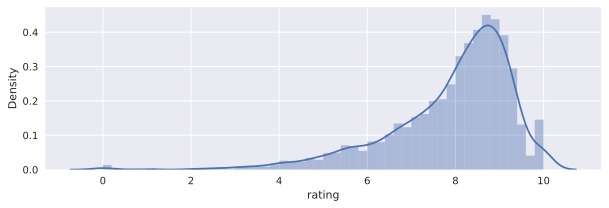

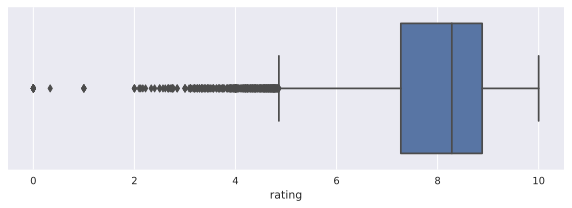

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('seaborn')
%matplotlib inline
#graphs in svg look clearer
%config InlineBackend.figure_format = 'svg' 

plt.figure(figsize=(10, 3))
sns.distplot(df_pr['rating'])
plt.show()

plt.figure(figsize=(10, 3))
sns.boxplot(df_pr['rating'], orient='h')
plt.show()

In [44]:
df_pr.columns

Index(['age_access_type', 'name', 'type', 'release_year', 'duration',
       'element_uid', 'budget', 'marketing', 'rus', 'USA',
       ...
       'producer_1', 'producer_2', 'producer_3', 'producer_4', 'writer_0',
       'writer_1', 'country_0', 'genre_0', 'genre_1', 'genre_2'],
      dtype='object', length=1048)

In [45]:
df_pr.shape

(6773, 1048)

In [48]:
df_pr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6773 entries, 2 to 10488
Columns: 1048 entries, age_access_type to genre_2
dtypes: float64(7), int64(1010), object(31)
memory usage: 54.5+ MB


## Split

In [66]:
from sklearn.model_selection import train_test_split

sorted_df = df_pr.sort_values('release_year')

test = sorted_df[sorted_df['release_year'] == 2022]
train = sorted_df[sorted_df['release_year'] != 2022]

# for looking at samples
test_df = test.copy(deep=True)
train_df = train.copy(deep=True)

test.drop(['release_year', 'element_uid', 'name'], axis=1, inplace=True)
train.drop(['release_year', 'element_uid', 'name'], axis=1, inplace=True)

X_test, y_test = test.drop('rating', axis=1), test['rating']
X, y = train.drop('rating', axis=1), train['rating']
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.1, 
                                                  shuffle=False)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape


((6004, 1044), (668, 1044), (101, 1044), (6004,), (668,), (101,))

## Standartization

In [55]:
col_names_scaled = ['duration', 'budget', 'marketing', 'rus', 'USA', 'world', 
                    'has_oscar_actor', 'has_oscar_composer', 'has_oscar_design', 'has_oscar_director', 
                    'has_oscar_editor', 'has_oscar_operator', 'has_oscar_producer', 'has_oscar_writer']

In [57]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X_train[col_names_scaled] = sc.fit_transform(X_train[col_names_scaled])
X_val[col_names_scaled] = sc.transform(X_val[col_names_scaled])
X_test[col_names_scaled] = sc.transform(X_test[col_names_scaled])

### Model

In [62]:
import catboost as cat
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from scipy.stats import uniform, randint

In [67]:
train_dataset = cat.Pool(data=X_train,
                        label=y_train,
                         cat_features=cat_features)

test_dataset = cat.Pool(data=X_test, 
                        label=y_test,
                         cat_features=cat_features)

val_dataset = cat.Pool(X_val, y_val,
                       cat_features=cat_features)

cat_params = {
    'loss_function': 'RMSE',
    'eval_metric': 'MAE',
    'verbose': True,
    'random_seed': 321,
    'allow_writing_files': False, 
    'cat_features': cat_features
}

cat_model = cat.CatBoostRegressor(**cat_params)

cat_model.fit(
    train_dataset,
    eval_set=val_dataset,
    early_stopping_rounds=500,
    verbose=100,
    plot=False
)

Learning rate set to 0.06747
0:	learn: 1.0254398	test: 1.1431752	best: 1.1431752 (0)	total: 39.3ms	remaining: 39.3s
100:	learn: 0.7124759	test: 0.8588003	best: 0.8588003 (100)	total: 3.4s	remaining: 30.3s
200:	learn: 0.6932520	test: 0.8528464	best: 0.8528464 (200)	total: 6.77s	remaining: 26.9s
300:	learn: 0.6771413	test: 0.8477467	best: 0.8477379 (298)	total: 10.1s	remaining: 23.5s
400:	learn: 0.6630934	test: 0.8447442	best: 0.8446938 (399)	total: 13.5s	remaining: 20.1s
500:	learn: 0.6485617	test: 0.8445092	best: 0.8436475 (477)	total: 16.8s	remaining: 16.8s
600:	learn: 0.6364969	test: 0.8433649	best: 0.8430990 (543)	total: 20.2s	remaining: 13.4s
700:	learn: 0.6247448	test: 0.8414605	best: 0.8411134 (690)	total: 23.5s	remaining: 10s
800:	learn: 0.6124137	test: 0.8423009	best: 0.8411134 (690)	total: 26.9s	remaining: 6.69s
900:	learn: 0.6023526	test: 0.8422014	best: 0.8411134 (690)	total: 30.4s	remaining: 3.34s
999:	learn: 0.5933564	test: 0.8426346	best: 0.8411134 (690)	total: 33.8s	rema

In [68]:
y_pred = cat_model.predict(test_dataset)

In [69]:
calc_metrics(y_test, y_pred)

*** VAL **: 
MSE:   1.1493329271934327
RMSE:  1.0720694600600433
R2:    0.45524562404357594
MAE:   0.7467299480349784
MedAE: 0.519718859592686
------------------------------


In [70]:
cat_model.save_model('DEMO_okko_ratings_pred')

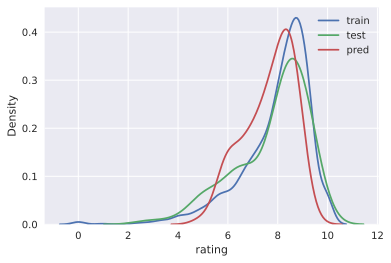

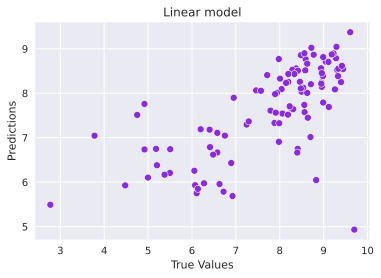

In [71]:
target_distr_linear(y_train, y_test, y_pred)   

IMP: [8.44480638e+00 4.71357039e+00 1.06240462e+01 1.71362515e+00
 2.30903324e-01 6.72973680e-01 1.48944870e+00 1.36338735e+01
 0.00000000e+00 6.71546283e-03 1.01286859e-02 0.00000000e+00
 2.60940273e-01 0.00000000e+00 5.87948697e-03 0.00000000e+00
 7.55527468e-02 0.00000000e+00 0.00000000e+00 3.55704948e-03]


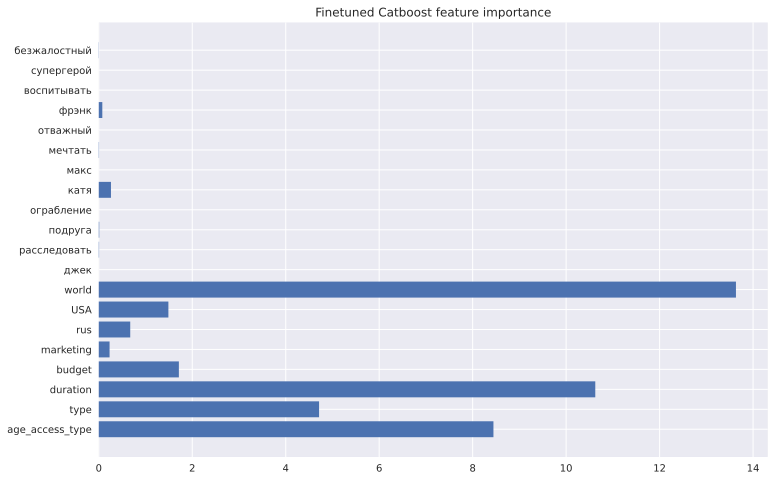

In [83]:
get_feature_imp(cat_model, train_dataset)

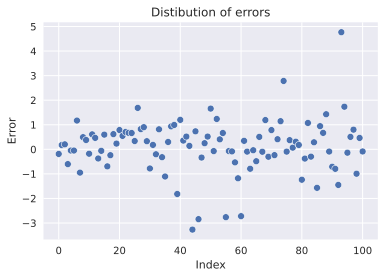

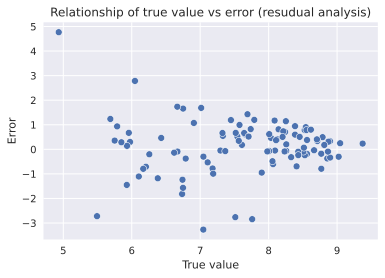

In [84]:
errors = y_test - y_pred
draw_res_analys(errors, y_pred)

### LOOKING AT TEST

In [85]:
test_df['PREDS'] = y_pred.tolist()
test_df['TARGET'] = y_test.tolist()
test_df

age_access_type                             name    type  release_year  \
10401               16                    Темное сердце  SERIAL          2022   
10439               18  Жена путешественника во времени  SERIAL          2022   
10435               18                    Хроники пышки  SERIAL          2022   
10457               18                 Бесконечная ночь  SERIAL          2022   
10438               18                        Репетиция  SERIAL          2022   
...                ...                              ...     ...           ...   
3110                16                          Код 355   MOVIE          2022   
2868                12                    Лулу и Бриггс   MOVIE          2022   
2805                16                  Побег из Африки   MOVIE          2022   
3885                18        Крепость 2: Глаз снайпера   MOVIE          2022   
10488                6                   Истоки футбола  SERIAL          2022   

        duration                           element_uid     budget  marketing  \
10401  16.368076  2372e695-5fff-4c68-91c7-73bce33fc9b1        NaN        NaN   
10439  16.626117  7becd8d8-1fb8-4ee6-b903-47817686ddd8        NaN        NaN   
10435  16.558928  17f245d4-d2d2-46de-a974-d7cd427ad1b6        NaN        NaN   
10457  16.200597  952bfe32-7504-4ef5-af22-985379d8637f        NaN        NaN   
10438  16.233209  753d822a-1890-4445-ab54-fe65c900e3fa        NaN        NaN   
...          ...                                   ...        ...        ...   
3110   15.806121  58934f4f-bec0-45db-a8a2-ab90d911a612  18.132999        NaN   
2868   15.617221  1504acff-36a2-4886-b37e-b4a96d51d3f6        NaN        NaN   
2805   15.490736  581115c5-1a7e-466d-9d11-fdd8d128d669  12.388398        NaN   
3885   15.587067  d580669b-3774-4091-8d78-f8cbdf02f8e0        NaN        NaN   
10488  17.518293  6dd86e60-5d6d-475d-9b46-e989ac7a30b6        NaN        NaN   

             rus         USA  ...        producer_3          producer_4  \
10401        NaN         NaN  ...        Элин Квист  Каролин Ландерберг   
10439        NaN         NaN  ...     Брайан Минчин       Стивен Моффат   
10435        NaN         NaN  ...        Дэн Сигнер        Ева Лонгория   
10457        NaN         NaN  ...      Лайонел Юзан          Лоран Анон   
10438        NaN         NaN  ...       Кристи Смит         Рэйчел Хейн   
...          ...         ...  ...               ...                 ...   
3110   13.114567  14570455.0  ...  Джессика Честейн        Ричард Хьюит   
2868   15.155431  61778069.0  ...    Бетси Дэнбьюри    Грегори Джейкобс   
2805         NaN         NaN  ...                Na                  Na   
3885         NaN         NaN  ...      Джордж Фурла         Луильо Руис   
10488        NaN         NaN  ...                Na                  Na   

              writer_0          writer_1  country_0  \
10401  Оскар Сёдерлунд   Эрик Хультквист    denmark   
10439    Стивен Моффат  Одри Ниффенеггер        usa   
10435        Шон Уайнс  Мэттью Клэйбрукс        usa   
10457      Давид Перро  Эммануэль Вуазен    belgium   
10438    Нэйтан Филдер      Кэрри Кемпер        usa   
...                ...               ...        ...   
3110    Ребека Ф. Смит      Тереза Ребек        usa   
2868     Ченнинг Татум     Андреа Дзирио        usa   
2805          Тед Бетц                Na        usa   
3885     Алан Хорснэйл        Эмиль Хирш        usa   
10488         Ши Чуань                Na      china   

                                    genre_0    genre_1  \
10401                              Thriller      Drama   
10439                                Sci-Fi  Melodrama   
10435                                Comedy     Family   
10457  9fa28b61-a257-4a3e-945b-a9ef76a146d6         Na   
10438                                Comedy         Na   
...                                     ...        ...   
3110                                 Action   Thriller   
2868                                 Comedy    

# Tuning

In [86]:
train_dataset = cat.Pool(X_train, 
                         y_train,
                         cat_features=cat_features)

test_dataset = cat.Pool(X_test, 
                        y_test,
                        cat_features=cat_features)

cat_params = {
    'loss_function': 'RMSE',
    'eval_metric': 'MAE',
    'verbose': True,
    'random_seed': 321,
    'allow_writing_files': False, 
    'cat_features': cat_features
}

In [87]:
parameters_distr = {'depth': randint(3, 7),
              'learning_rate': uniform(0.01, 0.1),
              'iterations': [100, 1000, 5000]
             }

cat_model = cat.CatBoostRegressor(**cat_params)
grid = RandomizedSearchCV(estimator=cat_model, param_distributions=parameters_distr, 
                            cv=5,
#                           n_jobs=-1, 
                          verbose=3)

grid.fit(X_train, y_train)

import pickle
with open('bestimator_ratings_kinop', 'wb') as f:
    pickle.dump(grid.best_estimator_, f)
grid.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
0:	learn: 1.0709641	total: 35.3ms	remaining: 35.2s
1:	learn: 1.0424558	total: 64.7ms	remaining: 32.3s
2:	learn: 1.0174448	total: 90.5ms	remaining: 30.1s
3:	learn: 0.9975383	total: 110ms	remaining: 27.4s
4:	learn: 0.9786461	total: 134ms	remaining: 26.7s
5:	learn: 0.9616977	total: 154ms	remaining: 25.5s
6:	learn: 0.9465509	total: 175ms	remaining: 24.9s
7:	learn: 0.9336615	total: 196ms	remaining: 24.3s
8:	learn: 0.9219693	total: 216ms	remaining: 23.8s
9:	learn: 0.9105724	total: 237ms	remaining: 23.4s
10:	learn: 0.9018836	total: 257ms	remaining: 23.1s
11:	learn: 0.8939190	total: 275ms	remaining: 22.7s
12:	learn: 0.8857968	total: 296ms	remaining: 22.5s
13:	learn: 0.8784633	total: 316ms	remaining: 22.3s
14:	learn: 0.8713428	total: 336ms	remaining: 22s
15:	learn: 0.8666449	total: 356ms	remaining: 21.9s
16:	learn: 0.8600470	total: 376ms	remaining: 21.7s
17:	learn: 0.8531158	total: 396ms	remaining: 21.6s
18:	learn: 0.8482400	total: 41

165:	learn: 0.7466679	total: 3.21s	remaining: 16.1s
166:	learn: 0.7465581	total: 3.23s	remaining: 16.1s
167:	learn: 0.7463570	total: 3.25s	remaining: 16.1s
168:	learn: 0.7462430	total: 3.27s	remaining: 16.1s
169:	learn: 0.7461797	total: 3.29s	remaining: 16.1s
170:	learn: 0.7461362	total: 3.31s	remaining: 16s
171:	learn: 0.7460218	total: 3.33s	remaining: 16s
172:	learn: 0.7460119	total: 3.34s	remaining: 16s
173:	learn: 0.7459691	total: 3.37s	remaining: 16s
174:	learn: 0.7459327	total: 3.38s	remaining: 16s
175:	learn: 0.7456034	total: 3.4s	remaining: 15.9s
176:	learn: 0.7451017	total: 3.42s	remaining: 15.9s
177:	learn: 0.7449685	total: 3.44s	remaining: 15.9s
178:	learn: 0.7449147	total: 3.46s	remaining: 15.9s
179:	learn: 0.7448858	total: 3.48s	remaining: 15.9s
180:	learn: 0.7444673	total: 3.5s	remaining: 15.8s
181:	learn: 0.7442800	total: 3.52s	remaining: 15.8s
182:	learn: 0.7439901	total: 3.54s	remaining: 15.8s
183:	learn: 0.7437237	total: 3.56s	remaining: 15.8s
184:	learn: 0.7434534	to

326:	learn: 0.7194034	total: 6.39s	remaining: 13.2s
327:	learn: 0.7193510	total: 6.41s	remaining: 13.1s
328:	learn: 0.7192628	total: 6.43s	remaining: 13.1s
329:	learn: 0.7192638	total: 6.44s	remaining: 13.1s
330:	learn: 0.7191833	total: 6.46s	remaining: 13.1s
331:	learn: 0.7188308	total: 6.49s	remaining: 13.1s
332:	learn: 0.7187938	total: 6.51s	remaining: 13s
333:	learn: 0.7185216	total: 6.53s	remaining: 13s
334:	learn: 0.7182705	total: 6.55s	remaining: 13s
335:	learn: 0.7178361	total: 6.57s	remaining: 13s
336:	learn: 0.7177603	total: 6.59s	remaining: 13s
337:	learn: 0.7173806	total: 6.61s	remaining: 12.9s
338:	learn: 0.7173069	total: 6.63s	remaining: 12.9s
339:	learn: 0.7172450	total: 6.65s	remaining: 12.9s
340:	learn: 0.7171650	total: 6.67s	remaining: 12.9s
341:	learn: 0.7170126	total: 6.69s	remaining: 12.9s
342:	learn: 0.7168098	total: 6.71s	remaining: 12.8s
343:	learn: 0.7165086	total: 6.73s	remaining: 12.8s
344:	learn: 0.7161477	total: 6.75s	remaining: 12.8s
345:	learn: 0.7161522	

488:	learn: 0.6991921	total: 9.56s	remaining: 9.99s
489:	learn: 0.6990603	total: 9.58s	remaining: 9.97s
490:	learn: 0.6989272	total: 9.6s	remaining: 9.95s
491:	learn: 0.6988700	total: 9.62s	remaining: 9.93s
492:	learn: 0.6986879	total: 9.64s	remaining: 9.91s
493:	learn: 0.6986769	total: 9.66s	remaining: 9.89s
494:	learn: 0.6986403	total: 9.68s	remaining: 9.87s
495:	learn: 0.6985743	total: 9.7s	remaining: 9.85s
496:	learn: 0.6983650	total: 9.71s	remaining: 9.83s
497:	learn: 0.6982835	total: 9.73s	remaining: 9.81s
498:	learn: 0.6981825	total: 9.75s	remaining: 9.79s
499:	learn: 0.6979408	total: 9.77s	remaining: 9.77s
500:	learn: 0.6978871	total: 9.79s	remaining: 9.76s
501:	learn: 0.6978192	total: 9.81s	remaining: 9.74s
502:	learn: 0.6976684	total: 9.84s	remaining: 9.72s
503:	learn: 0.6975694	total: 9.86s	remaining: 9.7s
504:	learn: 0.6974296	total: 9.88s	remaining: 9.68s
505:	learn: 0.6973348	total: 9.9s	remaining: 9.66s
506:	learn: 0.6972389	total: 9.92s	remaining: 9.64s
507:	learn: 0.69

650:	learn: 0.6819361	total: 12.7s	remaining: 6.82s
651:	learn: 0.6819087	total: 12.7s	remaining: 6.8s
652:	learn: 0.6817157	total: 12.8s	remaining: 6.78s
653:	learn: 0.6816757	total: 12.8s	remaining: 6.76s
654:	learn: 0.6816138	total: 12.8s	remaining: 6.74s
655:	learn: 0.6815449	total: 12.8s	remaining: 6.72s
656:	learn: 0.6814234	total: 12.8s	remaining: 6.7s
657:	learn: 0.6813351	total: 12.9s	remaining: 6.68s
658:	learn: 0.6811995	total: 12.9s	remaining: 6.66s
659:	learn: 0.6811292	total: 12.9s	remaining: 6.64s
660:	learn: 0.6809864	total: 12.9s	remaining: 6.62s
661:	learn: 0.6809610	total: 12.9s	remaining: 6.6s
662:	learn: 0.6809619	total: 13s	remaining: 6.58s
663:	learn: 0.6808177	total: 13s	remaining: 6.56s
664:	learn: 0.6808300	total: 13s	remaining: 6.54s
665:	learn: 0.6807340	total: 13s	remaining: 6.52s
666:	learn: 0.6804496	total: 13s	remaining: 6.5s
667:	learn: 0.6803408	total: 13s	remaining: 6.48s
668:	learn: 0.6802704	total: 13.1s	remaining: 6.46s
669:	learn: 0.6802894	total:

814:	learn: 0.6683301	total: 15.9s	remaining: 3.61s
815:	learn: 0.6681602	total: 15.9s	remaining: 3.59s
816:	learn: 0.6680374	total: 16s	remaining: 3.57s
817:	learn: 0.6679270	total: 16s	remaining: 3.55s
818:	learn: 0.6678926	total: 16s	remaining: 3.53s
819:	learn: 0.6678177	total: 16s	remaining: 3.51s
820:	learn: 0.6678063	total: 16s	remaining: 3.5s
821:	learn: 0.6677498	total: 16.1s	remaining: 3.48s
822:	learn: 0.6677154	total: 16.1s	remaining: 3.46s
823:	learn: 0.6676629	total: 16.1s	remaining: 3.44s
824:	learn: 0.6675089	total: 16.1s	remaining: 3.42s
825:	learn: 0.6675019	total: 16.1s	remaining: 3.4s
826:	learn: 0.6672751	total: 16.2s	remaining: 3.38s
827:	learn: 0.6672121	total: 16.2s	remaining: 3.36s
828:	learn: 0.6671801	total: 16.2s	remaining: 3.34s
829:	learn: 0.6671411	total: 16.2s	remaining: 3.32s
830:	learn: 0.6670350	total: 16.2s	remaining: 3.3s
831:	learn: 0.6669248	total: 16.2s	remaining: 3.28s
832:	learn: 0.6668892	total: 16.3s	remaining: 3.26s
833:	learn: 0.6668240	tot

976:	learn: 0.6542691	total: 19.1s	remaining: 450ms
977:	learn: 0.6542396	total: 19.1s	remaining: 430ms
978:	learn: 0.6541621	total: 19.1s	remaining: 411ms
979:	learn: 0.6539329	total: 19.2s	remaining: 391ms
980:	learn: 0.6539097	total: 19.2s	remaining: 372ms
981:	learn: 0.6537432	total: 19.2s	remaining: 352ms
982:	learn: 0.6536804	total: 19.2s	remaining: 332ms
983:	learn: 0.6535496	total: 19.2s	remaining: 313ms
984:	learn: 0.6535322	total: 19.3s	remaining: 293ms
985:	learn: 0.6535022	total: 19.3s	remaining: 274ms
986:	learn: 0.6535004	total: 19.3s	remaining: 254ms
987:	learn: 0.6533079	total: 19.3s	remaining: 235ms
988:	learn: 0.6532215	total: 19.3s	remaining: 215ms
989:	learn: 0.6531076	total: 19.4s	remaining: 195ms
990:	learn: 0.6529226	total: 19.4s	remaining: 176ms
991:	learn: 0.6528684	total: 19.4s	remaining: 156ms
992:	learn: 0.6527716	total: 19.4s	remaining: 137ms
993:	learn: 0.6527626	total: 19.4s	remaining: 117ms
994:	learn: 0.6526630	total: 19.4s	remaining: 97.7ms
995:	learn:

135:	learn: 0.7264461	total: 2.72s	remaining: 17.3s
136:	learn: 0.7263523	total: 2.75s	remaining: 17.3s
137:	learn: 0.7263173	total: 2.77s	remaining: 17.3s
138:	learn: 0.7260425	total: 2.79s	remaining: 17.3s
139:	learn: 0.7258130	total: 2.81s	remaining: 17.2s
140:	learn: 0.7257514	total: 2.83s	remaining: 17.2s
141:	learn: 0.7257192	total: 2.85s	remaining: 17.2s
142:	learn: 0.7256859	total: 2.86s	remaining: 17.2s
143:	learn: 0.7256025	total: 2.88s	remaining: 17.1s
144:	learn: 0.7255572	total: 2.9s	remaining: 17.1s
145:	learn: 0.7255326	total: 2.93s	remaining: 17.1s
146:	learn: 0.7255225	total: 2.95s	remaining: 17.1s
147:	learn: 0.7253847	total: 2.97s	remaining: 17.1s
148:	learn: 0.7249795	total: 2.99s	remaining: 17.1s
149:	learn: 0.7249076	total: 3s	remaining: 17s
150:	learn: 0.7247029	total: 3.02s	remaining: 17s
151:	learn: 0.7245369	total: 3.04s	remaining: 17s
152:	learn: 0.7244710	total: 3.07s	remaining: 17s
153:	learn: 0.7244346	total: 3.09s	remaining: 17s
154:	learn: 0.7241356	tota

296:	learn: 0.7032367	total: 5.9s	remaining: 14s
297:	learn: 0.7031979	total: 5.92s	remaining: 13.9s
298:	learn: 0.7032030	total: 5.94s	remaining: 13.9s
299:	learn: 0.7029916	total: 5.96s	remaining: 13.9s
300:	learn: 0.7028063	total: 5.98s	remaining: 13.9s
301:	learn: 0.7027606	total: 6s	remaining: 13.9s
302:	learn: 0.7026394	total: 6.02s	remaining: 13.8s
303:	learn: 0.7026092	total: 6.04s	remaining: 13.8s
304:	learn: 0.7025829	total: 6.05s	remaining: 13.8s
305:	learn: 0.7025143	total: 6.08s	remaining: 13.8s
306:	learn: 0.7024349	total: 6.09s	remaining: 13.8s
307:	learn: 0.7023679	total: 6.11s	remaining: 13.7s
308:	learn: 0.7023141	total: 6.13s	remaining: 13.7s
309:	learn: 0.7022025	total: 6.15s	remaining: 13.7s
310:	learn: 0.7021329	total: 6.17s	remaining: 13.7s
311:	learn: 0.7021201	total: 6.19s	remaining: 13.7s
312:	learn: 0.7017147	total: 6.21s	remaining: 13.6s
313:	learn: 0.7014781	total: 6.23s	remaining: 13.6s
314:	learn: 0.7014913	total: 6.25s	remaining: 13.6s
315:	learn: 0.7012

465:	learn: 0.6843446	total: 9.25s	remaining: 10.6s
466:	learn: 0.6843002	total: 9.27s	remaining: 10.6s
467:	learn: 0.6842540	total: 9.29s	remaining: 10.6s
468:	learn: 0.6842046	total: 9.31s	remaining: 10.5s
469:	learn: 0.6839392	total: 9.33s	remaining: 10.5s
470:	learn: 0.6838049	total: 9.35s	remaining: 10.5s
471:	learn: 0.6837192	total: 9.37s	remaining: 10.5s
472:	learn: 0.6834483	total: 9.39s	remaining: 10.5s
473:	learn: 0.6830619	total: 9.41s	remaining: 10.4s
474:	learn: 0.6830120	total: 9.43s	remaining: 10.4s
475:	learn: 0.6828728	total: 9.45s	remaining: 10.4s
476:	learn: 0.6827694	total: 9.47s	remaining: 10.4s
477:	learn: 0.6826910	total: 9.49s	remaining: 10.4s
478:	learn: 0.6826691	total: 9.51s	remaining: 10.3s
479:	learn: 0.6825988	total: 9.53s	remaining: 10.3s
480:	learn: 0.6825116	total: 9.55s	remaining: 10.3s
481:	learn: 0.6824752	total: 9.57s	remaining: 10.3s
482:	learn: 0.6823844	total: 9.59s	remaining: 10.3s
483:	learn: 0.6822688	total: 9.61s	remaining: 10.2s
484:	learn: 

625:	learn: 0.6665558	total: 12.4s	remaining: 7.42s
626:	learn: 0.6665492	total: 12.4s	remaining: 7.4s
627:	learn: 0.6664785	total: 12.5s	remaining: 7.38s
628:	learn: 0.6662894	total: 12.5s	remaining: 7.36s
629:	learn: 0.6662713	total: 12.5s	remaining: 7.34s
630:	learn: 0.6661851	total: 12.5s	remaining: 7.32s
631:	learn: 0.6661701	total: 12.5s	remaining: 7.3s
632:	learn: 0.6660662	total: 12.6s	remaining: 7.28s
633:	learn: 0.6660009	total: 12.6s	remaining: 7.26s
634:	learn: 0.6659606	total: 12.6s	remaining: 7.24s
635:	learn: 0.6658602	total: 12.6s	remaining: 7.22s
636:	learn: 0.6656708	total: 12.6s	remaining: 7.2s
637:	learn: 0.6655114	total: 12.7s	remaining: 7.18s
638:	learn: 0.6654816	total: 12.7s	remaining: 7.16s
639:	learn: 0.6653861	total: 12.7s	remaining: 7.14s
640:	learn: 0.6653724	total: 12.7s	remaining: 7.13s
641:	learn: 0.6651084	total: 12.7s	remaining: 7.11s
642:	learn: 0.6650720	total: 12.8s	remaining: 7.09s
643:	learn: 0.6650324	total: 12.8s	remaining: 7.07s
644:	learn: 0.6

793:	learn: 0.6492833	total: 15.8s	remaining: 4.09s
794:	learn: 0.6490914	total: 15.8s	remaining: 4.07s
795:	learn: 0.6489859	total: 15.8s	remaining: 4.05s
796:	learn: 0.6488610	total: 15.8s	remaining: 4.03s
797:	learn: 0.6488484	total: 15.9s	remaining: 4.01s
798:	learn: 0.6487451	total: 15.9s	remaining: 3.99s
799:	learn: 0.6485974	total: 15.9s	remaining: 3.98s
800:	learn: 0.6485719	total: 15.9s	remaining: 3.95s
801:	learn: 0.6485462	total: 15.9s	remaining: 3.93s
802:	learn: 0.6485165	total: 16s	remaining: 3.91s
803:	learn: 0.6483961	total: 16s	remaining: 3.89s
804:	learn: 0.6483923	total: 16s	remaining: 3.87s
805:	learn: 0.6483633	total: 16s	remaining: 3.85s
806:	learn: 0.6482646	total: 16s	remaining: 3.83s
807:	learn: 0.6480374	total: 16.1s	remaining: 3.81s
808:	learn: 0.6479857	total: 16.1s	remaining: 3.79s
809:	learn: 0.6479708	total: 16.1s	remaining: 3.77s
810:	learn: 0.6478637	total: 16.1s	remaining: 3.75s
811:	learn: 0.6477295	total: 16.1s	remaining: 3.73s
812:	learn: 0.6476816	

952:	learn: 0.6362299	total: 18.9s	remaining: 933ms
953:	learn: 0.6360494	total: 18.9s	remaining: 913ms
954:	learn: 0.6359998	total: 19s	remaining: 893ms
955:	learn: 0.6359750	total: 19s	remaining: 873ms
956:	learn: 0.6358799	total: 19s	remaining: 854ms
957:	learn: 0.6357957	total: 19s	remaining: 834ms
958:	learn: 0.6357454	total: 19s	remaining: 814ms
959:	learn: 0.6356339	total: 19.1s	remaining: 794ms
960:	learn: 0.6354660	total: 19.1s	remaining: 774ms
961:	learn: 0.6353914	total: 19.1s	remaining: 754ms
962:	learn: 0.6353722	total: 19.1s	remaining: 735ms
963:	learn: 0.6352634	total: 19.1s	remaining: 715ms
964:	learn: 0.6352381	total: 19.2s	remaining: 695ms
965:	learn: 0.6351328	total: 19.2s	remaining: 675ms
966:	learn: 0.6351098	total: 19.2s	remaining: 655ms
967:	learn: 0.6350530	total: 19.2s	remaining: 635ms
968:	learn: 0.6349247	total: 19.2s	remaining: 615ms
969:	learn: 0.6347708	total: 19.3s	remaining: 595ms
970:	learn: 0.6346972	total: 19.3s	remaining: 576ms
971:	learn: 0.6346491	

116:	learn: 0.7287411	total: 2.34s	remaining: 17.7s
117:	learn: 0.7282319	total: 2.37s	remaining: 17.7s
118:	learn: 0.7281665	total: 2.38s	remaining: 17.7s
119:	learn: 0.7280545	total: 2.4s	remaining: 17.6s
120:	learn: 0.7279612	total: 2.42s	remaining: 17.6s
121:	learn: 0.7278450	total: 2.44s	remaining: 17.6s
122:	learn: 0.7278356	total: 2.46s	remaining: 17.6s
123:	learn: 0.7278038	total: 2.48s	remaining: 17.5s
124:	learn: 0.7277495	total: 2.5s	remaining: 17.5s
125:	learn: 0.7272831	total: 2.52s	remaining: 17.5s
126:	learn: 0.7271278	total: 2.54s	remaining: 17.5s
127:	learn: 0.7270708	total: 2.56s	remaining: 17.5s
128:	learn: 0.7269695	total: 2.58s	remaining: 17.4s
129:	learn: 0.7269466	total: 2.6s	remaining: 17.4s
130:	learn: 0.7267976	total: 2.62s	remaining: 17.4s
131:	learn: 0.7262715	total: 2.64s	remaining: 17.4s
132:	learn: 0.7262521	total: 2.66s	remaining: 17.3s
133:	learn: 0.7259480	total: 2.68s	remaining: 17.3s
134:	learn: 0.7257315	total: 2.7s	remaining: 17.3s
135:	learn: 0.72

276:	learn: 0.7017654	total: 5.52s	remaining: 14.4s
277:	learn: 0.7016867	total: 5.54s	remaining: 14.4s
278:	learn: 0.7013959	total: 5.56s	remaining: 14.4s
279:	learn: 0.7013643	total: 5.58s	remaining: 14.3s
280:	learn: 0.7012387	total: 5.6s	remaining: 14.3s
281:	learn: 0.7012196	total: 5.62s	remaining: 14.3s
282:	learn: 0.7007981	total: 5.64s	remaining: 14.3s
283:	learn: 0.7007272	total: 5.66s	remaining: 14.3s
284:	learn: 0.7006846	total: 5.68s	remaining: 14.2s
285:	learn: 0.7006568	total: 5.7s	remaining: 14.2s
286:	learn: 0.7006237	total: 5.71s	remaining: 14.2s
287:	learn: 0.7004014	total: 5.73s	remaining: 14.2s
288:	learn: 0.7004072	total: 5.75s	remaining: 14.2s
289:	learn: 0.7002318	total: 5.77s	remaining: 14.1s
290:	learn: 0.7000883	total: 5.79s	remaining: 14.1s
291:	learn: 0.7000423	total: 5.81s	remaining: 14.1s
292:	learn: 0.6999541	total: 5.83s	remaining: 14.1s
293:	learn: 0.6997223	total: 5.85s	remaining: 14s
294:	learn: 0.6996038	total: 5.87s	remaining: 14s
295:	learn: 0.6994

435:	learn: 0.6805515	total: 8.68s	remaining: 11.2s
436:	learn: 0.6802801	total: 8.7s	remaining: 11.2s
437:	learn: 0.6802695	total: 8.72s	remaining: 11.2s
438:	learn: 0.6802244	total: 8.74s	remaining: 11.2s
439:	learn: 0.6801639	total: 8.76s	remaining: 11.2s
440:	learn: 0.6800194	total: 8.78s	remaining: 11.1s
441:	learn: 0.6798970	total: 8.8s	remaining: 11.1s
442:	learn: 0.6798505	total: 8.82s	remaining: 11.1s
443:	learn: 0.6798110	total: 8.84s	remaining: 11.1s
444:	learn: 0.6798270	total: 8.86s	remaining: 11.1s
445:	learn: 0.6798208	total: 8.88s	remaining: 11s
446:	learn: 0.6797723	total: 8.9s	remaining: 11s
447:	learn: 0.6797829	total: 8.92s	remaining: 11s
448:	learn: 0.6797246	total: 8.94s	remaining: 11s
449:	learn: 0.6797019	total: 8.96s	remaining: 10.9s
450:	learn: 0.6795639	total: 8.98s	remaining: 10.9s
451:	learn: 0.6792379	total: 9s	remaining: 10.9s
452:	learn: 0.6791987	total: 9.02s	remaining: 10.9s
453:	learn: 0.6791221	total: 9.04s	remaining: 10.9s
454:	learn: 0.6791023	tota

595:	learn: 0.6631514	total: 11.8s	remaining: 8.03s
596:	learn: 0.6630988	total: 11.9s	remaining: 8.01s
597:	learn: 0.6629273	total: 11.9s	remaining: 7.99s
598:	learn: 0.6628596	total: 11.9s	remaining: 7.97s
599:	learn: 0.6626511	total: 11.9s	remaining: 7.95s
600:	learn: 0.6625886	total: 11.9s	remaining: 7.93s
601:	learn: 0.6625179	total: 12s	remaining: 7.91s
602:	learn: 0.6624373	total: 12s	remaining: 7.89s
603:	learn: 0.6623681	total: 12s	remaining: 7.87s
604:	learn: 0.6622655	total: 12s	remaining: 7.85s
605:	learn: 0.6621604	total: 12s	remaining: 7.83s
606:	learn: 0.6620214	total: 12.1s	remaining: 7.81s
607:	learn: 0.6619203	total: 12.1s	remaining: 7.79s
608:	learn: 0.6616627	total: 12.1s	remaining: 7.77s
609:	learn: 0.6614602	total: 12.1s	remaining: 7.75s
610:	learn: 0.6613543	total: 12.1s	remaining: 7.73s
611:	learn: 0.6611741	total: 12.2s	remaining: 7.71s
612:	learn: 0.6611150	total: 12.2s	remaining: 7.69s
613:	learn: 0.6610602	total: 12.2s	remaining: 7.67s
614:	learn: 0.6609212	

755:	learn: 0.6485268	total: 15s	remaining: 4.84s
756:	learn: 0.6484675	total: 15s	remaining: 4.83s
757:	learn: 0.6483477	total: 15.1s	remaining: 4.81s
758:	learn: 0.6483113	total: 15.1s	remaining: 4.79s
759:	learn: 0.6482749	total: 15.1s	remaining: 4.77s
760:	learn: 0.6481816	total: 15.1s	remaining: 4.75s
761:	learn: 0.6481700	total: 15.2s	remaining: 4.73s
762:	learn: 0.6480399	total: 15.2s	remaining: 4.71s
763:	learn: 0.6479922	total: 15.2s	remaining: 4.69s
764:	learn: 0.6479469	total: 15.2s	remaining: 4.67s
765:	learn: 0.6478863	total: 15.2s	remaining: 4.65s
766:	learn: 0.6477651	total: 15.3s	remaining: 4.63s
767:	learn: 0.6477338	total: 15.3s	remaining: 4.62s
768:	learn: 0.6476783	total: 15.3s	remaining: 4.6s
769:	learn: 0.6476016	total: 15.3s	remaining: 4.58s
770:	learn: 0.6475495	total: 15.3s	remaining: 4.56s
771:	learn: 0.6473881	total: 15.4s	remaining: 4.54s
772:	learn: 0.6473594	total: 15.4s	remaining: 4.51s
773:	learn: 0.6470626	total: 15.4s	remaining: 4.5s
774:	learn: 0.6469

918:	learn: 0.6352209	total: 18.3s	remaining: 1.61s
919:	learn: 0.6351847	total: 18.3s	remaining: 1.59s
920:	learn: 0.6351602	total: 18.3s	remaining: 1.57s
921:	learn: 0.6351182	total: 18.4s	remaining: 1.55s
922:	learn: 0.6349012	total: 18.4s	remaining: 1.53s
923:	learn: 0.6348349	total: 18.4s	remaining: 1.51s
924:	learn: 0.6347236	total: 18.4s	remaining: 1.49s
925:	learn: 0.6346914	total: 18.4s	remaining: 1.47s
926:	learn: 0.6344903	total: 18.5s	remaining: 1.45s
927:	learn: 0.6342852	total: 18.5s	remaining: 1.43s
928:	learn: 0.6342617	total: 18.5s	remaining: 1.41s
929:	learn: 0.6342163	total: 18.5s	remaining: 1.39s
930:	learn: 0.6341792	total: 18.5s	remaining: 1.37s
931:	learn: 0.6339140	total: 18.6s	remaining: 1.35s
932:	learn: 0.6337890	total: 18.6s	remaining: 1.33s
933:	learn: 0.6336997	total: 18.6s	remaining: 1.31s
934:	learn: 0.6336681	total: 18.6s	remaining: 1.29s
935:	learn: 0.6334037	total: 18.6s	remaining: 1.27s
936:	learn: 0.6333018	total: 18.7s	remaining: 1.25s
937:	learn: 

84:	learn: 0.7203719	total: 1.72s	remaining: 18.5s
85:	learn: 0.7198031	total: 1.74s	remaining: 18.5s
86:	learn: 0.7194418	total: 1.76s	remaining: 18.5s
87:	learn: 0.7193582	total: 1.78s	remaining: 18.5s
88:	learn: 0.7192159	total: 1.8s	remaining: 18.4s
89:	learn: 0.7190791	total: 1.82s	remaining: 18.4s
90:	learn: 0.7187938	total: 1.84s	remaining: 18.4s
91:	learn: 0.7186187	total: 1.86s	remaining: 18.4s
92:	learn: 0.7181859	total: 1.88s	remaining: 18.3s
93:	learn: 0.7180356	total: 1.9s	remaining: 18.3s
94:	learn: 0.7177031	total: 1.92s	remaining: 18.3s
95:	learn: 0.7176473	total: 1.94s	remaining: 18.3s
96:	learn: 0.7174786	total: 1.96s	remaining: 18.3s
97:	learn: 0.7173833	total: 1.98s	remaining: 18.2s
98:	learn: 0.7171627	total: 2s	remaining: 18.2s
99:	learn: 0.7167624	total: 2.02s	remaining: 18.2s
100:	learn: 0.7165835	total: 2.04s	remaining: 18.2s
101:	learn: 0.7161802	total: 2.06s	remaining: 18.2s
102:	learn: 0.7161900	total: 2.08s	remaining: 18.1s
103:	learn: 0.7159549	total: 2.1s

252:	learn: 0.6943016	total: 5.06s	remaining: 15s
253:	learn: 0.6942096	total: 5.08s	remaining: 14.9s
254:	learn: 0.6941721	total: 5.11s	remaining: 14.9s
255:	learn: 0.6938879	total: 5.12s	remaining: 14.9s
256:	learn: 0.6934874	total: 5.14s	remaining: 14.9s
257:	learn: 0.6934122	total: 5.16s	remaining: 14.8s
258:	learn: 0.6931544	total: 5.18s	remaining: 14.8s
259:	learn: 0.6930816	total: 5.2s	remaining: 14.8s
260:	learn: 0.6930049	total: 5.22s	remaining: 14.8s
261:	learn: 0.6929409	total: 5.24s	remaining: 14.8s
262:	learn: 0.6926957	total: 5.26s	remaining: 14.7s
263:	learn: 0.6923072	total: 5.28s	remaining: 14.7s
264:	learn: 0.6921717	total: 5.3s	remaining: 14.7s
265:	learn: 0.6919050	total: 5.32s	remaining: 14.7s
266:	learn: 0.6918207	total: 5.34s	remaining: 14.7s
267:	learn: 0.6917792	total: 5.36s	remaining: 14.6s
268:	learn: 0.6917037	total: 5.38s	remaining: 14.6s
269:	learn: 0.6915446	total: 5.4s	remaining: 14.6s
270:	learn: 0.6914775	total: 5.42s	remaining: 14.6s
271:	learn: 0.691

411:	learn: 0.6743646	total: 8.22s	remaining: 11.7s
412:	learn: 0.6740938	total: 8.24s	remaining: 11.7s
413:	learn: 0.6739833	total: 8.26s	remaining: 11.7s
414:	learn: 0.6738473	total: 8.27s	remaining: 11.7s
415:	learn: 0.6738066	total: 8.29s	remaining: 11.6s
416:	learn: 0.6737467	total: 8.31s	remaining: 11.6s
417:	learn: 0.6735753	total: 8.33s	remaining: 11.6s
418:	learn: 0.6734724	total: 8.35s	remaining: 11.6s
419:	learn: 0.6734070	total: 8.37s	remaining: 11.6s
420:	learn: 0.6728811	total: 8.39s	remaining: 11.5s
421:	learn: 0.6728202	total: 8.41s	remaining: 11.5s
422:	learn: 0.6726693	total: 8.43s	remaining: 11.5s
423:	learn: 0.6725180	total: 8.45s	remaining: 11.5s
424:	learn: 0.6723582	total: 8.47s	remaining: 11.5s
425:	learn: 0.6722364	total: 8.48s	remaining: 11.4s
426:	learn: 0.6721985	total: 8.51s	remaining: 11.4s
427:	learn: 0.6720657	total: 8.53s	remaining: 11.4s
428:	learn: 0.6720330	total: 8.54s	remaining: 11.4s
429:	learn: 0.6719963	total: 8.56s	remaining: 11.4s
430:	learn: 

571:	learn: 0.6560710	total: 11.4s	remaining: 8.52s
572:	learn: 0.6560581	total: 11.4s	remaining: 8.5s
573:	learn: 0.6560215	total: 11.4s	remaining: 8.48s
574:	learn: 0.6558666	total: 11.4s	remaining: 8.46s
575:	learn: 0.6557896	total: 11.5s	remaining: 8.44s
576:	learn: 0.6554875	total: 11.5s	remaining: 8.42s
577:	learn: 0.6553959	total: 11.5s	remaining: 8.4s
578:	learn: 0.6550796	total: 11.5s	remaining: 8.38s
579:	learn: 0.6550371	total: 11.5s	remaining: 8.36s
580:	learn: 0.6548795	total: 11.6s	remaining: 8.34s
581:	learn: 0.6548404	total: 11.6s	remaining: 8.32s
582:	learn: 0.6547830	total: 11.6s	remaining: 8.3s
583:	learn: 0.6543979	total: 11.6s	remaining: 8.28s
584:	learn: 0.6542093	total: 11.6s	remaining: 8.26s
585:	learn: 0.6539484	total: 11.7s	remaining: 8.24s
586:	learn: 0.6538474	total: 11.7s	remaining: 8.22s
587:	learn: 0.6536268	total: 11.7s	remaining: 8.2s
588:	learn: 0.6535533	total: 11.7s	remaining: 8.18s
589:	learn: 0.6534706	total: 11.7s	remaining: 8.16s
590:	learn: 0.65

739:	learn: 0.6392705	total: 14.8s	remaining: 5.19s
740:	learn: 0.6392242	total: 14.8s	remaining: 5.17s
741:	learn: 0.6391386	total: 14.8s	remaining: 5.15s
742:	learn: 0.6389433	total: 14.8s	remaining: 5.13s
743:	learn: 0.6387816	total: 14.9s	remaining: 5.11s
744:	learn: 0.6387663	total: 14.9s	remaining: 5.09s
745:	learn: 0.6387533	total: 14.9s	remaining: 5.08s
746:	learn: 0.6386908	total: 14.9s	remaining: 5.05s
747:	learn: 0.6386450	total: 14.9s	remaining: 5.03s
748:	learn: 0.6385062	total: 15s	remaining: 5.01s
749:	learn: 0.6383286	total: 15s	remaining: 4.99s
750:	learn: 0.6383376	total: 15s	remaining: 4.97s
751:	learn: 0.6383086	total: 15s	remaining: 4.95s
752:	learn: 0.6382859	total: 15s	remaining: 4.93s
753:	learn: 0.6380214	total: 15.1s	remaining: 4.91s
754:	learn: 0.6379436	total: 15.1s	remaining: 4.89s
755:	learn: 0.6378998	total: 15.1s	remaining: 4.87s
756:	learn: 0.6378519	total: 15.1s	remaining: 4.86s
757:	learn: 0.6377629	total: 15.2s	remaining: 4.84s
758:	learn: 0.6376894	

904:	learn: 0.6262504	total: 18.1s	remaining: 1.9s
905:	learn: 0.6262388	total: 18.1s	remaining: 1.88s
906:	learn: 0.6261540	total: 18.2s	remaining: 1.86s
907:	learn: 0.6260894	total: 18.2s	remaining: 1.84s
908:	learn: 0.6258821	total: 18.2s	remaining: 1.82s
909:	learn: 0.6258526	total: 18.2s	remaining: 1.8s
910:	learn: 0.6257944	total: 18.2s	remaining: 1.78s
911:	learn: 0.6257439	total: 18.3s	remaining: 1.76s
912:	learn: 0.6256426	total: 18.3s	remaining: 1.74s
913:	learn: 0.6255891	total: 18.3s	remaining: 1.72s
914:	learn: 0.6255328	total: 18.3s	remaining: 1.7s
915:	learn: 0.6253545	total: 18.3s	remaining: 1.68s
916:	learn: 0.6253183	total: 18.4s	remaining: 1.66s
917:	learn: 0.6253051	total: 18.4s	remaining: 1.64s
918:	learn: 0.6253080	total: 18.4s	remaining: 1.62s
919:	learn: 0.6252463	total: 18.4s	remaining: 1.6s
920:	learn: 0.6251644	total: 18.4s	remaining: 1.58s
921:	learn: 0.6250645	total: 18.5s	remaining: 1.56s
922:	learn: 0.6249760	total: 18.5s	remaining: 1.54s
923:	learn: 0.62

71:	learn: 0.7004836	total: 1.47s	remaining: 18.9s
72:	learn: 0.7003029	total: 1.49s	remaining: 18.9s
73:	learn: 0.6998978	total: 1.51s	remaining: 18.9s
74:	learn: 0.6994458	total: 1.53s	remaining: 18.9s
75:	learn: 0.6991586	total: 1.55s	remaining: 18.9s
76:	learn: 0.6991187	total: 1.57s	remaining: 18.9s
77:	learn: 0.6989390	total: 1.59s	remaining: 18.8s
78:	learn: 0.6984762	total: 1.61s	remaining: 18.8s
79:	learn: 0.6979911	total: 1.63s	remaining: 18.8s
80:	learn: 0.6972048	total: 1.65s	remaining: 18.8s
81:	learn: 0.6967767	total: 1.68s	remaining: 18.8s
82:	learn: 0.6964416	total: 1.7s	remaining: 18.7s
83:	learn: 0.6960977	total: 1.72s	remaining: 18.7s
84:	learn: 0.6957633	total: 1.74s	remaining: 18.7s
85:	learn: 0.6952450	total: 1.75s	remaining: 18.7s
86:	learn: 0.6946632	total: 1.77s	remaining: 18.6s
87:	learn: 0.6942205	total: 1.79s	remaining: 18.6s
88:	learn: 0.6938172	total: 1.81s	remaining: 18.6s
89:	learn: 0.6936935	total: 1.84s	remaining: 18.6s
90:	learn: 0.6935843	total: 1.86

233:	learn: 0.6688509	total: 4.65s	remaining: 15.2s
234:	learn: 0.6687605	total: 4.67s	remaining: 15.2s
235:	learn: 0.6685949	total: 4.69s	remaining: 15.2s
236:	learn: 0.6685508	total: 4.71s	remaining: 15.2s
237:	learn: 0.6684093	total: 4.73s	remaining: 15.1s
238:	learn: 0.6680889	total: 4.75s	remaining: 15.1s
239:	learn: 0.6677967	total: 4.77s	remaining: 15.1s
240:	learn: 0.6675914	total: 4.79s	remaining: 15.1s
241:	learn: 0.6673438	total: 4.81s	remaining: 15.1s
242:	learn: 0.6673337	total: 4.83s	remaining: 15s
243:	learn: 0.6672511	total: 4.85s	remaining: 15s
244:	learn: 0.6672558	total: 4.87s	remaining: 15s
245:	learn: 0.6670610	total: 4.89s	remaining: 15s
246:	learn: 0.6667989	total: 4.91s	remaining: 15s
247:	learn: 0.6667671	total: 4.93s	remaining: 14.9s
248:	learn: 0.6665003	total: 4.95s	remaining: 14.9s
249:	learn: 0.6661873	total: 4.96s	remaining: 14.9s
250:	learn: 0.6659831	total: 4.99s	remaining: 14.9s
251:	learn: 0.6657463	total: 5s	remaining: 14.9s
252:	learn: 0.6656384	tot

393:	learn: 0.6464230	total: 7.82s	remaining: 12s
394:	learn: 0.6463717	total: 7.84s	remaining: 12s
395:	learn: 0.6462515	total: 7.86s	remaining: 12s
396:	learn: 0.6462043	total: 7.88s	remaining: 12s
397:	learn: 0.6461635	total: 7.89s	remaining: 11.9s
398:	learn: 0.6459123	total: 7.91s	remaining: 11.9s
399:	learn: 0.6456870	total: 7.93s	remaining: 11.9s
400:	learn: 0.6456567	total: 7.96s	remaining: 11.9s
401:	learn: 0.6455368	total: 7.97s	remaining: 11.9s
402:	learn: 0.6454526	total: 7.99s	remaining: 11.8s
403:	learn: 0.6454312	total: 8.01s	remaining: 11.8s
404:	learn: 0.6453240	total: 8.03s	remaining: 11.8s
405:	learn: 0.6447672	total: 8.05s	remaining: 11.8s
406:	learn: 0.6446792	total: 8.07s	remaining: 11.8s
407:	learn: 0.6446213	total: 8.1s	remaining: 11.7s
408:	learn: 0.6445258	total: 8.12s	remaining: 11.7s
409:	learn: 0.6444767	total: 8.14s	remaining: 11.7s
410:	learn: 0.6444301	total: 8.15s	remaining: 11.7s
411:	learn: 0.6444094	total: 8.17s	remaining: 11.7s
412:	learn: 0.6443676

554:	learn: 0.6299646	total: 11s	remaining: 8.82s
555:	learn: 0.6298566	total: 11s	remaining: 8.8s
556:	learn: 0.6297922	total: 11s	remaining: 8.78s
557:	learn: 0.6297423	total: 11.1s	remaining: 8.76s
558:	learn: 0.6295479	total: 11.1s	remaining: 8.74s
559:	learn: 0.6295178	total: 11.1s	remaining: 8.72s
560:	learn: 0.6294574	total: 11.1s	remaining: 8.7s
561:	learn: 0.6292382	total: 11.1s	remaining: 8.68s
562:	learn: 0.6291267	total: 11.2s	remaining: 8.66s
563:	learn: 0.6291077	total: 11.2s	remaining: 8.64s
564:	learn: 0.6290428	total: 11.2s	remaining: 8.62s
565:	learn: 0.6289766	total: 11.2s	remaining: 8.6s
566:	learn: 0.6288390	total: 11.2s	remaining: 8.58s
567:	learn: 0.6287120	total: 11.3s	remaining: 8.56s
568:	learn: 0.6286634	total: 11.3s	remaining: 8.54s
569:	learn: 0.6285674	total: 11.3s	remaining: 8.52s
570:	learn: 0.6285143	total: 11.3s	remaining: 8.5s
571:	learn: 0.6283918	total: 11.3s	remaining: 8.48s
572:	learn: 0.6282875	total: 11.4s	remaining: 8.46s
573:	learn: 0.6281950	

717:	learn: 0.6149086	total: 14.2s	remaining: 5.57s
718:	learn: 0.6148509	total: 14.2s	remaining: 5.55s
719:	learn: 0.6148289	total: 14.2s	remaining: 5.53s
720:	learn: 0.6148174	total: 14.2s	remaining: 5.51s
721:	learn: 0.6147656	total: 14.3s	remaining: 5.49s
722:	learn: 0.6144874	total: 14.3s	remaining: 5.47s
723:	learn: 0.6144734	total: 14.3s	remaining: 5.45s
724:	learn: 0.6144683	total: 14.3s	remaining: 5.43s
725:	learn: 0.6142911	total: 14.3s	remaining: 5.41s
726:	learn: 0.6142569	total: 14.4s	remaining: 5.39s
727:	learn: 0.6140959	total: 14.4s	remaining: 5.38s
728:	learn: 0.6139302	total: 14.4s	remaining: 5.36s
729:	learn: 0.6138697	total: 14.4s	remaining: 5.34s
730:	learn: 0.6136319	total: 14.4s	remaining: 5.32s
731:	learn: 0.6136109	total: 14.5s	remaining: 5.3s
732:	learn: 0.6134518	total: 14.5s	remaining: 5.28s
733:	learn: 0.6133992	total: 14.5s	remaining: 5.26s
734:	learn: 0.6130268	total: 14.5s	remaining: 5.24s
735:	learn: 0.6129320	total: 14.5s	remaining: 5.22s
736:	learn: 0

885:	learn: 0.5998646	total: 17.5s	remaining: 2.26s
886:	learn: 0.5998541	total: 17.6s	remaining: 2.24s
887:	learn: 0.5997612	total: 17.6s	remaining: 2.22s
888:	learn: 0.5996667	total: 17.6s	remaining: 2.2s
889:	learn: 0.5995732	total: 17.6s	remaining: 2.18s
890:	learn: 0.5995613	total: 17.7s	remaining: 2.16s
891:	learn: 0.5994729	total: 17.7s	remaining: 2.14s
892:	learn: 0.5993989	total: 17.7s	remaining: 2.12s
893:	learn: 0.5992396	total: 17.7s	remaining: 2.1s
894:	learn: 0.5991772	total: 17.7s	remaining: 2.08s
895:	learn: 0.5991599	total: 17.7s	remaining: 2.06s
896:	learn: 0.5990751	total: 17.8s	remaining: 2.04s
897:	learn: 0.5990388	total: 17.8s	remaining: 2.02s
898:	learn: 0.5989709	total: 17.8s	remaining: 2s
899:	learn: 0.5989145	total: 17.8s	remaining: 1.98s
900:	learn: 0.5988045	total: 17.8s	remaining: 1.96s
901:	learn: 0.5987574	total: 17.9s	remaining: 1.94s
902:	learn: 0.5986049	total: 17.9s	remaining: 1.92s
903:	learn: 0.5984636	total: 17.9s	remaining: 1.9s
904:	learn: 0.5982

60:	learn: 0.8296691	total: 418ms	remaining: 267ms
61:	learn: 0.8279180	total: 424ms	remaining: 260ms
62:	learn: 0.8269143	total: 431ms	remaining: 253ms
63:	learn: 0.8255053	total: 437ms	remaining: 246ms
64:	learn: 0.8246589	total: 444ms	remaining: 239ms
65:	learn: 0.8234105	total: 451ms	remaining: 232ms
66:	learn: 0.8220522	total: 457ms	remaining: 225ms
67:	learn: 0.8203062	total: 463ms	remaining: 218ms
68:	learn: 0.8188589	total: 469ms	remaining: 211ms
69:	learn: 0.8178499	total: 476ms	remaining: 204ms
70:	learn: 0.8170073	total: 482ms	remaining: 197ms
71:	learn: 0.8160255	total: 488ms	remaining: 190ms
72:	learn: 0.8147978	total: 495ms	remaining: 183ms
73:	learn: 0.8136709	total: 503ms	remaining: 177ms
74:	learn: 0.8128847	total: 509ms	remaining: 170ms
75:	learn: 0.8121790	total: 515ms	remaining: 163ms
76:	learn: 0.8110492	total: 522ms	remaining: 156ms
77:	learn: 0.8100176	total: 528ms	remaining: 149ms
78:	learn: 0.8090401	total: 534ms	remaining: 142ms
79:	learn: 0.8080882	total: 541

29:	learn: 0.8673789	total: 216ms	remaining: 503ms
30:	learn: 0.8642702	total: 222ms	remaining: 494ms
31:	learn: 0.8612254	total: 228ms	remaining: 486ms
32:	learn: 0.8588611	total: 235ms	remaining: 476ms
33:	learn: 0.8558469	total: 242ms	remaining: 470ms
34:	learn: 0.8527998	total: 248ms	remaining: 461ms
35:	learn: 0.8507694	total: 255ms	remaining: 453ms
36:	learn: 0.8479575	total: 261ms	remaining: 444ms
37:	learn: 0.8446675	total: 267ms	remaining: 436ms
38:	learn: 0.8429498	total: 273ms	remaining: 428ms
39:	learn: 0.8410554	total: 286ms	remaining: 428ms
40:	learn: 0.8390179	total: 292ms	remaining: 420ms
41:	learn: 0.8369447	total: 298ms	remaining: 412ms
42:	learn: 0.8341312	total: 305ms	remaining: 405ms
43:	learn: 0.8324715	total: 311ms	remaining: 396ms
44:	learn: 0.8311123	total: 317ms	remaining: 388ms
45:	learn: 0.8295533	total: 324ms	remaining: 380ms
46:	learn: 0.8274809	total: 331ms	remaining: 373ms
47:	learn: 0.8255010	total: 337ms	remaining: 365ms
48:	learn: 0.8240078	total: 344

89:	learn: 0.7546295	total: 618ms	remaining: 68.7ms
90:	learn: 0.7544533	total: 624ms	remaining: 61.8ms
91:	learn: 0.7538910	total: 631ms	remaining: 54.8ms
92:	learn: 0.7531071	total: 637ms	remaining: 47.9ms
93:	learn: 0.7522105	total: 643ms	remaining: 41.1ms
94:	learn: 0.7514025	total: 650ms	remaining: 34.2ms
95:	learn: 0.7510350	total: 658ms	remaining: 27.4ms
96:	learn: 0.7505257	total: 665ms	remaining: 20.6ms
97:	learn: 0.7501561	total: 671ms	remaining: 13.7ms
98:	learn: 0.7500948	total: 677ms	remaining: 6.84ms
99:	learn: 0.7496960	total: 684ms	remaining: 0us
[CV 4/5] END depth=4, iterations=100, learning_rate=0.03617537227871971;, score=0.358 total time=   1.0s
0:	learn: 0.9693549	total: 11.3ms	remaining: 1.11s
1:	learn: 0.9584204	total: 20.9ms	remaining: 1.02s
2:	learn: 0.9477510	total: 27.5ms	remaining: 889ms
3:	learn: 0.9392841	total: 34.1ms	remaining: 819ms
4:	learn: 0.9305404	total: 40.2ms	remaining: 763ms
5:	learn: 0.9225656	total: 50.5ms	remaining: 791ms
6:	learn: 0.9145125	

48:	learn: 0.8618975	total: 419ms	remaining: 436ms
49:	learn: 0.8593637	total: 427ms	remaining: 427ms
50:	learn: 0.8573501	total: 435ms	remaining: 418ms
51:	learn: 0.8550507	total: 442ms	remaining: 408ms
52:	learn: 0.8529664	total: 450ms	remaining: 399ms
53:	learn: 0.8507288	total: 458ms	remaining: 390ms
54:	learn: 0.8490656	total: 466ms	remaining: 381ms
55:	learn: 0.8474086	total: 473ms	remaining: 372ms
56:	learn: 0.8456809	total: 481ms	remaining: 363ms
57:	learn: 0.8443415	total: 489ms	remaining: 354ms
58:	learn: 0.8425191	total: 497ms	remaining: 346ms
59:	learn: 0.8412576	total: 506ms	remaining: 337ms
60:	learn: 0.8397023	total: 514ms	remaining: 328ms
61:	learn: 0.8381024	total: 521ms	remaining: 319ms
62:	learn: 0.8364529	total: 529ms	remaining: 311ms
63:	learn: 0.8354863	total: 537ms	remaining: 302ms
64:	learn: 0.8342105	total: 545ms	remaining: 294ms
65:	learn: 0.8332679	total: 553ms	remaining: 285ms
66:	learn: 0.8315842	total: 560ms	remaining: 276ms
67:	learn: 0.8302092	total: 568

6:	learn: 0.9978199	total: 69.5ms	remaining: 924ms
7:	learn: 0.9900633	total: 77.5ms	remaining: 892ms
8:	learn: 0.9832922	total: 85.2ms	remaining: 862ms
9:	learn: 0.9768211	total: 93.2ms	remaining: 838ms
10:	learn: 0.9697624	total: 102ms	remaining: 822ms
11:	learn: 0.9634765	total: 110ms	remaining: 804ms
12:	learn: 0.9569592	total: 117ms	remaining: 786ms
13:	learn: 0.9511555	total: 125ms	remaining: 769ms
14:	learn: 0.9454619	total: 133ms	remaining: 756ms
15:	learn: 0.9402712	total: 142ms	remaining: 748ms
16:	learn: 0.9345318	total: 152ms	remaining: 742ms
17:	learn: 0.9294596	total: 160ms	remaining: 730ms
18:	learn: 0.9248350	total: 170ms	remaining: 723ms
19:	learn: 0.9205179	total: 179ms	remaining: 715ms
20:	learn: 0.9164028	total: 187ms	remaining: 705ms
21:	learn: 0.9119928	total: 196ms	remaining: 695ms
22:	learn: 0.9077675	total: 204ms	remaining: 684ms
23:	learn: 0.9031329	total: 212ms	remaining: 672ms
24:	learn: 0.8993393	total: 220ms	remaining: 660ms
25:	learn: 0.8954836	total: 228

82:	learn: 0.7638040	total: 695ms	remaining: 142ms
83:	learn: 0.7629619	total: 703ms	remaining: 134ms
84:	learn: 0.7623497	total: 711ms	remaining: 125ms
85:	learn: 0.7617651	total: 719ms	remaining: 117ms
86:	learn: 0.7610398	total: 727ms	remaining: 109ms
87:	learn: 0.7601868	total: 735ms	remaining: 100ms
88:	learn: 0.7596889	total: 743ms	remaining: 91.8ms
89:	learn: 0.7594193	total: 750ms	remaining: 83.4ms
90:	learn: 0.7584650	total: 758ms	remaining: 75ms
91:	learn: 0.7579969	total: 766ms	remaining: 66.6ms
92:	learn: 0.7570845	total: 774ms	remaining: 58.3ms
93:	learn: 0.7564852	total: 782ms	remaining: 49.9ms
94:	learn: 0.7560553	total: 789ms	remaining: 41.5ms
95:	learn: 0.7555178	total: 797ms	remaining: 33.2ms
96:	learn: 0.7549644	total: 804ms	remaining: 24.9ms
97:	learn: 0.7544650	total: 812ms	remaining: 16.6ms
98:	learn: 0.7539610	total: 820ms	remaining: 8.28ms
99:	learn: 0.7534787	total: 828ms	remaining: 0us
[CV 4/5] END depth=5, iterations=100, learning_rate=0.02773663012977931;, s

43:	learn: 0.7634772	total: 1.41s	remaining: 2m 38s
44:	learn: 0.7622934	total: 1.44s	remaining: 2m 38s
45:	learn: 0.7611201	total: 1.47s	remaining: 2m 38s
46:	learn: 0.7610629	total: 1.49s	remaining: 2m 36s
47:	learn: 0.7600745	total: 1.52s	remaining: 2m 36s
48:	learn: 0.7590880	total: 1.55s	remaining: 2m 36s
49:	learn: 0.7587228	total: 1.58s	remaining: 2m 36s
50:	learn: 0.7583013	total: 1.61s	remaining: 2m 36s
51:	learn: 0.7571078	total: 1.65s	remaining: 2m 36s
52:	learn: 0.7561375	total: 1.68s	remaining: 2m 36s
53:	learn: 0.7553411	total: 1.71s	remaining: 2m 36s
54:	learn: 0.7549903	total: 1.75s	remaining: 2m 37s
55:	learn: 0.7542964	total: 1.78s	remaining: 2m 36s
56:	learn: 0.7532211	total: 1.81s	remaining: 2m 36s
57:	learn: 0.7530567	total: 1.84s	remaining: 2m 36s
58:	learn: 0.7529838	total: 1.87s	remaining: 2m 36s
59:	learn: 0.7520675	total: 1.9s	remaining: 2m 36s
60:	learn: 0.7518010	total: 1.93s	remaining: 2m 36s
61:	learn: 0.7513281	total: 1.96s	remaining: 2m 35s
62:	learn: 0.

205:	learn: 0.7132497	total: 6.44s	remaining: 2m 29s
206:	learn: 0.7127849	total: 6.47s	remaining: 2m 29s
207:	learn: 0.7120652	total: 6.5s	remaining: 2m 29s
208:	learn: 0.7110404	total: 6.53s	remaining: 2m 29s
209:	learn: 0.7108550	total: 6.56s	remaining: 2m 29s
210:	learn: 0.7107019	total: 6.59s	remaining: 2m 29s
211:	learn: 0.7104310	total: 6.63s	remaining: 2m 29s
212:	learn: 0.7101523	total: 6.66s	remaining: 2m 29s
213:	learn: 0.7098568	total: 6.69s	remaining: 2m 29s
214:	learn: 0.7097222	total: 6.72s	remaining: 2m 29s
215:	learn: 0.7096169	total: 6.75s	remaining: 2m 29s
216:	learn: 0.7095532	total: 6.79s	remaining: 2m 29s
217:	learn: 0.7093170	total: 6.82s	remaining: 2m 29s
218:	learn: 0.7091011	total: 6.85s	remaining: 2m 29s
219:	learn: 0.7084981	total: 6.88s	remaining: 2m 29s
220:	learn: 0.7084873	total: 6.91s	remaining: 2m 29s
221:	learn: 0.7084376	total: 6.95s	remaining: 2m 29s
222:	learn: 0.7082124	total: 6.98s	remaining: 2m 29s
223:	learn: 0.7078201	total: 7.01s	remaining: 2

365:	learn: 0.6726136	total: 11.6s	remaining: 2m 26s
366:	learn: 0.6725702	total: 11.6s	remaining: 2m 26s
367:	learn: 0.6723797	total: 11.6s	remaining: 2m 26s
368:	learn: 0.6723050	total: 11.6s	remaining: 2m 26s
369:	learn: 0.6720118	total: 11.7s	remaining: 2m 26s
370:	learn: 0.6719844	total: 11.7s	remaining: 2m 26s
371:	learn: 0.6713263	total: 11.7s	remaining: 2m 26s
372:	learn: 0.6710861	total: 11.8s	remaining: 2m 25s
373:	learn: 0.6709383	total: 11.8s	remaining: 2m 25s
374:	learn: 0.6706212	total: 11.8s	remaining: 2m 25s
375:	learn: 0.6703866	total: 11.9s	remaining: 2m 25s
376:	learn: 0.6698978	total: 11.9s	remaining: 2m 25s
377:	learn: 0.6698532	total: 11.9s	remaining: 2m 25s
378:	learn: 0.6692996	total: 12s	remaining: 2m 25s
379:	learn: 0.6691413	total: 12s	remaining: 2m 25s
380:	learn: 0.6690790	total: 12s	remaining: 2m 25s
381:	learn: 0.6689260	total: 12s	remaining: 2m 25s
382:	learn: 0.6687196	total: 12.1s	remaining: 2m 25s
383:	learn: 0.6686499	total: 12.1s	remaining: 2m 25s
3

526:	learn: 0.6410225	total: 16.6s	remaining: 2m 20s
527:	learn: 0.6409713	total: 16.6s	remaining: 2m 20s
528:	learn: 0.6408246	total: 16.6s	remaining: 2m 20s
529:	learn: 0.6404338	total: 16.7s	remaining: 2m 20s
530:	learn: 0.6401588	total: 16.7s	remaining: 2m 20s
531:	learn: 0.6401509	total: 16.7s	remaining: 2m 20s
532:	learn: 0.6400554	total: 16.8s	remaining: 2m 20s
533:	learn: 0.6398237	total: 16.8s	remaining: 2m 20s
534:	learn: 0.6397203	total: 16.8s	remaining: 2m 20s
535:	learn: 0.6396893	total: 16.9s	remaining: 2m 20s
536:	learn: 0.6395072	total: 16.9s	remaining: 2m 20s
537:	learn: 0.6393992	total: 16.9s	remaining: 2m 20s
538:	learn: 0.6391819	total: 16.9s	remaining: 2m 20s
539:	learn: 0.6386944	total: 17s	remaining: 2m 20s
540:	learn: 0.6384123	total: 17s	remaining: 2m 20s
541:	learn: 0.6383565	total: 17s	remaining: 2m 20s
542:	learn: 0.6380767	total: 17.1s	remaining: 2m 20s
543:	learn: 0.6374727	total: 17.1s	remaining: 2m 20s
544:	learn: 0.6374301	total: 17.1s	remaining: 2m 20s

687:	learn: 0.6116522	total: 21.7s	remaining: 2m 15s
688:	learn: 0.6114259	total: 21.7s	remaining: 2m 15s
689:	learn: 0.6113719	total: 21.8s	remaining: 2m 15s
690:	learn: 0.6112067	total: 21.8s	remaining: 2m 15s
691:	learn: 0.6111065	total: 21.8s	remaining: 2m 15s
692:	learn: 0.6108774	total: 21.9s	remaining: 2m 15s
693:	learn: 0.6107180	total: 21.9s	remaining: 2m 15s
694:	learn: 0.6102145	total: 21.9s	remaining: 2m 15s
695:	learn: 0.6100784	total: 21.9s	remaining: 2m 15s
696:	learn: 0.6098056	total: 22s	remaining: 2m 15s
697:	learn: 0.6096504	total: 22s	remaining: 2m 15s
698:	learn: 0.6094931	total: 22s	remaining: 2m 15s
699:	learn: 0.6093371	total: 22.1s	remaining: 2m 15s
700:	learn: 0.6091589	total: 22.1s	remaining: 2m 15s
701:	learn: 0.6090845	total: 22.1s	remaining: 2m 15s
702:	learn: 0.6087637	total: 22.2s	remaining: 2m 15s
703:	learn: 0.6086843	total: 22.2s	remaining: 2m 15s
704:	learn: 0.6083414	total: 22.2s	remaining: 2m 15s
705:	learn: 0.6083179	total: 22.3s	remaining: 2m 15s

848:	learn: 0.5888329	total: 26.8s	remaining: 2m 11s
849:	learn: 0.5884505	total: 26.8s	remaining: 2m 10s
850:	learn: 0.5883021	total: 26.9s	remaining: 2m 10s
851:	learn: 0.5882405	total: 26.9s	remaining: 2m 10s
852:	learn: 0.5881627	total: 26.9s	remaining: 2m 10s
853:	learn: 0.5877904	total: 27s	remaining: 2m 10s
854:	learn: 0.5876342	total: 27s	remaining: 2m 10s
855:	learn: 0.5875991	total: 27s	remaining: 2m 10s
856:	learn: 0.5874398	total: 27s	remaining: 2m 10s
857:	learn: 0.5873754	total: 27.1s	remaining: 2m 10s
858:	learn: 0.5872300	total: 27.1s	remaining: 2m 10s
859:	learn: 0.5870828	total: 27.1s	remaining: 2m 10s
860:	learn: 0.5868944	total: 27.2s	remaining: 2m 10s
861:	learn: 0.5868185	total: 27.2s	remaining: 2m 10s
862:	learn: 0.5866283	total: 27.2s	remaining: 2m 10s
863:	learn: 0.5863932	total: 27.3s	remaining: 2m 10s
864:	learn: 0.5862667	total: 27.3s	remaining: 2m 10s
865:	learn: 0.5860938	total: 27.3s	remaining: 2m 10s
866:	learn: 0.5859070	total: 27.4s	remaining: 2m 10s
8

1009:	learn: 0.5658904	total: 31.9s	remaining: 2m 6s
1010:	learn: 0.5656318	total: 31.9s	remaining: 2m 6s
1011:	learn: 0.5655978	total: 32s	remaining: 2m 6s
1012:	learn: 0.5654806	total: 32s	remaining: 2m 6s
1013:	learn: 0.5653940	total: 32s	remaining: 2m 5s
1014:	learn: 0.5652697	total: 32.1s	remaining: 2m 5s
1015:	learn: 0.5652077	total: 32.1s	remaining: 2m 5s
1016:	learn: 0.5651561	total: 32.1s	remaining: 2m 5s
1017:	learn: 0.5650648	total: 32.2s	remaining: 2m 5s
1018:	learn: 0.5647348	total: 32.2s	remaining: 2m 5s
1019:	learn: 0.5645266	total: 32.2s	remaining: 2m 5s
1020:	learn: 0.5643293	total: 32.3s	remaining: 2m 5s
1021:	learn: 0.5641094	total: 32.3s	remaining: 2m 5s
1022:	learn: 0.5640152	total: 32.3s	remaining: 2m 5s
1023:	learn: 0.5639263	total: 32.4s	remaining: 2m 5s
1024:	learn: 0.5638726	total: 32.4s	remaining: 2m 5s
1025:	learn: 0.5638629	total: 32.4s	remaining: 2m 5s
1026:	learn: 0.5636876	total: 32.5s	remaining: 2m 5s
1027:	learn: 0.5634695	total: 32.5s	remaining: 2m 5s

1168:	learn: 0.5474441	total: 37s	remaining: 2m 1s
1169:	learn: 0.5473788	total: 37s	remaining: 2m 1s
1170:	learn: 0.5472728	total: 37s	remaining: 2m 1s
1171:	learn: 0.5470760	total: 37.1s	remaining: 2m 1s
1172:	learn: 0.5468440	total: 37.1s	remaining: 2m 1s
1173:	learn: 0.5467949	total: 37.1s	remaining: 2m 1s
1174:	learn: 0.5467750	total: 37.2s	remaining: 2m 1s
1175:	learn: 0.5464349	total: 37.2s	remaining: 2m
1176:	learn: 0.5463661	total: 37.2s	remaining: 2m
1177:	learn: 0.5462533	total: 37.3s	remaining: 2m
1178:	learn: 0.5461722	total: 37.3s	remaining: 2m
1179:	learn: 0.5461018	total: 37.3s	remaining: 2m
1180:	learn: 0.5460340	total: 37.4s	remaining: 2m
1181:	learn: 0.5459298	total: 37.4s	remaining: 2m
1182:	learn: 0.5459132	total: 37.4s	remaining: 2m
1183:	learn: 0.5458834	total: 37.5s	remaining: 2m
1184:	learn: 0.5457938	total: 37.5s	remaining: 2m
1185:	learn: 0.5457339	total: 37.5s	remaining: 2m
1186:	learn: 0.5456924	total: 37.6s	remaining: 2m
1187:	learn: 0.5456395	total: 37.6s

1329:	learn: 0.5287853	total: 42s	remaining: 1m 56s
1330:	learn: 0.5287322	total: 42.1s	remaining: 1m 55s
1331:	learn: 0.5285711	total: 42.1s	remaining: 1m 55s
1332:	learn: 0.5283708	total: 42.1s	remaining: 1m 55s
1333:	learn: 0.5281253	total: 42.2s	remaining: 1m 55s
1334:	learn: 0.5280245	total: 42.2s	remaining: 1m 55s
1335:	learn: 0.5280215	total: 42.2s	remaining: 1m 55s
1336:	learn: 0.5279725	total: 42.3s	remaining: 1m 55s
1337:	learn: 0.5279142	total: 42.3s	remaining: 1m 55s
1338:	learn: 0.5277831	total: 42.3s	remaining: 1m 55s
1339:	learn: 0.5276666	total: 42.4s	remaining: 1m 55s
1340:	learn: 0.5274729	total: 42.4s	remaining: 1m 55s
1341:	learn: 0.5272514	total: 42.4s	remaining: 1m 55s
1342:	learn: 0.5271587	total: 42.5s	remaining: 1m 55s
1343:	learn: 0.5270727	total: 42.5s	remaining: 1m 55s
1344:	learn: 0.5268964	total: 42.5s	remaining: 1m 55s
1345:	learn: 0.5266613	total: 42.6s	remaining: 1m 55s
1346:	learn: 0.5265966	total: 42.6s	remaining: 1m 55s
1347:	learn: 0.5265205	total: 

1482:	learn: 0.5119330	total: 46.9s	remaining: 1m 51s
1483:	learn: 0.5119229	total: 46.9s	remaining: 1m 51s
1484:	learn: 0.5118425	total: 47s	remaining: 1m 51s
1485:	learn: 0.5117453	total: 47s	remaining: 1m 51s
1486:	learn: 0.5116326	total: 47s	remaining: 1m 51s
1487:	learn: 0.5114125	total: 47.1s	remaining: 1m 51s
1488:	learn: 0.5113325	total: 47.1s	remaining: 1m 51s
1489:	learn: 0.5111529	total: 47.1s	remaining: 1m 50s
1490:	learn: 0.5110837	total: 47.1s	remaining: 1m 50s
1491:	learn: 0.5110385	total: 47.2s	remaining: 1m 50s
1492:	learn: 0.5109651	total: 47.2s	remaining: 1m 50s
1493:	learn: 0.5108451	total: 47.2s	remaining: 1m 50s
1494:	learn: 0.5108117	total: 47.3s	remaining: 1m 50s
1495:	learn: 0.5108003	total: 47.3s	remaining: 1m 50s
1496:	learn: 0.5107630	total: 47.3s	remaining: 1m 50s
1497:	learn: 0.5105478	total: 47.4s	remaining: 1m 50s
1498:	learn: 0.5105061	total: 47.4s	remaining: 1m 50s
1499:	learn: 0.5104236	total: 47.4s	remaining: 1m 50s
1500:	learn: 0.5103288	total: 47.5

1636:	learn: 0.4971556	total: 51.8s	remaining: 1m 46s
1637:	learn: 0.4971338	total: 51.8s	remaining: 1m 46s
1638:	learn: 0.4970764	total: 51.8s	remaining: 1m 46s
1639:	learn: 0.4970182	total: 51.9s	remaining: 1m 46s
1640:	learn: 0.4969082	total: 51.9s	remaining: 1m 46s
1641:	learn: 0.4967492	total: 51.9s	remaining: 1m 46s
1642:	learn: 0.4965664	total: 52s	remaining: 1m 46s
1643:	learn: 0.4964582	total: 52s	remaining: 1m 46s
1644:	learn: 0.4963491	total: 52s	remaining: 1m 46s
1645:	learn: 0.4960704	total: 52.1s	remaining: 1m 46s
1646:	learn: 0.4959475	total: 52.1s	remaining: 1m 46s
1647:	learn: 0.4957443	total: 52.1s	remaining: 1m 46s
1648:	learn: 0.4956640	total: 52.1s	remaining: 1m 45s
1649:	learn: 0.4955938	total: 52.2s	remaining: 1m 45s
1650:	learn: 0.4954952	total: 52.2s	remaining: 1m 45s
1651:	learn: 0.4953984	total: 52.2s	remaining: 1m 45s
1652:	learn: 0.4953008	total: 52.3s	remaining: 1m 45s
1653:	learn: 0.4951768	total: 52.3s	remaining: 1m 45s
1654:	learn: 0.4950802	total: 52.3

1790:	learn: 0.4823185	total: 56.6s	remaining: 1m 41s
1791:	learn: 0.4821570	total: 56.6s	remaining: 1m 41s
1792:	learn: 0.4821020	total: 56.7s	remaining: 1m 41s
1793:	learn: 0.4820803	total: 56.7s	remaining: 1m 41s
1794:	learn: 0.4820202	total: 56.7s	remaining: 1m 41s
1795:	learn: 0.4819582	total: 56.8s	remaining: 1m 41s
1796:	learn: 0.4819516	total: 56.8s	remaining: 1m 41s
1797:	learn: 0.4817621	total: 56.8s	remaining: 1m 41s
1798:	learn: 0.4816933	total: 56.9s	remaining: 1m 41s
1799:	learn: 0.4815793	total: 56.9s	remaining: 1m 41s
1800:	learn: 0.4815477	total: 56.9s	remaining: 1m 41s
1801:	learn: 0.4812346	total: 57s	remaining: 1m 41s
1802:	learn: 0.4810557	total: 57s	remaining: 1m 41s
1803:	learn: 0.4809241	total: 57s	remaining: 1m 41s
1804:	learn: 0.4807286	total: 57.1s	remaining: 1m 40s
1805:	learn: 0.4806061	total: 57.1s	remaining: 1m 40s
1806:	learn: 0.4804981	total: 57.1s	remaining: 1m 40s
1807:	learn: 0.4803459	total: 57.1s	remaining: 1m 40s
1808:	learn: 0.4801868	total: 57.2

1944:	learn: 0.4683769	total: 1m 1s	remaining: 1m 36s
1945:	learn: 0.4683213	total: 1m 1s	remaining: 1m 36s
1946:	learn: 0.4682690	total: 1m 1s	remaining: 1m 36s
1947:	learn: 0.4681308	total: 1m 1s	remaining: 1m 36s
1948:	learn: 0.4679796	total: 1m 1s	remaining: 1m 36s
1949:	learn: 0.4679081	total: 1m 1s	remaining: 1m 36s
1950:	learn: 0.4678345	total: 1m 1s	remaining: 1m 36s
1951:	learn: 0.4677793	total: 1m 1s	remaining: 1m 36s
1952:	learn: 0.4676321	total: 1m 1s	remaining: 1m 36s
1953:	learn: 0.4675624	total: 1m 1s	remaining: 1m 36s
1954:	learn: 0.4674916	total: 1m 1s	remaining: 1m 36s
1955:	learn: 0.4674385	total: 1m 1s	remaining: 1m 36s
1956:	learn: 0.4673345	total: 1m 1s	remaining: 1m 36s
1957:	learn: 0.4672115	total: 1m 1s	remaining: 1m 36s
1958:	learn: 0.4671838	total: 1m 1s	remaining: 1m 36s
1959:	learn: 0.4670842	total: 1m 1s	remaining: 1m 36s
1960:	learn: 0.4670630	total: 1m 2s	remaining: 1m 36s
1961:	learn: 0.4670351	total: 1m 2s	remaining: 1m 36s
1962:	learn: 0.4670230	total

2097:	learn: 0.4559146	total: 1m 6s	remaining: 1m 31s
2098:	learn: 0.4558127	total: 1m 6s	remaining: 1m 31s
2099:	learn: 0.4557581	total: 1m 6s	remaining: 1m 31s
2100:	learn: 0.4556967	total: 1m 6s	remaining: 1m 31s
2101:	learn: 0.4555899	total: 1m 6s	remaining: 1m 31s
2102:	learn: 0.4555880	total: 1m 6s	remaining: 1m 31s
2103:	learn: 0.4554063	total: 1m 6s	remaining: 1m 31s
2104:	learn: 0.4552787	total: 1m 6s	remaining: 1m 31s
2105:	learn: 0.4551179	total: 1m 6s	remaining: 1m 31s
2106:	learn: 0.4550617	total: 1m 6s	remaining: 1m 31s
2107:	learn: 0.4550263	total: 1m 6s	remaining: 1m 31s
2108:	learn: 0.4549888	total: 1m 6s	remaining: 1m 31s
2109:	learn: 0.4549230	total: 1m 6s	remaining: 1m 31s
2110:	learn: 0.4549214	total: 1m 6s	remaining: 1m 31s
2111:	learn: 0.4547266	total: 1m 6s	remaining: 1m 31s
2112:	learn: 0.4546859	total: 1m 6s	remaining: 1m 31s
2113:	learn: 0.4546024	total: 1m 6s	remaining: 1m 31s
2114:	learn: 0.4545797	total: 1m 6s	remaining: 1m 31s
2115:	learn: 0.4545447	total

2251:	learn: 0.4439547	total: 1m 11s	remaining: 1m 26s
2252:	learn: 0.4438607	total: 1m 11s	remaining: 1m 26s
2253:	learn: 0.4436567	total: 1m 11s	remaining: 1m 26s
2254:	learn: 0.4436137	total: 1m 11s	remaining: 1m 26s
2255:	learn: 0.4434893	total: 1m 11s	remaining: 1m 26s
2256:	learn: 0.4433910	total: 1m 11s	remaining: 1m 26s
2257:	learn: 0.4433201	total: 1m 11s	remaining: 1m 26s
2258:	learn: 0.4432019	total: 1m 11s	remaining: 1m 26s
2259:	learn: 0.4431364	total: 1m 11s	remaining: 1m 26s
2260:	learn: 0.4430730	total: 1m 11s	remaining: 1m 26s
2261:	learn: 0.4430406	total: 1m 11s	remaining: 1m 26s
2262:	learn: 0.4429486	total: 1m 11s	remaining: 1m 26s
2263:	learn: 0.4428645	total: 1m 11s	remaining: 1m 26s
2264:	learn: 0.4428021	total: 1m 11s	remaining: 1m 26s
2265:	learn: 0.4427787	total: 1m 11s	remaining: 1m 26s
2266:	learn: 0.4426341	total: 1m 11s	remaining: 1m 26s
2267:	learn: 0.4426210	total: 1m 11s	remaining: 1m 26s
2268:	learn: 0.4425984	total: 1m 11s	remaining: 1m 26s
2269:	lear

2404:	learn: 0.4323092	total: 1m 16s	remaining: 1m 22s
2405:	learn: 0.4321942	total: 1m 16s	remaining: 1m 22s
2406:	learn: 0.4321806	total: 1m 16s	remaining: 1m 22s
2407:	learn: 0.4320995	total: 1m 16s	remaining: 1m 22s
2408:	learn: 0.4319346	total: 1m 16s	remaining: 1m 22s
2409:	learn: 0.4319106	total: 1m 16s	remaining: 1m 21s
2410:	learn: 0.4318425	total: 1m 16s	remaining: 1m 21s
2411:	learn: 0.4317270	total: 1m 16s	remaining: 1m 21s
2412:	learn: 0.4316968	total: 1m 16s	remaining: 1m 21s
2413:	learn: 0.4314081	total: 1m 16s	remaining: 1m 21s
2414:	learn: 0.4313903	total: 1m 16s	remaining: 1m 21s
2415:	learn: 0.4313123	total: 1m 16s	remaining: 1m 21s
2416:	learn: 0.4312139	total: 1m 16s	remaining: 1m 21s
2417:	learn: 0.4311758	total: 1m 16s	remaining: 1m 21s
2418:	learn: 0.4309517	total: 1m 16s	remaining: 1m 21s
2419:	learn: 0.4306416	total: 1m 16s	remaining: 1m 21s
2420:	learn: 0.4306411	total: 1m 16s	remaining: 1m 21s
2421:	learn: 0.4304338	total: 1m 16s	remaining: 1m 21s
2422:	lear

2558:	learn: 0.4211248	total: 1m 21s	remaining: 1m 17s
2559:	learn: 0.4210961	total: 1m 21s	remaining: 1m 17s
2560:	learn: 0.4210174	total: 1m 21s	remaining: 1m 17s
2561:	learn: 0.4209787	total: 1m 21s	remaining: 1m 17s
2562:	learn: 0.4209289	total: 1m 21s	remaining: 1m 17s
2563:	learn: 0.4208796	total: 1m 21s	remaining: 1m 17s
2564:	learn: 0.4208049	total: 1m 21s	remaining: 1m 17s
2565:	learn: 0.4208053	total: 1m 21s	remaining: 1m 17s
2566:	learn: 0.4206705	total: 1m 21s	remaining: 1m 17s
2567:	learn: 0.4206585	total: 1m 21s	remaining: 1m 17s
2568:	learn: 0.4204793	total: 1m 21s	remaining: 1m 16s
2569:	learn: 0.4203653	total: 1m 21s	remaining: 1m 16s
2570:	learn: 0.4202104	total: 1m 21s	remaining: 1m 16s
2571:	learn: 0.4201419	total: 1m 21s	remaining: 1m 16s
2572:	learn: 0.4201063	total: 1m 21s	remaining: 1m 16s
2573:	learn: 0.4199465	total: 1m 21s	remaining: 1m 16s
2574:	learn: 0.4199457	total: 1m 21s	remaining: 1m 16s
2575:	learn: 0.4199386	total: 1m 21s	remaining: 1m 16s
2576:	lear

2711:	learn: 0.4109556	total: 1m 25s	remaining: 1m 12s
2712:	learn: 0.4108956	total: 1m 25s	remaining: 1m 12s
2713:	learn: 0.4107511	total: 1m 25s	remaining: 1m 12s
2714:	learn: 0.4106659	total: 1m 26s	remaining: 1m 12s
2715:	learn: 0.4106512	total: 1m 26s	remaining: 1m 12s
2716:	learn: 0.4105457	total: 1m 26s	remaining: 1m 12s
2717:	learn: 0.4104348	total: 1m 26s	remaining: 1m 12s
2718:	learn: 0.4103863	total: 1m 26s	remaining: 1m 12s
2719:	learn: 0.4103622	total: 1m 26s	remaining: 1m 12s
2720:	learn: 0.4103300	total: 1m 26s	remaining: 1m 12s
2721:	learn: 0.4102916	total: 1m 26s	remaining: 1m 12s
2722:	learn: 0.4101984	total: 1m 26s	remaining: 1m 12s
2723:	learn: 0.4101553	total: 1m 26s	remaining: 1m 12s
2724:	learn: 0.4101240	total: 1m 26s	remaining: 1m 12s
2725:	learn: 0.4100368	total: 1m 26s	remaining: 1m 12s
2726:	learn: 0.4100353	total: 1m 26s	remaining: 1m 12s
2727:	learn: 0.4099815	total: 1m 26s	remaining: 1m 11s
2728:	learn: 0.4098115	total: 1m 26s	remaining: 1m 11s
2729:	lear

2863:	learn: 0.4004474	total: 1m 30s	remaining: 1m 7s
2864:	learn: 0.4003268	total: 1m 30s	remaining: 1m 7s
2865:	learn: 0.4002852	total: 1m 30s	remaining: 1m 7s
2866:	learn: 0.4001450	total: 1m 30s	remaining: 1m 7s
2867:	learn: 0.4000876	total: 1m 30s	remaining: 1m 7s
2868:	learn: 0.3999926	total: 1m 30s	remaining: 1m 7s
2869:	learn: 0.3999418	total: 1m 30s	remaining: 1m 7s
2870:	learn: 0.3997929	total: 1m 30s	remaining: 1m 7s
2871:	learn: 0.3996943	total: 1m 31s	remaining: 1m 7s
2872:	learn: 0.3995457	total: 1m 31s	remaining: 1m 7s
2873:	learn: 0.3994474	total: 1m 31s	remaining: 1m 7s
2874:	learn: 0.3994004	total: 1m 31s	remaining: 1m 7s
2875:	learn: 0.3993406	total: 1m 31s	remaining: 1m 7s
2876:	learn: 0.3992690	total: 1m 31s	remaining: 1m 7s
2877:	learn: 0.3992484	total: 1m 31s	remaining: 1m 7s
2878:	learn: 0.3992257	total: 1m 31s	remaining: 1m 7s
2879:	learn: 0.3991270	total: 1m 31s	remaining: 1m 7s
2880:	learn: 0.3990771	total: 1m 31s	remaining: 1m 7s
2881:	learn: 0.3989324	total

3015:	learn: 0.3902958	total: 1m 35s	remaining: 1m 2s
3016:	learn: 0.3902847	total: 1m 35s	remaining: 1m 2s
3017:	learn: 0.3902459	total: 1m 35s	remaining: 1m 2s
3018:	learn: 0.3901603	total: 1m 35s	remaining: 1m 2s
3019:	learn: 0.3901361	total: 1m 35s	remaining: 1m 2s
3020:	learn: 0.3900187	total: 1m 35s	remaining: 1m 2s
3021:	learn: 0.3900046	total: 1m 35s	remaining: 1m 2s
3022:	learn: 0.3899648	total: 1m 35s	remaining: 1m 2s
3023:	learn: 0.3899480	total: 1m 35s	remaining: 1m 2s
3024:	learn: 0.3898892	total: 1m 35s	remaining: 1m 2s
3025:	learn: 0.3897116	total: 1m 35s	remaining: 1m 2s
3026:	learn: 0.3895408	total: 1m 35s	remaining: 1m 2s
3027:	learn: 0.3894882	total: 1m 36s	remaining: 1m 2s
3028:	learn: 0.3894747	total: 1m 36s	remaining: 1m 2s
3029:	learn: 0.3894694	total: 1m 36s	remaining: 1m 2s
3030:	learn: 0.3893796	total: 1m 36s	remaining: 1m 2s
3031:	learn: 0.3893340	total: 1m 36s	remaining: 1m 2s
3032:	learn: 0.3893322	total: 1m 36s	remaining: 1m 2s
3033:	learn: 0.3892014	total

3175:	learn: 0.3804045	total: 1m 40s	remaining: 57.8s
3176:	learn: 0.3803532	total: 1m 40s	remaining: 57.8s
3177:	learn: 0.3802633	total: 1m 40s	remaining: 57.8s
3178:	learn: 0.3802490	total: 1m 40s	remaining: 57.7s
3179:	learn: 0.3802194	total: 1m 40s	remaining: 57.7s
3180:	learn: 0.3801787	total: 1m 40s	remaining: 57.7s
3181:	learn: 0.3801323	total: 1m 40s	remaining: 57.6s
3182:	learn: 0.3801062	total: 1m 40s	remaining: 57.6s
3183:	learn: 0.3800025	total: 1m 40s	remaining: 57.6s
3184:	learn: 0.3798615	total: 1m 40s	remaining: 57.5s
3185:	learn: 0.3797743	total: 1m 40s	remaining: 57.5s
3186:	learn: 0.3796553	total: 1m 41s	remaining: 57.5s
3187:	learn: 0.3796382	total: 1m 41s	remaining: 57.4s
3188:	learn: 0.3794870	total: 1m 41s	remaining: 57.4s
3189:	learn: 0.3794184	total: 1m 41s	remaining: 57.4s
3190:	learn: 0.3794023	total: 1m 41s	remaining: 57.3s
3191:	learn: 0.3793954	total: 1m 41s	remaining: 57.3s
3192:	learn: 0.3793363	total: 1m 41s	remaining: 57.3s
3193:	learn: 0.3791509	total

3329:	learn: 0.3709739	total: 1m 45s	remaining: 52.9s
3330:	learn: 0.3709585	total: 1m 45s	remaining: 52.9s
3331:	learn: 0.3708821	total: 1m 45s	remaining: 52.9s
3332:	learn: 0.3707818	total: 1m 45s	remaining: 52.8s
3333:	learn: 0.3707627	total: 1m 45s	remaining: 52.8s
3334:	learn: 0.3707152	total: 1m 45s	remaining: 52.8s
3335:	learn: 0.3706747	total: 1m 45s	remaining: 52.8s
3336:	learn: 0.3705960	total: 1m 45s	remaining: 52.7s
3337:	learn: 0.3704878	total: 1m 45s	remaining: 52.7s
3338:	learn: 0.3704573	total: 1m 45s	remaining: 52.7s
3339:	learn: 0.3704180	total: 1m 45s	remaining: 52.6s
3340:	learn: 0.3703357	total: 1m 45s	remaining: 52.6s
3341:	learn: 0.3703209	total: 1m 45s	remaining: 52.6s
3342:	learn: 0.3702344	total: 1m 45s	remaining: 52.5s
3343:	learn: 0.3701645	total: 1m 46s	remaining: 52.5s
3344:	learn: 0.3700561	total: 1m 46s	remaining: 52.5s
3345:	learn: 0.3700501	total: 1m 46s	remaining: 52.4s
3346:	learn: 0.3700179	total: 1m 46s	remaining: 52.4s
3347:	learn: 0.3699730	total

3488:	learn: 0.3620980	total: 1m 50s	remaining: 47.9s
3489:	learn: 0.3620312	total: 1m 50s	remaining: 47.9s
3490:	learn: 0.3620133	total: 1m 50s	remaining: 47.9s
3491:	learn: 0.3619698	total: 1m 50s	remaining: 47.8s
3492:	learn: 0.3619271	total: 1m 50s	remaining: 47.8s
3493:	learn: 0.3619275	total: 1m 50s	remaining: 47.8s
3494:	learn: 0.3618998	total: 1m 50s	remaining: 47.7s
3495:	learn: 0.3618821	total: 1m 50s	remaining: 47.7s
3496:	learn: 0.3618604	total: 1m 50s	remaining: 47.7s
3497:	learn: 0.3618085	total: 1m 50s	remaining: 47.6s
3498:	learn: 0.3617924	total: 1m 50s	remaining: 47.6s
3499:	learn: 0.3617803	total: 1m 50s	remaining: 47.6s
3500:	learn: 0.3617477	total: 1m 51s	remaining: 47.5s
3501:	learn: 0.3616990	total: 1m 51s	remaining: 47.5s
3502:	learn: 0.3616860	total: 1m 51s	remaining: 47.5s
3503:	learn: 0.3616595	total: 1m 51s	remaining: 47.4s
3504:	learn: 0.3614900	total: 1m 51s	remaining: 47.4s
3505:	learn: 0.3614792	total: 1m 51s	remaining: 47.4s
3506:	learn: 0.3613795	total

3642:	learn: 0.3539112	total: 1m 55s	remaining: 43s
3643:	learn: 0.3538923	total: 1m 55s	remaining: 43s
3644:	learn: 0.3538848	total: 1m 55s	remaining: 43s
3645:	learn: 0.3538661	total: 1m 55s	remaining: 42.9s
3646:	learn: 0.3538432	total: 1m 55s	remaining: 42.9s
3647:	learn: 0.3537296	total: 1m 55s	remaining: 42.9s
3648:	learn: 0.3536115	total: 1m 55s	remaining: 42.8s
3649:	learn: 0.3535821	total: 1m 55s	remaining: 42.8s
3650:	learn: 0.3535813	total: 1m 55s	remaining: 42.8s
3651:	learn: 0.3535471	total: 1m 55s	remaining: 42.7s
3652:	learn: 0.3534990	total: 1m 55s	remaining: 42.7s
3653:	learn: 0.3534635	total: 1m 55s	remaining: 42.7s
3654:	learn: 0.3534650	total: 1m 55s	remaining: 42.6s
3655:	learn: 0.3533494	total: 1m 55s	remaining: 42.6s
3656:	learn: 0.3533403	total: 1m 55s	remaining: 42.6s
3657:	learn: 0.3533243	total: 1m 55s	remaining: 42.5s
3658:	learn: 0.3533039	total: 1m 55s	remaining: 42.5s
3659:	learn: 0.3532537	total: 1m 56s	remaining: 42.5s
3660:	learn: 0.3532191	total: 1m 5

3796:	learn: 0.3458116	total: 2m	remaining: 38.1s
3797:	learn: 0.3457868	total: 2m	remaining: 38.1s
3798:	learn: 0.3457868	total: 2m	remaining: 38.1s
3799:	learn: 0.3457209	total: 2m	remaining: 38s
3800:	learn: 0.3456568	total: 2m	remaining: 38s
3801:	learn: 0.3456006	total: 2m	remaining: 38s
3802:	learn: 0.3455365	total: 2m	remaining: 38s
3803:	learn: 0.3454988	total: 2m	remaining: 37.9s
3804:	learn: 0.3454920	total: 2m	remaining: 37.9s
3805:	learn: 0.3454701	total: 2m	remaining: 37.9s
3806:	learn: 0.3453957	total: 2m	remaining: 37.8s
3807:	learn: 0.3452996	total: 2m	remaining: 37.8s
3808:	learn: 0.3452636	total: 2m	remaining: 37.8s
3809:	learn: 0.3452001	total: 2m	remaining: 37.7s
3810:	learn: 0.3451340	total: 2m	remaining: 37.7s
3811:	learn: 0.3450418	total: 2m	remaining: 37.7s
3812:	learn: 0.3448841	total: 2m	remaining: 37.6s
3813:	learn: 0.3447176	total: 2m	remaining: 37.6s
3814:	learn: 0.3447002	total: 2m	remaining: 37.6s
3815:	learn: 0.3446159	total: 2m	remaining: 37.5s
3816:	le

3956:	learn: 0.3372118	total: 2m 5s	remaining: 33.1s
3957:	learn: 0.3371486	total: 2m 5s	remaining: 33s
3958:	learn: 0.3371366	total: 2m 5s	remaining: 33s
3959:	learn: 0.3370757	total: 2m 5s	remaining: 33s
3960:	learn: 0.3370423	total: 2m 5s	remaining: 32.9s
3961:	learn: 0.3370308	total: 2m 5s	remaining: 32.9s
3962:	learn: 0.3369970	total: 2m 5s	remaining: 32.9s
3963:	learn: 0.3369236	total: 2m 5s	remaining: 32.8s
3964:	learn: 0.3368288	total: 2m 5s	remaining: 32.8s
3965:	learn: 0.3367806	total: 2m 5s	remaining: 32.8s
3966:	learn: 0.3367232	total: 2m 5s	remaining: 32.8s
3967:	learn: 0.3366945	total: 2m 5s	remaining: 32.7s
3968:	learn: 0.3366167	total: 2m 5s	remaining: 32.7s
3969:	learn: 0.3365799	total: 2m 5s	remaining: 32.7s
3970:	learn: 0.3365568	total: 2m 5s	remaining: 32.6s
3971:	learn: 0.3365204	total: 2m 5s	remaining: 32.6s
3972:	learn: 0.3363975	total: 2m 5s	remaining: 32.6s
3973:	learn: 0.3363583	total: 2m 6s	remaining: 32.5s
3974:	learn: 0.3363124	total: 2m 6s	remaining: 32.5s

4115:	learn: 0.3301175	total: 2m 10s	remaining: 28s
4116:	learn: 0.3300905	total: 2m 10s	remaining: 28s
4117:	learn: 0.3300900	total: 2m 10s	remaining: 28s
4118:	learn: 0.3300084	total: 2m 10s	remaining: 27.9s
4119:	learn: 0.3299731	total: 2m 10s	remaining: 27.9s
4120:	learn: 0.3299216	total: 2m 10s	remaining: 27.9s
4121:	learn: 0.3299035	total: 2m 10s	remaining: 27.8s
4122:	learn: 0.3298774	total: 2m 10s	remaining: 27.8s
4123:	learn: 0.3298388	total: 2m 10s	remaining: 27.8s
4124:	learn: 0.3297631	total: 2m 10s	remaining: 27.8s
4125:	learn: 0.3297546	total: 2m 10s	remaining: 27.7s
4126:	learn: 0.3297073	total: 2m 10s	remaining: 27.7s
4127:	learn: 0.3296739	total: 2m 10s	remaining: 27.7s
4128:	learn: 0.3296675	total: 2m 10s	remaining: 27.6s
4129:	learn: 0.3296565	total: 2m 10s	remaining: 27.6s
4130:	learn: 0.3296359	total: 2m 11s	remaining: 27.6s
4131:	learn: 0.3296243	total: 2m 11s	remaining: 27.5s
4132:	learn: 0.3295798	total: 2m 11s	remaining: 27.5s
4133:	learn: 0.3295584	total: 2m 1

4269:	learn: 0.3225202	total: 2m 15s	remaining: 23.1s
4270:	learn: 0.3225054	total: 2m 15s	remaining: 23.1s
4271:	learn: 0.3224958	total: 2m 15s	remaining: 23.1s
4272:	learn: 0.3224689	total: 2m 15s	remaining: 23.1s
4273:	learn: 0.3224333	total: 2m 15s	remaining: 23s
4274:	learn: 0.3223769	total: 2m 15s	remaining: 23s
4275:	learn: 0.3223567	total: 2m 15s	remaining: 23s
4276:	learn: 0.3223229	total: 2m 15s	remaining: 22.9s
4277:	learn: 0.3223090	total: 2m 15s	remaining: 22.9s
4278:	learn: 0.3222422	total: 2m 15s	remaining: 22.9s
4279:	learn: 0.3222377	total: 2m 15s	remaining: 22.8s
4280:	learn: 0.3221868	total: 2m 15s	remaining: 22.8s
4281:	learn: 0.3221103	total: 2m 15s	remaining: 22.8s
4282:	learn: 0.3220575	total: 2m 15s	remaining: 22.7s
4283:	learn: 0.3220546	total: 2m 15s	remaining: 22.7s
4284:	learn: 0.3219848	total: 2m 15s	remaining: 22.7s
4285:	learn: 0.3219429	total: 2m 15s	remaining: 22.6s
4286:	learn: 0.3219087	total: 2m 15s	remaining: 22.6s
4287:	learn: 0.3219075	total: 2m 1

4423:	learn: 0.3161507	total: 2m 20s	remaining: 18.3s
4424:	learn: 0.3161381	total: 2m 20s	remaining: 18.2s
4425:	learn: 0.3160618	total: 2m 20s	remaining: 18.2s
4426:	learn: 0.3160500	total: 2m 20s	remaining: 18.2s
4427:	learn: 0.3159911	total: 2m 20s	remaining: 18.1s
4428:	learn: 0.3158601	total: 2m 20s	remaining: 18.1s
4429:	learn: 0.3158527	total: 2m 20s	remaining: 18.1s
4430:	learn: 0.3158537	total: 2m 20s	remaining: 18s
4431:	learn: 0.3157737	total: 2m 20s	remaining: 18s
4432:	learn: 0.3157592	total: 2m 20s	remaining: 18s
4433:	learn: 0.3156846	total: 2m 20s	remaining: 17.9s
4434:	learn: 0.3156783	total: 2m 20s	remaining: 17.9s
4435:	learn: 0.3156531	total: 2m 20s	remaining: 17.9s
4436:	learn: 0.3156425	total: 2m 20s	remaining: 17.9s
4437:	learn: 0.3155779	total: 2m 20s	remaining: 17.8s
4438:	learn: 0.3155485	total: 2m 20s	remaining: 17.8s
4439:	learn: 0.3155311	total: 2m 20s	remaining: 17.8s
4440:	learn: 0.3154876	total: 2m 20s	remaining: 17.7s
4441:	learn: 0.3153571	total: 2m 2

4576:	learn: 0.3092056	total: 2m 25s	remaining: 13.4s
4577:	learn: 0.3090641	total: 2m 25s	remaining: 13.4s
4578:	learn: 0.3089908	total: 2m 25s	remaining: 13.3s
4579:	learn: 0.3088930	total: 2m 25s	remaining: 13.3s
4580:	learn: 0.3088582	total: 2m 25s	remaining: 13.3s
4581:	learn: 0.3088206	total: 2m 25s	remaining: 13.3s
4582:	learn: 0.3088101	total: 2m 25s	remaining: 13.2s
4583:	learn: 0.3087981	total: 2m 25s	remaining: 13.2s
4584:	learn: 0.3087769	total: 2m 25s	remaining: 13.2s
4585:	learn: 0.3087060	total: 2m 25s	remaining: 13.1s
4586:	learn: 0.3086906	total: 2m 25s	remaining: 13.1s
4587:	learn: 0.3086585	total: 2m 25s	remaining: 13.1s
4588:	learn: 0.3085780	total: 2m 25s	remaining: 13s
4589:	learn: 0.3085124	total: 2m 25s	remaining: 13s
4590:	learn: 0.3085012	total: 2m 25s	remaining: 13s
4591:	learn: 0.3084826	total: 2m 25s	remaining: 12.9s
4592:	learn: 0.3084229	total: 2m 25s	remaining: 12.9s
4593:	learn: 0.3084213	total: 2m 25s	remaining: 12.9s
4594:	learn: 0.3083255	total: 2m 2

4730:	learn: 0.3026812	total: 2m 29s	remaining: 8.53s
4731:	learn: 0.3026275	total: 2m 29s	remaining: 8.49s
4732:	learn: 0.3025678	total: 2m 30s	remaining: 8.46s
4733:	learn: 0.3025360	total: 2m 30s	remaining: 8.43s
4734:	learn: 0.3024262	total: 2m 30s	remaining: 8.4s
4735:	learn: 0.3024108	total: 2m 30s	remaining: 8.37s
4736:	learn: 0.3023655	total: 2m 30s	remaining: 8.34s
4737:	learn: 0.3023356	total: 2m 30s	remaining: 8.3s
4738:	learn: 0.3023272	total: 2m 30s	remaining: 8.27s
4739:	learn: 0.3022789	total: 2m 30s	remaining: 8.24s
4740:	learn: 0.3022162	total: 2m 30s	remaining: 8.21s
4741:	learn: 0.3021670	total: 2m 30s	remaining: 8.18s
4742:	learn: 0.3021473	total: 2m 30s	remaining: 8.15s
4743:	learn: 0.3021100	total: 2m 30s	remaining: 8.11s
4744:	learn: 0.3020492	total: 2m 30s	remaining: 8.08s
4745:	learn: 0.3019893	total: 2m 30s	remaining: 8.05s
4746:	learn: 0.3019833	total: 2m 30s	remaining: 8.02s
4747:	learn: 0.3019525	total: 2m 30s	remaining: 7.99s
4748:	learn: 0.3019026	total: 

4883:	learn: 0.2970655	total: 2m 34s	remaining: 3.68s
4884:	learn: 0.2970213	total: 2m 34s	remaining: 3.65s
4885:	learn: 0.2969492	total: 2m 34s	remaining: 3.61s
4886:	learn: 0.2968744	total: 2m 34s	remaining: 3.58s
4887:	learn: 0.2968736	total: 2m 34s	remaining: 3.55s
4888:	learn: 0.2967684	total: 2m 34s	remaining: 3.52s
4889:	learn: 0.2967452	total: 2m 35s	remaining: 3.49s
4890:	learn: 0.2967288	total: 2m 35s	remaining: 3.46s
4891:	learn: 0.2967126	total: 2m 35s	remaining: 3.42s
4892:	learn: 0.2966459	total: 2m 35s	remaining: 3.39s
4893:	learn: 0.2966285	total: 2m 35s	remaining: 3.36s
4894:	learn: 0.2965557	total: 2m 35s	remaining: 3.33s
4895:	learn: 0.2965164	total: 2m 35s	remaining: 3.3s
4896:	learn: 0.2964773	total: 2m 35s	remaining: 3.27s
4897:	learn: 0.2964659	total: 2m 35s	remaining: 3.23s
4898:	learn: 0.2964631	total: 2m 35s	remaining: 3.2s
4899:	learn: 0.2964145	total: 2m 35s	remaining: 3.17s
4900:	learn: 0.2963878	total: 2m 35s	remaining: 3.14s
4901:	learn: 0.2963719	total: 

36:	learn: 0.7446386	total: 1.19s	remaining: 2m 39s
37:	learn: 0.7442999	total: 1.22s	remaining: 2m 38s
38:	learn: 0.7431971	total: 1.25s	remaining: 2m 38s
39:	learn: 0.7415928	total: 1.28s	remaining: 2m 39s
40:	learn: 0.7394565	total: 1.31s	remaining: 2m 38s
41:	learn: 0.7370055	total: 1.34s	remaining: 2m 38s
42:	learn: 0.7358512	total: 1.38s	remaining: 2m 38s
43:	learn: 0.7351139	total: 1.41s	remaining: 2m 38s
44:	learn: 0.7343643	total: 1.44s	remaining: 2m 38s
45:	learn: 0.7340805	total: 1.47s	remaining: 2m 38s
46:	learn: 0.7324876	total: 1.5s	remaining: 2m 38s
47:	learn: 0.7317235	total: 1.54s	remaining: 2m 38s
48:	learn: 0.7313403	total: 1.57s	remaining: 2m 38s
49:	learn: 0.7300477	total: 1.6s	remaining: 2m 38s
50:	learn: 0.7299064	total: 1.63s	remaining: 2m 37s
51:	learn: 0.7296680	total: 1.66s	remaining: 2m 37s
52:	learn: 0.7282656	total: 1.69s	remaining: 2m 37s
53:	learn: 0.7270511	total: 1.73s	remaining: 2m 38s
54:	learn: 0.7270112	total: 1.74s	remaining: 2m 36s
55:	learn: 0.7

197:	learn: 0.6842594	total: 6.22s	remaining: 2m 30s
198:	learn: 0.6841902	total: 6.25s	remaining: 2m 30s
199:	learn: 0.6840183	total: 6.29s	remaining: 2m 30s
200:	learn: 0.6837732	total: 6.32s	remaining: 2m 30s
201:	learn: 0.6836648	total: 6.35s	remaining: 2m 30s
202:	learn: 0.6836017	total: 6.38s	remaining: 2m 30s
203:	learn: 0.6832259	total: 6.41s	remaining: 2m 30s
204:	learn: 0.6829879	total: 6.44s	remaining: 2m 30s
205:	learn: 0.6829294	total: 6.47s	remaining: 2m 30s
206:	learn: 0.6826597	total: 6.5s	remaining: 2m 30s
207:	learn: 0.6822059	total: 6.54s	remaining: 2m 30s
208:	learn: 0.6822003	total: 6.57s	remaining: 2m 30s
209:	learn: 0.6818452	total: 6.6s	remaining: 2m 30s
210:	learn: 0.6817506	total: 6.63s	remaining: 2m 30s
211:	learn: 0.6813998	total: 6.66s	remaining: 2m 30s
212:	learn: 0.6811631	total: 6.7s	remaining: 2m 30s
213:	learn: 0.6809612	total: 6.73s	remaining: 2m 30s
214:	learn: 0.6804300	total: 6.76s	remaining: 2m 30s
215:	learn: 0.6797103	total: 6.79s	remaining: 2m 

358:	learn: 0.6504482	total: 11.2s	remaining: 2m 24s
359:	learn: 0.6503078	total: 11.2s	remaining: 2m 24s
360:	learn: 0.6502717	total: 11.3s	remaining: 2m 24s
361:	learn: 0.6499931	total: 11.3s	remaining: 2m 24s
362:	learn: 0.6499478	total: 11.3s	remaining: 2m 24s
363:	learn: 0.6496483	total: 11.4s	remaining: 2m 24s
364:	learn: 0.6492929	total: 11.4s	remaining: 2m 24s
365:	learn: 0.6492090	total: 11.4s	remaining: 2m 24s
366:	learn: 0.6490791	total: 11.5s	remaining: 2m 24s
367:	learn: 0.6487186	total: 11.5s	remaining: 2m 24s
368:	learn: 0.6485763	total: 11.5s	remaining: 2m 24s
369:	learn: 0.6484935	total: 11.6s	remaining: 2m 24s
370:	learn: 0.6483133	total: 11.6s	remaining: 2m 24s
371:	learn: 0.6482206	total: 11.6s	remaining: 2m 24s
372:	learn: 0.6481588	total: 11.7s	remaining: 2m 24s
373:	learn: 0.6480310	total: 11.7s	remaining: 2m 24s
374:	learn: 0.6480251	total: 11.7s	remaining: 2m 24s
375:	learn: 0.6475730	total: 11.7s	remaining: 2m 24s
376:	learn: 0.6473047	total: 11.8s	remaining: 

519:	learn: 0.6211825	total: 16.3s	remaining: 2m 20s
520:	learn: 0.6210520	total: 16.3s	remaining: 2m 20s
521:	learn: 0.6209570	total: 16.3s	remaining: 2m 20s
522:	learn: 0.6206830	total: 16.4s	remaining: 2m 20s
523:	learn: 0.6206463	total: 16.4s	remaining: 2m 20s
524:	learn: 0.6206236	total: 16.4s	remaining: 2m 20s
525:	learn: 0.6206177	total: 16.5s	remaining: 2m 20s
526:	learn: 0.6203633	total: 16.5s	remaining: 2m 20s
527:	learn: 0.6200912	total: 16.5s	remaining: 2m 20s
528:	learn: 0.6199525	total: 16.6s	remaining: 2m 19s
529:	learn: 0.6198556	total: 16.6s	remaining: 2m 19s
530:	learn: 0.6196095	total: 16.6s	remaining: 2m 19s
531:	learn: 0.6192616	total: 16.7s	remaining: 2m 19s
532:	learn: 0.6191517	total: 16.7s	remaining: 2m 19s
533:	learn: 0.6190240	total: 16.7s	remaining: 2m 19s
534:	learn: 0.6188192	total: 16.8s	remaining: 2m 19s
535:	learn: 0.6187287	total: 16.8s	remaining: 2m 19s
536:	learn: 0.6182642	total: 16.8s	remaining: 2m 19s
537:	learn: 0.6181942	total: 16.8s	remaining: 

680:	learn: 0.5936136	total: 21.4s	remaining: 2m 15s
681:	learn: 0.5934533	total: 21.4s	remaining: 2m 15s
682:	learn: 0.5932558	total: 21.4s	remaining: 2m 15s
683:	learn: 0.5931688	total: 21.4s	remaining: 2m 15s
684:	learn: 0.5928412	total: 21.5s	remaining: 2m 15s
685:	learn: 0.5925444	total: 21.5s	remaining: 2m 15s
686:	learn: 0.5921997	total: 21.6s	remaining: 2m 15s
687:	learn: 0.5920997	total: 21.6s	remaining: 2m 15s
688:	learn: 0.5918898	total: 21.6s	remaining: 2m 15s
689:	learn: 0.5916695	total: 21.6s	remaining: 2m 15s
690:	learn: 0.5914476	total: 21.7s	remaining: 2m 15s
691:	learn: 0.5913155	total: 21.7s	remaining: 2m 15s
692:	learn: 0.5910499	total: 21.7s	remaining: 2m 15s
693:	learn: 0.5909206	total: 21.8s	remaining: 2m 15s
694:	learn: 0.5907231	total: 21.8s	remaining: 2m 15s
695:	learn: 0.5906838	total: 21.8s	remaining: 2m 15s
696:	learn: 0.5906591	total: 21.9s	remaining: 2m 14s
697:	learn: 0.5905993	total: 21.9s	remaining: 2m 14s
698:	learn: 0.5903735	total: 21.9s	remaining: 

841:	learn: 0.5672130	total: 26.5s	remaining: 2m 10s
842:	learn: 0.5671128	total: 26.5s	remaining: 2m 10s
843:	learn: 0.5667411	total: 26.5s	remaining: 2m 10s
844:	learn: 0.5666103	total: 26.6s	remaining: 2m 10s
845:	learn: 0.5665417	total: 26.6s	remaining: 2m 10s
846:	learn: 0.5664071	total: 26.6s	remaining: 2m 10s
847:	learn: 0.5663744	total: 26.7s	remaining: 2m 10s
848:	learn: 0.5662893	total: 26.7s	remaining: 2m 10s
849:	learn: 0.5661506	total: 26.7s	remaining: 2m 10s
850:	learn: 0.5659425	total: 26.8s	remaining: 2m 10s
851:	learn: 0.5657954	total: 26.8s	remaining: 2m 10s
852:	learn: 0.5654937	total: 26.8s	remaining: 2m 10s
853:	learn: 0.5654236	total: 26.9s	remaining: 2m 10s
854:	learn: 0.5650785	total: 26.9s	remaining: 2m 10s
855:	learn: 0.5650150	total: 26.9s	remaining: 2m 10s
856:	learn: 0.5649322	total: 26.9s	remaining: 2m 10s
857:	learn: 0.5648739	total: 27s	remaining: 2m 10s
858:	learn: 0.5647458	total: 27s	remaining: 2m 10s
859:	learn: 0.5647274	total: 27s	remaining: 2m 10s

1002:	learn: 0.5468838	total: 31.5s	remaining: 2m 5s
1003:	learn: 0.5467920	total: 31.6s	remaining: 2m 5s
1004:	learn: 0.5466788	total: 31.6s	remaining: 2m 5s
1005:	learn: 0.5466294	total: 31.6s	remaining: 2m 5s
1006:	learn: 0.5465999	total: 31.7s	remaining: 2m 5s
1007:	learn: 0.5464811	total: 31.7s	remaining: 2m 5s
1008:	learn: 0.5461639	total: 31.7s	remaining: 2m 5s
1009:	learn: 0.5460835	total: 31.7s	remaining: 2m 5s
1010:	learn: 0.5460768	total: 31.8s	remaining: 2m 5s
1011:	learn: 0.5459045	total: 31.8s	remaining: 2m 5s
1012:	learn: 0.5457713	total: 31.8s	remaining: 2m 5s
1013:	learn: 0.5456066	total: 31.9s	remaining: 2m 5s
1014:	learn: 0.5455879	total: 31.9s	remaining: 2m 5s
1015:	learn: 0.5454216	total: 31.9s	remaining: 2m 5s
1016:	learn: 0.5453763	total: 32s	remaining: 2m 5s
1017:	learn: 0.5452600	total: 32s	remaining: 2m 5s
1018:	learn: 0.5451732	total: 32s	remaining: 2m 5s
1019:	learn: 0.5450375	total: 32.1s	remaining: 2m 5s
1020:	learn: 0.5449918	total: 32.1s	remaining: 2m 5s

1163:	learn: 0.5278298	total: 36.7s	remaining: 2m
1164:	learn: 0.5277989	total: 36.7s	remaining: 2m
1165:	learn: 0.5277269	total: 36.7s	remaining: 2m
1166:	learn: 0.5274911	total: 36.7s	remaining: 2m
1167:	learn: 0.5274610	total: 36.8s	remaining: 2m
1168:	learn: 0.5274411	total: 36.8s	remaining: 2m
1169:	learn: 0.5272685	total: 36.8s	remaining: 2m
1170:	learn: 0.5271818	total: 36.9s	remaining: 2m
1171:	learn: 0.5270691	total: 36.9s	remaining: 2m
1172:	learn: 0.5270454	total: 36.9s	remaining: 2m
1173:	learn: 0.5268130	total: 37s	remaining: 2m
1174:	learn: 0.5267425	total: 37s	remaining: 2m
1175:	learn: 0.5266399	total: 37s	remaining: 2m
1176:	learn: 0.5264700	total: 37.1s	remaining: 2m
1177:	learn: 0.5263586	total: 37.1s	remaining: 2m
1178:	learn: 0.5263311	total: 37.1s	remaining: 2m
1179:	learn: 0.5262968	total: 37.2s	remaining: 2m
1180:	learn: 0.5262212	total: 37.2s	remaining: 2m
1181:	learn: 0.5260334	total: 37.2s	remaining: 2m
1182:	learn: 0.5257718	total: 37.2s	remaining: 2m
1183:	

1322:	learn: 0.5097646	total: 41.7s	remaining: 1m 55s
1323:	learn: 0.5097176	total: 41.7s	remaining: 1m 55s
1324:	learn: 0.5096464	total: 41.8s	remaining: 1m 55s
1325:	learn: 0.5096033	total: 41.8s	remaining: 1m 55s
1326:	learn: 0.5095901	total: 41.8s	remaining: 1m 55s
1327:	learn: 0.5095129	total: 41.9s	remaining: 1m 55s
1328:	learn: 0.5094851	total: 41.9s	remaining: 1m 55s
1329:	learn: 0.5094681	total: 41.9s	remaining: 1m 55s
1330:	learn: 0.5092914	total: 42s	remaining: 1m 55s
1331:	learn: 0.5092408	total: 42s	remaining: 1m 55s
1332:	learn: 0.5089956	total: 42s	remaining: 1m 55s
1333:	learn: 0.5088118	total: 42.1s	remaining: 1m 55s
1334:	learn: 0.5085471	total: 42.1s	remaining: 1m 55s
1335:	learn: 0.5084851	total: 42.1s	remaining: 1m 55s
1336:	learn: 0.5084716	total: 42.2s	remaining: 1m 55s
1337:	learn: 0.5084703	total: 42.2s	remaining: 1m 55s
1338:	learn: 0.5084086	total: 42.2s	remaining: 1m 55s
1339:	learn: 0.5083618	total: 42.3s	remaining: 1m 55s
1340:	learn: 0.5082823	total: 42.3

1476:	learn: 0.4942551	total: 46.6s	remaining: 1m 51s
1477:	learn: 0.4940802	total: 46.6s	remaining: 1m 51s
1478:	learn: 0.4940423	total: 46.7s	remaining: 1m 51s
1479:	learn: 0.4938957	total: 46.7s	remaining: 1m 51s
1480:	learn: 0.4937041	total: 46.7s	remaining: 1m 51s
1481:	learn: 0.4935207	total: 46.8s	remaining: 1m 51s
1482:	learn: 0.4935032	total: 46.8s	remaining: 1m 50s
1483:	learn: 0.4931914	total: 46.8s	remaining: 1m 50s
1484:	learn: 0.4930877	total: 46.9s	remaining: 1m 50s
1485:	learn: 0.4930074	total: 46.9s	remaining: 1m 50s
1486:	learn: 0.4928701	total: 46.9s	remaining: 1m 50s
1487:	learn: 0.4928444	total: 47s	remaining: 1m 50s
1488:	learn: 0.4926027	total: 47s	remaining: 1m 50s
1489:	learn: 0.4925420	total: 47s	remaining: 1m 50s
1490:	learn: 0.4925108	total: 47.1s	remaining: 1m 50s
1491:	learn: 0.4924720	total: 47.1s	remaining: 1m 50s
1492:	learn: 0.4922830	total: 47.1s	remaining: 1m 50s
1493:	learn: 0.4922104	total: 47.1s	remaining: 1m 50s
1494:	learn: 0.4921783	total: 47.2

1629:	learn: 0.4787845	total: 51.5s	remaining: 1m 46s
1630:	learn: 0.4786614	total: 51.5s	remaining: 1m 46s
1631:	learn: 0.4785455	total: 51.5s	remaining: 1m 46s
1632:	learn: 0.4782433	total: 51.6s	remaining: 1m 46s
1633:	learn: 0.4779785	total: 51.6s	remaining: 1m 46s
1634:	learn: 0.4777651	total: 51.6s	remaining: 1m 46s
1635:	learn: 0.4776806	total: 51.7s	remaining: 1m 46s
1636:	learn: 0.4775490	total: 51.7s	remaining: 1m 46s
1637:	learn: 0.4775393	total: 51.7s	remaining: 1m 46s
1638:	learn: 0.4774080	total: 51.7s	remaining: 1m 46s
1639:	learn: 0.4772051	total: 51.8s	remaining: 1m 46s
1640:	learn: 0.4771845	total: 51.8s	remaining: 1m 46s
1641:	learn: 0.4771606	total: 51.8s	remaining: 1m 46s
1642:	learn: 0.4770912	total: 51.9s	remaining: 1m 45s
1643:	learn: 0.4770762	total: 51.9s	remaining: 1m 45s
1644:	learn: 0.4770554	total: 51.9s	remaining: 1m 45s
1645:	learn: 0.4769258	total: 52s	remaining: 1m 45s
1646:	learn: 0.4768611	total: 52s	remaining: 1m 45s
1647:	learn: 0.4767987	total: 52

1783:	learn: 0.4652090	total: 56.3s	remaining: 1m 41s
1784:	learn: 0.4651363	total: 56.4s	remaining: 1m 41s
1785:	learn: 0.4650425	total: 56.4s	remaining: 1m 41s
1786:	learn: 0.4650028	total: 56.4s	remaining: 1m 41s
1787:	learn: 0.4648831	total: 56.5s	remaining: 1m 41s
1788:	learn: 0.4647353	total: 56.5s	remaining: 1m 41s
1789:	learn: 0.4645883	total: 56.5s	remaining: 1m 41s
1790:	learn: 0.4644939	total: 56.6s	remaining: 1m 41s
1791:	learn: 0.4643568	total: 56.6s	remaining: 1m 41s
1792:	learn: 0.4642589	total: 56.6s	remaining: 1m 41s
1793:	learn: 0.4642166	total: 56.6s	remaining: 1m 41s
1794:	learn: 0.4641001	total: 56.7s	remaining: 1m 41s
1795:	learn: 0.4639530	total: 56.7s	remaining: 1m 41s
1796:	learn: 0.4639331	total: 56.7s	remaining: 1m 41s
1797:	learn: 0.4638893	total: 56.8s	remaining: 1m 41s
1798:	learn: 0.4638399	total: 56.8s	remaining: 1m 41s
1799:	learn: 0.4638031	total: 56.8s	remaining: 1m 41s
1800:	learn: 0.4637399	total: 56.9s	remaining: 1m 41s
1801:	learn: 0.4635551	total

1937:	learn: 0.4530867	total: 1m 1s	remaining: 1m 36s
1938:	learn: 0.4529647	total: 1m 1s	remaining: 1m 36s
1939:	learn: 0.4529617	total: 1m 1s	remaining: 1m 36s
1940:	learn: 0.4529116	total: 1m 1s	remaining: 1m 36s
1941:	learn: 0.4528586	total: 1m 1s	remaining: 1m 36s
1942:	learn: 0.4528459	total: 1m 1s	remaining: 1m 36s
1943:	learn: 0.4528074	total: 1m 1s	remaining: 1m 36s
1944:	learn: 0.4525814	total: 1m 1s	remaining: 1m 36s
1945:	learn: 0.4525285	total: 1m 1s	remaining: 1m 36s
1946:	learn: 0.4523420	total: 1m 1s	remaining: 1m 36s
1947:	learn: 0.4522309	total: 1m 1s	remaining: 1m 36s
1948:	learn: 0.4519615	total: 1m 1s	remaining: 1m 36s
1949:	learn: 0.4517350	total: 1m 1s	remaining: 1m 36s
1950:	learn: 0.4517324	total: 1m 1s	remaining: 1m 36s
1951:	learn: 0.4514678	total: 1m 1s	remaining: 1m 36s
1952:	learn: 0.4514006	total: 1m 1s	remaining: 1m 36s
1953:	learn: 0.4511354	total: 1m 1s	remaining: 1m 36s
1954:	learn: 0.4510466	total: 1m 1s	remaining: 1m 36s
1955:	learn: 0.4509947	total

2091:	learn: 0.4385368	total: 1m 6s	remaining: 1m 31s
2092:	learn: 0.4385162	total: 1m 6s	remaining: 1m 31s
2093:	learn: 0.4385143	total: 1m 6s	remaining: 1m 31s
2094:	learn: 0.4383646	total: 1m 6s	remaining: 1m 31s
2095:	learn: 0.4383572	total: 1m 6s	remaining: 1m 31s
2096:	learn: 0.4383321	total: 1m 6s	remaining: 1m 31s
2097:	learn: 0.4382053	total: 1m 6s	remaining: 1m 31s
2098:	learn: 0.4381369	total: 1m 6s	remaining: 1m 31s
2099:	learn: 0.4380225	total: 1m 6s	remaining: 1m 31s
2100:	learn: 0.4380150	total: 1m 6s	remaining: 1m 31s
2101:	learn: 0.4379680	total: 1m 6s	remaining: 1m 31s
2102:	learn: 0.4378069	total: 1m 6s	remaining: 1m 31s
2103:	learn: 0.4377474	total: 1m 6s	remaining: 1m 31s
2104:	learn: 0.4376453	total: 1m 6s	remaining: 1m 31s
2105:	learn: 0.4376078	total: 1m 6s	remaining: 1m 31s
2106:	learn: 0.4376117	total: 1m 6s	remaining: 1m 31s
2107:	learn: 0.4373864	total: 1m 6s	remaining: 1m 31s
2108:	learn: 0.4373052	total: 1m 6s	remaining: 1m 31s
2109:	learn: 0.4372991	total

2249:	learn: 0.4262986	total: 1m 11s	remaining: 1m 26s
2250:	learn: 0.4262218	total: 1m 11s	remaining: 1m 26s
2251:	learn: 0.4261600	total: 1m 11s	remaining: 1m 26s
2252:	learn: 0.4260331	total: 1m 11s	remaining: 1m 26s
2253:	learn: 0.4259904	total: 1m 11s	remaining: 1m 26s
2254:	learn: 0.4259878	total: 1m 11s	remaining: 1m 26s
2255:	learn: 0.4259747	total: 1m 11s	remaining: 1m 26s
2256:	learn: 0.4258347	total: 1m 11s	remaining: 1m 26s
2257:	learn: 0.4257505	total: 1m 11s	remaining: 1m 26s
2258:	learn: 0.4257496	total: 1m 11s	remaining: 1m 26s
2259:	learn: 0.4257019	total: 1m 11s	remaining: 1m 26s
2260:	learn: 0.4256529	total: 1m 11s	remaining: 1m 26s
2261:	learn: 0.4255986	total: 1m 11s	remaining: 1m 26s
2262:	learn: 0.4255851	total: 1m 11s	remaining: 1m 26s
2263:	learn: 0.4255765	total: 1m 11s	remaining: 1m 26s
2264:	learn: 0.4255285	total: 1m 11s	remaining: 1m 26s
2265:	learn: 0.4254106	total: 1m 11s	remaining: 1m 26s
2266:	learn: 0.4253762	total: 1m 11s	remaining: 1m 26s
2267:	lear

2402:	learn: 0.4145682	total: 1m 16s	remaining: 1m 22s
2403:	learn: 0.4145642	total: 1m 16s	remaining: 1m 22s
2404:	learn: 0.4145314	total: 1m 16s	remaining: 1m 22s
2405:	learn: 0.4144600	total: 1m 16s	remaining: 1m 22s
2406:	learn: 0.4144003	total: 1m 16s	remaining: 1m 22s
2407:	learn: 0.4142976	total: 1m 16s	remaining: 1m 22s
2408:	learn: 0.4142786	total: 1m 16s	remaining: 1m 21s
2409:	learn: 0.4142754	total: 1m 16s	remaining: 1m 21s
2410:	learn: 0.4141672	total: 1m 16s	remaining: 1m 21s
2411:	learn: 0.4139992	total: 1m 16s	remaining: 1m 21s
2412:	learn: 0.4138454	total: 1m 16s	remaining: 1m 21s
2413:	learn: 0.4137239	total: 1m 16s	remaining: 1m 21s
2414:	learn: 0.4136951	total: 1m 16s	remaining: 1m 21s
2415:	learn: 0.4135972	total: 1m 16s	remaining: 1m 21s
2416:	learn: 0.4135714	total: 1m 16s	remaining: 1m 21s
2417:	learn: 0.4134762	total: 1m 16s	remaining: 1m 21s
2418:	learn: 0.4134727	total: 1m 16s	remaining: 1m 21s
2419:	learn: 0.4134681	total: 1m 16s	remaining: 1m 21s
2420:	lear

2555:	learn: 0.4053189	total: 1m 20s	remaining: 1m 17s
2556:	learn: 0.4052126	total: 1m 20s	remaining: 1m 17s
2557:	learn: 0.4051563	total: 1m 20s	remaining: 1m 17s
2558:	learn: 0.4050547	total: 1m 20s	remaining: 1m 17s
2559:	learn: 0.4049542	total: 1m 20s	remaining: 1m 17s
2560:	learn: 0.4049467	total: 1m 21s	remaining: 1m 17s
2561:	learn: 0.4049177	total: 1m 21s	remaining: 1m 17s
2562:	learn: 0.4048813	total: 1m 21s	remaining: 1m 17s
2563:	learn: 0.4048402	total: 1m 21s	remaining: 1m 17s
2564:	learn: 0.4046468	total: 1m 21s	remaining: 1m 17s
2565:	learn: 0.4045979	total: 1m 21s	remaining: 1m 16s
2566:	learn: 0.4045715	total: 1m 21s	remaining: 1m 16s
2567:	learn: 0.4044979	total: 1m 21s	remaining: 1m 16s
2568:	learn: 0.4044680	total: 1m 21s	remaining: 1m 16s
2569:	learn: 0.4044432	total: 1m 21s	remaining: 1m 16s
2570:	learn: 0.4043651	total: 1m 21s	remaining: 1m 16s
2571:	learn: 0.4043229	total: 1m 21s	remaining: 1m 16s
2572:	learn: 0.4043051	total: 1m 21s	remaining: 1m 16s
2573:	lear

2709:	learn: 0.3954730	total: 1m 25s	remaining: 1m 12s
2710:	learn: 0.3953285	total: 1m 25s	remaining: 1m 12s
2711:	learn: 0.3953023	total: 1m 25s	remaining: 1m 12s
2712:	learn: 0.3952511	total: 1m 25s	remaining: 1m 12s
2713:	learn: 0.3952337	total: 1m 25s	remaining: 1m 12s
2714:	learn: 0.3951768	total: 1m 25s	remaining: 1m 12s
2715:	learn: 0.3950858	total: 1m 25s	remaining: 1m 12s
2716:	learn: 0.3949492	total: 1m 25s	remaining: 1m 12s
2717:	learn: 0.3949201	total: 1m 25s	remaining: 1m 12s
2718:	learn: 0.3949145	total: 1m 26s	remaining: 1m 12s
2719:	learn: 0.3947860	total: 1m 26s	remaining: 1m 12s
2720:	learn: 0.3946732	total: 1m 26s	remaining: 1m 12s
2721:	learn: 0.3946117	total: 1m 26s	remaining: 1m 12s
2722:	learn: 0.3944480	total: 1m 26s	remaining: 1m 12s
2723:	learn: 0.3944011	total: 1m 26s	remaining: 1m 12s
2724:	learn: 0.3943714	total: 1m 26s	remaining: 1m 11s
2725:	learn: 0.3943571	total: 1m 26s	remaining: 1m 11s
2726:	learn: 0.3943296	total: 1m 26s	remaining: 1m 11s
2727:	lear

2861:	learn: 0.3857444	total: 1m 30s	remaining: 1m 7s
2862:	learn: 0.3855463	total: 1m 30s	remaining: 1m 7s
2863:	learn: 0.3854823	total: 1m 30s	remaining: 1m 7s
2864:	learn: 0.3854568	total: 1m 30s	remaining: 1m 7s
2865:	learn: 0.3852929	total: 1m 30s	remaining: 1m 7s
2866:	learn: 0.3852713	total: 1m 30s	remaining: 1m 7s
2867:	learn: 0.3852377	total: 1m 30s	remaining: 1m 7s
2868:	learn: 0.3852372	total: 1m 30s	remaining: 1m 7s
2869:	learn: 0.3850806	total: 1m 30s	remaining: 1m 7s
2870:	learn: 0.3849524	total: 1m 30s	remaining: 1m 7s
2871:	learn: 0.3849224	total: 1m 30s	remaining: 1m 7s
2872:	learn: 0.3848415	total: 1m 30s	remaining: 1m 7s
2873:	learn: 0.3848034	total: 1m 30s	remaining: 1m 7s
2874:	learn: 0.3847125	total: 1m 30s	remaining: 1m 7s
2875:	learn: 0.3846876	total: 1m 31s	remaining: 1m 7s
2876:	learn: 0.3846593	total: 1m 31s	remaining: 1m 7s
2877:	learn: 0.3846219	total: 1m 31s	remaining: 1m 7s
2878:	learn: 0.3845831	total: 1m 31s	remaining: 1m 7s
2879:	learn: 0.3845236	total

3015:	learn: 0.3768101	total: 1m 35s	remaining: 1m 2s
3016:	learn: 0.3767828	total: 1m 35s	remaining: 1m 2s
3017:	learn: 0.3767120	total: 1m 35s	remaining: 1m 2s
3018:	learn: 0.3766514	total: 1m 35s	remaining: 1m 2s
3019:	learn: 0.3765474	total: 1m 35s	remaining: 1m 2s
3020:	learn: 0.3765341	total: 1m 35s	remaining: 1m 2s
3021:	learn: 0.3764979	total: 1m 35s	remaining: 1m 2s
3022:	learn: 0.3764542	total: 1m 35s	remaining: 1m 2s
3023:	learn: 0.3763447	total: 1m 35s	remaining: 1m 2s
3024:	learn: 0.3763007	total: 1m 35s	remaining: 1m 2s
3025:	learn: 0.3761583	total: 1m 35s	remaining: 1m 2s
3026:	learn: 0.3759071	total: 1m 35s	remaining: 1m 2s
3027:	learn: 0.3758689	total: 1m 35s	remaining: 1m 2s
3028:	learn: 0.3758338	total: 1m 35s	remaining: 1m 2s
3029:	learn: 0.3758236	total: 1m 35s	remaining: 1m 2s
3030:	learn: 0.3757165	total: 1m 35s	remaining: 1m 2s
3031:	learn: 0.3756966	total: 1m 35s	remaining: 1m 2s
3032:	learn: 0.3756811	total: 1m 35s	remaining: 1m 2s
3033:	learn: 0.3755746	total

3169:	learn: 0.3672681	total: 1m 40s	remaining: 57.9s
3170:	learn: 0.3671960	total: 1m 40s	remaining: 57.9s
3171:	learn: 0.3671366	total: 1m 40s	remaining: 57.9s
3172:	learn: 0.3671326	total: 1m 40s	remaining: 57.8s
3173:	learn: 0.3670486	total: 1m 40s	remaining: 57.8s
3174:	learn: 0.3669545	total: 1m 40s	remaining: 57.8s
3175:	learn: 0.3669163	total: 1m 40s	remaining: 57.7s
3176:	learn: 0.3668193	total: 1m 40s	remaining: 57.7s
3177:	learn: 0.3667743	total: 1m 40s	remaining: 57.7s
3178:	learn: 0.3667714	total: 1m 40s	remaining: 57.6s
3179:	learn: 0.3667392	total: 1m 40s	remaining: 57.6s
3180:	learn: 0.3666626	total: 1m 40s	remaining: 57.6s
3181:	learn: 0.3665436	total: 1m 40s	remaining: 57.6s
3182:	learn: 0.3665318	total: 1m 40s	remaining: 57.5s
3183:	learn: 0.3665210	total: 1m 40s	remaining: 57.5s
3184:	learn: 0.3664929	total: 1m 40s	remaining: 57.5s
3185:	learn: 0.3664541	total: 1m 40s	remaining: 57.4s
3186:	learn: 0.3663551	total: 1m 40s	remaining: 57.4s
3187:	learn: 0.3662603	total

3323:	learn: 0.3581483	total: 1m 45s	remaining: 53.1s
3324:	learn: 0.3581020	total: 1m 45s	remaining: 53s
3325:	learn: 0.3578730	total: 1m 45s	remaining: 53s
3326:	learn: 0.3578621	total: 1m 45s	remaining: 53s
3327:	learn: 0.3578519	total: 1m 45s	remaining: 52.9s
3328:	learn: 0.3577740	total: 1m 45s	remaining: 52.9s
3329:	learn: 0.3577487	total: 1m 45s	remaining: 52.9s
3330:	learn: 0.3577084	total: 1m 45s	remaining: 52.9s
3331:	learn: 0.3575620	total: 1m 45s	remaining: 52.8s
3332:	learn: 0.3574521	total: 1m 45s	remaining: 52.8s
3333:	learn: 0.3573940	total: 1m 45s	remaining: 52.8s
3334:	learn: 0.3573658	total: 1m 45s	remaining: 52.7s
3335:	learn: 0.3573662	total: 1m 45s	remaining: 52.7s
3336:	learn: 0.3572279	total: 1m 45s	remaining: 52.7s
3337:	learn: 0.3572171	total: 1m 45s	remaining: 52.6s
3338:	learn: 0.3571098	total: 1m 45s	remaining: 52.6s
3339:	learn: 0.3570971	total: 1m 45s	remaining: 52.6s
3340:	learn: 0.3570631	total: 1m 45s	remaining: 52.5s
3341:	learn: 0.3570130	total: 1m 4

3477:	learn: 0.3495463	total: 1m 50s	remaining: 48.2s
3478:	learn: 0.3494890	total: 1m 50s	remaining: 48.2s
3479:	learn: 0.3494817	total: 1m 50s	remaining: 48.1s
3480:	learn: 0.3493885	total: 1m 50s	remaining: 48.1s
3481:	learn: 0.3493514	total: 1m 50s	remaining: 48.1s
3482:	learn: 0.3493384	total: 1m 50s	remaining: 48s
3483:	learn: 0.3492610	total: 1m 50s	remaining: 48s
3484:	learn: 0.3492536	total: 1m 50s	remaining: 48s
3485:	learn: 0.3491784	total: 1m 50s	remaining: 48s
3486:	learn: 0.3491751	total: 1m 50s	remaining: 47.9s
3487:	learn: 0.3491551	total: 1m 50s	remaining: 47.9s
3488:	learn: 0.3490236	total: 1m 50s	remaining: 47.9s
3489:	learn: 0.3489800	total: 1m 50s	remaining: 47.8s
3490:	learn: 0.3489523	total: 1m 50s	remaining: 47.8s
3491:	learn: 0.3489440	total: 1m 50s	remaining: 47.8s
3492:	learn: 0.3489376	total: 1m 50s	remaining: 47.7s
3493:	learn: 0.3489046	total: 1m 50s	remaining: 47.7s
3494:	learn: 0.3488962	total: 1m 50s	remaining: 47.7s
3495:	learn: 0.3488367	total: 1m 50s

3630:	learn: 0.3415351	total: 1m 55s	remaining: 43.4s
3631:	learn: 0.3414909	total: 1m 55s	remaining: 43.3s
3632:	learn: 0.3414397	total: 1m 55s	remaining: 43.3s
3633:	learn: 0.3412601	total: 1m 55s	remaining: 43.3s
3634:	learn: 0.3412455	total: 1m 55s	remaining: 43.2s
3635:	learn: 0.3411951	total: 1m 55s	remaining: 43.2s
3636:	learn: 0.3411651	total: 1m 55s	remaining: 43.2s
3637:	learn: 0.3410036	total: 1m 55s	remaining: 43.1s
3638:	learn: 0.3409963	total: 1m 55s	remaining: 43.1s
3639:	learn: 0.3409760	total: 1m 55s	remaining: 43.1s
3640:	learn: 0.3409296	total: 1m 55s	remaining: 43.1s
3641:	learn: 0.3408683	total: 1m 55s	remaining: 43s
3642:	learn: 0.3408285	total: 1m 55s	remaining: 43s
3643:	learn: 0.3408149	total: 1m 55s	remaining: 43s
3644:	learn: 0.3407901	total: 1m 55s	remaining: 42.9s
3645:	learn: 0.3407088	total: 1m 55s	remaining: 42.9s
3646:	learn: 0.3406954	total: 1m 55s	remaining: 42.9s
3647:	learn: 0.3406309	total: 1m 55s	remaining: 42.8s
3648:	learn: 0.3405985	total: 1m 5

3784:	learn: 0.3332988	total: 1m 59s	remaining: 38.5s
3785:	learn: 0.3332893	total: 1m 59s	remaining: 38.5s
3786:	learn: 0.3331957	total: 2m	remaining: 38.4s
3787:	learn: 0.3330547	total: 2m	remaining: 38.4s
3788:	learn: 0.3330274	total: 2m	remaining: 38.4s
3789:	learn: 0.3329602	total: 2m	remaining: 38.3s
3790:	learn: 0.3329310	total: 2m	remaining: 38.3s
3791:	learn: 0.3328766	total: 2m	remaining: 38.3s
3792:	learn: 0.3328526	total: 2m	remaining: 38.2s
3793:	learn: 0.3328407	total: 2m	remaining: 38.2s
3794:	learn: 0.3327355	total: 2m	remaining: 38.2s
3795:	learn: 0.3327151	total: 2m	remaining: 38.2s
3796:	learn: 0.3326890	total: 2m	remaining: 38.1s
3797:	learn: 0.3326832	total: 2m	remaining: 38.1s
3798:	learn: 0.3326524	total: 2m	remaining: 38.1s
3799:	learn: 0.3325548	total: 2m	remaining: 38s
3800:	learn: 0.3325202	total: 2m	remaining: 38s
3801:	learn: 0.3324218	total: 2m	remaining: 38s
3802:	learn: 0.3324174	total: 2m	remaining: 37.9s
3803:	learn: 0.3323831	total: 2m	remaining: 37.9

3945:	learn: 0.3257966	total: 2m 5s	remaining: 33.4s
3946:	learn: 0.3257457	total: 2m 5s	remaining: 33.4s
3947:	learn: 0.3257341	total: 2m 5s	remaining: 33.3s
3948:	learn: 0.3257142	total: 2m 5s	remaining: 33.3s
3949:	learn: 0.3256590	total: 2m 5s	remaining: 33.3s
3950:	learn: 0.3255955	total: 2m 5s	remaining: 33.2s
3951:	learn: 0.3255914	total: 2m 5s	remaining: 33.2s
3952:	learn: 0.3255287	total: 2m 5s	remaining: 33.2s
3953:	learn: 0.3254977	total: 2m 5s	remaining: 33.1s
3954:	learn: 0.3254358	total: 2m 5s	remaining: 33.1s
3955:	learn: 0.3253877	total: 2m 5s	remaining: 33.1s
3956:	learn: 0.3252799	total: 2m 5s	remaining: 33s
3957:	learn: 0.3252472	total: 2m 5s	remaining: 33s
3958:	learn: 0.3252344	total: 2m 5s	remaining: 33s
3959:	learn: 0.3251820	total: 2m 5s	remaining: 33s
3960:	learn: 0.3251624	total: 2m 5s	remaining: 32.9s
3961:	learn: 0.3251038	total: 2m 5s	remaining: 32.9s
3962:	learn: 0.3250500	total: 2m 5s	remaining: 32.9s
3963:	learn: 0.3249438	total: 2m 5s	remaining: 32.8s
3

4105:	learn: 0.3182498	total: 2m 10s	remaining: 28.3s
4106:	learn: 0.3182366	total: 2m 10s	remaining: 28.3s
4107:	learn: 0.3182287	total: 2m 10s	remaining: 28.3s
4108:	learn: 0.3182042	total: 2m 10s	remaining: 28.2s
4109:	learn: 0.3181968	total: 2m 10s	remaining: 28.2s
4110:	learn: 0.3181946	total: 2m 10s	remaining: 28.2s
4111:	learn: 0.3181697	total: 2m 10s	remaining: 28.1s
4112:	learn: 0.3181305	total: 2m 10s	remaining: 28.1s
4113:	learn: 0.3180519	total: 2m 10s	remaining: 28.1s
4114:	learn: 0.3180296	total: 2m 10s	remaining: 28s
4115:	learn: 0.3180073	total: 2m 10s	remaining: 28s
4116:	learn: 0.3178808	total: 2m 10s	remaining: 28s
4117:	learn: 0.3178038	total: 2m 10s	remaining: 28s
4118:	learn: 0.3177479	total: 2m 10s	remaining: 27.9s
4119:	learn: 0.3177061	total: 2m 10s	remaining: 27.9s
4120:	learn: 0.3176376	total: 2m 10s	remaining: 27.9s
4121:	learn: 0.3176004	total: 2m 10s	remaining: 27.8s
4122:	learn: 0.3175139	total: 2m 10s	remaining: 27.8s
4123:	learn: 0.3174457	total: 2m 10s

4258:	learn: 0.3112625	total: 2m 15s	remaining: 23.5s
4259:	learn: 0.3112439	total: 2m 15s	remaining: 23.5s
4260:	learn: 0.3111911	total: 2m 15s	remaining: 23.4s
4261:	learn: 0.3111686	total: 2m 15s	remaining: 23.4s
4262:	learn: 0.3110907	total: 2m 15s	remaining: 23.4s
4263:	learn: 0.3110251	total: 2m 15s	remaining: 23.3s
4264:	learn: 0.3109930	total: 2m 15s	remaining: 23.3s
4265:	learn: 0.3109679	total: 2m 15s	remaining: 23.3s
4266:	learn: 0.3108635	total: 2m 15s	remaining: 23.2s
4267:	learn: 0.3108203	total: 2m 15s	remaining: 23.2s
4268:	learn: 0.3108001	total: 2m 15s	remaining: 23.2s
4269:	learn: 0.3107856	total: 2m 15s	remaining: 23.1s
4270:	learn: 0.3107191	total: 2m 15s	remaining: 23.1s
4271:	learn: 0.3106483	total: 2m 15s	remaining: 23.1s
4272:	learn: 0.3106227	total: 2m 15s	remaining: 23s
4273:	learn: 0.3106020	total: 2m 15s	remaining: 23s
4274:	learn: 0.3105718	total: 2m 15s	remaining: 23s
4275:	learn: 0.3105287	total: 2m 15s	remaining: 22.9s
4276:	learn: 0.3105065	total: 2m 1

4412:	learn: 0.3044946	total: 2m 19s	remaining: 18.6s
4413:	learn: 0.3044116	total: 2m 19s	remaining: 18.6s
4414:	learn: 0.3043902	total: 2m 19s	remaining: 18.5s
4415:	learn: 0.3043681	total: 2m 20s	remaining: 18.5s
4416:	learn: 0.3042468	total: 2m 20s	remaining: 18.5s
4417:	learn: 0.3042345	total: 2m 20s	remaining: 18.5s
4418:	learn: 0.3042287	total: 2m 20s	remaining: 18.4s
4419:	learn: 0.3041641	total: 2m 20s	remaining: 18.4s
4420:	learn: 0.3041499	total: 2m 20s	remaining: 18.4s
4421:	learn: 0.3041085	total: 2m 20s	remaining: 18.3s
4422:	learn: 0.3040966	total: 2m 20s	remaining: 18.3s
4423:	learn: 0.3040750	total: 2m 20s	remaining: 18.3s
4424:	learn: 0.3039751	total: 2m 20s	remaining: 18.2s
4425:	learn: 0.3038925	total: 2m 20s	remaining: 18.2s
4426:	learn: 0.3038286	total: 2m 20s	remaining: 18.2s
4427:	learn: 0.3038079	total: 2m 20s	remaining: 18.1s
4428:	learn: 0.3037180	total: 2m 20s	remaining: 18.1s
4429:	learn: 0.3036831	total: 2m 20s	remaining: 18.1s
4430:	learn: 0.3036164	total

4566:	learn: 0.2975190	total: 2m 24s	remaining: 13.7s
4567:	learn: 0.2973955	total: 2m 24s	remaining: 13.7s
4568:	learn: 0.2973465	total: 2m 24s	remaining: 13.7s
4569:	learn: 0.2973294	total: 2m 24s	remaining: 13.6s
4570:	learn: 0.2972707	total: 2m 24s	remaining: 13.6s
4571:	learn: 0.2972239	total: 2m 24s	remaining: 13.6s
4572:	learn: 0.2972156	total: 2m 24s	remaining: 13.5s
4573:	learn: 0.2971922	total: 2m 25s	remaining: 13.5s
4574:	learn: 0.2971714	total: 2m 25s	remaining: 13.5s
4575:	learn: 0.2971305	total: 2m 25s	remaining: 13.4s
4576:	learn: 0.2971148	total: 2m 25s	remaining: 13.4s
4577:	learn: 0.2971118	total: 2m 25s	remaining: 13.4s
4578:	learn: 0.2970964	total: 2m 25s	remaining: 13.3s
4579:	learn: 0.2970336	total: 2m 25s	remaining: 13.3s
4580:	learn: 0.2969592	total: 2m 25s	remaining: 13.3s
4581:	learn: 0.2969527	total: 2m 25s	remaining: 13.3s
4582:	learn: 0.2969486	total: 2m 25s	remaining: 13.2s
4583:	learn: 0.2969115	total: 2m 25s	remaining: 13.2s
4584:	learn: 0.2968774	total

4719:	learn: 0.2907688	total: 2m 29s	remaining: 8.88s
4720:	learn: 0.2907212	total: 2m 29s	remaining: 8.85s
4721:	learn: 0.2906898	total: 2m 29s	remaining: 8.81s
4722:	learn: 0.2905870	total: 2m 29s	remaining: 8.78s
4723:	learn: 0.2905547	total: 2m 29s	remaining: 8.75s
4724:	learn: 0.2905353	total: 2m 29s	remaining: 8.72s
4725:	learn: 0.2904300	total: 2m 29s	remaining: 8.69s
4726:	learn: 0.2904214	total: 2m 29s	remaining: 8.65s
4727:	learn: 0.2903689	total: 2m 29s	remaining: 8.62s
4728:	learn: 0.2903458	total: 2m 29s	remaining: 8.59s
4729:	learn: 0.2903154	total: 2m 29s	remaining: 8.56s
4730:	learn: 0.2902247	total: 2m 30s	remaining: 8.53s
4731:	learn: 0.2901873	total: 2m 30s	remaining: 8.5s
4732:	learn: 0.2901173	total: 2m 30s	remaining: 8.46s
4733:	learn: 0.2900912	total: 2m 30s	remaining: 8.43s
4734:	learn: 0.2900707	total: 2m 30s	remaining: 8.4s
4735:	learn: 0.2899847	total: 2m 30s	remaining: 8.37s
4736:	learn: 0.2899406	total: 2m 30s	remaining: 8.34s
4737:	learn: 0.2898867	total: 

4873:	learn: 0.2843679	total: 2m 34s	remaining: 4s
4874:	learn: 0.2843447	total: 2m 34s	remaining: 3.96s
4875:	learn: 0.2843229	total: 2m 34s	remaining: 3.93s
4876:	learn: 0.2843117	total: 2m 34s	remaining: 3.9s
4877:	learn: 0.2842605	total: 2m 34s	remaining: 3.87s
4878:	learn: 0.2842309	total: 2m 34s	remaining: 3.84s
4879:	learn: 0.2841511	total: 2m 34s	remaining: 3.81s
4880:	learn: 0.2840726	total: 2m 34s	remaining: 3.77s
4881:	learn: 0.2840391	total: 2m 34s	remaining: 3.74s
4882:	learn: 0.2840291	total: 2m 34s	remaining: 3.71s
4883:	learn: 0.2840090	total: 2m 34s	remaining: 3.68s
4884:	learn: 0.2839097	total: 2m 34s	remaining: 3.65s
4885:	learn: 0.2838939	total: 2m 34s	remaining: 3.61s
4886:	learn: 0.2838353	total: 2m 34s	remaining: 3.58s
4887:	learn: 0.2837624	total: 2m 34s	remaining: 3.55s
4888:	learn: 0.2836875	total: 2m 35s	remaining: 3.52s
4889:	learn: 0.2836697	total: 2m 35s	remaining: 3.49s
4890:	learn: 0.2836181	total: 2m 35s	remaining: 3.46s
4891:	learn: 0.2835572	total: 2m

29:	learn: 0.7588514	total: 972ms	remaining: 2m 41s
30:	learn: 0.7564242	total: 1s	remaining: 2m 40s
31:	learn: 0.7548353	total: 1.04s	remaining: 2m 40s
32:	learn: 0.7524278	total: 1.07s	remaining: 2m 40s
33:	learn: 0.7507458	total: 1.1s	remaining: 2m 40s
34:	learn: 0.7483094	total: 1.13s	remaining: 2m 40s
35:	learn: 0.7470524	total: 1.17s	remaining: 2m 40s
36:	learn: 0.7455712	total: 1.2s	remaining: 2m 40s
37:	learn: 0.7446609	total: 1.23s	remaining: 2m 40s
38:	learn: 0.7433434	total: 1.26s	remaining: 2m 40s
39:	learn: 0.7417868	total: 1.29s	remaining: 2m 40s
40:	learn: 0.7407276	total: 1.33s	remaining: 2m 40s
41:	learn: 0.7398924	total: 1.36s	remaining: 2m 40s
42:	learn: 0.7394496	total: 1.39s	remaining: 2m 40s
43:	learn: 0.7386696	total: 1.43s	remaining: 2m 40s
44:	learn: 0.7368176	total: 1.46s	remaining: 2m 40s
45:	learn: 0.7358455	total: 1.49s	remaining: 2m 40s
46:	learn: 0.7357409	total: 1.52s	remaining: 2m 40s
47:	learn: 0.7348264	total: 1.56s	remaining: 2m 40s
48:	learn: 0.7345

190:	learn: 0.6841799	total: 6.09s	remaining: 2m 33s
191:	learn: 0.6841283	total: 6.12s	remaining: 2m 33s
192:	learn: 0.6838879	total: 6.15s	remaining: 2m 33s
193:	learn: 0.6835681	total: 6.18s	remaining: 2m 33s
194:	learn: 0.6830264	total: 6.22s	remaining: 2m 33s
195:	learn: 0.6821050	total: 6.25s	remaining: 2m 33s
196:	learn: 0.6820197	total: 6.28s	remaining: 2m 33s
197:	learn: 0.6819203	total: 6.31s	remaining: 2m 33s
198:	learn: 0.6815691	total: 6.34s	remaining: 2m 33s
199:	learn: 0.6812952	total: 6.38s	remaining: 2m 33s
200:	learn: 0.6812402	total: 6.41s	remaining: 2m 33s
201:	learn: 0.6811878	total: 6.44s	remaining: 2m 32s
202:	learn: 0.6809079	total: 6.47s	remaining: 2m 32s
203:	learn: 0.6807011	total: 6.5s	remaining: 2m 32s
204:	learn: 0.6803313	total: 6.53s	remaining: 2m 32s
205:	learn: 0.6799444	total: 6.57s	remaining: 2m 32s
206:	learn: 0.6797927	total: 6.59s	remaining: 2m 32s
207:	learn: 0.6796466	total: 6.63s	remaining: 2m 32s
208:	learn: 0.6795778	total: 6.66s	remaining: 2

351:	learn: 0.6501581	total: 11.2s	remaining: 2m 27s
352:	learn: 0.6499552	total: 11.2s	remaining: 2m 27s
353:	learn: 0.6497845	total: 11.3s	remaining: 2m 27s
354:	learn: 0.6493994	total: 11.3s	remaining: 2m 27s
355:	learn: 0.6491223	total: 11.3s	remaining: 2m 27s
356:	learn: 0.6490690	total: 11.4s	remaining: 2m 27s
357:	learn: 0.6487166	total: 11.4s	remaining: 2m 27s
358:	learn: 0.6486719	total: 11.4s	remaining: 2m 27s
359:	learn: 0.6485711	total: 11.5s	remaining: 2m 27s
360:	learn: 0.6484569	total: 11.5s	remaining: 2m 27s
361:	learn: 0.6482460	total: 11.5s	remaining: 2m 27s
362:	learn: 0.6477866	total: 11.5s	remaining: 2m 27s
363:	learn: 0.6476916	total: 11.6s	remaining: 2m 27s
364:	learn: 0.6476493	total: 11.6s	remaining: 2m 27s
365:	learn: 0.6474029	total: 11.6s	remaining: 2m 27s
366:	learn: 0.6470412	total: 11.7s	remaining: 2m 27s
367:	learn: 0.6468163	total: 11.7s	remaining: 2m 27s
368:	learn: 0.6466950	total: 11.7s	remaining: 2m 27s
369:	learn: 0.6465900	total: 11.8s	remaining: 

511:	learn: 0.6190446	total: 16.3s	remaining: 2m 22s
512:	learn: 0.6189634	total: 16.3s	remaining: 2m 22s
513:	learn: 0.6187639	total: 16.4s	remaining: 2m 22s
514:	learn: 0.6183565	total: 16.4s	remaining: 2m 22s
515:	learn: 0.6181869	total: 16.4s	remaining: 2m 22s
516:	learn: 0.6180877	total: 16.5s	remaining: 2m 22s
517:	learn: 0.6178905	total: 16.5s	remaining: 2m 22s
518:	learn: 0.6176798	total: 16.5s	remaining: 2m 22s
519:	learn: 0.6175611	total: 16.6s	remaining: 2m 22s
520:	learn: 0.6175081	total: 16.6s	remaining: 2m 22s
521:	learn: 0.6173295	total: 16.6s	remaining: 2m 22s
522:	learn: 0.6172370	total: 16.6s	remaining: 2m 22s
523:	learn: 0.6167780	total: 16.7s	remaining: 2m 22s
524:	learn: 0.6166429	total: 16.7s	remaining: 2m 22s
525:	learn: 0.6162551	total: 16.7s	remaining: 2m 22s
526:	learn: 0.6160656	total: 16.8s	remaining: 2m 22s
527:	learn: 0.6158257	total: 16.8s	remaining: 2m 22s
528:	learn: 0.6154819	total: 16.8s	remaining: 2m 22s
529:	learn: 0.6152683	total: 16.9s	remaining: 

672:	learn: 0.5966755	total: 21.4s	remaining: 2m 17s
673:	learn: 0.5966500	total: 21.4s	remaining: 2m 17s
674:	learn: 0.5963939	total: 21.4s	remaining: 2m 17s
675:	learn: 0.5963715	total: 21.4s	remaining: 2m 17s
676:	learn: 0.5960886	total: 21.5s	remaining: 2m 17s
677:	learn: 0.5958778	total: 21.5s	remaining: 2m 17s
678:	learn: 0.5958384	total: 21.5s	remaining: 2m 17s
679:	learn: 0.5958141	total: 21.6s	remaining: 2m 17s
680:	learn: 0.5957408	total: 21.6s	remaining: 2m 16s
681:	learn: 0.5957074	total: 21.6s	remaining: 2m 16s
682:	learn: 0.5953755	total: 21.7s	remaining: 2m 16s
683:	learn: 0.5952814	total: 21.7s	remaining: 2m 16s
684:	learn: 0.5947298	total: 21.7s	remaining: 2m 16s
685:	learn: 0.5946921	total: 21.7s	remaining: 2m 16s
686:	learn: 0.5946604	total: 21.8s	remaining: 2m 16s
687:	learn: 0.5943431	total: 21.8s	remaining: 2m 16s
688:	learn: 0.5940019	total: 21.8s	remaining: 2m 16s
689:	learn: 0.5937049	total: 21.9s	remaining: 2m 16s
690:	learn: 0.5935154	total: 21.9s	remaining: 

833:	learn: 0.5706923	total: 26.4s	remaining: 2m 11s
834:	learn: 0.5706055	total: 26.4s	remaining: 2m 11s
835:	learn: 0.5702736	total: 26.5s	remaining: 2m 11s
836:	learn: 0.5702019	total: 26.5s	remaining: 2m 11s
837:	learn: 0.5697620	total: 26.5s	remaining: 2m 11s
838:	learn: 0.5697368	total: 26.6s	remaining: 2m 11s
839:	learn: 0.5695195	total: 26.6s	remaining: 2m 11s
840:	learn: 0.5692058	total: 26.6s	remaining: 2m 11s
841:	learn: 0.5689323	total: 26.7s	remaining: 2m 11s
842:	learn: 0.5689075	total: 26.7s	remaining: 2m 11s
843:	learn: 0.5688762	total: 26.7s	remaining: 2m 11s
844:	learn: 0.5688429	total: 26.8s	remaining: 2m 11s
845:	learn: 0.5686526	total: 26.8s	remaining: 2m 11s
846:	learn: 0.5685376	total: 26.8s	remaining: 2m 11s
847:	learn: 0.5681610	total: 26.9s	remaining: 2m 11s
848:	learn: 0.5679676	total: 26.9s	remaining: 2m 11s
849:	learn: 0.5678786	total: 26.9s	remaining: 2m 11s
850:	learn: 0.5678487	total: 27s	remaining: 2m 11s
851:	learn: 0.5677619	total: 27s	remaining: 2m 1

995:	learn: 0.5508676	total: 31.5s	remaining: 2m 6s
996:	learn: 0.5505191	total: 31.5s	remaining: 2m 6s
997:	learn: 0.5504139	total: 31.5s	remaining: 2m 6s
998:	learn: 0.5503157	total: 31.6s	remaining: 2m 6s
999:	learn: 0.5500830	total: 31.6s	remaining: 2m 6s
1000:	learn: 0.5500693	total: 31.6s	remaining: 2m 6s
1001:	learn: 0.5497812	total: 31.7s	remaining: 2m 6s
1002:	learn: 0.5494439	total: 31.7s	remaining: 2m 6s
1003:	learn: 0.5494452	total: 31.7s	remaining: 2m 6s
1004:	learn: 0.5494316	total: 31.8s	remaining: 2m 6s
1005:	learn: 0.5492402	total: 31.8s	remaining: 2m 6s
1006:	learn: 0.5492168	total: 31.8s	remaining: 2m 6s
1007:	learn: 0.5490346	total: 31.9s	remaining: 2m 6s
1008:	learn: 0.5489511	total: 31.9s	remaining: 2m 6s
1009:	learn: 0.5489137	total: 31.9s	remaining: 2m 6s
1010:	learn: 0.5488891	total: 32s	remaining: 2m 6s
1011:	learn: 0.5486137	total: 32s	remaining: 2m 6s
1012:	learn: 0.5485644	total: 32s	remaining: 2m 5s
1013:	learn: 0.5484964	total: 32s	remaining: 2m 5s
1014:	

1156:	learn: 0.5323540	total: 36.6s	remaining: 2m 1s
1157:	learn: 0.5323442	total: 36.6s	remaining: 2m 1s
1158:	learn: 0.5320632	total: 36.6s	remaining: 2m 1s
1159:	learn: 0.5318643	total: 36.7s	remaining: 2m 1s
1160:	learn: 0.5317977	total: 36.7s	remaining: 2m 1s
1161:	learn: 0.5317406	total: 36.7s	remaining: 2m 1s
1162:	learn: 0.5317009	total: 36.8s	remaining: 2m 1s
1163:	learn: 0.5316651	total: 36.8s	remaining: 2m 1s
1164:	learn: 0.5315898	total: 36.8s	remaining: 2m 1s
1165:	learn: 0.5314764	total: 36.9s	remaining: 2m 1s
1166:	learn: 0.5312722	total: 36.9s	remaining: 2m 1s
1167:	learn: 0.5310032	total: 36.9s	remaining: 2m 1s
1168:	learn: 0.5309641	total: 37s	remaining: 2m 1s
1169:	learn: 0.5309765	total: 37s	remaining: 2m 1s
1170:	learn: 0.5309126	total: 37s	remaining: 2m 1s
1171:	learn: 0.5308305	total: 37s	remaining: 2m 1s
1172:	learn: 0.5307077	total: 37.1s	remaining: 2m
1173:	learn: 0.5305924	total: 37.1s	remaining: 2m
1174:	learn: 0.5305094	total: 37.1s	remaining: 2m
1175:	lear

1317:	learn: 0.5120611	total: 41.7s	remaining: 1m 56s
1318:	learn: 0.5120426	total: 41.7s	remaining: 1m 56s
1319:	learn: 0.5118546	total: 41.7s	remaining: 1m 56s
1320:	learn: 0.5117633	total: 41.8s	remaining: 1m 56s
1321:	learn: 0.5117136	total: 41.8s	remaining: 1m 56s
1322:	learn: 0.5117151	total: 41.8s	remaining: 1m 56s
1323:	learn: 0.5116877	total: 41.9s	remaining: 1m 56s
1324:	learn: 0.5115731	total: 41.9s	remaining: 1m 56s
1325:	learn: 0.5115215	total: 41.9s	remaining: 1m 56s
1326:	learn: 0.5111654	total: 42s	remaining: 1m 56s
1327:	learn: 0.5109669	total: 42s	remaining: 1m 56s
1328:	learn: 0.5109287	total: 42s	remaining: 1m 56s
1329:	learn: 0.5108219	total: 42.1s	remaining: 1m 56s
1330:	learn: 0.5106811	total: 42.1s	remaining: 1m 56s
1331:	learn: 0.5105780	total: 42.1s	remaining: 1m 56s
1332:	learn: 0.5105258	total: 42.2s	remaining: 1m 55s
1333:	learn: 0.5103477	total: 42.2s	remaining: 1m 55s
1334:	learn: 0.5103324	total: 42.2s	remaining: 1m 55s
1335:	learn: 0.5102648	total: 42.2

1470:	learn: 0.4949331	total: 46.5s	remaining: 1m 51s
1471:	learn: 0.4948839	total: 46.6s	remaining: 1m 51s
1472:	learn: 0.4948363	total: 46.6s	remaining: 1m 51s
1473:	learn: 0.4948357	total: 46.6s	remaining: 1m 51s
1474:	learn: 0.4947974	total: 46.7s	remaining: 1m 51s
1475:	learn: 0.4947131	total: 46.7s	remaining: 1m 51s
1476:	learn: 0.4945532	total: 46.7s	remaining: 1m 51s
1477:	learn: 0.4943163	total: 46.8s	remaining: 1m 51s
1478:	learn: 0.4940488	total: 46.8s	remaining: 1m 51s
1479:	learn: 0.4940332	total: 46.8s	remaining: 1m 51s
1480:	learn: 0.4939816	total: 46.9s	remaining: 1m 51s
1481:	learn: 0.4939470	total: 46.9s	remaining: 1m 51s
1482:	learn: 0.4938289	total: 46.9s	remaining: 1m 51s
1483:	learn: 0.4936554	total: 47s	remaining: 1m 51s
1484:	learn: 0.4936005	total: 47s	remaining: 1m 51s
1485:	learn: 0.4934762	total: 47s	remaining: 1m 51s
1486:	learn: 0.4933558	total: 47s	remaining: 1m 51s
1487:	learn: 0.4932994	total: 47.1s	remaining: 1m 51s
1488:	learn: 0.4932537	total: 47.1s	

1629:	learn: 0.4778943	total: 51.6s	remaining: 1m 46s
1630:	learn: 0.4776691	total: 51.6s	remaining: 1m 46s
1631:	learn: 0.4775673	total: 51.7s	remaining: 1m 46s
1632:	learn: 0.4773608	total: 51.7s	remaining: 1m 46s
1633:	learn: 0.4773482	total: 51.7s	remaining: 1m 46s
1634:	learn: 0.4772004	total: 51.8s	remaining: 1m 46s
1635:	learn: 0.4770065	total: 51.8s	remaining: 1m 46s
1636:	learn: 0.4769237	total: 51.8s	remaining: 1m 46s
1637:	learn: 0.4766516	total: 51.9s	remaining: 1m 46s
1638:	learn: 0.4765292	total: 51.9s	remaining: 1m 46s
1639:	learn: 0.4764970	total: 51.9s	remaining: 1m 46s
1640:	learn: 0.4764274	total: 52s	remaining: 1m 46s
1641:	learn: 0.4764265	total: 52s	remaining: 1m 46s
1642:	learn: 0.4763341	total: 52s	remaining: 1m 46s
1643:	learn: 0.4762302	total: 52.1s	remaining: 1m 46s
1644:	learn: 0.4761863	total: 52.1s	remaining: 1m 46s
1645:	learn: 0.4760936	total: 52.1s	remaining: 1m 46s
1646:	learn: 0.4759096	total: 52.2s	remaining: 1m 46s
1647:	learn: 0.4757887	total: 52.2

1782:	learn: 0.4633202	total: 56.5s	remaining: 1m 41s
1783:	learn: 0.4632998	total: 56.5s	remaining: 1m 41s
1784:	learn: 0.4632429	total: 56.5s	remaining: 1m 41s
1785:	learn: 0.4631798	total: 56.6s	remaining: 1m 41s
1786:	learn: 0.4630907	total: 56.6s	remaining: 1m 41s
1787:	learn: 0.4629841	total: 56.6s	remaining: 1m 41s
1788:	learn: 0.4628484	total: 56.7s	remaining: 1m 41s
1789:	learn: 0.4627968	total: 56.7s	remaining: 1m 41s
1790:	learn: 0.4627829	total: 56.7s	remaining: 1m 41s
1791:	learn: 0.4627612	total: 56.8s	remaining: 1m 41s
1792:	learn: 0.4625884	total: 56.8s	remaining: 1m 41s
1793:	learn: 0.4624876	total: 56.8s	remaining: 1m 41s
1794:	learn: 0.4623237	total: 56.8s	remaining: 1m 41s
1795:	learn: 0.4622344	total: 56.9s	remaining: 1m 41s
1796:	learn: 0.4621895	total: 56.9s	remaining: 1m 41s
1797:	learn: 0.4620774	total: 56.9s	remaining: 1m 41s
1798:	learn: 0.4620556	total: 57s	remaining: 1m 41s
1799:	learn: 0.4619325	total: 57s	remaining: 1m 41s
1800:	learn: 0.4617932	total: 57

1942:	learn: 0.4496312	total: 1m 1s	remaining: 1m 36s
1943:	learn: 0.4495970	total: 1m 1s	remaining: 1m 36s
1944:	learn: 0.4495347	total: 1m 1s	remaining: 1m 36s
1945:	learn: 0.4494948	total: 1m 1s	remaining: 1m 36s
1946:	learn: 0.4492523	total: 1m 1s	remaining: 1m 36s
1947:	learn: 0.4491695	total: 1m 1s	remaining: 1m 36s
1948:	learn: 0.4489677	total: 1m 1s	remaining: 1m 36s
1949:	learn: 0.4488937	total: 1m 1s	remaining: 1m 36s
1950:	learn: 0.4488329	total: 1m 1s	remaining: 1m 36s
1951:	learn: 0.4486782	total: 1m 1s	remaining: 1m 36s
1952:	learn: 0.4485493	total: 1m 1s	remaining: 1m 36s
1953:	learn: 0.4483789	total: 1m 1s	remaining: 1m 36s
1954:	learn: 0.4481024	total: 1m 1s	remaining: 1m 36s
1955:	learn: 0.4480739	total: 1m 1s	remaining: 1m 36s
1956:	learn: 0.4480525	total: 1m 2s	remaining: 1m 36s
1957:	learn: 0.4479369	total: 1m 2s	remaining: 1m 36s
1958:	learn: 0.4479106	total: 1m 2s	remaining: 1m 36s
1959:	learn: 0.4477157	total: 1m 2s	remaining: 1m 36s
1960:	learn: 0.4476885	total

2095:	learn: 0.4357886	total: 1m 6s	remaining: 1m 32s
2096:	learn: 0.4356741	total: 1m 6s	remaining: 1m 32s
2097:	learn: 0.4355399	total: 1m 6s	remaining: 1m 32s
2098:	learn: 0.4355027	total: 1m 6s	remaining: 1m 31s
2099:	learn: 0.4353534	total: 1m 6s	remaining: 1m 31s
2100:	learn: 0.4351530	total: 1m 6s	remaining: 1m 31s
2101:	learn: 0.4351458	total: 1m 6s	remaining: 1m 31s
2102:	learn: 0.4350287	total: 1m 6s	remaining: 1m 31s
2103:	learn: 0.4349562	total: 1m 6s	remaining: 1m 31s
2104:	learn: 0.4346072	total: 1m 6s	remaining: 1m 31s
2105:	learn: 0.4344719	total: 1m 6s	remaining: 1m 31s
2106:	learn: 0.4343872	total: 1m 6s	remaining: 1m 31s
2107:	learn: 0.4342512	total: 1m 6s	remaining: 1m 31s
2108:	learn: 0.4341839	total: 1m 6s	remaining: 1m 31s
2109:	learn: 0.4341234	total: 1m 6s	remaining: 1m 31s
2110:	learn: 0.4340973	total: 1m 6s	remaining: 1m 31s
2111:	learn: 0.4340822	total: 1m 6s	remaining: 1m 31s
2112:	learn: 0.4339944	total: 1m 7s	remaining: 1m 31s
2113:	learn: 0.4339086	total

2248:	learn: 0.4236891	total: 1m 11s	remaining: 1m 27s
2249:	learn: 0.4235995	total: 1m 11s	remaining: 1m 27s
2250:	learn: 0.4235389	total: 1m 11s	remaining: 1m 27s
2251:	learn: 0.4235155	total: 1m 11s	remaining: 1m 27s
2252:	learn: 0.4232050	total: 1m 11s	remaining: 1m 27s
2253:	learn: 0.4230744	total: 1m 11s	remaining: 1m 27s
2254:	learn: 0.4229954	total: 1m 11s	remaining: 1m 27s
2255:	learn: 0.4229738	total: 1m 11s	remaining: 1m 27s
2256:	learn: 0.4229435	total: 1m 11s	remaining: 1m 27s
2257:	learn: 0.4227737	total: 1m 11s	remaining: 1m 26s
2258:	learn: 0.4226483	total: 1m 11s	remaining: 1m 26s
2259:	learn: 0.4226226	total: 1m 11s	remaining: 1m 26s
2260:	learn: 0.4225856	total: 1m 11s	remaining: 1m 26s
2261:	learn: 0.4225212	total: 1m 11s	remaining: 1m 26s
2262:	learn: 0.4225005	total: 1m 11s	remaining: 1m 26s
2263:	learn: 0.4224486	total: 1m 11s	remaining: 1m 26s
2264:	learn: 0.4223470	total: 1m 11s	remaining: 1m 26s
2265:	learn: 0.4223039	total: 1m 11s	remaining: 1m 26s
2266:	lear

2401:	learn: 0.4120499	total: 1m 16s	remaining: 1m 22s
2402:	learn: 0.4119825	total: 1m 16s	remaining: 1m 22s
2403:	learn: 0.4118834	total: 1m 16s	remaining: 1m 22s
2404:	learn: 0.4116796	total: 1m 16s	remaining: 1m 22s
2405:	learn: 0.4116215	total: 1m 16s	remaining: 1m 22s
2406:	learn: 0.4114892	total: 1m 16s	remaining: 1m 22s
2407:	learn: 0.4114495	total: 1m 16s	remaining: 1m 22s
2408:	learn: 0.4112169	total: 1m 16s	remaining: 1m 22s
2409:	learn: 0.4111791	total: 1m 16s	remaining: 1m 22s
2410:	learn: 0.4109836	total: 1m 16s	remaining: 1m 22s
2411:	learn: 0.4109177	total: 1m 16s	remaining: 1m 22s
2412:	learn: 0.4108723	total: 1m 16s	remaining: 1m 22s
2413:	learn: 0.4107788	total: 1m 16s	remaining: 1m 22s
2414:	learn: 0.4107406	total: 1m 16s	remaining: 1m 22s
2415:	learn: 0.4107058	total: 1m 16s	remaining: 1m 21s
2416:	learn: 0.4106195	total: 1m 16s	remaining: 1m 21s
2417:	learn: 0.4105833	total: 1m 16s	remaining: 1m 21s
2418:	learn: 0.4104041	total: 1m 16s	remaining: 1m 21s
2419:	lear

2554:	learn: 0.4007016	total: 1m 21s	remaining: 1m 17s
2555:	learn: 0.4006849	total: 1m 21s	remaining: 1m 17s
2556:	learn: 0.4006426	total: 1m 21s	remaining: 1m 17s
2557:	learn: 0.4006324	total: 1m 21s	remaining: 1m 17s
2558:	learn: 0.4005783	total: 1m 21s	remaining: 1m 17s
2559:	learn: 0.4005474	total: 1m 21s	remaining: 1m 17s
2560:	learn: 0.4004702	total: 1m 21s	remaining: 1m 17s
2561:	learn: 0.4004068	total: 1m 21s	remaining: 1m 17s
2562:	learn: 0.4002973	total: 1m 21s	remaining: 1m 17s
2563:	learn: 0.4001533	total: 1m 21s	remaining: 1m 17s
2564:	learn: 0.4000245	total: 1m 21s	remaining: 1m 17s
2565:	learn: 0.4000155	total: 1m 21s	remaining: 1m 17s
2566:	learn: 0.3999728	total: 1m 21s	remaining: 1m 17s
2567:	learn: 0.3999158	total: 1m 21s	remaining: 1m 17s
2568:	learn: 0.3998169	total: 1m 21s	remaining: 1m 17s
2569:	learn: 0.3997916	total: 1m 21s	remaining: 1m 17s
2570:	learn: 0.3995643	total: 1m 21s	remaining: 1m 17s
2571:	learn: 0.3994873	total: 1m 21s	remaining: 1m 17s
2572:	lear

2708:	learn: 0.3904718	total: 1m 25s	remaining: 1m 12s
2709:	learn: 0.3904340	total: 1m 25s	remaining: 1m 12s
2710:	learn: 0.3903747	total: 1m 26s	remaining: 1m 12s
2711:	learn: 0.3903610	total: 1m 26s	remaining: 1m 12s
2712:	learn: 0.3903008	total: 1m 26s	remaining: 1m 12s
2713:	learn: 0.3902538	total: 1m 26s	remaining: 1m 12s
2714:	learn: 0.3902566	total: 1m 26s	remaining: 1m 12s
2715:	learn: 0.3902143	total: 1m 26s	remaining: 1m 12s
2716:	learn: 0.3901660	total: 1m 26s	remaining: 1m 12s
2717:	learn: 0.3901549	total: 1m 26s	remaining: 1m 12s
2718:	learn: 0.3901474	total: 1m 26s	remaining: 1m 12s
2719:	learn: 0.3900182	total: 1m 26s	remaining: 1m 12s
2720:	learn: 0.3900111	total: 1m 26s	remaining: 1m 12s
2721:	learn: 0.3899124	total: 1m 26s	remaining: 1m 12s
2722:	learn: 0.3898847	total: 1m 26s	remaining: 1m 12s
2723:	learn: 0.3898562	total: 1m 26s	remaining: 1m 12s
2724:	learn: 0.3897575	total: 1m 26s	remaining: 1m 12s
2725:	learn: 0.3897131	total: 1m 26s	remaining: 1m 12s
2726:	lear

2862:	learn: 0.3804930	total: 1m 30s	remaining: 1m 7s
2863:	learn: 0.3804223	total: 1m 30s	remaining: 1m 7s
2864:	learn: 0.3803796	total: 1m 30s	remaining: 1m 7s
2865:	learn: 0.3803203	total: 1m 30s	remaining: 1m 7s
2866:	learn: 0.3801956	total: 1m 30s	remaining: 1m 7s
2867:	learn: 0.3801099	total: 1m 30s	remaining: 1m 7s
2868:	learn: 0.3800871	total: 1m 31s	remaining: 1m 7s
2869:	learn: 0.3799954	total: 1m 31s	remaining: 1m 7s
2870:	learn: 0.3799857	total: 1m 31s	remaining: 1m 7s
2871:	learn: 0.3799744	total: 1m 31s	remaining: 1m 7s
2872:	learn: 0.3798908	total: 1m 31s	remaining: 1m 7s
2873:	learn: 0.3797191	total: 1m 31s	remaining: 1m 7s
2874:	learn: 0.3797025	total: 1m 31s	remaining: 1m 7s
2875:	learn: 0.3796782	total: 1m 31s	remaining: 1m 7s
2876:	learn: 0.3796043	total: 1m 31s	remaining: 1m 7s
2877:	learn: 0.3795286	total: 1m 31s	remaining: 1m 7s
2878:	learn: 0.3794645	total: 1m 31s	remaining: 1m 7s
2879:	learn: 0.3794521	total: 1m 31s	remaining: 1m 7s
2880:	learn: 0.3794282	total

3016:	learn: 0.3706342	total: 1m 35s	remaining: 1m 2s
3017:	learn: 0.3705860	total: 1m 35s	remaining: 1m 2s
3018:	learn: 0.3705631	total: 1m 35s	remaining: 1m 2s
3019:	learn: 0.3704978	total: 1m 35s	remaining: 1m 2s
3020:	learn: 0.3703617	total: 1m 35s	remaining: 1m 2s
3021:	learn: 0.3702880	total: 1m 35s	remaining: 1m 2s
3022:	learn: 0.3701143	total: 1m 35s	remaining: 1m 2s
3023:	learn: 0.3700769	total: 1m 35s	remaining: 1m 2s
3024:	learn: 0.3700717	total: 1m 35s	remaining: 1m 2s
3025:	learn: 0.3699902	total: 1m 35s	remaining: 1m 2s
3026:	learn: 0.3699501	total: 1m 35s	remaining: 1m 2s
3027:	learn: 0.3696990	total: 1m 36s	remaining: 1m 2s
3028:	learn: 0.3696448	total: 1m 36s	remaining: 1m 2s
3029:	learn: 0.3695240	total: 1m 36s	remaining: 1m 2s
3030:	learn: 0.3695109	total: 1m 36s	remaining: 1m 2s
3031:	learn: 0.3694853	total: 1m 36s	remaining: 1m 2s
3032:	learn: 0.3693875	total: 1m 36s	remaining: 1m 2s
3033:	learn: 0.3693008	total: 1m 36s	remaining: 1m 2s
3034:	learn: 0.3692653	total

3170:	learn: 0.3619600	total: 1m 40s	remaining: 58s
3171:	learn: 0.3619158	total: 1m 40s	remaining: 57.9s
3172:	learn: 0.3618708	total: 1m 40s	remaining: 57.9s
3173:	learn: 0.3618594	total: 1m 40s	remaining: 57.9s
3174:	learn: 0.3617425	total: 1m 40s	remaining: 57.8s
3175:	learn: 0.3617389	total: 1m 40s	remaining: 57.8s
3176:	learn: 0.3616127	total: 1m 40s	remaining: 57.8s
3177:	learn: 0.3615771	total: 1m 40s	remaining: 57.7s
3178:	learn: 0.3615240	total: 1m 40s	remaining: 57.7s
3179:	learn: 0.3614813	total: 1m 40s	remaining: 57.7s
3180:	learn: 0.3614662	total: 1m 40s	remaining: 57.6s
3181:	learn: 0.3613626	total: 1m 40s	remaining: 57.6s
3182:	learn: 0.3613276	total: 1m 40s	remaining: 57.6s
3183:	learn: 0.3612204	total: 1m 40s	remaining: 57.5s
3184:	learn: 0.3611572	total: 1m 40s	remaining: 57.5s
3185:	learn: 0.3610863	total: 1m 40s	remaining: 57.5s
3186:	learn: 0.3610466	total: 1m 40s	remaining: 57.5s
3187:	learn: 0.3609950	total: 1m 41s	remaining: 57.4s
3188:	learn: 0.3609940	total: 

3324:	learn: 0.3534055	total: 1m 45s	remaining: 53.1s
3325:	learn: 0.3533549	total: 1m 45s	remaining: 53s
3326:	learn: 0.3533220	total: 1m 45s	remaining: 53s
3327:	learn: 0.3532427	total: 1m 45s	remaining: 53s
3328:	learn: 0.3532173	total: 1m 45s	remaining: 52.9s
3329:	learn: 0.3532079	total: 1m 45s	remaining: 52.9s
3330:	learn: 0.3530303	total: 1m 45s	remaining: 52.9s
3331:	learn: 0.3529539	total: 1m 45s	remaining: 52.9s
3332:	learn: 0.3529318	total: 1m 45s	remaining: 52.8s
3333:	learn: 0.3529080	total: 1m 45s	remaining: 52.8s
3334:	learn: 0.3528471	total: 1m 45s	remaining: 52.8s
3335:	learn: 0.3528054	total: 1m 45s	remaining: 52.7s
3336:	learn: 0.3527771	total: 1m 45s	remaining: 52.7s
3337:	learn: 0.3526977	total: 1m 45s	remaining: 52.7s
3338:	learn: 0.3526333	total: 1m 45s	remaining: 52.6s
3339:	learn: 0.3526184	total: 1m 45s	remaining: 52.6s
3340:	learn: 0.3525717	total: 1m 45s	remaining: 52.6s
3341:	learn: 0.3525431	total: 1m 45s	remaining: 52.5s
3342:	learn: 0.3523836	total: 1m 4

3478:	learn: 0.3447207	total: 1m 50s	remaining: 48.2s
3479:	learn: 0.3447022	total: 1m 50s	remaining: 48.1s
3480:	learn: 0.3446194	total: 1m 50s	remaining: 48.1s
3481:	learn: 0.3445944	total: 1m 50s	remaining: 48.1s
3482:	learn: 0.3445337	total: 1m 50s	remaining: 48s
3483:	learn: 0.3444093	total: 1m 50s	remaining: 48s
3484:	learn: 0.3443465	total: 1m 50s	remaining: 48s
3485:	learn: 0.3443169	total: 1m 50s	remaining: 48s
3486:	learn: 0.3442085	total: 1m 50s	remaining: 47.9s
3487:	learn: 0.3441320	total: 1m 50s	remaining: 47.9s
3488:	learn: 0.3439913	total: 1m 50s	remaining: 47.9s
3489:	learn: 0.3439359	total: 1m 50s	remaining: 47.8s
3490:	learn: 0.3438562	total: 1m 50s	remaining: 47.8s
3491:	learn: 0.3438234	total: 1m 50s	remaining: 47.8s
3492:	learn: 0.3437069	total: 1m 50s	remaining: 47.7s
3493:	learn: 0.3436460	total: 1m 50s	remaining: 47.7s
3494:	learn: 0.3435693	total: 1m 50s	remaining: 47.7s
3495:	learn: 0.3434821	total: 1m 50s	remaining: 47.6s
3496:	learn: 0.3433804	total: 1m 50s

3631:	learn: 0.3361769	total: 1m 55s	remaining: 43.3s
3632:	learn: 0.3361727	total: 1m 55s	remaining: 43.3s
3633:	learn: 0.3360659	total: 1m 55s	remaining: 43.3s
3634:	learn: 0.3360410	total: 1m 55s	remaining: 43.2s
3635:	learn: 0.3360263	total: 1m 55s	remaining: 43.2s
3636:	learn: 0.3360034	total: 1m 55s	remaining: 43.2s
3637:	learn: 0.3359453	total: 1m 55s	remaining: 43.1s
3638:	learn: 0.3359373	total: 1m 55s	remaining: 43.1s
3639:	learn: 0.3358239	total: 1m 55s	remaining: 43.1s
3640:	learn: 0.3358021	total: 1m 55s	remaining: 43.1s
3641:	learn: 0.3357850	total: 1m 55s	remaining: 43s
3642:	learn: 0.3357379	total: 1m 55s	remaining: 43s
3643:	learn: 0.3356999	total: 1m 55s	remaining: 43s
3644:	learn: 0.3356772	total: 1m 55s	remaining: 42.9s
3645:	learn: 0.3356379	total: 1m 55s	remaining: 42.9s
3646:	learn: 0.3356310	total: 1m 55s	remaining: 42.9s
3647:	learn: 0.3355835	total: 1m 55s	remaining: 42.8s
3648:	learn: 0.3355704	total: 1m 55s	remaining: 42.8s
3649:	learn: 0.3355546	total: 1m 5

3785:	learn: 0.3284450	total: 1m 59s	remaining: 38.5s
3786:	learn: 0.3283681	total: 1m 59s	remaining: 38.4s
3787:	learn: 0.3283443	total: 2m	remaining: 38.4s
3788:	learn: 0.3282544	total: 2m	remaining: 38.4s
3789:	learn: 0.3282416	total: 2m	remaining: 38.3s
3790:	learn: 0.3281760	total: 2m	remaining: 38.3s
3791:	learn: 0.3281136	total: 2m	remaining: 38.3s
3792:	learn: 0.3280768	total: 2m	remaining: 38.2s
3793:	learn: 0.3280728	total: 2m	remaining: 38.2s
3794:	learn: 0.3280681	total: 2m	remaining: 38.2s
3795:	learn: 0.3280480	total: 2m	remaining: 38.1s
3796:	learn: 0.3280120	total: 2m	remaining: 38.1s
3797:	learn: 0.3279655	total: 2m	remaining: 38.1s
3798:	learn: 0.3279457	total: 2m	remaining: 38s
3799:	learn: 0.3279175	total: 2m	remaining: 38s
3800:	learn: 0.3279123	total: 2m	remaining: 38s
3801:	learn: 0.3279114	total: 2m	remaining: 38s
3802:	learn: 0.3277803	total: 2m	remaining: 37.9s
3803:	learn: 0.3277654	total: 2m	remaining: 37.9s
3804:	learn: 0.3277444	total: 2m	remaining: 37.9s


3945:	learn: 0.3206103	total: 2m 5s	remaining: 33.4s
3946:	learn: 0.3205835	total: 2m 5s	remaining: 33.4s
3947:	learn: 0.3205533	total: 2m 5s	remaining: 33.3s
3948:	learn: 0.3205286	total: 2m 5s	remaining: 33.3s
3949:	learn: 0.3204678	total: 2m 5s	remaining: 33.3s
3950:	learn: 0.3204660	total: 2m 5s	remaining: 33.2s
3951:	learn: 0.3203761	total: 2m 5s	remaining: 33.2s
3952:	learn: 0.3203409	total: 2m 5s	remaining: 33.2s
3953:	learn: 0.3203264	total: 2m 5s	remaining: 33.1s
3954:	learn: 0.3203035	total: 2m 5s	remaining: 33.1s
3955:	learn: 0.3202462	total: 2m 5s	remaining: 33.1s
3956:	learn: 0.3201823	total: 2m 5s	remaining: 33.1s
3957:	learn: 0.3201691	total: 2m 5s	remaining: 33s
3958:	learn: 0.3201449	total: 2m 5s	remaining: 33s
3959:	learn: 0.3201192	total: 2m 5s	remaining: 33s
3960:	learn: 0.3200934	total: 2m 5s	remaining: 32.9s
3961:	learn: 0.3200506	total: 2m 5s	remaining: 32.9s
3962:	learn: 0.3199368	total: 2m 5s	remaining: 32.9s
3963:	learn: 0.3197944	total: 2m 5s	remaining: 32.8s

4106:	learn: 0.3131089	total: 2m 10s	remaining: 28.3s
4107:	learn: 0.3130948	total: 2m 10s	remaining: 28.3s
4108:	learn: 0.3130401	total: 2m 10s	remaining: 28.2s
4109:	learn: 0.3129285	total: 2m 10s	remaining: 28.2s
4110:	learn: 0.3128232	total: 2m 10s	remaining: 28.2s
4111:	learn: 0.3127658	total: 2m 10s	remaining: 28.1s
4112:	learn: 0.3127151	total: 2m 10s	remaining: 28.1s
4113:	learn: 0.3126674	total: 2m 10s	remaining: 28.1s
4114:	learn: 0.3126581	total: 2m 10s	remaining: 28s
4115:	learn: 0.3125340	total: 2m 10s	remaining: 28s
4116:	learn: 0.3124904	total: 2m 10s	remaining: 28s
4117:	learn: 0.3124711	total: 2m 10s	remaining: 28s
4118:	learn: 0.3124417	total: 2m 10s	remaining: 27.9s
4119:	learn: 0.3123415	total: 2m 10s	remaining: 27.9s
4120:	learn: 0.3122660	total: 2m 10s	remaining: 27.9s
4121:	learn: 0.3122591	total: 2m 10s	remaining: 27.8s
4122:	learn: 0.3122165	total: 2m 10s	remaining: 27.8s
4123:	learn: 0.3122093	total: 2m 10s	remaining: 27.8s
4124:	learn: 0.3121795	total: 2m 10s

4259:	learn: 0.3064211	total: 2m 15s	remaining: 23.5s
4260:	learn: 0.3063706	total: 2m 15s	remaining: 23.4s
4261:	learn: 0.3062882	total: 2m 15s	remaining: 23.4s
4262:	learn: 0.3062831	total: 2m 15s	remaining: 23.4s
4263:	learn: 0.3062695	total: 2m 15s	remaining: 23.3s
4264:	learn: 0.3062504	total: 2m 15s	remaining: 23.3s
4265:	learn: 0.3062173	total: 2m 15s	remaining: 23.3s
4266:	learn: 0.3061722	total: 2m 15s	remaining: 23.2s
4267:	learn: 0.3061027	total: 2m 15s	remaining: 23.2s
4268:	learn: 0.3060799	total: 2m 15s	remaining: 23.2s
4269:	learn: 0.3060363	total: 2m 15s	remaining: 23.1s
4270:	learn: 0.3060233	total: 2m 15s	remaining: 23.1s
4271:	learn: 0.3060011	total: 2m 15s	remaining: 23.1s
4272:	learn: 0.3059890	total: 2m 15s	remaining: 23s
4273:	learn: 0.3059390	total: 2m 15s	remaining: 23s
4274:	learn: 0.3058636	total: 2m 15s	remaining: 23s
4275:	learn: 0.3057332	total: 2m 15s	remaining: 22.9s
4276:	learn: 0.3056809	total: 2m 15s	remaining: 22.9s
4277:	learn: 0.3056660	total: 2m 1

4413:	learn: 0.2995745	total: 2m 19s	remaining: 18.6s
4414:	learn: 0.2995336	total: 2m 19s	remaining: 18.5s
4415:	learn: 0.2995236	total: 2m 19s	remaining: 18.5s
4416:	learn: 0.2994928	total: 2m 19s	remaining: 18.5s
4417:	learn: 0.2994851	total: 2m 20s	remaining: 18.4s
4418:	learn: 0.2994456	total: 2m 20s	remaining: 18.4s
4419:	learn: 0.2994319	total: 2m 20s	remaining: 18.4s
4420:	learn: 0.2993881	total: 2m 20s	remaining: 18.3s
4421:	learn: 0.2993248	total: 2m 20s	remaining: 18.3s
4422:	learn: 0.2992551	total: 2m 20s	remaining: 18.3s
4423:	learn: 0.2991820	total: 2m 20s	remaining: 18.3s
4424:	learn: 0.2990908	total: 2m 20s	remaining: 18.2s
4425:	learn: 0.2990387	total: 2m 20s	remaining: 18.2s
4426:	learn: 0.2990141	total: 2m 20s	remaining: 18.2s
4427:	learn: 0.2989996	total: 2m 20s	remaining: 18.1s
4428:	learn: 0.2989048	total: 2m 20s	remaining: 18.1s
4429:	learn: 0.2988955	total: 2m 20s	remaining: 18.1s
4430:	learn: 0.2988702	total: 2m 20s	remaining: 18s
4431:	learn: 0.2988317	total: 

4566:	learn: 0.2935954	total: 2m 24s	remaining: 13.7s
4567:	learn: 0.2934652	total: 2m 24s	remaining: 13.7s
4568:	learn: 0.2934466	total: 2m 24s	remaining: 13.7s
4569:	learn: 0.2934009	total: 2m 24s	remaining: 13.6s
4570:	learn: 0.2933857	total: 2m 24s	remaining: 13.6s
4571:	learn: 0.2933422	total: 2m 24s	remaining: 13.6s
4572:	learn: 0.2933392	total: 2m 24s	remaining: 13.5s
4573:	learn: 0.2932738	total: 2m 24s	remaining: 13.5s
4574:	learn: 0.2932661	total: 2m 25s	remaining: 13.5s
4575:	learn: 0.2932298	total: 2m 25s	remaining: 13.4s
4576:	learn: 0.2932145	total: 2m 25s	remaining: 13.4s
4577:	learn: 0.2931377	total: 2m 25s	remaining: 13.4s
4578:	learn: 0.2931066	total: 2m 25s	remaining: 13.3s
4579:	learn: 0.2930946	total: 2m 25s	remaining: 13.3s
4580:	learn: 0.2930792	total: 2m 25s	remaining: 13.3s
4581:	learn: 0.2930679	total: 2m 25s	remaining: 13.3s
4582:	learn: 0.2929894	total: 2m 25s	remaining: 13.2s
4583:	learn: 0.2929774	total: 2m 25s	remaining: 13.2s
4584:	learn: 0.2928853	total

4719:	learn: 0.2875039	total: 2m 29s	remaining: 8.88s
4720:	learn: 0.2874173	total: 2m 29s	remaining: 8.84s
4721:	learn: 0.2874010	total: 2m 29s	remaining: 8.81s
4722:	learn: 0.2873702	total: 2m 29s	remaining: 8.78s
4723:	learn: 0.2873458	total: 2m 29s	remaining: 8.75s
4724:	learn: 0.2872702	total: 2m 29s	remaining: 8.72s
4725:	learn: 0.2872496	total: 2m 29s	remaining: 8.69s
4726:	learn: 0.2871804	total: 2m 29s	remaining: 8.65s
4727:	learn: 0.2870733	total: 2m 29s	remaining: 8.62s
4728:	learn: 0.2870176	total: 2m 29s	remaining: 8.59s
4729:	learn: 0.2869966	total: 2m 29s	remaining: 8.56s
4730:	learn: 0.2869933	total: 2m 29s	remaining: 8.53s
4731:	learn: 0.2869113	total: 2m 29s	remaining: 8.49s
4732:	learn: 0.2868772	total: 2m 30s	remaining: 8.46s
4733:	learn: 0.2868479	total: 2m 30s	remaining: 8.43s
4734:	learn: 0.2867770	total: 2m 30s	remaining: 8.4s
4735:	learn: 0.2867432	total: 2m 30s	remaining: 8.37s
4736:	learn: 0.2867232	total: 2m 30s	remaining: 8.34s
4737:	learn: 0.2866438	total:

4872:	learn: 0.2819397	total: 2m 34s	remaining: 4.03s
4873:	learn: 0.2819189	total: 2m 34s	remaining: 3.99s
4874:	learn: 0.2819204	total: 2m 34s	remaining: 3.96s
4875:	learn: 0.2818862	total: 2m 34s	remaining: 3.93s
4876:	learn: 0.2818858	total: 2m 34s	remaining: 3.9s
4877:	learn: 0.2818688	total: 2m 34s	remaining: 3.87s
4878:	learn: 0.2818571	total: 2m 34s	remaining: 3.83s
4879:	learn: 0.2818338	total: 2m 34s	remaining: 3.8s
4880:	learn: 0.2818128	total: 2m 34s	remaining: 3.77s
4881:	learn: 0.2817986	total: 2m 34s	remaining: 3.74s
4882:	learn: 0.2817566	total: 2m 34s	remaining: 3.71s
4883:	learn: 0.2816835	total: 2m 34s	remaining: 3.68s
4884:	learn: 0.2815765	total: 2m 34s	remaining: 3.65s
4885:	learn: 0.2815438	total: 2m 34s	remaining: 3.61s
4886:	learn: 0.2814636	total: 2m 34s	remaining: 3.58s
4887:	learn: 0.2814041	total: 2m 34s	remaining: 3.55s
4888:	learn: 0.2813884	total: 2m 34s	remaining: 3.52s
4889:	learn: 0.2813515	total: 2m 35s	remaining: 3.49s
4890:	learn: 0.2813339	total: 

29:	learn: 0.7400441	total: 975ms	remaining: 2m 41s
30:	learn: 0.7383158	total: 1.01s	remaining: 2m 41s
31:	learn: 0.7368201	total: 1.04s	remaining: 2m 41s
32:	learn: 0.7353079	total: 1.07s	remaining: 2m 41s
33:	learn: 0.7343115	total: 1.1s	remaining: 2m 41s
34:	learn: 0.7332059	total: 1.14s	remaining: 2m 41s
35:	learn: 0.7316321	total: 1.17s	remaining: 2m 41s
36:	learn: 0.7298830	total: 1.2s	remaining: 2m 41s
37:	learn: 0.7290664	total: 1.23s	remaining: 2m 41s
38:	learn: 0.7284076	total: 1.26s	remaining: 2m 40s
39:	learn: 0.7268544	total: 1.29s	remaining: 2m 39s
40:	learn: 0.7252288	total: 1.32s	remaining: 2m 39s
41:	learn: 0.7240830	total: 1.36s	remaining: 2m 40s
42:	learn: 0.7230398	total: 1.39s	remaining: 2m 40s
43:	learn: 0.7222259	total: 1.42s	remaining: 2m 40s
44:	learn: 0.7215415	total: 1.46s	remaining: 2m 40s
45:	learn: 0.7211071	total: 1.49s	remaining: 2m 40s
46:	learn: 0.7201257	total: 1.52s	remaining: 2m 40s
47:	learn: 0.7193193	total: 1.55s	remaining: 2m 40s
48:	learn: 0.7

190:	learn: 0.6761510	total: 6.03s	remaining: 2m 31s
191:	learn: 0.6756641	total: 6.06s	remaining: 2m 31s
192:	learn: 0.6755453	total: 6.09s	remaining: 2m 31s
193:	learn: 0.6755324	total: 6.12s	remaining: 2m 31s
194:	learn: 0.6754040	total: 6.15s	remaining: 2m 31s
195:	learn: 0.6753033	total: 6.18s	remaining: 2m 31s
196:	learn: 0.6750895	total: 6.21s	remaining: 2m 31s
197:	learn: 0.6749491	total: 6.25s	remaining: 2m 31s
198:	learn: 0.6747923	total: 6.27s	remaining: 2m 31s
199:	learn: 0.6740960	total: 6.3s	remaining: 2m 31s
200:	learn: 0.6738899	total: 6.34s	remaining: 2m 31s
201:	learn: 0.6734960	total: 6.37s	remaining: 2m 31s
202:	learn: 0.6731620	total: 6.4s	remaining: 2m 31s
203:	learn: 0.6728217	total: 6.43s	remaining: 2m 31s
204:	learn: 0.6722498	total: 6.46s	remaining: 2m 31s
205:	learn: 0.6720649	total: 6.49s	remaining: 2m 31s
206:	learn: 0.6718399	total: 6.53s	remaining: 2m 31s
207:	learn: 0.6716071	total: 6.56s	remaining: 2m 31s
208:	learn: 0.6715129	total: 6.59s	remaining: 2m

351:	learn: 0.6391452	total: 11.1s	remaining: 2m 26s
352:	learn: 0.6389586	total: 11.1s	remaining: 2m 26s
353:	learn: 0.6386575	total: 11.1s	remaining: 2m 26s
354:	learn: 0.6385993	total: 11.2s	remaining: 2m 26s
355:	learn: 0.6381115	total: 11.2s	remaining: 2m 26s
356:	learn: 0.6380178	total: 11.2s	remaining: 2m 26s
357:	learn: 0.6377866	total: 11.3s	remaining: 2m 26s
358:	learn: 0.6376254	total: 11.3s	remaining: 2m 25s
359:	learn: 0.6368266	total: 11.3s	remaining: 2m 25s
360:	learn: 0.6364268	total: 11.4s	remaining: 2m 25s
361:	learn: 0.6363750	total: 11.4s	remaining: 2m 25s
362:	learn: 0.6361275	total: 11.4s	remaining: 2m 25s
363:	learn: 0.6357156	total: 11.5s	remaining: 2m 25s
364:	learn: 0.6355882	total: 11.5s	remaining: 2m 25s
365:	learn: 0.6354836	total: 11.5s	remaining: 2m 25s
366:	learn: 0.6352075	total: 11.5s	remaining: 2m 25s
367:	learn: 0.6350448	total: 11.6s	remaining: 2m 25s
368:	learn: 0.6349979	total: 11.6s	remaining: 2m 25s
369:	learn: 0.6349463	total: 11.6s	remaining: 

512:	learn: 0.6070470	total: 16.1s	remaining: 2m 21s
513:	learn: 0.6070101	total: 16.2s	remaining: 2m 21s
514:	learn: 0.6067333	total: 16.2s	remaining: 2m 21s
515:	learn: 0.6066313	total: 16.2s	remaining: 2m 21s
516:	learn: 0.6065037	total: 16.3s	remaining: 2m 21s
517:	learn: 0.6064669	total: 16.3s	remaining: 2m 21s
518:	learn: 0.6064278	total: 16.3s	remaining: 2m 20s
519:	learn: 0.6062518	total: 16.4s	remaining: 2m 20s
520:	learn: 0.6061740	total: 16.4s	remaining: 2m 20s
521:	learn: 0.6058705	total: 16.4s	remaining: 2m 20s
522:	learn: 0.6058259	total: 16.5s	remaining: 2m 20s
523:	learn: 0.6057816	total: 16.5s	remaining: 2m 20s
524:	learn: 0.6057378	total: 16.5s	remaining: 2m 20s
525:	learn: 0.6056293	total: 16.5s	remaining: 2m 20s
526:	learn: 0.6055610	total: 16.6s	remaining: 2m 20s
527:	learn: 0.6053100	total: 16.6s	remaining: 2m 20s
528:	learn: 0.6051497	total: 16.6s	remaining: 2m 20s
529:	learn: 0.6050790	total: 16.7s	remaining: 2m 20s
530:	learn: 0.6047546	total: 16.7s	remaining: 

673:	learn: 0.5831631	total: 21.2s	remaining: 2m 16s
674:	learn: 0.5829825	total: 21.2s	remaining: 2m 16s
675:	learn: 0.5829205	total: 21.3s	remaining: 2m 16s
676:	learn: 0.5826754	total: 21.3s	remaining: 2m 16s
677:	learn: 0.5824959	total: 21.3s	remaining: 2m 15s
678:	learn: 0.5823889	total: 21.4s	remaining: 2m 15s
679:	learn: 0.5822972	total: 21.4s	remaining: 2m 15s
680:	learn: 0.5819537	total: 21.4s	remaining: 2m 15s
681:	learn: 0.5817338	total: 21.5s	remaining: 2m 15s
682:	learn: 0.5816691	total: 21.5s	remaining: 2m 15s
683:	learn: 0.5813506	total: 21.5s	remaining: 2m 15s
684:	learn: 0.5812048	total: 21.6s	remaining: 2m 15s
685:	learn: 0.5811810	total: 21.6s	remaining: 2m 15s
686:	learn: 0.5810337	total: 21.6s	remaining: 2m 15s
687:	learn: 0.5809698	total: 21.6s	remaining: 2m 15s
688:	learn: 0.5809088	total: 21.7s	remaining: 2m 15s
689:	learn: 0.5807928	total: 21.7s	remaining: 2m 15s
690:	learn: 0.5806581	total: 21.7s	remaining: 2m 15s
691:	learn: 0.5805950	total: 21.8s	remaining: 

833:	learn: 0.5605795	total: 26.3s	remaining: 2m 11s
834:	learn: 0.5604543	total: 26.3s	remaining: 2m 11s
835:	learn: 0.5603815	total: 26.4s	remaining: 2m 11s
836:	learn: 0.5603168	total: 26.4s	remaining: 2m 11s
837:	learn: 0.5601257	total: 26.4s	remaining: 2m 11s
838:	learn: 0.5599242	total: 26.5s	remaining: 2m 11s
839:	learn: 0.5598139	total: 26.5s	remaining: 2m 11s
840:	learn: 0.5595756	total: 26.5s	remaining: 2m 11s
841:	learn: 0.5593961	total: 26.6s	remaining: 2m 11s
842:	learn: 0.5592408	total: 26.6s	remaining: 2m 11s
843:	learn: 0.5590796	total: 26.6s	remaining: 2m 11s
844:	learn: 0.5588909	total: 26.7s	remaining: 2m 11s
845:	learn: 0.5587134	total: 26.7s	remaining: 2m 11s
846:	learn: 0.5585731	total: 26.7s	remaining: 2m 11s
847:	learn: 0.5585154	total: 26.8s	remaining: 2m 11s
848:	learn: 0.5583779	total: 26.8s	remaining: 2m 11s
849:	learn: 0.5582898	total: 26.8s	remaining: 2m 11s
850:	learn: 0.5582195	total: 26.9s	remaining: 2m 10s
851:	learn: 0.5576211	total: 26.9s	remaining: 

992:	learn: 0.5386464	total: 31.4s	remaining: 2m 6s
993:	learn: 0.5385257	total: 31.5s	remaining: 2m 6s
994:	learn: 0.5384474	total: 31.5s	remaining: 2m 6s
995:	learn: 0.5382792	total: 31.5s	remaining: 2m 6s
996:	learn: 0.5380237	total: 31.6s	remaining: 2m 6s
997:	learn: 0.5377123	total: 31.6s	remaining: 2m 6s
998:	learn: 0.5375933	total: 31.6s	remaining: 2m 6s
999:	learn: 0.5373816	total: 31.7s	remaining: 2m 6s
1000:	learn: 0.5372780	total: 31.7s	remaining: 2m 6s
1001:	learn: 0.5372160	total: 31.7s	remaining: 2m 6s
1002:	learn: 0.5371502	total: 31.7s	remaining: 2m 6s
1003:	learn: 0.5371150	total: 31.8s	remaining: 2m 6s
1004:	learn: 0.5368575	total: 31.8s	remaining: 2m 6s
1005:	learn: 0.5367588	total: 31.8s	remaining: 2m 6s
1006:	learn: 0.5366007	total: 31.9s	remaining: 2m 6s
1007:	learn: 0.5362434	total: 31.9s	remaining: 2m 6s
1008:	learn: 0.5361670	total: 31.9s	remaining: 2m 6s
1009:	learn: 0.5361207	total: 32s	remaining: 2m 6s
1010:	learn: 0.5359343	total: 32s	remaining: 2m 6s
1011:

1150:	learn: 0.5201385	total: 36.5s	remaining: 2m 2s
1151:	learn: 0.5198948	total: 36.5s	remaining: 2m 2s
1152:	learn: 0.5197782	total: 36.6s	remaining: 2m 2s
1153:	learn: 0.5197280	total: 36.6s	remaining: 2m 1s
1154:	learn: 0.5195334	total: 36.6s	remaining: 2m 1s
1155:	learn: 0.5193900	total: 36.7s	remaining: 2m 1s
1156:	learn: 0.5192446	total: 36.7s	remaining: 2m 1s
1157:	learn: 0.5191413	total: 36.7s	remaining: 2m 1s
1158:	learn: 0.5190907	total: 36.8s	remaining: 2m 1s
1159:	learn: 0.5189428	total: 36.8s	remaining: 2m 1s
1160:	learn: 0.5188868	total: 36.8s	remaining: 2m 1s
1161:	learn: 0.5188250	total: 36.9s	remaining: 2m 1s
1162:	learn: 0.5186496	total: 36.9s	remaining: 2m 1s
1163:	learn: 0.5184694	total: 36.9s	remaining: 2m 1s
1164:	learn: 0.5184346	total: 37s	remaining: 2m 1s
1165:	learn: 0.5182093	total: 37s	remaining: 2m 1s
1166:	learn: 0.5176396	total: 37s	remaining: 2m 1s
1167:	learn: 0.5174999	total: 37s	remaining: 2m 1s
1168:	learn: 0.5172336	total: 37.1s	remaining: 2m 1s
1

1309:	learn: 0.5012722	total: 41.6s	remaining: 1m 57s
1310:	learn: 0.5011017	total: 41.6s	remaining: 1m 57s
1311:	learn: 0.5010602	total: 41.6s	remaining: 1m 57s
1312:	learn: 0.5009180	total: 41.7s	remaining: 1m 57s
1313:	learn: 0.5008308	total: 41.7s	remaining: 1m 57s
1314:	learn: 0.5007917	total: 41.7s	remaining: 1m 56s
1315:	learn: 0.5007351	total: 41.8s	remaining: 1m 56s
1316:	learn: 0.5005430	total: 41.8s	remaining: 1m 56s
1317:	learn: 0.5005300	total: 41.8s	remaining: 1m 56s
1318:	learn: 0.5002585	total: 41.9s	remaining: 1m 56s
1319:	learn: 0.5000003	total: 41.9s	remaining: 1m 56s
1320:	learn: 0.4999049	total: 41.9s	remaining: 1m 56s
1321:	learn: 0.4997378	total: 42s	remaining: 1m 56s
1322:	learn: 0.4996891	total: 42s	remaining: 1m 56s
1323:	learn: 0.4995895	total: 42s	remaining: 1m 56s
1324:	learn: 0.4994593	total: 42.1s	remaining: 1m 56s
1325:	learn: 0.4994109	total: 42.1s	remaining: 1m 56s
1326:	learn: 0.4992689	total: 42.1s	remaining: 1m 56s
1327:	learn: 0.4991941	total: 42.2

1468:	learn: 0.4852528	total: 46.7s	remaining: 1m 52s
1469:	learn: 0.4851921	total: 46.7s	remaining: 1m 52s
1470:	learn: 0.4850851	total: 46.7s	remaining: 1m 52s
1471:	learn: 0.4850498	total: 46.8s	remaining: 1m 52s
1472:	learn: 0.4850027	total: 46.8s	remaining: 1m 52s
1473:	learn: 0.4849661	total: 46.8s	remaining: 1m 52s
1474:	learn: 0.4849313	total: 46.9s	remaining: 1m 52s
1475:	learn: 0.4847529	total: 46.9s	remaining: 1m 51s
1476:	learn: 0.4846071	total: 46.9s	remaining: 1m 51s
1477:	learn: 0.4846027	total: 47s	remaining: 1m 51s
1478:	learn: 0.4845772	total: 47s	remaining: 1m 51s
1479:	learn: 0.4844283	total: 47s	remaining: 1m 51s
1480:	learn: 0.4844187	total: 47.1s	remaining: 1m 51s
1481:	learn: 0.4841445	total: 47.1s	remaining: 1m 51s
1482:	learn: 0.4840300	total: 47.1s	remaining: 1m 51s
1483:	learn: 0.4839728	total: 47.2s	remaining: 1m 51s
1484:	learn: 0.4838471	total: 47.2s	remaining: 1m 51s
1485:	learn: 0.4836770	total: 47.2s	remaining: 1m 51s
1486:	learn: 0.4834814	total: 47.3

1622:	learn: 0.4714098	total: 51.5s	remaining: 1m 47s
1623:	learn: 0.4713934	total: 51.6s	remaining: 1m 47s
1624:	learn: 0.4713706	total: 51.6s	remaining: 1m 47s
1625:	learn: 0.4712421	total: 51.6s	remaining: 1m 47s
1626:	learn: 0.4711385	total: 51.7s	remaining: 1m 47s
1627:	learn: 0.4709341	total: 51.7s	remaining: 1m 47s
1628:	learn: 0.4708821	total: 51.7s	remaining: 1m 47s
1629:	learn: 0.4708659	total: 51.8s	remaining: 1m 47s
1630:	learn: 0.4707754	total: 51.8s	remaining: 1m 46s
1631:	learn: 0.4706975	total: 51.8s	remaining: 1m 46s
1632:	learn: 0.4706334	total: 51.9s	remaining: 1m 46s
1633:	learn: 0.4705982	total: 51.9s	remaining: 1m 46s
1634:	learn: 0.4705517	total: 51.9s	remaining: 1m 46s
1635:	learn: 0.4705164	total: 52s	remaining: 1m 46s
1636:	learn: 0.4703052	total: 52s	remaining: 1m 46s
1637:	learn: 0.4702416	total: 52s	remaining: 1m 46s
1638:	learn: 0.4701848	total: 52s	remaining: 1m 46s
1639:	learn: 0.4700973	total: 52.1s	remaining: 1m 46s
1640:	learn: 0.4700244	total: 52.1s	

1776:	learn: 0.4573212	total: 56.4s	remaining: 1m 42s
1777:	learn: 0.4571280	total: 56.4s	remaining: 1m 42s
1778:	learn: 0.4570693	total: 56.4s	remaining: 1m 42s
1779:	learn: 0.4570046	total: 56.5s	remaining: 1m 42s
1780:	learn: 0.4569955	total: 56.5s	remaining: 1m 42s
1781:	learn: 0.4569753	total: 56.5s	remaining: 1m 42s
1782:	learn: 0.4569410	total: 56.6s	remaining: 1m 42s
1783:	learn: 0.4568793	total: 56.6s	remaining: 1m 42s
1784:	learn: 0.4567061	total: 56.6s	remaining: 1m 41s
1785:	learn: 0.4567123	total: 56.7s	remaining: 1m 41s
1786:	learn: 0.4566130	total: 56.7s	remaining: 1m 41s
1787:	learn: 0.4565742	total: 56.7s	remaining: 1m 41s
1788:	learn: 0.4564108	total: 56.8s	remaining: 1m 41s
1789:	learn: 0.4563002	total: 56.8s	remaining: 1m 41s
1790:	learn: 0.4562397	total: 56.8s	remaining: 1m 41s
1791:	learn: 0.4562286	total: 56.9s	remaining: 1m 41s
1792:	learn: 0.4561778	total: 56.9s	remaining: 1m 41s
1793:	learn: 0.4559236	total: 56.9s	remaining: 1m 41s
1794:	learn: 0.4558989	total

1936:	learn: 0.4434341	total: 1m 1s	remaining: 1m 37s
1937:	learn: 0.4433981	total: 1m 1s	remaining: 1m 37s
1938:	learn: 0.4433280	total: 1m 1s	remaining: 1m 37s
1939:	learn: 0.4432299	total: 1m 1s	remaining: 1m 37s
1940:	learn: 0.4431792	total: 1m 1s	remaining: 1m 37s
1941:	learn: 0.4430220	total: 1m 1s	remaining: 1m 37s
1942:	learn: 0.4430047	total: 1m 1s	remaining: 1m 37s
1943:	learn: 0.4428886	total: 1m 1s	remaining: 1m 37s
1944:	learn: 0.4427275	total: 1m 1s	remaining: 1m 36s
1945:	learn: 0.4425798	total: 1m 1s	remaining: 1m 36s
1946:	learn: 0.4423553	total: 1m 1s	remaining: 1m 36s
1947:	learn: 0.4422783	total: 1m 1s	remaining: 1m 36s
1948:	learn: 0.4422500	total: 1m 1s	remaining: 1m 36s
1949:	learn: 0.4421365	total: 1m 1s	remaining: 1m 36s
1950:	learn: 0.4421188	total: 1m 1s	remaining: 1m 36s
1951:	learn: 0.4421184	total: 1m 1s	remaining: 1m 36s
1952:	learn: 0.4420997	total: 1m 1s	remaining: 1m 36s
1953:	learn: 0.4418398	total: 1m 2s	remaining: 1m 36s
1954:	learn: 0.4417493	total

2088:	learn: 0.4312770	total: 1m 6s	remaining: 1m 32s
2089:	learn: 0.4312301	total: 1m 6s	remaining: 1m 32s
2090:	learn: 0.4312166	total: 1m 6s	remaining: 1m 32s
2091:	learn: 0.4311003	total: 1m 6s	remaining: 1m 32s
2092:	learn: 0.4309031	total: 1m 6s	remaining: 1m 32s
2093:	learn: 0.4308877	total: 1m 6s	remaining: 1m 32s
2094:	learn: 0.4307847	total: 1m 6s	remaining: 1m 32s
2095:	learn: 0.4307320	total: 1m 6s	remaining: 1m 32s
2096:	learn: 0.4306626	total: 1m 6s	remaining: 1m 32s
2097:	learn: 0.4306455	total: 1m 6s	remaining: 1m 32s
2098:	learn: 0.4306036	total: 1m 6s	remaining: 1m 32s
2099:	learn: 0.4305894	total: 1m 6s	remaining: 1m 32s
2100:	learn: 0.4304233	total: 1m 6s	remaining: 1m 32s
2101:	learn: 0.4302244	total: 1m 6s	remaining: 1m 32s
2102:	learn: 0.4302057	total: 1m 6s	remaining: 1m 31s
2103:	learn: 0.4301006	total: 1m 6s	remaining: 1m 31s
2104:	learn: 0.4300204	total: 1m 6s	remaining: 1m 31s
2105:	learn: 0.4299339	total: 1m 6s	remaining: 1m 31s
2106:	learn: 0.4298637	total

2241:	learn: 0.4197635	total: 1m 11s	remaining: 1m 27s
2242:	learn: 0.4196568	total: 1m 11s	remaining: 1m 27s
2243:	learn: 0.4196301	total: 1m 11s	remaining: 1m 27s
2244:	learn: 0.4195779	total: 1m 11s	remaining: 1m 27s
2245:	learn: 0.4195505	total: 1m 11s	remaining: 1m 27s
2246:	learn: 0.4193763	total: 1m 11s	remaining: 1m 27s
2247:	learn: 0.4192094	total: 1m 11s	remaining: 1m 27s
2248:	learn: 0.4192009	total: 1m 11s	remaining: 1m 27s
2249:	learn: 0.4191301	total: 1m 11s	remaining: 1m 27s
2250:	learn: 0.4191180	total: 1m 11s	remaining: 1m 27s
2251:	learn: 0.4191006	total: 1m 11s	remaining: 1m 27s
2252:	learn: 0.4189167	total: 1m 11s	remaining: 1m 27s
2253:	learn: 0.4188626	total: 1m 11s	remaining: 1m 27s
2254:	learn: 0.4188162	total: 1m 11s	remaining: 1m 27s
2255:	learn: 0.4187493	total: 1m 11s	remaining: 1m 27s
2256:	learn: 0.4186578	total: 1m 11s	remaining: 1m 27s
2257:	learn: 0.4186365	total: 1m 11s	remaining: 1m 27s
2258:	learn: 0.4185229	total: 1m 11s	remaining: 1m 27s
2259:	lear

2394:	learn: 0.4074361	total: 1m 16s	remaining: 1m 22s
2395:	learn: 0.4073324	total: 1m 16s	remaining: 1m 22s
2396:	learn: 0.4072793	total: 1m 16s	remaining: 1m 22s
2397:	learn: 0.4072145	total: 1m 16s	remaining: 1m 22s
2398:	learn: 0.4071465	total: 1m 16s	remaining: 1m 22s
2399:	learn: 0.4071264	total: 1m 16s	remaining: 1m 22s
2400:	learn: 0.4071226	total: 1m 16s	remaining: 1m 22s
2401:	learn: 0.4071105	total: 1m 16s	remaining: 1m 22s
2402:	learn: 0.4071035	total: 1m 16s	remaining: 1m 22s
2403:	learn: 0.4070592	total: 1m 16s	remaining: 1m 22s
2404:	learn: 0.4069525	total: 1m 16s	remaining: 1m 22s
2405:	learn: 0.4068698	total: 1m 16s	remaining: 1m 22s
2406:	learn: 0.4067824	total: 1m 16s	remaining: 1m 22s
2407:	learn: 0.4067482	total: 1m 16s	remaining: 1m 22s
2408:	learn: 0.4067005	total: 1m 16s	remaining: 1m 22s
2409:	learn: 0.4066510	total: 1m 16s	remaining: 1m 22s
2410:	learn: 0.4065107	total: 1m 16s	remaining: 1m 22s
2411:	learn: 0.4064472	total: 1m 16s	remaining: 1m 22s
2412:	lear

2547:	learn: 0.3959091	total: 1m 21s	remaining: 1m 17s
2548:	learn: 0.3958612	total: 1m 21s	remaining: 1m 17s
2549:	learn: 0.3957337	total: 1m 21s	remaining: 1m 17s
2550:	learn: 0.3956879	total: 1m 21s	remaining: 1m 17s
2551:	learn: 0.3956460	total: 1m 21s	remaining: 1m 17s
2552:	learn: 0.3955962	total: 1m 21s	remaining: 1m 17s
2553:	learn: 0.3953880	total: 1m 21s	remaining: 1m 17s
2554:	learn: 0.3953625	total: 1m 21s	remaining: 1m 17s
2555:	learn: 0.3953044	total: 1m 21s	remaining: 1m 17s
2556:	learn: 0.3951699	total: 1m 21s	remaining: 1m 17s
2557:	learn: 0.3951191	total: 1m 21s	remaining: 1m 17s
2558:	learn: 0.3950955	total: 1m 21s	remaining: 1m 17s
2559:	learn: 0.3950255	total: 1m 21s	remaining: 1m 17s
2560:	learn: 0.3949904	total: 1m 21s	remaining: 1m 17s
2561:	learn: 0.3949136	total: 1m 21s	remaining: 1m 17s
2562:	learn: 0.3949020	total: 1m 21s	remaining: 1m 17s
2563:	learn: 0.3949023	total: 1m 21s	remaining: 1m 17s
2564:	learn: 0.3948830	total: 1m 21s	remaining: 1m 17s
2565:	lear

2700:	learn: 0.3857497	total: 1m 25s	remaining: 1m 13s
2701:	learn: 0.3857256	total: 1m 25s	remaining: 1m 13s
2702:	learn: 0.3857008	total: 1m 25s	remaining: 1m 13s
2703:	learn: 0.3856578	total: 1m 26s	remaining: 1m 13s
2704:	learn: 0.3854230	total: 1m 26s	remaining: 1m 13s
2705:	learn: 0.3853951	total: 1m 26s	remaining: 1m 12s
2706:	learn: 0.3853860	total: 1m 26s	remaining: 1m 12s
2707:	learn: 0.3852703	total: 1m 26s	remaining: 1m 12s
2708:	learn: 0.3851614	total: 1m 26s	remaining: 1m 12s
2709:	learn: 0.3851111	total: 1m 26s	remaining: 1m 12s
2710:	learn: 0.3850825	total: 1m 26s	remaining: 1m 12s
2711:	learn: 0.3850163	total: 1m 26s	remaining: 1m 12s
2712:	learn: 0.3849503	total: 1m 26s	remaining: 1m 12s
2713:	learn: 0.3849332	total: 1m 26s	remaining: 1m 12s
2714:	learn: 0.3848860	total: 1m 26s	remaining: 1m 12s
2715:	learn: 0.3847997	total: 1m 26s	remaining: 1m 12s
2716:	learn: 0.3846098	total: 1m 26s	remaining: 1m 12s
2717:	learn: 0.3845380	total: 1m 26s	remaining: 1m 12s
2718:	lear

2853:	learn: 0.3746131	total: 1m 30s	remaining: 1m 8s
2854:	learn: 0.3744555	total: 1m 30s	remaining: 1m 8s
2855:	learn: 0.3743690	total: 1m 30s	remaining: 1m 8s
2856:	learn: 0.3742934	total: 1m 30s	remaining: 1m 8s
2857:	learn: 0.3742487	total: 1m 30s	remaining: 1m 8s
2858:	learn: 0.3741978	total: 1m 31s	remaining: 1m 8s
2859:	learn: 0.3741995	total: 1m 31s	remaining: 1m 8s
2860:	learn: 0.3741654	total: 1m 31s	remaining: 1m 8s
2861:	learn: 0.3741295	total: 1m 31s	remaining: 1m 8s
2862:	learn: 0.3739776	total: 1m 31s	remaining: 1m 8s
2863:	learn: 0.3739184	total: 1m 31s	remaining: 1m 7s
2864:	learn: 0.3739080	total: 1m 31s	remaining: 1m 7s
2865:	learn: 0.3738330	total: 1m 31s	remaining: 1m 7s
2866:	learn: 0.3737291	total: 1m 31s	remaining: 1m 7s
2867:	learn: 0.3736531	total: 1m 31s	remaining: 1m 7s
2868:	learn: 0.3734684	total: 1m 31s	remaining: 1m 7s
2869:	learn: 0.3733578	total: 1m 31s	remaining: 1m 7s
2870:	learn: 0.3733133	total: 1m 31s	remaining: 1m 7s
2871:	learn: 0.3732644	total

3006:	learn: 0.3644483	total: 1m 35s	remaining: 1m 3s
3007:	learn: 0.3643821	total: 1m 35s	remaining: 1m 3s
3008:	learn: 0.3643647	total: 1m 35s	remaining: 1m 3s
3009:	learn: 0.3643289	total: 1m 35s	remaining: 1m 3s
3010:	learn: 0.3642466	total: 1m 35s	remaining: 1m 3s
3011:	learn: 0.3641968	total: 1m 35s	remaining: 1m 3s
3012:	learn: 0.3641323	total: 1m 35s	remaining: 1m 3s
3013:	learn: 0.3641126	total: 1m 35s	remaining: 1m 3s
3014:	learn: 0.3640406	total: 1m 35s	remaining: 1m 3s
3015:	learn: 0.3639994	total: 1m 36s	remaining: 1m 3s
3016:	learn: 0.3639566	total: 1m 36s	remaining: 1m 3s
3017:	learn: 0.3639154	total: 1m 36s	remaining: 1m 3s
3018:	learn: 0.3638705	total: 1m 36s	remaining: 1m 3s
3019:	learn: 0.3638594	total: 1m 36s	remaining: 1m 3s
3020:	learn: 0.3638481	total: 1m 36s	remaining: 1m 3s
3021:	learn: 0.3637920	total: 1m 36s	remaining: 1m 2s
3022:	learn: 0.3637588	total: 1m 36s	remaining: 1m 2s
3023:	learn: 0.3637368	total: 1m 36s	remaining: 1m 2s
3024:	learn: 0.3636845	total

3164:	learn: 0.3548485	total: 1m 40s	remaining: 58.5s
3165:	learn: 0.3548222	total: 1m 40s	remaining: 58.4s
3166:	learn: 0.3547915	total: 1m 40s	remaining: 58.4s
3167:	learn: 0.3547815	total: 1m 40s	remaining: 58.4s
3168:	learn: 0.3546560	total: 1m 40s	remaining: 58.4s
3169:	learn: 0.3546162	total: 1m 41s	remaining: 58.3s
3170:	learn: 0.3545632	total: 1m 41s	remaining: 58.3s
3171:	learn: 0.3545423	total: 1m 41s	remaining: 58.3s
3172:	learn: 0.3545333	total: 1m 41s	remaining: 58.2s
3173:	learn: 0.3545101	total: 1m 41s	remaining: 58.2s
3174:	learn: 0.3544652	total: 1m 41s	remaining: 58.2s
3175:	learn: 0.3544073	total: 1m 41s	remaining: 58.1s
3176:	learn: 0.3542983	total: 1m 41s	remaining: 58.1s
3177:	learn: 0.3541759	total: 1m 41s	remaining: 58.1s
3178:	learn: 0.3541629	total: 1m 41s	remaining: 58s
3179:	learn: 0.3541450	total: 1m 41s	remaining: 58s
3180:	learn: 0.3540024	total: 1m 41s	remaining: 58s
3181:	learn: 0.3539772	total: 1m 41s	remaining: 57.9s
3182:	learn: 0.3539211	total: 1m 4

3323:	learn: 0.3461356	total: 1m 45s	remaining: 53.4s
3324:	learn: 0.3460071	total: 1m 46s	remaining: 53.4s
3325:	learn: 0.3459743	total: 1m 46s	remaining: 53.4s
3326:	learn: 0.3459005	total: 1m 46s	remaining: 53.3s
3327:	learn: 0.3458996	total: 1m 46s	remaining: 53.3s
3328:	learn: 0.3458077	total: 1m 46s	remaining: 53.3s
3329:	learn: 0.3457955	total: 1m 46s	remaining: 53.2s
3330:	learn: 0.3456586	total: 1m 46s	remaining: 53.2s
3331:	learn: 0.3456107	total: 1m 46s	remaining: 53.2s
3332:	learn: 0.3455320	total: 1m 46s	remaining: 53.1s
3333:	learn: 0.3455196	total: 1m 46s	remaining: 53.1s
3334:	learn: 0.3454816	total: 1m 46s	remaining: 53.1s
3335:	learn: 0.3454155	total: 1m 46s	remaining: 53.1s
3336:	learn: 0.3453786	total: 1m 46s	remaining: 53s
3337:	learn: 0.3451881	total: 1m 46s	remaining: 53s
3338:	learn: 0.3451356	total: 1m 46s	remaining: 53s
3339:	learn: 0.3450860	total: 1m 46s	remaining: 52.9s
3340:	learn: 0.3450229	total: 1m 46s	remaining: 52.9s
3341:	learn: 0.3449755	total: 1m 4

3476:	learn: 0.3374900	total: 1m 50s	remaining: 48.6s
3477:	learn: 0.3374497	total: 1m 50s	remaining: 48.6s
3478:	learn: 0.3374286	total: 1m 51s	remaining: 48.5s
3479:	learn: 0.3373825	total: 1m 51s	remaining: 48.5s
3480:	learn: 0.3372604	total: 1m 51s	remaining: 48.5s
3481:	learn: 0.3372319	total: 1m 51s	remaining: 48.4s
3482:	learn: 0.3369917	total: 1m 51s	remaining: 48.4s
3483:	learn: 0.3369761	total: 1m 51s	remaining: 48.4s
3484:	learn: 0.3369701	total: 1m 51s	remaining: 48.3s
3485:	learn: 0.3369325	total: 1m 51s	remaining: 48.3s
3486:	learn: 0.3368650	total: 1m 51s	remaining: 48.3s
3487:	learn: 0.3367730	total: 1m 51s	remaining: 48.3s
3488:	learn: 0.3366296	total: 1m 51s	remaining: 48.2s
3489:	learn: 0.3365506	total: 1m 51s	remaining: 48.2s
3490:	learn: 0.3365454	total: 1m 51s	remaining: 48.2s
3491:	learn: 0.3365282	total: 1m 51s	remaining: 48.1s
3492:	learn: 0.3364329	total: 1m 51s	remaining: 48.1s
3493:	learn: 0.3364069	total: 1m 51s	remaining: 48.1s
3494:	learn: 0.3362924	total

3630:	learn: 0.3294540	total: 1m 55s	remaining: 43.7s
3631:	learn: 0.3294366	total: 1m 55s	remaining: 43.6s
3632:	learn: 0.3293712	total: 1m 55s	remaining: 43.6s
3633:	learn: 0.3293461	total: 1m 55s	remaining: 43.6s
3634:	learn: 0.3293172	total: 1m 55s	remaining: 43.6s
3635:	learn: 0.3292761	total: 1m 56s	remaining: 43.5s
3636:	learn: 0.3291396	total: 1m 56s	remaining: 43.5s
3637:	learn: 0.3290593	total: 1m 56s	remaining: 43.5s
3638:	learn: 0.3290285	total: 1m 56s	remaining: 43.4s
3639:	learn: 0.3290097	total: 1m 56s	remaining: 43.4s
3640:	learn: 0.3289755	total: 1m 56s	remaining: 43.4s
3641:	learn: 0.3289613	total: 1m 56s	remaining: 43.3s
3642:	learn: 0.3289409	total: 1m 56s	remaining: 43.3s
3643:	learn: 0.3289264	total: 1m 56s	remaining: 43.3s
3644:	learn: 0.3289179	total: 1m 56s	remaining: 43.2s
3645:	learn: 0.3288591	total: 1m 56s	remaining: 43.2s
3646:	learn: 0.3287175	total: 1m 56s	remaining: 43.2s
3647:	learn: 0.3285808	total: 1m 56s	remaining: 43.1s
3648:	learn: 0.3284354	total

3789:	learn: 0.3219876	total: 2m	remaining: 38.6s
3790:	learn: 0.3219863	total: 2m	remaining: 38.6s
3791:	learn: 0.3219449	total: 2m 1s	remaining: 38.6s
3792:	learn: 0.3219241	total: 2m 1s	remaining: 38.5s
3793:	learn: 0.3218020	total: 2m 1s	remaining: 38.5s
3794:	learn: 0.3217520	total: 2m 1s	remaining: 38.5s
3795:	learn: 0.3216418	total: 2m 1s	remaining: 38.4s
3796:	learn: 0.3216191	total: 2m 1s	remaining: 38.4s
3797:	learn: 0.3215964	total: 2m 1s	remaining: 38.4s
3798:	learn: 0.3215696	total: 2m 1s	remaining: 38.3s
3799:	learn: 0.3215590	total: 2m 1s	remaining: 38.3s
3800:	learn: 0.3215322	total: 2m 1s	remaining: 38.3s
3801:	learn: 0.3214428	total: 2m 1s	remaining: 38.2s
3802:	learn: 0.3214079	total: 2m 1s	remaining: 38.2s
3803:	learn: 0.3213880	total: 2m 1s	remaining: 38.2s
3804:	learn: 0.3213660	total: 2m 1s	remaining: 38.1s
3805:	learn: 0.3213233	total: 2m 1s	remaining: 38.1s
3806:	learn: 0.3212776	total: 2m 1s	remaining: 38.1s
3807:	learn: 0.3212305	total: 2m 1s	remaining: 38s
3

3950:	learn: 0.3149674	total: 2m 6s	remaining: 33.5s
3951:	learn: 0.3149362	total: 2m 6s	remaining: 33.4s
3952:	learn: 0.3148757	total: 2m 6s	remaining: 33.4s
3953:	learn: 0.3148347	total: 2m 6s	remaining: 33.4s
3954:	learn: 0.3147979	total: 2m 6s	remaining: 33.3s
3955:	learn: 0.3147110	total: 2m 6s	remaining: 33.3s
3956:	learn: 0.3146182	total: 2m 6s	remaining: 33.3s
3957:	learn: 0.3146018	total: 2m 6s	remaining: 33.2s
3958:	learn: 0.3145347	total: 2m 6s	remaining: 33.2s
3959:	learn: 0.3144723	total: 2m 6s	remaining: 33.2s
3960:	learn: 0.3144377	total: 2m 6s	remaining: 33.2s
3961:	learn: 0.3144017	total: 2m 6s	remaining: 33.1s
3962:	learn: 0.3143027	total: 2m 6s	remaining: 33.1s
3963:	learn: 0.3142532	total: 2m 6s	remaining: 33.1s
3964:	learn: 0.3142264	total: 2m 6s	remaining: 33s
3965:	learn: 0.3142144	total: 2m 6s	remaining: 33s
3966:	learn: 0.3141810	total: 2m 6s	remaining: 33s
3967:	learn: 0.3141499	total: 2m 6s	remaining: 32.9s
3968:	learn: 0.3141219	total: 2m 6s	remaining: 32.9s

4109:	learn: 0.3075429	total: 2m 11s	remaining: 28.4s
4110:	learn: 0.3074596	total: 2m 11s	remaining: 28.4s
4111:	learn: 0.3074194	total: 2m 11s	remaining: 28.3s
4112:	learn: 0.3073816	total: 2m 11s	remaining: 28.3s
4113:	learn: 0.3072911	total: 2m 11s	remaining: 28.3s
4114:	learn: 0.3072485	total: 2m 11s	remaining: 28.2s
4115:	learn: 0.3072359	total: 2m 11s	remaining: 28.2s
4116:	learn: 0.3072001	total: 2m 11s	remaining: 28.2s
4117:	learn: 0.3071942	total: 2m 11s	remaining: 28.1s
4118:	learn: 0.3071460	total: 2m 11s	remaining: 28.1s
4119:	learn: 0.3071037	total: 2m 11s	remaining: 28.1s
4120:	learn: 0.3070604	total: 2m 11s	remaining: 28s
4121:	learn: 0.3070548	total: 2m 11s	remaining: 28s
4122:	learn: 0.3070122	total: 2m 11s	remaining: 28s
4123:	learn: 0.3069438	total: 2m 11s	remaining: 28s
4124:	learn: 0.3068995	total: 2m 11s	remaining: 27.9s
4125:	learn: 0.3068299	total: 2m 11s	remaining: 27.9s
4126:	learn: 0.3068052	total: 2m 11s	remaining: 27.9s
4127:	learn: 0.3066576	total: 2m 11s

4263:	learn: 0.2997079	total: 2m 16s	remaining: 23.5s
4264:	learn: 0.2996709	total: 2m 16s	remaining: 23.5s
4265:	learn: 0.2996336	total: 2m 16s	remaining: 23.4s
4266:	learn: 0.2996144	total: 2m 16s	remaining: 23.4s
4267:	learn: 0.2995621	total: 2m 16s	remaining: 23.4s
4268:	learn: 0.2995330	total: 2m 16s	remaining: 23.3s
4269:	learn: 0.2995060	total: 2m 16s	remaining: 23.3s
4270:	learn: 0.2994772	total: 2m 16s	remaining: 23.3s
4271:	learn: 0.2994491	total: 2m 16s	remaining: 23.2s
4272:	learn: 0.2994378	total: 2m 16s	remaining: 23.2s
4273:	learn: 0.2994271	total: 2m 16s	remaining: 23.2s
4274:	learn: 0.2993271	total: 2m 16s	remaining: 23.1s
4275:	learn: 0.2992792	total: 2m 16s	remaining: 23.1s
4276:	learn: 0.2992585	total: 2m 16s	remaining: 23.1s
4277:	learn: 0.2992294	total: 2m 16s	remaining: 23s
4278:	learn: 0.2990727	total: 2m 16s	remaining: 23s
4279:	learn: 0.2990570	total: 2m 16s	remaining: 23s
4280:	learn: 0.2990365	total: 2m 16s	remaining: 22.9s
4281:	learn: 0.2989918	total: 2m 1

4417:	learn: 0.2927561	total: 2m 20s	remaining: 18.6s
4418:	learn: 0.2926759	total: 2m 20s	remaining: 18.5s
4419:	learn: 0.2926632	total: 2m 21s	remaining: 18.5s
4420:	learn: 0.2925786	total: 2m 21s	remaining: 18.5s
4421:	learn: 0.2925176	total: 2m 21s	remaining: 18.4s
4422:	learn: 0.2924840	total: 2m 21s	remaining: 18.4s
4423:	learn: 0.2924560	total: 2m 21s	remaining: 18.4s
4424:	learn: 0.2923642	total: 2m 21s	remaining: 18.3s
4425:	learn: 0.2923135	total: 2m 21s	remaining: 18.3s
4426:	learn: 0.2922790	total: 2m 21s	remaining: 18.3s
4427:	learn: 0.2922432	total: 2m 21s	remaining: 18.3s
4428:	learn: 0.2922187	total: 2m 21s	remaining: 18.2s
4429:	learn: 0.2922048	total: 2m 21s	remaining: 18.2s
4430:	learn: 0.2921164	total: 2m 21s	remaining: 18.2s
4431:	learn: 0.2920964	total: 2m 21s	remaining: 18.1s
4432:	learn: 0.2920775	total: 2m 21s	remaining: 18.1s
4433:	learn: 0.2920224	total: 2m 21s	remaining: 18.1s
4434:	learn: 0.2919920	total: 2m 21s	remaining: 18s
4435:	learn: 0.2919884	total: 

4570:	learn: 0.2861181	total: 2m 25s	remaining: 13.7s
4571:	learn: 0.2860835	total: 2m 25s	remaining: 13.7s
4572:	learn: 0.2859992	total: 2m 25s	remaining: 13.6s
4573:	learn: 0.2859300	total: 2m 25s	remaining: 13.6s
4574:	learn: 0.2859098	total: 2m 25s	remaining: 13.6s
4575:	learn: 0.2858632	total: 2m 26s	remaining: 13.5s
4576:	learn: 0.2858358	total: 2m 26s	remaining: 13.5s
4577:	learn: 0.2857228	total: 2m 26s	remaining: 13.5s
4578:	learn: 0.2857140	total: 2m 26s	remaining: 13.4s
4579:	learn: 0.2857031	total: 2m 26s	remaining: 13.4s
4580:	learn: 0.2856673	total: 2m 26s	remaining: 13.4s
4581:	learn: 0.2856480	total: 2m 26s	remaining: 13.3s
4582:	learn: 0.2855807	total: 2m 26s	remaining: 13.3s
4583:	learn: 0.2855738	total: 2m 26s	remaining: 13.3s
4584:	learn: 0.2855162	total: 2m 26s	remaining: 13.2s
4585:	learn: 0.2854712	total: 2m 26s	remaining: 13.2s
4586:	learn: 0.2853344	total: 2m 26s	remaining: 13.2s
4587:	learn: 0.2853357	total: 2m 26s	remaining: 13.1s
4588:	learn: 0.2852561	total

4723:	learn: 0.2795296	total: 2m 30s	remaining: 8.81s
4724:	learn: 0.2794467	total: 2m 30s	remaining: 8.78s
4725:	learn: 0.2794416	total: 2m 30s	remaining: 8.75s
4726:	learn: 0.2793857	total: 2m 30s	remaining: 8.72s
4727:	learn: 0.2792931	total: 2m 30s	remaining: 8.68s
4728:	learn: 0.2792287	total: 2m 30s	remaining: 8.65s
4729:	learn: 0.2792010	total: 2m 31s	remaining: 8.62s
4730:	learn: 0.2791925	total: 2m 31s	remaining: 8.59s
4731:	learn: 0.2791768	total: 2m 31s	remaining: 8.56s
4732:	learn: 0.2791606	total: 2m 31s	remaining: 8.52s
4733:	learn: 0.2791305	total: 2m 31s	remaining: 8.49s
4734:	learn: 0.2791109	total: 2m 31s	remaining: 8.46s
4735:	learn: 0.2790841	total: 2m 31s	remaining: 8.43s
4736:	learn: 0.2790348	total: 2m 31s	remaining: 8.4s
4737:	learn: 0.2789856	total: 2m 31s	remaining: 8.36s
4738:	learn: 0.2789673	total: 2m 31s	remaining: 8.33s
4739:	learn: 0.2789563	total: 2m 31s	remaining: 8.3s
4740:	learn: 0.2789057	total: 2m 31s	remaining: 8.27s
4741:	learn: 0.2788450	total: 

4875:	learn: 0.2730497	total: 2m 35s	remaining: 3.96s
4876:	learn: 0.2730456	total: 2m 35s	remaining: 3.93s
4877:	learn: 0.2730001	total: 2m 35s	remaining: 3.9s
4878:	learn: 0.2730018	total: 2m 35s	remaining: 3.86s
4879:	learn: 0.2729616	total: 2m 35s	remaining: 3.83s
4880:	learn: 0.2728418	total: 2m 35s	remaining: 3.8s
4881:	learn: 0.2727940	total: 2m 35s	remaining: 3.77s
4882:	learn: 0.2726829	total: 2m 35s	remaining: 3.74s
4883:	learn: 0.2726777	total: 2m 35s	remaining: 3.7s
4884:	learn: 0.2726210	total: 2m 36s	remaining: 3.67s
4885:	learn: 0.2725518	total: 2m 36s	remaining: 3.64s
4886:	learn: 0.2725471	total: 2m 36s	remaining: 3.61s
4887:	learn: 0.2724615	total: 2m 36s	remaining: 3.58s
4888:	learn: 0.2724379	total: 2m 36s	remaining: 3.54s
4889:	learn: 0.2724221	total: 2m 36s	remaining: 3.51s
4890:	learn: 0.2724155	total: 2m 36s	remaining: 3.48s
4891:	learn: 0.2723872	total: 2m 36s	remaining: 3.45s
4892:	learn: 0.2723784	total: 2m 36s	remaining: 3.42s
4893:	learn: 0.2722994	total: 2

29:	learn: 0.7152178	total: 956ms	remaining: 2m 38s
30:	learn: 0.7138414	total: 975ms	remaining: 2m 36s
31:	learn: 0.7115428	total: 1s	remaining: 2m 35s
32:	learn: 0.7101858	total: 1.04s	remaining: 2m 36s
33:	learn: 0.7094066	total: 1.07s	remaining: 2m 36s
34:	learn: 0.7084553	total: 1.1s	remaining: 2m 35s
35:	learn: 0.7066525	total: 1.13s	remaining: 2m 35s
36:	learn: 0.7061421	total: 1.16s	remaining: 2m 35s
37:	learn: 0.7039509	total: 1.19s	remaining: 2m 35s
38:	learn: 0.7031132	total: 1.23s	remaining: 2m 35s
39:	learn: 0.7023138	total: 1.26s	remaining: 2m 35s
40:	learn: 0.7005520	total: 1.29s	remaining: 2m 35s
41:	learn: 0.6994812	total: 1.32s	remaining: 2m 36s
42:	learn: 0.6991642	total: 1.35s	remaining: 2m 35s
43:	learn: 0.6979926	total: 1.38s	remaining: 2m 35s
44:	learn: 0.6965359	total: 1.42s	remaining: 2m 35s
45:	learn: 0.6964585	total: 1.45s	remaining: 2m 35s
46:	learn: 0.6957450	total: 1.48s	remaining: 2m 35s
47:	learn: 0.6950905	total: 1.51s	remaining: 2m 35s
48:	learn: 0.693

191:	learn: 0.6446840	total: 5.98s	remaining: 2m 29s
192:	learn: 0.6443791	total: 6.01s	remaining: 2m 29s
193:	learn: 0.6441317	total: 6.04s	remaining: 2m 29s
194:	learn: 0.6435736	total: 6.07s	remaining: 2m 29s
195:	learn: 0.6432632	total: 6.1s	remaining: 2m 29s
196:	learn: 0.6428554	total: 6.13s	remaining: 2m 29s
197:	learn: 0.6426681	total: 6.16s	remaining: 2m 29s
198:	learn: 0.6425535	total: 6.19s	remaining: 2m 29s
199:	learn: 0.6422551	total: 6.22s	remaining: 2m 29s
200:	learn: 0.6421635	total: 6.25s	remaining: 2m 29s
201:	learn: 0.6420736	total: 6.28s	remaining: 2m 29s
202:	learn: 0.6419110	total: 6.31s	remaining: 2m 29s
203:	learn: 0.6417270	total: 6.34s	remaining: 2m 29s
204:	learn: 0.6416349	total: 6.37s	remaining: 2m 29s
205:	learn: 0.6415334	total: 6.4s	remaining: 2m 29s
206:	learn: 0.6414903	total: 6.44s	remaining: 2m 29s
207:	learn: 0.6409136	total: 6.47s	remaining: 2m 29s
208:	learn: 0.6403164	total: 6.5s	remaining: 2m 29s
209:	learn: 0.6398720	total: 6.53s	remaining: 2m 

351:	learn: 0.6108099	total: 11s	remaining: 2m 25s
352:	learn: 0.6106288	total: 11s	remaining: 2m 25s
353:	learn: 0.6103591	total: 11.1s	remaining: 2m 25s
354:	learn: 0.6101649	total: 11.1s	remaining: 2m 25s
355:	learn: 0.6101136	total: 11.1s	remaining: 2m 25s
356:	learn: 0.6097550	total: 11.1s	remaining: 2m 24s
357:	learn: 0.6094536	total: 11.2s	remaining: 2m 24s
358:	learn: 0.6094320	total: 11.2s	remaining: 2m 24s
359:	learn: 0.6090072	total: 11.2s	remaining: 2m 24s
360:	learn: 0.6087719	total: 11.3s	remaining: 2m 24s
361:	learn: 0.6085585	total: 11.3s	remaining: 2m 24s
362:	learn: 0.6083183	total: 11.3s	remaining: 2m 24s
363:	learn: 0.6082896	total: 11.4s	remaining: 2m 24s
364:	learn: 0.6081633	total: 11.4s	remaining: 2m 24s
365:	learn: 0.6079620	total: 11.4s	remaining: 2m 24s
366:	learn: 0.6078572	total: 11.5s	remaining: 2m 24s
367:	learn: 0.6075620	total: 11.5s	remaining: 2m 24s
368:	learn: 0.6075100	total: 11.5s	remaining: 2m 24s
369:	learn: 0.6073728	total: 11.6s	remaining: 2m 2

512:	learn: 0.5830135	total: 16s	remaining: 2m 20s
513:	learn: 0.5828797	total: 16.1s	remaining: 2m 20s
514:	learn: 0.5827233	total: 16.1s	remaining: 2m 20s
515:	learn: 0.5826485	total: 16.1s	remaining: 2m 20s
516:	learn: 0.5823665	total: 16.2s	remaining: 2m 20s
517:	learn: 0.5822870	total: 16.2s	remaining: 2m 20s
518:	learn: 0.5822198	total: 16.2s	remaining: 2m 20s
519:	learn: 0.5820644	total: 16.3s	remaining: 2m 20s
520:	learn: 0.5820358	total: 16.3s	remaining: 2m 19s
521:	learn: 0.5818588	total: 16.3s	remaining: 2m 19s
522:	learn: 0.5818050	total: 16.3s	remaining: 2m 19s
523:	learn: 0.5816753	total: 16.4s	remaining: 2m 19s
524:	learn: 0.5815506	total: 16.4s	remaining: 2m 19s
525:	learn: 0.5812949	total: 16.4s	remaining: 2m 19s
526:	learn: 0.5811759	total: 16.5s	remaining: 2m 19s
527:	learn: 0.5810481	total: 16.5s	remaining: 2m 19s
528:	learn: 0.5808819	total: 16.5s	remaining: 2m 19s
529:	learn: 0.5808193	total: 16.6s	remaining: 2m 19s
530:	learn: 0.5807237	total: 16.6s	remaining: 2m

673:	learn: 0.5579665	total: 21.1s	remaining: 2m 15s
674:	learn: 0.5578037	total: 21.1s	remaining: 2m 15s
675:	learn: 0.5574023	total: 21.1s	remaining: 2m 15s
676:	learn: 0.5571486	total: 21.2s	remaining: 2m 15s
677:	learn: 0.5569889	total: 21.2s	remaining: 2m 15s
678:	learn: 0.5568815	total: 21.2s	remaining: 2m 15s
679:	learn: 0.5568438	total: 21.3s	remaining: 2m 15s
680:	learn: 0.5567663	total: 21.3s	remaining: 2m 15s
681:	learn: 0.5566814	total: 21.3s	remaining: 2m 15s
682:	learn: 0.5565985	total: 21.4s	remaining: 2m 14s
683:	learn: 0.5564565	total: 21.4s	remaining: 2m 14s
684:	learn: 0.5564092	total: 21.4s	remaining: 2m 14s
685:	learn: 0.5561410	total: 21.4s	remaining: 2m 14s
686:	learn: 0.5560751	total: 21.5s	remaining: 2m 14s
687:	learn: 0.5557932	total: 21.5s	remaining: 2m 14s
688:	learn: 0.5557480	total: 21.5s	remaining: 2m 14s
689:	learn: 0.5555537	total: 21.6s	remaining: 2m 14s
690:	learn: 0.5554573	total: 21.6s	remaining: 2m 14s
691:	learn: 0.5553408	total: 21.6s	remaining: 

834:	learn: 0.5367353	total: 26.1s	remaining: 2m 10s
835:	learn: 0.5364588	total: 26.1s	remaining: 2m 10s
836:	learn: 0.5364071	total: 26.2s	remaining: 2m 10s
837:	learn: 0.5361300	total: 26.2s	remaining: 2m 10s
838:	learn: 0.5359209	total: 26.2s	remaining: 2m 10s
839:	learn: 0.5357808	total: 26.3s	remaining: 2m 10s
840:	learn: 0.5357339	total: 26.3s	remaining: 2m 10s
841:	learn: 0.5356762	total: 26.3s	remaining: 2m 10s
842:	learn: 0.5352391	total: 26.4s	remaining: 2m 9s
843:	learn: 0.5351955	total: 26.4s	remaining: 2m 9s
844:	learn: 0.5351478	total: 26.4s	remaining: 2m 9s
845:	learn: 0.5350088	total: 26.5s	remaining: 2m 9s
846:	learn: 0.5347892	total: 26.5s	remaining: 2m 9s
847:	learn: 0.5346355	total: 26.5s	remaining: 2m 9s
848:	learn: 0.5345353	total: 26.6s	remaining: 2m 9s
849:	learn: 0.5343721	total: 26.6s	remaining: 2m 9s
850:	learn: 0.5341831	total: 26.6s	remaining: 2m 9s
851:	learn: 0.5341534	total: 26.6s	remaining: 2m 9s
852:	learn: 0.5339084	total: 26.7s	remaining: 2m 9s
853:

995:	learn: 0.5154051	total: 31.1s	remaining: 2m 5s
996:	learn: 0.5153878	total: 31.1s	remaining: 2m 5s
997:	learn: 0.5152996	total: 31.2s	remaining: 2m 5s
998:	learn: 0.5152284	total: 31.2s	remaining: 2m 5s
999:	learn: 0.5148030	total: 31.2s	remaining: 2m 4s
1000:	learn: 0.5146441	total: 31.3s	remaining: 2m 4s
1001:	learn: 0.5145984	total: 31.3s	remaining: 2m 4s
1002:	learn: 0.5143733	total: 31.3s	remaining: 2m 4s
1003:	learn: 0.5139263	total: 31.4s	remaining: 2m 4s
1004:	learn: 0.5138669	total: 31.4s	remaining: 2m 4s
1005:	learn: 0.5136724	total: 31.4s	remaining: 2m 4s
1006:	learn: 0.5136487	total: 31.5s	remaining: 2m 4s
1007:	learn: 0.5135376	total: 31.5s	remaining: 2m 4s
1008:	learn: 0.5133184	total: 31.5s	remaining: 2m 4s
1009:	learn: 0.5131174	total: 31.6s	remaining: 2m 4s
1010:	learn: 0.5128793	total: 31.6s	remaining: 2m 4s
1011:	learn: 0.5127959	total: 31.6s	remaining: 2m 4s
1012:	learn: 0.5126016	total: 31.7s	remaining: 2m 4s
1013:	learn: 0.5125512	total: 31.7s	remaining: 2m 4

1156:	learn: 0.4946074	total: 36.2s	remaining: 2m
1157:	learn: 0.4945595	total: 36.2s	remaining: 2m
1158:	learn: 0.4945264	total: 36.2s	remaining: 2m
1159:	learn: 0.4944502	total: 36.3s	remaining: 2m
1160:	learn: 0.4943110	total: 36.3s	remaining: 2m
1161:	learn: 0.4941660	total: 36.3s	remaining: 1m 59s
1162:	learn: 0.4941316	total: 36.4s	remaining: 1m 59s
1163:	learn: 0.4940949	total: 36.4s	remaining: 1m 59s
1164:	learn: 0.4940202	total: 36.4s	remaining: 1m 59s
1165:	learn: 0.4939009	total: 36.5s	remaining: 1m 59s
1166:	learn: 0.4938869	total: 36.5s	remaining: 1m 59s
1167:	learn: 0.4937423	total: 36.5s	remaining: 1m 59s
1168:	learn: 0.4936908	total: 36.5s	remaining: 1m 59s
1169:	learn: 0.4936633	total: 36.6s	remaining: 1m 59s
1170:	learn: 0.4936145	total: 36.6s	remaining: 1m 59s
1171:	learn: 0.4935809	total: 36.6s	remaining: 1m 59s
1172:	learn: 0.4935643	total: 36.7s	remaining: 1m 59s
1173:	learn: 0.4935488	total: 36.7s	remaining: 1m 59s
1174:	learn: 0.4934720	total: 36.7s	remaining: 1

1310:	learn: 0.4786118	total: 41s	remaining: 1m 55s
1311:	learn: 0.4785726	total: 41s	remaining: 1m 55s
1312:	learn: 0.4785426	total: 41.1s	remaining: 1m 55s
1313:	learn: 0.4784264	total: 41.1s	remaining: 1m 55s
1314:	learn: 0.4783595	total: 41.1s	remaining: 1m 55s
1315:	learn: 0.4783155	total: 41.2s	remaining: 1m 55s
1316:	learn: 0.4780406	total: 41.2s	remaining: 1m 55s
1317:	learn: 0.4778311	total: 41.2s	remaining: 1m 55s
1318:	learn: 0.4777565	total: 41.3s	remaining: 1m 55s
1319:	learn: 0.4776526	total: 41.3s	remaining: 1m 55s
1320:	learn: 0.4774652	total: 41.3s	remaining: 1m 55s
1321:	learn: 0.4773243	total: 41.4s	remaining: 1m 55s
1322:	learn: 0.4772385	total: 41.4s	remaining: 1m 55s
1323:	learn: 0.4772311	total: 41.4s	remaining: 1m 55s
1324:	learn: 0.4771097	total: 41.5s	remaining: 1m 54s
1325:	learn: 0.4768955	total: 41.5s	remaining: 1m 54s
1326:	learn: 0.4767555	total: 41.5s	remaining: 1m 54s
1327:	learn: 0.4766259	total: 41.5s	remaining: 1m 54s
1328:	learn: 0.4765085	total: 41

1464:	learn: 0.4637285	total: 45.9s	remaining: 1m 50s
1465:	learn: 0.4636981	total: 45.9s	remaining: 1m 50s
1466:	learn: 0.4635583	total: 45.9s	remaining: 1m 50s
1467:	learn: 0.4635226	total: 46s	remaining: 1m 50s
1468:	learn: 0.4633695	total: 46s	remaining: 1m 50s
1469:	learn: 0.4633622	total: 46s	remaining: 1m 50s
1470:	learn: 0.4632229	total: 46.1s	remaining: 1m 50s
1471:	learn: 0.4631549	total: 46.1s	remaining: 1m 50s
1472:	learn: 0.4630910	total: 46.1s	remaining: 1m 50s
1473:	learn: 0.4629649	total: 46.1s	remaining: 1m 50s
1474:	learn: 0.4629343	total: 46.2s	remaining: 1m 50s
1475:	learn: 0.4627223	total: 46.2s	remaining: 1m 50s
1476:	learn: 0.4627200	total: 46.2s	remaining: 1m 50s
1477:	learn: 0.4626499	total: 46.3s	remaining: 1m 50s
1478:	learn: 0.4625672	total: 46.3s	remaining: 1m 50s
1479:	learn: 0.4623819	total: 46.3s	remaining: 1m 50s
1480:	learn: 0.4622576	total: 46.4s	remaining: 1m 50s
1481:	learn: 0.4620498	total: 46.4s	remaining: 1m 50s
1482:	learn: 0.4619803	total: 46.4

1618:	learn: 0.4474171	total: 50.7s	remaining: 1m 45s
1619:	learn: 0.4472839	total: 50.8s	remaining: 1m 45s
1620:	learn: 0.4471908	total: 50.8s	remaining: 1m 45s
1621:	learn: 0.4470736	total: 50.8s	remaining: 1m 45s
1622:	learn: 0.4469139	total: 50.9s	remaining: 1m 45s
1623:	learn: 0.4467161	total: 50.9s	remaining: 1m 45s
1624:	learn: 0.4466327	total: 50.9s	remaining: 1m 45s
1625:	learn: 0.4465094	total: 51s	remaining: 1m 45s
1626:	learn: 0.4464257	total: 51s	remaining: 1m 45s
1627:	learn: 0.4461620	total: 51s	remaining: 1m 45s
1628:	learn: 0.4460965	total: 51.1s	remaining: 1m 45s
1629:	learn: 0.4457836	total: 51.1s	remaining: 1m 45s
1630:	learn: 0.4457343	total: 51.1s	remaining: 1m 45s
1631:	learn: 0.4453247	total: 51.2s	remaining: 1m 45s
1632:	learn: 0.4451359	total: 51.2s	remaining: 1m 45s
1633:	learn: 0.4449934	total: 51.2s	remaining: 1m 45s
1634:	learn: 0.4449713	total: 51.3s	remaining: 1m 45s
1635:	learn: 0.4449234	total: 51.3s	remaining: 1m 45s
1636:	learn: 0.4448533	total: 51.3

1772:	learn: 0.4317752	total: 55.6s	remaining: 1m 41s
1773:	learn: 0.4317442	total: 55.7s	remaining: 1m 41s
1774:	learn: 0.4316971	total: 55.7s	remaining: 1m 41s
1775:	learn: 0.4316520	total: 55.7s	remaining: 1m 41s
1776:	learn: 0.4315656	total: 55.7s	remaining: 1m 41s
1777:	learn: 0.4314683	total: 55.8s	remaining: 1m 41s
1778:	learn: 0.4314707	total: 55.8s	remaining: 1m 41s
1779:	learn: 0.4312728	total: 55.8s	remaining: 1m 41s
1780:	learn: 0.4311136	total: 55.9s	remaining: 1m 40s
1781:	learn: 0.4310652	total: 55.9s	remaining: 1m 40s
1782:	learn: 0.4309953	total: 55.9s	remaining: 1m 40s
1783:	learn: 0.4309344	total: 56s	remaining: 1m 40s
1784:	learn: 0.4308881	total: 56s	remaining: 1m 40s
1785:	learn: 0.4308647	total: 56s	remaining: 1m 40s
1786:	learn: 0.4308592	total: 56.1s	remaining: 1m 40s
1787:	learn: 0.4308429	total: 56.1s	remaining: 1m 40s
1788:	learn: 0.4307487	total: 56.1s	remaining: 1m 40s
1789:	learn: 0.4306832	total: 56.2s	remaining: 1m 40s
1790:	learn: 0.4305647	total: 56.2

1926:	learn: 0.4185151	total: 1m	remaining: 1m 36s
1927:	learn: 0.4184906	total: 1m	remaining: 1m 36s
1928:	learn: 0.4184552	total: 1m	remaining: 1m 36s
1929:	learn: 0.4183931	total: 1m	remaining: 1m 36s
1930:	learn: 0.4182916	total: 1m	remaining: 1m 36s
1931:	learn: 0.4182681	total: 1m	remaining: 1m 36s
1932:	learn: 0.4182598	total: 1m	remaining: 1m 36s
1933:	learn: 0.4182144	total: 1m	remaining: 1m 36s
1934:	learn: 0.4181740	total: 1m	remaining: 1m 36s
1935:	learn: 0.4181726	total: 1m	remaining: 1m 36s
1936:	learn: 0.4181310	total: 1m	remaining: 1m 36s
1937:	learn: 0.4179755	total: 1m	remaining: 1m 36s
1938:	learn: 0.4179663	total: 1m	remaining: 1m 36s
1939:	learn: 0.4179060	total: 1m	remaining: 1m 36s
1940:	learn: 0.4178282	total: 1m	remaining: 1m 35s
1941:	learn: 0.4177615	total: 1m	remaining: 1m 35s
1942:	learn: 0.4177428	total: 1m	remaining: 1m 35s
1943:	learn: 0.4176827	total: 1m 1s	remaining: 1m 35s
1944:	learn: 0.4176257	total: 1m 1s	remaining: 1m 35s
1945:	learn: 0.4175665	to

2080:	learn: 0.4069798	total: 1m 5s	remaining: 1m 31s
2081:	learn: 0.4069488	total: 1m 5s	remaining: 1m 31s
2082:	learn: 0.4068990	total: 1m 5s	remaining: 1m 31s
2083:	learn: 0.4068451	total: 1m 5s	remaining: 1m 31s
2084:	learn: 0.4067796	total: 1m 5s	remaining: 1m 31s
2085:	learn: 0.4067166	total: 1m 5s	remaining: 1m 31s
2086:	learn: 0.4066780	total: 1m 5s	remaining: 1m 31s
2087:	learn: 0.4066505	total: 1m 5s	remaining: 1m 31s
2088:	learn: 0.4066405	total: 1m 5s	remaining: 1m 31s
2089:	learn: 0.4065396	total: 1m 5s	remaining: 1m 31s
2090:	learn: 0.4063806	total: 1m 5s	remaining: 1m 31s
2091:	learn: 0.4063699	total: 1m 5s	remaining: 1m 31s
2092:	learn: 0.4063426	total: 1m 5s	remaining: 1m 31s
2093:	learn: 0.4062707	total: 1m 5s	remaining: 1m 31s
2094:	learn: 0.4061756	total: 1m 5s	remaining: 1m 31s
2095:	learn: 0.4061703	total: 1m 5s	remaining: 1m 31s
2096:	learn: 0.4059216	total: 1m 5s	remaining: 1m 31s
2097:	learn: 0.4058937	total: 1m 5s	remaining: 1m 31s
2098:	learn: 0.4057201	total

2234:	learn: 0.3961661	total: 1m 10s	remaining: 1m 27s
2235:	learn: 0.3961231	total: 1m 10s	remaining: 1m 26s
2236:	learn: 0.3960912	total: 1m 10s	remaining: 1m 26s
2237:	learn: 0.3960702	total: 1m 10s	remaining: 1m 26s
2238:	learn: 0.3959955	total: 1m 10s	remaining: 1m 26s
2239:	learn: 0.3957199	total: 1m 10s	remaining: 1m 26s
2240:	learn: 0.3956311	total: 1m 10s	remaining: 1m 26s
2241:	learn: 0.3955681	total: 1m 10s	remaining: 1m 26s
2242:	learn: 0.3955026	total: 1m 10s	remaining: 1m 26s
2243:	learn: 0.3952799	total: 1m 10s	remaining: 1m 26s
2244:	learn: 0.3952697	total: 1m 10s	remaining: 1m 26s
2245:	learn: 0.3952625	total: 1m 10s	remaining: 1m 26s
2246:	learn: 0.3951566	total: 1m 10s	remaining: 1m 26s
2247:	learn: 0.3950382	total: 1m 10s	remaining: 1m 26s
2248:	learn: 0.3948571	total: 1m 10s	remaining: 1m 26s
2249:	learn: 0.3947917	total: 1m 10s	remaining: 1m 26s
2250:	learn: 0.3947077	total: 1m 10s	remaining: 1m 26s
2251:	learn: 0.3946760	total: 1m 10s	remaining: 1m 26s
2252:	lear

2387:	learn: 0.3847922	total: 1m 15s	remaining: 1m 22s
2388:	learn: 0.3846822	total: 1m 15s	remaining: 1m 22s
2389:	learn: 0.3846326	total: 1m 15s	remaining: 1m 22s
2390:	learn: 0.3845588	total: 1m 15s	remaining: 1m 22s
2391:	learn: 0.3844844	total: 1m 15s	remaining: 1m 22s
2392:	learn: 0.3844404	total: 1m 15s	remaining: 1m 22s
2393:	learn: 0.3843845	total: 1m 15s	remaining: 1m 22s
2394:	learn: 0.3843725	total: 1m 15s	remaining: 1m 22s
2395:	learn: 0.3842906	total: 1m 15s	remaining: 1m 21s
2396:	learn: 0.3842779	total: 1m 15s	remaining: 1m 21s
2397:	learn: 0.3841824	total: 1m 15s	remaining: 1m 21s
2398:	learn: 0.3841347	total: 1m 15s	remaining: 1m 21s
2399:	learn: 0.3840689	total: 1m 15s	remaining: 1m 21s
2400:	learn: 0.3840358	total: 1m 15s	remaining: 1m 21s
2401:	learn: 0.3840105	total: 1m 15s	remaining: 1m 21s
2402:	learn: 0.3839613	total: 1m 15s	remaining: 1m 21s
2403:	learn: 0.3839577	total: 1m 15s	remaining: 1m 21s
2404:	learn: 0.3839183	total: 1m 15s	remaining: 1m 21s
2405:	lear

2538:	learn: 0.3742144	total: 1m 20s	remaining: 1m 17s
2539:	learn: 0.3740911	total: 1m 20s	remaining: 1m 17s
2540:	learn: 0.3740256	total: 1m 20s	remaining: 1m 17s
2541:	learn: 0.3739902	total: 1m 20s	remaining: 1m 17s
2542:	learn: 0.3739338	total: 1m 20s	remaining: 1m 17s
2543:	learn: 0.3739269	total: 1m 20s	remaining: 1m 17s
2544:	learn: 0.3739265	total: 1m 20s	remaining: 1m 17s
2545:	learn: 0.3737446	total: 1m 20s	remaining: 1m 17s
2546:	learn: 0.3735735	total: 1m 20s	remaining: 1m 17s
2547:	learn: 0.3735519	total: 1m 20s	remaining: 1m 17s
2548:	learn: 0.3734986	total: 1m 20s	remaining: 1m 17s
2549:	learn: 0.3734861	total: 1m 20s	remaining: 1m 17s
2550:	learn: 0.3734392	total: 1m 20s	remaining: 1m 17s
2551:	learn: 0.3734318	total: 1m 20s	remaining: 1m 17s
2552:	learn: 0.3734103	total: 1m 20s	remaining: 1m 17s
2553:	learn: 0.3733717	total: 1m 20s	remaining: 1m 17s
2554:	learn: 0.3733348	total: 1m 20s	remaining: 1m 17s
2555:	learn: 0.3732739	total: 1m 20s	remaining: 1m 17s
2556:	lear

2691:	learn: 0.3651413	total: 1m 24s	remaining: 1m 12s
2692:	learn: 0.3651358	total: 1m 24s	remaining: 1m 12s
2693:	learn: 0.3650167	total: 1m 24s	remaining: 1m 12s
2694:	learn: 0.3649983	total: 1m 24s	remaining: 1m 12s
2695:	learn: 0.3649882	total: 1m 24s	remaining: 1m 12s
2696:	learn: 0.3649021	total: 1m 24s	remaining: 1m 12s
2697:	learn: 0.3648784	total: 1m 25s	remaining: 1m 12s
2698:	learn: 0.3648554	total: 1m 25s	remaining: 1m 12s
2699:	learn: 0.3648227	total: 1m 25s	remaining: 1m 12s
2700:	learn: 0.3646977	total: 1m 25s	remaining: 1m 12s
2701:	learn: 0.3646599	total: 1m 25s	remaining: 1m 12s
2702:	learn: 0.3646091	total: 1m 25s	remaining: 1m 12s
2703:	learn: 0.3645129	total: 1m 25s	remaining: 1m 12s
2704:	learn: 0.3645012	total: 1m 25s	remaining: 1m 12s
2705:	learn: 0.3644606	total: 1m 25s	remaining: 1m 12s
2706:	learn: 0.3643915	total: 1m 25s	remaining: 1m 12s
2707:	learn: 0.3643809	total: 1m 25s	remaining: 1m 12s
2708:	learn: 0.3642167	total: 1m 25s	remaining: 1m 12s
2709:	lear

2845:	learn: 0.3563208	total: 1m 29s	remaining: 1m 7s
2846:	learn: 0.3562166	total: 1m 29s	remaining: 1m 7s
2847:	learn: 0.3561583	total: 1m 29s	remaining: 1m 7s
2848:	learn: 0.3561422	total: 1m 29s	remaining: 1m 7s
2849:	learn: 0.3560702	total: 1m 29s	remaining: 1m 7s
2850:	learn: 0.3559576	total: 1m 29s	remaining: 1m 7s
2851:	learn: 0.3559294	total: 1m 29s	remaining: 1m 7s
2852:	learn: 0.3559169	total: 1m 29s	remaining: 1m 7s
2853:	learn: 0.3558624	total: 1m 29s	remaining: 1m 7s
2854:	learn: 0.3557627	total: 1m 29s	remaining: 1m 7s
2855:	learn: 0.3556447	total: 1m 30s	remaining: 1m 7s
2856:	learn: 0.3555301	total: 1m 30s	remaining: 1m 7s
2857:	learn: 0.3554918	total: 1m 30s	remaining: 1m 7s
2858:	learn: 0.3554125	total: 1m 30s	remaining: 1m 7s
2859:	learn: 0.3553533	total: 1m 30s	remaining: 1m 7s
2860:	learn: 0.3552776	total: 1m 30s	remaining: 1m 7s
2861:	learn: 0.3552286	total: 1m 30s	remaining: 1m 7s
2862:	learn: 0.3552150	total: 1m 30s	remaining: 1m 7s
2863:	learn: 0.3551317	total

2999:	learn: 0.3473287	total: 1m 34s	remaining: 1m 3s
3000:	learn: 0.3473140	total: 1m 34s	remaining: 1m 3s
3001:	learn: 0.3473113	total: 1m 34s	remaining: 1m 2s
3002:	learn: 0.3472454	total: 1m 34s	remaining: 1m 2s
3003:	learn: 0.3471981	total: 1m 34s	remaining: 1m 2s
3004:	learn: 0.3470782	total: 1m 34s	remaining: 1m 2s
3005:	learn: 0.3470743	total: 1m 34s	remaining: 1m 2s
3006:	learn: 0.3470353	total: 1m 34s	remaining: 1m 2s
3007:	learn: 0.3470117	total: 1m 34s	remaining: 1m 2s
3008:	learn: 0.3468521	total: 1m 34s	remaining: 1m 2s
3009:	learn: 0.3467915	total: 1m 34s	remaining: 1m 2s
3010:	learn: 0.3467620	total: 1m 34s	remaining: 1m 2s
3011:	learn: 0.3466033	total: 1m 34s	remaining: 1m 2s
3012:	learn: 0.3465718	total: 1m 34s	remaining: 1m 2s
3013:	learn: 0.3465036	total: 1m 35s	remaining: 1m 2s
3014:	learn: 0.3464913	total: 1m 35s	remaining: 1m 2s
3015:	learn: 0.3464851	total: 1m 35s	remaining: 1m 2s
3016:	learn: 0.3464594	total: 1m 35s	remaining: 1m 2s
3017:	learn: 0.3464103	total

3153:	learn: 0.3386362	total: 1m 39s	remaining: 58.2s
3154:	learn: 0.3385591	total: 1m 39s	remaining: 58.2s
3155:	learn: 0.3385571	total: 1m 39s	remaining: 58.1s
3156:	learn: 0.3385255	total: 1m 39s	remaining: 58.1s
3157:	learn: 0.3383954	total: 1m 39s	remaining: 58.1s
3158:	learn: 0.3383854	total: 1m 39s	remaining: 58s
3159:	learn: 0.3383736	total: 1m 39s	remaining: 58s
3160:	learn: 0.3383141	total: 1m 39s	remaining: 58s
3161:	learn: 0.3382718	total: 1m 39s	remaining: 58s
3162:	learn: 0.3382612	total: 1m 39s	remaining: 57.9s
3163:	learn: 0.3382121	total: 1m 39s	remaining: 57.9s
3164:	learn: 0.3381828	total: 1m 39s	remaining: 57.9s
3165:	learn: 0.3381688	total: 1m 39s	remaining: 57.8s
3166:	learn: 0.3381172	total: 1m 39s	remaining: 57.8s
3167:	learn: 0.3380288	total: 1m 39s	remaining: 57.8s
3168:	learn: 0.3379832	total: 1m 39s	remaining: 57.7s
3169:	learn: 0.3379484	total: 1m 39s	remaining: 57.7s
3170:	learn: 0.3379167	total: 1m 39s	remaining: 57.7s
3171:	learn: 0.3378924	total: 1m 40s

3306:	learn: 0.3306102	total: 1m 44s	remaining: 53.4s
3307:	learn: 0.3305320	total: 1m 44s	remaining: 53.4s
3308:	learn: 0.3305263	total: 1m 44s	remaining: 53.3s
3309:	learn: 0.3304913	total: 1m 44s	remaining: 53.3s
3310:	learn: 0.3304496	total: 1m 44s	remaining: 53.3s
3311:	learn: 0.3304101	total: 1m 44s	remaining: 53.2s
3312:	learn: 0.3303929	total: 1m 44s	remaining: 53.2s
3313:	learn: 0.3303262	total: 1m 44s	remaining: 53.2s
3314:	learn: 0.3302461	total: 1m 44s	remaining: 53.1s
3315:	learn: 0.3302174	total: 1m 44s	remaining: 53.1s
3316:	learn: 0.3300404	total: 1m 44s	remaining: 53.1s
3317:	learn: 0.3300391	total: 1m 44s	remaining: 53.1s
3318:	learn: 0.3300123	total: 1m 44s	remaining: 53s
3319:	learn: 0.3299224	total: 1m 44s	remaining: 53s
3320:	learn: 0.3298864	total: 1m 44s	remaining: 53s
3321:	learn: 0.3298453	total: 1m 44s	remaining: 52.9s
3322:	learn: 0.3297623	total: 1m 44s	remaining: 52.9s
3323:	learn: 0.3296925	total: 1m 44s	remaining: 52.9s
3324:	learn: 0.3295185	total: 1m 4

3460:	learn: 0.3231620	total: 1m 49s	remaining: 48.6s
3461:	learn: 0.3231547	total: 1m 49s	remaining: 48.5s
3462:	learn: 0.3231500	total: 1m 49s	remaining: 48.5s
3463:	learn: 0.3230734	total: 1m 49s	remaining: 48.5s
3464:	learn: 0.3230366	total: 1m 49s	remaining: 48.4s
3465:	learn: 0.3229656	total: 1m 49s	remaining: 48.4s
3466:	learn: 0.3229492	total: 1m 49s	remaining: 48.4s
3467:	learn: 0.3229379	total: 1m 49s	remaining: 48.4s
3468:	learn: 0.3229245	total: 1m 49s	remaining: 48.3s
3469:	learn: 0.3229025	total: 1m 49s	remaining: 48.3s
3470:	learn: 0.3228729	total: 1m 49s	remaining: 48.3s
3471:	learn: 0.3228237	total: 1m 49s	remaining: 48.2s
3472:	learn: 0.3227019	total: 1m 49s	remaining: 48.2s
3473:	learn: 0.3226992	total: 1m 49s	remaining: 48.2s
3474:	learn: 0.3226809	total: 1m 49s	remaining: 48.1s
3475:	learn: 0.3226766	total: 1m 49s	remaining: 48.1s
3476:	learn: 0.3225737	total: 1m 49s	remaining: 48.1s
3477:	learn: 0.3225401	total: 1m 49s	remaining: 48s
3478:	learn: 0.3225022	total: 

3613:	learn: 0.3161511	total: 1m 54s	remaining: 43.7s
3614:	learn: 0.3160966	total: 1m 54s	remaining: 43.7s
3615:	learn: 0.3159461	total: 1m 54s	remaining: 43.7s
3616:	learn: 0.3159134	total: 1m 54s	remaining: 43.6s
3617:	learn: 0.3158990	total: 1m 54s	remaining: 43.6s
3618:	learn: 0.3158585	total: 1m 54s	remaining: 43.6s
3619:	learn: 0.3158185	total: 1m 54s	remaining: 43.5s
3620:	learn: 0.3158055	total: 1m 54s	remaining: 43.5s
3621:	learn: 0.3156916	total: 1m 54s	remaining: 43.5s
3622:	learn: 0.3156569	total: 1m 54s	remaining: 43.5s
3623:	learn: 0.3156157	total: 1m 54s	remaining: 43.4s
3624:	learn: 0.3155767	total: 1m 54s	remaining: 43.4s
3625:	learn: 0.3155627	total: 1m 54s	remaining: 43.4s
3626:	learn: 0.3154371	total: 1m 54s	remaining: 43.3s
3627:	learn: 0.3154405	total: 1m 54s	remaining: 43.3s
3628:	learn: 0.3154130	total: 1m 54s	remaining: 43.3s
3629:	learn: 0.3153926	total: 1m 54s	remaining: 43.2s
3630:	learn: 0.3153893	total: 1m 54s	remaining: 43.2s
3631:	learn: 0.3153376	total

3772:	learn: 0.3083642	total: 1m 59s	remaining: 38.7s
3773:	learn: 0.3082421	total: 1m 59s	remaining: 38.7s
3774:	learn: 0.3082177	total: 1m 59s	remaining: 38.7s
3775:	learn: 0.3081768	total: 1m 59s	remaining: 38.6s
3776:	learn: 0.3081527	total: 1m 59s	remaining: 38.6s
3777:	learn: 0.3081306	total: 1m 59s	remaining: 38.6s
3778:	learn: 0.3080676	total: 1m 59s	remaining: 38.5s
3779:	learn: 0.3080621	total: 1m 59s	remaining: 38.5s
3780:	learn: 0.3079676	total: 1m 59s	remaining: 38.5s
3781:	learn: 0.3079158	total: 1m 59s	remaining: 38.5s
3782:	learn: 0.3078116	total: 1m 59s	remaining: 38.4s
3783:	learn: 0.3077334	total: 1m 59s	remaining: 38.4s
3784:	learn: 0.3076935	total: 1m 59s	remaining: 38.4s
3785:	learn: 0.3076562	total: 1m 59s	remaining: 38.3s
3786:	learn: 0.3076203	total: 1m 59s	remaining: 38.3s
3787:	learn: 0.3075969	total: 1m 59s	remaining: 38.3s
3788:	learn: 0.3075879	total: 1m 59s	remaining: 38.2s
3789:	learn: 0.3075563	total: 1m 59s	remaining: 38.2s
3790:	learn: 0.3075176	total

3933:	learn: 0.3014387	total: 2m 4s	remaining: 33.7s
3934:	learn: 0.3014139	total: 2m 4s	remaining: 33.6s
3935:	learn: 0.3013993	total: 2m 4s	remaining: 33.6s
3936:	learn: 0.3013179	total: 2m 4s	remaining: 33.6s
3937:	learn: 0.3012578	total: 2m 4s	remaining: 33.5s
3938:	learn: 0.3012311	total: 2m 4s	remaining: 33.5s
3939:	learn: 0.3012083	total: 2m 4s	remaining: 33.5s
3940:	learn: 0.3011997	total: 2m 4s	remaining: 33.4s
3941:	learn: 0.3011684	total: 2m 4s	remaining: 33.4s
3942:	learn: 0.3011487	total: 2m 4s	remaining: 33.4s
3943:	learn: 0.3011374	total: 2m 4s	remaining: 33.3s
3944:	learn: 0.3010919	total: 2m 4s	remaining: 33.3s
3945:	learn: 0.3010557	total: 2m 4s	remaining: 33.3s
3946:	learn: 0.3010409	total: 2m 4s	remaining: 33.3s
3947:	learn: 0.3010188	total: 2m 4s	remaining: 33.2s
3948:	learn: 0.3009807	total: 2m 4s	remaining: 33.2s
3949:	learn: 0.3009697	total: 2m 4s	remaining: 33.2s
3950:	learn: 0.3008998	total: 2m 4s	remaining: 33.1s
3951:	learn: 0.3008244	total: 2m 4s	remaining:

4094:	learn: 0.2948230	total: 2m 9s	remaining: 28.6s
4095:	learn: 0.2948139	total: 2m 9s	remaining: 28.6s
4096:	learn: 0.2947220	total: 2m 9s	remaining: 28.5s
4097:	learn: 0.2947179	total: 2m 9s	remaining: 28.5s
4098:	learn: 0.2947112	total: 2m 9s	remaining: 28.5s
4099:	learn: 0.2946969	total: 2m 9s	remaining: 28.4s
4100:	learn: 0.2946473	total: 2m 9s	remaining: 28.4s
4101:	learn: 0.2946329	total: 2m 9s	remaining: 28.4s
4102:	learn: 0.2944635	total: 2m 9s	remaining: 28.3s
4103:	learn: 0.2944559	total: 2m 9s	remaining: 28.3s
4104:	learn: 0.2944412	total: 2m 9s	remaining: 28.3s
4105:	learn: 0.2944105	total: 2m 9s	remaining: 28.2s
4106:	learn: 0.2943871	total: 2m 9s	remaining: 28.2s
4107:	learn: 0.2943048	total: 2m 9s	remaining: 28.2s
4108:	learn: 0.2942660	total: 2m 9s	remaining: 28.2s
4109:	learn: 0.2941995	total: 2m 9s	remaining: 28.1s
4110:	learn: 0.2941292	total: 2m 9s	remaining: 28.1s
4111:	learn: 0.2940861	total: 2m 9s	remaining: 28.1s
4112:	learn: 0.2940864	total: 2m 9s	remaining:

4253:	learn: 0.2878713	total: 2m 14s	remaining: 23.6s
4254:	learn: 0.2877888	total: 2m 14s	remaining: 23.6s
4255:	learn: 0.2877722	total: 2m 14s	remaining: 23.5s
4256:	learn: 0.2877534	total: 2m 14s	remaining: 23.5s
4257:	learn: 0.2877261	total: 2m 14s	remaining: 23.5s
4258:	learn: 0.2876910	total: 2m 14s	remaining: 23.4s
4259:	learn: 0.2876371	total: 2m 14s	remaining: 23.4s
4260:	learn: 0.2876286	total: 2m 14s	remaining: 23.4s
4261:	learn: 0.2876173	total: 2m 14s	remaining: 23.3s
4262:	learn: 0.2875653	total: 2m 14s	remaining: 23.3s
4263:	learn: 0.2875112	total: 2m 14s	remaining: 23.3s
4264:	learn: 0.2874770	total: 2m 14s	remaining: 23.2s
4265:	learn: 0.2872931	total: 2m 14s	remaining: 23.2s
4266:	learn: 0.2872701	total: 2m 14s	remaining: 23.2s
4267:	learn: 0.2872365	total: 2m 14s	remaining: 23.1s
4268:	learn: 0.2872068	total: 2m 14s	remaining: 23.1s
4269:	learn: 0.2871324	total: 2m 15s	remaining: 23.1s
4270:	learn: 0.2870286	total: 2m 15s	remaining: 23s
4271:	learn: 0.2870001	total: 

4406:	learn: 0.2811506	total: 2m 19s	remaining: 18.7s
4407:	learn: 0.2810969	total: 2m 19s	remaining: 18.7s
4408:	learn: 0.2809773	total: 2m 19s	remaining: 18.7s
4409:	learn: 0.2809761	total: 2m 19s	remaining: 18.7s
4410:	learn: 0.2809129	total: 2m 19s	remaining: 18.6s
4411:	learn: 0.2808827	total: 2m 19s	remaining: 18.6s
4412:	learn: 0.2808528	total: 2m 19s	remaining: 18.6s
4413:	learn: 0.2808070	total: 2m 19s	remaining: 18.5s
4414:	learn: 0.2807752	total: 2m 19s	remaining: 18.5s
4415:	learn: 0.2807358	total: 2m 19s	remaining: 18.5s
4416:	learn: 0.2806729	total: 2m 19s	remaining: 18.4s
4417:	learn: 0.2806291	total: 2m 19s	remaining: 18.4s
4418:	learn: 0.2805868	total: 2m 19s	remaining: 18.4s
4419:	learn: 0.2805643	total: 2m 19s	remaining: 18.3s
4420:	learn: 0.2804660	total: 2m 19s	remaining: 18.3s
4421:	learn: 0.2804581	total: 2m 19s	remaining: 18.3s
4422:	learn: 0.2804385	total: 2m 19s	remaining: 18.2s
4423:	learn: 0.2803619	total: 2m 19s	remaining: 18.2s
4424:	learn: 0.2803474	total

4560:	learn: 0.2750229	total: 2m 24s	remaining: 13.9s
4561:	learn: 0.2749420	total: 2m 24s	remaining: 13.8s
4562:	learn: 0.2748783	total: 2m 24s	remaining: 13.8s
4563:	learn: 0.2748455	total: 2m 24s	remaining: 13.8s
4564:	learn: 0.2748308	total: 2m 24s	remaining: 13.8s
4565:	learn: 0.2747826	total: 2m 24s	remaining: 13.7s
4566:	learn: 0.2747204	total: 2m 24s	remaining: 13.7s
4567:	learn: 0.2746874	total: 2m 24s	remaining: 13.7s
4568:	learn: 0.2746727	total: 2m 24s	remaining: 13.6s
4569:	learn: 0.2746446	total: 2m 24s	remaining: 13.6s
4570:	learn: 0.2746288	total: 2m 24s	remaining: 13.6s
4571:	learn: 0.2746147	total: 2m 24s	remaining: 13.5s
4572:	learn: 0.2745748	total: 2m 24s	remaining: 13.5s
4573:	learn: 0.2745668	total: 2m 24s	remaining: 13.5s
4574:	learn: 0.2745510	total: 2m 24s	remaining: 13.4s
4575:	learn: 0.2745313	total: 2m 24s	remaining: 13.4s
4576:	learn: 0.2744760	total: 2m 24s	remaining: 13.4s
4577:	learn: 0.2744515	total: 2m 24s	remaining: 13.3s
4578:	learn: 0.2744431	total

4713:	learn: 0.2687481	total: 2m 29s	remaining: 9.04s
4714:	learn: 0.2686520	total: 2m 29s	remaining: 9.01s
4715:	learn: 0.2686273	total: 2m 29s	remaining: 8.98s
4716:	learn: 0.2685894	total: 2m 29s	remaining: 8.95s
4717:	learn: 0.2685661	total: 2m 29s	remaining: 8.91s
4718:	learn: 0.2685136	total: 2m 29s	remaining: 8.88s
4719:	learn: 0.2684503	total: 2m 29s	remaining: 8.85s
4720:	learn: 0.2683643	total: 2m 29s	remaining: 8.82s
4721:	learn: 0.2682720	total: 2m 29s	remaining: 8.79s
4722:	learn: 0.2682309	total: 2m 29s	remaining: 8.76s
4723:	learn: 0.2681540	total: 2m 29s	remaining: 8.72s
4724:	learn: 0.2681539	total: 2m 29s	remaining: 8.69s
4725:	learn: 0.2680682	total: 2m 29s	remaining: 8.66s
4726:	learn: 0.2680376	total: 2m 29s	remaining: 8.63s
4727:	learn: 0.2679926	total: 2m 29s	remaining: 8.6s
4728:	learn: 0.2679316	total: 2m 29s	remaining: 8.57s
4729:	learn: 0.2679132	total: 2m 29s	remaining: 8.54s
4730:	learn: 0.2678403	total: 2m 29s	remaining: 8.5s
4731:	learn: 0.2678206	total: 

4867:	learn: 0.2632239	total: 2m 33s	remaining: 4.17s
4868:	learn: 0.2632221	total: 2m 33s	remaining: 4.14s
4869:	learn: 0.2631926	total: 2m 33s	remaining: 4.11s
4870:	learn: 0.2631863	total: 2m 34s	remaining: 4.08s
4871:	learn: 0.2631787	total: 2m 34s	remaining: 4.05s
4872:	learn: 0.2630875	total: 2m 34s	remaining: 4.01s
4873:	learn: 0.2630732	total: 2m 34s	remaining: 3.98s
4874:	learn: 0.2630100	total: 2m 34s	remaining: 3.95s
4875:	learn: 0.2630027	total: 2m 34s	remaining: 3.92s
4876:	learn: 0.2629515	total: 2m 34s	remaining: 3.89s
4877:	learn: 0.2628185	total: 2m 34s	remaining: 3.86s
4878:	learn: 0.2628113	total: 2m 34s	remaining: 3.83s
4879:	learn: 0.2628093	total: 2m 34s	remaining: 3.79s
4880:	learn: 0.2627622	total: 2m 34s	remaining: 3.76s
4881:	learn: 0.2627571	total: 2m 34s	remaining: 3.73s
4882:	learn: 0.2627390	total: 2m 34s	remaining: 3.7s
4883:	learn: 0.2626897	total: 2m 34s	remaining: 3.67s
4884:	learn: 0.2626806	total: 2m 34s	remaining: 3.63s
4885:	learn: 0.2626414	total:

21:	learn: 0.8601601	total: 223ms	remaining: 792ms
22:	learn: 0.8554883	total: 234ms	remaining: 784ms
23:	learn: 0.8509369	total: 243ms	remaining: 770ms
24:	learn: 0.8475047	total: 253ms	remaining: 760ms
25:	learn: 0.8439110	total: 264ms	remaining: 752ms
26:	learn: 0.8397952	total: 273ms	remaining: 739ms
27:	learn: 0.8367121	total: 284ms	remaining: 729ms
28:	learn: 0.8335338	total: 294ms	remaining: 719ms
29:	learn: 0.8304539	total: 303ms	remaining: 708ms
30:	learn: 0.8280692	total: 314ms	remaining: 699ms
31:	learn: 0.8249495	total: 323ms	remaining: 687ms
32:	learn: 0.8225173	total: 334ms	remaining: 677ms
33:	learn: 0.8194279	total: 346ms	remaining: 671ms
34:	learn: 0.8175706	total: 355ms	remaining: 660ms
35:	learn: 0.8154221	total: 365ms	remaining: 649ms
36:	learn: 0.8136097	total: 374ms	remaining: 637ms
37:	learn: 0.8121221	total: 385ms	remaining: 628ms
38:	learn: 0.8101079	total: 394ms	remaining: 617ms
39:	learn: 0.8077831	total: 405ms	remaining: 607ms
40:	learn: 0.8057040	total: 415

88:	learn: 0.7335035	total: 884ms	remaining: 109ms
89:	learn: 0.7330137	total: 894ms	remaining: 99.3ms
90:	learn: 0.7326618	total: 903ms	remaining: 89.3ms
91:	learn: 0.7326494	total: 913ms	remaining: 79.4ms
92:	learn: 0.7321241	total: 922ms	remaining: 69.4ms
93:	learn: 0.7316254	total: 931ms	remaining: 59.4ms
94:	learn: 0.7312457	total: 940ms	remaining: 49.5ms
95:	learn: 0.7310490	total: 948ms	remaining: 39.5ms
96:	learn: 0.7309586	total: 957ms	remaining: 29.6ms
97:	learn: 0.7303737	total: 966ms	remaining: 19.7ms
98:	learn: 0.7302446	total: 976ms	remaining: 9.86ms
99:	learn: 0.7299307	total: 985ms	remaining: 0us
[CV 2/5] END depth=6, iterations=100, learning_rate=0.056980019392226876;, score=0.296 total time=   1.2s
0:	learn: 1.0386227	total: 14.1ms	remaining: 1.39s
1:	learn: 1.0211809	total: 24.1ms	remaining: 1.18s
2:	learn: 1.0031534	total: 37ms	remaining: 1.2s
3:	learn: 0.9859340	total: 50.3ms	remaining: 1.21s
4:	learn: 0.9715532	total: 60ms	remaining: 1.14s
5:	learn: 0.9572200	tota

47:	learn: 0.7460059	total: 483ms	remaining: 523ms
48:	learn: 0.7444329	total: 492ms	remaining: 512ms
49:	learn: 0.7438590	total: 501ms	remaining: 501ms
50:	learn: 0.7425347	total: 512ms	remaining: 491ms
51:	learn: 0.7411588	total: 522ms	remaining: 482ms
52:	learn: 0.7396132	total: 531ms	remaining: 471ms
53:	learn: 0.7384817	total: 541ms	remaining: 461ms
54:	learn: 0.7376386	total: 550ms	remaining: 450ms
55:	learn: 0.7363461	total: 561ms	remaining: 441ms
56:	learn: 0.7352600	total: 570ms	remaining: 430ms
57:	learn: 0.7339609	total: 580ms	remaining: 420ms
58:	learn: 0.7332148	total: 590ms	remaining: 410ms
59:	learn: 0.7325020	total: 599ms	remaining: 399ms
60:	learn: 0.7319516	total: 609ms	remaining: 390ms
61:	learn: 0.7315102	total: 619ms	remaining: 379ms
62:	learn: 0.7309908	total: 628ms	remaining: 369ms
63:	learn: 0.7301242	total: 637ms	remaining: 358ms
64:	learn: 0.7296559	total: 647ms	remaining: 348ms
65:	learn: 0.7288165	total: 656ms	remaining: 338ms
66:	learn: 0.7285234	total: 666

6:	learn: 0.9889073	total: 236ms	remaining: 2m 48s
7:	learn: 0.9769371	total: 267ms	remaining: 2m 46s
8:	learn: 0.9658019	total: 299ms	remaining: 2m 45s
9:	learn: 0.9559943	total: 329ms	remaining: 2m 44s
10:	learn: 0.9457315	total: 356ms	remaining: 2m 41s
11:	learn: 0.9365593	total: 391ms	remaining: 2m 42s
12:	learn: 0.9278231	total: 421ms	remaining: 2m 41s
13:	learn: 0.9195809	total: 452ms	remaining: 2m 40s
14:	learn: 0.9120234	total: 485ms	remaining: 2m 41s
15:	learn: 0.9055914	total: 518ms	remaining: 2m 41s
16:	learn: 0.8984567	total: 544ms	remaining: 2m 39s
17:	learn: 0.8917398	total: 577ms	remaining: 2m 39s
18:	learn: 0.8851661	total: 609ms	remaining: 2m 39s
19:	learn: 0.8786617	total: 642ms	remaining: 2m 39s
20:	learn: 0.8731857	total: 675ms	remaining: 2m 40s
21:	learn: 0.8674658	total: 707ms	remaining: 2m 40s
22:	learn: 0.8627102	total: 742ms	remaining: 2m 40s
23:	learn: 0.8577864	total: 773ms	remaining: 2m 40s
24:	learn: 0.8528996	total: 806ms	remaining: 2m 40s
25:	learn: 0.848

169:	learn: 0.7395302	total: 5.22s	remaining: 2m 28s
170:	learn: 0.7394614	total: 5.25s	remaining: 2m 28s
171:	learn: 0.7394398	total: 5.28s	remaining: 2m 28s
172:	learn: 0.7391321	total: 5.31s	remaining: 2m 28s
173:	learn: 0.7388305	total: 5.34s	remaining: 2m 28s
174:	learn: 0.7387045	total: 5.38s	remaining: 2m 28s
175:	learn: 0.7383637	total: 5.41s	remaining: 2m 28s
176:	learn: 0.7382529	total: 5.44s	remaining: 2m 28s
177:	learn: 0.7381600	total: 5.47s	remaining: 2m 28s
178:	learn: 0.7380902	total: 5.5s	remaining: 2m 28s
179:	learn: 0.7380318	total: 5.53s	remaining: 2m 28s
180:	learn: 0.7377015	total: 5.56s	remaining: 2m 28s
181:	learn: 0.7375884	total: 5.59s	remaining: 2m 28s
182:	learn: 0.7373116	total: 5.63s	remaining: 2m 28s
183:	learn: 0.7371016	total: 5.66s	remaining: 2m 28s
184:	learn: 0.7369301	total: 5.69s	remaining: 2m 28s
185:	learn: 0.7362451	total: 5.71s	remaining: 2m 27s
186:	learn: 0.7361953	total: 5.75s	remaining: 2m 27s
187:	learn: 0.7360695	total: 5.78s	remaining: 2

330:	learn: 0.7153971	total: 10.2s	remaining: 2m 24s
331:	learn: 0.7153694	total: 10.3s	remaining: 2m 24s
332:	learn: 0.7152951	total: 10.3s	remaining: 2m 24s
333:	learn: 0.7152571	total: 10.3s	remaining: 2m 24s
334:	learn: 0.7152304	total: 10.4s	remaining: 2m 24s
335:	learn: 0.7150795	total: 10.4s	remaining: 2m 24s
336:	learn: 0.7150547	total: 10.4s	remaining: 2m 24s
337:	learn: 0.7150230	total: 10.5s	remaining: 2m 24s
338:	learn: 0.7149858	total: 10.5s	remaining: 2m 24s
339:	learn: 0.7149523	total: 10.5s	remaining: 2m 24s
340:	learn: 0.7147327	total: 10.6s	remaining: 2m 24s
341:	learn: 0.7144211	total: 10.6s	remaining: 2m 24s
342:	learn: 0.7143905	total: 10.6s	remaining: 2m 24s
343:	learn: 0.7139787	total: 10.6s	remaining: 2m 24s
344:	learn: 0.7136086	total: 10.7s	remaining: 2m 24s
345:	learn: 0.7129606	total: 10.7s	remaining: 2m 24s
346:	learn: 0.7129363	total: 10.7s	remaining: 2m 24s
347:	learn: 0.7129127	total: 10.8s	remaining: 2m 24s
348:	learn: 0.7128028	total: 10.8s	remaining: 

491:	learn: 0.6934783	total: 15.3s	remaining: 2m 20s
492:	learn: 0.6932144	total: 15.4s	remaining: 2m 20s
493:	learn: 0.6931118	total: 15.4s	remaining: 2m 20s
494:	learn: 0.6929785	total: 15.4s	remaining: 2m 20s
495:	learn: 0.6928676	total: 15.5s	remaining: 2m 20s
496:	learn: 0.6925506	total: 15.5s	remaining: 2m 20s
497:	learn: 0.6924540	total: 15.5s	remaining: 2m 20s
498:	learn: 0.6923051	total: 15.6s	remaining: 2m 20s
499:	learn: 0.6921838	total: 15.6s	remaining: 2m 20s
500:	learn: 0.6921382	total: 15.6s	remaining: 2m 20s
501:	learn: 0.6920893	total: 15.7s	remaining: 2m 20s
502:	learn: 0.6919927	total: 15.7s	remaining: 2m 20s
503:	learn: 0.6919916	total: 15.7s	remaining: 2m 20s
504:	learn: 0.6919661	total: 15.8s	remaining: 2m 20s
505:	learn: 0.6918362	total: 15.8s	remaining: 2m 20s
506:	learn: 0.6916351	total: 15.8s	remaining: 2m 20s
507:	learn: 0.6915031	total: 15.8s	remaining: 2m 20s
508:	learn: 0.6913978	total: 15.9s	remaining: 2m 20s
509:	learn: 0.6913702	total: 15.9s	remaining: 

652:	learn: 0.6723752	total: 20.4s	remaining: 2m 16s
653:	learn: 0.6723046	total: 20.5s	remaining: 2m 16s
654:	learn: 0.6721234	total: 20.5s	remaining: 2m 16s
655:	learn: 0.6721007	total: 20.5s	remaining: 2m 16s
656:	learn: 0.6720531	total: 20.6s	remaining: 2m 16s
657:	learn: 0.6717337	total: 20.6s	remaining: 2m 15s
658:	learn: 0.6717045	total: 20.6s	remaining: 2m 15s
659:	learn: 0.6714504	total: 20.7s	remaining: 2m 15s
660:	learn: 0.6712162	total: 20.7s	remaining: 2m 15s
661:	learn: 0.6711878	total: 20.7s	remaining: 2m 15s
662:	learn: 0.6711476	total: 20.8s	remaining: 2m 15s
663:	learn: 0.6708648	total: 20.8s	remaining: 2m 15s
664:	learn: 0.6707677	total: 20.8s	remaining: 2m 15s
665:	learn: 0.6706634	total: 20.9s	remaining: 2m 15s
666:	learn: 0.6704970	total: 20.9s	remaining: 2m 15s
667:	learn: 0.6702683	total: 20.9s	remaining: 2m 15s
668:	learn: 0.6701023	total: 20.9s	remaining: 2m 15s
669:	learn: 0.6700296	total: 21s	remaining: 2m 15s
670:	learn: 0.6699472	total: 21s	remaining: 2m 1

812:	learn: 0.6515437	total: 25.5s	remaining: 2m 11s
813:	learn: 0.6513524	total: 25.6s	remaining: 2m 11s
814:	learn: 0.6512449	total: 25.6s	remaining: 2m 11s
815:	learn: 0.6511420	total: 25.6s	remaining: 2m 11s
816:	learn: 0.6510283	total: 25.7s	remaining: 2m 11s
817:	learn: 0.6510121	total: 25.7s	remaining: 2m 11s
818:	learn: 0.6508027	total: 25.7s	remaining: 2m 11s
819:	learn: 0.6506955	total: 25.7s	remaining: 2m 11s
820:	learn: 0.6504866	total: 25.8s	remaining: 2m 11s
821:	learn: 0.6504409	total: 25.8s	remaining: 2m 11s
822:	learn: 0.6501989	total: 25.8s	remaining: 2m 11s
823:	learn: 0.6499854	total: 25.9s	remaining: 2m 11s
824:	learn: 0.6499184	total: 25.9s	remaining: 2m 11s
825:	learn: 0.6497473	total: 25.9s	remaining: 2m 11s
826:	learn: 0.6495727	total: 26s	remaining: 2m 11s
827:	learn: 0.6495248	total: 26s	remaining: 2m 11s
828:	learn: 0.6493966	total: 26s	remaining: 2m 10s
829:	learn: 0.6493571	total: 26.1s	remaining: 2m 10s
830:	learn: 0.6492928	total: 26.1s	remaining: 2m 10s

973:	learn: 0.6352028	total: 30.6s	remaining: 2m 6s
974:	learn: 0.6351534	total: 30.6s	remaining: 2m 6s
975:	learn: 0.6351384	total: 30.7s	remaining: 2m 6s
976:	learn: 0.6351158	total: 30.7s	remaining: 2m 6s
977:	learn: 0.6350227	total: 30.7s	remaining: 2m 6s
978:	learn: 0.6348654	total: 30.8s	remaining: 2m 6s
979:	learn: 0.6348133	total: 30.8s	remaining: 2m 6s
980:	learn: 0.6346429	total: 30.8s	remaining: 2m 6s
981:	learn: 0.6346073	total: 30.9s	remaining: 2m 6s
982:	learn: 0.6344607	total: 30.9s	remaining: 2m 6s
983:	learn: 0.6344579	total: 30.9s	remaining: 2m 6s
984:	learn: 0.6341600	total: 31s	remaining: 2m 6s
985:	learn: 0.6340111	total: 31s	remaining: 2m 6s
986:	learn: 0.6339294	total: 31s	remaining: 2m 6s
987:	learn: 0.6338182	total: 31.1s	remaining: 2m 6s
988:	learn: 0.6335815	total: 31.1s	remaining: 2m 6s
989:	learn: 0.6334430	total: 31.1s	remaining: 2m 6s
990:	learn: 0.6333360	total: 31.1s	remaining: 2m 6s
991:	learn: 0.6332825	total: 31.2s	remaining: 2m 5s
992:	learn: 0.6332

1134:	learn: 0.6191464	total: 35.7s	remaining: 2m 1s
1135:	learn: 0.6190814	total: 35.8s	remaining: 2m 1s
1136:	learn: 0.6189836	total: 35.8s	remaining: 2m 1s
1137:	learn: 0.6189087	total: 35.8s	remaining: 2m 1s
1138:	learn: 0.6188374	total: 35.9s	remaining: 2m 1s
1139:	learn: 0.6186650	total: 35.9s	remaining: 2m 1s
1140:	learn: 0.6185799	total: 35.9s	remaining: 2m 1s
1141:	learn: 0.6184552	total: 36s	remaining: 2m 1s
1142:	learn: 0.6184169	total: 36s	remaining: 2m 1s
1143:	learn: 0.6181803	total: 36s	remaining: 2m 1s
1144:	learn: 0.6181418	total: 36.1s	remaining: 2m 1s
1145:	learn: 0.6179755	total: 36.1s	remaining: 2m 1s
1146:	learn: 0.6179415	total: 36.1s	remaining: 2m 1s
1147:	learn: 0.6178276	total: 36.2s	remaining: 2m 1s
1148:	learn: 0.6177502	total: 36.2s	remaining: 2m 1s
1149:	learn: 0.6176964	total: 36.2s	remaining: 2m 1s
1150:	learn: 0.6176198	total: 36.2s	remaining: 2m 1s
1151:	learn: 0.6174922	total: 36.3s	remaining: 2m 1s
1152:	learn: 0.6173939	total: 36.3s	remaining: 2m 1s

1295:	learn: 0.6043644	total: 40.9s	remaining: 1m 56s
1296:	learn: 0.6043392	total: 40.9s	remaining: 1m 56s
1297:	learn: 0.6043010	total: 40.9s	remaining: 1m 56s
1298:	learn: 0.6041129	total: 41s	remaining: 1m 56s
1299:	learn: 0.6039621	total: 41s	remaining: 1m 56s
1300:	learn: 0.6039282	total: 41s	remaining: 1m 56s
1301:	learn: 0.6039039	total: 41.1s	remaining: 1m 56s
1302:	learn: 0.6038740	total: 41.1s	remaining: 1m 56s
1303:	learn: 0.6037836	total: 41.1s	remaining: 1m 56s
1304:	learn: 0.6037591	total: 41.2s	remaining: 1m 56s
1305:	learn: 0.6035276	total: 41.2s	remaining: 1m 56s
1306:	learn: 0.6035154	total: 41.2s	remaining: 1m 56s
1307:	learn: 0.6034553	total: 41.3s	remaining: 1m 56s
1308:	learn: 0.6034251	total: 41.3s	remaining: 1m 56s
1309:	learn: 0.6034008	total: 41.3s	remaining: 1m 56s
1310:	learn: 0.6033788	total: 41.4s	remaining: 1m 56s
1311:	learn: 0.6031112	total: 41.4s	remaining: 1m 56s
1312:	learn: 0.6030877	total: 41.4s	remaining: 1m 56s
1313:	learn: 0.6029859	total: 41.5

1448:	learn: 0.5920092	total: 45.7s	remaining: 1m 52s
1449:	learn: 0.5919896	total: 45.8s	remaining: 1m 52s
1450:	learn: 0.5919012	total: 45.8s	remaining: 1m 51s
1451:	learn: 0.5918607	total: 45.8s	remaining: 1m 51s
1452:	learn: 0.5916963	total: 45.9s	remaining: 1m 51s
1453:	learn: 0.5915854	total: 45.9s	remaining: 1m 51s
1454:	learn: 0.5914938	total: 45.9s	remaining: 1m 51s
1455:	learn: 0.5913901	total: 45.9s	remaining: 1m 51s
1456:	learn: 0.5912163	total: 46s	remaining: 1m 51s
1457:	learn: 0.5910229	total: 46s	remaining: 1m 51s
1458:	learn: 0.5909502	total: 46s	remaining: 1m 51s
1459:	learn: 0.5908710	total: 46.1s	remaining: 1m 51s
1460:	learn: 0.5908229	total: 46.1s	remaining: 1m 51s
1461:	learn: 0.5908071	total: 46.1s	remaining: 1m 51s
1462:	learn: 0.5907719	total: 46.2s	remaining: 1m 51s
1463:	learn: 0.5906722	total: 46.2s	remaining: 1m 51s
1464:	learn: 0.5905905	total: 46.2s	remaining: 1m 51s
1465:	learn: 0.5905320	total: 46.3s	remaining: 1m 51s
1466:	learn: 0.5904603	total: 46.3

1602:	learn: 0.5805791	total: 50.6s	remaining: 1m 47s
1603:	learn: 0.5804454	total: 50.6s	remaining: 1m 47s
1604:	learn: 0.5804130	total: 50.6s	remaining: 1m 47s
1605:	learn: 0.5802353	total: 50.7s	remaining: 1m 47s
1606:	learn: 0.5801428	total: 50.7s	remaining: 1m 47s
1607:	learn: 0.5801025	total: 50.7s	remaining: 1m 47s
1608:	learn: 0.5800502	total: 50.8s	remaining: 1m 46s
1609:	learn: 0.5799963	total: 50.8s	remaining: 1m 46s
1610:	learn: 0.5799885	total: 50.8s	remaining: 1m 46s
1611:	learn: 0.5799738	total: 50.9s	remaining: 1m 46s
1612:	learn: 0.5797460	total: 50.9s	remaining: 1m 46s
1613:	learn: 0.5796224	total: 50.9s	remaining: 1m 46s
1614:	learn: 0.5794430	total: 50.9s	remaining: 1m 46s
1615:	learn: 0.5794195	total: 51s	remaining: 1m 46s
1616:	learn: 0.5793874	total: 51s	remaining: 1m 46s
1617:	learn: 0.5792563	total: 51s	remaining: 1m 46s
1618:	learn: 0.5792198	total: 51.1s	remaining: 1m 46s
1619:	learn: 0.5791756	total: 51.1s	remaining: 1m 46s
1620:	learn: 0.5791005	total: 51.1

1756:	learn: 0.5696971	total: 55.4s	remaining: 1m 42s
1757:	learn: 0.5695144	total: 55.5s	remaining: 1m 42s
1758:	learn: 0.5694669	total: 55.5s	remaining: 1m 42s
1759:	learn: 0.5693769	total: 55.5s	remaining: 1m 42s
1760:	learn: 0.5693103	total: 55.6s	remaining: 1m 42s
1761:	learn: 0.5692885	total: 55.6s	remaining: 1m 42s
1762:	learn: 0.5692027	total: 55.6s	remaining: 1m 42s
1763:	learn: 0.5691671	total: 55.6s	remaining: 1m 42s
1764:	learn: 0.5690282	total: 55.7s	remaining: 1m 42s
1765:	learn: 0.5689685	total: 55.7s	remaining: 1m 42s
1766:	learn: 0.5689340	total: 55.7s	remaining: 1m 41s
1767:	learn: 0.5687716	total: 55.8s	remaining: 1m 41s
1768:	learn: 0.5686995	total: 55.8s	remaining: 1m 41s
1769:	learn: 0.5686915	total: 55.8s	remaining: 1m 41s
1770:	learn: 0.5686804	total: 55.9s	remaining: 1m 41s
1771:	learn: 0.5685088	total: 55.9s	remaining: 1m 41s
1772:	learn: 0.5683234	total: 55.9s	remaining: 1m 41s
1773:	learn: 0.5683061	total: 56s	remaining: 1m 41s
1774:	learn: 0.5681160	total: 

1910:	learn: 0.5594701	total: 1m	remaining: 1m 37s
1911:	learn: 0.5594444	total: 1m	remaining: 1m 37s
1912:	learn: 0.5593391	total: 1m	remaining: 1m 37s
1913:	learn: 0.5593186	total: 1m	remaining: 1m 37s
1914:	learn: 0.5592600	total: 1m	remaining: 1m 37s
1915:	learn: 0.5591462	total: 1m	remaining: 1m 37s
1916:	learn: 0.5591156	total: 1m	remaining: 1m 37s
1917:	learn: 0.5590846	total: 1m	remaining: 1m 37s
1918:	learn: 0.5590706	total: 1m	remaining: 1m 37s
1919:	learn: 0.5589938	total: 1m	remaining: 1m 37s
1920:	learn: 0.5589640	total: 1m	remaining: 1m 37s
1921:	learn: 0.5588408	total: 1m	remaining: 1m 37s
1922:	learn: 0.5587524	total: 1m	remaining: 1m 37s
1923:	learn: 0.5587385	total: 1m	remaining: 1m 37s
1924:	learn: 0.5587101	total: 1m	remaining: 1m 37s
1925:	learn: 0.5586218	total: 1m	remaining: 1m 36s
1926:	learn: 0.5585398	total: 1m	remaining: 1m 36s
1927:	learn: 0.5583950	total: 1m	remaining: 1m 36s
1928:	learn: 0.5582095	total: 1m	remaining: 1m 36s
1929:	learn: 0.5581503	total: 1

2064:	learn: 0.5496618	total: 1m 5s	remaining: 1m 32s
2065:	learn: 0.5496453	total: 1m 5s	remaining: 1m 32s
2066:	learn: 0.5496062	total: 1m 5s	remaining: 1m 32s
2067:	learn: 0.5495753	total: 1m 5s	remaining: 1m 32s
2068:	learn: 0.5495416	total: 1m 5s	remaining: 1m 32s
2069:	learn: 0.5494790	total: 1m 5s	remaining: 1m 32s
2070:	learn: 0.5493594	total: 1m 5s	remaining: 1m 32s
2071:	learn: 0.5493307	total: 1m 5s	remaining: 1m 32s
2072:	learn: 0.5492137	total: 1m 5s	remaining: 1m 32s
2073:	learn: 0.5489598	total: 1m 5s	remaining: 1m 32s
2074:	learn: 0.5487491	total: 1m 5s	remaining: 1m 32s
2075:	learn: 0.5486255	total: 1m 5s	remaining: 1m 32s
2076:	learn: 0.5485737	total: 1m 5s	remaining: 1m 32s
2077:	learn: 0.5485586	total: 1m 5s	remaining: 1m 32s
2078:	learn: 0.5484579	total: 1m 5s	remaining: 1m 32s
2079:	learn: 0.5484199	total: 1m 5s	remaining: 1m 32s
2080:	learn: 0.5483554	total: 1m 5s	remaining: 1m 32s
2081:	learn: 0.5483260	total: 1m 5s	remaining: 1m 32s
2082:	learn: 0.5483033	total

2218:	learn: 0.5403189	total: 1m 10s	remaining: 1m 27s
2219:	learn: 0.5402827	total: 1m 10s	remaining: 1m 27s
2220:	learn: 0.5401427	total: 1m 10s	remaining: 1m 27s
2221:	learn: 0.5401128	total: 1m 10s	remaining: 1m 27s
2222:	learn: 0.5401034	total: 1m 10s	remaining: 1m 27s
2223:	learn: 0.5400613	total: 1m 10s	remaining: 1m 27s
2224:	learn: 0.5400344	total: 1m 10s	remaining: 1m 27s
2225:	learn: 0.5399939	total: 1m 10s	remaining: 1m 27s
2226:	learn: 0.5399282	total: 1m 10s	remaining: 1m 27s
2227:	learn: 0.5399237	total: 1m 10s	remaining: 1m 27s
2228:	learn: 0.5399056	total: 1m 10s	remaining: 1m 27s
2229:	learn: 0.5398906	total: 1m 10s	remaining: 1m 27s
2230:	learn: 0.5398767	total: 1m 10s	remaining: 1m 27s
2231:	learn: 0.5398075	total: 1m 10s	remaining: 1m 27s
2232:	learn: 0.5397088	total: 1m 10s	remaining: 1m 27s
2233:	learn: 0.5395212	total: 1m 10s	remaining: 1m 27s
2234:	learn: 0.5394930	total: 1m 10s	remaining: 1m 27s
2235:	learn: 0.5393957	total: 1m 10s	remaining: 1m 27s
2236:	lear

2372:	learn: 0.5300551	total: 1m 15s	remaining: 1m 23s
2373:	learn: 0.5299583	total: 1m 15s	remaining: 1m 23s
2374:	learn: 0.5298930	total: 1m 15s	remaining: 1m 22s
2375:	learn: 0.5298306	total: 1m 15s	remaining: 1m 22s
2376:	learn: 0.5298224	total: 1m 15s	remaining: 1m 22s
2377:	learn: 0.5297476	total: 1m 15s	remaining: 1m 22s
2378:	learn: 0.5296449	total: 1m 15s	remaining: 1m 22s
2379:	learn: 0.5295072	total: 1m 15s	remaining: 1m 22s
2380:	learn: 0.5294405	total: 1m 15s	remaining: 1m 22s
2381:	learn: 0.5294145	total: 1m 15s	remaining: 1m 22s
2382:	learn: 0.5293917	total: 1m 15s	remaining: 1m 22s
2383:	learn: 0.5293513	total: 1m 15s	remaining: 1m 22s
2384:	learn: 0.5292637	total: 1m 15s	remaining: 1m 22s
2385:	learn: 0.5290916	total: 1m 15s	remaining: 1m 22s
2386:	learn: 0.5290401	total: 1m 15s	remaining: 1m 22s
2387:	learn: 0.5290157	total: 1m 15s	remaining: 1m 22s
2388:	learn: 0.5289612	total: 1m 15s	remaining: 1m 22s
2389:	learn: 0.5288827	total: 1m 15s	remaining: 1m 22s
2390:	lear

2526:	learn: 0.5198434	total: 1m 19s	remaining: 1m 18s
2527:	learn: 0.5197449	total: 1m 19s	remaining: 1m 18s
2528:	learn: 0.5197151	total: 1m 19s	remaining: 1m 18s
2529:	learn: 0.5196810	total: 1m 19s	remaining: 1m 18s
2530:	learn: 0.5196056	total: 1m 20s	remaining: 1m 18s
2531:	learn: 0.5195980	total: 1m 20s	remaining: 1m 18s
2532:	learn: 0.5195007	total: 1m 20s	remaining: 1m 18s
2533:	learn: 0.5193880	total: 1m 20s	remaining: 1m 17s
2534:	learn: 0.5193581	total: 1m 20s	remaining: 1m 17s
2535:	learn: 0.5192982	total: 1m 20s	remaining: 1m 17s
2536:	learn: 0.5192903	total: 1m 20s	remaining: 1m 17s
2537:	learn: 0.5192400	total: 1m 20s	remaining: 1m 17s
2538:	learn: 0.5192321	total: 1m 20s	remaining: 1m 17s
2539:	learn: 0.5191337	total: 1m 20s	remaining: 1m 17s
2540:	learn: 0.5190864	total: 1m 20s	remaining: 1m 17s
2541:	learn: 0.5189462	total: 1m 20s	remaining: 1m 17s
2542:	learn: 0.5189013	total: 1m 20s	remaining: 1m 17s
2543:	learn: 0.5187989	total: 1m 20s	remaining: 1m 17s
2544:	lear

2680:	learn: 0.5115293	total: 1m 24s	remaining: 1m 13s
2681:	learn: 0.5114235	total: 1m 24s	remaining: 1m 13s
2682:	learn: 0.5113944	total: 1m 24s	remaining: 1m 13s
2683:	learn: 0.5113432	total: 1m 24s	remaining: 1m 13s
2684:	learn: 0.5113305	total: 1m 24s	remaining: 1m 13s
2685:	learn: 0.5113187	total: 1m 25s	remaining: 1m 13s
2686:	learn: 0.5113109	total: 1m 25s	remaining: 1m 13s
2687:	learn: 0.5111758	total: 1m 25s	remaining: 1m 13s
2688:	learn: 0.5111319	total: 1m 25s	remaining: 1m 13s
2689:	learn: 0.5111234	total: 1m 25s	remaining: 1m 13s
2690:	learn: 0.5110871	total: 1m 25s	remaining: 1m 13s
2691:	learn: 0.5110756	total: 1m 25s	remaining: 1m 13s
2692:	learn: 0.5110710	total: 1m 25s	remaining: 1m 13s
2693:	learn: 0.5110195	total: 1m 25s	remaining: 1m 12s
2694:	learn: 0.5109677	total: 1m 25s	remaining: 1m 12s
2695:	learn: 0.5109258	total: 1m 25s	remaining: 1m 12s
2696:	learn: 0.5108496	total: 1m 25s	remaining: 1m 12s
2697:	learn: 0.5108147	total: 1m 25s	remaining: 1m 12s
2698:	lear

2831:	learn: 0.5027283	total: 1m 29s	remaining: 1m 8s
2832:	learn: 0.5024946	total: 1m 29s	remaining: 1m 8s
2833:	learn: 0.5023731	total: 1m 29s	remaining: 1m 8s
2834:	learn: 0.5022813	total: 1m 29s	remaining: 1m 8s
2835:	learn: 0.5022140	total: 1m 29s	remaining: 1m 8s
2836:	learn: 0.5020712	total: 1m 29s	remaining: 1m 8s
2837:	learn: 0.5019521	total: 1m 29s	remaining: 1m 8s
2838:	learn: 0.5018766	total: 1m 29s	remaining: 1m 8s
2839:	learn: 0.5017546	total: 1m 29s	remaining: 1m 8s
2840:	learn: 0.5016354	total: 1m 29s	remaining: 1m 8s
2841:	learn: 0.5015652	total: 1m 30s	remaining: 1m 8s
2842:	learn: 0.5014803	total: 1m 30s	remaining: 1m 8s
2843:	learn: 0.5014065	total: 1m 30s	remaining: 1m 8s
2844:	learn: 0.5013504	total: 1m 30s	remaining: 1m 8s
2845:	learn: 0.5012495	total: 1m 30s	remaining: 1m 8s
2846:	learn: 0.5012050	total: 1m 30s	remaining: 1m 8s
2847:	learn: 0.5011121	total: 1m 30s	remaining: 1m 8s
2848:	learn: 0.5010565	total: 1m 30s	remaining: 1m 8s
2849:	learn: 0.5010495	total

2985:	learn: 0.4931166	total: 1m 34s	remaining: 1m 3s
2986:	learn: 0.4930376	total: 1m 34s	remaining: 1m 3s
2987:	learn: 0.4929676	total: 1m 34s	remaining: 1m 3s
2988:	learn: 0.4929092	total: 1m 34s	remaining: 1m 3s
2989:	learn: 0.4928313	total: 1m 34s	remaining: 1m 3s
2990:	learn: 0.4927242	total: 1m 34s	remaining: 1m 3s
2991:	learn: 0.4926360	total: 1m 34s	remaining: 1m 3s
2992:	learn: 0.4925389	total: 1m 34s	remaining: 1m 3s
2993:	learn: 0.4924996	total: 1m 34s	remaining: 1m 3s
2994:	learn: 0.4924324	total: 1m 34s	remaining: 1m 3s
2995:	learn: 0.4923384	total: 1m 34s	remaining: 1m 3s
2996:	learn: 0.4923300	total: 1m 34s	remaining: 1m 3s
2997:	learn: 0.4922921	total: 1m 35s	remaining: 1m 3s
2998:	learn: 0.4922638	total: 1m 35s	remaining: 1m 3s
2999:	learn: 0.4921457	total: 1m 35s	remaining: 1m 3s
3000:	learn: 0.4921132	total: 1m 35s	remaining: 1m 3s
3001:	learn: 0.4920676	total: 1m 35s	remaining: 1m 3s
3002:	learn: 0.4920426	total: 1m 35s	remaining: 1m 3s
3003:	learn: 0.4920198	total

3145:	learn: 0.4856337	total: 1m 39s	remaining: 58.8s
3146:	learn: 0.4855998	total: 1m 39s	remaining: 58.7s
3147:	learn: 0.4854375	total: 1m 39s	remaining: 58.7s
3148:	learn: 0.4853829	total: 1m 39s	remaining: 58.7s
3149:	learn: 0.4853501	total: 1m 39s	remaining: 58.6s
3150:	learn: 0.4853056	total: 1m 39s	remaining: 58.6s
3151:	learn: 0.4852291	total: 1m 39s	remaining: 58.6s
3152:	learn: 0.4852021	total: 1m 39s	remaining: 58.5s
3153:	learn: 0.4851376	total: 1m 39s	remaining: 58.5s
3154:	learn: 0.4850328	total: 1m 40s	remaining: 58.5s
3155:	learn: 0.4850152	total: 1m 40s	remaining: 58.5s
3156:	learn: 0.4849963	total: 1m 40s	remaining: 58.4s
3157:	learn: 0.4849905	total: 1m 40s	remaining: 58.4s
3158:	learn: 0.4849772	total: 1m 40s	remaining: 58.4s
3159:	learn: 0.4849036	total: 1m 40s	remaining: 58.3s
3160:	learn: 0.4846834	total: 1m 40s	remaining: 58.3s
3161:	learn: 0.4845594	total: 1m 40s	remaining: 58.3s
3162:	learn: 0.4844944	total: 1m 40s	remaining: 58.2s
3163:	learn: 0.4844022	total

3304:	learn: 0.4759473	total: 1m 44s	remaining: 53.8s
3305:	learn: 0.4759172	total: 1m 44s	remaining: 53.7s
3306:	learn: 0.4758772	total: 1m 44s	remaining: 53.7s
3307:	learn: 0.4758187	total: 1m 44s	remaining: 53.7s
3308:	learn: 0.4757941	total: 1m 44s	remaining: 53.6s
3309:	learn: 0.4757025	total: 1m 44s	remaining: 53.6s
3310:	learn: 0.4756944	total: 1m 44s	remaining: 53.6s
3311:	learn: 0.4756865	total: 1m 45s	remaining: 53.5s
3312:	learn: 0.4756381	total: 1m 45s	remaining: 53.5s
3313:	learn: 0.4756332	total: 1m 45s	remaining: 53.5s
3314:	learn: 0.4756316	total: 1m 45s	remaining: 53.4s
3315:	learn: 0.4756169	total: 1m 45s	remaining: 53.4s
3316:	learn: 0.4754867	total: 1m 45s	remaining: 53.4s
3317:	learn: 0.4754792	total: 1m 45s	remaining: 53.3s
3318:	learn: 0.4754296	total: 1m 45s	remaining: 53.3s
3319:	learn: 0.4753918	total: 1m 45s	remaining: 53.3s
3320:	learn: 0.4752872	total: 1m 45s	remaining: 53.2s
3321:	learn: 0.4752750	total: 1m 45s	remaining: 53.2s
3322:	learn: 0.4752502	total

3458:	learn: 0.4688134	total: 1m 49s	remaining: 48.9s
3459:	learn: 0.4687796	total: 1m 49s	remaining: 48.8s
3460:	learn: 0.4686911	total: 1m 49s	remaining: 48.8s
3461:	learn: 0.4686339	total: 1m 49s	remaining: 48.8s
3462:	learn: 0.4686307	total: 1m 49s	remaining: 48.7s
3463:	learn: 0.4685764	total: 1m 49s	remaining: 48.7s
3464:	learn: 0.4684665	total: 1m 49s	remaining: 48.7s
3465:	learn: 0.4684375	total: 1m 49s	remaining: 48.6s
3466:	learn: 0.4684014	total: 1m 49s	remaining: 48.6s
3467:	learn: 0.4683764	total: 1m 49s	remaining: 48.6s
3468:	learn: 0.4683593	total: 1m 49s	remaining: 48.5s
3469:	learn: 0.4683347	total: 1m 50s	remaining: 48.5s
3470:	learn: 0.4682816	total: 1m 50s	remaining: 48.5s
3471:	learn: 0.4681611	total: 1m 50s	remaining: 48.4s
3472:	learn: 0.4681252	total: 1m 50s	remaining: 48.4s
3473:	learn: 0.4680953	total: 1m 50s	remaining: 48.4s
3474:	learn: 0.4680816	total: 1m 50s	remaining: 48.4s
3475:	learn: 0.4680723	total: 1m 50s	remaining: 48.3s
3476:	learn: 0.4680663	total

3612:	learn: 0.4613966	total: 1m 54s	remaining: 44s
3613:	learn: 0.4613400	total: 1m 54s	remaining: 43.9s
3614:	learn: 0.4613248	total: 1m 54s	remaining: 43.9s
3615:	learn: 0.4613026	total: 1m 54s	remaining: 43.9s
3616:	learn: 0.4612270	total: 1m 54s	remaining: 43.8s
3617:	learn: 0.4611667	total: 1m 54s	remaining: 43.8s
3618:	learn: 0.4611615	total: 1m 54s	remaining: 43.8s
3619:	learn: 0.4610935	total: 1m 54s	remaining: 43.7s
3620:	learn: 0.4610055	total: 1m 54s	remaining: 43.7s
3621:	learn: 0.4609823	total: 1m 54s	remaining: 43.7s
3622:	learn: 0.4609507	total: 1m 54s	remaining: 43.6s
3623:	learn: 0.4609526	total: 1m 54s	remaining: 43.6s
3624:	learn: 0.4608731	total: 1m 54s	remaining: 43.6s
3625:	learn: 0.4608544	total: 1m 54s	remaining: 43.5s
3626:	learn: 0.4608387	total: 1m 54s	remaining: 43.5s
3627:	learn: 0.4607884	total: 1m 54s	remaining: 43.5s
3628:	learn: 0.4607760	total: 1m 55s	remaining: 43.5s
3629:	learn: 0.4607379	total: 1m 55s	remaining: 43.4s
3630:	learn: 0.4606707	total: 

3766:	learn: 0.4538639	total: 1m 59s	remaining: 39.1s
3767:	learn: 0.4538426	total: 1m 59s	remaining: 39s
3768:	learn: 0.4537184	total: 1m 59s	remaining: 39s
3769:	learn: 0.4536896	total: 1m 59s	remaining: 39s
3770:	learn: 0.4536708	total: 1m 59s	remaining: 39s
3771:	learn: 0.4536410	total: 1m 59s	remaining: 38.9s
3772:	learn: 0.4536272	total: 1m 59s	remaining: 38.9s
3773:	learn: 0.4535956	total: 1m 59s	remaining: 38.9s
3774:	learn: 0.4535825	total: 1m 59s	remaining: 38.8s
3775:	learn: 0.4535780	total: 1m 59s	remaining: 38.8s
3776:	learn: 0.4535698	total: 1m 59s	remaining: 38.8s
3777:	learn: 0.4535651	total: 1m 59s	remaining: 38.7s
3778:	learn: 0.4535466	total: 1m 59s	remaining: 38.7s
3779:	learn: 0.4535232	total: 1m 59s	remaining: 38.7s
3780:	learn: 0.4534931	total: 1m 59s	remaining: 38.6s
3781:	learn: 0.4534607	total: 1m 59s	remaining: 38.6s
3782:	learn: 0.4533860	total: 1m 59s	remaining: 38.6s
3783:	learn: 0.4533283	total: 1m 59s	remaining: 38.5s
3784:	learn: 0.4533027	total: 1m 59s

3927:	learn: 0.4471393	total: 2m 4s	remaining: 34s
3928:	learn: 0.4471151	total: 2m 4s	remaining: 33.9s
3929:	learn: 0.4470815	total: 2m 4s	remaining: 33.9s
3930:	learn: 0.4470143	total: 2m 4s	remaining: 33.9s
3931:	learn: 0.4470073	total: 2m 4s	remaining: 33.8s
3932:	learn: 0.4470000	total: 2m 4s	remaining: 33.8s
3933:	learn: 0.4469824	total: 2m 4s	remaining: 33.8s
3934:	learn: 0.4469065	total: 2m 4s	remaining: 33.7s
3935:	learn: 0.4468759	total: 2m 4s	remaining: 33.7s
3936:	learn: 0.4468632	total: 2m 4s	remaining: 33.7s
3937:	learn: 0.4468478	total: 2m 4s	remaining: 33.7s
3938:	learn: 0.4467903	total: 2m 4s	remaining: 33.6s
3939:	learn: 0.4466487	total: 2m 4s	remaining: 33.6s
3940:	learn: 0.4466337	total: 2m 4s	remaining: 33.6s
3941:	learn: 0.4466185	total: 2m 4s	remaining: 33.5s
3942:	learn: 0.4465424	total: 2m 4s	remaining: 33.5s
3943:	learn: 0.4464920	total: 2m 4s	remaining: 33.5s
3944:	learn: 0.4464391	total: 2m 5s	remaining: 33.4s
3945:	learn: 0.4464370	total: 2m 5s	remaining: 3

4088:	learn: 0.4394115	total: 2m 9s	remaining: 28.9s
4089:	learn: 0.4393210	total: 2m 9s	remaining: 28.8s
4090:	learn: 0.4392020	total: 2m 9s	remaining: 28.8s
4091:	learn: 0.4391630	total: 2m 9s	remaining: 28.8s
4092:	learn: 0.4391419	total: 2m 9s	remaining: 28.7s
4093:	learn: 0.4390306	total: 2m 9s	remaining: 28.7s
4094:	learn: 0.4390049	total: 2m 9s	remaining: 28.7s
4095:	learn: 0.4389956	total: 2m 9s	remaining: 28.6s
4096:	learn: 0.4388693	total: 2m 9s	remaining: 28.6s
4097:	learn: 0.4388297	total: 2m 9s	remaining: 28.6s
4098:	learn: 0.4388034	total: 2m 9s	remaining: 28.5s
4099:	learn: 0.4387558	total: 2m 9s	remaining: 28.5s
4100:	learn: 0.4387270	total: 2m 9s	remaining: 28.5s
4101:	learn: 0.4386474	total: 2m 9s	remaining: 28.5s
4102:	learn: 0.4385232	total: 2m 10s	remaining: 28.4s
4103:	learn: 0.4385178	total: 2m 10s	remaining: 28.4s
4104:	learn: 0.4385100	total: 2m 10s	remaining: 28.4s
4105:	learn: 0.4384024	total: 2m 10s	remaining: 28.3s
4106:	learn: 0.4382809	total: 2m 10s	remai

4241:	learn: 0.4314205	total: 2m 14s	remaining: 24s
4242:	learn: 0.4314152	total: 2m 14s	remaining: 24s
4243:	learn: 0.4311894	total: 2m 14s	remaining: 24s
4244:	learn: 0.4310531	total: 2m 14s	remaining: 23.9s
4245:	learn: 0.4309742	total: 2m 14s	remaining: 23.9s
4246:	learn: 0.4309173	total: 2m 14s	remaining: 23.9s
4247:	learn: 0.4308672	total: 2m 14s	remaining: 23.8s
4248:	learn: 0.4308476	total: 2m 14s	remaining: 23.8s
4249:	learn: 0.4308454	total: 2m 14s	remaining: 23.8s
4250:	learn: 0.4308217	total: 2m 14s	remaining: 23.7s
4251:	learn: 0.4307376	total: 2m 14s	remaining: 23.7s
4252:	learn: 0.4307325	total: 2m 14s	remaining: 23.7s
4253:	learn: 0.4307004	total: 2m 14s	remaining: 23.6s
4254:	learn: 0.4306889	total: 2m 14s	remaining: 23.6s
4255:	learn: 0.4306694	total: 2m 14s	remaining: 23.6s
4256:	learn: 0.4305046	total: 2m 14s	remaining: 23.5s
4257:	learn: 0.4304034	total: 2m 14s	remaining: 23.5s
4258:	learn: 0.4303536	total: 2m 14s	remaining: 23.5s
4259:	learn: 0.4303088	total: 2m 1

4395:	learn: 0.4250721	total: 2m 19s	remaining: 19.1s
4396:	learn: 0.4250348	total: 2m 19s	remaining: 19.1s
4397:	learn: 0.4249820	total: 2m 19s	remaining: 19.1s
4398:	learn: 0.4249240	total: 2m 19s	remaining: 19s
4399:	learn: 0.4248940	total: 2m 19s	remaining: 19s
4400:	learn: 0.4248902	total: 2m 19s	remaining: 19s
4401:	learn: 0.4248386	total: 2m 19s	remaining: 18.9s
4402:	learn: 0.4247460	total: 2m 19s	remaining: 18.9s
4403:	learn: 0.4246562	total: 2m 19s	remaining: 18.9s
4404:	learn: 0.4246447	total: 2m 19s	remaining: 18.8s
4405:	learn: 0.4246302	total: 2m 19s	remaining: 18.8s
4406:	learn: 0.4246032	total: 2m 19s	remaining: 18.8s
4407:	learn: 0.4245988	total: 2m 19s	remaining: 18.8s
4408:	learn: 0.4245805	total: 2m 19s	remaining: 18.7s
4409:	learn: 0.4245580	total: 2m 19s	remaining: 18.7s
4410:	learn: 0.4245369	total: 2m 19s	remaining: 18.7s
4411:	learn: 0.4245151	total: 2m 19s	remaining: 18.6s
4412:	learn: 0.4245085	total: 2m 19s	remaining: 18.6s
4413:	learn: 0.4244651	total: 2m 1

4549:	learn: 0.4189728	total: 2m 24s	remaining: 14.3s
4550:	learn: 0.4189665	total: 2m 24s	remaining: 14.2s
4551:	learn: 0.4189274	total: 2m 24s	remaining: 14.2s
4552:	learn: 0.4189113	total: 2m 24s	remaining: 14.2s
4553:	learn: 0.4188715	total: 2m 24s	remaining: 14.1s
4554:	learn: 0.4188355	total: 2m 24s	remaining: 14.1s
4555:	learn: 0.4188182	total: 2m 24s	remaining: 14.1s
4556:	learn: 0.4186911	total: 2m 24s	remaining: 14s
4557:	learn: 0.4186762	total: 2m 24s	remaining: 14s
4558:	learn: 0.4186740	total: 2m 24s	remaining: 14s
4559:	learn: 0.4186058	total: 2m 24s	remaining: 13.9s
4560:	learn: 0.4185816	total: 2m 24s	remaining: 13.9s
4561:	learn: 0.4185382	total: 2m 24s	remaining: 13.9s
4562:	learn: 0.4185314	total: 2m 24s	remaining: 13.8s
4563:	learn: 0.4184846	total: 2m 24s	remaining: 13.8s
4564:	learn: 0.4184614	total: 2m 24s	remaining: 13.8s
4565:	learn: 0.4183780	total: 2m 24s	remaining: 13.7s
4566:	learn: 0.4182773	total: 2m 24s	remaining: 13.7s
4567:	learn: 0.4182507	total: 2m 2

4702:	learn: 0.4123634	total: 2m 28s	remaining: 9.4s
4703:	learn: 0.4123589	total: 2m 28s	remaining: 9.37s
4704:	learn: 0.4122746	total: 2m 29s	remaining: 9.34s
4705:	learn: 0.4122376	total: 2m 29s	remaining: 9.31s
4706:	learn: 0.4122210	total: 2m 29s	remaining: 9.28s
4707:	learn: 0.4122047	total: 2m 29s	remaining: 9.25s
4708:	learn: 0.4121285	total: 2m 29s	remaining: 9.21s
4709:	learn: 0.4121126	total: 2m 29s	remaining: 9.18s
4710:	learn: 0.4120328	total: 2m 29s	remaining: 9.15s
4711:	learn: 0.4120197	total: 2m 29s	remaining: 9.12s
4712:	learn: 0.4119490	total: 2m 29s	remaining: 9.09s
4713:	learn: 0.4119470	total: 2m 29s	remaining: 9.06s
4714:	learn: 0.4118821	total: 2m 29s	remaining: 9.03s
4715:	learn: 0.4117806	total: 2m 29s	remaining: 8.99s
4716:	learn: 0.4115341	total: 2m 29s	remaining: 8.96s
4717:	learn: 0.4115290	total: 2m 29s	remaining: 8.93s
4718:	learn: 0.4114705	total: 2m 29s	remaining: 8.9s
4719:	learn: 0.4114447	total: 2m 29s	remaining: 8.87s
4720:	learn: 0.4114204	total: 

4856:	learn: 0.4059854	total: 2m 33s	remaining: 4.53s
4857:	learn: 0.4059237	total: 2m 33s	remaining: 4.5s
4858:	learn: 0.4058888	total: 2m 33s	remaining: 4.46s
4859:	learn: 0.4058742	total: 2m 33s	remaining: 4.43s
4860:	learn: 0.4057984	total: 2m 33s	remaining: 4.4s
4861:	learn: 0.4057498	total: 2m 33s	remaining: 4.37s
4862:	learn: 0.4057415	total: 2m 33s	remaining: 4.34s
4863:	learn: 0.4057149	total: 2m 34s	remaining: 4.31s
4864:	learn: 0.4056092	total: 2m 34s	remaining: 4.27s
4865:	learn: 0.4055735	total: 2m 34s	remaining: 4.24s
4866:	learn: 0.4055513	total: 2m 34s	remaining: 4.21s
4867:	learn: 0.4054890	total: 2m 34s	remaining: 4.18s
4868:	learn: 0.4054574	total: 2m 34s	remaining: 4.15s
4869:	learn: 0.4054329	total: 2m 34s	remaining: 4.12s
4870:	learn: 0.4054079	total: 2m 34s	remaining: 4.08s
4871:	learn: 0.4053389	total: 2m 34s	remaining: 4.05s
4872:	learn: 0.4053086	total: 2m 34s	remaining: 4.02s
4873:	learn: 0.4052629	total: 2m 34s	remaining: 3.99s
4874:	learn: 0.4051920	total: 

8:	learn: 0.9407308	total: 289ms	remaining: 2m 40s
9:	learn: 0.9299995	total: 321ms	remaining: 2m 40s
10:	learn: 0.9189505	total: 353ms	remaining: 2m 40s
11:	learn: 0.9089587	total: 385ms	remaining: 2m 40s
12:	learn: 0.8994874	total: 417ms	remaining: 2m 40s
13:	learn: 0.8914521	total: 450ms	remaining: 2m 40s
14:	learn: 0.8845401	total: 481ms	remaining: 2m 39s
15:	learn: 0.8776116	total: 513ms	remaining: 2m 39s
16:	learn: 0.8705723	total: 544ms	remaining: 2m 39s
17:	learn: 0.8637781	total: 578ms	remaining: 2m 39s
18:	learn: 0.8576922	total: 610ms	remaining: 2m 39s
19:	learn: 0.8528032	total: 641ms	remaining: 2m 39s
20:	learn: 0.8468635	total: 673ms	remaining: 2m 39s
21:	learn: 0.8417760	total: 706ms	remaining: 2m 39s
22:	learn: 0.8367671	total: 739ms	remaining: 2m 39s
23:	learn: 0.8324057	total: 771ms	remaining: 2m 39s
24:	learn: 0.8277800	total: 803ms	remaining: 2m 39s
25:	learn: 0.8239790	total: 837ms	remaining: 2m 40s
26:	learn: 0.8195564	total: 870ms	remaining: 2m 40s
27:	learn: 0.8

168:	learn: 0.7094866	total: 5.4s	remaining: 2m 34s
169:	learn: 0.7093839	total: 5.42s	remaining: 2m 34s
170:	learn: 0.7093309	total: 5.45s	remaining: 2m 34s
171:	learn: 0.7092612	total: 5.49s	remaining: 2m 33s
172:	learn: 0.7092218	total: 5.52s	remaining: 2m 33s
173:	learn: 0.7090629	total: 5.55s	remaining: 2m 33s
174:	learn: 0.7089793	total: 5.58s	remaining: 2m 33s
175:	learn: 0.7086549	total: 5.61s	remaining: 2m 33s
176:	learn: 0.7085925	total: 5.64s	remaining: 2m 33s
177:	learn: 0.7084788	total: 5.67s	remaining: 2m 33s
178:	learn: 0.7082848	total: 5.71s	remaining: 2m 33s
179:	learn: 0.7080478	total: 5.74s	remaining: 2m 33s
180:	learn: 0.7079939	total: 5.77s	remaining: 2m 33s
181:	learn: 0.7079129	total: 5.8s	remaining: 2m 33s
182:	learn: 0.7077351	total: 5.84s	remaining: 2m 33s
183:	learn: 0.7075559	total: 5.87s	remaining: 2m 33s
184:	learn: 0.7074541	total: 5.9s	remaining: 2m 33s
185:	learn: 0.7072710	total: 5.94s	remaining: 2m 33s
186:	learn: 0.7071982	total: 5.97s	remaining: 2m 

329:	learn: 0.6848629	total: 10.5s	remaining: 2m 28s
330:	learn: 0.6846635	total: 10.5s	remaining: 2m 28s
331:	learn: 0.6845222	total: 10.5s	remaining: 2m 28s
332:	learn: 0.6844967	total: 10.6s	remaining: 2m 28s
333:	learn: 0.6843538	total: 10.6s	remaining: 2m 28s
334:	learn: 0.6841838	total: 10.6s	remaining: 2m 28s
335:	learn: 0.6840843	total: 10.7s	remaining: 2m 27s
336:	learn: 0.6840530	total: 10.7s	remaining: 2m 27s
337:	learn: 0.6839553	total: 10.7s	remaining: 2m 27s
338:	learn: 0.6837599	total: 10.8s	remaining: 2m 27s
339:	learn: 0.6837251	total: 10.8s	remaining: 2m 27s
340:	learn: 0.6836711	total: 10.8s	remaining: 2m 27s
341:	learn: 0.6835738	total: 10.8s	remaining: 2m 27s
342:	learn: 0.6832021	total: 10.9s	remaining: 2m 27s
343:	learn: 0.6830039	total: 10.9s	remaining: 2m 27s
344:	learn: 0.6829436	total: 10.9s	remaining: 2m 27s
345:	learn: 0.6828960	total: 11s	remaining: 2m 27s
346:	learn: 0.6825947	total: 11s	remaining: 2m 27s
347:	learn: 0.6824162	total: 11s	remaining: 2m 27s

489:	learn: 0.6650057	total: 15.5s	remaining: 2m 22s
490:	learn: 0.6649834	total: 15.5s	remaining: 2m 22s
491:	learn: 0.6648937	total: 15.6s	remaining: 2m 22s
492:	learn: 0.6648931	total: 15.6s	remaining: 2m 22s
493:	learn: 0.6648836	total: 15.6s	remaining: 2m 22s
494:	learn: 0.6647781	total: 15.7s	remaining: 2m 22s
495:	learn: 0.6646341	total: 15.7s	remaining: 2m 22s
496:	learn: 0.6644481	total: 15.7s	remaining: 2m 22s
497:	learn: 0.6643672	total: 15.7s	remaining: 2m 22s
498:	learn: 0.6643362	total: 15.8s	remaining: 2m 22s
499:	learn: 0.6642688	total: 15.8s	remaining: 2m 22s
500:	learn: 0.6641705	total: 15.8s	remaining: 2m 22s
501:	learn: 0.6640562	total: 15.9s	remaining: 2m 22s
502:	learn: 0.6639609	total: 15.9s	remaining: 2m 22s
503:	learn: 0.6639089	total: 15.9s	remaining: 2m 22s
504:	learn: 0.6639136	total: 16s	remaining: 2m 22s
505:	learn: 0.6638881	total: 16s	remaining: 2m 22s
506:	learn: 0.6637739	total: 16s	remaining: 2m 22s
507:	learn: 0.6636461	total: 16.1s	remaining: 2m 22s

649:	learn: 0.6485092	total: 20.5s	remaining: 2m 17s
650:	learn: 0.6483922	total: 20.6s	remaining: 2m 17s
651:	learn: 0.6482517	total: 20.6s	remaining: 2m 17s
652:	learn: 0.6482374	total: 20.6s	remaining: 2m 17s
653:	learn: 0.6481523	total: 20.7s	remaining: 2m 17s
654:	learn: 0.6481022	total: 20.7s	remaining: 2m 17s
655:	learn: 0.6478754	total: 20.7s	remaining: 2m 17s
656:	learn: 0.6478120	total: 20.8s	remaining: 2m 17s
657:	learn: 0.6477712	total: 20.8s	remaining: 2m 17s
658:	learn: 0.6474279	total: 20.8s	remaining: 2m 17s
659:	learn: 0.6473756	total: 20.9s	remaining: 2m 17s
660:	learn: 0.6471302	total: 20.9s	remaining: 2m 17s
661:	learn: 0.6470516	total: 20.9s	remaining: 2m 17s
662:	learn: 0.6470335	total: 20.9s	remaining: 2m 17s
663:	learn: 0.6468548	total: 21s	remaining: 2m 17s
664:	learn: 0.6467526	total: 21s	remaining: 2m 17s
665:	learn: 0.6465190	total: 21.1s	remaining: 2m 16s
666:	learn: 0.6463103	total: 21.1s	remaining: 2m 16s
667:	learn: 0.6461743	total: 21.1s	remaining: 2m 1

809:	learn: 0.6303969	total: 25.6s	remaining: 2m 12s
810:	learn: 0.6302335	total: 25.7s	remaining: 2m 12s
811:	learn: 0.6301147	total: 25.7s	remaining: 2m 12s
812:	learn: 0.6300390	total: 25.7s	remaining: 2m 12s
813:	learn: 0.6299625	total: 25.8s	remaining: 2m 12s
814:	learn: 0.6299010	total: 25.8s	remaining: 2m 12s
815:	learn: 0.6298164	total: 25.8s	remaining: 2m 12s
816:	learn: 0.6296824	total: 25.8s	remaining: 2m 12s
817:	learn: 0.6295644	total: 25.9s	remaining: 2m 12s
818:	learn: 0.6295159	total: 25.9s	remaining: 2m 12s
819:	learn: 0.6294240	total: 25.9s	remaining: 2m 12s
820:	learn: 0.6293280	total: 26s	remaining: 2m 12s
821:	learn: 0.6291832	total: 26s	remaining: 2m 12s
822:	learn: 0.6291115	total: 26s	remaining: 2m 12s
823:	learn: 0.6290460	total: 26.1s	remaining: 2m 12s
824:	learn: 0.6288710	total: 26.1s	remaining: 2m 12s
825:	learn: 0.6287987	total: 26.1s	remaining: 2m 12s
826:	learn: 0.6287485	total: 26.2s	remaining: 2m 12s
827:	learn: 0.6286602	total: 26.2s	remaining: 2m 12s

970:	learn: 0.6141781	total: 30.8s	remaining: 2m 7s
971:	learn: 0.6141237	total: 30.8s	remaining: 2m 7s
972:	learn: 0.6140651	total: 30.8s	remaining: 2m 7s
973:	learn: 0.6139904	total: 30.9s	remaining: 2m 7s
974:	learn: 0.6138020	total: 30.9s	remaining: 2m 7s
975:	learn: 0.6137017	total: 30.9s	remaining: 2m 7s
976:	learn: 0.6135998	total: 31s	remaining: 2m 7s
977:	learn: 0.6135754	total: 31s	remaining: 2m 7s
978:	learn: 0.6135035	total: 31s	remaining: 2m 7s
979:	learn: 0.6134107	total: 31.1s	remaining: 2m 7s
980:	learn: 0.6133520	total: 31.1s	remaining: 2m 7s
981:	learn: 0.6132636	total: 31.1s	remaining: 2m 7s
982:	learn: 0.6130930	total: 31.2s	remaining: 2m 7s
983:	learn: 0.6130001	total: 31.2s	remaining: 2m 7s
984:	learn: 0.6128899	total: 31.2s	remaining: 2m 7s
985:	learn: 0.6128072	total: 31.2s	remaining: 2m 7s
986:	learn: 0.6126877	total: 31.3s	remaining: 2m 7s
987:	learn: 0.6126023	total: 31.3s	remaining: 2m 7s
988:	learn: 0.6124535	total: 31.3s	remaining: 2m 7s
989:	learn: 0.6123

1130:	learn: 0.5977263	total: 35.9s	remaining: 2m 2s
1131:	learn: 0.5975802	total: 35.9s	remaining: 2m 2s
1132:	learn: 0.5975528	total: 35.9s	remaining: 2m 2s
1133:	learn: 0.5975109	total: 35.9s	remaining: 2m 2s
1134:	learn: 0.5973605	total: 36s	remaining: 2m 2s
1135:	learn: 0.5973443	total: 36s	remaining: 2m 2s
1136:	learn: 0.5973242	total: 36s	remaining: 2m 2s
1137:	learn: 0.5972278	total: 36.1s	remaining: 2m 2s
1138:	learn: 0.5972080	total: 36.1s	remaining: 2m 2s
1139:	learn: 0.5971412	total: 36.1s	remaining: 2m 2s
1140:	learn: 0.5971186	total: 36.2s	remaining: 2m 2s
1141:	learn: 0.5970044	total: 36.2s	remaining: 2m 2s
1142:	learn: 0.5969647	total: 36.2s	remaining: 2m 2s
1143:	learn: 0.5969399	total: 36.3s	remaining: 2m 2s
1144:	learn: 0.5968984	total: 36.3s	remaining: 2m 2s
1145:	learn: 0.5966674	total: 36.3s	remaining: 2m 2s
1146:	learn: 0.5965979	total: 36.4s	remaining: 2m 2s
1147:	learn: 0.5965857	total: 36.4s	remaining: 2m 2s
1148:	learn: 0.5963587	total: 36.4s	remaining: 2m 2s

1291:	learn: 0.5837421	total: 40.9s	remaining: 1m 57s
1292:	learn: 0.5836066	total: 41s	remaining: 1m 57s
1293:	learn: 0.5835667	total: 41s	remaining: 1m 57s
1294:	learn: 0.5834956	total: 41s	remaining: 1m 57s
1295:	learn: 0.5833578	total: 41.1s	remaining: 1m 57s
1296:	learn: 0.5832240	total: 41.1s	remaining: 1m 57s
1297:	learn: 0.5831513	total: 41.1s	remaining: 1m 57s
1298:	learn: 0.5830591	total: 41.2s	remaining: 1m 57s
1299:	learn: 0.5829594	total: 41.2s	remaining: 1m 57s
1300:	learn: 0.5828065	total: 41.2s	remaining: 1m 57s
1301:	learn: 0.5827555	total: 41.2s	remaining: 1m 57s
1302:	learn: 0.5827150	total: 41.3s	remaining: 1m 57s
1303:	learn: 0.5826150	total: 41.3s	remaining: 1m 57s
1304:	learn: 0.5825225	total: 41.3s	remaining: 1m 57s
1305:	learn: 0.5825006	total: 41.4s	remaining: 1m 57s
1306:	learn: 0.5824850	total: 41.4s	remaining: 1m 56s
1307:	learn: 0.5823494	total: 41.4s	remaining: 1m 56s
1308:	learn: 0.5823018	total: 41.5s	remaining: 1m 56s
1309:	learn: 0.5822591	total: 41.5

1445:	learn: 0.5709087	total: 45.8s	remaining: 1m 52s
1446:	learn: 0.5708527	total: 45.8s	remaining: 1m 52s
1447:	learn: 0.5706638	total: 45.9s	remaining: 1m 52s
1448:	learn: 0.5706068	total: 45.9s	remaining: 1m 52s
1449:	learn: 0.5705398	total: 45.9s	remaining: 1m 52s
1450:	learn: 0.5705171	total: 46s	remaining: 1m 52s
1451:	learn: 0.5704507	total: 46s	remaining: 1m 52s
1452:	learn: 0.5703938	total: 46s	remaining: 1m 52s
1453:	learn: 0.5702650	total: 46.1s	remaining: 1m 52s
1454:	learn: 0.5701763	total: 46.1s	remaining: 1m 52s
1455:	learn: 0.5701612	total: 46.1s	remaining: 1m 52s
1456:	learn: 0.5700265	total: 46.2s	remaining: 1m 52s
1457:	learn: 0.5698809	total: 46.2s	remaining: 1m 52s
1458:	learn: 0.5698469	total: 46.2s	remaining: 1m 52s
1459:	learn: 0.5698259	total: 46.2s	remaining: 1m 52s
1460:	learn: 0.5696653	total: 46.3s	remaining: 1m 52s
1461:	learn: 0.5694010	total: 46.3s	remaining: 1m 52s
1462:	learn: 0.5693374	total: 46.3s	remaining: 1m 52s
1463:	learn: 0.5693131	total: 46.4

1599:	learn: 0.5574520	total: 50.7s	remaining: 1m 47s
1600:	learn: 0.5574070	total: 50.8s	remaining: 1m 47s
1601:	learn: 0.5573153	total: 50.8s	remaining: 1m 47s
1602:	learn: 0.5572941	total: 50.8s	remaining: 1m 47s
1603:	learn: 0.5572847	total: 50.8s	remaining: 1m 47s
1604:	learn: 0.5572399	total: 50.9s	remaining: 1m 47s
1605:	learn: 0.5572167	total: 50.9s	remaining: 1m 47s
1606:	learn: 0.5571372	total: 50.9s	remaining: 1m 47s
1607:	learn: 0.5568313	total: 51s	remaining: 1m 47s
1608:	learn: 0.5568179	total: 51s	remaining: 1m 47s
1609:	learn: 0.5567989	total: 51s	remaining: 1m 47s
1610:	learn: 0.5567591	total: 51.1s	remaining: 1m 47s
1611:	learn: 0.5566679	total: 51.1s	remaining: 1m 47s
1612:	learn: 0.5566205	total: 51.1s	remaining: 1m 47s
1613:	learn: 0.5565806	total: 51.2s	remaining: 1m 47s
1614:	learn: 0.5564652	total: 51.2s	remaining: 1m 47s
1615:	learn: 0.5564558	total: 51.2s	remaining: 1m 47s
1616:	learn: 0.5563933	total: 51.3s	remaining: 1m 47s
1617:	learn: 0.5563326	total: 51.3

1753:	learn: 0.5464378	total: 55.6s	remaining: 1m 42s
1754:	learn: 0.5462670	total: 55.6s	remaining: 1m 42s
1755:	learn: 0.5462257	total: 55.6s	remaining: 1m 42s
1756:	learn: 0.5462065	total: 55.7s	remaining: 1m 42s
1757:	learn: 0.5460418	total: 55.7s	remaining: 1m 42s
1758:	learn: 0.5459067	total: 55.7s	remaining: 1m 42s
1759:	learn: 0.5456761	total: 55.8s	remaining: 1m 42s
1760:	learn: 0.5456638	total: 55.8s	remaining: 1m 42s
1761:	learn: 0.5455287	total: 55.8s	remaining: 1m 42s
1762:	learn: 0.5454159	total: 55.9s	remaining: 1m 42s
1763:	learn: 0.5454056	total: 55.9s	remaining: 1m 42s
1764:	learn: 0.5453626	total: 55.9s	remaining: 1m 42s
1765:	learn: 0.5452658	total: 56s	remaining: 1m 42s
1766:	learn: 0.5452433	total: 56s	remaining: 1m 42s
1767:	learn: 0.5452319	total: 56s	remaining: 1m 42s
1768:	learn: 0.5452069	total: 56s	remaining: 1m 42s
1769:	learn: 0.5451309	total: 56.1s	remaining: 1m 42s
1770:	learn: 0.5450285	total: 56.1s	remaining: 1m 42s
1771:	learn: 0.5450056	total: 56.1s	

1907:	learn: 0.5362309	total: 1m	remaining: 1m 37s
1908:	learn: 0.5360485	total: 1m	remaining: 1m 37s
1909:	learn: 0.5359789	total: 1m	remaining: 1m 37s
1910:	learn: 0.5358932	total: 1m	remaining: 1m 37s
1911:	learn: 0.5358752	total: 1m	remaining: 1m 37s
1912:	learn: 0.5358288	total: 1m	remaining: 1m 37s
1913:	learn: 0.5357888	total: 1m	remaining: 1m 37s
1914:	learn: 0.5357193	total: 1m	remaining: 1m 37s
1915:	learn: 0.5356569	total: 1m	remaining: 1m 37s
1916:	learn: 0.5355452	total: 1m	remaining: 1m 37s
1917:	learn: 0.5355424	total: 1m	remaining: 1m 37s
1918:	learn: 0.5354469	total: 1m	remaining: 1m 37s
1919:	learn: 0.5353851	total: 1m	remaining: 1m 37s
1920:	learn: 0.5353523	total: 1m	remaining: 1m 37s
1921:	learn: 0.5353271	total: 1m	remaining: 1m 37s
1922:	learn: 0.5352200	total: 1m	remaining: 1m 37s
1923:	learn: 0.5351936	total: 1m	remaining: 1m 37s
1924:	learn: 0.5350874	total: 1m	remaining: 1m 37s
1925:	learn: 0.5350344	total: 1m 1s	remaining: 1m 37s
1926:	learn: 0.5350253	total

2061:	learn: 0.5273050	total: 1m 5s	remaining: 1m 33s
2062:	learn: 0.5271919	total: 1m 5s	remaining: 1m 33s
2063:	learn: 0.5270882	total: 1m 5s	remaining: 1m 33s
2064:	learn: 0.5270680	total: 1m 5s	remaining: 1m 32s
2065:	learn: 0.5270463	total: 1m 5s	remaining: 1m 32s
2066:	learn: 0.5270198	total: 1m 5s	remaining: 1m 32s
2067:	learn: 0.5270150	total: 1m 5s	remaining: 1m 32s
2068:	learn: 0.5269959	total: 1m 5s	remaining: 1m 32s
2069:	learn: 0.5269869	total: 1m 5s	remaining: 1m 32s
2070:	learn: 0.5268547	total: 1m 5s	remaining: 1m 32s
2071:	learn: 0.5268105	total: 1m 5s	remaining: 1m 32s
2072:	learn: 0.5267641	total: 1m 5s	remaining: 1m 32s
2073:	learn: 0.5266448	total: 1m 5s	remaining: 1m 32s
2074:	learn: 0.5266178	total: 1m 5s	remaining: 1m 32s
2075:	learn: 0.5266095	total: 1m 5s	remaining: 1m 32s
2076:	learn: 0.5265829	total: 1m 5s	remaining: 1m 32s
2077:	learn: 0.5265196	total: 1m 5s	remaining: 1m 32s
2078:	learn: 0.5265056	total: 1m 5s	remaining: 1m 32s
2079:	learn: 0.5264418	total

2213:	learn: 0.5172230	total: 1m 10s	remaining: 1m 28s
2214:	learn: 0.5171980	total: 1m 10s	remaining: 1m 28s
2215:	learn: 0.5171679	total: 1m 10s	remaining: 1m 28s
2216:	learn: 0.5170216	total: 1m 10s	remaining: 1m 28s
2217:	learn: 0.5169850	total: 1m 10s	remaining: 1m 28s
2218:	learn: 0.5169693	total: 1m 10s	remaining: 1m 28s
2219:	learn: 0.5169340	total: 1m 10s	remaining: 1m 28s
2220:	learn: 0.5169035	total: 1m 10s	remaining: 1m 28s
2221:	learn: 0.5167963	total: 1m 10s	remaining: 1m 28s
2222:	learn: 0.5167817	total: 1m 10s	remaining: 1m 27s
2223:	learn: 0.5166795	total: 1m 10s	remaining: 1m 27s
2224:	learn: 0.5166449	total: 1m 10s	remaining: 1m 27s
2225:	learn: 0.5165329	total: 1m 10s	remaining: 1m 27s
2226:	learn: 0.5164155	total: 1m 10s	remaining: 1m 27s
2227:	learn: 0.5162386	total: 1m 10s	remaining: 1m 27s
2228:	learn: 0.5162227	total: 1m 10s	remaining: 1m 27s
2229:	learn: 0.5161524	total: 1m 10s	remaining: 1m 27s
2230:	learn: 0.5161073	total: 1m 10s	remaining: 1m 27s
2231:	lear

2367:	learn: 0.5075723	total: 1m 15s	remaining: 1m 23s
2368:	learn: 0.5074305	total: 1m 15s	remaining: 1m 23s
2369:	learn: 0.5074042	total: 1m 15s	remaining: 1m 23s
2370:	learn: 0.5073805	total: 1m 15s	remaining: 1m 23s
2371:	learn: 0.5073683	total: 1m 15s	remaining: 1m 23s
2372:	learn: 0.5073685	total: 1m 15s	remaining: 1m 23s
2373:	learn: 0.5073627	total: 1m 15s	remaining: 1m 23s
2374:	learn: 0.5073222	total: 1m 15s	remaining: 1m 23s
2375:	learn: 0.5072146	total: 1m 15s	remaining: 1m 23s
2376:	learn: 0.5071330	total: 1m 15s	remaining: 1m 23s
2377:	learn: 0.5070784	total: 1m 15s	remaining: 1m 23s
2378:	learn: 0.5070794	total: 1m 15s	remaining: 1m 23s
2379:	learn: 0.5070500	total: 1m 15s	remaining: 1m 23s
2380:	learn: 0.5070363	total: 1m 15s	remaining: 1m 22s
2381:	learn: 0.5069246	total: 1m 15s	remaining: 1m 22s
2382:	learn: 0.5067904	total: 1m 15s	remaining: 1m 22s
2383:	learn: 0.5067676	total: 1m 15s	remaining: 1m 22s
2384:	learn: 0.5066668	total: 1m 15s	remaining: 1m 22s
2385:	lear

2519:	learn: 0.4990562	total: 1m 19s	remaining: 1m 18s
2520:	learn: 0.4989549	total: 1m 19s	remaining: 1m 18s
2521:	learn: 0.4989288	total: 1m 19s	remaining: 1m 18s
2522:	learn: 0.4988644	total: 1m 19s	remaining: 1m 18s
2523:	learn: 0.4988470	total: 1m 20s	remaining: 1m 18s
2524:	learn: 0.4987788	total: 1m 20s	remaining: 1m 18s
2525:	learn: 0.4987420	total: 1m 20s	remaining: 1m 18s
2526:	learn: 0.4987245	total: 1m 20s	remaining: 1m 18s
2527:	learn: 0.4986735	total: 1m 20s	remaining: 1m 18s
2528:	learn: 0.4986351	total: 1m 20s	remaining: 1m 18s
2529:	learn: 0.4985633	total: 1m 20s	remaining: 1m 18s
2530:	learn: 0.4985255	total: 1m 20s	remaining: 1m 18s
2531:	learn: 0.4984948	total: 1m 20s	remaining: 1m 18s
2532:	learn: 0.4984750	total: 1m 20s	remaining: 1m 18s
2533:	learn: 0.4984430	total: 1m 20s	remaining: 1m 18s
2534:	learn: 0.4983654	total: 1m 20s	remaining: 1m 18s
2535:	learn: 0.4983490	total: 1m 20s	remaining: 1m 18s
2536:	learn: 0.4983381	total: 1m 20s	remaining: 1m 18s
2537:	lear

2672:	learn: 0.4902225	total: 1m 24s	remaining: 1m 13s
2673:	learn: 0.4901840	total: 1m 24s	remaining: 1m 13s
2674:	learn: 0.4900220	total: 1m 24s	remaining: 1m 13s
2675:	learn: 0.4899915	total: 1m 24s	remaining: 1m 13s
2676:	learn: 0.4899861	total: 1m 24s	remaining: 1m 13s
2677:	learn: 0.4898830	total: 1m 24s	remaining: 1m 13s
2678:	learn: 0.4897939	total: 1m 24s	remaining: 1m 13s
2679:	learn: 0.4897182	total: 1m 24s	remaining: 1m 13s
2680:	learn: 0.4896423	total: 1m 25s	remaining: 1m 13s
2681:	learn: 0.4895976	total: 1m 25s	remaining: 1m 13s
2682:	learn: 0.4894725	total: 1m 25s	remaining: 1m 13s
2683:	learn: 0.4894705	total: 1m 25s	remaining: 1m 13s
2684:	learn: 0.4894073	total: 1m 25s	remaining: 1m 13s
2685:	learn: 0.4893548	total: 1m 25s	remaining: 1m 13s
2686:	learn: 0.4893320	total: 1m 25s	remaining: 1m 13s
2687:	learn: 0.4892479	total: 1m 25s	remaining: 1m 13s
2688:	learn: 0.4892309	total: 1m 25s	remaining: 1m 13s
2689:	learn: 0.4892053	total: 1m 25s	remaining: 1m 13s
2690:	lear

2826:	learn: 0.4808099	total: 1m 29s	remaining: 1m 8s
2827:	learn: 0.4807909	total: 1m 29s	remaining: 1m 8s
2828:	learn: 0.4807799	total: 1m 29s	remaining: 1m 8s
2829:	learn: 0.4807425	total: 1m 29s	remaining: 1m 8s
2830:	learn: 0.4807138	total: 1m 29s	remaining: 1m 8s
2831:	learn: 0.4805924	total: 1m 29s	remaining: 1m 8s
2832:	learn: 0.4805347	total: 1m 29s	remaining: 1m 8s
2833:	learn: 0.4804891	total: 1m 29s	remaining: 1m 8s
2834:	learn: 0.4804515	total: 1m 29s	remaining: 1m 8s
2835:	learn: 0.4804379	total: 1m 29s	remaining: 1m 8s
2836:	learn: 0.4803564	total: 1m 30s	remaining: 1m 8s
2837:	learn: 0.4803262	total: 1m 30s	remaining: 1m 8s
2838:	learn: 0.4802919	total: 1m 30s	remaining: 1m 8s
2839:	learn: 0.4802364	total: 1m 30s	remaining: 1m 8s
2840:	learn: 0.4801946	total: 1m 30s	remaining: 1m 8s
2841:	learn: 0.4801678	total: 1m 30s	remaining: 1m 8s
2842:	learn: 0.4801525	total: 1m 30s	remaining: 1m 8s
2843:	learn: 0.4800871	total: 1m 30s	remaining: 1m 8s
2844:	learn: 0.4799737	total

2980:	learn: 0.4738298	total: 1m 34s	remaining: 1m 4s
2981:	learn: 0.4737848	total: 1m 34s	remaining: 1m 4s
2982:	learn: 0.4737787	total: 1m 34s	remaining: 1m 4s
2983:	learn: 0.4737566	total: 1m 34s	remaining: 1m 3s
2984:	learn: 0.4737132	total: 1m 34s	remaining: 1m 3s
2985:	learn: 0.4736827	total: 1m 34s	remaining: 1m 3s
2986:	learn: 0.4736750	total: 1m 34s	remaining: 1m 3s
2987:	learn: 0.4736503	total: 1m 34s	remaining: 1m 3s
2988:	learn: 0.4736191	total: 1m 34s	remaining: 1m 3s
2989:	learn: 0.4735758	total: 1m 34s	remaining: 1m 3s
2990:	learn: 0.4735347	total: 1m 34s	remaining: 1m 3s
2991:	learn: 0.4735204	total: 1m 34s	remaining: 1m 3s
2992:	learn: 0.4734237	total: 1m 35s	remaining: 1m 3s
2993:	learn: 0.4733925	total: 1m 35s	remaining: 1m 3s
2994:	learn: 0.4733792	total: 1m 35s	remaining: 1m 3s
2995:	learn: 0.4732937	total: 1m 35s	remaining: 1m 3s
2996:	learn: 0.4732019	total: 1m 35s	remaining: 1m 3s
2997:	learn: 0.4731802	total: 1m 35s	remaining: 1m 3s
2998:	learn: 0.4731458	total

3139:	learn: 0.4649502	total: 1m 39s	remaining: 59.1s
3140:	learn: 0.4649388	total: 1m 39s	remaining: 59s
3141:	learn: 0.4649136	total: 1m 39s	remaining: 59s
3142:	learn: 0.4648983	total: 1m 39s	remaining: 59s
3143:	learn: 0.4648661	total: 1m 39s	remaining: 58.9s
3144:	learn: 0.4648376	total: 1m 39s	remaining: 58.9s
3145:	learn: 0.4647928	total: 1m 39s	remaining: 58.9s
3146:	learn: 0.4646976	total: 1m 39s	remaining: 58.8s
3147:	learn: 0.4645672	total: 1m 39s	remaining: 58.8s
3148:	learn: 0.4645236	total: 1m 39s	remaining: 58.8s
3149:	learn: 0.4644836	total: 1m 40s	remaining: 58.7s
3150:	learn: 0.4644394	total: 1m 40s	remaining: 58.7s
3151:	learn: 0.4644189	total: 1m 40s	remaining: 58.7s
3152:	learn: 0.4643380	total: 1m 40s	remaining: 58.6s
3153:	learn: 0.4643310	total: 1m 40s	remaining: 58.6s
3154:	learn: 0.4642989	total: 1m 40s	remaining: 58.6s
3155:	learn: 0.4642501	total: 1m 40s	remaining: 58.6s
3156:	learn: 0.4642461	total: 1m 40s	remaining: 58.5s
3157:	learn: 0.4641771	total: 1m 4

3293:	learn: 0.4573997	total: 1m 44s	remaining: 54.2s
3294:	learn: 0.4573782	total: 1m 44s	remaining: 54.2s
3295:	learn: 0.4572388	total: 1m 44s	remaining: 54.1s
3296:	learn: 0.4571324	total: 1m 44s	remaining: 54.1s
3297:	learn: 0.4570733	total: 1m 44s	remaining: 54.1s
3298:	learn: 0.4570459	total: 1m 44s	remaining: 54s
3299:	learn: 0.4570188	total: 1m 44s	remaining: 54s
3300:	learn: 0.4570047	total: 1m 44s	remaining: 54s
3301:	learn: 0.4569742	total: 1m 44s	remaining: 53.9s
3302:	learn: 0.4569375	total: 1m 44s	remaining: 53.9s
3303:	learn: 0.4569282	total: 1m 44s	remaining: 53.9s
3304:	learn: 0.4569194	total: 1m 44s	remaining: 53.8s
3305:	learn: 0.4568611	total: 1m 45s	remaining: 53.8s
3306:	learn: 0.4567767	total: 1m 45s	remaining: 53.8s
3307:	learn: 0.4567646	total: 1m 45s	remaining: 53.7s
3308:	learn: 0.4567605	total: 1m 45s	remaining: 53.7s
3309:	learn: 0.4566439	total: 1m 45s	remaining: 53.7s
3310:	learn: 0.4566124	total: 1m 45s	remaining: 53.6s
3311:	learn: 0.4565788	total: 1m 4

3447:	learn: 0.4501720	total: 1m 49s	remaining: 49.3s
3448:	learn: 0.4500701	total: 1m 49s	remaining: 49.2s
3449:	learn: 0.4500104	total: 1m 49s	remaining: 49.2s
3450:	learn: 0.4500051	total: 1m 49s	remaining: 49.2s
3451:	learn: 0.4499932	total: 1m 49s	remaining: 49.2s
3452:	learn: 0.4499863	total: 1m 49s	remaining: 49.1s
3453:	learn: 0.4499719	total: 1m 49s	remaining: 49.1s
3454:	learn: 0.4498676	total: 1m 49s	remaining: 49.1s
3455:	learn: 0.4498404	total: 1m 49s	remaining: 49s
3456:	learn: 0.4498327	total: 1m 49s	remaining: 49s
3457:	learn: 0.4497914	total: 1m 49s	remaining: 49s
3458:	learn: 0.4497295	total: 1m 49s	remaining: 48.9s
3459:	learn: 0.4496773	total: 1m 49s	remaining: 48.9s
3460:	learn: 0.4496162	total: 1m 49s	remaining: 48.9s
3461:	learn: 0.4495902	total: 1m 49s	remaining: 48.8s
3462:	learn: 0.4494584	total: 1m 49s	remaining: 48.8s
3463:	learn: 0.4494547	total: 1m 49s	remaining: 48.8s
3464:	learn: 0.4492610	total: 1m 50s	remaining: 48.7s
3465:	learn: 0.4492543	total: 1m 5

3600:	learn: 0.4426398	total: 1m 54s	remaining: 44.4s
3601:	learn: 0.4426014	total: 1m 54s	remaining: 44.4s
3602:	learn: 0.4425902	total: 1m 54s	remaining: 44.4s
3603:	learn: 0.4424803	total: 1m 54s	remaining: 44.3s
3604:	learn: 0.4424617	total: 1m 54s	remaining: 44.3s
3605:	learn: 0.4424241	total: 1m 54s	remaining: 44.3s
3606:	learn: 0.4423341	total: 1m 54s	remaining: 44.2s
3607:	learn: 0.4423076	total: 1m 54s	remaining: 44.2s
3608:	learn: 0.4422791	total: 1m 54s	remaining: 44.2s
3609:	learn: 0.4422702	total: 1m 54s	remaining: 44.1s
3610:	learn: 0.4422237	total: 1m 54s	remaining: 44.1s
3611:	learn: 0.4421508	total: 1m 54s	remaining: 44.1s
3612:	learn: 0.4420907	total: 1m 54s	remaining: 44s
3613:	learn: 0.4420733	total: 1m 54s	remaining: 44s
3614:	learn: 0.4420075	total: 1m 54s	remaining: 44s
3615:	learn: 0.4419626	total: 1m 54s	remaining: 43.9s
3616:	learn: 0.4418987	total: 1m 54s	remaining: 43.9s
3617:	learn: 0.4418847	total: 1m 54s	remaining: 43.9s
3618:	learn: 0.4418739	total: 1m 5

3754:	learn: 0.4356157	total: 1m 59s	remaining: 39.5s
3755:	learn: 0.4355891	total: 1m 59s	remaining: 39.5s
3756:	learn: 0.4355762	total: 1m 59s	remaining: 39.5s
3757:	learn: 0.4355586	total: 1m 59s	remaining: 39.4s
3758:	learn: 0.4355510	total: 1m 59s	remaining: 39.4s
3759:	learn: 0.4355411	total: 1m 59s	remaining: 39.4s
3760:	learn: 0.4355249	total: 1m 59s	remaining: 39.3s
3761:	learn: 0.4354675	total: 1m 59s	remaining: 39.3s
3762:	learn: 0.4354558	total: 1m 59s	remaining: 39.3s
3763:	learn: 0.4353191	total: 1m 59s	remaining: 39.2s
3764:	learn: 0.4352839	total: 1m 59s	remaining: 39.2s
3765:	learn: 0.4352567	total: 1m 59s	remaining: 39.2s
3766:	learn: 0.4352213	total: 1m 59s	remaining: 39.1s
3767:	learn: 0.4351294	total: 1m 59s	remaining: 39.1s
3768:	learn: 0.4351063	total: 1m 59s	remaining: 39.1s
3769:	learn: 0.4350950	total: 1m 59s	remaining: 39.1s
3770:	learn: 0.4350562	total: 1m 59s	remaining: 39s
3771:	learn: 0.4350125	total: 1m 59s	remaining: 39s
3772:	learn: 0.4350005	total: 1m

3915:	learn: 0.4288180	total: 2m 4s	remaining: 34.4s
3916:	learn: 0.4286950	total: 2m 4s	remaining: 34.4s
3917:	learn: 0.4286781	total: 2m 4s	remaining: 34.3s
3918:	learn: 0.4285903	total: 2m 4s	remaining: 34.3s
3919:	learn: 0.4285526	total: 2m 4s	remaining: 34.3s
3920:	learn: 0.4285123	total: 2m 4s	remaining: 34.3s
3921:	learn: 0.4285049	total: 2m 4s	remaining: 34.2s
3922:	learn: 0.4284881	total: 2m 4s	remaining: 34.2s
3923:	learn: 0.4284161	total: 2m 4s	remaining: 34.2s
3924:	learn: 0.4284008	total: 2m 4s	remaining: 34.1s
3925:	learn: 0.4283307	total: 2m 4s	remaining: 34.1s
3926:	learn: 0.4283049	total: 2m 4s	remaining: 34.1s
3927:	learn: 0.4282647	total: 2m 4s	remaining: 34s
3928:	learn: 0.4282523	total: 2m 4s	remaining: 34s
3929:	learn: 0.4282144	total: 2m 4s	remaining: 34s
3930:	learn: 0.4281944	total: 2m 4s	remaining: 33.9s
3931:	learn: 0.4281801	total: 2m 4s	remaining: 33.9s
3932:	learn: 0.4281721	total: 2m 4s	remaining: 33.9s
3933:	learn: 0.4281169	total: 2m 4s	remaining: 33.8s

4075:	learn: 0.4214742	total: 2m 9s	remaining: 29.3s
4076:	learn: 0.4214438	total: 2m 9s	remaining: 29.3s
4077:	learn: 0.4214371	total: 2m 9s	remaining: 29.3s
4078:	learn: 0.4214045	total: 2m 9s	remaining: 29.2s
4079:	learn: 0.4213984	total: 2m 9s	remaining: 29.2s
4080:	learn: 0.4213558	total: 2m 9s	remaining: 29.2s
4081:	learn: 0.4213289	total: 2m 9s	remaining: 29.1s
4082:	learn: 0.4212723	total: 2m 9s	remaining: 29.1s
4083:	learn: 0.4212524	total: 2m 9s	remaining: 29.1s
4084:	learn: 0.4212077	total: 2m 9s	remaining: 29s
4085:	learn: 0.4211867	total: 2m 9s	remaining: 29s
4086:	learn: 0.4211403	total: 2m 9s	remaining: 29s
4087:	learn: 0.4211139	total: 2m 9s	remaining: 28.9s
4088:	learn: 0.4210517	total: 2m 9s	remaining: 28.9s
4089:	learn: 0.4209762	total: 2m 9s	remaining: 28.9s
4090:	learn: 0.4209467	total: 2m 9s	remaining: 28.9s
4091:	learn: 0.4208921	total: 2m 9s	remaining: 28.8s
4092:	learn: 0.4208642	total: 2m 9s	remaining: 28.8s
4093:	learn: 0.4208495	total: 2m 9s	remaining: 28.8s

4229:	learn: 0.4151122	total: 2m 14s	remaining: 24.4s
4230:	learn: 0.4150651	total: 2m 14s	remaining: 24.4s
4231:	learn: 0.4150619	total: 2m 14s	remaining: 24.4s
4232:	learn: 0.4150415	total: 2m 14s	remaining: 24.3s
4233:	learn: 0.4150048	total: 2m 14s	remaining: 24.3s
4234:	learn: 0.4149855	total: 2m 14s	remaining: 24.3s
4235:	learn: 0.4149064	total: 2m 14s	remaining: 24.2s
4236:	learn: 0.4148925	total: 2m 14s	remaining: 24.2s
4237:	learn: 0.4148684	total: 2m 14s	remaining: 24.2s
4238:	learn: 0.4148547	total: 2m 14s	remaining: 24.2s
4239:	learn: 0.4147424	total: 2m 14s	remaining: 24.1s
4240:	learn: 0.4146603	total: 2m 14s	remaining: 24.1s
4241:	learn: 0.4145857	total: 2m 14s	remaining: 24.1s
4242:	learn: 0.4145216	total: 2m 14s	remaining: 24s
4243:	learn: 0.4144629	total: 2m 14s	remaining: 24s
4244:	learn: 0.4144091	total: 2m 14s	remaining: 24s
4245:	learn: 0.4143837	total: 2m 14s	remaining: 23.9s
4246:	learn: 0.4142787	total: 2m 14s	remaining: 23.9s
4247:	learn: 0.4142682	total: 2m 1

4383:	learn: 0.4089470	total: 2m 19s	remaining: 19.6s
4384:	learn: 0.4089203	total: 2m 19s	remaining: 19.5s
4385:	learn: 0.4088979	total: 2m 19s	remaining: 19.5s
4386:	learn: 0.4088657	total: 2m 19s	remaining: 19.5s
4387:	learn: 0.4088424	total: 2m 19s	remaining: 19.4s
4388:	learn: 0.4088185	total: 2m 19s	remaining: 19.4s
4389:	learn: 0.4087661	total: 2m 19s	remaining: 19.4s
4390:	learn: 0.4087035	total: 2m 19s	remaining: 19.3s
4391:	learn: 0.4086743	total: 2m 19s	remaining: 19.3s
4392:	learn: 0.4086130	total: 2m 19s	remaining: 19.3s
4393:	learn: 0.4085925	total: 2m 19s	remaining: 19.2s
4394:	learn: 0.4085710	total: 2m 19s	remaining: 19.2s
4395:	learn: 0.4085506	total: 2m 19s	remaining: 19.2s
4396:	learn: 0.4085046	total: 2m 19s	remaining: 19.1s
4397:	learn: 0.4084431	total: 2m 19s	remaining: 19.1s
4398:	learn: 0.4084246	total: 2m 19s	remaining: 19.1s
4399:	learn: 0.4083747	total: 2m 19s	remaining: 19s
4400:	learn: 0.4083107	total: 2m 19s	remaining: 19s
4401:	learn: 0.4082411	total: 2m

4537:	learn: 0.4024994	total: 2m 24s	remaining: 14.7s
4538:	learn: 0.4024828	total: 2m 24s	remaining: 14.6s
4539:	learn: 0.4024470	total: 2m 24s	remaining: 14.6s
4540:	learn: 0.4024356	total: 2m 24s	remaining: 14.6s
4541:	learn: 0.4024057	total: 2m 24s	remaining: 14.5s
4542:	learn: 0.4023920	total: 2m 24s	remaining: 14.5s
4543:	learn: 0.4023717	total: 2m 24s	remaining: 14.5s
4544:	learn: 0.4023206	total: 2m 24s	remaining: 14.4s
4545:	learn: 0.4023159	total: 2m 24s	remaining: 14.4s
4546:	learn: 0.4022923	total: 2m 24s	remaining: 14.4s
4547:	learn: 0.4022404	total: 2m 24s	remaining: 14.4s
4548:	learn: 0.4022172	total: 2m 24s	remaining: 14.3s
4549:	learn: 0.4021429	total: 2m 24s	remaining: 14.3s
4550:	learn: 0.4021081	total: 2m 24s	remaining: 14.3s
4551:	learn: 0.4020792	total: 2m 24s	remaining: 14.2s
4552:	learn: 0.4020608	total: 2m 24s	remaining: 14.2s
4553:	learn: 0.4020466	total: 2m 24s	remaining: 14.2s
4554:	learn: 0.4020299	total: 2m 24s	remaining: 14.1s
4555:	learn: 0.4019546	total

4691:	learn: 0.3967039	total: 2m 28s	remaining: 9.78s
4692:	learn: 0.3966653	total: 2m 28s	remaining: 9.75s
4693:	learn: 0.3966378	total: 2m 29s	remaining: 9.71s
4694:	learn: 0.3966212	total: 2m 29s	remaining: 9.68s
4695:	learn: 0.3966217	total: 2m 29s	remaining: 9.65s
4696:	learn: 0.3966121	total: 2m 29s	remaining: 9.62s
4697:	learn: 0.3965913	total: 2m 29s	remaining: 9.59s
4698:	learn: 0.3965435	total: 2m 29s	remaining: 9.55s
4699:	learn: 0.3965282	total: 2m 29s	remaining: 9.52s
4700:	learn: 0.3965135	total: 2m 29s	remaining: 9.49s
4701:	learn: 0.3964732	total: 2m 29s	remaining: 9.46s
4702:	learn: 0.3964597	total: 2m 29s	remaining: 9.43s
4703:	learn: 0.3964405	total: 2m 29s	remaining: 9.4s
4704:	learn: 0.3964041	total: 2m 29s	remaining: 9.36s
4705:	learn: 0.3964031	total: 2m 29s	remaining: 9.33s
4706:	learn: 0.3963415	total: 2m 29s	remaining: 9.3s
4707:	learn: 0.3962845	total: 2m 29s	remaining: 9.27s
4708:	learn: 0.3961815	total: 2m 29s	remaining: 9.24s
4709:	learn: 0.3961363	total: 

4844:	learn: 0.3917368	total: 2m 33s	remaining: 4.92s
4845:	learn: 0.3917060	total: 2m 33s	remaining: 4.89s
4846:	learn: 0.3916916	total: 2m 33s	remaining: 4.86s
4847:	learn: 0.3916737	total: 2m 33s	remaining: 4.82s
4848:	learn: 0.3916576	total: 2m 33s	remaining: 4.79s
4849:	learn: 0.3915948	total: 2m 33s	remaining: 4.76s
4850:	learn: 0.3915257	total: 2m 33s	remaining: 4.73s
4851:	learn: 0.3915120	total: 2m 34s	remaining: 4.7s
4852:	learn: 0.3914339	total: 2m 34s	remaining: 4.67s
4853:	learn: 0.3914234	total: 2m 34s	remaining: 4.63s
4854:	learn: 0.3914142	total: 2m 34s	remaining: 4.6s
4855:	learn: 0.3913704	total: 2m 34s	remaining: 4.57s
4856:	learn: 0.3913601	total: 2m 34s	remaining: 4.54s
4857:	learn: 0.3913397	total: 2m 34s	remaining: 4.51s
4858:	learn: 0.3913085	total: 2m 34s	remaining: 4.47s
4859:	learn: 0.3912888	total: 2m 34s	remaining: 4.44s
4860:	learn: 0.3912385	total: 2m 34s	remaining: 4.41s
4861:	learn: 0.3912143	total: 2m 34s	remaining: 4.38s
4862:	learn: 0.3911958	total: 

4998:	learn: 0.3859434	total: 2m 38s	remaining: 31.7ms
4999:	learn: 0.3859385	total: 2m 38s	remaining: 0us
[CV 2/5] END depth=6, iterations=5000, learning_rate=0.05060908149790983;, score=0.262 total time= 2.7min
0:	learn: 1.0433102	total: 37.8ms	remaining: 3m 8s
1:	learn: 1.0265791	total: 72.9ms	remaining: 3m 2s
2:	learn: 1.0116840	total: 106ms	remaining: 2m 55s
3:	learn: 0.9961855	total: 139ms	remaining: 2m 53s
4:	learn: 0.9811821	total: 170ms	remaining: 2m 50s
5:	learn: 0.9682369	total: 201ms	remaining: 2m 47s
6:	learn: 0.9556812	total: 235ms	remaining: 2m 47s
7:	learn: 0.9438385	total: 268ms	remaining: 2m 47s
8:	learn: 0.9344718	total: 301ms	remaining: 2m 46s
9:	learn: 0.9239412	total: 332ms	remaining: 2m 45s
10:	learn: 0.9148208	total: 361ms	remaining: 2m 43s
11:	learn: 0.9061877	total: 391ms	remaining: 2m 42s
12:	learn: 0.8989227	total: 417ms	remaining: 2m 40s
13:	learn: 0.8907867	total: 449ms	remaining: 2m 39s
14:	learn: 0.8835701	total: 481ms	remaining: 2m 39s
15:	learn: 0.8761

155:	learn: 0.7119783	total: 4.91s	remaining: 2m 32s
156:	learn: 0.7119155	total: 4.94s	remaining: 2m 32s
157:	learn: 0.7117773	total: 4.97s	remaining: 2m 32s
158:	learn: 0.7116935	total: 5s	remaining: 2m 32s
159:	learn: 0.7114922	total: 5.03s	remaining: 2m 32s
160:	learn: 0.7113529	total: 5.06s	remaining: 2m 32s
161:	learn: 0.7110904	total: 5.09s	remaining: 2m 32s
162:	learn: 0.7110267	total: 5.13s	remaining: 2m 32s
163:	learn: 0.7107931	total: 5.16s	remaining: 2m 32s
164:	learn: 0.7106463	total: 5.19s	remaining: 2m 31s
165:	learn: 0.7105194	total: 5.22s	remaining: 2m 31s
166:	learn: 0.7103820	total: 5.25s	remaining: 2m 31s
167:	learn: 0.7103452	total: 5.28s	remaining: 2m 31s
168:	learn: 0.7103014	total: 5.31s	remaining: 2m 31s
169:	learn: 0.7100261	total: 5.34s	remaining: 2m 31s
170:	learn: 0.7099104	total: 5.37s	remaining: 2m 31s
171:	learn: 0.7096996	total: 5.41s	remaining: 2m 31s
172:	learn: 0.7096074	total: 5.44s	remaining: 2m 31s
173:	learn: 0.7094278	total: 5.47s	remaining: 2m 

316:	learn: 0.6889691	total: 9.93s	remaining: 2m 26s
317:	learn: 0.6887636	total: 9.96s	remaining: 2m 26s
318:	learn: 0.6884880	total: 9.99s	remaining: 2m 26s
319:	learn: 0.6883829	total: 10s	remaining: 2m 26s
320:	learn: 0.6879852	total: 10.1s	remaining: 2m 26s
321:	learn: 0.6878189	total: 10.1s	remaining: 2m 26s
322:	learn: 0.6876174	total: 10.1s	remaining: 2m 26s
323:	learn: 0.6873423	total: 10.1s	remaining: 2m 26s
324:	learn: 0.6871112	total: 10.2s	remaining: 2m 26s
325:	learn: 0.6869083	total: 10.2s	remaining: 2m 26s
326:	learn: 0.6866685	total: 10.2s	remaining: 2m 26s
327:	learn: 0.6865577	total: 10.3s	remaining: 2m 26s
328:	learn: 0.6865103	total: 10.3s	remaining: 2m 26s
329:	learn: 0.6864705	total: 10.3s	remaining: 2m 26s
330:	learn: 0.6863836	total: 10.4s	remaining: 2m 26s
331:	learn: 0.6863430	total: 10.4s	remaining: 2m 26s
332:	learn: 0.6862779	total: 10.4s	remaining: 2m 26s
333:	learn: 0.6861712	total: 10.5s	remaining: 2m 26s
334:	learn: 0.6860078	total: 10.5s	remaining: 2m

476:	learn: 0.6638614	total: 15s	remaining: 2m 22s
477:	learn: 0.6638013	total: 15s	remaining: 2m 22s
478:	learn: 0.6636700	total: 15.1s	remaining: 2m 22s
479:	learn: 0.6635954	total: 15.1s	remaining: 2m 22s
480:	learn: 0.6634959	total: 15.1s	remaining: 2m 22s
481:	learn: 0.6634118	total: 15.2s	remaining: 2m 22s
482:	learn: 0.6632507	total: 15.2s	remaining: 2m 22s
483:	learn: 0.6631813	total: 15.2s	remaining: 2m 22s
484:	learn: 0.6630478	total: 15.3s	remaining: 2m 22s
485:	learn: 0.6630386	total: 15.3s	remaining: 2m 22s
486:	learn: 0.6629550	total: 15.3s	remaining: 2m 22s
487:	learn: 0.6628990	total: 15.4s	remaining: 2m 21s
488:	learn: 0.6628135	total: 15.4s	remaining: 2m 21s
489:	learn: 0.6627854	total: 15.4s	remaining: 2m 21s
490:	learn: 0.6626899	total: 15.4s	remaining: 2m 21s
491:	learn: 0.6625999	total: 15.5s	remaining: 2m 21s
492:	learn: 0.6625014	total: 15.5s	remaining: 2m 21s
493:	learn: 0.6624711	total: 15.5s	remaining: 2m 21s
494:	learn: 0.6624355	total: 15.6s	remaining: 2m 2

637:	learn: 0.6471846	total: 20.1s	remaining: 2m 17s
638:	learn: 0.6471756	total: 20.1s	remaining: 2m 17s
639:	learn: 0.6470002	total: 20.2s	remaining: 2m 17s
640:	learn: 0.6468687	total: 20.2s	remaining: 2m 17s
641:	learn: 0.6467049	total: 20.2s	remaining: 2m 17s
642:	learn: 0.6465769	total: 20.2s	remaining: 2m 17s
643:	learn: 0.6464258	total: 20.3s	remaining: 2m 17s
644:	learn: 0.6464004	total: 20.3s	remaining: 2m 17s
645:	learn: 0.6463146	total: 20.3s	remaining: 2m 17s
646:	learn: 0.6462606	total: 20.4s	remaining: 2m 17s
647:	learn: 0.6460929	total: 20.4s	remaining: 2m 17s
648:	learn: 0.6460046	total: 20.4s	remaining: 2m 17s
649:	learn: 0.6459603	total: 20.5s	remaining: 2m 16s
650:	learn: 0.6458079	total: 20.5s	remaining: 2m 16s
651:	learn: 0.6456792	total: 20.5s	remaining: 2m 16s
652:	learn: 0.6455339	total: 20.6s	remaining: 2m 16s
653:	learn: 0.6454319	total: 20.6s	remaining: 2m 16s
654:	learn: 0.6452775	total: 20.6s	remaining: 2m 16s
655:	learn: 0.6452409	total: 20.7s	remaining: 

797:	learn: 0.6302386	total: 25.2s	remaining: 2m 12s
798:	learn: 0.6301857	total: 25.2s	remaining: 2m 12s
799:	learn: 0.6301514	total: 25.2s	remaining: 2m 12s
800:	learn: 0.6298417	total: 25.3s	remaining: 2m 12s
801:	learn: 0.6297856	total: 25.3s	remaining: 2m 12s
802:	learn: 0.6295418	total: 25.3s	remaining: 2m 12s
803:	learn: 0.6294847	total: 25.4s	remaining: 2m 12s
804:	learn: 0.6294597	total: 25.4s	remaining: 2m 12s
805:	learn: 0.6294024	total: 25.4s	remaining: 2m 12s
806:	learn: 0.6291400	total: 25.5s	remaining: 2m 12s
807:	learn: 0.6290843	total: 25.5s	remaining: 2m 12s
808:	learn: 0.6290403	total: 25.5s	remaining: 2m 12s
809:	learn: 0.6288965	total: 25.6s	remaining: 2m 12s
810:	learn: 0.6288340	total: 25.6s	remaining: 2m 12s
811:	learn: 0.6288026	total: 25.6s	remaining: 2m 12s
812:	learn: 0.6287756	total: 25.7s	remaining: 2m 12s
813:	learn: 0.6284649	total: 25.7s	remaining: 2m 12s
814:	learn: 0.6284292	total: 25.7s	remaining: 2m 12s
815:	learn: 0.6284017	total: 25.8s	remaining: 

956:	learn: 0.6122331	total: 30.3s	remaining: 2m 7s
957:	learn: 0.6120932	total: 30.3s	remaining: 2m 7s
958:	learn: 0.6120113	total: 30.3s	remaining: 2m 7s
959:	learn: 0.6119564	total: 30.4s	remaining: 2m 7s
960:	learn: 0.6118235	total: 30.4s	remaining: 2m 7s
961:	learn: 0.6117997	total: 30.4s	remaining: 2m 7s
962:	learn: 0.6117358	total: 30.4s	remaining: 2m 7s
963:	learn: 0.6116777	total: 30.5s	remaining: 2m 7s
964:	learn: 0.6115612	total: 30.5s	remaining: 2m 7s
965:	learn: 0.6114616	total: 30.5s	remaining: 2m 7s
966:	learn: 0.6113817	total: 30.6s	remaining: 2m 7s
967:	learn: 0.6113620	total: 30.6s	remaining: 2m 7s
968:	learn: 0.6111501	total: 30.6s	remaining: 2m 7s
969:	learn: 0.6109819	total: 30.7s	remaining: 2m 7s
970:	learn: 0.6109640	total: 30.7s	remaining: 2m 7s
971:	learn: 0.6108726	total: 30.7s	remaining: 2m 7s
972:	learn: 0.6107706	total: 30.8s	remaining: 2m 7s
973:	learn: 0.6106011	total: 30.8s	remaining: 2m 7s
974:	learn: 0.6104794	total: 30.8s	remaining: 2m 7s
975:	learn: 

1116:	learn: 0.5985371	total: 35.3s	remaining: 2m 2s
1117:	learn: 0.5984989	total: 35.4s	remaining: 2m 2s
1118:	learn: 0.5984785	total: 35.4s	remaining: 2m 2s
1119:	learn: 0.5983838	total: 35.4s	remaining: 2m 2s
1120:	learn: 0.5983545	total: 35.5s	remaining: 2m 2s
1121:	learn: 0.5980570	total: 35.5s	remaining: 2m 2s
1122:	learn: 0.5979304	total: 35.5s	remaining: 2m 2s
1123:	learn: 0.5979256	total: 35.6s	remaining: 2m 2s
1124:	learn: 0.5978396	total: 35.6s	remaining: 2m 2s
1125:	learn: 0.5976765	total: 35.6s	remaining: 2m 2s
1126:	learn: 0.5976327	total: 35.7s	remaining: 2m 2s
1127:	learn: 0.5975992	total: 35.7s	remaining: 2m 2s
1128:	learn: 0.5975637	total: 35.7s	remaining: 2m 2s
1129:	learn: 0.5975230	total: 35.8s	remaining: 2m 2s
1130:	learn: 0.5973391	total: 35.8s	remaining: 2m 2s
1131:	learn: 0.5972621	total: 35.8s	remaining: 2m 2s
1132:	learn: 0.5971173	total: 35.9s	remaining: 2m 2s
1133:	learn: 0.5968588	total: 35.9s	remaining: 2m 2s
1134:	learn: 0.5968498	total: 35.9s	remaining:

1277:	learn: 0.5831998	total: 40.5s	remaining: 1m 57s
1278:	learn: 0.5831763	total: 40.5s	remaining: 1m 57s
1279:	learn: 0.5831436	total: 40.5s	remaining: 1m 57s
1280:	learn: 0.5829556	total: 40.6s	remaining: 1m 57s
1281:	learn: 0.5828923	total: 40.6s	remaining: 1m 57s
1282:	learn: 0.5828528	total: 40.6s	remaining: 1m 57s
1283:	learn: 0.5825475	total: 40.7s	remaining: 1m 57s
1284:	learn: 0.5825068	total: 40.7s	remaining: 1m 57s
1285:	learn: 0.5824714	total: 40.8s	remaining: 1m 57s
1286:	learn: 0.5824435	total: 40.8s	remaining: 1m 57s
1287:	learn: 0.5822363	total: 40.8s	remaining: 1m 57s
1288:	learn: 0.5820251	total: 40.9s	remaining: 1m 57s
1289:	learn: 0.5820062	total: 40.9s	remaining: 1m 57s
1290:	learn: 0.5819629	total: 40.9s	remaining: 1m 57s
1291:	learn: 0.5819277	total: 40.9s	remaining: 1m 57s
1292:	learn: 0.5818842	total: 41s	remaining: 1m 57s
1293:	learn: 0.5818441	total: 41s	remaining: 1m 57s
1294:	learn: 0.5817773	total: 41s	remaining: 1m 57s
1295:	learn: 0.5816892	total: 41.1

1435:	learn: 0.5709377	total: 45.6s	remaining: 1m 53s
1436:	learn: 0.5709161	total: 45.6s	remaining: 1m 53s
1437:	learn: 0.5708404	total: 45.6s	remaining: 1m 53s
1438:	learn: 0.5706954	total: 45.7s	remaining: 1m 53s
1439:	learn: 0.5706708	total: 45.7s	remaining: 1m 53s
1440:	learn: 0.5704798	total: 45.7s	remaining: 1m 52s
1441:	learn: 0.5704485	total: 45.8s	remaining: 1m 52s
1442:	learn: 0.5703589	total: 45.8s	remaining: 1m 52s
1443:	learn: 0.5702429	total: 45.8s	remaining: 1m 52s
1444:	learn: 0.5702171	total: 45.9s	remaining: 1m 52s
1445:	learn: 0.5701274	total: 45.9s	remaining: 1m 52s
1446:	learn: 0.5700603	total: 45.9s	remaining: 1m 52s
1447:	learn: 0.5700040	total: 46s	remaining: 1m 52s
1448:	learn: 0.5699429	total: 46s	remaining: 1m 52s
1449:	learn: 0.5698157	total: 46s	remaining: 1m 52s
1450:	learn: 0.5697668	total: 46.1s	remaining: 1m 52s
1451:	learn: 0.5697424	total: 46.1s	remaining: 1m 52s
1452:	learn: 0.5696078	total: 46.1s	remaining: 1m 52s
1453:	learn: 0.5695755	total: 46.2

1589:	learn: 0.5588188	total: 50.5s	remaining: 1m 48s
1590:	learn: 0.5587497	total: 50.6s	remaining: 1m 48s
1591:	learn: 0.5586612	total: 50.6s	remaining: 1m 48s
1592:	learn: 0.5586199	total: 50.6s	remaining: 1m 48s
1593:	learn: 0.5585150	total: 50.7s	remaining: 1m 48s
1594:	learn: 0.5584949	total: 50.7s	remaining: 1m 48s
1595:	learn: 0.5584541	total: 50.7s	remaining: 1m 48s
1596:	learn: 0.5583435	total: 50.7s	remaining: 1m 48s
1597:	learn: 0.5581033	total: 50.8s	remaining: 1m 48s
1598:	learn: 0.5580498	total: 50.8s	remaining: 1m 48s
1599:	learn: 0.5579369	total: 50.8s	remaining: 1m 48s
1600:	learn: 0.5577520	total: 50.9s	remaining: 1m 48s
1601:	learn: 0.5574913	total: 50.9s	remaining: 1m 47s
1602:	learn: 0.5573915	total: 50.9s	remaining: 1m 47s
1603:	learn: 0.5572483	total: 51s	remaining: 1m 47s
1604:	learn: 0.5571641	total: 51s	remaining: 1m 47s
1605:	learn: 0.5571508	total: 51s	remaining: 1m 47s
1606:	learn: 0.5570986	total: 51.1s	remaining: 1m 47s
1607:	learn: 0.5570445	total: 51.1

1746:	learn: 0.5472427	total: 55.6s	remaining: 1m 43s
1747:	learn: 0.5471831	total: 55.6s	remaining: 1m 43s
1748:	learn: 0.5469547	total: 55.6s	remaining: 1m 43s
1749:	learn: 0.5469201	total: 55.7s	remaining: 1m 43s
1750:	learn: 0.5468154	total: 55.7s	remaining: 1m 43s
1751:	learn: 0.5466506	total: 55.7s	remaining: 1m 43s
1752:	learn: 0.5465116	total: 55.8s	remaining: 1m 43s
1753:	learn: 0.5465117	total: 55.8s	remaining: 1m 43s
1754:	learn: 0.5464880	total: 55.8s	remaining: 1m 43s
1755:	learn: 0.5464502	total: 55.9s	remaining: 1m 43s
1756:	learn: 0.5463634	total: 55.9s	remaining: 1m 43s
1757:	learn: 0.5462245	total: 55.9s	remaining: 1m 43s
1758:	learn: 0.5460105	total: 56s	remaining: 1m 43s
1759:	learn: 0.5459620	total: 56s	remaining: 1m 43s
1760:	learn: 0.5459260	total: 56s	remaining: 1m 43s
1761:	learn: 0.5458924	total: 56.1s	remaining: 1m 43s
1762:	learn: 0.5458349	total: 56.1s	remaining: 1m 42s
1763:	learn: 0.5458255	total: 56.1s	remaining: 1m 42s
1764:	learn: 0.5457967	total: 56.2

1906:	learn: 0.5362635	total: 1m	remaining: 1m 38s
1907:	learn: 0.5361847	total: 1m	remaining: 1m 38s
1908:	learn: 0.5360452	total: 1m	remaining: 1m 38s
1909:	learn: 0.5359804	total: 1m	remaining: 1m 38s
1910:	learn: 0.5359164	total: 1m	remaining: 1m 38s
1911:	learn: 0.5357973	total: 1m	remaining: 1m 38s
1912:	learn: 0.5357161	total: 1m	remaining: 1m 38s
1913:	learn: 0.5356483	total: 1m	remaining: 1m 38s
1914:	learn: 0.5355821	total: 1m	remaining: 1m 38s
1915:	learn: 0.5354942	total: 1m	remaining: 1m 38s
1916:	learn: 0.5354320	total: 1m 1s	remaining: 1m 38s
1917:	learn: 0.5353816	total: 1m 1s	remaining: 1m 38s
1918:	learn: 0.5352597	total: 1m 1s	remaining: 1m 38s
1919:	learn: 0.5352039	total: 1m 1s	remaining: 1m 38s
1920:	learn: 0.5351933	total: 1m 1s	remaining: 1m 37s
1921:	learn: 0.5350748	total: 1m 1s	remaining: 1m 37s
1922:	learn: 0.5350262	total: 1m 1s	remaining: 1m 37s
1923:	learn: 0.5349744	total: 1m 1s	remaining: 1m 37s
1924:	learn: 0.5349308	total: 1m 1s	remaining: 1m 37s
1925

2064:	learn: 0.5242312	total: 1m 5s	remaining: 1m 33s
2065:	learn: 0.5241360	total: 1m 5s	remaining: 1m 33s
2066:	learn: 0.5240702	total: 1m 5s	remaining: 1m 33s
2067:	learn: 0.5240209	total: 1m 5s	remaining: 1m 33s
2068:	learn: 0.5240049	total: 1m 5s	remaining: 1m 33s
2069:	learn: 0.5239452	total: 1m 5s	remaining: 1m 33s
2070:	learn: 0.5239207	total: 1m 5s	remaining: 1m 33s
2071:	learn: 0.5239060	total: 1m 6s	remaining: 1m 33s
2072:	learn: 0.5238931	total: 1m 6s	remaining: 1m 33s
2073:	learn: 0.5238081	total: 1m 6s	remaining: 1m 33s
2074:	learn: 0.5237964	total: 1m 6s	remaining: 1m 33s
2075:	learn: 0.5237329	total: 1m 6s	remaining: 1m 33s
2076:	learn: 0.5237263	total: 1m 6s	remaining: 1m 33s
2077:	learn: 0.5236237	total: 1m 6s	remaining: 1m 33s
2078:	learn: 0.5235648	total: 1m 6s	remaining: 1m 33s
2079:	learn: 0.5235395	total: 1m 6s	remaining: 1m 33s
2080:	learn: 0.5234619	total: 1m 6s	remaining: 1m 32s
2081:	learn: 0.5233947	total: 1m 6s	remaining: 1m 32s
2082:	learn: 0.5233005	total

2218:	learn: 0.5154748	total: 1m 10s	remaining: 1m 28s
2219:	learn: 0.5154169	total: 1m 10s	remaining: 1m 28s
2220:	learn: 0.5152924	total: 1m 10s	remaining: 1m 28s
2221:	learn: 0.5152446	total: 1m 10s	remaining: 1m 28s
2222:	learn: 0.5152065	total: 1m 10s	remaining: 1m 28s
2223:	learn: 0.5151763	total: 1m 10s	remaining: 1m 28s
2224:	learn: 0.5151255	total: 1m 10s	remaining: 1m 28s
2225:	learn: 0.5151000	total: 1m 10s	remaining: 1m 28s
2226:	learn: 0.5150741	total: 1m 10s	remaining: 1m 28s
2227:	learn: 0.5150084	total: 1m 11s	remaining: 1m 28s
2228:	learn: 0.5149082	total: 1m 11s	remaining: 1m 28s
2229:	learn: 0.5148948	total: 1m 11s	remaining: 1m 28s
2230:	learn: 0.5147763	total: 1m 11s	remaining: 1m 28s
2231:	learn: 0.5147632	total: 1m 11s	remaining: 1m 28s
2232:	learn: 0.5147523	total: 1m 11s	remaining: 1m 28s
2233:	learn: 0.5147262	total: 1m 11s	remaining: 1m 28s
2234:	learn: 0.5146685	total: 1m 11s	remaining: 1m 28s
2235:	learn: 0.5145624	total: 1m 11s	remaining: 1m 28s
2236:	lear

2370:	learn: 0.5063793	total: 1m 15s	remaining: 1m 23s
2371:	learn: 0.5063299	total: 1m 15s	remaining: 1m 23s
2372:	learn: 0.5062884	total: 1m 15s	remaining: 1m 23s
2373:	learn: 0.5062780	total: 1m 15s	remaining: 1m 23s
2374:	learn: 0.5062348	total: 1m 15s	remaining: 1m 23s
2375:	learn: 0.5061440	total: 1m 15s	remaining: 1m 23s
2376:	learn: 0.5060863	total: 1m 15s	remaining: 1m 23s
2377:	learn: 0.5060602	total: 1m 15s	remaining: 1m 23s
2378:	learn: 0.5060492	total: 1m 15s	remaining: 1m 23s
2379:	learn: 0.5059991	total: 1m 15s	remaining: 1m 23s
2380:	learn: 0.5059665	total: 1m 15s	remaining: 1m 23s
2381:	learn: 0.5058613	total: 1m 15s	remaining: 1m 23s
2382:	learn: 0.5058431	total: 1m 15s	remaining: 1m 23s
2383:	learn: 0.5058140	total: 1m 15s	remaining: 1m 23s
2384:	learn: 0.5057932	total: 1m 16s	remaining: 1m 23s
2385:	learn: 0.5057247	total: 1m 16s	remaining: 1m 23s
2386:	learn: 0.5056770	total: 1m 16s	remaining: 1m 23s
2387:	learn: 0.5056263	total: 1m 16s	remaining: 1m 23s
2388:	lear

2523:	learn: 0.4982508	total: 1m 20s	remaining: 1m 18s
2524:	learn: 0.4981980	total: 1m 20s	remaining: 1m 18s
2525:	learn: 0.4981981	total: 1m 20s	remaining: 1m 18s
2526:	learn: 0.4981507	total: 1m 20s	remaining: 1m 18s
2527:	learn: 0.4980897	total: 1m 20s	remaining: 1m 18s
2528:	learn: 0.4980229	total: 1m 20s	remaining: 1m 18s
2529:	learn: 0.4979850	total: 1m 20s	remaining: 1m 18s
2530:	learn: 0.4979690	total: 1m 20s	remaining: 1m 18s
2531:	learn: 0.4978946	total: 1m 20s	remaining: 1m 18s
2532:	learn: 0.4978832	total: 1m 20s	remaining: 1m 18s
2533:	learn: 0.4978321	total: 1m 20s	remaining: 1m 18s
2534:	learn: 0.4977999	total: 1m 20s	remaining: 1m 18s
2535:	learn: 0.4976487	total: 1m 20s	remaining: 1m 18s
2536:	learn: 0.4975778	total: 1m 20s	remaining: 1m 18s
2537:	learn: 0.4975650	total: 1m 20s	remaining: 1m 18s
2538:	learn: 0.4975435	total: 1m 20s	remaining: 1m 18s
2539:	learn: 0.4974259	total: 1m 20s	remaining: 1m 18s
2540:	learn: 0.4973244	total: 1m 20s	remaining: 1m 18s
2541:	lear

2677:	learn: 0.4900871	total: 1m 25s	remaining: 1m 13s
2678:	learn: 0.4900689	total: 1m 25s	remaining: 1m 13s
2679:	learn: 0.4900035	total: 1m 25s	remaining: 1m 13s
2680:	learn: 0.4899822	total: 1m 25s	remaining: 1m 13s
2681:	learn: 0.4899303	total: 1m 25s	remaining: 1m 13s
2682:	learn: 0.4898543	total: 1m 25s	remaining: 1m 13s
2683:	learn: 0.4898153	total: 1m 25s	remaining: 1m 13s
2684:	learn: 0.4897372	total: 1m 25s	remaining: 1m 13s
2685:	learn: 0.4897126	total: 1m 25s	remaining: 1m 13s
2686:	learn: 0.4896658	total: 1m 25s	remaining: 1m 13s
2687:	learn: 0.4896481	total: 1m 25s	remaining: 1m 13s
2688:	learn: 0.4895963	total: 1m 25s	remaining: 1m 13s
2689:	learn: 0.4895670	total: 1m 25s	remaining: 1m 13s
2690:	learn: 0.4895064	total: 1m 25s	remaining: 1m 13s
2691:	learn: 0.4894214	total: 1m 25s	remaining: 1m 13s
2692:	learn: 0.4893779	total: 1m 25s	remaining: 1m 13s
2693:	learn: 0.4893355	total: 1m 25s	remaining: 1m 13s
2694:	learn: 0.4893019	total: 1m 25s	remaining: 1m 13s
2695:	lear

2830:	learn: 0.4814580	total: 1m 30s	remaining: 1m 9s
2831:	learn: 0.4813864	total: 1m 30s	remaining: 1m 9s
2832:	learn: 0.4813547	total: 1m 30s	remaining: 1m 9s
2833:	learn: 0.4812961	total: 1m 30s	remaining: 1m 8s
2834:	learn: 0.4812595	total: 1m 30s	remaining: 1m 8s
2835:	learn: 0.4812270	total: 1m 30s	remaining: 1m 8s
2836:	learn: 0.4811851	total: 1m 30s	remaining: 1m 8s
2837:	learn: 0.4811717	total: 1m 30s	remaining: 1m 8s
2838:	learn: 0.4810437	total: 1m 30s	remaining: 1m 8s
2839:	learn: 0.4810216	total: 1m 30s	remaining: 1m 8s
2840:	learn: 0.4810011	total: 1m 30s	remaining: 1m 8s
2841:	learn: 0.4809034	total: 1m 30s	remaining: 1m 8s
2842:	learn: 0.4807928	total: 1m 30s	remaining: 1m 8s
2843:	learn: 0.4807753	total: 1m 30s	remaining: 1m 8s
2844:	learn: 0.4807680	total: 1m 30s	remaining: 1m 8s
2845:	learn: 0.4807630	total: 1m 30s	remaining: 1m 8s
2846:	learn: 0.4806467	total: 1m 30s	remaining: 1m 8s
2847:	learn: 0.4806316	total: 1m 30s	remaining: 1m 8s
2848:	learn: 0.4805964	total

2984:	learn: 0.4733835	total: 1m 35s	remaining: 1m 4s
2985:	learn: 0.4733326	total: 1m 35s	remaining: 1m 4s
2986:	learn: 0.4732846	total: 1m 35s	remaining: 1m 4s
2987:	learn: 0.4732811	total: 1m 35s	remaining: 1m 4s
2988:	learn: 0.4732062	total: 1m 35s	remaining: 1m 4s
2989:	learn: 0.4731673	total: 1m 35s	remaining: 1m 4s
2990:	learn: 0.4731333	total: 1m 35s	remaining: 1m 3s
2991:	learn: 0.4731244	total: 1m 35s	remaining: 1m 3s
2992:	learn: 0.4731010	total: 1m 35s	remaining: 1m 3s
2993:	learn: 0.4730509	total: 1m 35s	remaining: 1m 3s
2994:	learn: 0.4730315	total: 1m 35s	remaining: 1m 3s
2995:	learn: 0.4729304	total: 1m 35s	remaining: 1m 3s
2996:	learn: 0.4728788	total: 1m 35s	remaining: 1m 3s
2997:	learn: 0.4727206	total: 1m 35s	remaining: 1m 3s
2998:	learn: 0.4726162	total: 1m 35s	remaining: 1m 3s
2999:	learn: 0.4725558	total: 1m 35s	remaining: 1m 3s
3000:	learn: 0.4724610	total: 1m 35s	remaining: 1m 3s
3001:	learn: 0.4724354	total: 1m 35s	remaining: 1m 3s
3002:	learn: 0.4722343	total

3144:	learn: 0.4652352	total: 1m 40s	remaining: 59s
3145:	learn: 0.4651961	total: 1m 40s	remaining: 59s
3146:	learn: 0.4651440	total: 1m 40s	remaining: 59s
3147:	learn: 0.4651374	total: 1m 40s	remaining: 59s
3148:	learn: 0.4651087	total: 1m 40s	remaining: 58.9s
3149:	learn: 0.4649910	total: 1m 40s	remaining: 58.9s
3150:	learn: 0.4648288	total: 1m 40s	remaining: 58.9s
3151:	learn: 0.4647857	total: 1m 40s	remaining: 58.8s
3152:	learn: 0.4647204	total: 1m 40s	remaining: 58.8s
3153:	learn: 0.4646711	total: 1m 40s	remaining: 58.8s
3154:	learn: 0.4646540	total: 1m 40s	remaining: 58.7s
3155:	learn: 0.4646021	total: 1m 40s	remaining: 58.7s
3156:	learn: 0.4645278	total: 1m 40s	remaining: 58.7s
3157:	learn: 0.4644588	total: 1m 40s	remaining: 58.6s
3158:	learn: 0.4644413	total: 1m 40s	remaining: 58.6s
3159:	learn: 0.4644195	total: 1m 40s	remaining: 58.6s
3160:	learn: 0.4643227	total: 1m 40s	remaining: 58.5s
3161:	learn: 0.4643075	total: 1m 40s	remaining: 58.5s
3162:	learn: 0.4642905	total: 1m 40s

3298:	learn: 0.4571019	total: 1m 45s	remaining: 54.1s
3299:	learn: 0.4570608	total: 1m 45s	remaining: 54.1s
3300:	learn: 0.4570482	total: 1m 45s	remaining: 54.1s
3301:	learn: 0.4570148	total: 1m 45s	remaining: 54s
3302:	learn: 0.4569880	total: 1m 45s	remaining: 54s
3303:	learn: 0.4569692	total: 1m 45s	remaining: 54s
3304:	learn: 0.4569512	total: 1m 45s	remaining: 54s
3305:	learn: 0.4569200	total: 1m 45s	remaining: 53.9s
3306:	learn: 0.4568798	total: 1m 45s	remaining: 53.9s
3307:	learn: 0.4568299	total: 1m 45s	remaining: 53.9s
3308:	learn: 0.4567896	total: 1m 45s	remaining: 53.8s
3309:	learn: 0.4567751	total: 1m 45s	remaining: 53.8s
3310:	learn: 0.4567546	total: 1m 45s	remaining: 53.8s
3311:	learn: 0.4567322	total: 1m 45s	remaining: 53.7s
3312:	learn: 0.4567190	total: 1m 45s	remaining: 53.7s
3313:	learn: 0.4566812	total: 1m 45s	remaining: 53.7s
3314:	learn: 0.4565897	total: 1m 45s	remaining: 53.6s
3315:	learn: 0.4564519	total: 1m 45s	remaining: 53.6s
3316:	learn: 0.4564253	total: 1m 45s

3452:	learn: 0.4505699	total: 1m 49s	remaining: 49.2s
3453:	learn: 0.4505466	total: 1m 49s	remaining: 49.2s
3454:	learn: 0.4505074	total: 1m 49s	remaining: 49.2s
3455:	learn: 0.4504868	total: 1m 49s	remaining: 49.1s
3456:	learn: 0.4504293	total: 1m 50s	remaining: 49.1s
3457:	learn: 0.4503560	total: 1m 50s	remaining: 49.1s
3458:	learn: 0.4503223	total: 1m 50s	remaining: 49s
3459:	learn: 0.4502884	total: 1m 50s	remaining: 49s
3460:	learn: 0.4502732	total: 1m 50s	remaining: 49s
3461:	learn: 0.4501992	total: 1m 50s	remaining: 49s
3462:	learn: 0.4501228	total: 1m 50s	remaining: 48.9s
3463:	learn: 0.4500400	total: 1m 50s	remaining: 48.9s
3464:	learn: 0.4499495	total: 1m 50s	remaining: 48.9s
3465:	learn: 0.4499079	total: 1m 50s	remaining: 48.8s
3466:	learn: 0.4498199	total: 1m 50s	remaining: 48.8s
3467:	learn: 0.4497313	total: 1m 50s	remaining: 48.8s
3468:	learn: 0.4496954	total: 1m 50s	remaining: 48.7s
3469:	learn: 0.4496250	total: 1m 50s	remaining: 48.7s
3470:	learn: 0.4495559	total: 1m 50s

3606:	learn: 0.4428519	total: 1m 54s	remaining: 44.3s
3607:	learn: 0.4427391	total: 1m 54s	remaining: 44.3s
3608:	learn: 0.4427355	total: 1m 54s	remaining: 44.3s
3609:	learn: 0.4427148	total: 1m 54s	remaining: 44.2s
3610:	learn: 0.4425994	total: 1m 54s	remaining: 44.2s
3611:	learn: 0.4425838	total: 1m 54s	remaining: 44.2s
3612:	learn: 0.4425239	total: 1m 54s	remaining: 44.1s
3613:	learn: 0.4425154	total: 1m 55s	remaining: 44.1s
3614:	learn: 0.4424963	total: 1m 55s	remaining: 44.1s
3615:	learn: 0.4424244	total: 1m 55s	remaining: 44s
3616:	learn: 0.4424170	total: 1m 55s	remaining: 44s
3617:	learn: 0.4423732	total: 1m 55s	remaining: 44s
3618:	learn: 0.4423398	total: 1m 55s	remaining: 43.9s
3619:	learn: 0.4423124	total: 1m 55s	remaining: 43.9s
3620:	learn: 0.4421811	total: 1m 55s	remaining: 43.9s
3621:	learn: 0.4421704	total: 1m 55s	remaining: 43.9s
3622:	learn: 0.4421681	total: 1m 55s	remaining: 43.8s
3623:	learn: 0.4421564	total: 1m 55s	remaining: 43.8s
3624:	learn: 0.4420926	total: 1m 5

3759:	learn: 0.4358197	total: 1m 59s	remaining: 39.5s
3760:	learn: 0.4356925	total: 1m 59s	remaining: 39.4s
3761:	learn: 0.4356090	total: 1m 59s	remaining: 39.4s
3762:	learn: 0.4355712	total: 1m 59s	remaining: 39.4s
3763:	learn: 0.4355691	total: 1m 59s	remaining: 39.3s
3764:	learn: 0.4354997	total: 1m 59s	remaining: 39.3s
3765:	learn: 0.4354854	total: 1m 59s	remaining: 39.3s
3766:	learn: 0.4354135	total: 1m 59s	remaining: 39.2s
3767:	learn: 0.4353821	total: 1m 59s	remaining: 39.2s
3768:	learn: 0.4353466	total: 1m 59s	remaining: 39.2s
3769:	learn: 0.4353416	total: 1m 59s	remaining: 39.1s
3770:	learn: 0.4352692	total: 2m	remaining: 39.1s
3771:	learn: 0.4352621	total: 2m	remaining: 39.1s
3772:	learn: 0.4351925	total: 2m	remaining: 39s
3773:	learn: 0.4351642	total: 2m	remaining: 39s
3774:	learn: 0.4351521	total: 2m	remaining: 39s
3775:	learn: 0.4351161	total: 2m	remaining: 39s
3776:	learn: 0.4350841	total: 2m	remaining: 38.9s
3777:	learn: 0.4350500	total: 2m	remaining: 38.9s
3778:	learn: 0

3919:	learn: 0.4292737	total: 2m 4s	remaining: 34.4s
3920:	learn: 0.4291841	total: 2m 4s	remaining: 34.3s
3921:	learn: 0.4291468	total: 2m 4s	remaining: 34.3s
3922:	learn: 0.4291148	total: 2m 4s	remaining: 34.3s
3923:	learn: 0.4290089	total: 2m 4s	remaining: 34.2s
3924:	learn: 0.4289825	total: 2m 4s	remaining: 34.2s
3925:	learn: 0.4289761	total: 2m 4s	remaining: 34.2s
3926:	learn: 0.4288680	total: 2m 4s	remaining: 34.1s
3927:	learn: 0.4287469	total: 2m 4s	remaining: 34.1s
3928:	learn: 0.4287055	total: 2m 5s	remaining: 34.1s
3929:	learn: 0.4286765	total: 2m 5s	remaining: 34s
3930:	learn: 0.4286470	total: 2m 5s	remaining: 34s
3931:	learn: 0.4286123	total: 2m 5s	remaining: 34s
3932:	learn: 0.4284973	total: 2m 5s	remaining: 34s
3933:	learn: 0.4284281	total: 2m 5s	remaining: 33.9s
3934:	learn: 0.4283912	total: 2m 5s	remaining: 33.9s
3935:	learn: 0.4282670	total: 2m 5s	remaining: 33.9s
3936:	learn: 0.4282310	total: 2m 5s	remaining: 33.8s
3937:	learn: 0.4281988	total: 2m 5s	remaining: 33.8s
3

4079:	learn: 0.4219729	total: 2m 9s	remaining: 29.3s
4080:	learn: 0.4219404	total: 2m 9s	remaining: 29.2s
4081:	learn: 0.4218609	total: 2m 9s	remaining: 29.2s
4082:	learn: 0.4218063	total: 2m 9s	remaining: 29.2s
4083:	learn: 0.4217287	total: 2m 9s	remaining: 29.1s
4084:	learn: 0.4216248	total: 2m 9s	remaining: 29.1s
4085:	learn: 0.4215607	total: 2m 9s	remaining: 29.1s
4086:	learn: 0.4215256	total: 2m 10s	remaining: 29s
4087:	learn: 0.4214679	total: 2m 10s	remaining: 29s
4088:	learn: 0.4214627	total: 2m 10s	remaining: 29s
4089:	learn: 0.4214502	total: 2m 10s	remaining: 28.9s
4090:	learn: 0.4214144	total: 2m 10s	remaining: 28.9s
4091:	learn: 0.4213303	total: 2m 10s	remaining: 28.9s
4092:	learn: 0.4212693	total: 2m 10s	remaining: 28.9s
4093:	learn: 0.4212177	total: 2m 10s	remaining: 28.8s
4094:	learn: 0.4211603	total: 2m 10s	remaining: 28.8s
4095:	learn: 0.4211280	total: 2m 10s	remaining: 28.8s
4096:	learn: 0.4211032	total: 2m 10s	remaining: 28.7s
4097:	learn: 0.4210482	total: 2m 10s	rema

4233:	learn: 0.4155280	total: 2m 14s	remaining: 24.4s
4234:	learn: 0.4154981	total: 2m 14s	remaining: 24.3s
4235:	learn: 0.4154788	total: 2m 14s	remaining: 24.3s
4236:	learn: 0.4154311	total: 2m 14s	remaining: 24.3s
4237:	learn: 0.4153810	total: 2m 14s	remaining: 24.2s
4238:	learn: 0.4153443	total: 2m 14s	remaining: 24.2s
4239:	learn: 0.4153328	total: 2m 14s	remaining: 24.2s
4240:	learn: 0.4152972	total: 2m 14s	remaining: 24.1s
4241:	learn: 0.4152763	total: 2m 14s	remaining: 24.1s
4242:	learn: 0.4152090	total: 2m 14s	remaining: 24.1s
4243:	learn: 0.4151975	total: 2m 14s	remaining: 24s
4244:	learn: 0.4151068	total: 2m 15s	remaining: 24s
4245:	learn: 0.4150491	total: 2m 15s	remaining: 24s
4246:	learn: 0.4150050	total: 2m 15s	remaining: 23.9s
4247:	learn: 0.4149762	total: 2m 15s	remaining: 23.9s
4248:	learn: 0.4148821	total: 2m 15s	remaining: 23.9s
4249:	learn: 0.4148607	total: 2m 15s	remaining: 23.9s
4250:	learn: 0.4148167	total: 2m 15s	remaining: 23.8s
4251:	learn: 0.4148183	total: 2m 1

4387:	learn: 0.4097008	total: 2m 19s	remaining: 19.5s
4388:	learn: 0.4096198	total: 2m 19s	remaining: 19.4s
4389:	learn: 0.4095997	total: 2m 19s	remaining: 19.4s
4390:	learn: 0.4095908	total: 2m 19s	remaining: 19.4s
4391:	learn: 0.4095067	total: 2m 19s	remaining: 19.3s
4392:	learn: 0.4094211	total: 2m 19s	remaining: 19.3s
4393:	learn: 0.4093962	total: 2m 19s	remaining: 19.3s
4394:	learn: 0.4093788	total: 2m 19s	remaining: 19.2s
4395:	learn: 0.4093552	total: 2m 19s	remaining: 19.2s
4396:	learn: 0.4092412	total: 2m 19s	remaining: 19.2s
4397:	learn: 0.4091668	total: 2m 19s	remaining: 19.1s
4398:	learn: 0.4091588	total: 2m 19s	remaining: 19.1s
4399:	learn: 0.4091580	total: 2m 19s	remaining: 19.1s
4400:	learn: 0.4091231	total: 2m 19s	remaining: 19s
4401:	learn: 0.4090877	total: 2m 19s	remaining: 19s
4402:	learn: 0.4090775	total: 2m 19s	remaining: 19s
4403:	learn: 0.4090679	total: 2m 20s	remaining: 18.9s
4404:	learn: 0.4090293	total: 2m 20s	remaining: 18.9s
4405:	learn: 0.4090048	total: 2m 2

4546:	learn: 0.4031662	total: 2m 24s	remaining: 14.4s
4547:	learn: 0.4031557	total: 2m 24s	remaining: 14.4s
4548:	learn: 0.4031482	total: 2m 24s	remaining: 14.3s
4549:	learn: 0.4031192	total: 2m 24s	remaining: 14.3s
4550:	learn: 0.4030633	total: 2m 24s	remaining: 14.3s
4551:	learn: 0.4029520	total: 2m 24s	remaining: 14.2s
4552:	learn: 0.4029416	total: 2m 24s	remaining: 14.2s
4553:	learn: 0.4029260	total: 2m 24s	remaining: 14.2s
4554:	learn: 0.4028981	total: 2m 24s	remaining: 14.1s
4555:	learn: 0.4028082	total: 2m 24s	remaining: 14.1s
4556:	learn: 0.4027693	total: 2m 24s	remaining: 14.1s
4557:	learn: 0.4027498	total: 2m 24s	remaining: 14.1s
4558:	learn: 0.4026778	total: 2m 24s	remaining: 14s
4559:	learn: 0.4026309	total: 2m 24s	remaining: 14s
4560:	learn: 0.4026302	total: 2m 25s	remaining: 14s
4561:	learn: 0.4026197	total: 2m 25s	remaining: 13.9s
4562:	learn: 0.4026100	total: 2m 25s	remaining: 13.9s
4563:	learn: 0.4025780	total: 2m 25s	remaining: 13.9s
4564:	learn: 0.4023886	total: 2m 2

4699:	learn: 0.3966289	total: 2m 29s	remaining: 9.54s
4700:	learn: 0.3965749	total: 2m 29s	remaining: 9.51s
4701:	learn: 0.3965601	total: 2m 29s	remaining: 9.47s
4702:	learn: 0.3965308	total: 2m 29s	remaining: 9.44s
4703:	learn: 0.3965109	total: 2m 29s	remaining: 9.41s
4704:	learn: 0.3964932	total: 2m 29s	remaining: 9.38s
4705:	learn: 0.3964565	total: 2m 29s	remaining: 9.35s
4706:	learn: 0.3964090	total: 2m 29s	remaining: 9.31s
4707:	learn: 0.3963916	total: 2m 29s	remaining: 9.28s
4708:	learn: 0.3963243	total: 2m 29s	remaining: 9.25s
4709:	learn: 0.3962480	total: 2m 29s	remaining: 9.22s
4710:	learn: 0.3962448	total: 2m 29s	remaining: 9.19s
4711:	learn: 0.3962167	total: 2m 29s	remaining: 9.15s
4712:	learn: 0.3960376	total: 2m 29s	remaining: 9.12s
4713:	learn: 0.3959852	total: 2m 29s	remaining: 9.09s
4714:	learn: 0.3959332	total: 2m 29s	remaining: 9.06s
4715:	learn: 0.3959278	total: 2m 29s	remaining: 9.03s
4716:	learn: 0.3959140	total: 2m 29s	remaining: 9s
4717:	learn: 0.3958868	total: 2

4853:	learn: 0.3907433	total: 2m 34s	remaining: 4.64s
4854:	learn: 0.3906830	total: 2m 34s	remaining: 4.61s
4855:	learn: 0.3906594	total: 2m 34s	remaining: 4.58s
4856:	learn: 0.3906376	total: 2m 34s	remaining: 4.55s
4857:	learn: 0.3906256	total: 2m 34s	remaining: 4.51s
4858:	learn: 0.3906129	total: 2m 34s	remaining: 4.48s
4859:	learn: 0.3905675	total: 2m 34s	remaining: 4.45s
4860:	learn: 0.3905184	total: 2m 34s	remaining: 4.42s
4861:	learn: 0.3904865	total: 2m 34s	remaining: 4.39s
4862:	learn: 0.3904760	total: 2m 34s	remaining: 4.36s
4863:	learn: 0.3903956	total: 2m 34s	remaining: 4.32s
4864:	learn: 0.3903798	total: 2m 34s	remaining: 4.29s
4865:	learn: 0.3903747	total: 2m 34s	remaining: 4.26s
4866:	learn: 0.3903630	total: 2m 34s	remaining: 4.23s
4867:	learn: 0.3903505	total: 2m 34s	remaining: 4.2s
4868:	learn: 0.3902684	total: 2m 34s	remaining: 4.16s
4869:	learn: 0.3901574	total: 2m 34s	remaining: 4.13s
4870:	learn: 0.3901148	total: 2m 34s	remaining: 4.1s
4871:	learn: 0.3900702	total: 

8:	learn: 0.8985829	total: 289ms	remaining: 2m 40s
9:	learn: 0.8885477	total: 321ms	remaining: 2m 39s
10:	learn: 0.8805033	total: 355ms	remaining: 2m 40s
11:	learn: 0.8730596	total: 386ms	remaining: 2m 40s
12:	learn: 0.8644978	total: 417ms	remaining: 2m 40s
13:	learn: 0.8582291	total: 449ms	remaining: 2m 39s
14:	learn: 0.8519052	total: 480ms	remaining: 2m 39s
15:	learn: 0.8458688	total: 512ms	remaining: 2m 39s
16:	learn: 0.8400365	total: 544ms	remaining: 2m 39s
17:	learn: 0.8335298	total: 576ms	remaining: 2m 39s
18:	learn: 0.8278638	total: 609ms	remaining: 2m 39s
19:	learn: 0.8222046	total: 640ms	remaining: 2m 39s
20:	learn: 0.8179135	total: 670ms	remaining: 2m 38s
21:	learn: 0.8131175	total: 703ms	remaining: 2m 38s
22:	learn: 0.8078060	total: 733ms	remaining: 2m 38s
23:	learn: 0.8027597	total: 766ms	remaining: 2m 38s
24:	learn: 0.7988041	total: 798ms	remaining: 2m 38s
25:	learn: 0.7948589	total: 831ms	remaining: 2m 38s
26:	learn: 0.7909544	total: 863ms	remaining: 2m 38s
27:	learn: 0.7

168:	learn: 0.6951120	total: 5.41s	remaining: 2m 34s
169:	learn: 0.6948998	total: 5.44s	remaining: 2m 34s
170:	learn: 0.6947154	total: 5.47s	remaining: 2m 34s
171:	learn: 0.6945689	total: 5.5s	remaining: 2m 34s
172:	learn: 0.6943100	total: 5.53s	remaining: 2m 34s
173:	learn: 0.6940499	total: 5.56s	remaining: 2m 34s
174:	learn: 0.6939207	total: 5.59s	remaining: 2m 34s
175:	learn: 0.6936454	total: 5.63s	remaining: 2m 34s
176:	learn: 0.6935319	total: 5.66s	remaining: 2m 34s
177:	learn: 0.6932727	total: 5.69s	remaining: 2m 34s
178:	learn: 0.6931467	total: 5.72s	remaining: 2m 34s
179:	learn: 0.6930187	total: 5.75s	remaining: 2m 34s
180:	learn: 0.6926387	total: 5.79s	remaining: 2m 34s
181:	learn: 0.6925618	total: 5.82s	remaining: 2m 34s
182:	learn: 0.6924618	total: 5.85s	remaining: 2m 34s
183:	learn: 0.6921671	total: 5.89s	remaining: 2m 34s
184:	learn: 0.6917670	total: 5.92s	remaining: 2m 33s
185:	learn: 0.6916596	total: 5.95s	remaining: 2m 33s
186:	learn: 0.6914213	total: 5.98s	remaining: 2

328:	learn: 0.6724587	total: 10.5s	remaining: 2m 28s
329:	learn: 0.6723748	total: 10.5s	remaining: 2m 28s
330:	learn: 0.6722488	total: 10.5s	remaining: 2m 28s
331:	learn: 0.6720184	total: 10.6s	remaining: 2m 28s
332:	learn: 0.6719771	total: 10.6s	remaining: 2m 28s
333:	learn: 0.6718308	total: 10.6s	remaining: 2m 28s
334:	learn: 0.6714489	total: 10.7s	remaining: 2m 28s
335:	learn: 0.6713445	total: 10.7s	remaining: 2m 28s
336:	learn: 0.6711952	total: 10.7s	remaining: 2m 28s
337:	learn: 0.6709448	total: 10.8s	remaining: 2m 28s
338:	learn: 0.6707467	total: 10.8s	remaining: 2m 28s
339:	learn: 0.6704611	total: 10.8s	remaining: 2m 28s
340:	learn: 0.6703444	total: 10.9s	remaining: 2m 28s
341:	learn: 0.6701774	total: 10.9s	remaining: 2m 28s
342:	learn: 0.6701527	total: 10.9s	remaining: 2m 28s
343:	learn: 0.6699850	total: 11s	remaining: 2m 28s
344:	learn: 0.6698206	total: 11s	remaining: 2m 28s
345:	learn: 0.6697368	total: 11s	remaining: 2m 28s
346:	learn: 0.6696730	total: 11s	remaining: 2m 28s
3

489:	learn: 0.6525068	total: 15.5s	remaining: 2m 22s
490:	learn: 0.6524335	total: 15.6s	remaining: 2m 22s
491:	learn: 0.6523335	total: 15.6s	remaining: 2m 22s
492:	learn: 0.6522789	total: 15.6s	remaining: 2m 22s
493:	learn: 0.6519885	total: 15.7s	remaining: 2m 22s
494:	learn: 0.6519457	total: 15.7s	remaining: 2m 22s
495:	learn: 0.6518621	total: 15.7s	remaining: 2m 22s
496:	learn: 0.6517415	total: 15.8s	remaining: 2m 22s
497:	learn: 0.6516723	total: 15.8s	remaining: 2m 22s
498:	learn: 0.6515694	total: 15.8s	remaining: 2m 22s
499:	learn: 0.6513579	total: 15.8s	remaining: 2m 22s
500:	learn: 0.6512628	total: 15.9s	remaining: 2m 22s
501:	learn: 0.6511961	total: 15.9s	remaining: 2m 22s
502:	learn: 0.6510766	total: 15.9s	remaining: 2m 22s
503:	learn: 0.6509866	total: 16s	remaining: 2m 22s
504:	learn: 0.6509643	total: 16s	remaining: 2m 22s
505:	learn: 0.6508370	total: 16s	remaining: 2m 22s
506:	learn: 0.6507079	total: 16.1s	remaining: 2m 22s
507:	learn: 0.6506369	total: 16.1s	remaining: 2m 22s

650:	learn: 0.6341153	total: 20.6s	remaining: 2m 17s
651:	learn: 0.6340168	total: 20.6s	remaining: 2m 17s
652:	learn: 0.6339717	total: 20.7s	remaining: 2m 17s
653:	learn: 0.6338206	total: 20.7s	remaining: 2m 17s
654:	learn: 0.6337456	total: 20.7s	remaining: 2m 17s
655:	learn: 0.6337141	total: 20.8s	remaining: 2m 17s
656:	learn: 0.6334957	total: 20.8s	remaining: 2m 17s
657:	learn: 0.6332123	total: 20.8s	remaining: 2m 17s
658:	learn: 0.6329260	total: 20.9s	remaining: 2m 17s
659:	learn: 0.6328827	total: 20.9s	remaining: 2m 17s
660:	learn: 0.6328722	total: 20.9s	remaining: 2m 17s
661:	learn: 0.6328181	total: 20.9s	remaining: 2m 17s
662:	learn: 0.6325492	total: 21s	remaining: 2m 17s
663:	learn: 0.6325194	total: 21s	remaining: 2m 17s
664:	learn: 0.6324189	total: 21s	remaining: 2m 17s
665:	learn: 0.6323333	total: 21.1s	remaining: 2m 17s
666:	learn: 0.6321848	total: 21.1s	remaining: 2m 17s
667:	learn: 0.6320938	total: 21.1s	remaining: 2m 17s
668:	learn: 0.6320468	total: 21.2s	remaining: 2m 17s

811:	learn: 0.6174811	total: 25.7s	remaining: 2m 12s
812:	learn: 0.6172886	total: 25.7s	remaining: 2m 12s
813:	learn: 0.6172544	total: 25.7s	remaining: 2m 12s
814:	learn: 0.6171997	total: 25.8s	remaining: 2m 12s
815:	learn: 0.6170042	total: 25.8s	remaining: 2m 12s
816:	learn: 0.6169449	total: 25.8s	remaining: 2m 12s
817:	learn: 0.6167194	total: 25.9s	remaining: 2m 12s
818:	learn: 0.6164070	total: 25.9s	remaining: 2m 12s
819:	learn: 0.6162993	total: 25.9s	remaining: 2m 12s
820:	learn: 0.6162194	total: 26s	remaining: 2m 12s
821:	learn: 0.6160930	total: 26s	remaining: 2m 12s
822:	learn: 0.6158645	total: 26s	remaining: 2m 12s
823:	learn: 0.6156072	total: 26s	remaining: 2m 12s
824:	learn: 0.6155339	total: 26.1s	remaining: 2m 11s
825:	learn: 0.6154598	total: 26.1s	remaining: 2m 11s
826:	learn: 0.6153464	total: 26.1s	remaining: 2m 11s
827:	learn: 0.6152097	total: 26.2s	remaining: 2m 11s
828:	learn: 0.6149691	total: 26.2s	remaining: 2m 11s
829:	learn: 0.6149102	total: 26.2s	remaining: 2m 11s
8

972:	learn: 0.6014299	total: 30.7s	remaining: 2m 7s
973:	learn: 0.6013632	total: 30.7s	remaining: 2m 7s
974:	learn: 0.6013042	total: 30.8s	remaining: 2m 6s
975:	learn: 0.6012578	total: 30.8s	remaining: 2m 6s
976:	learn: 0.6011928	total: 30.8s	remaining: 2m 6s
977:	learn: 0.6011851	total: 30.9s	remaining: 2m 6s
978:	learn: 0.6009513	total: 30.9s	remaining: 2m 6s
979:	learn: 0.6009154	total: 30.9s	remaining: 2m 6s
980:	learn: 0.6007765	total: 30.9s	remaining: 2m 6s
981:	learn: 0.6006533	total: 31s	remaining: 2m 6s
982:	learn: 0.6005384	total: 31s	remaining: 2m 6s
983:	learn: 0.6002605	total: 31s	remaining: 2m 6s
984:	learn: 0.6001305	total: 31.1s	remaining: 2m 6s
985:	learn: 0.6001095	total: 31.1s	remaining: 2m 6s
986:	learn: 0.6000357	total: 31.1s	remaining: 2m 6s
987:	learn: 0.5999841	total: 31.2s	remaining: 2m 6s
988:	learn: 0.5997788	total: 31.2s	remaining: 2m 6s
989:	learn: 0.5997554	total: 31.2s	remaining: 2m 6s
990:	learn: 0.5996346	total: 31.3s	remaining: 2m 6s
991:	learn: 0.5994

1133:	learn: 0.5862145	total: 35.8s	remaining: 2m 1s
1134:	learn: 0.5861836	total: 35.8s	remaining: 2m 1s
1135:	learn: 0.5861626	total: 35.8s	remaining: 2m 1s
1136:	learn: 0.5860508	total: 35.8s	remaining: 2m 1s
1137:	learn: 0.5859550	total: 35.9s	remaining: 2m 1s
1138:	learn: 0.5858857	total: 35.9s	remaining: 2m 1s
1139:	learn: 0.5858496	total: 35.9s	remaining: 2m 1s
1140:	learn: 0.5857815	total: 36s	remaining: 2m 1s
1141:	learn: 0.5857576	total: 36s	remaining: 2m 1s
1142:	learn: 0.5857204	total: 36s	remaining: 2m 1s
1143:	learn: 0.5856187	total: 36.1s	remaining: 2m 1s
1144:	learn: 0.5852603	total: 36.1s	remaining: 2m 1s
1145:	learn: 0.5849634	total: 36.1s	remaining: 2m 1s
1146:	learn: 0.5848901	total: 36.2s	remaining: 2m 1s
1147:	learn: 0.5846214	total: 36.2s	remaining: 2m 1s
1148:	learn: 0.5845969	total: 36.2s	remaining: 2m 1s
1149:	learn: 0.5845501	total: 36.3s	remaining: 2m 1s
1150:	learn: 0.5844693	total: 36.3s	remaining: 2m 1s
1151:	learn: 0.5844107	total: 36.3s	remaining: 2m 1s

1293:	learn: 0.5725151	total: 40.8s	remaining: 1m 56s
1294:	learn: 0.5724862	total: 40.8s	remaining: 1m 56s
1295:	learn: 0.5724306	total: 40.9s	remaining: 1m 56s
1296:	learn: 0.5722647	total: 40.9s	remaining: 1m 56s
1297:	learn: 0.5721472	total: 40.9s	remaining: 1m 56s
1298:	learn: 0.5720516	total: 41s	remaining: 1m 56s
1299:	learn: 0.5719629	total: 41s	remaining: 1m 56s
1300:	learn: 0.5719320	total: 41s	remaining: 1m 56s
1301:	learn: 0.5718002	total: 41.1s	remaining: 1m 56s
1302:	learn: 0.5716740	total: 41.1s	remaining: 1m 56s
1303:	learn: 0.5716017	total: 41.1s	remaining: 1m 56s
1304:	learn: 0.5715304	total: 41.1s	remaining: 1m 56s
1305:	learn: 0.5714956	total: 41.2s	remaining: 1m 56s
1306:	learn: 0.5714327	total: 41.2s	remaining: 1m 56s
1307:	learn: 0.5714029	total: 41.2s	remaining: 1m 56s
1308:	learn: 0.5712366	total: 41.3s	remaining: 1m 56s
1309:	learn: 0.5711875	total: 41.3s	remaining: 1m 56s
1310:	learn: 0.5710635	total: 41.3s	remaining: 1m 56s
1311:	learn: 0.5709916	total: 41.4

1447:	learn: 0.5598703	total: 45.6s	remaining: 1m 51s
1448:	learn: 0.5598094	total: 45.6s	remaining: 1m 51s
1449:	learn: 0.5597482	total: 45.7s	remaining: 1m 51s
1450:	learn: 0.5597115	total: 45.7s	remaining: 1m 51s
1451:	learn: 0.5595914	total: 45.7s	remaining: 1m 51s
1452:	learn: 0.5595084	total: 45.8s	remaining: 1m 51s
1453:	learn: 0.5594497	total: 45.8s	remaining: 1m 51s
1454:	learn: 0.5593522	total: 45.8s	remaining: 1m 51s
1455:	learn: 0.5593249	total: 45.9s	remaining: 1m 51s
1456:	learn: 0.5593157	total: 45.9s	remaining: 1m 51s
1457:	learn: 0.5592930	total: 45.9s	remaining: 1m 51s
1458:	learn: 0.5592799	total: 46s	remaining: 1m 51s
1459:	learn: 0.5591144	total: 46s	remaining: 1m 51s
1460:	learn: 0.5591038	total: 46s	remaining: 1m 51s
1461:	learn: 0.5590479	total: 46.1s	remaining: 1m 51s
1462:	learn: 0.5588934	total: 46.1s	remaining: 1m 51s
1463:	learn: 0.5588701	total: 46.1s	remaining: 1m 51s
1464:	learn: 0.5587083	total: 46.1s	remaining: 1m 51s
1465:	learn: 0.5586731	total: 46.2

1601:	learn: 0.5481569	total: 50.4s	remaining: 1m 46s
1602:	learn: 0.5481403	total: 50.5s	remaining: 1m 46s
1603:	learn: 0.5481025	total: 50.5s	remaining: 1m 46s
1604:	learn: 0.5480927	total: 50.5s	remaining: 1m 46s
1605:	learn: 0.5480855	total: 50.6s	remaining: 1m 46s
1606:	learn: 0.5478334	total: 50.6s	remaining: 1m 46s
1607:	learn: 0.5477974	total: 50.6s	remaining: 1m 46s
1608:	learn: 0.5477364	total: 50.7s	remaining: 1m 46s
1609:	learn: 0.5476271	total: 50.7s	remaining: 1m 46s
1610:	learn: 0.5475701	total: 50.7s	remaining: 1m 46s
1611:	learn: 0.5475566	total: 50.8s	remaining: 1m 46s
1612:	learn: 0.5475114	total: 50.8s	remaining: 1m 46s
1613:	learn: 0.5474833	total: 50.8s	remaining: 1m 46s
1614:	learn: 0.5474059	total: 50.8s	remaining: 1m 46s
1615:	learn: 0.5471634	total: 50.9s	remaining: 1m 46s
1616:	learn: 0.5471251	total: 50.9s	remaining: 1m 46s
1617:	learn: 0.5470761	total: 50.9s	remaining: 1m 46s
1618:	learn: 0.5470441	total: 51s	remaining: 1m 46s
1619:	learn: 0.5469019	total: 

1755:	learn: 0.5378824	total: 55.3s	remaining: 1m 42s
1756:	learn: 0.5378664	total: 55.3s	remaining: 1m 42s
1757:	learn: 0.5378110	total: 55.3s	remaining: 1m 42s
1758:	learn: 0.5377443	total: 55.4s	remaining: 1m 42s
1759:	learn: 0.5377291	total: 55.4s	remaining: 1m 42s
1760:	learn: 0.5377038	total: 55.4s	remaining: 1m 41s
1761:	learn: 0.5376739	total: 55.5s	remaining: 1m 41s
1762:	learn: 0.5375783	total: 55.5s	remaining: 1m 41s
1763:	learn: 0.5375538	total: 55.5s	remaining: 1m 41s
1764:	learn: 0.5374859	total: 55.6s	remaining: 1m 41s
1765:	learn: 0.5374481	total: 55.6s	remaining: 1m 41s
1766:	learn: 0.5374154	total: 55.6s	remaining: 1m 41s
1767:	learn: 0.5373458	total: 55.7s	remaining: 1m 41s
1768:	learn: 0.5373087	total: 55.7s	remaining: 1m 41s
1769:	learn: 0.5372766	total: 55.7s	remaining: 1m 41s
1770:	learn: 0.5371923	total: 55.7s	remaining: 1m 41s
1771:	learn: 0.5371857	total: 55.8s	remaining: 1m 41s
1772:	learn: 0.5371518	total: 55.8s	remaining: 1m 41s
1773:	learn: 0.5371180	total

1909:	learn: 0.5283547	total: 1m	remaining: 1m 37s
1910:	learn: 0.5283390	total: 1m	remaining: 1m 37s
1911:	learn: 0.5282386	total: 1m	remaining: 1m 37s
1912:	learn: 0.5281585	total: 1m	remaining: 1m 37s
1913:	learn: 0.5280332	total: 1m	remaining: 1m 37s
1914:	learn: 0.5279124	total: 1m	remaining: 1m 37s
1915:	learn: 0.5278832	total: 1m	remaining: 1m 37s
1916:	learn: 0.5278289	total: 1m	remaining: 1m 37s
1917:	learn: 0.5277924	total: 1m	remaining: 1m 37s
1918:	learn: 0.5276481	total: 1m	remaining: 1m 36s
1919:	learn: 0.5275727	total: 1m	remaining: 1m 36s
1920:	learn: 0.5274668	total: 1m	remaining: 1m 36s
1921:	learn: 0.5273793	total: 1m	remaining: 1m 36s
1922:	learn: 0.5273459	total: 1m	remaining: 1m 36s
1923:	learn: 0.5272075	total: 1m	remaining: 1m 36s
1924:	learn: 0.5271727	total: 1m	remaining: 1m 36s
1925:	learn: 0.5271255	total: 1m	remaining: 1m 36s
1926:	learn: 0.5270726	total: 1m	remaining: 1m 36s
1927:	learn: 0.5269726	total: 1m	remaining: 1m 36s
1928:	learn: 0.5268805	total: 1

2069:	learn: 0.5173191	total: 1m 5s	remaining: 1m 32s
2070:	learn: 0.5173140	total: 1m 5s	remaining: 1m 32s
2071:	learn: 0.5172747	total: 1m 5s	remaining: 1m 32s
2072:	learn: 0.5172539	total: 1m 5s	remaining: 1m 32s
2073:	learn: 0.5172285	total: 1m 5s	remaining: 1m 32s
2074:	learn: 0.5170956	total: 1m 5s	remaining: 1m 32s
2075:	learn: 0.5170522	total: 1m 5s	remaining: 1m 32s
2076:	learn: 0.5169613	total: 1m 5s	remaining: 1m 32s
2077:	learn: 0.5169384	total: 1m 5s	remaining: 1m 32s
2078:	learn: 0.5168985	total: 1m 5s	remaining: 1m 32s
2079:	learn: 0.5168694	total: 1m 5s	remaining: 1m 31s
2080:	learn: 0.5168523	total: 1m 5s	remaining: 1m 31s
2081:	learn: 0.5168040	total: 1m 5s	remaining: 1m 31s
2082:	learn: 0.5167756	total: 1m 5s	remaining: 1m 31s
2083:	learn: 0.5167083	total: 1m 5s	remaining: 1m 31s
2084:	learn: 0.5166937	total: 1m 5s	remaining: 1m 31s
2085:	learn: 0.5165697	total: 1m 5s	remaining: 1m 31s
2086:	learn: 0.5165438	total: 1m 5s	remaining: 1m 31s
2087:	learn: 0.5165232	total

2223:	learn: 0.5071497	total: 1m 10s	remaining: 1m 27s
2224:	learn: 0.5070669	total: 1m 10s	remaining: 1m 27s
2225:	learn: 0.5069784	total: 1m 10s	remaining: 1m 27s
2226:	learn: 0.5069454	total: 1m 10s	remaining: 1m 27s
2227:	learn: 0.5068628	total: 1m 10s	remaining: 1m 27s
2228:	learn: 0.5068102	total: 1m 10s	remaining: 1m 27s
2229:	learn: 0.5067802	total: 1m 10s	remaining: 1m 27s
2230:	learn: 0.5067040	total: 1m 10s	remaining: 1m 27s
2231:	learn: 0.5066070	total: 1m 10s	remaining: 1m 27s
2232:	learn: 0.5065597	total: 1m 10s	remaining: 1m 27s
2233:	learn: 0.5065128	total: 1m 10s	remaining: 1m 27s
2234:	learn: 0.5063842	total: 1m 10s	remaining: 1m 27s
2235:	learn: 0.5063392	total: 1m 10s	remaining: 1m 27s
2236:	learn: 0.5063301	total: 1m 10s	remaining: 1m 27s
2237:	learn: 0.5061770	total: 1m 10s	remaining: 1m 27s
2238:	learn: 0.5061550	total: 1m 10s	remaining: 1m 27s
2239:	learn: 0.5061043	total: 1m 10s	remaining: 1m 26s
2240:	learn: 0.5060791	total: 1m 10s	remaining: 1m 26s
2241:	lear

2377:	learn: 0.4988014	total: 1m 14s	remaining: 1m 22s
2378:	learn: 0.4987489	total: 1m 14s	remaining: 1m 22s
2379:	learn: 0.4987130	total: 1m 15s	remaining: 1m 22s
2380:	learn: 0.4986604	total: 1m 15s	remaining: 1m 22s
2381:	learn: 0.4986309	total: 1m 15s	remaining: 1m 22s
2382:	learn: 0.4986126	total: 1m 15s	remaining: 1m 22s
2383:	learn: 0.4985834	total: 1m 15s	remaining: 1m 22s
2384:	learn: 0.4984655	total: 1m 15s	remaining: 1m 22s
2385:	learn: 0.4983483	total: 1m 15s	remaining: 1m 22s
2386:	learn: 0.4982227	total: 1m 15s	remaining: 1m 22s
2387:	learn: 0.4982002	total: 1m 15s	remaining: 1m 22s
2388:	learn: 0.4980755	total: 1m 15s	remaining: 1m 22s
2389:	learn: 0.4980658	total: 1m 15s	remaining: 1m 22s
2390:	learn: 0.4980045	total: 1m 15s	remaining: 1m 22s
2391:	learn: 0.4978962	total: 1m 15s	remaining: 1m 22s
2392:	learn: 0.4978873	total: 1m 15s	remaining: 1m 22s
2393:	learn: 0.4978537	total: 1m 15s	remaining: 1m 22s
2394:	learn: 0.4977915	total: 1m 15s	remaining: 1m 22s
2395:	lear

2531:	learn: 0.4899708	total: 1m 19s	remaining: 1m 17s
2532:	learn: 0.4898843	total: 1m 19s	remaining: 1m 17s
2533:	learn: 0.4898126	total: 1m 19s	remaining: 1m 17s
2534:	learn: 0.4897644	total: 1m 19s	remaining: 1m 17s
2535:	learn: 0.4896965	total: 1m 19s	remaining: 1m 17s
2536:	learn: 0.4896326	total: 1m 19s	remaining: 1m 17s
2537:	learn: 0.4896053	total: 1m 20s	remaining: 1m 17s
2538:	learn: 0.4895105	total: 1m 20s	remaining: 1m 17s
2539:	learn: 0.4895003	total: 1m 20s	remaining: 1m 17s
2540:	learn: 0.4894433	total: 1m 20s	remaining: 1m 17s
2541:	learn: 0.4893747	total: 1m 20s	remaining: 1m 17s
2542:	learn: 0.4892922	total: 1m 20s	remaining: 1m 17s
2543:	learn: 0.4891557	total: 1m 20s	remaining: 1m 17s
2544:	learn: 0.4891229	total: 1m 20s	remaining: 1m 17s
2545:	learn: 0.4890714	total: 1m 20s	remaining: 1m 17s
2546:	learn: 0.4890558	total: 1m 20s	remaining: 1m 17s
2547:	learn: 0.4890217	total: 1m 20s	remaining: 1m 17s
2548:	learn: 0.4889721	total: 1m 20s	remaining: 1m 17s
2549:	lear

2684:	learn: 0.4820945	total: 1m 24s	remaining: 1m 13s
2685:	learn: 0.4820538	total: 1m 24s	remaining: 1m 12s
2686:	learn: 0.4820037	total: 1m 24s	remaining: 1m 12s
2687:	learn: 0.4819913	total: 1m 24s	remaining: 1m 12s
2688:	learn: 0.4819127	total: 1m 24s	remaining: 1m 12s
2689:	learn: 0.4818635	total: 1m 24s	remaining: 1m 12s
2690:	learn: 0.4817815	total: 1m 24s	remaining: 1m 12s
2691:	learn: 0.4817682	total: 1m 24s	remaining: 1m 12s
2692:	learn: 0.4817027	total: 1m 24s	remaining: 1m 12s
2693:	learn: 0.4816842	total: 1m 24s	remaining: 1m 12s
2694:	learn: 0.4815957	total: 1m 24s	remaining: 1m 12s
2695:	learn: 0.4815189	total: 1m 25s	remaining: 1m 12s
2696:	learn: 0.4815031	total: 1m 25s	remaining: 1m 12s
2697:	learn: 0.4814465	total: 1m 25s	remaining: 1m 12s
2698:	learn: 0.4814311	total: 1m 25s	remaining: 1m 12s
2699:	learn: 0.4813740	total: 1m 25s	remaining: 1m 12s
2700:	learn: 0.4813258	total: 1m 25s	remaining: 1m 12s
2701:	learn: 0.4813090	total: 1m 25s	remaining: 1m 12s
2702:	lear

2838:	learn: 0.4744225	total: 1m 29s	remaining: 1m 8s
2839:	learn: 0.4743865	total: 1m 29s	remaining: 1m 8s
2840:	learn: 0.4743690	total: 1m 29s	remaining: 1m 8s
2841:	learn: 0.4743152	total: 1m 29s	remaining: 1m 8s
2842:	learn: 0.4741460	total: 1m 29s	remaining: 1m 8s
2843:	learn: 0.4740702	total: 1m 29s	remaining: 1m 7s
2844:	learn: 0.4740347	total: 1m 29s	remaining: 1m 7s
2845:	learn: 0.4739494	total: 1m 29s	remaining: 1m 7s
2846:	learn: 0.4739105	total: 1m 29s	remaining: 1m 7s
2847:	learn: 0.4738933	total: 1m 29s	remaining: 1m 7s
2848:	learn: 0.4738709	total: 1m 29s	remaining: 1m 7s
2849:	learn: 0.4738585	total: 1m 29s	remaining: 1m 7s
2850:	learn: 0.4737595	total: 1m 29s	remaining: 1m 7s
2851:	learn: 0.4737189	total: 1m 29s	remaining: 1m 7s
2852:	learn: 0.4736482	total: 1m 29s	remaining: 1m 7s
2853:	learn: 0.4735930	total: 1m 29s	remaining: 1m 7s
2854:	learn: 0.4735570	total: 1m 30s	remaining: 1m 7s
2855:	learn: 0.4735258	total: 1m 30s	remaining: 1m 7s
2856:	learn: 0.4734655	total

2992:	learn: 0.4675484	total: 1m 34s	remaining: 1m 3s
2993:	learn: 0.4674434	total: 1m 34s	remaining: 1m 3s
2994:	learn: 0.4674271	total: 1m 34s	remaining: 1m 3s
2995:	learn: 0.4673856	total: 1m 34s	remaining: 1m 3s
2996:	learn: 0.4672343	total: 1m 34s	remaining: 1m 3s
2997:	learn: 0.4671624	total: 1m 34s	remaining: 1m 3s
2998:	learn: 0.4670630	total: 1m 34s	remaining: 1m 3s
2999:	learn: 0.4670478	total: 1m 34s	remaining: 1m 3s
3000:	learn: 0.4670329	total: 1m 34s	remaining: 1m 3s
3001:	learn: 0.4669537	total: 1m 34s	remaining: 1m 3s
3002:	learn: 0.4668976	total: 1m 34s	remaining: 1m 2s
3003:	learn: 0.4667879	total: 1m 34s	remaining: 1m 2s
3004:	learn: 0.4667634	total: 1m 34s	remaining: 1m 2s
3005:	learn: 0.4667401	total: 1m 34s	remaining: 1m 2s
3006:	learn: 0.4666748	total: 1m 34s	remaining: 1m 2s
3007:	learn: 0.4665596	total: 1m 34s	remaining: 1m 2s
3008:	learn: 0.4665066	total: 1m 34s	remaining: 1m 2s
3009:	learn: 0.4664441	total: 1m 34s	remaining: 1m 2s
3010:	learn: 0.4664219	total

3151:	learn: 0.4605720	total: 1m 39s	remaining: 58.3s
3152:	learn: 0.4605553	total: 1m 39s	remaining: 58.3s
3153:	learn: 0.4604965	total: 1m 39s	remaining: 58.2s
3154:	learn: 0.4604787	total: 1m 39s	remaining: 58.2s
3155:	learn: 0.4604274	total: 1m 39s	remaining: 58.2s
3156:	learn: 0.4603627	total: 1m 39s	remaining: 58.1s
3157:	learn: 0.4603537	total: 1m 39s	remaining: 58.1s
3158:	learn: 0.4602562	total: 1m 39s	remaining: 58.1s
3159:	learn: 0.4601970	total: 1m 39s	remaining: 58.1s
3160:	learn: 0.4601633	total: 1m 39s	remaining: 58s
3161:	learn: 0.4601540	total: 1m 39s	remaining: 58s
3162:	learn: 0.4600242	total: 1m 39s	remaining: 58s
3163:	learn: 0.4600173	total: 1m 39s	remaining: 57.9s
3164:	learn: 0.4599797	total: 1m 39s	remaining: 57.9s
3165:	learn: 0.4599117	total: 1m 39s	remaining: 57.9s
3166:	learn: 0.4599033	total: 1m 39s	remaining: 57.8s
3167:	learn: 0.4599003	total: 1m 39s	remaining: 57.8s
3168:	learn: 0.4598489	total: 1m 39s	remaining: 57.8s
3169:	learn: 0.4597700	total: 1m 4

3305:	learn: 0.4531058	total: 1m 44s	remaining: 53.5s
3306:	learn: 0.4530555	total: 1m 44s	remaining: 53.4s
3307:	learn: 0.4530134	total: 1m 44s	remaining: 53.4s
3308:	learn: 0.4530118	total: 1m 44s	remaining: 53.4s
3309:	learn: 0.4529625	total: 1m 44s	remaining: 53.3s
3310:	learn: 0.4529395	total: 1m 44s	remaining: 53.3s
3311:	learn: 0.4528732	total: 1m 44s	remaining: 53.3s
3312:	learn: 0.4528692	total: 1m 44s	remaining: 53.2s
3313:	learn: 0.4528640	total: 1m 44s	remaining: 53.2s
3314:	learn: 0.4528612	total: 1m 44s	remaining: 53.2s
3315:	learn: 0.4528501	total: 1m 44s	remaining: 53.1s
3316:	learn: 0.4527451	total: 1m 44s	remaining: 53.1s
3317:	learn: 0.4526956	total: 1m 44s	remaining: 53.1s
3318:	learn: 0.4526536	total: 1m 44s	remaining: 53s
3319:	learn: 0.4525906	total: 1m 44s	remaining: 53s
3320:	learn: 0.4525824	total: 1m 44s	remaining: 53s
3321:	learn: 0.4525636	total: 1m 44s	remaining: 52.9s
3322:	learn: 0.4525044	total: 1m 44s	remaining: 52.9s
3323:	learn: 0.4524470	total: 1m 4

3464:	learn: 0.4454268	total: 1m 49s	remaining: 48.5s
3465:	learn: 0.4453381	total: 1m 49s	remaining: 48.4s
3466:	learn: 0.4453090	total: 1m 49s	remaining: 48.4s
3467:	learn: 0.4452133	total: 1m 49s	remaining: 48.4s
3468:	learn: 0.4451793	total: 1m 49s	remaining: 48.3s
3469:	learn: 0.4451656	total: 1m 49s	remaining: 48.3s
3470:	learn: 0.4450835	total: 1m 49s	remaining: 48.3s
3471:	learn: 0.4450566	total: 1m 49s	remaining: 48.2s
3472:	learn: 0.4449370	total: 1m 49s	remaining: 48.2s
3473:	learn: 0.4448594	total: 1m 49s	remaining: 48.2s
3474:	learn: 0.4447998	total: 1m 49s	remaining: 48.1s
3475:	learn: 0.4447573	total: 1m 49s	remaining: 48.1s
3476:	learn: 0.4447121	total: 1m 49s	remaining: 48.1s
3477:	learn: 0.4446729	total: 1m 49s	remaining: 48s
3478:	learn: 0.4446593	total: 1m 49s	remaining: 48s
3479:	learn: 0.4446182	total: 1m 49s	remaining: 48s
3480:	learn: 0.4445797	total: 1m 49s	remaining: 48s
3481:	learn: 0.4445425	total: 1m 49s	remaining: 47.9s
3482:	learn: 0.4444974	total: 1m 49s

3617:	learn: 0.4380539	total: 1m 54s	remaining: 43.6s
3618:	learn: 0.4378917	total: 1m 54s	remaining: 43.6s
3619:	learn: 0.4378758	total: 1m 54s	remaining: 43.6s
3620:	learn: 0.4378320	total: 1m 54s	remaining: 43.5s
3621:	learn: 0.4377909	total: 1m 54s	remaining: 43.5s
3622:	learn: 0.4377816	total: 1m 54s	remaining: 43.5s
3623:	learn: 0.4377574	total: 1m 54s	remaining: 43.4s
3624:	learn: 0.4376480	total: 1m 54s	remaining: 43.4s
3625:	learn: 0.4376325	total: 1m 54s	remaining: 43.4s
3626:	learn: 0.4376299	total: 1m 54s	remaining: 43.4s
3627:	learn: 0.4375650	total: 1m 54s	remaining: 43.3s
3628:	learn: 0.4374901	total: 1m 54s	remaining: 43.3s
3629:	learn: 0.4374614	total: 1m 54s	remaining: 43.3s
3630:	learn: 0.4374477	total: 1m 54s	remaining: 43.2s
3631:	learn: 0.4373887	total: 1m 54s	remaining: 43.2s
3632:	learn: 0.4373773	total: 1m 54s	remaining: 43.2s
3633:	learn: 0.4373620	total: 1m 54s	remaining: 43.1s
3634:	learn: 0.4373400	total: 1m 54s	remaining: 43.1s
3635:	learn: 0.4373330	total

3774:	learn: 0.4312478	total: 1m 59s	remaining: 38.7s
3775:	learn: 0.4312395	total: 1m 59s	remaining: 38.7s
3776:	learn: 0.4311792	total: 1m 59s	remaining: 38.6s
3777:	learn: 0.4311213	total: 1m 59s	remaining: 38.6s
3778:	learn: 0.4310626	total: 1m 59s	remaining: 38.6s
3779:	learn: 0.4310401	total: 1m 59s	remaining: 38.5s
3780:	learn: 0.4310354	total: 1m 59s	remaining: 38.5s
3781:	learn: 0.4309838	total: 1m 59s	remaining: 38.5s
3782:	learn: 0.4309530	total: 1m 59s	remaining: 38.4s
3783:	learn: 0.4309037	total: 1m 59s	remaining: 38.4s
3784:	learn: 0.4308335	total: 1m 59s	remaining: 38.4s
3785:	learn: 0.4307956	total: 1m 59s	remaining: 38.3s
3786:	learn: 0.4307797	total: 1m 59s	remaining: 38.3s
3787:	learn: 0.4307779	total: 1m 59s	remaining: 38.3s
3788:	learn: 0.4306238	total: 1m 59s	remaining: 38.2s
3789:	learn: 0.4305829	total: 1m 59s	remaining: 38.2s
3790:	learn: 0.4305087	total: 1m 59s	remaining: 38.2s
3791:	learn: 0.4304542	total: 1m 59s	remaining: 38.2s
3792:	learn: 0.4304396	total

3935:	learn: 0.4241167	total: 2m 4s	remaining: 33.6s
3936:	learn: 0.4241022	total: 2m 4s	remaining: 33.6s
3937:	learn: 0.4240926	total: 2m 4s	remaining: 33.5s
3938:	learn: 0.4240883	total: 2m 4s	remaining: 33.5s
3939:	learn: 0.4240707	total: 2m 4s	remaining: 33.5s
3940:	learn: 0.4239963	total: 2m 4s	remaining: 33.5s
3941:	learn: 0.4239785	total: 2m 4s	remaining: 33.4s
3942:	learn: 0.4239697	total: 2m 4s	remaining: 33.4s
3943:	learn: 0.4239563	total: 2m 4s	remaining: 33.4s
3944:	learn: 0.4239236	total: 2m 4s	remaining: 33.3s
3945:	learn: 0.4238817	total: 2m 4s	remaining: 33.3s
3946:	learn: 0.4238506	total: 2m 4s	remaining: 33.3s
3947:	learn: 0.4237767	total: 2m 4s	remaining: 33.2s
3948:	learn: 0.4237544	total: 2m 4s	remaining: 33.2s
3949:	learn: 0.4237390	total: 2m 4s	remaining: 33.2s
3950:	learn: 0.4237065	total: 2m 4s	remaining: 33.1s
3951:	learn: 0.4236365	total: 2m 4s	remaining: 33.1s
3952:	learn: 0.4236149	total: 2m 4s	remaining: 33.1s
3953:	learn: 0.4235672	total: 2m 4s	remaining:

4096:	learn: 0.4166345	total: 2m 9s	remaining: 28.5s
4097:	learn: 0.4166098	total: 2m 9s	remaining: 28.5s
4098:	learn: 0.4165045	total: 2m 9s	remaining: 28.5s
4099:	learn: 0.4163569	total: 2m 9s	remaining: 28.4s
4100:	learn: 0.4163086	total: 2m 9s	remaining: 28.4s
4101:	learn: 0.4162708	total: 2m 9s	remaining: 28.4s
4102:	learn: 0.4162224	total: 2m 9s	remaining: 28.3s
4103:	learn: 0.4161637	total: 2m 9s	remaining: 28.3s
4104:	learn: 0.4161228	total: 2m 9s	remaining: 28.3s
4105:	learn: 0.4160901	total: 2m 9s	remaining: 28.3s
4106:	learn: 0.4159756	total: 2m 9s	remaining: 28.2s
4107:	learn: 0.4159033	total: 2m 9s	remaining: 28.2s
4108:	learn: 0.4158594	total: 2m 9s	remaining: 28.2s
4109:	learn: 0.4157702	total: 2m 9s	remaining: 28.1s
4110:	learn: 0.4157649	total: 2m 9s	remaining: 28.1s
4111:	learn: 0.4157548	total: 2m 9s	remaining: 28.1s
4112:	learn: 0.4157491	total: 2m 9s	remaining: 28s
4113:	learn: 0.4157459	total: 2m 10s	remaining: 28s
4114:	learn: 0.4157223	total: 2m 10s	remaining: 2

4249:	learn: 0.4103300	total: 2m 14s	remaining: 23.7s
4250:	learn: 0.4102885	total: 2m 14s	remaining: 23.7s
4251:	learn: 0.4102817	total: 2m 14s	remaining: 23.7s
4252:	learn: 0.4102088	total: 2m 14s	remaining: 23.6s
4253:	learn: 0.4101931	total: 2m 14s	remaining: 23.6s
4254:	learn: 0.4101562	total: 2m 14s	remaining: 23.6s
4255:	learn: 0.4100513	total: 2m 14s	remaining: 23.5s
4256:	learn: 0.4100459	total: 2m 14s	remaining: 23.5s
4257:	learn: 0.4099978	total: 2m 14s	remaining: 23.5s
4258:	learn: 0.4099801	total: 2m 14s	remaining: 23.4s
4259:	learn: 0.4099454	total: 2m 14s	remaining: 23.4s
4260:	learn: 0.4099038	total: 2m 14s	remaining: 23.4s
4261:	learn: 0.4098884	total: 2m 14s	remaining: 23.3s
4262:	learn: 0.4098496	total: 2m 14s	remaining: 23.3s
4263:	learn: 0.4098405	total: 2m 14s	remaining: 23.3s
4264:	learn: 0.4098315	total: 2m 14s	remaining: 23.2s
4265:	learn: 0.4098227	total: 2m 14s	remaining: 23.2s
4266:	learn: 0.4097952	total: 2m 14s	remaining: 23.2s
4267:	learn: 0.4097186	total

4402:	learn: 0.4047158	total: 2m 19s	remaining: 18.9s
4403:	learn: 0.4046631	total: 2m 19s	remaining: 18.8s
4404:	learn: 0.4046442	total: 2m 19s	remaining: 18.8s
4405:	learn: 0.4046209	total: 2m 19s	remaining: 18.8s
4406:	learn: 0.4046219	total: 2m 19s	remaining: 18.8s
4407:	learn: 0.4046007	total: 2m 19s	remaining: 18.7s
4408:	learn: 0.4045774	total: 2m 19s	remaining: 18.7s
4409:	learn: 0.4045529	total: 2m 19s	remaining: 18.7s
4410:	learn: 0.4044274	total: 2m 19s	remaining: 18.6s
4411:	learn: 0.4043884	total: 2m 19s	remaining: 18.6s
4412:	learn: 0.4042683	total: 2m 19s	remaining: 18.6s
4413:	learn: 0.4042605	total: 2m 19s	remaining: 18.5s
4414:	learn: 0.4042519	total: 2m 19s	remaining: 18.5s
4415:	learn: 0.4042248	total: 2m 19s	remaining: 18.5s
4416:	learn: 0.4041455	total: 2m 19s	remaining: 18.4s
4417:	learn: 0.4040899	total: 2m 19s	remaining: 18.4s
4418:	learn: 0.4040692	total: 2m 19s	remaining: 18.4s
4419:	learn: 0.4040227	total: 2m 19s	remaining: 18.3s
4420:	learn: 0.4040003	total

4556:	learn: 0.3989031	total: 2m 24s	remaining: 14s
4557:	learn: 0.3988620	total: 2m 24s	remaining: 14s
4558:	learn: 0.3988566	total: 2m 24s	remaining: 13.9s
4559:	learn: 0.3988430	total: 2m 24s	remaining: 13.9s
4560:	learn: 0.3988018	total: 2m 24s	remaining: 13.9s
4561:	learn: 0.3987668	total: 2m 24s	remaining: 13.8s
4562:	learn: 0.3987636	total: 2m 24s	remaining: 13.8s
4563:	learn: 0.3987188	total: 2m 24s	remaining: 13.8s
4564:	learn: 0.3986980	total: 2m 24s	remaining: 13.8s
4565:	learn: 0.3986557	total: 2m 24s	remaining: 13.7s
4566:	learn: 0.3985944	total: 2m 24s	remaining: 13.7s
4567:	learn: 0.3985570	total: 2m 24s	remaining: 13.7s
4568:	learn: 0.3985214	total: 2m 24s	remaining: 13.6s
4569:	learn: 0.3984683	total: 2m 24s	remaining: 13.6s
4570:	learn: 0.3984336	total: 2m 24s	remaining: 13.6s
4571:	learn: 0.3984228	total: 2m 24s	remaining: 13.5s
4572:	learn: 0.3983355	total: 2m 24s	remaining: 13.5s
4573:	learn: 0.3983012	total: 2m 24s	remaining: 13.5s
4574:	learn: 0.3982083	total: 2m

4710:	learn: 0.3925470	total: 2m 28s	remaining: 9.14s
4711:	learn: 0.3925264	total: 2m 29s	remaining: 9.11s
4712:	learn: 0.3924818	total: 2m 29s	remaining: 9.08s
4713:	learn: 0.3924747	total: 2m 29s	remaining: 9.04s
4714:	learn: 0.3924697	total: 2m 29s	remaining: 9.01s
4715:	learn: 0.3924003	total: 2m 29s	remaining: 8.98s
4716:	learn: 0.3923546	total: 2m 29s	remaining: 8.95s
4717:	learn: 0.3923440	total: 2m 29s	remaining: 8.92s
4718:	learn: 0.3923184	total: 2m 29s	remaining: 8.89s
4719:	learn: 0.3922501	total: 2m 29s	remaining: 8.86s
4720:	learn: 0.3921769	total: 2m 29s	remaining: 8.82s
4721:	learn: 0.3920430	total: 2m 29s	remaining: 8.79s
4722:	learn: 0.3920316	total: 2m 29s	remaining: 8.76s
4723:	learn: 0.3920266	total: 2m 29s	remaining: 8.73s
4724:	learn: 0.3919711	total: 2m 29s	remaining: 8.7s
4725:	learn: 0.3919504	total: 2m 29s	remaining: 8.67s
4726:	learn: 0.3918943	total: 2m 29s	remaining: 8.63s
4727:	learn: 0.3917256	total: 2m 29s	remaining: 8.6s
4728:	learn: 0.3916999	total: 

4864:	learn: 0.3860671	total: 2m 33s	remaining: 4.27s
4865:	learn: 0.3860030	total: 2m 33s	remaining: 4.24s
4866:	learn: 0.3859584	total: 2m 33s	remaining: 4.21s
4867:	learn: 0.3859407	total: 2m 33s	remaining: 4.17s
4868:	learn: 0.3859402	total: 2m 34s	remaining: 4.14s
4869:	learn: 0.3859159	total: 2m 34s	remaining: 4.11s
4870:	learn: 0.3858630	total: 2m 34s	remaining: 4.08s
4871:	learn: 0.3858453	total: 2m 34s	remaining: 4.05s
4872:	learn: 0.3858138	total: 2m 34s	remaining: 4.02s
4873:	learn: 0.3857870	total: 2m 34s	remaining: 3.98s
4874:	learn: 0.3857118	total: 2m 34s	remaining: 3.95s
4875:	learn: 0.3856436	total: 2m 34s	remaining: 3.92s
4876:	learn: 0.3855918	total: 2m 34s	remaining: 3.89s
4877:	learn: 0.3855888	total: 2m 34s	remaining: 3.86s
4878:	learn: 0.3855313	total: 2m 34s	remaining: 3.83s
4879:	learn: 0.3854980	total: 2m 34s	remaining: 3.8s
4880:	learn: 0.3854435	total: 2m 34s	remaining: 3.76s
4881:	learn: 0.3854230	total: 2m 34s	remaining: 3.73s
4882:	learn: 0.3854159	total:

15:	learn: 0.8191685	total: 523ms	remaining: 2m 43s
16:	learn: 0.8124014	total: 555ms	remaining: 2m 42s
17:	learn: 0.8065663	total: 584ms	remaining: 2m 41s
18:	learn: 0.8004033	total: 614ms	remaining: 2m 40s
19:	learn: 0.7949253	total: 646ms	remaining: 2m 40s
20:	learn: 0.7895772	total: 678ms	remaining: 2m 40s
21:	learn: 0.7856358	total: 711ms	remaining: 2m 40s
22:	learn: 0.7810204	total: 744ms	remaining: 2m 40s
23:	learn: 0.7776616	total: 779ms	remaining: 2m 41s
24:	learn: 0.7735608	total: 811ms	remaining: 2m 41s
25:	learn: 0.7696863	total: 843ms	remaining: 2m 41s
26:	learn: 0.7659774	total: 873ms	remaining: 2m 40s
27:	learn: 0.7621166	total: 905ms	remaining: 2m 40s
28:	learn: 0.7590831	total: 937ms	remaining: 2m 40s
29:	learn: 0.7556032	total: 968ms	remaining: 2m 40s
30:	learn: 0.7530721	total: 1s	remaining: 2m 40s
31:	learn: 0.7496836	total: 1.03s	remaining: 2m 40s
32:	learn: 0.7473910	total: 1.07s	remaining: 2m 40s
33:	learn: 0.7444620	total: 1.1s	remaining: 2m 40s
34:	learn: 0.743

177:	learn: 0.6693508	total: 5.53s	remaining: 2m 29s
178:	learn: 0.6688698	total: 5.57s	remaining: 2m 29s
179:	learn: 0.6687136	total: 5.6s	remaining: 2m 29s
180:	learn: 0.6684571	total: 5.63s	remaining: 2m 29s
181:	learn: 0.6682986	total: 5.66s	remaining: 2m 29s
182:	learn: 0.6680851	total: 5.69s	remaining: 2m 29s
183:	learn: 0.6679886	total: 5.72s	remaining: 2m 29s
184:	learn: 0.6678609	total: 5.75s	remaining: 2m 29s
185:	learn: 0.6676942	total: 5.78s	remaining: 2m 29s
186:	learn: 0.6674454	total: 5.82s	remaining: 2m 29s
187:	learn: 0.6671994	total: 5.85s	remaining: 2m 29s
188:	learn: 0.6670233	total: 5.88s	remaining: 2m 29s
189:	learn: 0.6669464	total: 5.91s	remaining: 2m 29s
190:	learn: 0.6668623	total: 5.94s	remaining: 2m 29s
191:	learn: 0.6667191	total: 5.97s	remaining: 2m 29s
192:	learn: 0.6666220	total: 6s	remaining: 2m 29s
193:	learn: 0.6664737	total: 6.03s	remaining: 2m 29s
194:	learn: 0.6664216	total: 6.06s	remaining: 2m 29s
195:	learn: 0.6663922	total: 6.09s	remaining: 2m 2

338:	learn: 0.6463738	total: 10.6s	remaining: 2m 25s
339:	learn: 0.6461747	total: 10.6s	remaining: 2m 25s
340:	learn: 0.6459843	total: 10.6s	remaining: 2m 25s
341:	learn: 0.6456608	total: 10.6s	remaining: 2m 25s
342:	learn: 0.6455141	total: 10.7s	remaining: 2m 24s
343:	learn: 0.6453274	total: 10.7s	remaining: 2m 24s
344:	learn: 0.6452346	total: 10.7s	remaining: 2m 25s
345:	learn: 0.6451693	total: 10.8s	remaining: 2m 24s
346:	learn: 0.6448437	total: 10.8s	remaining: 2m 24s
347:	learn: 0.6446759	total: 10.8s	remaining: 2m 24s
348:	learn: 0.6444242	total: 10.9s	remaining: 2m 24s
349:	learn: 0.6442868	total: 10.9s	remaining: 2m 24s
350:	learn: 0.6441970	total: 10.9s	remaining: 2m 24s
351:	learn: 0.6441030	total: 11s	remaining: 2m 24s
352:	learn: 0.6439488	total: 11s	remaining: 2m 24s
353:	learn: 0.6436925	total: 11s	remaining: 2m 24s
354:	learn: 0.6433568	total: 11.1s	remaining: 2m 24s
355:	learn: 0.6433287	total: 11.1s	remaining: 2m 24s
356:	learn: 0.6432679	total: 11.1s	remaining: 2m 24s

499:	learn: 0.6244240	total: 15.6s	remaining: 2m 20s
500:	learn: 0.6241406	total: 15.7s	remaining: 2m 20s
501:	learn: 0.6240946	total: 15.7s	remaining: 2m 20s
502:	learn: 0.6239488	total: 15.7s	remaining: 2m 20s
503:	learn: 0.6237832	total: 15.8s	remaining: 2m 20s
504:	learn: 0.6236778	total: 15.8s	remaining: 2m 20s
505:	learn: 0.6234089	total: 15.8s	remaining: 2m 20s
506:	learn: 0.6231754	total: 15.9s	remaining: 2m 20s
507:	learn: 0.6231318	total: 15.9s	remaining: 2m 20s
508:	learn: 0.6228950	total: 15.9s	remaining: 2m 20s
509:	learn: 0.6227500	total: 16s	remaining: 2m 20s
510:	learn: 0.6225589	total: 16s	remaining: 2m 20s
511:	learn: 0.6223992	total: 16s	remaining: 2m 20s
512:	learn: 0.6223070	total: 16.1s	remaining: 2m 20s
513:	learn: 0.6221790	total: 16.1s	remaining: 2m 20s
514:	learn: 0.6220930	total: 16.1s	remaining: 2m 20s
515:	learn: 0.6219864	total: 16.1s	remaining: 2m 20s
516:	learn: 0.6218042	total: 16.2s	remaining: 2m 20s
517:	learn: 0.6216506	total: 16.2s	remaining: 2m 20s

660:	learn: 0.6046069	total: 20.7s	remaining: 2m 15s
661:	learn: 0.6042872	total: 20.7s	remaining: 2m 15s
662:	learn: 0.6040650	total: 20.8s	remaining: 2m 15s
663:	learn: 0.6040443	total: 20.8s	remaining: 2m 15s
664:	learn: 0.6039792	total: 20.8s	remaining: 2m 15s
665:	learn: 0.6038490	total: 20.8s	remaining: 2m 15s
666:	learn: 0.6037709	total: 20.9s	remaining: 2m 15s
667:	learn: 0.6036831	total: 20.9s	remaining: 2m 15s
668:	learn: 0.6035617	total: 20.9s	remaining: 2m 15s
669:	learn: 0.6034844	total: 21s	remaining: 2m 15s
670:	learn: 0.6034705	total: 21s	remaining: 2m 15s
671:	learn: 0.6033448	total: 21s	remaining: 2m 15s
672:	learn: 0.6031287	total: 21.1s	remaining: 2m 15s
673:	learn: 0.6030110	total: 21.1s	remaining: 2m 15s
674:	learn: 0.6029870	total: 21.1s	remaining: 2m 15s
675:	learn: 0.6029542	total: 21.2s	remaining: 2m 15s
676:	learn: 0.6029256	total: 21.2s	remaining: 2m 15s
677:	learn: 0.6028759	total: 21.2s	remaining: 2m 15s
678:	learn: 0.6028530	total: 21.3s	remaining: 2m 15s

821:	learn: 0.5869380	total: 25.8s	remaining: 2m 11s
822:	learn: 0.5868357	total: 25.8s	remaining: 2m 11s
823:	learn: 0.5867058	total: 25.9s	remaining: 2m 11s
824:	learn: 0.5865636	total: 25.9s	remaining: 2m 11s
825:	learn: 0.5864543	total: 25.9s	remaining: 2m 11s
826:	learn: 0.5862622	total: 26s	remaining: 2m 10s
827:	learn: 0.5862524	total: 26s	remaining: 2m 10s
828:	learn: 0.5861966	total: 26s	remaining: 2m 10s
829:	learn: 0.5861391	total: 26.1s	remaining: 2m 10s
830:	learn: 0.5861046	total: 26.1s	remaining: 2m 10s
831:	learn: 0.5860932	total: 26.1s	remaining: 2m 10s
832:	learn: 0.5859181	total: 26.2s	remaining: 2m 10s
833:	learn: 0.5857662	total: 26.2s	remaining: 2m 10s
834:	learn: 0.5856538	total: 26.2s	remaining: 2m 10s
835:	learn: 0.5855805	total: 26.2s	remaining: 2m 10s
836:	learn: 0.5854422	total: 26.3s	remaining: 2m 10s
837:	learn: 0.5854285	total: 26.3s	remaining: 2m 10s
838:	learn: 0.5853676	total: 26.3s	remaining: 2m 10s
839:	learn: 0.5853262	total: 26.4s	remaining: 2m 10s

982:	learn: 0.5711068	total: 30.9s	remaining: 2m 6s
983:	learn: 0.5710263	total: 30.9s	remaining: 2m 6s
984:	learn: 0.5709426	total: 31s	remaining: 2m 6s
985:	learn: 0.5708777	total: 31s	remaining: 2m 6s
986:	learn: 0.5707949	total: 31s	remaining: 2m 6s
987:	learn: 0.5706775	total: 31.1s	remaining: 2m 6s
988:	learn: 0.5704359	total: 31.1s	remaining: 2m 6s
989:	learn: 0.5702683	total: 31.1s	remaining: 2m 6s
990:	learn: 0.5702338	total: 31.2s	remaining: 2m 6s
991:	learn: 0.5701515	total: 31.2s	remaining: 2m 5s
992:	learn: 0.5701149	total: 31.2s	remaining: 2m 5s
993:	learn: 0.5699835	total: 31.2s	remaining: 2m 5s
994:	learn: 0.5698410	total: 31.3s	remaining: 2m 5s
995:	learn: 0.5697034	total: 31.3s	remaining: 2m 5s
996:	learn: 0.5696138	total: 31.3s	remaining: 2m 5s
997:	learn: 0.5695613	total: 31.4s	remaining: 2m 5s
998:	learn: 0.5695295	total: 31.4s	remaining: 2m 5s
999:	learn: 0.5694289	total: 31.4s	remaining: 2m 5s
1000:	learn: 0.5693842	total: 31.5s	remaining: 2m 5s
1001:	learn: 0.56

1142:	learn: 0.5573069	total: 36s	remaining: 2m 1s
1143:	learn: 0.5571259	total: 36s	remaining: 2m 1s
1144:	learn: 0.5570682	total: 36s	remaining: 2m 1s
1145:	learn: 0.5569722	total: 36.1s	remaining: 2m 1s
1146:	learn: 0.5568780	total: 36.1s	remaining: 2m 1s
1147:	learn: 0.5568410	total: 36.1s	remaining: 2m 1s
1148:	learn: 0.5568227	total: 36.2s	remaining: 2m 1s
1149:	learn: 0.5566800	total: 36.2s	remaining: 2m 1s
1150:	learn: 0.5565689	total: 36.2s	remaining: 2m 1s
1151:	learn: 0.5564471	total: 36.3s	remaining: 2m 1s
1152:	learn: 0.5564128	total: 36.3s	remaining: 2m 1s
1153:	learn: 0.5563274	total: 36.3s	remaining: 2m 1s
1154:	learn: 0.5562942	total: 36.4s	remaining: 2m 1s
1155:	learn: 0.5561650	total: 36.4s	remaining: 2m 1s
1156:	learn: 0.5561035	total: 36.4s	remaining: 2m
1157:	learn: 0.5559430	total: 36.5s	remaining: 2m
1158:	learn: 0.5558140	total: 36.5s	remaining: 2m
1159:	learn: 0.5555903	total: 36.5s	remaining: 2m
1160:	learn: 0.5553726	total: 36.6s	remaining: 2m
1161:	learn: 0

1302:	learn: 0.5422087	total: 41.1s	remaining: 1m 56s
1303:	learn: 0.5421477	total: 41.1s	remaining: 1m 56s
1304:	learn: 0.5421115	total: 41.2s	remaining: 1m 56s
1305:	learn: 0.5420005	total: 41.2s	remaining: 1m 56s
1306:	learn: 0.5419073	total: 41.2s	remaining: 1m 56s
1307:	learn: 0.5418057	total: 41.3s	remaining: 1m 56s
1308:	learn: 0.5417769	total: 41.3s	remaining: 1m 56s
1309:	learn: 0.5417355	total: 41.3s	remaining: 1m 56s
1310:	learn: 0.5415220	total: 41.4s	remaining: 1m 56s
1311:	learn: 0.5415058	total: 41.4s	remaining: 1m 56s
1312:	learn: 0.5414737	total: 41.4s	remaining: 1m 56s
1313:	learn: 0.5414214	total: 41.5s	remaining: 1m 56s
1314:	learn: 0.5413383	total: 41.5s	remaining: 1m 56s
1315:	learn: 0.5413063	total: 41.5s	remaining: 1m 56s
1316:	learn: 0.5412493	total: 41.5s	remaining: 1m 56s
1317:	learn: 0.5411723	total: 41.6s	remaining: 1m 56s
1318:	learn: 0.5411475	total: 41.6s	remaining: 1m 56s
1319:	learn: 0.5410609	total: 41.6s	remaining: 1m 56s
1320:	learn: 0.5409208	total

1455:	learn: 0.5304454	total: 46s	remaining: 1m 51s
1456:	learn: 0.5302497	total: 46s	remaining: 1m 51s
1457:	learn: 0.5301087	total: 46s	remaining: 1m 51s
1458:	learn: 0.5300610	total: 46.1s	remaining: 1m 51s
1459:	learn: 0.5300299	total: 46.1s	remaining: 1m 51s
1460:	learn: 0.5300014	total: 46.1s	remaining: 1m 51s
1461:	learn: 0.5299225	total: 46.2s	remaining: 1m 51s
1462:	learn: 0.5297037	total: 46.2s	remaining: 1m 51s
1463:	learn: 0.5296507	total: 46.2s	remaining: 1m 51s
1464:	learn: 0.5295428	total: 46.3s	remaining: 1m 51s
1465:	learn: 0.5295107	total: 46.3s	remaining: 1m 51s
1466:	learn: 0.5294872	total: 46.3s	remaining: 1m 51s
1467:	learn: 0.5294358	total: 46.3s	remaining: 1m 51s
1468:	learn: 0.5293551	total: 46.4s	remaining: 1m 51s
1469:	learn: 0.5293250	total: 46.4s	remaining: 1m 51s
1470:	learn: 0.5293141	total: 46.4s	remaining: 1m 51s
1471:	learn: 0.5292451	total: 46.5s	remaining: 1m 51s
1472:	learn: 0.5292159	total: 46.5s	remaining: 1m 51s
1473:	learn: 0.5291757	total: 46.5

1609:	learn: 0.5185197	total: 50.8s	remaining: 1m 47s
1610:	learn: 0.5184001	total: 50.9s	remaining: 1m 47s
1611:	learn: 0.5183182	total: 50.9s	remaining: 1m 46s
1612:	learn: 0.5182433	total: 50.9s	remaining: 1m 46s
1613:	learn: 0.5182367	total: 51s	remaining: 1m 46s
1614:	learn: 0.5181677	total: 51s	remaining: 1m 46s
1615:	learn: 0.5179230	total: 51s	remaining: 1m 46s
1616:	learn: 0.5178982	total: 51.1s	remaining: 1m 46s
1617:	learn: 0.5178922	total: 51.1s	remaining: 1m 46s
1618:	learn: 0.5177326	total: 51.1s	remaining: 1m 46s
1619:	learn: 0.5176745	total: 51.2s	remaining: 1m 46s
1620:	learn: 0.5175196	total: 51.2s	remaining: 1m 46s
1621:	learn: 0.5174156	total: 51.2s	remaining: 1m 46s
1622:	learn: 0.5173337	total: 51.3s	remaining: 1m 46s
1623:	learn: 0.5173269	total: 51.3s	remaining: 1m 46s
1624:	learn: 0.5172126	total: 51.3s	remaining: 1m 46s
1625:	learn: 0.5171729	total: 51.3s	remaining: 1m 46s
1626:	learn: 0.5170611	total: 51.4s	remaining: 1m 46s
1627:	learn: 0.5170012	total: 51.4

1763:	learn: 0.5078097	total: 55.7s	remaining: 1m 42s
1764:	learn: 0.5077555	total: 55.8s	remaining: 1m 42s
1765:	learn: 0.5077027	total: 55.8s	remaining: 1m 42s
1766:	learn: 0.5075997	total: 55.8s	remaining: 1m 42s
1767:	learn: 0.5075118	total: 55.9s	remaining: 1m 42s
1768:	learn: 0.5072881	total: 55.9s	remaining: 1m 42s
1769:	learn: 0.5072053	total: 55.9s	remaining: 1m 42s
1770:	learn: 0.5071769	total: 56s	remaining: 1m 42s
1771:	learn: 0.5071485	total: 56s	remaining: 1m 42s
1772:	learn: 0.5070443	total: 56s	remaining: 1m 41s
1773:	learn: 0.5070359	total: 56.1s	remaining: 1m 41s
1774:	learn: 0.5068923	total: 56.1s	remaining: 1m 41s
1775:	learn: 0.5068716	total: 56.1s	remaining: 1m 41s
1776:	learn: 0.5068335	total: 56.1s	remaining: 1m 41s
1777:	learn: 0.5067868	total: 56.2s	remaining: 1m 41s
1778:	learn: 0.5067216	total: 56.2s	remaining: 1m 41s
1779:	learn: 0.5066839	total: 56.2s	remaining: 1m 41s
1780:	learn: 0.5066190	total: 56.3s	remaining: 1m 41s
1781:	learn: 0.5065909	total: 56.3

1917:	learn: 0.4978735	total: 1m	remaining: 1m 37s
1918:	learn: 0.4977901	total: 1m	remaining: 1m 37s
1919:	learn: 0.4977791	total: 1m	remaining: 1m 37s
1920:	learn: 0.4977701	total: 1m	remaining: 1m 37s
1921:	learn: 0.4976775	total: 1m	remaining: 1m 37s
1922:	learn: 0.4975950	total: 1m	remaining: 1m 37s
1923:	learn: 0.4975737	total: 1m	remaining: 1m 37s
1924:	learn: 0.4975414	total: 1m	remaining: 1m 37s
1925:	learn: 0.4974809	total: 1m	remaining: 1m 37s
1926:	learn: 0.4974277	total: 1m	remaining: 1m 37s
1927:	learn: 0.4973669	total: 1m	remaining: 1m 37s
1928:	learn: 0.4973619	total: 1m	remaining: 1m 37s
1929:	learn: 0.4972970	total: 1m 1s	remaining: 1m 37s
1930:	learn: 0.4972201	total: 1m 1s	remaining: 1m 37s
1931:	learn: 0.4971757	total: 1m 1s	remaining: 1m 36s
1932:	learn: 0.4971490	total: 1m 1s	remaining: 1m 36s
1933:	learn: 0.4971195	total: 1m 1s	remaining: 1m 36s
1934:	learn: 0.4970264	total: 1m 1s	remaining: 1m 36s
1935:	learn: 0.4969990	total: 1m 1s	remaining: 1m 36s
1936:	lear

2070:	learn: 0.4883184	total: 1m 5s	remaining: 1m 32s
2071:	learn: 0.4883045	total: 1m 5s	remaining: 1m 32s
2072:	learn: 0.4882936	total: 1m 5s	remaining: 1m 32s
2073:	learn: 0.4881722	total: 1m 5s	remaining: 1m 32s
2074:	learn: 0.4880042	total: 1m 5s	remaining: 1m 32s
2075:	learn: 0.4879910	total: 1m 5s	remaining: 1m 32s
2076:	learn: 0.4879213	total: 1m 5s	remaining: 1m 32s
2077:	learn: 0.4878964	total: 1m 5s	remaining: 1m 32s
2078:	learn: 0.4878529	total: 1m 5s	remaining: 1m 32s
2079:	learn: 0.4878368	total: 1m 5s	remaining: 1m 32s
2080:	learn: 0.4876797	total: 1m 5s	remaining: 1m 32s
2081:	learn: 0.4876562	total: 1m 5s	remaining: 1m 32s
2082:	learn: 0.4876448	total: 1m 5s	remaining: 1m 32s
2083:	learn: 0.4875803	total: 1m 5s	remaining: 1m 32s
2084:	learn: 0.4875438	total: 1m 5s	remaining: 1m 32s
2085:	learn: 0.4875200	total: 1m 5s	remaining: 1m 32s
2086:	learn: 0.4874512	total: 1m 6s	remaining: 1m 32s
2087:	learn: 0.4874421	total: 1m 6s	remaining: 1m 32s
2088:	learn: 0.4874012	total

2223:	learn: 0.4801086	total: 1m 10s	remaining: 1m 27s
2224:	learn: 0.4800663	total: 1m 10s	remaining: 1m 27s
2225:	learn: 0.4799983	total: 1m 10s	remaining: 1m 27s
2226:	learn: 0.4799543	total: 1m 10s	remaining: 1m 27s
2227:	learn: 0.4798326	total: 1m 10s	remaining: 1m 27s
2228:	learn: 0.4797909	total: 1m 10s	remaining: 1m 27s
2229:	learn: 0.4797915	total: 1m 10s	remaining: 1m 27s
2230:	learn: 0.4797615	total: 1m 10s	remaining: 1m 27s
2231:	learn: 0.4796637	total: 1m 10s	remaining: 1m 27s
2232:	learn: 0.4795665	total: 1m 10s	remaining: 1m 27s
2233:	learn: 0.4795112	total: 1m 10s	remaining: 1m 27s
2234:	learn: 0.4795140	total: 1m 10s	remaining: 1m 27s
2235:	learn: 0.4794908	total: 1m 10s	remaining: 1m 27s
2236:	learn: 0.4792396	total: 1m 10s	remaining: 1m 27s
2237:	learn: 0.4790913	total: 1m 10s	remaining: 1m 27s
2238:	learn: 0.4790361	total: 1m 10s	remaining: 1m 27s
2239:	learn: 0.4790059	total: 1m 10s	remaining: 1m 27s
2240:	learn: 0.4789750	total: 1m 10s	remaining: 1m 27s
2241:	lear

2376:	learn: 0.4711006	total: 1m 15s	remaining: 1m 22s
2377:	learn: 0.4709815	total: 1m 15s	remaining: 1m 22s
2378:	learn: 0.4709164	total: 1m 15s	remaining: 1m 22s
2379:	learn: 0.4708929	total: 1m 15s	remaining: 1m 22s
2380:	learn: 0.4707583	total: 1m 15s	remaining: 1m 22s
2381:	learn: 0.4707374	total: 1m 15s	remaining: 1m 22s
2382:	learn: 0.4706159	total: 1m 15s	remaining: 1m 22s
2383:	learn: 0.4705912	total: 1m 15s	remaining: 1m 22s
2384:	learn: 0.4704902	total: 1m 15s	remaining: 1m 22s
2385:	learn: 0.4704734	total: 1m 15s	remaining: 1m 22s
2386:	learn: 0.4703913	total: 1m 15s	remaining: 1m 22s
2387:	learn: 0.4703771	total: 1m 15s	remaining: 1m 22s
2388:	learn: 0.4703202	total: 1m 15s	remaining: 1m 22s
2389:	learn: 0.4702148	total: 1m 15s	remaining: 1m 22s
2390:	learn: 0.4701841	total: 1m 15s	remaining: 1m 22s
2391:	learn: 0.4700125	total: 1m 15s	remaining: 1m 22s
2392:	learn: 0.4699894	total: 1m 15s	remaining: 1m 22s
2393:	learn: 0.4699705	total: 1m 15s	remaining: 1m 22s
2394:	lear

2529:	learn: 0.4628390	total: 1m 20s	remaining: 1m 18s
2530:	learn: 0.4627689	total: 1m 20s	remaining: 1m 18s
2531:	learn: 0.4626995	total: 1m 20s	remaining: 1m 18s
2532:	learn: 0.4626205	total: 1m 20s	remaining: 1m 18s
2533:	learn: 0.4625957	total: 1m 20s	remaining: 1m 18s
2534:	learn: 0.4625752	total: 1m 20s	remaining: 1m 17s
2535:	learn: 0.4624995	total: 1m 20s	remaining: 1m 17s
2536:	learn: 0.4624848	total: 1m 20s	remaining: 1m 17s
2537:	learn: 0.4624804	total: 1m 20s	remaining: 1m 17s
2538:	learn: 0.4623997	total: 1m 20s	remaining: 1m 17s
2539:	learn: 0.4623592	total: 1m 20s	remaining: 1m 17s
2540:	learn: 0.4623343	total: 1m 20s	remaining: 1m 17s
2541:	learn: 0.4622808	total: 1m 20s	remaining: 1m 17s
2542:	learn: 0.4622410	total: 1m 20s	remaining: 1m 17s
2543:	learn: 0.4622333	total: 1m 20s	remaining: 1m 17s
2544:	learn: 0.4622129	total: 1m 20s	remaining: 1m 17s
2545:	learn: 0.4621209	total: 1m 20s	remaining: 1m 17s
2546:	learn: 0.4620725	total: 1m 20s	remaining: 1m 17s
2547:	lear

2683:	learn: 0.4547728	total: 1m 24s	remaining: 1m 13s
2684:	learn: 0.4546841	total: 1m 24s	remaining: 1m 13s
2685:	learn: 0.4546450	total: 1m 25s	remaining: 1m 13s
2686:	learn: 0.4546313	total: 1m 25s	remaining: 1m 13s
2687:	learn: 0.4544226	total: 1m 25s	remaining: 1m 13s
2688:	learn: 0.4544032	total: 1m 25s	remaining: 1m 13s
2689:	learn: 0.4541980	total: 1m 25s	remaining: 1m 13s
2690:	learn: 0.4541540	total: 1m 25s	remaining: 1m 13s
2691:	learn: 0.4541293	total: 1m 25s	remaining: 1m 13s
2692:	learn: 0.4540814	total: 1m 25s	remaining: 1m 13s
2693:	learn: 0.4540616	total: 1m 25s	remaining: 1m 12s
2694:	learn: 0.4540486	total: 1m 25s	remaining: 1m 12s
2695:	learn: 0.4539700	total: 1m 25s	remaining: 1m 12s
2696:	learn: 0.4539371	total: 1m 25s	remaining: 1m 12s
2697:	learn: 0.4539135	total: 1m 25s	remaining: 1m 12s
2698:	learn: 0.4538775	total: 1m 25s	remaining: 1m 12s
2699:	learn: 0.4538410	total: 1m 25s	remaining: 1m 12s
2700:	learn: 0.4536718	total: 1m 25s	remaining: 1m 12s
2701:	lear

2837:	learn: 0.4462732	total: 1m 29s	remaining: 1m 8s
2838:	learn: 0.4462405	total: 1m 29s	remaining: 1m 8s
2839:	learn: 0.4461938	total: 1m 29s	remaining: 1m 8s
2840:	learn: 0.4461615	total: 1m 29s	remaining: 1m 8s
2841:	learn: 0.4461202	total: 1m 29s	remaining: 1m 8s
2842:	learn: 0.4460754	total: 1m 29s	remaining: 1m 8s
2843:	learn: 0.4459705	total: 1m 30s	remaining: 1m 8s
2844:	learn: 0.4458299	total: 1m 30s	remaining: 1m 8s
2845:	learn: 0.4458098	total: 1m 30s	remaining: 1m 8s
2846:	learn: 0.4457985	total: 1m 30s	remaining: 1m 8s
2847:	learn: 0.4457660	total: 1m 30s	remaining: 1m 8s
2848:	learn: 0.4457003	total: 1m 30s	remaining: 1m 8s
2849:	learn: 0.4456769	total: 1m 30s	remaining: 1m 8s
2850:	learn: 0.4456624	total: 1m 30s	remaining: 1m 8s
2851:	learn: 0.4456287	total: 1m 30s	remaining: 1m 7s
2852:	learn: 0.4455937	total: 1m 30s	remaining: 1m 7s
2853:	learn: 0.4455770	total: 1m 30s	remaining: 1m 7s
2854:	learn: 0.4455715	total: 1m 30s	remaining: 1m 7s
2855:	learn: 0.4455243	total

2990:	learn: 0.4384129	total: 1m 34s	remaining: 1m 3s
2991:	learn: 0.4383903	total: 1m 34s	remaining: 1m 3s
2992:	learn: 0.4383489	total: 1m 34s	remaining: 1m 3s
2993:	learn: 0.4383118	total: 1m 34s	remaining: 1m 3s
2994:	learn: 0.4382745	total: 1m 34s	remaining: 1m 3s
2995:	learn: 0.4382444	total: 1m 34s	remaining: 1m 3s
2996:	learn: 0.4381790	total: 1m 34s	remaining: 1m 3s
2997:	learn: 0.4381130	total: 1m 34s	remaining: 1m 3s
2998:	learn: 0.4380995	total: 1m 34s	remaining: 1m 3s
2999:	learn: 0.4380282	total: 1m 35s	remaining: 1m 3s
3000:	learn: 0.4379288	total: 1m 35s	remaining: 1m 3s
3001:	learn: 0.4378517	total: 1m 35s	remaining: 1m 3s
3002:	learn: 0.4378031	total: 1m 35s	remaining: 1m 3s
3003:	learn: 0.4377257	total: 1m 35s	remaining: 1m 3s
3004:	learn: 0.4376819	total: 1m 35s	remaining: 1m 3s
3005:	learn: 0.4376188	total: 1m 35s	remaining: 1m 3s
3006:	learn: 0.4375622	total: 1m 35s	remaining: 1m 3s
3007:	learn: 0.4374817	total: 1m 35s	remaining: 1m 3s
3008:	learn: 0.4374148	total

3150:	learn: 0.4311985	total: 1m 39s	remaining: 58.6s
3151:	learn: 0.4311722	total: 1m 39s	remaining: 58.5s
3152:	learn: 0.4310968	total: 1m 39s	remaining: 58.5s
3153:	learn: 0.4310615	total: 1m 39s	remaining: 58.5s
3154:	learn: 0.4309643	total: 1m 39s	remaining: 58.4s
3155:	learn: 0.4309408	total: 1m 39s	remaining: 58.4s
3156:	learn: 0.4309201	total: 1m 40s	remaining: 58.4s
3157:	learn: 0.4308662	total: 1m 40s	remaining: 58.3s
3158:	learn: 0.4308551	total: 1m 40s	remaining: 58.3s
3159:	learn: 0.4307803	total: 1m 40s	remaining: 58.3s
3160:	learn: 0.4307691	total: 1m 40s	remaining: 58.3s
3161:	learn: 0.4307403	total: 1m 40s	remaining: 58.2s
3162:	learn: 0.4307262	total: 1m 40s	remaining: 58.2s
3163:	learn: 0.4306889	total: 1m 40s	remaining: 58.2s
3164:	learn: 0.4306552	total: 1m 40s	remaining: 58.1s
3165:	learn: 0.4306081	total: 1m 40s	remaining: 58.1s
3166:	learn: 0.4305817	total: 1m 40s	remaining: 58.1s
3167:	learn: 0.4304533	total: 1m 40s	remaining: 58s
3168:	learn: 0.4304342	total: 

3304:	learn: 0.4237163	total: 1m 44s	remaining: 53.7s
3305:	learn: 0.4236552	total: 1m 44s	remaining: 53.7s
3306:	learn: 0.4235497	total: 1m 44s	remaining: 53.7s
3307:	learn: 0.4234905	total: 1m 44s	remaining: 53.6s
3308:	learn: 0.4234718	total: 1m 44s	remaining: 53.6s
3309:	learn: 0.4234510	total: 1m 44s	remaining: 53.6s
3310:	learn: 0.4233807	total: 1m 44s	remaining: 53.5s
3311:	learn: 0.4232868	total: 1m 44s	remaining: 53.5s
3312:	learn: 0.4232189	total: 1m 45s	remaining: 53.5s
3313:	learn: 0.4232023	total: 1m 45s	remaining: 53.4s
3314:	learn: 0.4231324	total: 1m 45s	remaining: 53.4s
3315:	learn: 0.4231252	total: 1m 45s	remaining: 53.4s
3316:	learn: 0.4230819	total: 1m 45s	remaining: 53.3s
3317:	learn: 0.4230728	total: 1m 45s	remaining: 53.3s
3318:	learn: 0.4230407	total: 1m 45s	remaining: 53.3s
3319:	learn: 0.4230237	total: 1m 45s	remaining: 53.2s
3320:	learn: 0.4229691	total: 1m 45s	remaining: 53.2s
3321:	learn: 0.4228607	total: 1m 45s	remaining: 53.2s
3322:	learn: 0.4228100	total

3463:	learn: 0.4166975	total: 1m 49s	remaining: 48.7s
3464:	learn: 0.4166374	total: 1m 49s	remaining: 48.7s
3465:	learn: 0.4165458	total: 1m 49s	remaining: 48.6s
3466:	learn: 0.4165390	total: 1m 49s	remaining: 48.6s
3467:	learn: 0.4164643	total: 1m 49s	remaining: 48.6s
3468:	learn: 0.4164056	total: 1m 49s	remaining: 48.5s
3469:	learn: 0.4163656	total: 1m 50s	remaining: 48.5s
3470:	learn: 0.4162914	total: 1m 50s	remaining: 48.5s
3471:	learn: 0.4162554	total: 1m 50s	remaining: 48.4s
3472:	learn: 0.4162277	total: 1m 50s	remaining: 48.4s
3473:	learn: 0.4160668	total: 1m 50s	remaining: 48.4s
3474:	learn: 0.4160382	total: 1m 50s	remaining: 48.3s
3475:	learn: 0.4160247	total: 1m 50s	remaining: 48.3s
3476:	learn: 0.4159254	total: 1m 50s	remaining: 48.3s
3477:	learn: 0.4159073	total: 1m 50s	remaining: 48.2s
3478:	learn: 0.4158916	total: 1m 50s	remaining: 48.2s
3479:	learn: 0.4158230	total: 1m 50s	remaining: 48.2s
3480:	learn: 0.4158013	total: 1m 50s	remaining: 48.2s
3481:	learn: 0.4157662	total

3617:	learn: 0.4099676	total: 1m 54s	remaining: 43.8s
3618:	learn: 0.4099501	total: 1m 54s	remaining: 43.8s
3619:	learn: 0.4099294	total: 1m 54s	remaining: 43.7s
3620:	learn: 0.4098812	total: 1m 54s	remaining: 43.7s
3621:	learn: 0.4098518	total: 1m 54s	remaining: 43.7s
3622:	learn: 0.4098137	total: 1m 54s	remaining: 43.6s
3623:	learn: 0.4098093	total: 1m 54s	remaining: 43.6s
3624:	learn: 0.4097578	total: 1m 54s	remaining: 43.6s
3625:	learn: 0.4097204	total: 1m 54s	remaining: 43.5s
3626:	learn: 0.4096263	total: 1m 54s	remaining: 43.5s
3627:	learn: 0.4096057	total: 1m 54s	remaining: 43.5s
3628:	learn: 0.4095851	total: 1m 55s	remaining: 43.5s
3629:	learn: 0.4095483	total: 1m 55s	remaining: 43.4s
3630:	learn: 0.4094998	total: 1m 55s	remaining: 43.4s
3631:	learn: 0.4093895	total: 1m 55s	remaining: 43.4s
3632:	learn: 0.4093708	total: 1m 55s	remaining: 43.3s
3633:	learn: 0.4093603	total: 1m 55s	remaining: 43.3s
3634:	learn: 0.4093365	total: 1m 55s	remaining: 43.3s
3635:	learn: 0.4092291	total

3771:	learn: 0.4024709	total: 1m 59s	remaining: 38.9s
3772:	learn: 0.4023842	total: 1m 59s	remaining: 38.9s
3773:	learn: 0.4023585	total: 1m 59s	remaining: 38.8s
3774:	learn: 0.4022762	total: 1m 59s	remaining: 38.8s
3775:	learn: 0.4021906	total: 1m 59s	remaining: 38.8s
3776:	learn: 0.4021696	total: 1m 59s	remaining: 38.7s
3777:	learn: 0.4021330	total: 1m 59s	remaining: 38.7s
3778:	learn: 0.4020681	total: 1m 59s	remaining: 38.7s
3779:	learn: 0.4019989	total: 1m 59s	remaining: 38.6s
3780:	learn: 0.4019918	total: 1m 59s	remaining: 38.6s
3781:	learn: 0.4018438	total: 1m 59s	remaining: 38.6s
3782:	learn: 0.4018372	total: 1m 59s	remaining: 38.6s
3783:	learn: 0.4017321	total: 1m 59s	remaining: 38.5s
3784:	learn: 0.4017202	total: 1m 59s	remaining: 38.5s
3785:	learn: 0.4017088	total: 1m 59s	remaining: 38.5s
3786:	learn: 0.4016465	total: 1m 59s	remaining: 38.4s
3787:	learn: 0.4015699	total: 2m	remaining: 38.4s
3788:	learn: 0.4015644	total: 2m	remaining: 38.4s
3789:	learn: 0.4015021	total: 2m	rem

3932:	learn: 0.3951164	total: 2m 4s	remaining: 33.8s
3933:	learn: 0.3950545	total: 2m 4s	remaining: 33.8s
3934:	learn: 0.3950343	total: 2m 4s	remaining: 33.7s
3935:	learn: 0.3950217	total: 2m 4s	remaining: 33.7s
3936:	learn: 0.3949467	total: 2m 4s	remaining: 33.7s
3937:	learn: 0.3948602	total: 2m 4s	remaining: 33.6s
3938:	learn: 0.3948426	total: 2m 4s	remaining: 33.6s
3939:	learn: 0.3947910	total: 2m 4s	remaining: 33.6s
3940:	learn: 0.3947715	total: 2m 4s	remaining: 33.5s
3941:	learn: 0.3947489	total: 2m 4s	remaining: 33.5s
3942:	learn: 0.3947417	total: 2m 4s	remaining: 33.5s
3943:	learn: 0.3946712	total: 2m 4s	remaining: 33.5s
3944:	learn: 0.3946457	total: 2m 4s	remaining: 33.4s
3945:	learn: 0.3946162	total: 2m 5s	remaining: 33.4s
3946:	learn: 0.3945709	total: 2m 5s	remaining: 33.4s
3947:	learn: 0.3945673	total: 2m 5s	remaining: 33.3s
3948:	learn: 0.3945067	total: 2m 5s	remaining: 33.3s
3949:	learn: 0.3943678	total: 2m 5s	remaining: 33.3s
3950:	learn: 0.3943539	total: 2m 5s	remaining:

4093:	learn: 0.3889070	total: 2m 9s	remaining: 28.7s
4094:	learn: 0.3888236	total: 2m 9s	remaining: 28.7s
4095:	learn: 0.3888168	total: 2m 9s	remaining: 28.6s
4096:	learn: 0.3887495	total: 2m 9s	remaining: 28.6s
4097:	learn: 0.3887050	total: 2m 9s	remaining: 28.6s
4098:	learn: 0.3886594	total: 2m 9s	remaining: 28.5s
4099:	learn: 0.3886234	total: 2m 9s	remaining: 28.5s
4100:	learn: 0.3886048	total: 2m 9s	remaining: 28.5s
4101:	learn: 0.3885920	total: 2m 9s	remaining: 28.4s
4102:	learn: 0.3885348	total: 2m 9s	remaining: 28.4s
4103:	learn: 0.3885132	total: 2m 9s	remaining: 28.4s
4104:	learn: 0.3885077	total: 2m 10s	remaining: 28.3s
4105:	learn: 0.3884158	total: 2m 10s	remaining: 28.3s
4106:	learn: 0.3883957	total: 2m 10s	remaining: 28.3s
4107:	learn: 0.3883844	total: 2m 10s	remaining: 28.2s
4108:	learn: 0.3883754	total: 2m 10s	remaining: 28.2s
4109:	learn: 0.3883225	total: 2m 10s	remaining: 28.2s
4110:	learn: 0.3882760	total: 2m 10s	remaining: 28.2s
4111:	learn: 0.3882706	total: 2m 10s	re

4246:	learn: 0.3825026	total: 2m 14s	remaining: 23.8s
4247:	learn: 0.3824821	total: 2m 14s	remaining: 23.8s
4248:	learn: 0.3824321	total: 2m 14s	remaining: 23.8s
4249:	learn: 0.3824081	total: 2m 14s	remaining: 23.7s
4250:	learn: 0.3823936	total: 2m 14s	remaining: 23.7s
4251:	learn: 0.3823779	total: 2m 14s	remaining: 23.7s
4252:	learn: 0.3823219	total: 2m 14s	remaining: 23.7s
4253:	learn: 0.3822975	total: 2m 14s	remaining: 23.6s
4254:	learn: 0.3822810	total: 2m 14s	remaining: 23.6s
4255:	learn: 0.3822465	total: 2m 14s	remaining: 23.6s
4256:	learn: 0.3822332	total: 2m 14s	remaining: 23.5s
4257:	learn: 0.3822234	total: 2m 14s	remaining: 23.5s
4258:	learn: 0.3822083	total: 2m 14s	remaining: 23.5s
4259:	learn: 0.3822040	total: 2m 14s	remaining: 23.4s
4260:	learn: 0.3821283	total: 2m 14s	remaining: 23.4s
4261:	learn: 0.3821200	total: 2m 14s	remaining: 23.4s
4262:	learn: 0.3820704	total: 2m 14s	remaining: 23.3s
4263:	learn: 0.3820573	total: 2m 15s	remaining: 23.3s
4264:	learn: 0.3819890	total

4400:	learn: 0.3777261	total: 2m 19s	remaining: 19s
4401:	learn: 0.3776601	total: 2m 19s	remaining: 18.9s
4402:	learn: 0.3776146	total: 2m 19s	remaining: 18.9s
4403:	learn: 0.3775772	total: 2m 19s	remaining: 18.9s
4404:	learn: 0.3775564	total: 2m 19s	remaining: 18.8s
4405:	learn: 0.3775535	total: 2m 19s	remaining: 18.8s
4406:	learn: 0.3775111	total: 2m 19s	remaining: 18.8s
4407:	learn: 0.3774708	total: 2m 19s	remaining: 18.7s
4408:	learn: 0.3774466	total: 2m 19s	remaining: 18.7s
4409:	learn: 0.3774223	total: 2m 19s	remaining: 18.7s
4410:	learn: 0.3773312	total: 2m 19s	remaining: 18.6s
4411:	learn: 0.3773037	total: 2m 19s	remaining: 18.6s
4412:	learn: 0.3772770	total: 2m 19s	remaining: 18.6s
4413:	learn: 0.3772056	total: 2m 19s	remaining: 18.6s
4414:	learn: 0.3771228	total: 2m 19s	remaining: 18.5s
4415:	learn: 0.3771066	total: 2m 19s	remaining: 18.5s
4416:	learn: 0.3770094	total: 2m 19s	remaining: 18.5s
4417:	learn: 0.3769983	total: 2m 19s	remaining: 18.4s
4418:	learn: 0.3769780	total: 

4554:	learn: 0.3718075	total: 2m 24s	remaining: 14.1s
4555:	learn: 0.3717961	total: 2m 24s	remaining: 14.1s
4556:	learn: 0.3717619	total: 2m 24s	remaining: 14s
4557:	learn: 0.3717496	total: 2m 24s	remaining: 14s
4558:	learn: 0.3717287	total: 2m 24s	remaining: 14s
4559:	learn: 0.3717219	total: 2m 24s	remaining: 13.9s
4560:	learn: 0.3716423	total: 2m 24s	remaining: 13.9s
4561:	learn: 0.3716245	total: 2m 24s	remaining: 13.9s
4562:	learn: 0.3715798	total: 2m 24s	remaining: 13.8s
4563:	learn: 0.3715578	total: 2m 24s	remaining: 13.8s
4564:	learn: 0.3715234	total: 2m 24s	remaining: 13.8s
4565:	learn: 0.3715081	total: 2m 24s	remaining: 13.7s
4566:	learn: 0.3714931	total: 2m 24s	remaining: 13.7s
4567:	learn: 0.3714386	total: 2m 24s	remaining: 13.7s
4568:	learn: 0.3713255	total: 2m 24s	remaining: 13.6s
4569:	learn: 0.3711974	total: 2m 24s	remaining: 13.6s
4570:	learn: 0.3711724	total: 2m 24s	remaining: 13.6s
4571:	learn: 0.3710422	total: 2m 24s	remaining: 13.5s
4572:	learn: 0.3710165	total: 2m 2

4708:	learn: 0.3659791	total: 2m 29s	remaining: 9.21s
4709:	learn: 0.3659408	total: 2m 29s	remaining: 9.18s
4710:	learn: 0.3659364	total: 2m 29s	remaining: 9.15s
4711:	learn: 0.3659161	total: 2m 29s	remaining: 9.12s
4712:	learn: 0.3659095	total: 2m 29s	remaining: 9.09s
4713:	learn: 0.3658398	total: 2m 29s	remaining: 9.05s
4714:	learn: 0.3658114	total: 2m 29s	remaining: 9.02s
4715:	learn: 0.3656666	total: 2m 29s	remaining: 8.99s
4716:	learn: 0.3656641	total: 2m 29s	remaining: 8.96s
4717:	learn: 0.3656522	total: 2m 29s	remaining: 8.93s
4718:	learn: 0.3655869	total: 2m 29s	remaining: 8.89s
4719:	learn: 0.3655537	total: 2m 29s	remaining: 8.86s
4720:	learn: 0.3655139	total: 2m 29s	remaining: 8.83s
4721:	learn: 0.3654647	total: 2m 29s	remaining: 8.8s
4722:	learn: 0.3654350	total: 2m 29s	remaining: 8.77s
4723:	learn: 0.3654102	total: 2m 29s	remaining: 8.74s
4724:	learn: 0.3653830	total: 2m 29s	remaining: 8.71s
4725:	learn: 0.3653403	total: 2m 29s	remaining: 8.67s
4726:	learn: 0.3653329	total:

4861:	learn: 0.3608359	total: 2m 33s	remaining: 4.37s
4862:	learn: 0.3608199	total: 2m 33s	remaining: 4.34s
4863:	learn: 0.3607937	total: 2m 33s	remaining: 4.3s
4864:	learn: 0.3607798	total: 2m 34s	remaining: 4.27s
4865:	learn: 0.3607587	total: 2m 34s	remaining: 4.24s
4866:	learn: 0.3606952	total: 2m 34s	remaining: 4.21s
4867:	learn: 0.3606733	total: 2m 34s	remaining: 4.18s
4868:	learn: 0.3606127	total: 2m 34s	remaining: 4.15s
4869:	learn: 0.3605469	total: 2m 34s	remaining: 4.12s
4870:	learn: 0.3605344	total: 2m 34s	remaining: 4.08s
4871:	learn: 0.3604655	total: 2m 34s	remaining: 4.05s
4872:	learn: 0.3604626	total: 2m 34s	remaining: 4.02s
4873:	learn: 0.3603884	total: 2m 34s	remaining: 3.99s
4874:	learn: 0.3602504	total: 2m 34s	remaining: 3.96s
4875:	learn: 0.3602412	total: 2m 34s	remaining: 3.92s
4876:	learn: 0.3602268	total: 2m 34s	remaining: 3.89s
4877:	learn: 0.3601558	total: 2m 34s	remaining: 3.86s
4878:	learn: 0.3601096	total: 2m 34s	remaining: 3.83s
4879:	learn: 0.3600482	total:

17:	learn: 0.9625253	total: 261ms	remaining: 1m 12s
18:	learn: 0.9571652	total: 274ms	remaining: 1m 11s
19:	learn: 0.9515812	total: 287ms	remaining: 1m 11s
20:	learn: 0.9458963	total: 301ms	remaining: 1m 11s
21:	learn: 0.9420574	total: 317ms	remaining: 1m 11s
22:	learn: 0.9364431	total: 331ms	remaining: 1m 11s
23:	learn: 0.9315972	total: 345ms	remaining: 1m 11s
24:	learn: 0.9268784	total: 359ms	remaining: 1m 11s
25:	learn: 0.9228726	total: 373ms	remaining: 1m 11s
26:	learn: 0.9194781	total: 386ms	remaining: 1m 11s
27:	learn: 0.9157486	total: 398ms	remaining: 1m 10s
28:	learn: 0.9126260	total: 412ms	remaining: 1m 10s
29:	learn: 0.9089715	total: 426ms	remaining: 1m 10s
30:	learn: 0.9048041	total: 442ms	remaining: 1m 10s
31:	learn: 0.9010700	total: 455ms	remaining: 1m 10s
32:	learn: 0.8983383	total: 469ms	remaining: 1m 10s
33:	learn: 0.8950453	total: 484ms	remaining: 1m 10s
34:	learn: 0.8919208	total: 497ms	remaining: 1m 10s
35:	learn: 0.8891925	total: 511ms	remaining: 1m 10s
36:	learn: 0

178:	learn: 0.7786403	total: 2.53s	remaining: 1m 8s
179:	learn: 0.7784681	total: 2.54s	remaining: 1m 8s
180:	learn: 0.7781894	total: 2.56s	remaining: 1m 8s
181:	learn: 0.7778645	total: 2.57s	remaining: 1m 8s
182:	learn: 0.7778143	total: 2.59s	remaining: 1m 8s
183:	learn: 0.7778032	total: 2.6s	remaining: 1m 7s
184:	learn: 0.7776191	total: 2.61s	remaining: 1m 7s
185:	learn: 0.7773877	total: 2.63s	remaining: 1m 7s
186:	learn: 0.7769696	total: 2.64s	remaining: 1m 7s
187:	learn: 0.7769063	total: 2.65s	remaining: 1m 7s
188:	learn: 0.7768888	total: 2.67s	remaining: 1m 7s
189:	learn: 0.7766858	total: 2.68s	remaining: 1m 7s
190:	learn: 0.7766746	total: 2.69s	remaining: 1m 7s
191:	learn: 0.7765447	total: 2.7s	remaining: 1m 7s
192:	learn: 0.7765096	total: 2.71s	remaining: 1m 7s
193:	learn: 0.7762876	total: 2.73s	remaining: 1m 7s
194:	learn: 0.7760671	total: 2.74s	remaining: 1m 7s
195:	learn: 0.7759822	total: 2.76s	remaining: 1m 7s
196:	learn: 0.7757782	total: 2.77s	remaining: 1m 7s
197:	learn: 0.

342:	learn: 0.7629313	total: 4.82s	remaining: 1m 5s
343:	learn: 0.7628250	total: 4.83s	remaining: 1m 5s
344:	learn: 0.7628016	total: 4.84s	remaining: 1m 5s
345:	learn: 0.7627044	total: 4.86s	remaining: 1m 5s
346:	learn: 0.7626800	total: 4.88s	remaining: 1m 5s
347:	learn: 0.7626001	total: 4.89s	remaining: 1m 5s
348:	learn: 0.7625347	total: 4.9s	remaining: 1m 5s
349:	learn: 0.7624612	total: 4.92s	remaining: 1m 5s
350:	learn: 0.7624291	total: 4.93s	remaining: 1m 5s
351:	learn: 0.7624245	total: 4.95s	remaining: 1m 5s
352:	learn: 0.7622080	total: 4.96s	remaining: 1m 5s
353:	learn: 0.7620242	total: 4.97s	remaining: 1m 5s
354:	learn: 0.7619955	total: 4.99s	remaining: 1m 5s
355:	learn: 0.7619722	total: 5s	remaining: 1m 5s
356:	learn: 0.7618606	total: 5.02s	remaining: 1m 5s
357:	learn: 0.7615653	total: 5.03s	remaining: 1m 5s
358:	learn: 0.7615099	total: 5.04s	remaining: 1m 5s
359:	learn: 0.7614417	total: 5.06s	remaining: 1m 5s
360:	learn: 0.7613529	total: 5.07s	remaining: 1m 5s
361:	learn: 0.76

505:	learn: 0.7523212	total: 7.09s	remaining: 1m 3s
506:	learn: 0.7521815	total: 7.11s	remaining: 1m 2s
507:	learn: 0.7521769	total: 7.12s	remaining: 1m 2s
508:	learn: 0.7521088	total: 7.14s	remaining: 1m 2s
509:	learn: 0.7520605	total: 7.15s	remaining: 1m 2s
510:	learn: 0.7520427	total: 7.17s	remaining: 1m 2s
511:	learn: 0.7520520	total: 7.18s	remaining: 1m 2s
512:	learn: 0.7519902	total: 7.2s	remaining: 1m 2s
513:	learn: 0.7519551	total: 7.21s	remaining: 1m 2s
514:	learn: 0.7519507	total: 7.22s	remaining: 1m 2s
515:	learn: 0.7519447	total: 7.24s	remaining: 1m 2s
516:	learn: 0.7518846	total: 7.25s	remaining: 1m 2s
517:	learn: 0.7518422	total: 7.27s	remaining: 1m 2s
518:	learn: 0.7518240	total: 7.28s	remaining: 1m 2s
519:	learn: 0.7518040	total: 7.29s	remaining: 1m 2s
520:	learn: 0.7517477	total: 7.31s	remaining: 1m 2s
521:	learn: 0.7517235	total: 7.32s	remaining: 1m 2s
522:	learn: 0.7516520	total: 7.34s	remaining: 1m 2s
523:	learn: 0.7516322	total: 7.35s	remaining: 1m 2s
524:	learn: 0

666:	learn: 0.7453064	total: 9.36s	remaining: 1m
667:	learn: 0.7452474	total: 9.38s	remaining: 1m
668:	learn: 0.7452121	total: 9.39s	remaining: 1m
669:	learn: 0.7451979	total: 9.4s	remaining: 1m
670:	learn: 0.7451317	total: 9.42s	remaining: 1m
671:	learn: 0.7451145	total: 9.43s	remaining: 1m
672:	learn: 0.7450931	total: 9.44s	remaining: 1m
673:	learn: 0.7450877	total: 9.46s	remaining: 1m
674:	learn: 0.7450647	total: 9.47s	remaining: 1m
675:	learn: 0.7449896	total: 9.48s	remaining: 1m
676:	learn: 0.7448101	total: 9.5s	remaining: 1m
677:	learn: 0.7448023	total: 9.51s	remaining: 1m
678:	learn: 0.7447654	total: 9.53s	remaining: 1m
679:	learn: 0.7446643	total: 9.54s	remaining: 1m
680:	learn: 0.7446682	total: 9.55s	remaining: 1m
681:	learn: 0.7446019	total: 9.57s	remaining: 1m
682:	learn: 0.7445702	total: 9.58s	remaining: 1m
683:	learn: 0.7444385	total: 9.6s	remaining: 1m
684:	learn: 0.7443816	total: 9.61s	remaining: 1m
685:	learn: 0.7443674	total: 9.63s	remaining: 1m
686:	learn: 0.7443123	t

836:	learn: 0.7386096	total: 11.8s	remaining: 58.9s
837:	learn: 0.7385936	total: 11.9s	remaining: 58.9s
838:	learn: 0.7385791	total: 11.9s	remaining: 58.9s
839:	learn: 0.7385723	total: 11.9s	remaining: 58.9s
840:	learn: 0.7385490	total: 11.9s	remaining: 58.9s
841:	learn: 0.7384969	total: 11.9s	remaining: 58.9s
842:	learn: 0.7384428	total: 11.9s	remaining: 58.9s
843:	learn: 0.7383162	total: 11.9s	remaining: 58.8s
844:	learn: 0.7382891	total: 12s	remaining: 58.8s
845:	learn: 0.7382807	total: 12s	remaining: 58.8s
846:	learn: 0.7382739	total: 12s	remaining: 58.8s
847:	learn: 0.7382179	total: 12s	remaining: 58.8s
848:	learn: 0.7382141	total: 12s	remaining: 58.8s
849:	learn: 0.7382085	total: 12s	remaining: 58.8s
850:	learn: 0.7380715	total: 12s	remaining: 58.7s
851:	learn: 0.7380634	total: 12.1s	remaining: 58.7s
852:	learn: 0.7380186	total: 12.1s	remaining: 58.7s
853:	learn: 0.7379579	total: 12.1s	remaining: 58.7s
854:	learn: 0.7379453	total: 12.1s	remaining: 58.7s
855:	learn: 0.7379435	tota

996:	learn: 0.7323873	total: 14.1s	remaining: 56.7s
997:	learn: 0.7323597	total: 14.1s	remaining: 56.7s
998:	learn: 0.7323365	total: 14.2s	remaining: 56.7s
999:	learn: 0.7322809	total: 14.2s	remaining: 56.7s
1000:	learn: 0.7322564	total: 14.2s	remaining: 56.7s
1001:	learn: 0.7322357	total: 14.2s	remaining: 56.7s
1002:	learn: 0.7321749	total: 14.2s	remaining: 56.6s
1003:	learn: 0.7320803	total: 14.2s	remaining: 56.6s
1004:	learn: 0.7320776	total: 14.2s	remaining: 56.6s
1005:	learn: 0.7320063	total: 14.3s	remaining: 56.6s
1006:	learn: 0.7319035	total: 14.3s	remaining: 56.6s
1007:	learn: 0.7318943	total: 14.3s	remaining: 56.5s
1008:	learn: 0.7317713	total: 14.3s	remaining: 56.5s
1009:	learn: 0.7316765	total: 14.3s	remaining: 56.5s
1010:	learn: 0.7316427	total: 14.3s	remaining: 56.5s
1011:	learn: 0.7316334	total: 14.3s	remaining: 56.5s
1012:	learn: 0.7316395	total: 14.3s	remaining: 56.5s
1013:	learn: 0.7316196	total: 14.4s	remaining: 56.5s
1014:	learn: 0.7316130	total: 14.4s	remaining: 56.

1155:	learn: 0.7251926	total: 16.4s	remaining: 54.6s
1156:	learn: 0.7251633	total: 16.4s	remaining: 54.6s
1157:	learn: 0.7251485	total: 16.4s	remaining: 54.5s
1158:	learn: 0.7251279	total: 16.5s	remaining: 54.5s
1159:	learn: 0.7251078	total: 16.5s	remaining: 54.5s
1160:	learn: 0.7250748	total: 16.5s	remaining: 54.5s
1161:	learn: 0.7250261	total: 16.5s	remaining: 54.5s
1162:	learn: 0.7249287	total: 16.5s	remaining: 54.5s
1163:	learn: 0.7247974	total: 16.5s	remaining: 54.4s
1164:	learn: 0.7247530	total: 16.5s	remaining: 54.4s
1165:	learn: 0.7246910	total: 16.6s	remaining: 54.4s
1166:	learn: 0.7246648	total: 16.6s	remaining: 54.4s
1167:	learn: 0.7246358	total: 16.6s	remaining: 54.4s
1168:	learn: 0.7246081	total: 16.6s	remaining: 54.4s
1169:	learn: 0.7245688	total: 16.6s	remaining: 54.4s
1170:	learn: 0.7245656	total: 16.6s	remaining: 54.3s
1171:	learn: 0.7245384	total: 16.6s	remaining: 54.3s
1172:	learn: 0.7245009	total: 16.6s	remaining: 54.3s
1173:	learn: 0.7244906	total: 16.7s	remaining:

1315:	learn: 0.7181693	total: 18.7s	remaining: 52.3s
1316:	learn: 0.7181534	total: 18.7s	remaining: 52.3s
1317:	learn: 0.7181360	total: 18.7s	remaining: 52.3s
1318:	learn: 0.7180962	total: 18.7s	remaining: 52.3s
1319:	learn: 0.7180421	total: 18.8s	remaining: 52.3s
1320:	learn: 0.7180010	total: 18.8s	remaining: 52.3s
1321:	learn: 0.7179948	total: 18.8s	remaining: 52.2s
1322:	learn: 0.7179600	total: 18.8s	remaining: 52.2s
1323:	learn: 0.7179540	total: 18.8s	remaining: 52.2s
1324:	learn: 0.7179468	total: 18.8s	remaining: 52.2s
1325:	learn: 0.7179404	total: 18.8s	remaining: 52.2s
1326:	learn: 0.7178622	total: 18.8s	remaining: 52.2s
1327:	learn: 0.7178232	total: 18.9s	remaining: 52.2s
1328:	learn: 0.7177960	total: 18.9s	remaining: 52.1s
1329:	learn: 0.7177661	total: 18.9s	remaining: 52.1s
1330:	learn: 0.7177328	total: 18.9s	remaining: 52.1s
1331:	learn: 0.7177226	total: 18.9s	remaining: 52.1s
1332:	learn: 0.7177124	total: 18.9s	remaining: 52.1s
1333:	learn: 0.7176518	total: 18.9s	remaining:

1474:	learn: 0.7129961	total: 21s	remaining: 50.1s
1475:	learn: 0.7129941	total: 21s	remaining: 50.1s
1476:	learn: 0.7129819	total: 21s	remaining: 50.1s
1477:	learn: 0.7129386	total: 21s	remaining: 50.1s
1478:	learn: 0.7128893	total: 21s	remaining: 50s
1479:	learn: 0.7128163	total: 21s	remaining: 50s
1480:	learn: 0.7127914	total: 21s	remaining: 50s
1481:	learn: 0.7127607	total: 21.1s	remaining: 50s
1482:	learn: 0.7127430	total: 21.1s	remaining: 50s
1483:	learn: 0.7127166	total: 21.1s	remaining: 50s
1484:	learn: 0.7126792	total: 21.1s	remaining: 49.9s
1485:	learn: 0.7126457	total: 21.1s	remaining: 49.9s
1486:	learn: 0.7125971	total: 21.1s	remaining: 49.9s
1487:	learn: 0.7125191	total: 21.1s	remaining: 49.9s
1488:	learn: 0.7125090	total: 21.2s	remaining: 49.9s
1489:	learn: 0.7124839	total: 21.2s	remaining: 49.9s
1490:	learn: 0.7124588	total: 21.2s	remaining: 49.9s
1491:	learn: 0.7124399	total: 21.2s	remaining: 49.9s
1492:	learn: 0.7124331	total: 21.2s	remaining: 49.8s
1493:	learn: 0.7124

1635:	learn: 0.7075985	total: 23.2s	remaining: 47.8s
1636:	learn: 0.7075455	total: 23.3s	remaining: 47.8s
1637:	learn: 0.7074505	total: 23.3s	remaining: 47.8s
1638:	learn: 0.7073969	total: 23.3s	remaining: 47.7s
1639:	learn: 0.7073785	total: 23.3s	remaining: 47.7s
1640:	learn: 0.7073703	total: 23.3s	remaining: 47.7s
1641:	learn: 0.7073543	total: 23.3s	remaining: 47.7s
1642:	learn: 0.7073240	total: 23.3s	remaining: 47.7s
1643:	learn: 0.7073228	total: 23.4s	remaining: 47.7s
1644:	learn: 0.7072259	total: 23.4s	remaining: 47.7s
1645:	learn: 0.7072295	total: 23.4s	remaining: 47.6s
1646:	learn: 0.7071798	total: 23.4s	remaining: 47.6s
1647:	learn: 0.7070483	total: 23.4s	remaining: 47.6s
1648:	learn: 0.7070187	total: 23.4s	remaining: 47.6s
1649:	learn: 0.7070032	total: 23.4s	remaining: 47.6s
1650:	learn: 0.7069810	total: 23.5s	remaining: 47.6s
1651:	learn: 0.7069723	total: 23.5s	remaining: 47.6s
1652:	learn: 0.7069071	total: 23.5s	remaining: 47.5s
1653:	learn: 0.7068732	total: 23.5s	remaining:

1793:	learn: 0.7029390	total: 25.5s	remaining: 45.6s
1794:	learn: 0.7029294	total: 25.5s	remaining: 45.5s
1795:	learn: 0.7029182	total: 25.5s	remaining: 45.5s
1796:	learn: 0.7029050	total: 25.5s	remaining: 45.5s
1797:	learn: 0.7028306	total: 25.5s	remaining: 45.5s
1798:	learn: 0.7028228	total: 25.6s	remaining: 45.5s
1799:	learn: 0.7028099	total: 25.6s	remaining: 45.5s
1800:	learn: 0.7027592	total: 25.6s	remaining: 45.4s
1801:	learn: 0.7027379	total: 25.6s	remaining: 45.4s
1802:	learn: 0.7026980	total: 25.6s	remaining: 45.4s
1803:	learn: 0.7026660	total: 25.6s	remaining: 45.4s
1804:	learn: 0.7026516	total: 25.6s	remaining: 45.4s
1805:	learn: 0.7026473	total: 25.7s	remaining: 45.4s
1806:	learn: 0.7025905	total: 25.7s	remaining: 45.4s
1807:	learn: 0.7025840	total: 25.7s	remaining: 45.3s
1808:	learn: 0.7025177	total: 25.7s	remaining: 45.3s
1809:	learn: 0.7024939	total: 25.7s	remaining: 45.3s
1810:	learn: 0.7024831	total: 25.7s	remaining: 45.3s
1811:	learn: 0.7024740	total: 25.7s	remaining:

1955:	learn: 0.6986179	total: 27.8s	remaining: 43.2s
1956:	learn: 0.6985635	total: 27.8s	remaining: 43.2s
1957:	learn: 0.6985435	total: 27.8s	remaining: 43.2s
1958:	learn: 0.6985365	total: 27.8s	remaining: 43.1s
1959:	learn: 0.6984575	total: 27.8s	remaining: 43.1s
1960:	learn: 0.6984219	total: 27.8s	remaining: 43.1s
1961:	learn: 0.6984080	total: 27.8s	remaining: 43.1s
1962:	learn: 0.6983188	total: 27.8s	remaining: 43.1s
1963:	learn: 0.6982879	total: 27.9s	remaining: 43.1s
1964:	learn: 0.6982866	total: 27.9s	remaining: 43.1s
1965:	learn: 0.6982235	total: 27.9s	remaining: 43s
1966:	learn: 0.6982127	total: 27.9s	remaining: 43s
1967:	learn: 0.6982021	total: 27.9s	remaining: 43s
1968:	learn: 0.6982022	total: 27.9s	remaining: 43s
1969:	learn: 0.6981208	total: 27.9s	remaining: 43s
1970:	learn: 0.6981062	total: 28s	remaining: 43s
1971:	learn: 0.6980716	total: 28s	remaining: 43s
1972:	learn: 0.6980157	total: 28s	remaining: 42.9s
1973:	learn: 0.6979800	total: 28s	remaining: 42.9s
1974:	learn: 0.

2117:	learn: 0.6939702	total: 30s	remaining: 40.9s
2118:	learn: 0.6939071	total: 30s	remaining: 40.9s
2119:	learn: 0.6938812	total: 30.1s	remaining: 40.8s
2120:	learn: 0.6938772	total: 30.1s	remaining: 40.8s
2121:	learn: 0.6938460	total: 30.1s	remaining: 40.8s
2122:	learn: 0.6937815	total: 30.1s	remaining: 40.8s
2123:	learn: 0.6937572	total: 30.1s	remaining: 40.8s
2124:	learn: 0.6937575	total: 30.1s	remaining: 40.8s
2125:	learn: 0.6937013	total: 30.1s	remaining: 40.8s
2126:	learn: 0.6936964	total: 30.2s	remaining: 40.7s
2127:	learn: 0.6936301	total: 30.2s	remaining: 40.7s
2128:	learn: 0.6935879	total: 30.2s	remaining: 40.7s
2129:	learn: 0.6935610	total: 30.2s	remaining: 40.7s
2130:	learn: 0.6935033	total: 30.2s	remaining: 40.7s
2131:	learn: 0.6934909	total: 30.2s	remaining: 40.7s
2132:	learn: 0.6934195	total: 30.2s	remaining: 40.7s
2133:	learn: 0.6934118	total: 30.3s	remaining: 40.6s
2134:	learn: 0.6933893	total: 30.3s	remaining: 40.6s
2135:	learn: 0.6933654	total: 30.3s	remaining: 40.

2278:	learn: 0.6897708	total: 32.3s	remaining: 38.6s
2279:	learn: 0.6897239	total: 32.3s	remaining: 38.6s
2280:	learn: 0.6897147	total: 32.3s	remaining: 38.5s
2281:	learn: 0.6897147	total: 32.4s	remaining: 38.5s
2282:	learn: 0.6896779	total: 32.4s	remaining: 38.5s
2283:	learn: 0.6896470	total: 32.4s	remaining: 38.5s
2284:	learn: 0.6896077	total: 32.4s	remaining: 38.5s
2285:	learn: 0.6895398	total: 32.4s	remaining: 38.5s
2286:	learn: 0.6895097	total: 32.4s	remaining: 38.5s
2287:	learn: 0.6894716	total: 32.4s	remaining: 38.5s
2288:	learn: 0.6894423	total: 32.5s	remaining: 38.4s
2289:	learn: 0.6894346	total: 32.5s	remaining: 38.4s
2290:	learn: 0.6894067	total: 32.5s	remaining: 38.4s
2291:	learn: 0.6893486	total: 32.5s	remaining: 38.4s
2292:	learn: 0.6893053	total: 32.5s	remaining: 38.4s
2293:	learn: 0.6892547	total: 32.5s	remaining: 38.4s
2294:	learn: 0.6892380	total: 32.5s	remaining: 38.4s
2295:	learn: 0.6892357	total: 32.6s	remaining: 38.3s
2296:	learn: 0.6892122	total: 32.6s	remaining:

2438:	learn: 0.6853633	total: 34.6s	remaining: 36.3s
2439:	learn: 0.6853595	total: 34.6s	remaining: 36.3s
2440:	learn: 0.6853486	total: 34.6s	remaining: 36.3s
2441:	learn: 0.6853366	total: 34.6s	remaining: 36.3s
2442:	learn: 0.6853119	total: 34.6s	remaining: 36.3s
2443:	learn: 0.6852675	total: 34.7s	remaining: 36.2s
2444:	learn: 0.6852541	total: 34.7s	remaining: 36.2s
2445:	learn: 0.6852489	total: 34.7s	remaining: 36.2s
2446:	learn: 0.6851925	total: 34.7s	remaining: 36.2s
2447:	learn: 0.6851826	total: 34.7s	remaining: 36.2s
2448:	learn: 0.6851705	total: 34.7s	remaining: 36.2s
2449:	learn: 0.6851552	total: 34.7s	remaining: 36.2s
2450:	learn: 0.6851407	total: 34.8s	remaining: 36.1s
2451:	learn: 0.6851254	total: 34.8s	remaining: 36.1s
2452:	learn: 0.6851221	total: 34.8s	remaining: 36.1s
2453:	learn: 0.6851133	total: 34.8s	remaining: 36.1s
2454:	learn: 0.6850961	total: 34.8s	remaining: 36.1s
2455:	learn: 0.6850831	total: 34.8s	remaining: 36.1s
2456:	learn: 0.6850620	total: 34.8s	remaining:

2602:	learn: 0.6811220	total: 36.9s	remaining: 34s
2603:	learn: 0.6811214	total: 36.9s	remaining: 34s
2604:	learn: 0.6810848	total: 36.9s	remaining: 33.9s
2605:	learn: 0.6810494	total: 36.9s	remaining: 33.9s
2606:	learn: 0.6809937	total: 36.9s	remaining: 33.9s
2607:	learn: 0.6809922	total: 37s	remaining: 33.9s
2608:	learn: 0.6809591	total: 37s	remaining: 33.9s
2609:	learn: 0.6809221	total: 37s	remaining: 33.9s
2610:	learn: 0.6808852	total: 37s	remaining: 33.9s
2611:	learn: 0.6808155	total: 37s	remaining: 33.8s
2612:	learn: 0.6808057	total: 37s	remaining: 33.8s
2613:	learn: 0.6807717	total: 37s	remaining: 33.8s
2614:	learn: 0.6806772	total: 37.1s	remaining: 33.8s
2615:	learn: 0.6806690	total: 37.1s	remaining: 33.8s
2616:	learn: 0.6806509	total: 37.1s	remaining: 33.8s
2617:	learn: 0.6806413	total: 37.1s	remaining: 33.8s
2618:	learn: 0.6806438	total: 37.1s	remaining: 33.7s
2619:	learn: 0.6806343	total: 37.1s	remaining: 33.7s
2620:	learn: 0.6805272	total: 37.1s	remaining: 33.7s
2621:	learn

2764:	learn: 0.6769221	total: 39.2s	remaining: 31.7s
2765:	learn: 0.6768224	total: 39.2s	remaining: 31.6s
2766:	learn: 0.6768049	total: 39.2s	remaining: 31.6s
2767:	learn: 0.6767914	total: 39.2s	remaining: 31.6s
2768:	learn: 0.6767426	total: 39.2s	remaining: 31.6s
2769:	learn: 0.6767112	total: 39.2s	remaining: 31.6s
2770:	learn: 0.6766876	total: 39.3s	remaining: 31.6s
2771:	learn: 0.6766786	total: 39.3s	remaining: 31.6s
2772:	learn: 0.6766571	total: 39.3s	remaining: 31.6s
2773:	learn: 0.6766472	total: 39.3s	remaining: 31.5s
2774:	learn: 0.6766291	total: 39.3s	remaining: 31.5s
2775:	learn: 0.6766078	total: 39.3s	remaining: 31.5s
2776:	learn: 0.6765848	total: 39.3s	remaining: 31.5s
2777:	learn: 0.6765888	total: 39.4s	remaining: 31.5s
2778:	learn: 0.6765833	total: 39.4s	remaining: 31.5s
2779:	learn: 0.6765542	total: 39.4s	remaining: 31.4s
2780:	learn: 0.6765207	total: 39.4s	remaining: 31.4s
2781:	learn: 0.6764987	total: 39.4s	remaining: 31.4s
2782:	learn: 0.6764518	total: 39.4s	remaining:

2926:	learn: 0.6732535	total: 41.4s	remaining: 29.3s
2927:	learn: 0.6732165	total: 41.5s	remaining: 29.3s
2928:	learn: 0.6732034	total: 41.5s	remaining: 29.3s
2929:	learn: 0.6731986	total: 41.5s	remaining: 29.3s
2930:	learn: 0.6731867	total: 41.5s	remaining: 29.3s
2931:	learn: 0.6731724	total: 41.5s	remaining: 29.3s
2932:	learn: 0.6731570	total: 41.5s	remaining: 29.3s
2933:	learn: 0.6731413	total: 41.5s	remaining: 29.2s
2934:	learn: 0.6731076	total: 41.5s	remaining: 29.2s
2935:	learn: 0.6731074	total: 41.6s	remaining: 29.2s
2936:	learn: 0.6730927	total: 41.6s	remaining: 29.2s
2937:	learn: 0.6730263	total: 41.6s	remaining: 29.2s
2938:	learn: 0.6730060	total: 41.6s	remaining: 29.2s
2939:	learn: 0.6729533	total: 41.6s	remaining: 29.2s
2940:	learn: 0.6729477	total: 41.6s	remaining: 29.1s
2941:	learn: 0.6729376	total: 41.6s	remaining: 29.1s
2942:	learn: 0.6728705	total: 41.7s	remaining: 29.1s
2943:	learn: 0.6728641	total: 41.7s	remaining: 29.1s
2944:	learn: 0.6728605	total: 41.7s	remaining:

3087:	learn: 0.6702434	total: 43.7s	remaining: 27.1s
3088:	learn: 0.6702356	total: 43.7s	remaining: 27.1s
3089:	learn: 0.6701942	total: 43.8s	remaining: 27s
3090:	learn: 0.6701908	total: 43.8s	remaining: 27s
3091:	learn: 0.6701767	total: 43.8s	remaining: 27s
3092:	learn: 0.6701630	total: 43.8s	remaining: 27s
3093:	learn: 0.6701503	total: 43.8s	remaining: 27s
3094:	learn: 0.6701229	total: 43.8s	remaining: 27s
3095:	learn: 0.6701128	total: 43.8s	remaining: 27s
3096:	learn: 0.6701033	total: 43.8s	remaining: 26.9s
3097:	learn: 0.6701015	total: 43.9s	remaining: 26.9s
3098:	learn: 0.6700612	total: 43.9s	remaining: 26.9s
3099:	learn: 0.6699889	total: 43.9s	remaining: 26.9s
3100:	learn: 0.6699858	total: 43.9s	remaining: 26.9s
3101:	learn: 0.6699745	total: 43.9s	remaining: 26.9s
3102:	learn: 0.6699648	total: 43.9s	remaining: 26.9s
3103:	learn: 0.6699228	total: 43.9s	remaining: 26.8s
3104:	learn: 0.6699119	total: 44s	remaining: 26.8s
3105:	learn: 0.6698864	total: 44s	remaining: 26.8s
3106:	learn

3249:	learn: 0.6672862	total: 46s	remaining: 24.8s
3250:	learn: 0.6672401	total: 46s	remaining: 24.8s
3251:	learn: 0.6672194	total: 46s	remaining: 24.7s
3252:	learn: 0.6672167	total: 46s	remaining: 24.7s
3253:	learn: 0.6672067	total: 46.1s	remaining: 24.7s
3254:	learn: 0.6671973	total: 46.1s	remaining: 24.7s
3255:	learn: 0.6671804	total: 46.1s	remaining: 24.7s
3256:	learn: 0.6671544	total: 46.1s	remaining: 24.7s
3257:	learn: 0.6671192	total: 46.1s	remaining: 24.7s
3258:	learn: 0.6671134	total: 46.1s	remaining: 24.6s
3259:	learn: 0.6670738	total: 46.1s	remaining: 24.6s
3260:	learn: 0.6670707	total: 46.2s	remaining: 24.6s
3261:	learn: 0.6670330	total: 46.2s	remaining: 24.6s
3262:	learn: 0.6669984	total: 46.2s	remaining: 24.6s
3263:	learn: 0.6669510	total: 46.2s	remaining: 24.6s
3264:	learn: 0.6669211	total: 46.2s	remaining: 24.6s
3265:	learn: 0.6668934	total: 46.2s	remaining: 24.5s
3266:	learn: 0.6668537	total: 46.2s	remaining: 24.5s
3267:	learn: 0.6668406	total: 46.3s	remaining: 24.5s
3

3407:	learn: 0.6642200	total: 48.3s	remaining: 22.5s
3408:	learn: 0.6641883	total: 48.3s	remaining: 22.5s
3409:	learn: 0.6641656	total: 48.3s	remaining: 22.5s
3410:	learn: 0.6641381	total: 48.3s	remaining: 22.5s
3411:	learn: 0.6641236	total: 48.3s	remaining: 22.5s
3412:	learn: 0.6641197	total: 48.3s	remaining: 22.5s
3413:	learn: 0.6640799	total: 48.3s	remaining: 22.5s
3414:	learn: 0.6640693	total: 48.4s	remaining: 22.4s
3415:	learn: 0.6640682	total: 48.4s	remaining: 22.4s
3416:	learn: 0.6640591	total: 48.4s	remaining: 22.4s
3417:	learn: 0.6640519	total: 48.4s	remaining: 22.4s
3418:	learn: 0.6640502	total: 48.4s	remaining: 22.4s
3419:	learn: 0.6640491	total: 48.4s	remaining: 22.4s
3420:	learn: 0.6640297	total: 48.4s	remaining: 22.4s
3421:	learn: 0.6640253	total: 48.5s	remaining: 22.3s
3422:	learn: 0.6639834	total: 48.5s	remaining: 22.3s
3423:	learn: 0.6639823	total: 48.5s	remaining: 22.3s
3424:	learn: 0.6639744	total: 48.5s	remaining: 22.3s
3425:	learn: 0.6639723	total: 48.5s	remaining:

3567:	learn: 0.6612987	total: 50.5s	remaining: 20.3s
3568:	learn: 0.6612905	total: 50.6s	remaining: 20.3s
3569:	learn: 0.6612788	total: 50.6s	remaining: 20.3s
3570:	learn: 0.6612572	total: 50.6s	remaining: 20.2s
3571:	learn: 0.6612473	total: 50.6s	remaining: 20.2s
3572:	learn: 0.6612398	total: 50.6s	remaining: 20.2s
3573:	learn: 0.6612326	total: 50.6s	remaining: 20.2s
3574:	learn: 0.6611946	total: 50.6s	remaining: 20.2s
3575:	learn: 0.6611769	total: 50.7s	remaining: 20.2s
3576:	learn: 0.6611287	total: 50.7s	remaining: 20.2s
3577:	learn: 0.6610562	total: 50.7s	remaining: 20.1s
3578:	learn: 0.6610406	total: 50.7s	remaining: 20.1s
3579:	learn: 0.6609963	total: 50.7s	remaining: 20.1s
3580:	learn: 0.6609890	total: 50.7s	remaining: 20.1s
3581:	learn: 0.6609801	total: 50.7s	remaining: 20.1s
3582:	learn: 0.6609644	total: 50.8s	remaining: 20.1s
3583:	learn: 0.6609522	total: 50.8s	remaining: 20.1s
3584:	learn: 0.6609147	total: 50.8s	remaining: 20s
3585:	learn: 0.6608946	total: 50.8s	remaining: 2

3728:	learn: 0.6582531	total: 52.8s	remaining: 18s
3729:	learn: 0.6582447	total: 52.8s	remaining: 18s
3730:	learn: 0.6582087	total: 52.9s	remaining: 18s
3731:	learn: 0.6581892	total: 52.9s	remaining: 18s
3732:	learn: 0.6581492	total: 52.9s	remaining: 17.9s
3733:	learn: 0.6581334	total: 52.9s	remaining: 17.9s
3734:	learn: 0.6581311	total: 52.9s	remaining: 17.9s
3735:	learn: 0.6581064	total: 52.9s	remaining: 17.9s
3736:	learn: 0.6580534	total: 52.9s	remaining: 17.9s
3737:	learn: 0.6580450	total: 53s	remaining: 17.9s
3738:	learn: 0.6580363	total: 53s	remaining: 17.9s
3739:	learn: 0.6580023	total: 53s	remaining: 17.9s
3740:	learn: 0.6579889	total: 53s	remaining: 17.8s
3741:	learn: 0.6579768	total: 53s	remaining: 17.8s
3742:	learn: 0.6578552	total: 53s	remaining: 17.8s
3743:	learn: 0.6578586	total: 53s	remaining: 17.8s
3744:	learn: 0.6578274	total: 53.1s	remaining: 17.8s
3745:	learn: 0.6578182	total: 53.1s	remaining: 17.8s
3746:	learn: 0.6578136	total: 53.1s	remaining: 17.8s
3747:	learn: 0.

3890:	learn: 0.6553360	total: 55.1s	remaining: 15.7s
3891:	learn: 0.6553219	total: 55.1s	remaining: 15.7s
3892:	learn: 0.6553169	total: 55.1s	remaining: 15.7s
3893:	learn: 0.6553082	total: 55.1s	remaining: 15.7s
3894:	learn: 0.6552911	total: 55.2s	remaining: 15.6s
3895:	learn: 0.6552906	total: 55.2s	remaining: 15.6s
3896:	learn: 0.6552753	total: 55.2s	remaining: 15.6s
3897:	learn: 0.6552636	total: 55.2s	remaining: 15.6s
3898:	learn: 0.6552604	total: 55.2s	remaining: 15.6s
3899:	learn: 0.6552292	total: 55.2s	remaining: 15.6s
3900:	learn: 0.6552075	total: 55.2s	remaining: 15.6s
3901:	learn: 0.6551769	total: 55.3s	remaining: 15.5s
3902:	learn: 0.6551691	total: 55.3s	remaining: 15.5s
3903:	learn: 0.6551428	total: 55.3s	remaining: 15.5s
3904:	learn: 0.6551067	total: 55.3s	remaining: 15.5s
3905:	learn: 0.6550929	total: 55.3s	remaining: 15.5s
3906:	learn: 0.6550871	total: 55.3s	remaining: 15.5s
3907:	learn: 0.6550621	total: 55.3s	remaining: 15.5s
3908:	learn: 0.6550612	total: 55.4s	remaining:

4053:	learn: 0.6527089	total: 57.4s	remaining: 13.4s
4054:	learn: 0.6527016	total: 57.4s	remaining: 13.4s
4055:	learn: 0.6526734	total: 57.4s	remaining: 13.4s
4056:	learn: 0.6526676	total: 57.4s	remaining: 13.3s
4057:	learn: 0.6526589	total: 57.4s	remaining: 13.3s
4058:	learn: 0.6526466	total: 57.5s	remaining: 13.3s
4059:	learn: 0.6526213	total: 57.5s	remaining: 13.3s
4060:	learn: 0.6526205	total: 57.5s	remaining: 13.3s
4061:	learn: 0.6526099	total: 57.5s	remaining: 13.3s
4062:	learn: 0.6525909	total: 57.5s	remaining: 13.3s
4063:	learn: 0.6525803	total: 57.5s	remaining: 13.3s
4064:	learn: 0.6525545	total: 57.5s	remaining: 13.2s
4065:	learn: 0.6525204	total: 57.6s	remaining: 13.2s
4066:	learn: 0.6524982	total: 57.6s	remaining: 13.2s
4067:	learn: 0.6524910	total: 57.6s	remaining: 13.2s
4068:	learn: 0.6524548	total: 57.6s	remaining: 13.2s
4069:	learn: 0.6524508	total: 57.6s	remaining: 13.2s
4070:	learn: 0.6524513	total: 57.6s	remaining: 13.2s
4071:	learn: 0.6524452	total: 57.6s	remaining:

4213:	learn: 0.6499835	total: 59.7s	remaining: 11.1s
4214:	learn: 0.6499245	total: 59.7s	remaining: 11.1s
4215:	learn: 0.6498584	total: 59.7s	remaining: 11.1s
4216:	learn: 0.6498516	total: 59.7s	remaining: 11.1s
4217:	learn: 0.6498464	total: 59.7s	remaining: 11.1s
4218:	learn: 0.6498272	total: 59.7s	remaining: 11.1s
4219:	learn: 0.6497990	total: 59.7s	remaining: 11s
4220:	learn: 0.6497591	total: 59.8s	remaining: 11s
4221:	learn: 0.6497516	total: 59.8s	remaining: 11s
4222:	learn: 0.6497130	total: 59.8s	remaining: 11s
4223:	learn: 0.6497050	total: 59.8s	remaining: 11s
4224:	learn: 0.6496455	total: 59.8s	remaining: 11s
4225:	learn: 0.6496150	total: 59.8s	remaining: 11s
4226:	learn: 0.6496054	total: 59.8s	remaining: 10.9s
4227:	learn: 0.6496058	total: 59.9s	remaining: 10.9s
4228:	learn: 0.6495810	total: 59.9s	remaining: 10.9s
4229:	learn: 0.6495782	total: 59.9s	remaining: 10.9s
4230:	learn: 0.6495433	total: 59.9s	remaining: 10.9s
4231:	learn: 0.6495260	total: 59.9s	remaining: 10.9s
4232:	l

4374:	learn: 0.6469626	total: 1m 1s	remaining: 8.85s
4375:	learn: 0.6469205	total: 1m 1s	remaining: 8.83s
4376:	learn: 0.6469095	total: 1m 1s	remaining: 8.82s
4377:	learn: 0.6469061	total: 1m 1s	remaining: 8.8s
4378:	learn: 0.6468933	total: 1m 1s	remaining: 8.79s
4379:	learn: 0.6468643	total: 1m 2s	remaining: 8.78s
4380:	learn: 0.6468551	total: 1m 2s	remaining: 8.76s
4381:	learn: 0.6468506	total: 1m 2s	remaining: 8.75s
4382:	learn: 0.6468239	total: 1m 2s	remaining: 8.73s
4383:	learn: 0.6468080	total: 1m 2s	remaining: 8.72s
4384:	learn: 0.6467939	total: 1m 2s	remaining: 8.71s
4385:	learn: 0.6467707	total: 1m 2s	remaining: 8.69s
4386:	learn: 0.6467283	total: 1m 2s	remaining: 8.68s
4387:	learn: 0.6466934	total: 1m 2s	remaining: 8.66s
4388:	learn: 0.6466657	total: 1m 2s	remaining: 8.65s
4389:	learn: 0.6466522	total: 1m 2s	remaining: 8.63s
4390:	learn: 0.6466297	total: 1m 2s	remaining: 8.62s
4391:	learn: 0.6466283	total: 1m 2s	remaining: 8.61s
4392:	learn: 0.6466151	total: 1m 2s	remaining: 

4536:	learn: 0.6440556	total: 1m 4s	remaining: 6.55s
4537:	learn: 0.6440481	total: 1m 4s	remaining: 6.54s
4538:	learn: 0.6440435	total: 1m 4s	remaining: 6.52s
4539:	learn: 0.6440258	total: 1m 4s	remaining: 6.51s
4540:	learn: 0.6439805	total: 1m 4s	remaining: 6.5s
4541:	learn: 0.6439492	total: 1m 4s	remaining: 6.48s
4542:	learn: 0.6439246	total: 1m 4s	remaining: 6.47s
4543:	learn: 0.6439240	total: 1m 4s	remaining: 6.45s
4544:	learn: 0.6439079	total: 1m 4s	remaining: 6.44s
4545:	learn: 0.6439083	total: 1m 4s	remaining: 6.42s
4546:	learn: 0.6438956	total: 1m 4s	remaining: 6.41s
4547:	learn: 0.6438881	total: 1m 4s	remaining: 6.4s
4548:	learn: 0.6438327	total: 1m 4s	remaining: 6.38s
4549:	learn: 0.6438224	total: 1m 4s	remaining: 6.37s
4550:	learn: 0.6438204	total: 1m 4s	remaining: 6.35s
4551:	learn: 0.6437724	total: 1m 4s	remaining: 6.34s
4552:	learn: 0.6437243	total: 1m 4s	remaining: 6.33s
4553:	learn: 0.6436948	total: 1m 4s	remaining: 6.31s
4554:	learn: 0.6436916	total: 1m 4s	remaining: 6

4697:	learn: 0.6413700	total: 1m 6s	remaining: 4.27s
4698:	learn: 0.6413556	total: 1m 6s	remaining: 4.26s
4699:	learn: 0.6413321	total: 1m 6s	remaining: 4.25s
4700:	learn: 0.6413128	total: 1m 6s	remaining: 4.23s
4701:	learn: 0.6413055	total: 1m 6s	remaining: 4.22s
4702:	learn: 0.6412852	total: 1m 6s	remaining: 4.2s
4703:	learn: 0.6412431	total: 1m 6s	remaining: 4.19s
4704:	learn: 0.6412238	total: 1m 6s	remaining: 4.17s
4705:	learn: 0.6412220	total: 1m 6s	remaining: 4.16s
4706:	learn: 0.6412005	total: 1m 6s	remaining: 4.15s
4707:	learn: 0.6411841	total: 1m 6s	remaining: 4.13s
4708:	learn: 0.6411645	total: 1m 6s	remaining: 4.12s
4709:	learn: 0.6411493	total: 1m 6s	remaining: 4.11s
4710:	learn: 0.6411361	total: 1m 6s	remaining: 4.09s
4711:	learn: 0.6411288	total: 1m 6s	remaining: 4.08s
4712:	learn: 0.6411190	total: 1m 6s	remaining: 4.06s
4713:	learn: 0.6410669	total: 1m 6s	remaining: 4.05s
4714:	learn: 0.6410586	total: 1m 6s	remaining: 4.03s
4715:	learn: 0.6410296	total: 1m 6s	remaining: 

4856:	learn: 0.6388822	total: 1m 8s	remaining: 2.02s
4857:	learn: 0.6388783	total: 1m 8s	remaining: 2.01s
4858:	learn: 0.6388282	total: 1m 8s	remaining: 2s
4859:	learn: 0.6387933	total: 1m 8s	remaining: 1.98s
4860:	learn: 0.6387902	total: 1m 8s	remaining: 1.97s
4861:	learn: 0.6387833	total: 1m 8s	remaining: 1.95s
4862:	learn: 0.6387775	total: 1m 8s	remaining: 1.94s
4863:	learn: 0.6387553	total: 1m 8s	remaining: 1.93s
4864:	learn: 0.6387556	total: 1m 8s	remaining: 1.91s
4865:	learn: 0.6387494	total: 1m 8s	remaining: 1.9s
4866:	learn: 0.6387170	total: 1m 8s	remaining: 1.88s
4867:	learn: 0.6386948	total: 1m 8s	remaining: 1.87s
4868:	learn: 0.6386659	total: 1m 8s	remaining: 1.85s
4869:	learn: 0.6386551	total: 1m 8s	remaining: 1.84s
4870:	learn: 0.6386317	total: 1m 8s	remaining: 1.83s
4871:	learn: 0.6386261	total: 1m 8s	remaining: 1.81s
4872:	learn: 0.6385997	total: 1m 8s	remaining: 1.8s
4873:	learn: 0.6385598	total: 1m 9s	remaining: 1.78s
4874:	learn: 0.6385373	total: 1m 9s	remaining: 1.77

18:	learn: 0.9293725	total: 276ms	remaining: 1m 12s
19:	learn: 0.9251191	total: 291ms	remaining: 1m 12s
20:	learn: 0.9201141	total: 304ms	remaining: 1m 12s
21:	learn: 0.9154254	total: 318ms	remaining: 1m 11s
22:	learn: 0.9111802	total: 332ms	remaining: 1m 11s
23:	learn: 0.9066636	total: 346ms	remaining: 1m 11s
24:	learn: 0.9031809	total: 361ms	remaining: 1m 11s
25:	learn: 0.8984580	total: 376ms	remaining: 1m 11s
26:	learn: 0.8947493	total: 389ms	remaining: 1m 11s
27:	learn: 0.8905921	total: 403ms	remaining: 1m 11s
28:	learn: 0.8863165	total: 418ms	remaining: 1m 11s
29:	learn: 0.8828737	total: 432ms	remaining: 1m 11s
30:	learn: 0.8797801	total: 448ms	remaining: 1m 11s
31:	learn: 0.8765614	total: 462ms	remaining: 1m 11s
32:	learn: 0.8738517	total: 478ms	remaining: 1m 11s
33:	learn: 0.8716750	total: 492ms	remaining: 1m 11s
34:	learn: 0.8694000	total: 507ms	remaining: 1m 11s
35:	learn: 0.8664863	total: 521ms	remaining: 1m 11s
36:	learn: 0.8637547	total: 534ms	remaining: 1m 11s
37:	learn: 0

179:	learn: 0.7559889	total: 2.55s	remaining: 1m 8s
180:	learn: 0.7559301	total: 2.57s	remaining: 1m 8s
181:	learn: 0.7559008	total: 2.58s	remaining: 1m 8s
182:	learn: 0.7555938	total: 2.6s	remaining: 1m 8s
183:	learn: 0.7551379	total: 2.61s	remaining: 1m 8s
184:	learn: 0.7550147	total: 2.63s	remaining: 1m 8s
185:	learn: 0.7545724	total: 2.64s	remaining: 1m 8s
186:	learn: 0.7544051	total: 2.65s	remaining: 1m 8s
187:	learn: 0.7542107	total: 2.67s	remaining: 1m 8s
188:	learn: 0.7539458	total: 2.68s	remaining: 1m 8s
189:	learn: 0.7538563	total: 2.7s	remaining: 1m 8s
190:	learn: 0.7537111	total: 2.71s	remaining: 1m 8s
191:	learn: 0.7534723	total: 2.73s	remaining: 1m 8s
192:	learn: 0.7533139	total: 2.74s	remaining: 1m 8s
193:	learn: 0.7528153	total: 2.75s	remaining: 1m 8s
194:	learn: 0.7526801	total: 2.77s	remaining: 1m 8s
195:	learn: 0.7524988	total: 2.78s	remaining: 1m 8s
196:	learn: 0.7522424	total: 2.8s	remaining: 1m 8s
197:	learn: 0.7522266	total: 2.81s	remaining: 1m 8s
198:	learn: 0.7

342:	learn: 0.7378372	total: 4.83s	remaining: 1m 5s
343:	learn: 0.7378227	total: 4.84s	remaining: 1m 5s
344:	learn: 0.7378095	total: 4.86s	remaining: 1m 5s
345:	learn: 0.7377498	total: 4.87s	remaining: 1m 5s
346:	learn: 0.7376303	total: 4.88s	remaining: 1m 5s
347:	learn: 0.7376020	total: 4.9s	remaining: 1m 5s
348:	learn: 0.7375897	total: 4.91s	remaining: 1m 5s
349:	learn: 0.7373931	total: 4.93s	remaining: 1m 5s
350:	learn: 0.7372667	total: 4.94s	remaining: 1m 5s
351:	learn: 0.7372544	total: 4.95s	remaining: 1m 5s
352:	learn: 0.7372555	total: 4.97s	remaining: 1m 5s
353:	learn: 0.7372535	total: 4.98s	remaining: 1m 5s
354:	learn: 0.7370295	total: 4.99s	remaining: 1m 5s
355:	learn: 0.7369908	total: 5.01s	remaining: 1m 5s
356:	learn: 0.7368889	total: 5.02s	remaining: 1m 5s
357:	learn: 0.7368761	total: 5.04s	remaining: 1m 5s
358:	learn: 0.7368544	total: 5.05s	remaining: 1m 5s
359:	learn: 0.7366766	total: 5.07s	remaining: 1m 5s
360:	learn: 0.7366532	total: 5.08s	remaining: 1m 5s
361:	learn: 0

505:	learn: 0.7288222	total: 7.12s	remaining: 1m 3s
506:	learn: 0.7288100	total: 7.14s	remaining: 1m 3s
507:	learn: 0.7287812	total: 7.15s	remaining: 1m 3s
508:	learn: 0.7287541	total: 7.16s	remaining: 1m 3s
509:	learn: 0.7286962	total: 7.18s	remaining: 1m 3s
510:	learn: 0.7286381	total: 7.19s	remaining: 1m 3s
511:	learn: 0.7286377	total: 7.21s	remaining: 1m 3s
512:	learn: 0.7285638	total: 7.22s	remaining: 1m 3s
513:	learn: 0.7285260	total: 7.24s	remaining: 1m 3s
514:	learn: 0.7284631	total: 7.25s	remaining: 1m 3s
515:	learn: 0.7284163	total: 7.26s	remaining: 1m 3s
516:	learn: 0.7284105	total: 7.28s	remaining: 1m 3s
517:	learn: 0.7283532	total: 7.29s	remaining: 1m 3s
518:	learn: 0.7282871	total: 7.31s	remaining: 1m 3s
519:	learn: 0.7281887	total: 7.32s	remaining: 1m 3s
520:	learn: 0.7281622	total: 7.33s	remaining: 1m 3s
521:	learn: 0.7281164	total: 7.35s	remaining: 1m 3s
522:	learn: 0.7281054	total: 7.36s	remaining: 1m 3s
523:	learn: 0.7280930	total: 7.37s	remaining: 1m 2s
524:	learn: 

668:	learn: 0.7218322	total: 9.41s	remaining: 1m
669:	learn: 0.7217732	total: 9.43s	remaining: 1m
670:	learn: 0.7217612	total: 9.44s	remaining: 1m
671:	learn: 0.7217046	total: 9.45s	remaining: 1m
672:	learn: 0.7216918	total: 9.46s	remaining: 1m
673:	learn: 0.7216421	total: 9.48s	remaining: 1m
674:	learn: 0.7216502	total: 9.49s	remaining: 1m
675:	learn: 0.7216113	total: 9.51s	remaining: 1m
676:	learn: 0.7215870	total: 9.52s	remaining: 1m
677:	learn: 0.7215764	total: 9.54s	remaining: 1m
678:	learn: 0.7215670	total: 9.55s	remaining: 1m
679:	learn: 0.7215166	total: 9.56s	remaining: 1m
680:	learn: 0.7214746	total: 9.58s	remaining: 1m
681:	learn: 0.7214652	total: 9.59s	remaining: 1m
682:	learn: 0.7214458	total: 9.61s	remaining: 1m
683:	learn: 0.7214438	total: 9.62s	remaining: 1m
684:	learn: 0.7213866	total: 9.63s	remaining: 1m
685:	learn: 0.7213558	total: 9.65s	remaining: 1m
686:	learn: 0.7213139	total: 9.66s	remaining: 1m
687:	learn: 0.7212690	total: 9.67s	remaining: 1m
688:	learn: 0.721255

833:	learn: 0.7163803	total: 11.7s	remaining: 58.4s
834:	learn: 0.7163744	total: 11.7s	remaining: 58.4s
835:	learn: 0.7163585	total: 11.7s	remaining: 58.4s
836:	learn: 0.7163139	total: 11.7s	remaining: 58.4s
837:	learn: 0.7162920	total: 11.7s	remaining: 58.3s
838:	learn: 0.7161675	total: 11.8s	remaining: 58.3s
839:	learn: 0.7161548	total: 11.8s	remaining: 58.3s
840:	learn: 0.7161365	total: 11.8s	remaining: 58.3s
841:	learn: 0.7160650	total: 11.8s	remaining: 58.3s
842:	learn: 0.7160450	total: 11.8s	remaining: 58.3s
843:	learn: 0.7159739	total: 11.8s	remaining: 58.3s
844:	learn: 0.7159674	total: 11.8s	remaining: 58.3s
845:	learn: 0.7159267	total: 11.9s	remaining: 58.2s
846:	learn: 0.7158906	total: 11.9s	remaining: 58.2s
847:	learn: 0.7158298	total: 11.9s	remaining: 58.2s
848:	learn: 0.7157957	total: 11.9s	remaining: 58.2s
849:	learn: 0.7157801	total: 11.9s	remaining: 58.2s
850:	learn: 0.7157421	total: 11.9s	remaining: 58.2s
851:	learn: 0.7157228	total: 11.9s	remaining: 58.2s
852:	learn: 

994:	learn: 0.7112046	total: 14s	remaining: 56.2s
995:	learn: 0.7111801	total: 14s	remaining: 56.2s
996:	learn: 0.7111560	total: 14s	remaining: 56.2s
997:	learn: 0.7111160	total: 14s	remaining: 56.2s
998:	learn: 0.7111200	total: 14s	remaining: 56.2s
999:	learn: 0.7110498	total: 14s	remaining: 56.1s
1000:	learn: 0.7110357	total: 14.1s	remaining: 56.1s
1001:	learn: 0.7110205	total: 14.1s	remaining: 56.1s
1002:	learn: 0.7110111	total: 14.1s	remaining: 56.1s
1003:	learn: 0.7109828	total: 14.1s	remaining: 56.1s
1004:	learn: 0.7109583	total: 14.1s	remaining: 56.1s
1005:	learn: 0.7109413	total: 14.1s	remaining: 56.1s
1006:	learn: 0.7109279	total: 14.1s	remaining: 56.1s
1007:	learn: 0.7109095	total: 14.2s	remaining: 56s
1008:	learn: 0.7108747	total: 14.2s	remaining: 56s
1009:	learn: 0.7108579	total: 14.2s	remaining: 56s
1010:	learn: 0.7107997	total: 14.2s	remaining: 56s
1011:	learn: 0.7107354	total: 14.2s	remaining: 56s
1012:	learn: 0.7105863	total: 14.2s	remaining: 56s
1013:	learn: 0.7104627	

1153:	learn: 0.7053486	total: 16.2s	remaining: 54.1s
1154:	learn: 0.7053544	total: 16.2s	remaining: 54.1s
1155:	learn: 0.7053451	total: 16.3s	remaining: 54.1s
1156:	learn: 0.7052924	total: 16.3s	remaining: 54s
1157:	learn: 0.7052475	total: 16.3s	remaining: 54s
1158:	learn: 0.7052079	total: 16.3s	remaining: 54s
1159:	learn: 0.7051845	total: 16.3s	remaining: 54s
1160:	learn: 0.7050635	total: 16.3s	remaining: 54s
1161:	learn: 0.7050565	total: 16.3s	remaining: 54s
1162:	learn: 0.7049990	total: 16.4s	remaining: 53.9s
1163:	learn: 0.7048856	total: 16.4s	remaining: 53.9s
1164:	learn: 0.7048722	total: 16.4s	remaining: 53.9s
1165:	learn: 0.7048686	total: 16.4s	remaining: 53.9s
1166:	learn: 0.7048093	total: 16.4s	remaining: 53.9s
1167:	learn: 0.7048030	total: 16.4s	remaining: 53.9s
1168:	learn: 0.7047931	total: 16.4s	remaining: 53.9s
1169:	learn: 0.7047750	total: 16.4s	remaining: 53.8s
1170:	learn: 0.7047606	total: 16.5s	remaining: 53.8s
1171:	learn: 0.7047631	total: 16.5s	remaining: 53.8s
1172:

1315:	learn: 0.7003201	total: 18.5s	remaining: 51.8s
1316:	learn: 0.7003115	total: 18.5s	remaining: 51.8s
1317:	learn: 0.7002565	total: 18.5s	remaining: 51.8s
1318:	learn: 0.7002572	total: 18.6s	remaining: 51.8s
1319:	learn: 0.7002258	total: 18.6s	remaining: 51.8s
1320:	learn: 0.7002168	total: 18.6s	remaining: 51.7s
1321:	learn: 0.7002101	total: 18.6s	remaining: 51.7s
1322:	learn: 0.7001277	total: 18.6s	remaining: 51.7s
1323:	learn: 0.7000874	total: 18.6s	remaining: 51.7s
1324:	learn: 0.7000506	total: 18.6s	remaining: 51.7s
1325:	learn: 0.7000023	total: 18.6s	remaining: 51.7s
1326:	learn: 0.6999966	total: 18.7s	remaining: 51.6s
1327:	learn: 0.6999613	total: 18.7s	remaining: 51.6s
1328:	learn: 0.6998935	total: 18.7s	remaining: 51.6s
1329:	learn: 0.6998347	total: 18.7s	remaining: 51.6s
1330:	learn: 0.6998247	total: 18.7s	remaining: 51.6s
1331:	learn: 0.6997969	total: 18.7s	remaining: 51.6s
1332:	learn: 0.6997442	total: 18.7s	remaining: 51.6s
1333:	learn: 0.6996945	total: 18.8s	remaining:

1478:	learn: 0.6949834	total: 20.8s	remaining: 49.5s
1479:	learn: 0.6949404	total: 20.8s	remaining: 49.5s
1480:	learn: 0.6949071	total: 20.8s	remaining: 49.5s
1481:	learn: 0.6948769	total: 20.8s	remaining: 49.5s
1482:	learn: 0.6948503	total: 20.9s	remaining: 49.5s
1483:	learn: 0.6947862	total: 20.9s	remaining: 49.5s
1484:	learn: 0.6947181	total: 20.9s	remaining: 49.4s
1485:	learn: 0.6946715	total: 20.9s	remaining: 49.4s
1486:	learn: 0.6946513	total: 20.9s	remaining: 49.4s
1487:	learn: 0.6946328	total: 20.9s	remaining: 49.4s
1488:	learn: 0.6944824	total: 20.9s	remaining: 49.4s
1489:	learn: 0.6944006	total: 21s	remaining: 49.4s
1490:	learn: 0.6943896	total: 21s	remaining: 49.4s
1491:	learn: 0.6943667	total: 21s	remaining: 49.3s
1492:	learn: 0.6943382	total: 21s	remaining: 49.3s
1493:	learn: 0.6943383	total: 21s	remaining: 49.3s
1494:	learn: 0.6942336	total: 21s	remaining: 49.3s
1495:	learn: 0.6942246	total: 21s	remaining: 49.3s
1496:	learn: 0.6942192	total: 21.1s	remaining: 49.3s
1497:	l

1638:	learn: 0.6902639	total: 23.1s	remaining: 47.3s
1639:	learn: 0.6902508	total: 23.1s	remaining: 47.3s
1640:	learn: 0.6902262	total: 23.1s	remaining: 47.3s
1641:	learn: 0.6902034	total: 23.1s	remaining: 47.3s
1642:	learn: 0.6901942	total: 23.1s	remaining: 47.3s
1643:	learn: 0.6901639	total: 23.1s	remaining: 47.2s
1644:	learn: 0.6901181	total: 23.2s	remaining: 47.2s
1645:	learn: 0.6901043	total: 23.2s	remaining: 47.2s
1646:	learn: 0.6900777	total: 23.2s	remaining: 47.2s
1647:	learn: 0.6899729	total: 23.2s	remaining: 47.2s
1648:	learn: 0.6899587	total: 23.2s	remaining: 47.2s
1649:	learn: 0.6899140	total: 23.2s	remaining: 47.2s
1650:	learn: 0.6898442	total: 23.2s	remaining: 47.1s
1651:	learn: 0.6898376	total: 23.3s	remaining: 47.1s
1652:	learn: 0.6898251	total: 23.3s	remaining: 47.1s
1653:	learn: 0.6897659	total: 23.3s	remaining: 47.1s
1654:	learn: 0.6897392	total: 23.3s	remaining: 47.1s
1655:	learn: 0.6897297	total: 23.3s	remaining: 47.1s
1656:	learn: 0.6897135	total: 23.3s	remaining:

1799:	learn: 0.6857402	total: 25.3s	remaining: 45.1s
1800:	learn: 0.6857378	total: 25.4s	remaining: 45s
1801:	learn: 0.6857068	total: 25.4s	remaining: 45s
1802:	learn: 0.6856862	total: 25.4s	remaining: 45s
1803:	learn: 0.6856924	total: 25.4s	remaining: 45s
1804:	learn: 0.6856852	total: 25.4s	remaining: 45s
1805:	learn: 0.6856575	total: 25.4s	remaining: 45s
1806:	learn: 0.6856551	total: 25.4s	remaining: 45s
1807:	learn: 0.6856294	total: 25.5s	remaining: 44.9s
1808:	learn: 0.6856270	total: 25.5s	remaining: 44.9s
1809:	learn: 0.6856168	total: 25.5s	remaining: 44.9s
1810:	learn: 0.6855498	total: 25.5s	remaining: 44.9s
1811:	learn: 0.6854674	total: 25.5s	remaining: 44.9s
1812:	learn: 0.6853808	total: 25.5s	remaining: 44.9s
1813:	learn: 0.6853736	total: 25.5s	remaining: 44.9s
1814:	learn: 0.6853422	total: 25.6s	remaining: 44.8s
1815:	learn: 0.6853349	total: 25.6s	remaining: 44.8s
1816:	learn: 0.6853201	total: 25.6s	remaining: 44.8s
1817:	learn: 0.6853047	total: 25.6s	remaining: 44.8s
1818:	l

1961:	learn: 0.6812101	total: 27.6s	remaining: 42.8s
1962:	learn: 0.6812019	total: 27.6s	remaining: 42.8s
1963:	learn: 0.6811764	total: 27.7s	remaining: 42.8s
1964:	learn: 0.6811481	total: 27.7s	remaining: 42.7s
1965:	learn: 0.6811329	total: 27.7s	remaining: 42.7s
1966:	learn: 0.6811242	total: 27.7s	remaining: 42.7s
1967:	learn: 0.6811129	total: 27.7s	remaining: 42.7s
1968:	learn: 0.6811215	total: 27.7s	remaining: 42.7s
1969:	learn: 0.6810952	total: 27.7s	remaining: 42.7s
1970:	learn: 0.6810660	total: 27.8s	remaining: 42.7s
1971:	learn: 0.6810633	total: 27.8s	remaining: 42.6s
1972:	learn: 0.6810567	total: 27.8s	remaining: 42.6s
1973:	learn: 0.6810568	total: 27.8s	remaining: 42.6s
1974:	learn: 0.6810166	total: 27.8s	remaining: 42.6s
1975:	learn: 0.6809298	total: 27.8s	remaining: 42.6s
1976:	learn: 0.6808839	total: 27.8s	remaining: 42.6s
1977:	learn: 0.6808732	total: 27.9s	remaining: 42.6s
1978:	learn: 0.6808211	total: 27.9s	remaining: 42.5s
1979:	learn: 0.6808001	total: 27.9s	remaining:

2120:	learn: 0.6773052	total: 29.9s	remaining: 40.6s
2121:	learn: 0.6772603	total: 29.9s	remaining: 40.6s
2122:	learn: 0.6772223	total: 29.9s	remaining: 40.6s
2123:	learn: 0.6772129	total: 30s	remaining: 40.6s
2124:	learn: 0.6771988	total: 30s	remaining: 40.5s
2125:	learn: 0.6772027	total: 30s	remaining: 40.5s
2126:	learn: 0.6772000	total: 30s	remaining: 40.5s
2127:	learn: 0.6771920	total: 30s	remaining: 40.5s
2128:	learn: 0.6771791	total: 30s	remaining: 40.5s
2129:	learn: 0.6771332	total: 30s	remaining: 40.5s
2130:	learn: 0.6770926	total: 30.1s	remaining: 40.5s
2131:	learn: 0.6770503	total: 30.1s	remaining: 40.4s
2132:	learn: 0.6770422	total: 30.1s	remaining: 40.4s
2133:	learn: 0.6770206	total: 30.1s	remaining: 40.4s
2134:	learn: 0.6770074	total: 30.1s	remaining: 40.4s
2135:	learn: 0.6769661	total: 30.1s	remaining: 40.4s
2136:	learn: 0.6769024	total: 30.1s	remaining: 40.4s
2137:	learn: 0.6768655	total: 30.1s	remaining: 40.4s
2138:	learn: 0.6768634	total: 30.2s	remaining: 40.3s
2139:	l

2281:	learn: 0.6728666	total: 32.2s	remaining: 38.3s
2282:	learn: 0.6728661	total: 32.2s	remaining: 38.3s
2283:	learn: 0.6728373	total: 32.2s	remaining: 38.3s
2284:	learn: 0.6728244	total: 32.2s	remaining: 38.3s
2285:	learn: 0.6727408	total: 32.2s	remaining: 38.2s
2286:	learn: 0.6727254	total: 32.2s	remaining: 38.2s
2287:	learn: 0.6727193	total: 32.2s	remaining: 38.2s
2288:	learn: 0.6727207	total: 32.3s	remaining: 38.2s
2289:	learn: 0.6726728	total: 32.3s	remaining: 38.2s
2290:	learn: 0.6726661	total: 32.3s	remaining: 38.2s
2291:	learn: 0.6726518	total: 32.3s	remaining: 38.2s
2292:	learn: 0.6726378	total: 32.3s	remaining: 38.1s
2293:	learn: 0.6725780	total: 32.3s	remaining: 38.1s
2294:	learn: 0.6725523	total: 32.3s	remaining: 38.1s
2295:	learn: 0.6725455	total: 32.4s	remaining: 38.1s
2296:	learn: 0.6725304	total: 32.4s	remaining: 38.1s
2297:	learn: 0.6725250	total: 32.4s	remaining: 38.1s
2298:	learn: 0.6725096	total: 32.4s	remaining: 38.1s
2299:	learn: 0.6725023	total: 32.4s	remaining:

2445:	learn: 0.6690346	total: 34.4s	remaining: 36s
2446:	learn: 0.6690248	total: 34.4s	remaining: 35.9s
2447:	learn: 0.6689981	total: 34.5s	remaining: 35.9s
2448:	learn: 0.6689832	total: 34.5s	remaining: 35.9s
2449:	learn: 0.6689686	total: 34.5s	remaining: 35.9s
2450:	learn: 0.6689642	total: 34.5s	remaining: 35.9s
2451:	learn: 0.6689567	total: 34.5s	remaining: 35.9s
2452:	learn: 0.6689388	total: 34.5s	remaining: 35.9s
2453:	learn: 0.6689245	total: 34.5s	remaining: 35.8s
2454:	learn: 0.6689138	total: 34.6s	remaining: 35.8s
2455:	learn: 0.6688997	total: 34.6s	remaining: 35.8s
2456:	learn: 0.6688839	total: 34.6s	remaining: 35.8s
2457:	learn: 0.6688788	total: 34.6s	remaining: 35.8s
2458:	learn: 0.6688420	total: 34.6s	remaining: 35.8s
2459:	learn: 0.6688216	total: 34.6s	remaining: 35.7s
2460:	learn: 0.6687250	total: 34.6s	remaining: 35.7s
2461:	learn: 0.6686936	total: 34.6s	remaining: 35.7s
2462:	learn: 0.6686764	total: 34.7s	remaining: 35.7s
2463:	learn: 0.6686623	total: 34.7s	remaining: 3

2608:	learn: 0.6652132	total: 36.7s	remaining: 33.6s
2609:	learn: 0.6652080	total: 36.7s	remaining: 33.6s
2610:	learn: 0.6651774	total: 36.7s	remaining: 33.6s
2611:	learn: 0.6651808	total: 36.7s	remaining: 33.6s
2612:	learn: 0.6651808	total: 36.8s	remaining: 33.6s
2613:	learn: 0.6651474	total: 36.8s	remaining: 33.6s
2614:	learn: 0.6651205	total: 36.8s	remaining: 33.5s
2615:	learn: 0.6651056	total: 36.8s	remaining: 33.5s
2616:	learn: 0.6651004	total: 36.8s	remaining: 33.5s
2617:	learn: 0.6651051	total: 36.8s	remaining: 33.5s
2618:	learn: 0.6650970	total: 36.8s	remaining: 33.5s
2619:	learn: 0.6650840	total: 36.8s	remaining: 33.5s
2620:	learn: 0.6650747	total: 36.9s	remaining: 33.5s
2621:	learn: 0.6650492	total: 36.9s	remaining: 33.4s
2622:	learn: 0.6650294	total: 36.9s	remaining: 33.4s
2623:	learn: 0.6650018	total: 36.9s	remaining: 33.4s
2624:	learn: 0.6649336	total: 36.9s	remaining: 33.4s
2625:	learn: 0.6649229	total: 36.9s	remaining: 33.4s
2626:	learn: 0.6649145	total: 36.9s	remaining:

2771:	learn: 0.6617223	total: 39s	remaining: 31.3s
2772:	learn: 0.6616957	total: 39s	remaining: 31.3s
2773:	learn: 0.6616887	total: 39s	remaining: 31.3s
2774:	learn: 0.6616919	total: 39s	remaining: 31.3s
2775:	learn: 0.6616673	total: 39s	remaining: 31.3s
2776:	learn: 0.6616154	total: 39s	remaining: 31.3s
2777:	learn: 0.6616163	total: 39.1s	remaining: 31.2s
2778:	learn: 0.6616029	total: 39.1s	remaining: 31.2s
2779:	learn: 0.6615895	total: 39.1s	remaining: 31.2s
2780:	learn: 0.6615139	total: 39.1s	remaining: 31.2s
2781:	learn: 0.6615102	total: 39.1s	remaining: 31.2s
2782:	learn: 0.6614857	total: 39.1s	remaining: 31.2s
2783:	learn: 0.6614771	total: 39.1s	remaining: 31.2s
2784:	learn: 0.6614703	total: 39.2s	remaining: 31.1s
2785:	learn: 0.6614639	total: 39.2s	remaining: 31.1s
2786:	learn: 0.6614260	total: 39.2s	remaining: 31.1s
2787:	learn: 0.6614284	total: 39.2s	remaining: 31.1s
2788:	learn: 0.6614034	total: 39.2s	remaining: 31.1s
2789:	learn: 0.6613480	total: 39.2s	remaining: 31.1s
2790:

2936:	learn: 0.6580982	total: 41.3s	remaining: 29s
2937:	learn: 0.6580820	total: 41.3s	remaining: 29s
2938:	learn: 0.6580425	total: 41.3s	remaining: 29s
2939:	learn: 0.6580440	total: 41.3s	remaining: 29s
2940:	learn: 0.6580362	total: 41.3s	remaining: 28.9s
2941:	learn: 0.6580230	total: 41.4s	remaining: 28.9s
2942:	learn: 0.6579817	total: 41.4s	remaining: 28.9s
2943:	learn: 0.6579725	total: 41.4s	remaining: 28.9s
2944:	learn: 0.6579360	total: 41.4s	remaining: 28.9s
2945:	learn: 0.6579212	total: 41.4s	remaining: 28.9s
2946:	learn: 0.6578686	total: 41.4s	remaining: 28.9s
2947:	learn: 0.6578465	total: 41.4s	remaining: 28.8s
2948:	learn: 0.6578206	total: 41.4s	remaining: 28.8s
2949:	learn: 0.6577464	total: 41.5s	remaining: 28.8s
2950:	learn: 0.6577280	total: 41.5s	remaining: 28.8s
2951:	learn: 0.6576813	total: 41.5s	remaining: 28.8s
2952:	learn: 0.6576778	total: 41.5s	remaining: 28.8s
2953:	learn: 0.6576566	total: 41.5s	remaining: 28.8s
2954:	learn: 0.6576468	total: 41.5s	remaining: 28.7s
2

3100:	learn: 0.6545687	total: 43.6s	remaining: 26.7s
3101:	learn: 0.6545582	total: 43.6s	remaining: 26.7s
3102:	learn: 0.6545024	total: 43.6s	remaining: 26.7s
3103:	learn: 0.6544769	total: 43.6s	remaining: 26.6s
3104:	learn: 0.6544436	total: 43.6s	remaining: 26.6s
3105:	learn: 0.6544094	total: 43.6s	remaining: 26.6s
3106:	learn: 0.6543907	total: 43.7s	remaining: 26.6s
3107:	learn: 0.6543598	total: 43.7s	remaining: 26.6s
3108:	learn: 0.6543306	total: 43.7s	remaining: 26.6s
3109:	learn: 0.6543069	total: 43.7s	remaining: 26.6s
3110:	learn: 0.6542806	total: 43.7s	remaining: 26.5s
3111:	learn: 0.6542632	total: 43.7s	remaining: 26.5s
3112:	learn: 0.6542462	total: 43.7s	remaining: 26.5s
3113:	learn: 0.6542444	total: 43.8s	remaining: 26.5s
3114:	learn: 0.6542046	total: 43.8s	remaining: 26.5s
3115:	learn: 0.6541761	total: 43.8s	remaining: 26.5s
3116:	learn: 0.6541560	total: 43.8s	remaining: 26.5s
3117:	learn: 0.6540957	total: 43.8s	remaining: 26.4s
3118:	learn: 0.6540653	total: 43.8s	remaining:

3261:	learn: 0.6512447	total: 45.8s	remaining: 24.4s
3262:	learn: 0.6512414	total: 45.9s	remaining: 24.4s
3263:	learn: 0.6511890	total: 45.9s	remaining: 24.4s
3264:	learn: 0.6511152	total: 45.9s	remaining: 24.4s
3265:	learn: 0.6510991	total: 45.9s	remaining: 24.4s
3266:	learn: 0.6510905	total: 45.9s	remaining: 24.4s
3267:	learn: 0.6510843	total: 45.9s	remaining: 24.3s
3268:	learn: 0.6510419	total: 45.9s	remaining: 24.3s
3269:	learn: 0.6510121	total: 46s	remaining: 24.3s
3270:	learn: 0.6510047	total: 46s	remaining: 24.3s
3271:	learn: 0.6509892	total: 46s	remaining: 24.3s
3272:	learn: 0.6509778	total: 46s	remaining: 24.3s
3273:	learn: 0.6509660	total: 46s	remaining: 24.3s
3274:	learn: 0.6508819	total: 46s	remaining: 24.2s
3275:	learn: 0.6508766	total: 46s	remaining: 24.2s
3276:	learn: 0.6508569	total: 46.1s	remaining: 24.2s
3277:	learn: 0.6507631	total: 46.1s	remaining: 24.2s
3278:	learn: 0.6507308	total: 46.1s	remaining: 24.2s
3279:	learn: 0.6507168	total: 46.1s	remaining: 24.2s
3280:	l

3421:	learn: 0.6476477	total: 48.1s	remaining: 22.2s
3422:	learn: 0.6476207	total: 48.1s	remaining: 22.2s
3423:	learn: 0.6475696	total: 48.1s	remaining: 22.2s
3424:	learn: 0.6475682	total: 48.2s	remaining: 22.1s
3425:	learn: 0.6475388	total: 48.2s	remaining: 22.1s
3426:	learn: 0.6475170	total: 48.2s	remaining: 22.1s
3427:	learn: 0.6475058	total: 48.2s	remaining: 22.1s
3428:	learn: 0.6474847	total: 48.2s	remaining: 22.1s
3429:	learn: 0.6474878	total: 48.2s	remaining: 22.1s
3430:	learn: 0.6474846	total: 48.2s	remaining: 22.1s
3431:	learn: 0.6474649	total: 48.3s	remaining: 22s
3432:	learn: 0.6474520	total: 48.3s	remaining: 22s
3433:	learn: 0.6473993	total: 48.3s	remaining: 22s
3434:	learn: 0.6473881	total: 48.3s	remaining: 22s
3435:	learn: 0.6473716	total: 48.3s	remaining: 22s
3436:	learn: 0.6473327	total: 48.3s	remaining: 22s
3437:	learn: 0.6472982	total: 48.3s	remaining: 22s
3438:	learn: 0.6472966	total: 48.4s	remaining: 21.9s
3439:	learn: 0.6472902	total: 48.4s	remaining: 21.9s
3440:	l

3582:	learn: 0.6443984	total: 50.4s	remaining: 19.9s
3583:	learn: 0.6443842	total: 50.4s	remaining: 19.9s
3584:	learn: 0.6443768	total: 50.4s	remaining: 19.9s
3585:	learn: 0.6443800	total: 50.4s	remaining: 19.9s
3586:	learn: 0.6443742	total: 50.4s	remaining: 19.9s
3587:	learn: 0.6443599	total: 50.5s	remaining: 19.9s
3588:	learn: 0.6443343	total: 50.5s	remaining: 19.8s
3589:	learn: 0.6443333	total: 50.5s	remaining: 19.8s
3590:	learn: 0.6443215	total: 50.5s	remaining: 19.8s
3591:	learn: 0.6443103	total: 50.5s	remaining: 19.8s
3592:	learn: 0.6442999	total: 50.5s	remaining: 19.8s
3593:	learn: 0.6442843	total: 50.5s	remaining: 19.8s
3594:	learn: 0.6442334	total: 50.6s	remaining: 19.8s
3595:	learn: 0.6442139	total: 50.6s	remaining: 19.7s
3596:	learn: 0.6442047	total: 50.6s	remaining: 19.7s
3597:	learn: 0.6441479	total: 50.6s	remaining: 19.7s
3598:	learn: 0.6441122	total: 50.6s	remaining: 19.7s
3599:	learn: 0.6440947	total: 50.6s	remaining: 19.7s
3600:	learn: 0.6440814	total: 50.6s	remaining:

3746:	learn: 0.6408776	total: 52.7s	remaining: 17.6s
3747:	learn: 0.6408255	total: 52.7s	remaining: 17.6s
3748:	learn: 0.6408081	total: 52.7s	remaining: 17.6s
3749:	learn: 0.6407344	total: 52.7s	remaining: 17.6s
3750:	learn: 0.6407012	total: 52.7s	remaining: 17.6s
3751:	learn: 0.6406944	total: 52.7s	remaining: 17.5s
3752:	learn: 0.6406856	total: 52.8s	remaining: 17.5s
3753:	learn: 0.6406768	total: 52.8s	remaining: 17.5s
3754:	learn: 0.6406574	total: 52.8s	remaining: 17.5s
3755:	learn: 0.6406146	total: 52.8s	remaining: 17.5s
3756:	learn: 0.6405955	total: 52.8s	remaining: 17.5s
3757:	learn: 0.6405858	total: 52.8s	remaining: 17.5s
3758:	learn: 0.6405737	total: 52.8s	remaining: 17.4s
3759:	learn: 0.6405632	total: 52.9s	remaining: 17.4s
3760:	learn: 0.6405484	total: 52.9s	remaining: 17.4s
3761:	learn: 0.6405291	total: 52.9s	remaining: 17.4s
3762:	learn: 0.6405166	total: 52.9s	remaining: 17.4s
3763:	learn: 0.6405076	total: 52.9s	remaining: 17.4s
3764:	learn: 0.6404961	total: 52.9s	remaining:

3909:	learn: 0.6375357	total: 55s	remaining: 15.3s
3910:	learn: 0.6375244	total: 55s	remaining: 15.3s
3911:	learn: 0.6374817	total: 55s	remaining: 15.3s
3912:	learn: 0.6374594	total: 55s	remaining: 15.3s
3913:	learn: 0.6374221	total: 55s	remaining: 15.3s
3914:	learn: 0.6373763	total: 55.1s	remaining: 15.3s
3915:	learn: 0.6373538	total: 55.1s	remaining: 15.2s
3916:	learn: 0.6373415	total: 55.1s	remaining: 15.2s
3917:	learn: 0.6373198	total: 55.1s	remaining: 15.2s
3918:	learn: 0.6372985	total: 55.1s	remaining: 15.2s
3919:	learn: 0.6372428	total: 55.1s	remaining: 15.2s
3920:	learn: 0.6372010	total: 55.1s	remaining: 15.2s
3921:	learn: 0.6371743	total: 55.2s	remaining: 15.2s
3922:	learn: 0.6371689	total: 55.2s	remaining: 15.1s
3923:	learn: 0.6371630	total: 55.2s	remaining: 15.1s
3924:	learn: 0.6371594	total: 55.2s	remaining: 15.1s
3925:	learn: 0.6370964	total: 55.2s	remaining: 15.1s
3926:	learn: 0.6370528	total: 55.2s	remaining: 15.1s
3927:	learn: 0.6369985	total: 55.2s	remaining: 15.1s
392

4071:	learn: 0.6342662	total: 57.3s	remaining: 13.1s
4072:	learn: 0.6342564	total: 57.3s	remaining: 13s
4073:	learn: 0.6342394	total: 57.3s	remaining: 13s
4074:	learn: 0.6342330	total: 57.3s	remaining: 13s
4075:	learn: 0.6342045	total: 57.3s	remaining: 13s
4076:	learn: 0.6341871	total: 57.3s	remaining: 13s
4077:	learn: 0.6341791	total: 57.3s	remaining: 13s
4078:	learn: 0.6341705	total: 57.4s	remaining: 13s
4079:	learn: 0.6341636	total: 57.4s	remaining: 12.9s
4080:	learn: 0.6341579	total: 57.4s	remaining: 12.9s
4081:	learn: 0.6341459	total: 57.4s	remaining: 12.9s
4082:	learn: 0.6341283	total: 57.4s	remaining: 12.9s
4083:	learn: 0.6341295	total: 57.4s	remaining: 12.9s
4084:	learn: 0.6340974	total: 57.4s	remaining: 12.9s
4085:	learn: 0.6340514	total: 57.5s	remaining: 12.9s
4086:	learn: 0.6340095	total: 57.5s	remaining: 12.8s
4087:	learn: 0.6340042	total: 57.5s	remaining: 12.8s
4088:	learn: 0.6339929	total: 57.5s	remaining: 12.8s
4089:	learn: 0.6339842	total: 57.5s	remaining: 12.8s
4090:	l

4233:	learn: 0.6318458	total: 59.6s	remaining: 10.8s
4234:	learn: 0.6318226	total: 59.6s	remaining: 10.8s
4235:	learn: 0.6318061	total: 59.6s	remaining: 10.7s
4236:	learn: 0.6317871	total: 59.6s	remaining: 10.7s
4237:	learn: 0.6317897	total: 59.6s	remaining: 10.7s
4238:	learn: 0.6317654	total: 59.6s	remaining: 10.7s
4239:	learn: 0.6317553	total: 59.6s	remaining: 10.7s
4240:	learn: 0.6317369	total: 59.7s	remaining: 10.7s
4241:	learn: 0.6317280	total: 59.7s	remaining: 10.7s
4242:	learn: 0.6317230	total: 59.7s	remaining: 10.6s
4243:	learn: 0.6317161	total: 59.7s	remaining: 10.6s
4244:	learn: 0.6317137	total: 59.7s	remaining: 10.6s
4245:	learn: 0.6317065	total: 59.7s	remaining: 10.6s
4246:	learn: 0.6316888	total: 59.7s	remaining: 10.6s
4247:	learn: 0.6316879	total: 59.8s	remaining: 10.6s
4248:	learn: 0.6316732	total: 59.8s	remaining: 10.6s
4249:	learn: 0.6316650	total: 59.8s	remaining: 10.6s
4250:	learn: 0.6316035	total: 59.8s	remaining: 10.5s
4251:	learn: 0.6315929	total: 59.8s	remaining:

4395:	learn: 0.6288870	total: 1m 1s	remaining: 8.5s
4396:	learn: 0.6288880	total: 1m 1s	remaining: 8.48s
4397:	learn: 0.6288807	total: 1m 1s	remaining: 8.47s
4398:	learn: 0.6288810	total: 1m 1s	remaining: 8.46s
4399:	learn: 0.6288340	total: 1m 1s	remaining: 8.44s
4400:	learn: 0.6287805	total: 1m 1s	remaining: 8.43s
4401:	learn: 0.6287711	total: 1m 1s	remaining: 8.41s
4402:	learn: 0.6287539	total: 1m 1s	remaining: 8.4s
4403:	learn: 0.6287491	total: 1m 1s	remaining: 8.38s
4404:	learn: 0.6287435	total: 1m 1s	remaining: 8.37s
4405:	learn: 0.6287367	total: 1m 1s	remaining: 8.36s
4406:	learn: 0.6287339	total: 1m 2s	remaining: 8.34s
4407:	learn: 0.6287326	total: 1m 2s	remaining: 8.33s
4408:	learn: 0.6287010	total: 1m 2s	remaining: 8.31s
4409:	learn: 0.6286912	total: 1m 2s	remaining: 8.3s
4410:	learn: 0.6286874	total: 1m 2s	remaining: 8.29s
4411:	learn: 0.6286807	total: 1m 2s	remaining: 8.27s
4412:	learn: 0.6286703	total: 1m 2s	remaining: 8.26s
4413:	learn: 0.6286385	total: 1m 2s	remaining: 8.

4558:	learn: 0.6259855	total: 1m 4s	remaining: 6.21s
4559:	learn: 0.6259850	total: 1m 4s	remaining: 6.19s
4560:	learn: 0.6259263	total: 1m 4s	remaining: 6.18s
4561:	learn: 0.6259259	total: 1m 4s	remaining: 6.16s
4562:	learn: 0.6259154	total: 1m 4s	remaining: 6.15s
4563:	learn: 0.6259052	total: 1m 4s	remaining: 6.13s
4564:	learn: 0.6259026	total: 1m 4s	remaining: 6.12s
4565:	learn: 0.6258924	total: 1m 4s	remaining: 6.11s
4566:	learn: 0.6258672	total: 1m 4s	remaining: 6.09s
4567:	learn: 0.6258503	total: 1m 4s	remaining: 6.08s
4568:	learn: 0.6257901	total: 1m 4s	remaining: 6.06s
4569:	learn: 0.6257626	total: 1m 4s	remaining: 6.05s
4570:	learn: 0.6257589	total: 1m 4s	remaining: 6.04s
4571:	learn: 0.6257463	total: 1m 4s	remaining: 6.02s
4572:	learn: 0.6257415	total: 1m 4s	remaining: 6.01s
4573:	learn: 0.6257488	total: 1m 4s	remaining: 5.99s
4574:	learn: 0.6257187	total: 1m 4s	remaining: 5.98s
4575:	learn: 0.6257204	total: 1m 4s	remaining: 5.97s
4576:	learn: 0.6257158	total: 1m 4s	remaining:

4722:	learn: 0.6229913	total: 1m 6s	remaining: 3.9s
4723:	learn: 0.6229738	total: 1m 6s	remaining: 3.88s
4724:	learn: 0.6229536	total: 1m 6s	remaining: 3.87s
4725:	learn: 0.6229462	total: 1m 6s	remaining: 3.85s
4726:	learn: 0.6229038	total: 1m 6s	remaining: 3.84s
4727:	learn: 0.6228292	total: 1m 6s	remaining: 3.83s
4728:	learn: 0.6228286	total: 1m 6s	remaining: 3.81s
4729:	learn: 0.6228270	total: 1m 6s	remaining: 3.8s
4730:	learn: 0.6228057	total: 1m 6s	remaining: 3.78s
4731:	learn: 0.6227973	total: 1m 6s	remaining: 3.77s
4732:	learn: 0.6227828	total: 1m 6s	remaining: 3.75s
4733:	learn: 0.6227466	total: 1m 6s	remaining: 3.74s
4734:	learn: 0.6227419	total: 1m 6s	remaining: 3.73s
4735:	learn: 0.6227194	total: 1m 6s	remaining: 3.71s
4736:	learn: 0.6227014	total: 1m 6s	remaining: 3.7s
4737:	learn: 0.6226799	total: 1m 6s	remaining: 3.69s
4738:	learn: 0.6226545	total: 1m 6s	remaining: 3.67s
4739:	learn: 0.6226507	total: 1m 6s	remaining: 3.66s
4740:	learn: 0.6226485	total: 1m 6s	remaining: 3.

4885:	learn: 0.6204370	total: 1m 8s	remaining: 1.6s
4886:	learn: 0.6204341	total: 1m 8s	remaining: 1.59s
4887:	learn: 0.6204155	total: 1m 8s	remaining: 1.57s
4888:	learn: 0.6204072	total: 1m 8s	remaining: 1.56s
4889:	learn: 0.6203968	total: 1m 8s	remaining: 1.55s
4890:	learn: 0.6203801	total: 1m 8s	remaining: 1.53s
4891:	learn: 0.6203740	total: 1m 8s	remaining: 1.52s
4892:	learn: 0.6203650	total: 1m 8s	remaining: 1.5s
4893:	learn: 0.6203382	total: 1m 8s	remaining: 1.49s
4894:	learn: 0.6203368	total: 1m 8s	remaining: 1.48s
4895:	learn: 0.6202998	total: 1m 8s	remaining: 1.46s
4896:	learn: 0.6202951	total: 1m 8s	remaining: 1.45s
4897:	learn: 0.6202897	total: 1m 8s	remaining: 1.43s
4898:	learn: 0.6202674	total: 1m 8s	remaining: 1.42s
4899:	learn: 0.6202630	total: 1m 8s	remaining: 1.41s
4900:	learn: 0.6202638	total: 1m 8s	remaining: 1.39s
4901:	learn: 0.6202422	total: 1m 8s	remaining: 1.38s
4902:	learn: 0.6202125	total: 1m 8s	remaining: 1.36s
4903:	learn: 0.6201963	total: 1m 8s	remaining: 1

47:	learn: 0.8356513	total: 691ms	remaining: 1m 11s
48:	learn: 0.8338810	total: 705ms	remaining: 1m 11s
49:	learn: 0.8323049	total: 719ms	remaining: 1m 11s
50:	learn: 0.8311067	total: 734ms	remaining: 1m 11s
51:	learn: 0.8296196	total: 747ms	remaining: 1m 11s
52:	learn: 0.8282708	total: 762ms	remaining: 1m 11s
53:	learn: 0.8264890	total: 777ms	remaining: 1m 11s
54:	learn: 0.8246931	total: 791ms	remaining: 1m 11s
55:	learn: 0.8234138	total: 805ms	remaining: 1m 11s
56:	learn: 0.8223461	total: 820ms	remaining: 1m 11s
57:	learn: 0.8210410	total: 834ms	remaining: 1m 11s
58:	learn: 0.8198491	total: 849ms	remaining: 1m 11s
59:	learn: 0.8186681	total: 863ms	remaining: 1m 11s
60:	learn: 0.8172893	total: 877ms	remaining: 1m 11s
61:	learn: 0.8158920	total: 893ms	remaining: 1m 11s
62:	learn: 0.8143899	total: 906ms	remaining: 1m 11s
63:	learn: 0.8129629	total: 922ms	remaining: 1m 11s
64:	learn: 0.8118068	total: 938ms	remaining: 1m 11s
65:	learn: 0.8103272	total: 952ms	remaining: 1m 11s
66:	learn: 0

217:	learn: 0.7493156	total: 3.15s	remaining: 1m 9s
218:	learn: 0.7492282	total: 3.16s	remaining: 1m 9s
219:	learn: 0.7491237	total: 3.17s	remaining: 1m 8s
220:	learn: 0.7489460	total: 3.19s	remaining: 1m 8s
221:	learn: 0.7488549	total: 3.21s	remaining: 1m 8s
222:	learn: 0.7487347	total: 3.22s	remaining: 1m 8s
223:	learn: 0.7486553	total: 3.23s	remaining: 1m 8s
224:	learn: 0.7484695	total: 3.25s	remaining: 1m 8s
225:	learn: 0.7482106	total: 3.26s	remaining: 1m 8s
226:	learn: 0.7481363	total: 3.28s	remaining: 1m 8s
227:	learn: 0.7480029	total: 3.29s	remaining: 1m 8s
228:	learn: 0.7479220	total: 3.31s	remaining: 1m 8s
229:	learn: 0.7478412	total: 3.32s	remaining: 1m 8s
230:	learn: 0.7476439	total: 3.33s	remaining: 1m 8s
231:	learn: 0.7475742	total: 3.35s	remaining: 1m 8s
232:	learn: 0.7472503	total: 3.36s	remaining: 1m 8s
233:	learn: 0.7471141	total: 3.38s	remaining: 1m 8s
234:	learn: 0.7470433	total: 3.39s	remaining: 1m 8s
235:	learn: 0.7468516	total: 3.41s	remaining: 1m 8s
236:	learn: 

378:	learn: 0.7362136	total: 5.44s	remaining: 1m 6s
379:	learn: 0.7361754	total: 5.45s	remaining: 1m 6s
380:	learn: 0.7360709	total: 5.47s	remaining: 1m 6s
381:	learn: 0.7358276	total: 5.48s	remaining: 1m 6s
382:	learn: 0.7358092	total: 5.5s	remaining: 1m 6s
383:	learn: 0.7357823	total: 5.51s	remaining: 1m 6s
384:	learn: 0.7357629	total: 5.53s	remaining: 1m 6s
385:	learn: 0.7357029	total: 5.54s	remaining: 1m 6s
386:	learn: 0.7355183	total: 5.55s	remaining: 1m 6s
387:	learn: 0.7354891	total: 5.57s	remaining: 1m 6s
388:	learn: 0.7354676	total: 5.58s	remaining: 1m 6s
389:	learn: 0.7354037	total: 5.6s	remaining: 1m 6s
390:	learn: 0.7353355	total: 5.61s	remaining: 1m 6s
391:	learn: 0.7353171	total: 5.62s	remaining: 1m 6s
392:	learn: 0.7353137	total: 5.64s	remaining: 1m 6s
393:	learn: 0.7352792	total: 5.65s	remaining: 1m 6s
394:	learn: 0.7352128	total: 5.67s	remaining: 1m 6s
395:	learn: 0.7351976	total: 5.68s	remaining: 1m 6s
396:	learn: 0.7351193	total: 5.7s	remaining: 1m 6s
397:	learn: 0.7

540:	learn: 0.7268380	total: 7.72s	remaining: 1m 3s
541:	learn: 0.7267730	total: 7.73s	remaining: 1m 3s
542:	learn: 0.7267169	total: 7.75s	remaining: 1m 3s
543:	learn: 0.7266915	total: 7.76s	remaining: 1m 3s
544:	learn: 0.7266241	total: 7.77s	remaining: 1m 3s
545:	learn: 0.7265767	total: 7.79s	remaining: 1m 3s
546:	learn: 0.7265232	total: 7.8s	remaining: 1m 3s
547:	learn: 0.7265073	total: 7.82s	remaining: 1m 3s
548:	learn: 0.7264981	total: 7.83s	remaining: 1m 3s
549:	learn: 0.7264722	total: 7.85s	remaining: 1m 3s
550:	learn: 0.7264630	total: 7.87s	remaining: 1m 3s
551:	learn: 0.7264408	total: 7.88s	remaining: 1m 3s
552:	learn: 0.7264273	total: 7.9s	remaining: 1m 3s
553:	learn: 0.7264108	total: 7.91s	remaining: 1m 3s
554:	learn: 0.7262460	total: 7.92s	remaining: 1m 3s
555:	learn: 0.7262118	total: 7.94s	remaining: 1m 3s
556:	learn: 0.7261832	total: 7.96s	remaining: 1m 3s
557:	learn: 0.7261567	total: 7.97s	remaining: 1m 3s
558:	learn: 0.7261189	total: 7.98s	remaining: 1m 3s
559:	learn: 0.

698:	learn: 0.7197440	total: 9.99s	remaining: 1m 1s
699:	learn: 0.7197195	total: 10s	remaining: 1m 1s
700:	learn: 0.7197001	total: 10s	remaining: 1m 1s
701:	learn: 0.7196856	total: 10s	remaining: 1m 1s
702:	learn: 0.7196378	total: 10.1s	remaining: 1m 1s
703:	learn: 0.7195534	total: 10.1s	remaining: 1m 1s
704:	learn: 0.7195550	total: 10.1s	remaining: 1m 1s
705:	learn: 0.7195399	total: 10.1s	remaining: 1m 1s
706:	learn: 0.7195240	total: 10.1s	remaining: 1m 1s
707:	learn: 0.7195014	total: 10.1s	remaining: 1m 1s
708:	learn: 0.7194798	total: 10.1s	remaining: 1m 1s
709:	learn: 0.7194779	total: 10.1s	remaining: 1m 1s
710:	learn: 0.7194628	total: 10.2s	remaining: 1m 1s
711:	learn: 0.7194307	total: 10.2s	remaining: 1m 1s
712:	learn: 0.7194082	total: 10.2s	remaining: 1m 1s
713:	learn: 0.7193291	total: 10.2s	remaining: 1m 1s
714:	learn: 0.7192839	total: 10.2s	remaining: 1m 1s
715:	learn: 0.7192503	total: 10.2s	remaining: 1m 1s
716:	learn: 0.7192463	total: 10.3s	remaining: 1m 1s
717:	learn: 0.7191

869:	learn: 0.7132131	total: 12.5s	remaining: 59.2s
870:	learn: 0.7132127	total: 12.5s	remaining: 59.2s
871:	learn: 0.7131911	total: 12.5s	remaining: 59.2s
872:	learn: 0.7131807	total: 12.5s	remaining: 59.2s
873:	learn: 0.7131760	total: 12.5s	remaining: 59.2s
874:	learn: 0.7131558	total: 12.5s	remaining: 59.1s
875:	learn: 0.7131326	total: 12.6s	remaining: 59.1s
876:	learn: 0.7130991	total: 12.6s	remaining: 59.1s
877:	learn: 0.7130936	total: 12.6s	remaining: 59.1s
878:	learn: 0.7130658	total: 12.6s	remaining: 59.1s
879:	learn: 0.7130436	total: 12.6s	remaining: 59.1s
880:	learn: 0.7130112	total: 12.6s	remaining: 59.1s
881:	learn: 0.7130084	total: 12.7s	remaining: 59.1s
882:	learn: 0.7130039	total: 12.7s	remaining: 59.1s
883:	learn: 0.7129459	total: 12.7s	remaining: 59.1s
884:	learn: 0.7128472	total: 12.7s	remaining: 59s
885:	learn: 0.7128135	total: 12.7s	remaining: 59s
886:	learn: 0.7127805	total: 12.7s	remaining: 59s
887:	learn: 0.7127288	total: 12.8s	remaining: 59s
888:	learn: 0.712688

1038:	learn: 0.7077108	total: 14.9s	remaining: 57s
1039:	learn: 0.7077060	total: 15s	remaining: 57s
1040:	learn: 0.7076877	total: 15s	remaining: 57s
1041:	learn: 0.7076321	total: 15s	remaining: 57s
1042:	learn: 0.7076326	total: 15s	remaining: 56.9s
1043:	learn: 0.7076278	total: 15s	remaining: 56.9s
1044:	learn: 0.7076075	total: 15s	remaining: 56.9s
1045:	learn: 0.7075884	total: 15.1s	remaining: 56.9s
1046:	learn: 0.7075700	total: 15.1s	remaining: 56.9s
1047:	learn: 0.7075491	total: 15.1s	remaining: 56.9s
1048:	learn: 0.7075304	total: 15.1s	remaining: 56.8s
1049:	learn: 0.7075129	total: 15.1s	remaining: 56.8s
1050:	learn: 0.7075134	total: 15.1s	remaining: 56.8s
1051:	learn: 0.7075085	total: 15.1s	remaining: 56.8s
1052:	learn: 0.7075089	total: 15.2s	remaining: 56.8s
1053:	learn: 0.7074511	total: 15.2s	remaining: 56.8s
1054:	learn: 0.7074462	total: 15.2s	remaining: 56.8s
1055:	learn: 0.7074364	total: 15.2s	remaining: 56.8s
1056:	learn: 0.7073712	total: 15.2s	remaining: 56.8s
1057:	learn: 

1208:	learn: 0.7024733	total: 17.4s	remaining: 54.7s
1209:	learn: 0.7024340	total: 17.5s	remaining: 54.7s
1210:	learn: 0.7024203	total: 17.5s	remaining: 54.7s
1211:	learn: 0.7024087	total: 17.5s	remaining: 54.7s
1212:	learn: 0.7023832	total: 17.5s	remaining: 54.6s
1213:	learn: 0.7023241	total: 17.5s	remaining: 54.6s
1214:	learn: 0.7022681	total: 17.5s	remaining: 54.6s
1215:	learn: 0.7022517	total: 17.5s	remaining: 54.6s
1216:	learn: 0.7022295	total: 17.6s	remaining: 54.6s
1217:	learn: 0.7022129	total: 17.6s	remaining: 54.6s
1218:	learn: 0.7022107	total: 17.6s	remaining: 54.5s
1219:	learn: 0.7021960	total: 17.6s	remaining: 54.5s
1220:	learn: 0.7021609	total: 17.6s	remaining: 54.5s
1221:	learn: 0.7021446	total: 17.6s	remaining: 54.5s
1222:	learn: 0.7021028	total: 17.6s	remaining: 54.5s
1223:	learn: 0.7020278	total: 17.6s	remaining: 54.4s
1224:	learn: 0.7020059	total: 17.7s	remaining: 54.4s
1225:	learn: 0.7018502	total: 17.7s	remaining: 54.4s
1226:	learn: 0.7017592	total: 17.7s	remaining:

1369:	learn: 0.6964597	total: 19.7s	remaining: 52.3s
1370:	learn: 0.6964451	total: 19.7s	remaining: 52.2s
1371:	learn: 0.6964321	total: 19.8s	remaining: 52.2s
1372:	learn: 0.6964242	total: 19.8s	remaining: 52.2s
1373:	learn: 0.6964052	total: 19.8s	remaining: 52.2s
1374:	learn: 0.6963085	total: 19.8s	remaining: 52.2s
1375:	learn: 0.6962890	total: 19.8s	remaining: 52.2s
1376:	learn: 0.6962774	total: 19.8s	remaining: 52.1s
1377:	learn: 0.6962736	total: 19.8s	remaining: 52.1s
1378:	learn: 0.6962353	total: 19.8s	remaining: 52.1s
1379:	learn: 0.6962172	total: 19.9s	remaining: 52.1s
1380:	learn: 0.6961598	total: 19.9s	remaining: 52.1s
1381:	learn: 0.6961497	total: 19.9s	remaining: 52.1s
1382:	learn: 0.6960989	total: 19.9s	remaining: 52.1s
1383:	learn: 0.6959095	total: 19.9s	remaining: 52s
1384:	learn: 0.6958553	total: 19.9s	remaining: 52s
1385:	learn: 0.6957870	total: 19.9s	remaining: 52s
1386:	learn: 0.6957761	total: 20s	remaining: 52s
1387:	learn: 0.6957583	total: 20s	remaining: 52s
1388:	l

1530:	learn: 0.6911660	total: 22s	remaining: 49.8s
1531:	learn: 0.6911399	total: 22s	remaining: 49.8s
1532:	learn: 0.6911220	total: 22s	remaining: 49.8s
1533:	learn: 0.6910821	total: 22s	remaining: 49.8s
1534:	learn: 0.6910639	total: 22.1s	remaining: 49.8s
1535:	learn: 0.6910504	total: 22.1s	remaining: 49.8s
1536:	learn: 0.6910096	total: 22.1s	remaining: 49.8s
1537:	learn: 0.6909943	total: 22.1s	remaining: 49.7s
1538:	learn: 0.6909665	total: 22.1s	remaining: 49.7s
1539:	learn: 0.6909327	total: 22.1s	remaining: 49.7s
1540:	learn: 0.6909319	total: 22.1s	remaining: 49.7s
1541:	learn: 0.6909275	total: 22.2s	remaining: 49.7s
1542:	learn: 0.6909057	total: 22.2s	remaining: 49.7s
1543:	learn: 0.6908938	total: 22.2s	remaining: 49.7s
1544:	learn: 0.6908766	total: 22.2s	remaining: 49.7s
1545:	learn: 0.6908220	total: 22.2s	remaining: 49.6s
1546:	learn: 0.6907661	total: 22.2s	remaining: 49.6s
1547:	learn: 0.6907417	total: 22.2s	remaining: 49.6s
1548:	learn: 0.6907345	total: 22.3s	remaining: 49.6s
1

1689:	learn: 0.6869554	total: 24.3s	remaining: 47.5s
1690:	learn: 0.6868951	total: 24.3s	remaining: 47.5s
1691:	learn: 0.6868813	total: 24.3s	remaining: 47.5s
1692:	learn: 0.6868692	total: 24.3s	remaining: 47.5s
1693:	learn: 0.6867890	total: 24.3s	remaining: 47.5s
1694:	learn: 0.6867735	total: 24.3s	remaining: 47.5s
1695:	learn: 0.6867455	total: 24.4s	remaining: 47.4s
1696:	learn: 0.6866681	total: 24.4s	remaining: 47.4s
1697:	learn: 0.6866342	total: 24.4s	remaining: 47.4s
1698:	learn: 0.6866212	total: 24.4s	remaining: 47.4s
1699:	learn: 0.6866122	total: 24.4s	remaining: 47.4s
1700:	learn: 0.6865103	total: 24.4s	remaining: 47.4s
1701:	learn: 0.6864830	total: 24.4s	remaining: 47.3s
1702:	learn: 0.6864271	total: 24.4s	remaining: 47.3s
1703:	learn: 0.6864035	total: 24.5s	remaining: 47.3s
1704:	learn: 0.6864009	total: 24.5s	remaining: 47.3s
1705:	learn: 0.6863979	total: 24.5s	remaining: 47.3s
1706:	learn: 0.6863821	total: 24.5s	remaining: 47.3s
1707:	learn: 0.6863016	total: 24.5s	remaining:

1854:	learn: 0.6826360	total: 26.6s	remaining: 45s
1855:	learn: 0.6825849	total: 26.6s	remaining: 45s
1856:	learn: 0.6825604	total: 26.6s	remaining: 45s
1857:	learn: 0.6825390	total: 26.6s	remaining: 45s
1858:	learn: 0.6824248	total: 26.6s	remaining: 45s
1859:	learn: 0.6824087	total: 26.6s	remaining: 45s
1860:	learn: 0.6823921	total: 26.7s	remaining: 45s
1861:	learn: 0.6822936	total: 26.7s	remaining: 44.9s
1862:	learn: 0.6822548	total: 26.7s	remaining: 44.9s
1863:	learn: 0.6822450	total: 26.7s	remaining: 44.9s
1864:	learn: 0.6822306	total: 26.7s	remaining: 44.9s
1865:	learn: 0.6822080	total: 26.7s	remaining: 44.9s
1866:	learn: 0.6821340	total: 26.7s	remaining: 44.9s
1867:	learn: 0.6821223	total: 26.8s	remaining: 44.9s
1868:	learn: 0.6820890	total: 26.8s	remaining: 44.8s
1869:	learn: 0.6820664	total: 26.8s	remaining: 44.8s
1870:	learn: 0.6820534	total: 26.8s	remaining: 44.8s
1871:	learn: 0.6820513	total: 26.8s	remaining: 44.8s
1872:	learn: 0.6820268	total: 26.8s	remaining: 44.8s
1873:	l

2015:	learn: 0.6782698	total: 28.9s	remaining: 42.7s
2016:	learn: 0.6782184	total: 28.9s	remaining: 42.7s
2017:	learn: 0.6781969	total: 28.9s	remaining: 42.7s
2018:	learn: 0.6781939	total: 28.9s	remaining: 42.7s
2019:	learn: 0.6781525	total: 28.9s	remaining: 42.7s
2020:	learn: 0.6781089	total: 28.9s	remaining: 42.6s
2021:	learn: 0.6780725	total: 28.9s	remaining: 42.6s
2022:	learn: 0.6780134	total: 29s	remaining: 42.6s
2023:	learn: 0.6779913	total: 29s	remaining: 42.6s
2024:	learn: 0.6779039	total: 29s	remaining: 42.6s
2025:	learn: 0.6778162	total: 29s	remaining: 42.6s
2026:	learn: 0.6777590	total: 29s	remaining: 42.6s
2027:	learn: 0.6777265	total: 29s	remaining: 42.5s
2028:	learn: 0.6776711	total: 29s	remaining: 42.5s
2029:	learn: 0.6776396	total: 29.1s	remaining: 42.5s
2030:	learn: 0.6776302	total: 29.1s	remaining: 42.5s
2031:	learn: 0.6775996	total: 29.1s	remaining: 42.5s
2032:	learn: 0.6775889	total: 29.1s	remaining: 42.5s
2033:	learn: 0.6775349	total: 29.1s	remaining: 42.5s
2034:	l

2176:	learn: 0.6740014	total: 31.1s	remaining: 40.4s
2177:	learn: 0.6739952	total: 31.2s	remaining: 40.4s
2178:	learn: 0.6739859	total: 31.2s	remaining: 40.4s
2179:	learn: 0.6739710	total: 31.2s	remaining: 40.3s
2180:	learn: 0.6739570	total: 31.2s	remaining: 40.3s
2181:	learn: 0.6739279	total: 31.2s	remaining: 40.3s
2182:	learn: 0.6739096	total: 31.2s	remaining: 40.3s
2183:	learn: 0.6739037	total: 31.2s	remaining: 40.3s
2184:	learn: 0.6738724	total: 31.3s	remaining: 40.3s
2185:	learn: 0.6738553	total: 31.3s	remaining: 40.2s
2186:	learn: 0.6738222	total: 31.3s	remaining: 40.2s
2187:	learn: 0.6737568	total: 31.3s	remaining: 40.2s
2188:	learn: 0.6737477	total: 31.3s	remaining: 40.2s
2189:	learn: 0.6737425	total: 31.3s	remaining: 40.2s
2190:	learn: 0.6737315	total: 31.3s	remaining: 40.2s
2191:	learn: 0.6737335	total: 31.4s	remaining: 40.2s
2192:	learn: 0.6737158	total: 31.4s	remaining: 40.1s
2193:	learn: 0.6737014	total: 31.4s	remaining: 40.1s
2194:	learn: 0.6736517	total: 31.4s	remaining:

2334:	learn: 0.6706356	total: 33.4s	remaining: 38.1s
2335:	learn: 0.6706302	total: 33.4s	remaining: 38.1s
2336:	learn: 0.6706312	total: 33.4s	remaining: 38.1s
2337:	learn: 0.6706327	total: 33.4s	remaining: 38.1s
2338:	learn: 0.6706126	total: 33.4s	remaining: 38.1s
2339:	learn: 0.6706054	total: 33.5s	remaining: 38s
2340:	learn: 0.6705781	total: 33.5s	remaining: 38s
2341:	learn: 0.6705717	total: 33.5s	remaining: 38s
2342:	learn: 0.6705715	total: 33.5s	remaining: 38s
2343:	learn: 0.6705742	total: 33.5s	remaining: 38s
2344:	learn: 0.6705220	total: 33.5s	remaining: 38s
2345:	learn: 0.6705127	total: 33.5s	remaining: 38s
2346:	learn: 0.6705126	total: 33.6s	remaining: 37.9s
2347:	learn: 0.6704944	total: 33.6s	remaining: 37.9s
2348:	learn: 0.6704760	total: 33.6s	remaining: 37.9s
2349:	learn: 0.6704442	total: 33.6s	remaining: 37.9s
2350:	learn: 0.6704084	total: 33.6s	remaining: 37.9s
2351:	learn: 0.6703827	total: 33.6s	remaining: 37.9s
2352:	learn: 0.6703741	total: 33.6s	remaining: 37.8s
2353:	l

2497:	learn: 0.6667250	total: 35.7s	remaining: 35.7s
2498:	learn: 0.6667071	total: 35.7s	remaining: 35.7s
2499:	learn: 0.6666900	total: 35.7s	remaining: 35.7s
2500:	learn: 0.6666789	total: 35.7s	remaining: 35.7s
2501:	learn: 0.6666714	total: 35.7s	remaining: 35.7s
2502:	learn: 0.6666575	total: 35.8s	remaining: 35.7s
2503:	learn: 0.6666425	total: 35.8s	remaining: 35.7s
2504:	learn: 0.6666274	total: 35.8s	remaining: 35.6s
2505:	learn: 0.6666190	total: 35.8s	remaining: 35.6s
2506:	learn: 0.6666151	total: 35.8s	remaining: 35.6s
2507:	learn: 0.6665869	total: 35.8s	remaining: 35.6s
2508:	learn: 0.6665655	total: 35.8s	remaining: 35.6s
2509:	learn: 0.6665126	total: 35.9s	remaining: 35.6s
2510:	learn: 0.6665010	total: 35.9s	remaining: 35.6s
2511:	learn: 0.6664906	total: 35.9s	remaining: 35.5s
2512:	learn: 0.6664690	total: 35.9s	remaining: 35.5s
2513:	learn: 0.6663824	total: 35.9s	remaining: 35.5s
2514:	learn: 0.6663426	total: 35.9s	remaining: 35.5s
2515:	learn: 0.6663140	total: 35.9s	remaining:

2657:	learn: 0.6631527	total: 37.9s	remaining: 33.4s
2658:	learn: 0.6631316	total: 38s	remaining: 33.4s
2659:	learn: 0.6631008	total: 38s	remaining: 33.4s
2660:	learn: 0.6630828	total: 38s	remaining: 33.4s
2661:	learn: 0.6630804	total: 38s	remaining: 33.4s
2662:	learn: 0.6630449	total: 38s	remaining: 33.4s
2663:	learn: 0.6629942	total: 38s	remaining: 33.3s
2664:	learn: 0.6629718	total: 38s	remaining: 33.3s
2665:	learn: 0.6629586	total: 38.1s	remaining: 33.3s
2666:	learn: 0.6629344	total: 38.1s	remaining: 33.3s
2667:	learn: 0.6629220	total: 38.1s	remaining: 33.3s
2668:	learn: 0.6628013	total: 38.1s	remaining: 33.3s
2669:	learn: 0.6627464	total: 38.1s	remaining: 33.3s
2670:	learn: 0.6627385	total: 38.1s	remaining: 33.2s
2671:	learn: 0.6627357	total: 38.1s	remaining: 33.2s
2672:	learn: 0.6627281	total: 38.2s	remaining: 33.2s
2673:	learn: 0.6627255	total: 38.2s	remaining: 33.2s
2674:	learn: 0.6627224	total: 38.2s	remaining: 33.2s
2675:	learn: 0.6626068	total: 38.2s	remaining: 33.2s
2676:	l

2818:	learn: 0.6594482	total: 40.2s	remaining: 31.1s
2819:	learn: 0.6594362	total: 40.2s	remaining: 31.1s
2820:	learn: 0.6593968	total: 40.3s	remaining: 31.1s
2821:	learn: 0.6593798	total: 40.3s	remaining: 31.1s
2822:	learn: 0.6593613	total: 40.3s	remaining: 31.1s
2823:	learn: 0.6593537	total: 40.3s	remaining: 31s
2824:	learn: 0.6593357	total: 40.3s	remaining: 31s
2825:	learn: 0.6592892	total: 40.3s	remaining: 31s
2826:	learn: 0.6592715	total: 40.3s	remaining: 31s
2827:	learn: 0.6592396	total: 40.4s	remaining: 31s
2828:	learn: 0.6592338	total: 40.4s	remaining: 31s
2829:	learn: 0.6592146	total: 40.4s	remaining: 31s
2830:	learn: 0.6591639	total: 40.4s	remaining: 30.9s
2831:	learn: 0.6591479	total: 40.4s	remaining: 30.9s
2832:	learn: 0.6591202	total: 40.4s	remaining: 30.9s
2833:	learn: 0.6591094	total: 40.4s	remaining: 30.9s
2834:	learn: 0.6590849	total: 40.5s	remaining: 30.9s
2835:	learn: 0.6590835	total: 40.5s	remaining: 30.9s
2836:	learn: 0.6590529	total: 40.5s	remaining: 30.9s
2837:	l

2978:	learn: 0.6559621	total: 42.5s	remaining: 28.8s
2979:	learn: 0.6559328	total: 42.5s	remaining: 28.8s
2980:	learn: 0.6559155	total: 42.5s	remaining: 28.8s
2981:	learn: 0.6559142	total: 42.5s	remaining: 28.8s
2982:	learn: 0.6558465	total: 42.5s	remaining: 28.8s
2983:	learn: 0.6558303	total: 42.6s	remaining: 28.7s
2984:	learn: 0.6558322	total: 42.6s	remaining: 28.7s
2985:	learn: 0.6558162	total: 42.6s	remaining: 28.7s
2986:	learn: 0.6558114	total: 42.6s	remaining: 28.7s
2987:	learn: 0.6557940	total: 42.6s	remaining: 28.7s
2988:	learn: 0.6557745	total: 42.6s	remaining: 28.7s
2989:	learn: 0.6557548	total: 42.6s	remaining: 28.7s
2990:	learn: 0.6557499	total: 42.7s	remaining: 28.6s
2991:	learn: 0.6557316	total: 42.7s	remaining: 28.6s
2992:	learn: 0.6556857	total: 42.7s	remaining: 28.6s
2993:	learn: 0.6556492	total: 42.7s	remaining: 28.6s
2994:	learn: 0.6556501	total: 42.7s	remaining: 28.6s
2995:	learn: 0.6556501	total: 42.7s	remaining: 28.6s
2996:	learn: 0.6556448	total: 42.7s	remaining:

3138:	learn: 0.6527492	total: 44.8s	remaining: 26.5s
3139:	learn: 0.6527346	total: 44.8s	remaining: 26.5s
3140:	learn: 0.6527293	total: 44.8s	remaining: 26.5s
3141:	learn: 0.6527054	total: 44.8s	remaining: 26.5s
3142:	learn: 0.6526971	total: 44.8s	remaining: 26.5s
3143:	learn: 0.6526956	total: 44.8s	remaining: 26.5s
3144:	learn: 0.6526831	total: 44.9s	remaining: 26.5s
3145:	learn: 0.6526739	total: 44.9s	remaining: 26.4s
3146:	learn: 0.6526557	total: 44.9s	remaining: 26.4s
3147:	learn: 0.6526229	total: 44.9s	remaining: 26.4s
3148:	learn: 0.6526085	total: 44.9s	remaining: 26.4s
3149:	learn: 0.6525994	total: 44.9s	remaining: 26.4s
3150:	learn: 0.6525840	total: 44.9s	remaining: 26.4s
3151:	learn: 0.6525844	total: 45s	remaining: 26.4s
3152:	learn: 0.6525643	total: 45s	remaining: 26.3s
3153:	learn: 0.6525661	total: 45s	remaining: 26.3s
3154:	learn: 0.6525524	total: 45s	remaining: 26.3s
3155:	learn: 0.6525127	total: 45s	remaining: 26.3s
3156:	learn: 0.6525021	total: 45s	remaining: 26.3s
3157:

3296:	learn: 0.6497190	total: 47s	remaining: 24.3s
3297:	learn: 0.6497039	total: 47s	remaining: 24.3s
3298:	learn: 0.6496881	total: 47.1s	remaining: 24.3s
3299:	learn: 0.6496636	total: 47.1s	remaining: 24.3s
3300:	learn: 0.6496561	total: 47.1s	remaining: 24.2s
3301:	learn: 0.6496034	total: 47.1s	remaining: 24.2s
3302:	learn: 0.6495791	total: 47.1s	remaining: 24.2s
3303:	learn: 0.6494788	total: 47.1s	remaining: 24.2s
3304:	learn: 0.6494695	total: 47.2s	remaining: 24.2s
3305:	learn: 0.6494653	total: 47.2s	remaining: 24.2s
3306:	learn: 0.6494559	total: 47.2s	remaining: 24.2s
3307:	learn: 0.6494096	total: 47.2s	remaining: 24.1s
3308:	learn: 0.6494116	total: 47.2s	remaining: 24.1s
3309:	learn: 0.6493606	total: 47.2s	remaining: 24.1s
3310:	learn: 0.6493489	total: 47.2s	remaining: 24.1s
3311:	learn: 0.6493501	total: 47.3s	remaining: 24.1s
3312:	learn: 0.6493495	total: 47.3s	remaining: 24.1s
3313:	learn: 0.6493494	total: 47.3s	remaining: 24.1s
3314:	learn: 0.6493257	total: 47.3s	remaining: 24s

3453:	learn: 0.6467532	total: 49.3s	remaining: 22.1s
3454:	learn: 0.6467442	total: 49.3s	remaining: 22.1s
3455:	learn: 0.6467061	total: 49.3s	remaining: 22s
3456:	learn: 0.6467016	total: 49.3s	remaining: 22s
3457:	learn: 0.6466605	total: 49.4s	remaining: 22s
3458:	learn: 0.6466020	total: 49.4s	remaining: 22s
3459:	learn: 0.6466087	total: 49.4s	remaining: 22s
3460:	learn: 0.6465439	total: 49.4s	remaining: 22s
3461:	learn: 0.6465324	total: 49.4s	remaining: 22s
3462:	learn: 0.6464942	total: 49.4s	remaining: 21.9s
3463:	learn: 0.6464116	total: 49.4s	remaining: 21.9s
3464:	learn: 0.6463784	total: 49.5s	remaining: 21.9s
3465:	learn: 0.6463787	total: 49.5s	remaining: 21.9s
3466:	learn: 0.6463669	total: 49.5s	remaining: 21.9s
3467:	learn: 0.6463655	total: 49.5s	remaining: 21.9s
3468:	learn: 0.6463546	total: 49.5s	remaining: 21.9s
3469:	learn: 0.6463530	total: 49.5s	remaining: 21.8s
3470:	learn: 0.6463375	total: 49.5s	remaining: 21.8s
3471:	learn: 0.6463202	total: 49.6s	remaining: 21.8s
3472:	l

3612:	learn: 0.6438641	total: 51.6s	remaining: 19.8s
3613:	learn: 0.6438667	total: 51.6s	remaining: 19.8s
3614:	learn: 0.6438515	total: 51.6s	remaining: 19.8s
3615:	learn: 0.6438528	total: 51.6s	remaining: 19.8s
3616:	learn: 0.6438378	total: 51.6s	remaining: 19.7s
3617:	learn: 0.6438161	total: 51.6s	remaining: 19.7s
3618:	learn: 0.6438100	total: 51.6s	remaining: 19.7s
3619:	learn: 0.6437940	total: 51.7s	remaining: 19.7s
3620:	learn: 0.6437732	total: 51.7s	remaining: 19.7s
3621:	learn: 0.6437684	total: 51.7s	remaining: 19.7s
3622:	learn: 0.6437359	total: 51.7s	remaining: 19.6s
3623:	learn: 0.6437347	total: 51.7s	remaining: 19.6s
3624:	learn: 0.6436922	total: 51.7s	remaining: 19.6s
3625:	learn: 0.6436744	total: 51.7s	remaining: 19.6s
3626:	learn: 0.6436486	total: 51.8s	remaining: 19.6s
3627:	learn: 0.6436237	total: 51.8s	remaining: 19.6s
3628:	learn: 0.6435912	total: 51.8s	remaining: 19.6s
3629:	learn: 0.6435269	total: 51.8s	remaining: 19.5s
3630:	learn: 0.6434890	total: 51.8s	remaining:

3774:	learn: 0.6406301	total: 53.9s	remaining: 17.5s
3775:	learn: 0.6405441	total: 53.9s	remaining: 17.5s
3776:	learn: 0.6405041	total: 53.9s	remaining: 17.4s
3777:	learn: 0.6404981	total: 53.9s	remaining: 17.4s
3778:	learn: 0.6404918	total: 53.9s	remaining: 17.4s
3779:	learn: 0.6404691	total: 53.9s	remaining: 17.4s
3780:	learn: 0.6403777	total: 53.9s	remaining: 17.4s
3781:	learn: 0.6403685	total: 53.9s	remaining: 17.4s
3782:	learn: 0.6403070	total: 54s	remaining: 17.4s
3783:	learn: 0.6402850	total: 54s	remaining: 17.3s
3784:	learn: 0.6402669	total: 54s	remaining: 17.3s
3785:	learn: 0.6402571	total: 54s	remaining: 17.3s
3786:	learn: 0.6402499	total: 54s	remaining: 17.3s
3787:	learn: 0.6402362	total: 54s	remaining: 17.3s
3788:	learn: 0.6402207	total: 54s	remaining: 17.3s
3789:	learn: 0.6401953	total: 54.1s	remaining: 17.3s
3790:	learn: 0.6402066	total: 54.1s	remaining: 17.2s
3791:	learn: 0.6401780	total: 54.1s	remaining: 17.2s
3792:	learn: 0.6401428	total: 54.1s	remaining: 17.2s
3793:	l

3936:	learn: 0.6376040	total: 56.1s	remaining: 15.2s
3937:	learn: 0.6375805	total: 56.2s	remaining: 15.1s
3938:	learn: 0.6375748	total: 56.2s	remaining: 15.1s
3939:	learn: 0.6375593	total: 56.2s	remaining: 15.1s
3940:	learn: 0.6375505	total: 56.2s	remaining: 15.1s
3941:	learn: 0.6375427	total: 56.2s	remaining: 15.1s
3942:	learn: 0.6375407	total: 56.2s	remaining: 15.1s
3943:	learn: 0.6375164	total: 56.2s	remaining: 15.1s
3944:	learn: 0.6374895	total: 56.3s	remaining: 15s
3945:	learn: 0.6374890	total: 56.3s	remaining: 15s
3946:	learn: 0.6374815	total: 56.3s	remaining: 15s
3947:	learn: 0.6374620	total: 56.3s	remaining: 15s
3948:	learn: 0.6374489	total: 56.3s	remaining: 15s
3949:	learn: 0.6374158	total: 56.3s	remaining: 15s
3950:	learn: 0.6373640	total: 56.3s	remaining: 15s
3951:	learn: 0.6373502	total: 56.3s	remaining: 14.9s
3952:	learn: 0.6373176	total: 56.4s	remaining: 14.9s
3953:	learn: 0.6373151	total: 56.4s	remaining: 14.9s
3954:	learn: 0.6373238	total: 56.4s	remaining: 14.9s
3955:	l

4096:	learn: 0.6347505	total: 58.4s	remaining: 12.9s
4097:	learn: 0.6347412	total: 58.4s	remaining: 12.9s
4098:	learn: 0.6347281	total: 58.5s	remaining: 12.8s
4099:	learn: 0.6347038	total: 58.5s	remaining: 12.8s
4100:	learn: 0.6346909	total: 58.5s	remaining: 12.8s
4101:	learn: 0.6346870	total: 58.5s	remaining: 12.8s
4102:	learn: 0.6346302	total: 58.5s	remaining: 12.8s
4103:	learn: 0.6346215	total: 58.5s	remaining: 12.8s
4104:	learn: 0.6345347	total: 58.5s	remaining: 12.8s
4105:	learn: 0.6345032	total: 58.6s	remaining: 12.8s
4106:	learn: 0.6344914	total: 58.6s	remaining: 12.7s
4107:	learn: 0.6344891	total: 58.6s	remaining: 12.7s
4108:	learn: 0.6344859	total: 58.6s	remaining: 12.7s
4109:	learn: 0.6344542	total: 58.6s	remaining: 12.7s
4110:	learn: 0.6344459	total: 58.6s	remaining: 12.7s
4111:	learn: 0.6344413	total: 58.6s	remaining: 12.7s
4112:	learn: 0.6343894	total: 58.7s	remaining: 12.7s
4113:	learn: 0.6343894	total: 58.7s	remaining: 12.6s
4114:	learn: 0.6343428	total: 58.7s	remaining:

4268:	learn: 0.6317657	total: 1m	remaining: 10.4s
4269:	learn: 0.6317290	total: 1m	remaining: 10.4s
4270:	learn: 0.6317285	total: 1m	remaining: 10.4s
4271:	learn: 0.6317229	total: 1m	remaining: 10.4s
4272:	learn: 0.6317103	total: 1m	remaining: 10.4s
4273:	learn: 0.6316692	total: 1m	remaining: 10.4s
4274:	learn: 0.6316185	total: 1m	remaining: 10.3s
4275:	learn: 0.6316176	total: 1m 1s	remaining: 10.3s
4276:	learn: 0.6315918	total: 1m 1s	remaining: 10.3s
4277:	learn: 0.6315907	total: 1m 1s	remaining: 10.3s
4278:	learn: 0.6315857	total: 1m 1s	remaining: 10.3s
4279:	learn: 0.6315616	total: 1m 1s	remaining: 10.3s
4280:	learn: 0.6315435	total: 1m 1s	remaining: 10.3s
4281:	learn: 0.6315400	total: 1m 1s	remaining: 10.2s
4282:	learn: 0.6315343	total: 1m 1s	remaining: 10.2s
4283:	learn: 0.6315209	total: 1m 1s	remaining: 10.2s
4284:	learn: 0.6315184	total: 1m 1s	remaining: 10.2s
4285:	learn: 0.6314981	total: 1m 1s	remaining: 10.2s
4286:	learn: 0.6314361	total: 1m 1s	remaining: 10.2s
4287:	learn: 0

4428:	learn: 0.6286305	total: 1m 3s	remaining: 8.14s
4429:	learn: 0.6285890	total: 1m 3s	remaining: 8.13s
4430:	learn: 0.6285302	total: 1m 3s	remaining: 8.12s
4431:	learn: 0.6285245	total: 1m 3s	remaining: 8.1s
4432:	learn: 0.6285197	total: 1m 3s	remaining: 8.09s
4433:	learn: 0.6285110	total: 1m 3s	remaining: 8.07s
4434:	learn: 0.6284818	total: 1m 3s	remaining: 8.06s
4435:	learn: 0.6284471	total: 1m 3s	remaining: 8.04s
4436:	learn: 0.6284033	total: 1m 3s	remaining: 8.03s
4437:	learn: 0.6283874	total: 1m 3s	remaining: 8.02s
4438:	learn: 0.6283680	total: 1m 3s	remaining: 8s
4439:	learn: 0.6283555	total: 1m 3s	remaining: 7.99s
4440:	learn: 0.6283410	total: 1m 3s	remaining: 7.97s
4441:	learn: 0.6283151	total: 1m 3s	remaining: 7.96s
4442:	learn: 0.6282660	total: 1m 3s	remaining: 7.94s
4443:	learn: 0.6282495	total: 1m 3s	remaining: 7.93s
4444:	learn: 0.6282463	total: 1m 3s	remaining: 7.92s
4445:	learn: 0.6281704	total: 1m 3s	remaining: 7.9s
4446:	learn: 0.6281660	total: 1m 3s	remaining: 7.89

4589:	learn: 0.6256758	total: 1m 5s	remaining: 5.85s
4590:	learn: 0.6256551	total: 1m 5s	remaining: 5.83s
4591:	learn: 0.6256359	total: 1m 5s	remaining: 5.82s
4592:	learn: 0.6256357	total: 1m 5s	remaining: 5.8s
4593:	learn: 0.6256313	total: 1m 5s	remaining: 5.79s
4594:	learn: 0.6256328	total: 1m 5s	remaining: 5.77s
4595:	learn: 0.6256188	total: 1m 5s	remaining: 5.76s
4596:	learn: 0.6256064	total: 1m 5s	remaining: 5.75s
4597:	learn: 0.6255926	total: 1m 5s	remaining: 5.73s
4598:	learn: 0.6255850	total: 1m 5s	remaining: 5.72s
4599:	learn: 0.6255872	total: 1m 5s	remaining: 5.7s
4600:	learn: 0.6255856	total: 1m 5s	remaining: 5.69s
4601:	learn: 0.6255698	total: 1m 5s	remaining: 5.67s
4602:	learn: 0.6255455	total: 1m 5s	remaining: 5.66s
4603:	learn: 0.6255276	total: 1m 5s	remaining: 5.65s
4604:	learn: 0.6255105	total: 1m 5s	remaining: 5.63s
4605:	learn: 0.6255013	total: 1m 5s	remaining: 5.62s
4606:	learn: 0.6254986	total: 1m 5s	remaining: 5.6s
4607:	learn: 0.6254943	total: 1m 5s	remaining: 5.

4749:	learn: 0.6230319	total: 1m 7s	remaining: 3.56s
4750:	learn: 0.6230247	total: 1m 7s	remaining: 3.55s
4751:	learn: 0.6230114	total: 1m 7s	remaining: 3.54s
4752:	learn: 0.6230148	total: 1m 7s	remaining: 3.52s
4753:	learn: 0.6230103	total: 1m 7s	remaining: 3.51s
4754:	learn: 0.6230093	total: 1m 7s	remaining: 3.49s
4755:	learn: 0.6229807	total: 1m 7s	remaining: 3.48s
4756:	learn: 0.6229475	total: 1m 7s	remaining: 3.46s
4757:	learn: 0.6229162	total: 1m 7s	remaining: 3.45s
4758:	learn: 0.6228879	total: 1m 7s	remaining: 3.44s
4759:	learn: 0.6228855	total: 1m 7s	remaining: 3.42s
4760:	learn: 0.6228714	total: 1m 7s	remaining: 3.41s
4761:	learn: 0.6228096	total: 1m 7s	remaining: 3.39s
4762:	learn: 0.6227983	total: 1m 7s	remaining: 3.38s
4763:	learn: 0.6227729	total: 1m 7s	remaining: 3.36s
4764:	learn: 0.6227468	total: 1m 7s	remaining: 3.35s
4765:	learn: 0.6227313	total: 1m 7s	remaining: 3.33s
4766:	learn: 0.6227288	total: 1m 7s	remaining: 3.32s
4767:	learn: 0.6226816	total: 1m 7s	remaining:

4913:	learn: 0.6202142	total: 1m 10s	remaining: 1.23s
4914:	learn: 0.6202044	total: 1m 10s	remaining: 1.21s
4915:	learn: 0.6201422	total: 1m 10s	remaining: 1.2s
4916:	learn: 0.6201245	total: 1m 10s	remaining: 1.18s
4917:	learn: 0.6201272	total: 1m 10s	remaining: 1.17s
4918:	learn: 0.6201132	total: 1m 10s	remaining: 1.15s
4919:	learn: 0.6201089	total: 1m 10s	remaining: 1.14s
4920:	learn: 0.6201067	total: 1m 10s	remaining: 1.13s
4921:	learn: 0.6200340	total: 1m 10s	remaining: 1.11s
4922:	learn: 0.6199992	total: 1m 10s	remaining: 1.1s
4923:	learn: 0.6199385	total: 1m 10s	remaining: 1.08s
4924:	learn: 0.6199314	total: 1m 10s	remaining: 1.07s
4925:	learn: 0.6199238	total: 1m 10s	remaining: 1.05s
4926:	learn: 0.6199069	total: 1m 10s	remaining: 1.04s
4927:	learn: 0.6198951	total: 1m 10s	remaining: 1.02s
4928:	learn: 0.6198209	total: 1m 10s	remaining: 1.01s
4929:	learn: 0.6198134	total: 1m 10s	remaining: 997ms
4930:	learn: 0.6198075	total: 1m 10s	remaining: 983ms
4931:	learn: 0.6198074	total: 

73:	learn: 0.7769194	total: 1.06s	remaining: 1m 10s
74:	learn: 0.7760358	total: 1.07s	remaining: 1m 10s
75:	learn: 0.7750583	total: 1.09s	remaining: 1m 10s
76:	learn: 0.7742650	total: 1.1s	remaining: 1m 10s
77:	learn: 0.7732230	total: 1.12s	remaining: 1m 10s
78:	learn: 0.7723829	total: 1.13s	remaining: 1m 10s
79:	learn: 0.7718880	total: 1.14s	remaining: 1m 10s
80:	learn: 0.7708763	total: 1.16s	remaining: 1m 10s
81:	learn: 0.7699855	total: 1.17s	remaining: 1m 10s
82:	learn: 0.7692979	total: 1.19s	remaining: 1m 10s
83:	learn: 0.7684473	total: 1.2s	remaining: 1m 10s
84:	learn: 0.7678015	total: 1.22s	remaining: 1m 10s
85:	learn: 0.7670628	total: 1.23s	remaining: 1m 10s
86:	learn: 0.7662263	total: 1.24s	remaining: 1m 10s
87:	learn: 0.7650672	total: 1.26s	remaining: 1m 10s
88:	learn: 0.7640199	total: 1.27s	remaining: 1m 10s
89:	learn: 0.7633906	total: 1.29s	remaining: 1m 10s
90:	learn: 0.7626559	total: 1.3s	remaining: 1m 10s
91:	learn: 0.7620877	total: 1.32s	remaining: 1m 10s
92:	learn: 0.76

230:	learn: 0.7287030	total: 3.31s	remaining: 1m 8s
231:	learn: 0.7287123	total: 3.33s	remaining: 1m 8s
232:	learn: 0.7285626	total: 3.34s	remaining: 1m 8s
233:	learn: 0.7285212	total: 3.36s	remaining: 1m 8s
234:	learn: 0.7285021	total: 3.37s	remaining: 1m 8s
235:	learn: 0.7284678	total: 3.39s	remaining: 1m 8s
236:	learn: 0.7283352	total: 3.4s	remaining: 1m 8s
237:	learn: 0.7282466	total: 3.41s	remaining: 1m 8s
238:	learn: 0.7282293	total: 3.43s	remaining: 1m 8s
239:	learn: 0.7281887	total: 3.44s	remaining: 1m 8s
240:	learn: 0.7280612	total: 3.45s	remaining: 1m 8s
241:	learn: 0.7280570	total: 3.47s	remaining: 1m 8s
242:	learn: 0.7280412	total: 3.48s	remaining: 1m 8s
243:	learn: 0.7278370	total: 3.5s	remaining: 1m 8s
244:	learn: 0.7278021	total: 3.51s	remaining: 1m 8s
245:	learn: 0.7276234	total: 3.52s	remaining: 1m 8s
246:	learn: 0.7275995	total: 3.54s	remaining: 1m 8s
247:	learn: 0.7275248	total: 3.55s	remaining: 1m 8s
248:	learn: 0.7274733	total: 3.57s	remaining: 1m 8s
249:	learn: 0.

393:	learn: 0.7176444	total: 5.61s	remaining: 1m 5s
394:	learn: 0.7176121	total: 5.62s	remaining: 1m 5s
395:	learn: 0.7175731	total: 5.64s	remaining: 1m 5s
396:	learn: 0.7175690	total: 5.65s	remaining: 1m 5s
397:	learn: 0.7175055	total: 5.67s	remaining: 1m 5s
398:	learn: 0.7174990	total: 5.68s	remaining: 1m 5s
399:	learn: 0.7173941	total: 5.69s	remaining: 1m 5s
400:	learn: 0.7173797	total: 5.71s	remaining: 1m 5s
401:	learn: 0.7173845	total: 5.72s	remaining: 1m 5s
402:	learn: 0.7173676	total: 5.74s	remaining: 1m 5s
403:	learn: 0.7173692	total: 5.75s	remaining: 1m 5s
404:	learn: 0.7172398	total: 5.76s	remaining: 1m 5s
405:	learn: 0.7171268	total: 5.78s	remaining: 1m 5s
406:	learn: 0.7170146	total: 5.79s	remaining: 1m 5s
407:	learn: 0.7170104	total: 5.81s	remaining: 1m 5s
408:	learn: 0.7169667	total: 5.82s	remaining: 1m 5s
409:	learn: 0.7169496	total: 5.83s	remaining: 1m 5s
410:	learn: 0.7168993	total: 5.85s	remaining: 1m 5s
411:	learn: 0.7168784	total: 5.86s	remaining: 1m 5s
412:	learn: 

555:	learn: 0.7102808	total: 7.9s	remaining: 1m 3s
556:	learn: 0.7102263	total: 7.91s	remaining: 1m 3s
557:	learn: 0.7102106	total: 7.92s	remaining: 1m 3s
558:	learn: 0.7101601	total: 7.94s	remaining: 1m 3s
559:	learn: 0.7101421	total: 7.95s	remaining: 1m 3s
560:	learn: 0.7101239	total: 7.96s	remaining: 1m 3s
561:	learn: 0.7101110	total: 7.98s	remaining: 1m 3s
562:	learn: 0.7101087	total: 7.99s	remaining: 1m 2s
563:	learn: 0.7101014	total: 8.01s	remaining: 1m 2s
564:	learn: 0.7100347	total: 8.02s	remaining: 1m 2s
565:	learn: 0.7100112	total: 8.03s	remaining: 1m 2s
566:	learn: 0.7099679	total: 8.05s	remaining: 1m 2s
567:	learn: 0.7099479	total: 8.06s	remaining: 1m 2s
568:	learn: 0.7099373	total: 8.07s	remaining: 1m 2s
569:	learn: 0.7099175	total: 8.09s	remaining: 1m 2s
570:	learn: 0.7098952	total: 8.1s	remaining: 1m 2s
571:	learn: 0.7098927	total: 8.12s	remaining: 1m 2s
572:	learn: 0.7098646	total: 8.13s	remaining: 1m 2s
573:	learn: 0.7098371	total: 8.14s	remaining: 1m 2s
574:	learn: 0.

720:	learn: 0.7050381	total: 10.2s	remaining: 1m
721:	learn: 0.7050318	total: 10.2s	remaining: 1m
722:	learn: 0.7049736	total: 10.2s	remaining: 1m
723:	learn: 0.7049379	total: 10.2s	remaining: 1m
724:	learn: 0.7049089	total: 10.2s	remaining: 1m
725:	learn: 0.7048692	total: 10.3s	remaining: 1m
726:	learn: 0.7048255	total: 10.3s	remaining: 1m
727:	learn: 0.7048050	total: 10.3s	remaining: 1m
728:	learn: 0.7047823	total: 10.3s	remaining: 1m
729:	learn: 0.7047682	total: 10.3s	remaining: 1m
730:	learn: 0.7047701	total: 10.3s	remaining: 1m
731:	learn: 0.7047728	total: 10.3s	remaining: 1m
732:	learn: 0.7046167	total: 10.4s	remaining: 1m
733:	learn: 0.7045785	total: 10.4s	remaining: 1m
734:	learn: 0.7045792	total: 10.4s	remaining: 1m
735:	learn: 0.7045581	total: 10.4s	remaining: 1m
736:	learn: 0.7044562	total: 10.4s	remaining: 1m
737:	learn: 0.7044599	total: 10.4s	remaining: 1m
738:	learn: 0.7044628	total: 10.4s	remaining: 1m
739:	learn: 0.7043280	total: 10.5s	remaining: 1m
740:	learn: 0.704260

884:	learn: 0.6994472	total: 12.5s	remaining: 58s
885:	learn: 0.6994228	total: 12.5s	remaining: 58s
886:	learn: 0.6993963	total: 12.5s	remaining: 58s
887:	learn: 0.6992858	total: 12.5s	remaining: 58s
888:	learn: 0.6991699	total: 12.5s	remaining: 57.9s
889:	learn: 0.6991609	total: 12.5s	remaining: 57.9s
890:	learn: 0.6991567	total: 12.6s	remaining: 57.9s
891:	learn: 0.6990903	total: 12.6s	remaining: 57.9s
892:	learn: 0.6990509	total: 12.6s	remaining: 57.9s
893:	learn: 0.6990044	total: 12.6s	remaining: 57.8s
894:	learn: 0.6989889	total: 12.6s	remaining: 57.8s
895:	learn: 0.6989260	total: 12.6s	remaining: 57.8s
896:	learn: 0.6988946	total: 12.6s	remaining: 57.8s
897:	learn: 0.6988941	total: 12.7s	remaining: 57.8s
898:	learn: 0.6988854	total: 12.7s	remaining: 57.8s
899:	learn: 0.6988562	total: 12.7s	remaining: 57.8s
900:	learn: 0.6988280	total: 12.7s	remaining: 57.7s
901:	learn: 0.6987884	total: 12.7s	remaining: 57.7s
902:	learn: 0.6987549	total: 12.7s	remaining: 57.7s
903:	learn: 0.698743

1044:	learn: 0.6935185	total: 14.7s	remaining: 55.8s
1045:	learn: 0.6934530	total: 14.7s	remaining: 55.8s
1046:	learn: 0.6934422	total: 14.8s	remaining: 55.7s
1047:	learn: 0.6934117	total: 14.8s	remaining: 55.7s
1048:	learn: 0.6934039	total: 14.8s	remaining: 55.7s
1049:	learn: 0.6933403	total: 14.8s	remaining: 55.7s
1050:	learn: 0.6933244	total: 14.8s	remaining: 55.7s
1051:	learn: 0.6933192	total: 14.8s	remaining: 55.6s
1052:	learn: 0.6933157	total: 14.8s	remaining: 55.6s
1053:	learn: 0.6932842	total: 14.9s	remaining: 55.6s
1054:	learn: 0.6932785	total: 14.9s	remaining: 55.6s
1055:	learn: 0.6932355	total: 14.9s	remaining: 55.6s
1056:	learn: 0.6930798	total: 14.9s	remaining: 55.6s
1057:	learn: 0.6930507	total: 14.9s	remaining: 55.6s
1058:	learn: 0.6929987	total: 14.9s	remaining: 55.6s
1059:	learn: 0.6929794	total: 14.9s	remaining: 55.5s
1060:	learn: 0.6929684	total: 15s	remaining: 55.5s
1061:	learn: 0.6929589	total: 15s	remaining: 55.5s
1062:	learn: 0.6929521	total: 15s	remaining: 55.5s

1208:	learn: 0.6884303	total: 17s	remaining: 53.4s
1209:	learn: 0.6884080	total: 17s	remaining: 53.4s
1210:	learn: 0.6884001	total: 17.1s	remaining: 53.4s
1211:	learn: 0.6883130	total: 17.1s	remaining: 53.3s
1212:	learn: 0.6882957	total: 17.1s	remaining: 53.3s
1213:	learn: 0.6882220	total: 17.1s	remaining: 53.3s
1214:	learn: 0.6882224	total: 17.1s	remaining: 53.3s
1215:	learn: 0.6882182	total: 17.1s	remaining: 53.3s
1216:	learn: 0.6881972	total: 17.1s	remaining: 53.3s
1217:	learn: 0.6881411	total: 17.2s	remaining: 53.3s
1218:	learn: 0.6880999	total: 17.2s	remaining: 53.2s
1219:	learn: 0.6880835	total: 17.2s	remaining: 53.2s
1220:	learn: 0.6880526	total: 17.2s	remaining: 53.2s
1221:	learn: 0.6879997	total: 17.2s	remaining: 53.2s
1222:	learn: 0.6879943	total: 17.2s	remaining: 53.2s
1223:	learn: 0.6879960	total: 17.2s	remaining: 53.2s
1224:	learn: 0.6879888	total: 17.3s	remaining: 53.2s
1225:	learn: 0.6879453	total: 17.3s	remaining: 53.1s
1226:	learn: 0.6879180	total: 17.3s	remaining: 53.

1369:	learn: 0.6833679	total: 19.3s	remaining: 51.1s
1370:	learn: 0.6833246	total: 19.3s	remaining: 51.1s
1371:	learn: 0.6833228	total: 19.3s	remaining: 51.1s
1372:	learn: 0.6833067	total: 19.3s	remaining: 51.1s
1373:	learn: 0.6832745	total: 19.4s	remaining: 51.1s
1374:	learn: 0.6832594	total: 19.4s	remaining: 51.1s
1375:	learn: 0.6832151	total: 19.4s	remaining: 51s
1376:	learn: 0.6832002	total: 19.4s	remaining: 51s
1377:	learn: 0.6830535	total: 19.4s	remaining: 51s
1378:	learn: 0.6830412	total: 19.4s	remaining: 51s
1379:	learn: 0.6829914	total: 19.4s	remaining: 51s
1380:	learn: 0.6828962	total: 19.5s	remaining: 51s
1381:	learn: 0.6828725	total: 19.5s	remaining: 51s
1382:	learn: 0.6828407	total: 19.5s	remaining: 50.9s
1383:	learn: 0.6828219	total: 19.5s	remaining: 50.9s
1384:	learn: 0.6828150	total: 19.5s	remaining: 50.9s
1385:	learn: 0.6827847	total: 19.5s	remaining: 50.9s
1386:	learn: 0.6827715	total: 19.5s	remaining: 50.9s
1387:	learn: 0.6827069	total: 19.6s	remaining: 50.9s
1388:	l

1530:	learn: 0.6786257	total: 21.6s	remaining: 48.9s
1531:	learn: 0.6786109	total: 21.6s	remaining: 48.9s
1532:	learn: 0.6786067	total: 21.6s	remaining: 48.9s
1533:	learn: 0.6785969	total: 21.6s	remaining: 48.9s
1534:	learn: 0.6785207	total: 21.6s	remaining: 48.8s
1535:	learn: 0.6784933	total: 21.7s	remaining: 48.8s
1536:	learn: 0.6784826	total: 21.7s	remaining: 48.8s
1537:	learn: 0.6784444	total: 21.7s	remaining: 48.8s
1538:	learn: 0.6784139	total: 21.7s	remaining: 48.8s
1539:	learn: 0.6783962	total: 21.7s	remaining: 48.8s
1540:	learn: 0.6783999	total: 21.7s	remaining: 48.8s
1541:	learn: 0.6783848	total: 21.7s	remaining: 48.8s
1542:	learn: 0.6783591	total: 21.8s	remaining: 48.7s
1543:	learn: 0.6783485	total: 21.8s	remaining: 48.7s
1544:	learn: 0.6783179	total: 21.8s	remaining: 48.7s
1545:	learn: 0.6782653	total: 21.8s	remaining: 48.7s
1546:	learn: 0.6782274	total: 21.8s	remaining: 48.7s
1547:	learn: 0.6781812	total: 21.8s	remaining: 48.7s
1548:	learn: 0.6781124	total: 21.8s	remaining:

1692:	learn: 0.6744685	total: 23.9s	remaining: 46.6s
1693:	learn: 0.6744577	total: 23.9s	remaining: 46.6s
1694:	learn: 0.6744404	total: 23.9s	remaining: 46.6s
1695:	learn: 0.6744170	total: 23.9s	remaining: 46.6s
1696:	learn: 0.6743969	total: 23.9s	remaining: 46.6s
1697:	learn: 0.6743774	total: 23.9s	remaining: 46.6s
1698:	learn: 0.6743615	total: 24s	remaining: 46.5s
1699:	learn: 0.6743456	total: 24s	remaining: 46.5s
1700:	learn: 0.6743444	total: 24s	remaining: 46.5s
1701:	learn: 0.6743253	total: 24s	remaining: 46.5s
1702:	learn: 0.6743233	total: 24s	remaining: 46.5s
1703:	learn: 0.6742093	total: 24s	remaining: 46.5s
1704:	learn: 0.6741856	total: 24s	remaining: 46.5s
1705:	learn: 0.6741743	total: 24.1s	remaining: 46.4s
1706:	learn: 0.6741649	total: 24.1s	remaining: 46.4s
1707:	learn: 0.6741037	total: 24.1s	remaining: 46.4s
1708:	learn: 0.6740779	total: 24.1s	remaining: 46.4s
1709:	learn: 0.6740502	total: 24.1s	remaining: 46.4s
1710:	learn: 0.6740149	total: 24.1s	remaining: 46.4s
1711:	l

1851:	learn: 0.6702821	total: 26.1s	remaining: 44.4s
1852:	learn: 0.6702171	total: 26.2s	remaining: 44.4s
1853:	learn: 0.6702006	total: 26.2s	remaining: 44.4s
1854:	learn: 0.6701960	total: 26.2s	remaining: 44.4s
1855:	learn: 0.6701947	total: 26.2s	remaining: 44.4s
1856:	learn: 0.6701861	total: 26.2s	remaining: 44.4s
1857:	learn: 0.6701748	total: 26.2s	remaining: 44.3s
1858:	learn: 0.6701444	total: 26.2s	remaining: 44.3s
1859:	learn: 0.6700913	total: 26.3s	remaining: 44.3s
1860:	learn: 0.6700268	total: 26.3s	remaining: 44.3s
1861:	learn: 0.6700030	total: 26.3s	remaining: 44.3s
1862:	learn: 0.6699221	total: 26.3s	remaining: 44.3s
1863:	learn: 0.6698950	total: 26.3s	remaining: 44.3s
1864:	learn: 0.6698574	total: 26.3s	remaining: 44.2s
1865:	learn: 0.6698450	total: 26.3s	remaining: 44.2s
1866:	learn: 0.6698337	total: 26.4s	remaining: 44.2s
1867:	learn: 0.6697999	total: 26.4s	remaining: 44.2s
1868:	learn: 0.6697965	total: 26.4s	remaining: 44.2s
1869:	learn: 0.6697854	total: 26.4s	remaining:

2012:	learn: 0.6662613	total: 28.4s	remaining: 42.2s
2013:	learn: 0.6662596	total: 28.4s	remaining: 42.2s
2014:	learn: 0.6661685	total: 28.5s	remaining: 42.2s
2015:	learn: 0.6661268	total: 28.5s	remaining: 42.1s
2016:	learn: 0.6661091	total: 28.5s	remaining: 42.1s
2017:	learn: 0.6660270	total: 28.5s	remaining: 42.1s
2018:	learn: 0.6660169	total: 28.5s	remaining: 42.1s
2019:	learn: 0.6660047	total: 28.5s	remaining: 42.1s
2020:	learn: 0.6659973	total: 28.5s	remaining: 42.1s
2021:	learn: 0.6659516	total: 28.6s	remaining: 42.1s
2022:	learn: 0.6659335	total: 28.6s	remaining: 42s
2023:	learn: 0.6659026	total: 28.6s	remaining: 42s
2024:	learn: 0.6658713	total: 28.6s	remaining: 42s
2025:	learn: 0.6658543	total: 28.6s	remaining: 42s
2026:	learn: 0.6658419	total: 28.6s	remaining: 42s
2027:	learn: 0.6658322	total: 28.6s	remaining: 42s
2028:	learn: 0.6658251	total: 28.6s	remaining: 42s
2029:	learn: 0.6657844	total: 28.7s	remaining: 41.9s
2030:	learn: 0.6657737	total: 28.7s	remaining: 41.9s
2031:	l

2174:	learn: 0.6617441	total: 30.7s	remaining: 39.9s
2175:	learn: 0.6615643	total: 30.7s	remaining: 39.9s
2176:	learn: 0.6615638	total: 30.7s	remaining: 39.9s
2177:	learn: 0.6614802	total: 30.8s	remaining: 39.9s
2178:	learn: 0.6614691	total: 30.8s	remaining: 39.8s
2179:	learn: 0.6614573	total: 30.8s	remaining: 39.8s
2180:	learn: 0.6614568	total: 30.8s	remaining: 39.8s
2181:	learn: 0.6614627	total: 30.8s	remaining: 39.8s
2182:	learn: 0.6614452	total: 30.8s	remaining: 39.8s
2183:	learn: 0.6614439	total: 30.8s	remaining: 39.8s
2184:	learn: 0.6614332	total: 30.9s	remaining: 39.8s
2185:	learn: 0.6614272	total: 30.9s	remaining: 39.7s
2186:	learn: 0.6614034	total: 30.9s	remaining: 39.7s
2187:	learn: 0.6613834	total: 30.9s	remaining: 39.7s
2188:	learn: 0.6613397	total: 30.9s	remaining: 39.7s
2189:	learn: 0.6612922	total: 30.9s	remaining: 39.7s
2190:	learn: 0.6612557	total: 30.9s	remaining: 39.7s
2191:	learn: 0.6612131	total: 31s	remaining: 39.7s
2192:	learn: 0.6612060	total: 31s	remaining: 39.

2337:	learn: 0.6575769	total: 33s	remaining: 37.6s
2338:	learn: 0.6575672	total: 33s	remaining: 37.6s
2339:	learn: 0.6575691	total: 33.1s	remaining: 37.6s
2340:	learn: 0.6575408	total: 33.1s	remaining: 37.6s
2341:	learn: 0.6575230	total: 33.1s	remaining: 37.5s
2342:	learn: 0.6575057	total: 33.1s	remaining: 37.5s
2343:	learn: 0.6574475	total: 33.1s	remaining: 37.5s
2344:	learn: 0.6574392	total: 33.1s	remaining: 37.5s
2345:	learn: 0.6574119	total: 33.1s	remaining: 37.5s
2346:	learn: 0.6573586	total: 33.2s	remaining: 37.5s
2347:	learn: 0.6573449	total: 33.2s	remaining: 37.5s
2348:	learn: 0.6573352	total: 33.2s	remaining: 37.4s
2349:	learn: 0.6573219	total: 33.2s	remaining: 37.4s
2350:	learn: 0.6572890	total: 33.2s	remaining: 37.4s
2351:	learn: 0.6571870	total: 33.2s	remaining: 37.4s
2352:	learn: 0.6571668	total: 33.2s	remaining: 37.4s
2353:	learn: 0.6571544	total: 33.2s	remaining: 37.4s
2354:	learn: 0.6571464	total: 33.3s	remaining: 37.4s
2355:	learn: 0.6571296	total: 33.3s	remaining: 37.

2501:	learn: 0.6539175	total: 35.3s	remaining: 35.3s
2502:	learn: 0.6538974	total: 35.3s	remaining: 35.2s
2503:	learn: 0.6538303	total: 35.3s	remaining: 35.2s
2504:	learn: 0.6537654	total: 35.4s	remaining: 35.2s
2505:	learn: 0.6537228	total: 35.4s	remaining: 35.2s
2506:	learn: 0.6536236	total: 35.4s	remaining: 35.2s
2507:	learn: 0.6536135	total: 35.4s	remaining: 35.2s
2508:	learn: 0.6535485	total: 35.4s	remaining: 35.2s
2509:	learn: 0.6535351	total: 35.4s	remaining: 35.1s
2510:	learn: 0.6535248	total: 35.4s	remaining: 35.1s
2511:	learn: 0.6535057	total: 35.4s	remaining: 35.1s
2512:	learn: 0.6534869	total: 35.5s	remaining: 35.1s
2513:	learn: 0.6534619	total: 35.5s	remaining: 35.1s
2514:	learn: 0.6534417	total: 35.5s	remaining: 35.1s
2515:	learn: 0.6534359	total: 35.5s	remaining: 35s
2516:	learn: 0.6534283	total: 35.5s	remaining: 35s
2517:	learn: 0.6534032	total: 35.5s	remaining: 35s
2518:	learn: 0.6533859	total: 35.5s	remaining: 35s
2519:	learn: 0.6533862	total: 35.6s	remaining: 35s
252

2663:	learn: 0.6500075	total: 37.6s	remaining: 33s
2664:	learn: 0.6500055	total: 37.6s	remaining: 32.9s
2665:	learn: 0.6499104	total: 37.6s	remaining: 32.9s
2666:	learn: 0.6498550	total: 37.6s	remaining: 32.9s
2667:	learn: 0.6498442	total: 37.6s	remaining: 32.9s
2668:	learn: 0.6498305	total: 37.7s	remaining: 32.9s
2669:	learn: 0.6498088	total: 37.7s	remaining: 32.9s
2670:	learn: 0.6497354	total: 37.7s	remaining: 32.9s
2671:	learn: 0.6496792	total: 37.7s	remaining: 32.8s
2672:	learn: 0.6496671	total: 37.7s	remaining: 32.8s
2673:	learn: 0.6496415	total: 37.7s	remaining: 32.8s
2674:	learn: 0.6496284	total: 37.7s	remaining: 32.8s
2675:	learn: 0.6496250	total: 37.7s	remaining: 32.8s
2676:	learn: 0.6496047	total: 37.8s	remaining: 32.8s
2677:	learn: 0.6495809	total: 37.8s	remaining: 32.8s
2678:	learn: 0.6495808	total: 37.8s	remaining: 32.7s
2679:	learn: 0.6495737	total: 37.8s	remaining: 32.7s
2680:	learn: 0.6495513	total: 37.8s	remaining: 32.7s
2681:	learn: 0.6495427	total: 37.8s	remaining: 3

2824:	learn: 0.6464693	total: 39.8s	remaining: 30.7s
2825:	learn: 0.6464534	total: 39.9s	remaining: 30.7s
2826:	learn: 0.6464189	total: 39.9s	remaining: 30.6s
2827:	learn: 0.6464177	total: 39.9s	remaining: 30.6s
2828:	learn: 0.6463997	total: 39.9s	remaining: 30.6s
2829:	learn: 0.6463952	total: 39.9s	remaining: 30.6s
2830:	learn: 0.6463888	total: 39.9s	remaining: 30.6s
2831:	learn: 0.6463926	total: 39.9s	remaining: 30.6s
2832:	learn: 0.6463517	total: 40s	remaining: 30.6s
2833:	learn: 0.6463446	total: 40s	remaining: 30.5s
2834:	learn: 0.6463127	total: 40s	remaining: 30.5s
2835:	learn: 0.6462913	total: 40s	remaining: 30.5s
2836:	learn: 0.6462711	total: 40s	remaining: 30.5s
2837:	learn: 0.6462681	total: 40s	remaining: 30.5s
2838:	learn: 0.6462509	total: 40s	remaining: 30.5s
2839:	learn: 0.6462508	total: 40.1s	remaining: 30.5s
2840:	learn: 0.6462470	total: 40.1s	remaining: 30.4s
2841:	learn: 0.6462246	total: 40.1s	remaining: 30.4s
2842:	learn: 0.6462059	total: 40.1s	remaining: 30.4s
2843:	l

2987:	learn: 0.6430850	total: 42.1s	remaining: 28.4s
2988:	learn: 0.6430660	total: 42.2s	remaining: 28.4s
2989:	learn: 0.6430605	total: 42.2s	remaining: 28.3s
2990:	learn: 0.6430575	total: 42.2s	remaining: 28.3s
2991:	learn: 0.6430459	total: 42.2s	remaining: 28.3s
2992:	learn: 0.6429852	total: 42.2s	remaining: 28.3s
2993:	learn: 0.6429838	total: 42.2s	remaining: 28.3s
2994:	learn: 0.6429492	total: 42.2s	remaining: 28.3s
2995:	learn: 0.6429336	total: 42.2s	remaining: 28.3s
2996:	learn: 0.6429232	total: 42.3s	remaining: 28.2s
2997:	learn: 0.6429158	total: 42.3s	remaining: 28.2s
2998:	learn: 0.6428624	total: 42.3s	remaining: 28.2s
2999:	learn: 0.6428514	total: 42.3s	remaining: 28.2s
3000:	learn: 0.6428390	total: 42.3s	remaining: 28.2s
3001:	learn: 0.6428359	total: 42.3s	remaining: 28.2s
3002:	learn: 0.6428045	total: 42.4s	remaining: 28.2s
3003:	learn: 0.6427980	total: 42.4s	remaining: 28.1s
3004:	learn: 0.6427928	total: 42.4s	remaining: 28.1s
3005:	learn: 0.6427890	total: 42.4s	remaining:

3149:	learn: 0.6397496	total: 44.4s	remaining: 26.1s
3150:	learn: 0.6397367	total: 44.4s	remaining: 26.1s
3151:	learn: 0.6396596	total: 44.4s	remaining: 26.1s
3152:	learn: 0.6396187	total: 44.5s	remaining: 26s
3153:	learn: 0.6396027	total: 44.5s	remaining: 26s
3154:	learn: 0.6395974	total: 44.5s	remaining: 26s
3155:	learn: 0.6395922	total: 44.5s	remaining: 26s
3156:	learn: 0.6395705	total: 44.5s	remaining: 26s
3157:	learn: 0.6395141	total: 44.5s	remaining: 26s
3158:	learn: 0.6395098	total: 44.5s	remaining: 26s
3159:	learn: 0.6394885	total: 44.6s	remaining: 25.9s
3160:	learn: 0.6394730	total: 44.6s	remaining: 25.9s
3161:	learn: 0.6394663	total: 44.6s	remaining: 25.9s
3162:	learn: 0.6394587	total: 44.6s	remaining: 25.9s
3163:	learn: 0.6393943	total: 44.6s	remaining: 25.9s
3164:	learn: 0.6394050	total: 44.6s	remaining: 25.9s
3165:	learn: 0.6393742	total: 44.6s	remaining: 25.9s
3166:	learn: 0.6393470	total: 44.6s	remaining: 25.8s
3167:	learn: 0.6393338	total: 44.7s	remaining: 25.8s
3168:	l

3308:	learn: 0.6362777	total: 46.7s	remaining: 23.9s
3309:	learn: 0.6362478	total: 46.7s	remaining: 23.8s
3310:	learn: 0.6362321	total: 46.7s	remaining: 23.8s
3311:	learn: 0.6362049	total: 46.7s	remaining: 23.8s
3312:	learn: 0.6361987	total: 46.7s	remaining: 23.8s
3313:	learn: 0.6361995	total: 46.7s	remaining: 23.8s
3314:	learn: 0.6361419	total: 46.8s	remaining: 23.8s
3315:	learn: 0.6361207	total: 46.8s	remaining: 23.8s
3316:	learn: 0.6360994	total: 46.8s	remaining: 23.7s
3317:	learn: 0.6360313	total: 46.8s	remaining: 23.7s
3318:	learn: 0.6360158	total: 46.8s	remaining: 23.7s
3319:	learn: 0.6360091	total: 46.8s	remaining: 23.7s
3320:	learn: 0.6359912	total: 46.8s	remaining: 23.7s
3321:	learn: 0.6359300	total: 46.9s	remaining: 23.7s
3322:	learn: 0.6359009	total: 46.9s	remaining: 23.7s
3323:	learn: 0.6358703	total: 46.9s	remaining: 23.6s
3324:	learn: 0.6358543	total: 46.9s	remaining: 23.6s
3325:	learn: 0.6358481	total: 46.9s	remaining: 23.6s
3326:	learn: 0.6358180	total: 46.9s	remaining:

3471:	learn: 0.6326635	total: 49s	remaining: 21.5s
3472:	learn: 0.6326209	total: 49s	remaining: 21.5s
3473:	learn: 0.6326091	total: 49s	remaining: 21.5s
3474:	learn: 0.6325412	total: 49s	remaining: 21.5s
3475:	learn: 0.6325367	total: 49s	remaining: 21.5s
3476:	learn: 0.6325077	total: 49s	remaining: 21.5s
3477:	learn: 0.6324793	total: 49s	remaining: 21.5s
3478:	learn: 0.6324471	total: 49.1s	remaining: 21.4s
3479:	learn: 0.6324386	total: 49.1s	remaining: 21.4s
3480:	learn: 0.6324181	total: 49.1s	remaining: 21.4s
3481:	learn: 0.6324029	total: 49.1s	remaining: 21.4s
3482:	learn: 0.6323803	total: 49.1s	remaining: 21.4s
3483:	learn: 0.6323733	total: 49.1s	remaining: 21.4s
3484:	learn: 0.6323610	total: 49.1s	remaining: 21.4s
3485:	learn: 0.6323548	total: 49.2s	remaining: 21.4s
3486:	learn: 0.6323402	total: 49.2s	remaining: 21.3s
3487:	learn: 0.6322957	total: 49.2s	remaining: 21.3s
3488:	learn: 0.6322572	total: 49.2s	remaining: 21.3s
3489:	learn: 0.6322375	total: 49.2s	remaining: 21.3s
3490:	l

3632:	learn: 0.6291961	total: 51.3s	remaining: 19.3s
3633:	learn: 0.6291813	total: 51.3s	remaining: 19.3s
3634:	learn: 0.6291155	total: 51.3s	remaining: 19.3s
3635:	learn: 0.6290871	total: 51.3s	remaining: 19.2s
3636:	learn: 0.6290579	total: 51.3s	remaining: 19.2s
3637:	learn: 0.6290522	total: 51.3s	remaining: 19.2s
3638:	learn: 0.6290416	total: 51.3s	remaining: 19.2s
3639:	learn: 0.6290372	total: 51.3s	remaining: 19.2s
3640:	learn: 0.6290265	total: 51.4s	remaining: 19.2s
3641:	learn: 0.6289787	total: 51.4s	remaining: 19.2s
3642:	learn: 0.6289828	total: 51.4s	remaining: 19.1s
3643:	learn: 0.6289655	total: 51.4s	remaining: 19.1s
3644:	learn: 0.6289654	total: 51.4s	remaining: 19.1s
3645:	learn: 0.6289293	total: 51.4s	remaining: 19.1s
3646:	learn: 0.6289229	total: 51.4s	remaining: 19.1s
3647:	learn: 0.6288927	total: 51.5s	remaining: 19.1s
3648:	learn: 0.6288875	total: 51.5s	remaining: 19.1s
3649:	learn: 0.6288260	total: 51.5s	remaining: 19s
3650:	learn: 0.6288191	total: 51.5s	remaining: 1

3793:	learn: 0.6262129	total: 53.5s	remaining: 17s
3794:	learn: 0.6262027	total: 53.5s	remaining: 17s
3795:	learn: 0.6261963	total: 53.6s	remaining: 17s
3796:	learn: 0.6261504	total: 53.6s	remaining: 17s
3797:	learn: 0.6261209	total: 53.6s	remaining: 17s
3798:	learn: 0.6261045	total: 53.6s	remaining: 16.9s
3799:	learn: 0.6260655	total: 53.6s	remaining: 16.9s
3800:	learn: 0.6260651	total: 53.6s	remaining: 16.9s
3801:	learn: 0.6260210	total: 53.6s	remaining: 16.9s
3802:	learn: 0.6260084	total: 53.7s	remaining: 16.9s
3803:	learn: 0.6260017	total: 53.7s	remaining: 16.9s
3804:	learn: 0.6259919	total: 53.7s	remaining: 16.9s
3805:	learn: 0.6259714	total: 53.7s	remaining: 16.8s
3806:	learn: 0.6259704	total: 53.7s	remaining: 16.8s
3807:	learn: 0.6259221	total: 53.7s	remaining: 16.8s
3808:	learn: 0.6258559	total: 53.7s	remaining: 16.8s
3809:	learn: 0.6258438	total: 53.8s	remaining: 16.8s
3810:	learn: 0.6258309	total: 53.8s	remaining: 16.8s
3811:	learn: 0.6258141	total: 53.8s	remaining: 16.8s
381

3952:	learn: 0.6231489	total: 55.8s	remaining: 14.8s
3953:	learn: 0.6231439	total: 55.8s	remaining: 14.8s
3954:	learn: 0.6230841	total: 55.8s	remaining: 14.8s
3955:	learn: 0.6230623	total: 55.8s	remaining: 14.7s
3956:	learn: 0.6230601	total: 55.9s	remaining: 14.7s
3957:	learn: 0.6230479	total: 55.9s	remaining: 14.7s
3958:	learn: 0.6230316	total: 55.9s	remaining: 14.7s
3959:	learn: 0.6230281	total: 55.9s	remaining: 14.7s
3960:	learn: 0.6229749	total: 55.9s	remaining: 14.7s
3961:	learn: 0.6229713	total: 55.9s	remaining: 14.7s
3962:	learn: 0.6229616	total: 55.9s	remaining: 14.6s
3963:	learn: 0.6229604	total: 56s	remaining: 14.6s
3964:	learn: 0.6229445	total: 56s	remaining: 14.6s
3965:	learn: 0.6229254	total: 56s	remaining: 14.6s
3966:	learn: 0.6229223	total: 56s	remaining: 14.6s
3967:	learn: 0.6229122	total: 56s	remaining: 14.6s
3968:	learn: 0.6229040	total: 56s	remaining: 14.6s
3969:	learn: 0.6228982	total: 56s	remaining: 14.5s
3970:	learn: 0.6228876	total: 56.1s	remaining: 14.5s
3971:	l

4113:	learn: 0.6199942	total: 58.1s	remaining: 12.5s
4114:	learn: 0.6199718	total: 58.1s	remaining: 12.5s
4115:	learn: 0.6199623	total: 58.1s	remaining: 12.5s
4116:	learn: 0.6199557	total: 58.1s	remaining: 12.5s
4117:	learn: 0.6199612	total: 58.1s	remaining: 12.5s
4118:	learn: 0.6199221	total: 58.2s	remaining: 12.4s
4119:	learn: 0.6198882	total: 58.2s	remaining: 12.4s
4120:	learn: 0.6198612	total: 58.2s	remaining: 12.4s
4121:	learn: 0.6198589	total: 58.2s	remaining: 12.4s
4122:	learn: 0.6198521	total: 58.2s	remaining: 12.4s
4123:	learn: 0.6198464	total: 58.2s	remaining: 12.4s
4124:	learn: 0.6198421	total: 58.2s	remaining: 12.4s
4125:	learn: 0.6198015	total: 58.3s	remaining: 12.3s
4126:	learn: 0.6197366	total: 58.3s	remaining: 12.3s
4127:	learn: 0.6197350	total: 58.3s	remaining: 12.3s
4128:	learn: 0.6197144	total: 58.3s	remaining: 12.3s
4129:	learn: 0.6196848	total: 58.3s	remaining: 12.3s
4130:	learn: 0.6196672	total: 58.3s	remaining: 12.3s
4131:	learn: 0.6196641	total: 58.3s	remaining:

4274:	learn: 0.6170697	total: 1m	remaining: 10.2s
4275:	learn: 0.6169988	total: 1m	remaining: 10.2s
4276:	learn: 0.6169768	total: 1m	remaining: 10.2s
4277:	learn: 0.6169589	total: 1m	remaining: 10.2s
4278:	learn: 0.6169375	total: 1m	remaining: 10.2s
4279:	learn: 0.6169367	total: 1m	remaining: 10.2s
4280:	learn: 0.6169039	total: 1m	remaining: 10.2s
4281:	learn: 0.6168892	total: 1m	remaining: 10.1s
4282:	learn: 0.6168835	total: 1m	remaining: 10.1s
4283:	learn: 0.6168593	total: 1m	remaining: 10.1s
4284:	learn: 0.6168536	total: 1m	remaining: 10.1s
4285:	learn: 0.6168217	total: 1m	remaining: 10.1s
4286:	learn: 0.6168159	total: 1m	remaining: 10.1s
4287:	learn: 0.6167921	total: 1m	remaining: 10.1s
4288:	learn: 0.6167728	total: 1m	remaining: 10s
4289:	learn: 0.6167092	total: 1m	remaining: 10s
4290:	learn: 0.6166740	total: 1m	remaining: 10s
4291:	learn: 0.6166850	total: 1m	remaining: 10s
4292:	learn: 0.6166869	total: 1m	remaining: 9.98s
4293:	learn: 0.6166669	total: 1m	remaining: 9.97s
4294:	le

4435:	learn: 0.6142483	total: 1m 2s	remaining: 7.96s
4436:	learn: 0.6142352	total: 1m 2s	remaining: 7.95s
4437:	learn: 0.6142265	total: 1m 2s	remaining: 7.94s
4438:	learn: 0.6142146	total: 1m 2s	remaining: 7.92s
4439:	learn: 0.6141685	total: 1m 2s	remaining: 7.91s
4440:	learn: 0.6141601	total: 1m 2s	remaining: 7.89s
4441:	learn: 0.6141656	total: 1m 2s	remaining: 7.88s
4442:	learn: 0.6141415	total: 1m 2s	remaining: 7.87s
4443:	learn: 0.6141347	total: 1m 2s	remaining: 7.85s
4444:	learn: 0.6141280	total: 1m 2s	remaining: 7.84s
4445:	learn: 0.6140934	total: 1m 2s	remaining: 7.82s
4446:	learn: 0.6140677	total: 1m 2s	remaining: 7.81s
4447:	learn: 0.6140600	total: 1m 2s	remaining: 7.79s
4448:	learn: 0.6140094	total: 1m 2s	remaining: 7.78s
4449:	learn: 0.6139924	total: 1m 2s	remaining: 7.77s
4450:	learn: 0.6139792	total: 1m 2s	remaining: 7.75s
4451:	learn: 0.6139361	total: 1m 2s	remaining: 7.74s
4452:	learn: 0.6139073	total: 1m 2s	remaining: 7.72s
4453:	learn: 0.6138939	total: 1m 2s	remaining:

4598:	learn: 0.6112993	total: 1m 4s	remaining: 5.66s
4599:	learn: 0.6112943	total: 1m 4s	remaining: 5.65s
4600:	learn: 0.6112928	total: 1m 4s	remaining: 5.63s
4601:	learn: 0.6112658	total: 1m 4s	remaining: 5.62s
4602:	learn: 0.6112483	total: 1m 4s	remaining: 5.61s
4603:	learn: 0.6112233	total: 1m 5s	remaining: 5.59s
4604:	learn: 0.6111943	total: 1m 5s	remaining: 5.58s
4605:	learn: 0.6111892	total: 1m 5s	remaining: 5.56s
4606:	learn: 0.6111812	total: 1m 5s	remaining: 5.55s
4607:	learn: 0.6111735	total: 1m 5s	remaining: 5.53s
4608:	learn: 0.6111724	total: 1m 5s	remaining: 5.52s
4609:	learn: 0.6111585	total: 1m 5s	remaining: 5.51s
4610:	learn: 0.6111281	total: 1m 5s	remaining: 5.49s
4611:	learn: 0.6111109	total: 1m 5s	remaining: 5.48s
4612:	learn: 0.6111053	total: 1m 5s	remaining: 5.46s
4613:	learn: 0.6110799	total: 1m 5s	remaining: 5.45s
4614:	learn: 0.6110596	total: 1m 5s	remaining: 5.44s
4615:	learn: 0.6110265	total: 1m 5s	remaining: 5.42s
4616:	learn: 0.6110194	total: 1m 5s	remaining:

4757:	learn: 0.6085442	total: 1m 7s	remaining: 3.42s
4758:	learn: 0.6085197	total: 1m 7s	remaining: 3.4s
4759:	learn: 0.6085077	total: 1m 7s	remaining: 3.39s
4760:	learn: 0.6085002	total: 1m 7s	remaining: 3.38s
4761:	learn: 0.6084952	total: 1m 7s	remaining: 3.36s
4762:	learn: 0.6084822	total: 1m 7s	remaining: 3.35s
4763:	learn: 0.6084776	total: 1m 7s	remaining: 3.33s
4764:	learn: 0.6084697	total: 1m 7s	remaining: 3.32s
4765:	learn: 0.6084623	total: 1m 7s	remaining: 3.3s
4766:	learn: 0.6084559	total: 1m 7s	remaining: 3.29s
4767:	learn: 0.6084524	total: 1m 7s	remaining: 3.28s
4768:	learn: 0.6084507	total: 1m 7s	remaining: 3.26s
4769:	learn: 0.6084426	total: 1m 7s	remaining: 3.25s
4770:	learn: 0.6084097	total: 1m 7s	remaining: 3.23s
4771:	learn: 0.6083866	total: 1m 7s	remaining: 3.22s
4772:	learn: 0.6083726	total: 1m 7s	remaining: 3.21s
4773:	learn: 0.6083688	total: 1m 7s	remaining: 3.19s
4774:	learn: 0.6083693	total: 1m 7s	remaining: 3.18s
4775:	learn: 0.6083690	total: 1m 7s	remaining: 3

4916:	learn: 0.6064967	total: 1m 9s	remaining: 1.17s
4917:	learn: 0.6064791	total: 1m 9s	remaining: 1.16s
4918:	learn: 0.6064765	total: 1m 9s	remaining: 1.14s
4919:	learn: 0.6064668	total: 1m 9s	remaining: 1.13s
4920:	learn: 0.6064613	total: 1m 9s	remaining: 1.12s
4921:	learn: 0.6064196	total: 1m 9s	remaining: 1.1s
4922:	learn: 0.6064129	total: 1m 9s	remaining: 1.09s
4923:	learn: 0.6063971	total: 1m 9s	remaining: 1.07s
4924:	learn: 0.6063948	total: 1m 9s	remaining: 1.06s
4925:	learn: 0.6063783	total: 1m 9s	remaining: 1.04s
4926:	learn: 0.6063602	total: 1m 9s	remaining: 1.03s
4927:	learn: 0.6063461	total: 1m 9s	remaining: 1.02s
4928:	learn: 0.6063403	total: 1m 9s	remaining: 1s
4929:	learn: 0.6062862	total: 1m 9s	remaining: 989ms
4930:	learn: 0.6062780	total: 1m 9s	remaining: 975ms
4931:	learn: 0.6062028	total: 1m 9s	remaining: 961ms
4932:	learn: 0.6061874	total: 1m 9s	remaining: 947ms
4933:	learn: 0.6061640	total: 1m 9s	remaining: 933ms
4934:	learn: 0.6061465	total: 1m 9s	remaining: 919

77:	learn: 0.7510831	total: 1.11s	remaining: 1m 10s
78:	learn: 0.7503957	total: 1.13s	remaining: 1m 10s
79:	learn: 0.7497636	total: 1.14s	remaining: 1m 10s
80:	learn: 0.7492876	total: 1.16s	remaining: 1m 10s
81:	learn: 0.7485917	total: 1.17s	remaining: 1m 10s
82:	learn: 0.7479068	total: 1.19s	remaining: 1m 10s
83:	learn: 0.7469081	total: 1.2s	remaining: 1m 10s
84:	learn: 0.7462307	total: 1.21s	remaining: 1m 10s
85:	learn: 0.7458131	total: 1.23s	remaining: 1m 10s
86:	learn: 0.7451356	total: 1.24s	remaining: 1m 10s
87:	learn: 0.7446469	total: 1.25s	remaining: 1m 10s
88:	learn: 0.7438884	total: 1.27s	remaining: 1m 10s
89:	learn: 0.7435811	total: 1.28s	remaining: 1m 10s
90:	learn: 0.7431499	total: 1.3s	remaining: 1m 10s
91:	learn: 0.7428763	total: 1.31s	remaining: 1m 10s
92:	learn: 0.7419763	total: 1.32s	remaining: 1m 9s
93:	learn: 0.7413219	total: 1.34s	remaining: 1m 9s
94:	learn: 0.7407097	total: 1.35s	remaining: 1m 9s
95:	learn: 0.7400691	total: 1.37s	remaining: 1m 9s
96:	learn: 0.73980

237:	learn: 0.7060198	total: 3.38s	remaining: 1m 7s
238:	learn: 0.7058216	total: 3.39s	remaining: 1m 7s
239:	learn: 0.7057810	total: 3.4s	remaining: 1m 7s
240:	learn: 0.7055881	total: 3.42s	remaining: 1m 7s
241:	learn: 0.7055571	total: 3.43s	remaining: 1m 7s
242:	learn: 0.7054686	total: 3.44s	remaining: 1m 7s
243:	learn: 0.7052966	total: 3.46s	remaining: 1m 7s
244:	learn: 0.7052328	total: 3.47s	remaining: 1m 7s
245:	learn: 0.7052161	total: 3.49s	remaining: 1m 7s
246:	learn: 0.7051152	total: 3.5s	remaining: 1m 7s
247:	learn: 0.7050704	total: 3.52s	remaining: 1m 7s
248:	learn: 0.7048970	total: 3.53s	remaining: 1m 7s
249:	learn: 0.7047970	total: 3.54s	remaining: 1m 7s
250:	learn: 0.7047865	total: 3.56s	remaining: 1m 7s
251:	learn: 0.7045602	total: 3.57s	remaining: 1m 7s
252:	learn: 0.7044755	total: 3.58s	remaining: 1m 7s
253:	learn: 0.7044347	total: 3.6s	remaining: 1m 7s
254:	learn: 0.7043780	total: 3.61s	remaining: 1m 7s
255:	learn: 0.7041973	total: 3.63s	remaining: 1m 7s
256:	learn: 0.7

400:	learn: 0.6941420	total: 5.66s	remaining: 1m 4s
401:	learn: 0.6941231	total: 5.68s	remaining: 1m 4s
402:	learn: 0.6940812	total: 5.69s	remaining: 1m 4s
403:	learn: 0.6939961	total: 5.7s	remaining: 1m 4s
404:	learn: 0.6939726	total: 5.72s	remaining: 1m 4s
405:	learn: 0.6939439	total: 5.73s	remaining: 1m 4s
406:	learn: 0.6939189	total: 5.75s	remaining: 1m 4s
407:	learn: 0.6938236	total: 5.76s	remaining: 1m 4s
408:	learn: 0.6938097	total: 5.78s	remaining: 1m 4s
409:	learn: 0.6937955	total: 5.79s	remaining: 1m 4s
410:	learn: 0.6937072	total: 5.8s	remaining: 1m 4s
411:	learn: 0.6936921	total: 5.82s	remaining: 1m 4s
412:	learn: 0.6936383	total: 5.83s	remaining: 1m 4s
413:	learn: 0.6936077	total: 5.85s	remaining: 1m 4s
414:	learn: 0.6935292	total: 5.86s	remaining: 1m 4s
415:	learn: 0.6934070	total: 5.88s	remaining: 1m 4s
416:	learn: 0.6933182	total: 5.89s	remaining: 1m 4s
417:	learn: 0.6932921	total: 5.9s	remaining: 1m 4s
418:	learn: 0.6932463	total: 5.92s	remaining: 1m 4s
419:	learn: 0.6

565:	learn: 0.6863135	total: 7.95s	remaining: 1m 2s
566:	learn: 0.6862179	total: 7.96s	remaining: 1m 2s
567:	learn: 0.6861894	total: 7.98s	remaining: 1m 2s
568:	learn: 0.6861615	total: 7.99s	remaining: 1m 2s
569:	learn: 0.6860952	total: 8s	remaining: 1m 2s
570:	learn: 0.6860983	total: 8.02s	remaining: 1m 2s
571:	learn: 0.6860296	total: 8.03s	remaining: 1m 2s
572:	learn: 0.6859917	total: 8.04s	remaining: 1m 2s
573:	learn: 0.6859074	total: 8.06s	remaining: 1m 2s
574:	learn: 0.6858353	total: 8.07s	remaining: 1m 2s
575:	learn: 0.6858138	total: 8.08s	remaining: 1m 2s
576:	learn: 0.6857981	total: 8.1s	remaining: 1m 2s
577:	learn: 0.6857746	total: 8.11s	remaining: 1m 2s
578:	learn: 0.6856699	total: 8.13s	remaining: 1m 2s
579:	learn: 0.6856051	total: 8.14s	remaining: 1m 2s
580:	learn: 0.6855926	total: 8.15s	remaining: 1m 2s
581:	learn: 0.6855108	total: 8.17s	remaining: 1m 2s
582:	learn: 0.6854920	total: 8.18s	remaining: 1m 2s
583:	learn: 0.6854329	total: 8.2s	remaining: 1m 1s
584:	learn: 0.685

731:	learn: 0.6791774	total: 10.2s	remaining: 59.7s
732:	learn: 0.6791277	total: 10.2s	remaining: 59.7s
733:	learn: 0.6790804	total: 10.3s	remaining: 59.6s
734:	learn: 0.6789766	total: 10.3s	remaining: 59.6s
735:	learn: 0.6789571	total: 10.3s	remaining: 59.6s
736:	learn: 0.6789347	total: 10.3s	remaining: 59.6s
737:	learn: 0.6789120	total: 10.3s	remaining: 59.6s
738:	learn: 0.6788943	total: 10.3s	remaining: 59.6s
739:	learn: 0.6788857	total: 10.3s	remaining: 59.6s
740:	learn: 0.6788633	total: 10.4s	remaining: 59.6s
741:	learn: 0.6788300	total: 10.4s	remaining: 59.5s
742:	learn: 0.6788022	total: 10.4s	remaining: 59.5s
743:	learn: 0.6785989	total: 10.4s	remaining: 59.5s
744:	learn: 0.6785268	total: 10.4s	remaining: 59.5s
745:	learn: 0.6784895	total: 10.4s	remaining: 59.5s
746:	learn: 0.6784280	total: 10.4s	remaining: 59.5s
747:	learn: 0.6783858	total: 10.5s	remaining: 59.4s
748:	learn: 0.6783775	total: 10.5s	remaining: 59.4s
749:	learn: 0.6783307	total: 10.5s	remaining: 59.4s
750:	learn: 

894:	learn: 0.6726315	total: 12.5s	remaining: 57.4s
895:	learn: 0.6725543	total: 12.5s	remaining: 57.4s
896:	learn: 0.6725458	total: 12.5s	remaining: 57.4s
897:	learn: 0.6724582	total: 12.6s	remaining: 57.4s
898:	learn: 0.6723644	total: 12.6s	remaining: 57.4s
899:	learn: 0.6723661	total: 12.6s	remaining: 57.4s
900:	learn: 0.6722825	total: 12.6s	remaining: 57.4s
901:	learn: 0.6722591	total: 12.6s	remaining: 57.4s
902:	learn: 0.6722003	total: 12.6s	remaining: 57.3s
903:	learn: 0.6721890	total: 12.7s	remaining: 57.3s
904:	learn: 0.6721081	total: 12.7s	remaining: 57.3s
905:	learn: 0.6720916	total: 12.7s	remaining: 57.3s
906:	learn: 0.6720143	total: 12.7s	remaining: 57.3s
907:	learn: 0.6719644	total: 12.7s	remaining: 57.3s
908:	learn: 0.6719633	total: 12.7s	remaining: 57.3s
909:	learn: 0.6719452	total: 12.7s	remaining: 57.3s
910:	learn: 0.6719316	total: 12.8s	remaining: 57.2s
911:	learn: 0.6718538	total: 12.8s	remaining: 57.2s
912:	learn: 0.6717165	total: 12.8s	remaining: 57.2s
913:	learn: 

1054:	learn: 0.6666806	total: 14.8s	remaining: 55.4s
1055:	learn: 0.6666025	total: 14.8s	remaining: 55.4s
1056:	learn: 0.6665965	total: 14.8s	remaining: 55.4s
1057:	learn: 0.6665560	total: 14.9s	remaining: 55.3s
1058:	learn: 0.6665122	total: 14.9s	remaining: 55.3s
1059:	learn: 0.6664757	total: 14.9s	remaining: 55.3s
1060:	learn: 0.6663880	total: 14.9s	remaining: 55.3s
1061:	learn: 0.6663753	total: 14.9s	remaining: 55.3s
1062:	learn: 0.6663146	total: 14.9s	remaining: 55.3s
1063:	learn: 0.6662594	total: 14.9s	remaining: 55.3s
1064:	learn: 0.6661941	total: 15s	remaining: 55.2s
1065:	learn: 0.6661659	total: 15s	remaining: 55.2s
1066:	learn: 0.6661459	total: 15s	remaining: 55.2s
1067:	learn: 0.6661261	total: 15s	remaining: 55.2s
1068:	learn: 0.6660985	total: 15s	remaining: 55.2s
1069:	learn: 0.6660787	total: 15s	remaining: 55.2s
1070:	learn: 0.6660670	total: 15s	remaining: 55.2s
1071:	learn: 0.6660595	total: 15.1s	remaining: 55.1s
1072:	learn: 0.6660532	total: 15.1s	remaining: 55.1s
1073:	l

1215:	learn: 0.6615143	total: 17.1s	remaining: 53.2s
1216:	learn: 0.6614826	total: 17.1s	remaining: 53.2s
1217:	learn: 0.6614113	total: 17.1s	remaining: 53.2s
1218:	learn: 0.6613476	total: 17.1s	remaining: 53.1s
1219:	learn: 0.6613192	total: 17.1s	remaining: 53.1s
1220:	learn: 0.6613031	total: 17.2s	remaining: 53.1s
1221:	learn: 0.6612851	total: 17.2s	remaining: 53.1s
1222:	learn: 0.6612423	total: 17.2s	remaining: 53.1s
1223:	learn: 0.6611746	total: 17.2s	remaining: 53.1s
1224:	learn: 0.6611589	total: 17.2s	remaining: 53.1s
1225:	learn: 0.6611349	total: 17.2s	remaining: 53s
1226:	learn: 0.6611026	total: 17.2s	remaining: 53s
1227:	learn: 0.6610441	total: 17.3s	remaining: 53s
1228:	learn: 0.6609733	total: 17.3s	remaining: 53s
1229:	learn: 0.6609518	total: 17.3s	remaining: 53s
1230:	learn: 0.6608701	total: 17.3s	remaining: 53s
1231:	learn: 0.6608332	total: 17.3s	remaining: 52.9s
1232:	learn: 0.6608201	total: 17.3s	remaining: 52.9s
1233:	learn: 0.6608176	total: 17.3s	remaining: 52.9s
1234:

1375:	learn: 0.6563241	total: 19.4s	remaining: 51s
1376:	learn: 0.6562963	total: 19.4s	remaining: 51s
1377:	learn: 0.6562620	total: 19.4s	remaining: 51s
1378:	learn: 0.6562481	total: 19.4s	remaining: 50.9s
1379:	learn: 0.6562266	total: 19.4s	remaining: 50.9s
1380:	learn: 0.6562112	total: 19.4s	remaining: 50.9s
1381:	learn: 0.6561944	total: 19.4s	remaining: 50.9s
1382:	learn: 0.6561426	total: 19.5s	remaining: 50.9s
1383:	learn: 0.6560552	total: 19.5s	remaining: 50.9s
1384:	learn: 0.6560178	total: 19.5s	remaining: 50.9s
1385:	learn: 0.6559994	total: 19.5s	remaining: 50.8s
1386:	learn: 0.6559461	total: 19.5s	remaining: 50.8s
1387:	learn: 0.6559243	total: 19.5s	remaining: 50.8s
1388:	learn: 0.6559046	total: 19.5s	remaining: 50.8s
1389:	learn: 0.6558551	total: 19.6s	remaining: 50.8s
1390:	learn: 0.6558199	total: 19.6s	remaining: 50.8s
1391:	learn: 0.6557880	total: 19.6s	remaining: 50.8s
1392:	learn: 0.6557768	total: 19.6s	remaining: 50.7s
1393:	learn: 0.6557658	total: 19.6s	remaining: 50.7s

1538:	learn: 0.6512772	total: 21.6s	remaining: 48.6s
1539:	learn: 0.6511861	total: 21.6s	remaining: 48.6s
1540:	learn: 0.6511827	total: 21.6s	remaining: 48.6s
1541:	learn: 0.6511846	total: 21.7s	remaining: 48.6s
1542:	learn: 0.6511693	total: 21.7s	remaining: 48.6s
1543:	learn: 0.6511583	total: 21.7s	remaining: 48.6s
1544:	learn: 0.6511522	total: 21.7s	remaining: 48.5s
1545:	learn: 0.6511502	total: 21.7s	remaining: 48.5s
1546:	learn: 0.6511446	total: 21.7s	remaining: 48.5s
1547:	learn: 0.6511351	total: 21.7s	remaining: 48.5s
1548:	learn: 0.6510356	total: 21.8s	remaining: 48.5s
1549:	learn: 0.6509843	total: 21.8s	remaining: 48.5s
1550:	learn: 0.6509800	total: 21.8s	remaining: 48.4s
1551:	learn: 0.6509167	total: 21.8s	remaining: 48.4s
1552:	learn: 0.6508769	total: 21.8s	remaining: 48.4s
1553:	learn: 0.6508383	total: 21.8s	remaining: 48.4s
1554:	learn: 0.6507716	total: 21.8s	remaining: 48.4s
1555:	learn: 0.6507658	total: 21.9s	remaining: 48.4s
1556:	learn: 0.6507552	total: 21.9s	remaining:

1701:	learn: 0.6464799	total: 23.9s	remaining: 46.3s
1702:	learn: 0.6464498	total: 23.9s	remaining: 46.3s
1703:	learn: 0.6464145	total: 23.9s	remaining: 46.3s
1704:	learn: 0.6464050	total: 23.9s	remaining: 46.2s
1705:	learn: 0.6464017	total: 23.9s	remaining: 46.2s
1706:	learn: 0.6463939	total: 24s	remaining: 46.2s
1707:	learn: 0.6463745	total: 24s	remaining: 46.2s
1708:	learn: 0.6463484	total: 24s	remaining: 46.2s
1709:	learn: 0.6463309	total: 24s	remaining: 46.2s
1710:	learn: 0.6462651	total: 24s	remaining: 46.1s
1711:	learn: 0.6462509	total: 24s	remaining: 46.1s
1712:	learn: 0.6462026	total: 24s	remaining: 46.1s
1713:	learn: 0.6462005	total: 24.1s	remaining: 46.1s
1714:	learn: 0.6461914	total: 24.1s	remaining: 46.1s
1715:	learn: 0.6461416	total: 24.1s	remaining: 46.1s
1716:	learn: 0.6461378	total: 24.1s	remaining: 46.1s
1717:	learn: 0.6461370	total: 24.1s	remaining: 46.1s
1718:	learn: 0.6461302	total: 24.1s	remaining: 46s
1719:	learn: 0.6461216	total: 24.1s	remaining: 46s
1720:	learn

1864:	learn: 0.6419334	total: 26.2s	remaining: 44s
1865:	learn: 0.6419156	total: 26.2s	remaining: 44s
1866:	learn: 0.6418865	total: 26.2s	remaining: 44s
1867:	learn: 0.6418475	total: 26.2s	remaining: 43.9s
1868:	learn: 0.6417898	total: 26.2s	remaining: 43.9s
1869:	learn: 0.6417496	total: 26.2s	remaining: 43.9s
1870:	learn: 0.6417076	total: 26.2s	remaining: 43.9s
1871:	learn: 0.6416992	total: 26.3s	remaining: 43.9s
1872:	learn: 0.6416868	total: 26.3s	remaining: 43.9s
1873:	learn: 0.6416207	total: 26.3s	remaining: 43.9s
1874:	learn: 0.6415756	total: 26.3s	remaining: 43.8s
1875:	learn: 0.6415304	total: 26.3s	remaining: 43.8s
1876:	learn: 0.6415077	total: 26.3s	remaining: 43.8s
1877:	learn: 0.6414768	total: 26.3s	remaining: 43.8s
1878:	learn: 0.6413434	total: 26.4s	remaining: 43.8s
1879:	learn: 0.6413145	total: 26.4s	remaining: 43.8s
1880:	learn: 0.6412592	total: 26.4s	remaining: 43.8s
1881:	learn: 0.6412412	total: 26.4s	remaining: 43.7s
1882:	learn: 0.6411834	total: 26.4s	remaining: 43.7s

2028:	learn: 0.6363308	total: 28.4s	remaining: 41.6s
2029:	learn: 0.6363209	total: 28.4s	remaining: 41.6s
2030:	learn: 0.6362921	total: 28.4s	remaining: 41.6s
2031:	learn: 0.6362697	total: 28.5s	remaining: 41.6s
2032:	learn: 0.6362331	total: 28.5s	remaining: 41.5s
2033:	learn: 0.6362351	total: 28.5s	remaining: 41.5s
2034:	learn: 0.6361707	total: 28.5s	remaining: 41.5s
2035:	learn: 0.6361236	total: 28.5s	remaining: 41.5s
2036:	learn: 0.6361199	total: 28.5s	remaining: 41.5s
2037:	learn: 0.6360788	total: 28.5s	remaining: 41.5s
2038:	learn: 0.6360187	total: 28.6s	remaining: 41.5s
2039:	learn: 0.6359949	total: 28.6s	remaining: 41.5s
2040:	learn: 0.6359594	total: 28.6s	remaining: 41.4s
2041:	learn: 0.6359311	total: 28.6s	remaining: 41.4s
2042:	learn: 0.6358833	total: 28.6s	remaining: 41.4s
2043:	learn: 0.6358712	total: 28.6s	remaining: 41.4s
2044:	learn: 0.6358228	total: 28.6s	remaining: 41.4s
2045:	learn: 0.6357803	total: 28.6s	remaining: 41.4s
2046:	learn: 0.6357883	total: 28.7s	remaining:

2192:	learn: 0.6320992	total: 30.7s	remaining: 39.3s
2193:	learn: 0.6320968	total: 30.7s	remaining: 39.2s
2194:	learn: 0.6320768	total: 30.7s	remaining: 39.2s
2195:	learn: 0.6320602	total: 30.7s	remaining: 39.2s
2196:	learn: 0.6320435	total: 30.7s	remaining: 39.2s
2197:	learn: 0.6320444	total: 30.7s	remaining: 39.2s
2198:	learn: 0.6320298	total: 30.8s	remaining: 39.2s
2199:	learn: 0.6319985	total: 30.8s	remaining: 39.2s
2200:	learn: 0.6319888	total: 30.8s	remaining: 39.1s
2201:	learn: 0.6319756	total: 30.8s	remaining: 39.1s
2202:	learn: 0.6319685	total: 30.8s	remaining: 39.1s
2203:	learn: 0.6319471	total: 30.8s	remaining: 39.1s
2204:	learn: 0.6319335	total: 30.8s	remaining: 39.1s
2205:	learn: 0.6319148	total: 30.9s	remaining: 39.1s
2206:	learn: 0.6319095	total: 30.9s	remaining: 39.1s
2207:	learn: 0.6318697	total: 30.9s	remaining: 39s
2208:	learn: 0.6318455	total: 30.9s	remaining: 39s
2209:	learn: 0.6318257	total: 30.9s	remaining: 39s
2210:	learn: 0.6317934	total: 30.9s	remaining: 39s
2

2354:	learn: 0.6282063	total: 32.9s	remaining: 37s
2355:	learn: 0.6282137	total: 32.9s	remaining: 37s
2356:	learn: 0.6282082	total: 33s	remaining: 37s
2357:	learn: 0.6281512	total: 33s	remaining: 36.9s
2358:	learn: 0.6280471	total: 33s	remaining: 36.9s
2359:	learn: 0.6280377	total: 33s	remaining: 36.9s
2360:	learn: 0.6279552	total: 33s	remaining: 36.9s
2361:	learn: 0.6279358	total: 33s	remaining: 36.9s
2362:	learn: 0.6279120	total: 33s	remaining: 36.9s
2363:	learn: 0.6278952	total: 33.1s	remaining: 36.9s
2364:	learn: 0.6278877	total: 33.1s	remaining: 36.8s
2365:	learn: 0.6278302	total: 33.1s	remaining: 36.8s
2366:	learn: 0.6278053	total: 33.1s	remaining: 36.8s
2367:	learn: 0.6278071	total: 33.1s	remaining: 36.8s
2368:	learn: 0.6277664	total: 33.1s	remaining: 36.8s
2369:	learn: 0.6277644	total: 33.1s	remaining: 36.8s
2370:	learn: 0.6277353	total: 33.2s	remaining: 36.8s
2371:	learn: 0.6277278	total: 33.2s	remaining: 36.8s
2372:	learn: 0.6277184	total: 33.2s	remaining: 36.7s
2373:	learn: 

2516:	learn: 0.6242855	total: 35.2s	remaining: 34.7s
2517:	learn: 0.6242876	total: 35.2s	remaining: 34.7s
2518:	learn: 0.6242611	total: 35.2s	remaining: 34.7s
2519:	learn: 0.6242344	total: 35.3s	remaining: 34.7s
2520:	learn: 0.6242180	total: 35.3s	remaining: 34.7s
2521:	learn: 0.6242064	total: 35.3s	remaining: 34.7s
2522:	learn: 0.6241932	total: 35.3s	remaining: 34.7s
2523:	learn: 0.6241589	total: 35.3s	remaining: 34.6s
2524:	learn: 0.6241520	total: 35.3s	remaining: 34.6s
2525:	learn: 0.6241442	total: 35.3s	remaining: 34.6s
2526:	learn: 0.6241145	total: 35.4s	remaining: 34.6s
2527:	learn: 0.6241019	total: 35.4s	remaining: 34.6s
2528:	learn: 0.6240889	total: 35.4s	remaining: 34.6s
2529:	learn: 0.6240744	total: 35.4s	remaining: 34.6s
2530:	learn: 0.6240448	total: 35.4s	remaining: 34.5s
2531:	learn: 0.6240149	total: 35.4s	remaining: 34.5s
2532:	learn: 0.6240048	total: 35.4s	remaining: 34.5s
2533:	learn: 0.6239910	total: 35.5s	remaining: 34.5s
2534:	learn: 0.6239779	total: 35.5s	remaining:

2680:	learn: 0.6209080	total: 37.5s	remaining: 32.4s
2681:	learn: 0.6208772	total: 37.5s	remaining: 32.4s
2682:	learn: 0.6208687	total: 37.5s	remaining: 32.4s
2683:	learn: 0.6208458	total: 37.5s	remaining: 32.4s
2684:	learn: 0.6207794	total: 37.5s	remaining: 32.4s
2685:	learn: 0.6207616	total: 37.6s	remaining: 32.4s
2686:	learn: 0.6207433	total: 37.6s	remaining: 32.3s
2687:	learn: 0.6207313	total: 37.6s	remaining: 32.3s
2688:	learn: 0.6207170	total: 37.6s	remaining: 32.3s
2689:	learn: 0.6206183	total: 37.6s	remaining: 32.3s
2690:	learn: 0.6205777	total: 37.6s	remaining: 32.3s
2691:	learn: 0.6205577	total: 37.6s	remaining: 32.3s
2692:	learn: 0.6205071	total: 37.7s	remaining: 32.3s
2693:	learn: 0.6204662	total: 37.7s	remaining: 32.2s
2694:	learn: 0.6204486	total: 37.7s	remaining: 32.2s
2695:	learn: 0.6204394	total: 37.7s	remaining: 32.2s
2696:	learn: 0.6204188	total: 37.7s	remaining: 32.2s
2697:	learn: 0.6203915	total: 37.7s	remaining: 32.2s
2698:	learn: 0.6203610	total: 37.7s	remaining:

2844:	learn: 0.6170979	total: 39.8s	remaining: 30.1s
2845:	learn: 0.6170756	total: 39.8s	remaining: 30.1s
2846:	learn: 0.6170703	total: 39.8s	remaining: 30.1s
2847:	learn: 0.6170459	total: 39.8s	remaining: 30.1s
2848:	learn: 0.6170268	total: 39.8s	remaining: 30.1s
2849:	learn: 0.6170051	total: 39.8s	remaining: 30.1s
2850:	learn: 0.6169741	total: 39.9s	remaining: 30s
2851:	learn: 0.6169643	total: 39.9s	remaining: 30s
2852:	learn: 0.6169274	total: 39.9s	remaining: 30s
2853:	learn: 0.6169123	total: 39.9s	remaining: 30s
2854:	learn: 0.6168791	total: 39.9s	remaining: 30s
2855:	learn: 0.6168730	total: 39.9s	remaining: 30s
2856:	learn: 0.6168422	total: 39.9s	remaining: 30s
2857:	learn: 0.6168411	total: 39.9s	remaining: 29.9s
2858:	learn: 0.6168367	total: 40s	remaining: 29.9s
2859:	learn: 0.6168218	total: 40s	remaining: 29.9s
2860:	learn: 0.6168064	total: 40s	remaining: 29.9s
2861:	learn: 0.6167964	total: 40s	remaining: 29.9s
2862:	learn: 0.6167930	total: 40s	remaining: 29.9s
2863:	learn: 0.61

3006:	learn: 0.6134911	total: 42s	remaining: 27.9s
3007:	learn: 0.6134567	total: 42.1s	remaining: 27.9s
3008:	learn: 0.6134578	total: 42.1s	remaining: 27.8s
3009:	learn: 0.6134317	total: 42.1s	remaining: 27.8s
3010:	learn: 0.6134210	total: 42.1s	remaining: 27.8s
3011:	learn: 0.6133793	total: 42.1s	remaining: 27.8s
3012:	learn: 0.6133161	total: 42.1s	remaining: 27.8s
3013:	learn: 0.6133140	total: 42.1s	remaining: 27.8s
3014:	learn: 0.6132978	total: 42.2s	remaining: 27.8s
3015:	learn: 0.6132569	total: 42.2s	remaining: 27.7s
3016:	learn: 0.6131925	total: 42.2s	remaining: 27.7s
3017:	learn: 0.6131626	total: 42.2s	remaining: 27.7s
3018:	learn: 0.6131540	total: 42.2s	remaining: 27.7s
3019:	learn: 0.6130054	total: 42.2s	remaining: 27.7s
3020:	learn: 0.6129972	total: 42.2s	remaining: 27.7s
3021:	learn: 0.6129549	total: 42.3s	remaining: 27.7s
3022:	learn: 0.6129275	total: 42.3s	remaining: 27.6s
3023:	learn: 0.6129016	total: 42.3s	remaining: 27.6s
3024:	learn: 0.6128863	total: 42.3s	remaining: 2

3168:	learn: 0.6098234	total: 44.3s	remaining: 25.6s
3169:	learn: 0.6098162	total: 44.3s	remaining: 25.6s
3170:	learn: 0.6098119	total: 44.4s	remaining: 25.6s
3171:	learn: 0.6097998	total: 44.4s	remaining: 25.6s
3172:	learn: 0.6097862	total: 44.4s	remaining: 25.6s
3173:	learn: 0.6097790	total: 44.4s	remaining: 25.5s
3174:	learn: 0.6097626	total: 44.4s	remaining: 25.5s
3175:	learn: 0.6097270	total: 44.4s	remaining: 25.5s
3176:	learn: 0.6097241	total: 44.4s	remaining: 25.5s
3177:	learn: 0.6097061	total: 44.4s	remaining: 25.5s
3178:	learn: 0.6097025	total: 44.5s	remaining: 25.5s
3179:	learn: 0.6096732	total: 44.5s	remaining: 25.5s
3180:	learn: 0.6096571	total: 44.5s	remaining: 25.4s
3181:	learn: 0.6096269	total: 44.5s	remaining: 25.4s
3182:	learn: 0.6096134	total: 44.5s	remaining: 25.4s
3183:	learn: 0.6095765	total: 44.5s	remaining: 25.4s
3184:	learn: 0.6095690	total: 44.5s	remaining: 25.4s
3185:	learn: 0.6095637	total: 44.6s	remaining: 25.4s
3186:	learn: 0.6095412	total: 44.6s	remaining:

3330:	learn: 0.6060124	total: 46.6s	remaining: 23.4s
3331:	learn: 0.6060077	total: 46.6s	remaining: 23.3s
3332:	learn: 0.6059840	total: 46.6s	remaining: 23.3s
3333:	learn: 0.6059498	total: 46.6s	remaining: 23.3s
3334:	learn: 0.6059457	total: 46.7s	remaining: 23.3s
3335:	learn: 0.6059233	total: 46.7s	remaining: 23.3s
3336:	learn: 0.6058941	total: 46.7s	remaining: 23.3s
3337:	learn: 0.6058738	total: 46.7s	remaining: 23.3s
3338:	learn: 0.6058569	total: 46.7s	remaining: 23.2s
3339:	learn: 0.6058404	total: 46.7s	remaining: 23.2s
3340:	learn: 0.6057984	total: 46.7s	remaining: 23.2s
3341:	learn: 0.6057907	total: 46.8s	remaining: 23.2s
3342:	learn: 0.6057731	total: 46.8s	remaining: 23.2s
3343:	learn: 0.6057324	total: 46.8s	remaining: 23.2s
3344:	learn: 0.6057345	total: 46.8s	remaining: 23.2s
3345:	learn: 0.6057270	total: 46.8s	remaining: 23.1s
3346:	learn: 0.6057099	total: 46.8s	remaining: 23.1s
3347:	learn: 0.6056975	total: 46.8s	remaining: 23.1s
3348:	learn: 0.6056914	total: 46.9s	remaining:

3493:	learn: 0.6029131	total: 48.9s	remaining: 21.1s
3494:	learn: 0.6029101	total: 48.9s	remaining: 21.1s
3495:	learn: 0.6029007	total: 48.9s	remaining: 21s
3496:	learn: 0.6029022	total: 48.9s	remaining: 21s
3497:	learn: 0.6028765	total: 49s	remaining: 21s
3498:	learn: 0.6028753	total: 49s	remaining: 21s
3499:	learn: 0.6028458	total: 49s	remaining: 21s
3500:	learn: 0.6028413	total: 49s	remaining: 21s
3501:	learn: 0.6028295	total: 49s	remaining: 21s
3502:	learn: 0.6028037	total: 49s	remaining: 20.9s
3503:	learn: 0.6027809	total: 49s	remaining: 20.9s
3504:	learn: 0.6027779	total: 49s	remaining: 20.9s
3505:	learn: 0.6027760	total: 49.1s	remaining: 20.9s
3506:	learn: 0.6027715	total: 49.1s	remaining: 20.9s
3507:	learn: 0.6027690	total: 49.1s	remaining: 20.9s
3508:	learn: 0.6027560	total: 49.1s	remaining: 20.9s
3509:	learn: 0.6027490	total: 49.1s	remaining: 20.8s
3510:	learn: 0.6027371	total: 49.1s	remaining: 20.8s
3511:	learn: 0.6027346	total: 49.1s	remaining: 20.8s
3512:	learn: 0.6027332	

3655:	learn: 0.6000053	total: 51.2s	remaining: 18.8s
3656:	learn: 0.5999875	total: 51.2s	remaining: 18.8s
3657:	learn: 0.5999736	total: 51.2s	remaining: 18.8s
3658:	learn: 0.5999523	total: 51.2s	remaining: 18.8s
3659:	learn: 0.5999239	total: 51.2s	remaining: 18.8s
3660:	learn: 0.5999230	total: 51.2s	remaining: 18.7s
3661:	learn: 0.5999256	total: 51.2s	remaining: 18.7s
3662:	learn: 0.5999221	total: 51.3s	remaining: 18.7s
3663:	learn: 0.5999010	total: 51.3s	remaining: 18.7s
3664:	learn: 0.5998967	total: 51.3s	remaining: 18.7s
3665:	learn: 0.5998782	total: 51.3s	remaining: 18.7s
3666:	learn: 0.5998627	total: 51.3s	remaining: 18.7s
3667:	learn: 0.5998638	total: 51.3s	remaining: 18.6s
3668:	learn: 0.5998390	total: 51.3s	remaining: 18.6s
3669:	learn: 0.5998375	total: 51.4s	remaining: 18.6s
3670:	learn: 0.5998338	total: 51.4s	remaining: 18.6s
3671:	learn: 0.5998143	total: 51.4s	remaining: 18.6s
3672:	learn: 0.5997694	total: 51.4s	remaining: 18.6s
3673:	learn: 0.5997408	total: 51.4s	remaining:

3819:	learn: 0.5972377	total: 53.4s	remaining: 16.5s
3820:	learn: 0.5972305	total: 53.5s	remaining: 16.5s
3821:	learn: 0.5972129	total: 53.5s	remaining: 16.5s
3822:	learn: 0.5971958	total: 53.5s	remaining: 16.5s
3823:	learn: 0.5971921	total: 53.5s	remaining: 16.5s
3824:	learn: 0.5971790	total: 53.5s	remaining: 16.4s
3825:	learn: 0.5971531	total: 53.5s	remaining: 16.4s
3826:	learn: 0.5971426	total: 53.5s	remaining: 16.4s
3827:	learn: 0.5971427	total: 53.6s	remaining: 16.4s
3828:	learn: 0.5971407	total: 53.6s	remaining: 16.4s
3829:	learn: 0.5971029	total: 53.6s	remaining: 16.4s
3830:	learn: 0.5970620	total: 53.6s	remaining: 16.4s
3831:	learn: 0.5970621	total: 53.6s	remaining: 16.3s
3832:	learn: 0.5970532	total: 53.6s	remaining: 16.3s
3833:	learn: 0.5970286	total: 53.6s	remaining: 16.3s
3834:	learn: 0.5970277	total: 53.6s	remaining: 16.3s
3835:	learn: 0.5970044	total: 53.7s	remaining: 16.3s
3836:	learn: 0.5970050	total: 53.7s	remaining: 16.3s
3837:	learn: 0.5969989	total: 53.7s	remaining:

3983:	learn: 0.5942738	total: 55.7s	remaining: 14.2s
3984:	learn: 0.5942696	total: 55.7s	remaining: 14.2s
3985:	learn: 0.5942700	total: 55.7s	remaining: 14.2s
3986:	learn: 0.5942662	total: 55.8s	remaining: 14.2s
3987:	learn: 0.5942644	total: 55.8s	remaining: 14.2s
3988:	learn: 0.5942513	total: 55.8s	remaining: 14.1s
3989:	learn: 0.5942324	total: 55.8s	remaining: 14.1s
3990:	learn: 0.5941965	total: 55.8s	remaining: 14.1s
3991:	learn: 0.5941662	total: 55.8s	remaining: 14.1s
3992:	learn: 0.5941445	total: 55.8s	remaining: 14.1s
3993:	learn: 0.5941406	total: 55.9s	remaining: 14.1s
3994:	learn: 0.5941297	total: 55.9s	remaining: 14.1s
3995:	learn: 0.5941221	total: 55.9s	remaining: 14s
3996:	learn: 0.5940924	total: 55.9s	remaining: 14s
3997:	learn: 0.5940898	total: 55.9s	remaining: 14s
3998:	learn: 0.5940744	total: 55.9s	remaining: 14s
3999:	learn: 0.5940751	total: 55.9s	remaining: 14s
4000:	learn: 0.5940667	total: 56s	remaining: 14s
4001:	learn: 0.5940500	total: 56s	remaining: 14s
4002:	learn

4147:	learn: 0.5915958	total: 58s	remaining: 11.9s
4148:	learn: 0.5915830	total: 58s	remaining: 11.9s
4149:	learn: 0.5915627	total: 58.1s	remaining: 11.9s
4150:	learn: 0.5915521	total: 58.1s	remaining: 11.9s
4151:	learn: 0.5915483	total: 58.1s	remaining: 11.9s
4152:	learn: 0.5915441	total: 58.1s	remaining: 11.8s
4153:	learn: 0.5915280	total: 58.1s	remaining: 11.8s
4154:	learn: 0.5915116	total: 58.1s	remaining: 11.8s
4155:	learn: 0.5914868	total: 58.1s	remaining: 11.8s
4156:	learn: 0.5914859	total: 58.1s	remaining: 11.8s
4157:	learn: 0.5914825	total: 58.2s	remaining: 11.8s
4158:	learn: 0.5914837	total: 58.2s	remaining: 11.8s
4159:	learn: 0.5914842	total: 58.2s	remaining: 11.8s
4160:	learn: 0.5914685	total: 58.2s	remaining: 11.7s
4161:	learn: 0.5914638	total: 58.2s	remaining: 11.7s
4162:	learn: 0.5914542	total: 58.2s	remaining: 11.7s
4163:	learn: 0.5914393	total: 58.3s	remaining: 11.7s
4164:	learn: 0.5914319	total: 58.3s	remaining: 11.7s
4165:	learn: 0.5914202	total: 58.3s	remaining: 11.

4307:	learn: 0.5894395	total: 1m	remaining: 9.69s
4308:	learn: 0.5894431	total: 1m	remaining: 9.67s
4309:	learn: 0.5894216	total: 1m	remaining: 9.66s
4310:	learn: 0.5894116	total: 1m	remaining: 9.64s
4311:	learn: 0.5893994	total: 1m	remaining: 9.63s
4312:	learn: 0.5893807	total: 1m	remaining: 9.61s
4313:	learn: 0.5893804	total: 1m	remaining: 9.6s
4314:	learn: 0.5892840	total: 1m	remaining: 9.59s
4315:	learn: 0.5892460	total: 1m	remaining: 9.57s
4316:	learn: 0.5892211	total: 1m	remaining: 9.56s
4317:	learn: 0.5892130	total: 1m	remaining: 9.54s
4318:	learn: 0.5891969	total: 1m	remaining: 9.53s
4319:	learn: 0.5891859	total: 1m	remaining: 9.52s
4320:	learn: 0.5891498	total: 1m	remaining: 9.5s
4321:	learn: 0.5891469	total: 1m	remaining: 9.49s
4322:	learn: 0.5891354	total: 1m	remaining: 9.47s
4323:	learn: 0.5891229	total: 1m	remaining: 9.46s
4324:	learn: 0.5891179	total: 1m	remaining: 9.45s
4325:	learn: 0.5891010	total: 1m	remaining: 9.43s
4326:	learn: 0.5890589	total: 1m	remaining: 9.42s
43

4471:	learn: 0.5869301	total: 1m 2s	remaining: 7.39s
4472:	learn: 0.5869122	total: 1m 2s	remaining: 7.37s
4473:	learn: 0.5869139	total: 1m 2s	remaining: 7.36s
4474:	learn: 0.5868598	total: 1m 2s	remaining: 7.35s
4475:	learn: 0.5868497	total: 1m 2s	remaining: 7.33s
4476:	learn: 0.5868443	total: 1m 2s	remaining: 7.32s
4477:	learn: 0.5868067	total: 1m 2s	remaining: 7.3s
4478:	learn: 0.5867815	total: 1m 2s	remaining: 7.29s
4479:	learn: 0.5867731	total: 1m 2s	remaining: 7.28s
4480:	learn: 0.5867579	total: 1m 2s	remaining: 7.26s
4481:	learn: 0.5867487	total: 1m 2s	remaining: 7.25s
4482:	learn: 0.5867397	total: 1m 2s	remaining: 7.23s
4483:	learn: 0.5867307	total: 1m 2s	remaining: 7.22s
4484:	learn: 0.5866951	total: 1m 2s	remaining: 7.21s
4485:	learn: 0.5866970	total: 1m 2s	remaining: 7.19s
4486:	learn: 0.5866670	total: 1m 2s	remaining: 7.18s
4487:	learn: 0.5866617	total: 1m 2s	remaining: 7.16s
4488:	learn: 0.5866598	total: 1m 2s	remaining: 7.15s
4489:	learn: 0.5866556	total: 1m 2s	remaining: 

4630:	learn: 0.5843552	total: 1m 4s	remaining: 5.17s
4631:	learn: 0.5843398	total: 1m 4s	remaining: 5.15s
4632:	learn: 0.5843263	total: 1m 4s	remaining: 5.14s
4633:	learn: 0.5843219	total: 1m 4s	remaining: 5.13s
4634:	learn: 0.5843213	total: 1m 4s	remaining: 5.11s
4635:	learn: 0.5843064	total: 1m 4s	remaining: 5.1s
4636:	learn: 0.5842821	total: 1m 4s	remaining: 5.08s
4637:	learn: 0.5842765	total: 1m 4s	remaining: 5.07s
4638:	learn: 0.5842642	total: 1m 4s	remaining: 5.06s
4639:	learn: 0.5842122	total: 1m 4s	remaining: 5.04s
4640:	learn: 0.5841820	total: 1m 5s	remaining: 5.03s
4641:	learn: 0.5841718	total: 1m 5s	remaining: 5.01s
4642:	learn: 0.5841664	total: 1m 5s	remaining: 5s
4643:	learn: 0.5841479	total: 1m 5s	remaining: 4.99s
4644:	learn: 0.5841363	total: 1m 5s	remaining: 4.97s
4645:	learn: 0.5840878	total: 1m 5s	remaining: 4.96s
4646:	learn: 0.5840808	total: 1m 5s	remaining: 4.94s
4647:	learn: 0.5840620	total: 1m 5s	remaining: 4.93s
4648:	learn: 0.5840527	total: 1m 5s	remaining: 4.9

4794:	learn: 0.5817643	total: 1m 7s	remaining: 2.87s
4795:	learn: 0.5817449	total: 1m 7s	remaining: 2.86s
4796:	learn: 0.5817483	total: 1m 7s	remaining: 2.84s
4797:	learn: 0.5817451	total: 1m 7s	remaining: 2.83s
4798:	learn: 0.5817356	total: 1m 7s	remaining: 2.81s
4799:	learn: 0.5817290	total: 1m 7s	remaining: 2.8s
4800:	learn: 0.5816971	total: 1m 7s	remaining: 2.79s
4801:	learn: 0.5816893	total: 1m 7s	remaining: 2.77s
4802:	learn: 0.5816548	total: 1m 7s	remaining: 2.76s
4803:	learn: 0.5816444	total: 1m 7s	remaining: 2.75s
4804:	learn: 0.5816267	total: 1m 7s	remaining: 2.73s
4805:	learn: 0.5816001	total: 1m 7s	remaining: 2.72s
4806:	learn: 0.5815989	total: 1m 7s	remaining: 2.7s
4807:	learn: 0.5815694	total: 1m 7s	remaining: 2.69s
4808:	learn: 0.5815451	total: 1m 7s	remaining: 2.67s
4809:	learn: 0.5815460	total: 1m 7s	remaining: 2.66s
4810:	learn: 0.5815465	total: 1m 7s	remaining: 2.65s
4811:	learn: 0.5815219	total: 1m 7s	remaining: 2.63s
4812:	learn: 0.5814704	total: 1m 7s	remaining: 2

4957:	learn: 0.5792794	total: 1m 9s	remaining: 588ms
4958:	learn: 0.5792508	total: 1m 9s	remaining: 574ms
4959:	learn: 0.5792392	total: 1m 9s	remaining: 560ms
4960:	learn: 0.5792313	total: 1m 9s	remaining: 546ms
4961:	learn: 0.5792003	total: 1m 9s	remaining: 532ms
4962:	learn: 0.5791912	total: 1m 9s	remaining: 518ms
4963:	learn: 0.5791626	total: 1m 9s	remaining: 504ms
4964:	learn: 0.5791444	total: 1m 9s	remaining: 490ms
4965:	learn: 0.5791236	total: 1m 9s	remaining: 476ms
4966:	learn: 0.5791140	total: 1m 9s	remaining: 462ms
4967:	learn: 0.5790295	total: 1m 9s	remaining: 448ms
4968:	learn: 0.5790234	total: 1m 9s	remaining: 434ms
4969:	learn: 0.5790085	total: 1m 9s	remaining: 420ms
4970:	learn: 0.5789984	total: 1m 9s	remaining: 406ms
4971:	learn: 0.5789868	total: 1m 9s	remaining: 392ms
4972:	learn: 0.5789633	total: 1m 9s	remaining: 378ms
4973:	learn: 0.5789511	total: 1m 9s	remaining: 364ms
4974:	learn: 0.5789484	total: 1m 9s	remaining: 350ms
4975:	learn: 0.5789422	total: 1m 9s	remaining:

28:	learn: 0.8059446	total: 213ms	remaining: 521ms
29:	learn: 0.8034692	total: 220ms	remaining: 513ms
30:	learn: 0.8016676	total: 226ms	remaining: 504ms
31:	learn: 0.7992523	total: 233ms	remaining: 495ms
32:	learn: 0.7972008	total: 240ms	remaining: 486ms
33:	learn: 0.7950782	total: 247ms	remaining: 480ms
34:	learn: 0.7924069	total: 254ms	remaining: 473ms
35:	learn: 0.7910698	total: 261ms	remaining: 463ms
36:	learn: 0.7890805	total: 267ms	remaining: 455ms
37:	learn: 0.7875301	total: 274ms	remaining: 446ms
38:	learn: 0.7865523	total: 280ms	remaining: 438ms
39:	learn: 0.7835618	total: 287ms	remaining: 430ms
40:	learn: 0.7822967	total: 293ms	remaining: 421ms
41:	learn: 0.7805616	total: 299ms	remaining: 413ms
42:	learn: 0.7792349	total: 306ms	remaining: 406ms
43:	learn: 0.7776479	total: 313ms	remaining: 398ms
44:	learn: 0.7767005	total: 319ms	remaining: 390ms
45:	learn: 0.7758567	total: 325ms	remaining: 382ms
46:	learn: 0.7752153	total: 333ms	remaining: 375ms
47:	learn: 0.7745329	total: 339

[CV 3/5] END depth=4, iterations=100, learning_rate=0.0779167112226714;, score=0.360 total time=   0.9s
0:	learn: 0.9910573	total: 11.2ms	remaining: 1.1s
1:	learn: 0.9696163	total: 21.7ms	remaining: 1.06s
2:	learn: 0.9492473	total: 28.9ms	remaining: 935ms
3:	learn: 0.9326828	total: 38.8ms	remaining: 931ms
4:	learn: 0.9187993	total: 45.6ms	remaining: 866ms
5:	learn: 0.9034667	total: 52ms	remaining: 814ms
6:	learn: 0.8904901	total: 58.1ms	remaining: 772ms
7:	learn: 0.8780167	total: 64.6ms	remaining: 743ms
8:	learn: 0.8676060	total: 71.4ms	remaining: 722ms
9:	learn: 0.8588594	total: 77.9ms	remaining: 701ms
10:	learn: 0.8520263	total: 84ms	remaining: 680ms
11:	learn: 0.8464471	total: 90.8ms	remaining: 666ms
12:	learn: 0.8403108	total: 97.2ms	remaining: 651ms
13:	learn: 0.8342688	total: 104ms	remaining: 637ms
14:	learn: 0.8286618	total: 110ms	remaining: 622ms
15:	learn: 0.8220021	total: 117ms	remaining: 613ms
16:	learn: 0.8174243	total: 124ms	remaining: 607ms
17:	learn: 0.8123909	total: 133

59:	learn: 0.7168985	total: 420ms	remaining: 280ms
60:	learn: 0.7164678	total: 426ms	remaining: 272ms
61:	learn: 0.7156718	total: 433ms	remaining: 265ms
62:	learn: 0.7149969	total: 439ms	remaining: 258ms
63:	learn: 0.7145896	total: 446ms	remaining: 251ms
64:	learn: 0.7137696	total: 452ms	remaining: 243ms
65:	learn: 0.7132259	total: 459ms	remaining: 236ms
66:	learn: 0.7131158	total: 465ms	remaining: 229ms
67:	learn: 0.7127681	total: 472ms	remaining: 222ms
68:	learn: 0.7124623	total: 478ms	remaining: 215ms
69:	learn: 0.7122419	total: 484ms	remaining: 207ms
70:	learn: 0.7119974	total: 490ms	remaining: 200ms
71:	learn: 0.7115947	total: 497ms	remaining: 193ms
72:	learn: 0.7112281	total: 503ms	remaining: 186ms
73:	learn: 0.7109020	total: 510ms	remaining: 179ms
74:	learn: 0.7099905	total: 517ms	remaining: 172ms
75:	learn: 0.7093779	total: 523ms	remaining: 165ms
76:	learn: 0.7086830	total: 529ms	remaining: 158ms
77:	learn: 0.7082651	total: 536ms	remaining: 151ms
78:	learn: 0.7078597	total: 542

121:	learn: 0.7375969	total: 3.77s	remaining: 2m 30s
122:	learn: 0.7375860	total: 3.79s	remaining: 2m 30s
123:	learn: 0.7372489	total: 3.83s	remaining: 2m 30s
124:	learn: 0.7372442	total: 3.84s	remaining: 2m 29s
125:	learn: 0.7368460	total: 3.87s	remaining: 2m 29s
126:	learn: 0.7365071	total: 3.9s	remaining: 2m 29s
127:	learn: 0.7362094	total: 3.93s	remaining: 2m 29s
128:	learn: 0.7359826	total: 3.96s	remaining: 2m 29s
129:	learn: 0.7359514	total: 3.98s	remaining: 2m 29s
130:	learn: 0.7357600	total: 4.01s	remaining: 2m 29s
131:	learn: 0.7349886	total: 4.05s	remaining: 2m 29s
132:	learn: 0.7344198	total: 4.08s	remaining: 2m 29s
133:	learn: 0.7342636	total: 4.11s	remaining: 2m 29s
134:	learn: 0.7339259	total: 4.14s	remaining: 2m 29s
135:	learn: 0.7338077	total: 4.17s	remaining: 2m 29s
136:	learn: 0.7337009	total: 4.2s	remaining: 2m 29s
137:	learn: 0.7333834	total: 4.23s	remaining: 2m 29s
138:	learn: 0.7333267	total: 4.26s	remaining: 2m 29s
139:	learn: 0.7328158	total: 4.3s	remaining: 2m 

283:	learn: 0.7029666	total: 8.85s	remaining: 2m 26s
284:	learn: 0.7028456	total: 8.88s	remaining: 2m 27s
285:	learn: 0.7027344	total: 8.91s	remaining: 2m 26s
286:	learn: 0.7026399	total: 8.95s	remaining: 2m 26s
287:	learn: 0.7026175	total: 8.97s	remaining: 2m 26s
288:	learn: 0.7024971	total: 9.01s	remaining: 2m 26s
289:	learn: 0.7023130	total: 9.04s	remaining: 2m 26s
290:	learn: 0.7022507	total: 9.07s	remaining: 2m 26s
291:	learn: 0.7021932	total: 9.11s	remaining: 2m 26s
292:	learn: 0.7020365	total: 9.14s	remaining: 2m 26s
293:	learn: 0.7019894	total: 9.17s	remaining: 2m 26s
294:	learn: 0.7019054	total: 9.21s	remaining: 2m 26s
295:	learn: 0.7018570	total: 9.24s	remaining: 2m 26s
296:	learn: 0.7016736	total: 9.27s	remaining: 2m 26s
297:	learn: 0.7014424	total: 9.3s	remaining: 2m 26s
298:	learn: 0.7006576	total: 9.33s	remaining: 2m 26s
299:	learn: 0.7005390	total: 9.36s	remaining: 2m 26s
300:	learn: 0.7003028	total: 9.39s	remaining: 2m 26s
301:	learn: 0.7002842	total: 9.42s	remaining: 2

444:	learn: 0.6747666	total: 14s	remaining: 2m 22s
445:	learn: 0.6743477	total: 14s	remaining: 2m 22s
446:	learn: 0.6740669	total: 14s	remaining: 2m 22s
447:	learn: 0.6739757	total: 14.1s	remaining: 2m 22s
448:	learn: 0.6737067	total: 14.1s	remaining: 2m 22s
449:	learn: 0.6736394	total: 14.1s	remaining: 2m 22s
450:	learn: 0.6733016	total: 14.1s	remaining: 2m 22s
451:	learn: 0.6729961	total: 14.2s	remaining: 2m 22s
452:	learn: 0.6727323	total: 14.2s	remaining: 2m 22s
453:	learn: 0.6726694	total: 14.2s	remaining: 2m 22s
454:	learn: 0.6723522	total: 14.3s	remaining: 2m 22s
455:	learn: 0.6720241	total: 14.3s	remaining: 2m 22s
456:	learn: 0.6717541	total: 14.3s	remaining: 2m 22s
457:	learn: 0.6714438	total: 14.4s	remaining: 2m 22s
458:	learn: 0.6714282	total: 14.4s	remaining: 2m 22s
459:	learn: 0.6713545	total: 14.4s	remaining: 2m 22s
460:	learn: 0.6711915	total: 14.5s	remaining: 2m 22s
461:	learn: 0.6710573	total: 14.5s	remaining: 2m 22s
462:	learn: 0.6708817	total: 14.5s	remaining: 2m 22s

605:	learn: 0.6491257	total: 19.1s	remaining: 2m 18s
606:	learn: 0.6486776	total: 19.1s	remaining: 2m 18s
607:	learn: 0.6484831	total: 19.1s	remaining: 2m 18s
608:	learn: 0.6483593	total: 19.1s	remaining: 2m 18s
609:	learn: 0.6482652	total: 19.2s	remaining: 2m 18s
610:	learn: 0.6481480	total: 19.2s	remaining: 2m 18s
611:	learn: 0.6480922	total: 19.2s	remaining: 2m 17s
612:	learn: 0.6478535	total: 19.3s	remaining: 2m 17s
613:	learn: 0.6475786	total: 19.3s	remaining: 2m 17s
614:	learn: 0.6474529	total: 19.3s	remaining: 2m 17s
615:	learn: 0.6470999	total: 19.4s	remaining: 2m 17s
616:	learn: 0.6470388	total: 19.4s	remaining: 2m 17s
617:	learn: 0.6468134	total: 19.4s	remaining: 2m 17s
618:	learn: 0.6466984	total: 19.5s	remaining: 2m 17s
619:	learn: 0.6466041	total: 19.5s	remaining: 2m 17s
620:	learn: 0.6465809	total: 19.5s	remaining: 2m 17s
621:	learn: 0.6464445	total: 19.6s	remaining: 2m 17s
622:	learn: 0.6464031	total: 19.6s	remaining: 2m 17s
623:	learn: 0.6463578	total: 19.6s	remaining: 

766:	learn: 0.6260501	total: 24.2s	remaining: 2m 13s
767:	learn: 0.6259137	total: 24.2s	remaining: 2m 13s
768:	learn: 0.6256160	total: 24.2s	remaining: 2m 13s
769:	learn: 0.6255486	total: 24.3s	remaining: 2m 13s
770:	learn: 0.6255258	total: 24.3s	remaining: 2m 13s
771:	learn: 0.6253524	total: 24.3s	remaining: 2m 13s
772:	learn: 0.6252215	total: 24.3s	remaining: 2m 13s
773:	learn: 0.6251653	total: 24.4s	remaining: 2m 13s
774:	learn: 0.6251155	total: 24.4s	remaining: 2m 13s
775:	learn: 0.6249155	total: 24.4s	remaining: 2m 13s
776:	learn: 0.6248930	total: 24.5s	remaining: 2m 12s
777:	learn: 0.6247367	total: 24.5s	remaining: 2m 12s
778:	learn: 0.6244082	total: 24.5s	remaining: 2m 12s
779:	learn: 0.6242934	total: 24.6s	remaining: 2m 12s
780:	learn: 0.6241853	total: 24.6s	remaining: 2m 12s
781:	learn: 0.6240716	total: 24.6s	remaining: 2m 12s
782:	learn: 0.6238831	total: 24.7s	remaining: 2m 12s
783:	learn: 0.6236426	total: 24.7s	remaining: 2m 12s
784:	learn: 0.6233771	total: 24.7s	remaining: 

925:	learn: 0.6066824	total: 29.2s	remaining: 2m 8s
926:	learn: 0.6064581	total: 29.2s	remaining: 2m 8s
927:	learn: 0.6063756	total: 29.2s	remaining: 2m 8s
928:	learn: 0.6062514	total: 29.3s	remaining: 2m 8s
929:	learn: 0.6059561	total: 29.3s	remaining: 2m 8s
930:	learn: 0.6059036	total: 29.3s	remaining: 2m 8s
931:	learn: 0.6056047	total: 29.4s	remaining: 2m 8s
932:	learn: 0.6055490	total: 29.4s	remaining: 2m 8s
933:	learn: 0.6051137	total: 29.4s	remaining: 2m 8s
934:	learn: 0.6050567	total: 29.5s	remaining: 2m 8s
935:	learn: 0.6048508	total: 29.5s	remaining: 2m 8s
936:	learn: 0.6047927	total: 29.5s	remaining: 2m 8s
937:	learn: 0.6047427	total: 29.6s	remaining: 2m 8s
938:	learn: 0.6046530	total: 29.6s	remaining: 2m 7s
939:	learn: 0.6046427	total: 29.6s	remaining: 2m 7s
940:	learn: 0.6045175	total: 29.7s	remaining: 2m 7s
941:	learn: 0.6044499	total: 29.7s	remaining: 2m 7s
942:	learn: 0.6041603	total: 29.7s	remaining: 2m 7s
943:	learn: 0.6041519	total: 29.8s	remaining: 2m 7s
944:	learn: 

1086:	learn: 0.5881759	total: 34.3s	remaining: 2m 3s
1087:	learn: 0.5881108	total: 34.4s	remaining: 2m 3s
1088:	learn: 0.5881033	total: 34.4s	remaining: 2m 3s
1089:	learn: 0.5880351	total: 34.4s	remaining: 2m 3s
1090:	learn: 0.5879217	total: 34.5s	remaining: 2m 3s
1091:	learn: 0.5878855	total: 34.5s	remaining: 2m 3s
1092:	learn: 0.5878291	total: 34.5s	remaining: 2m 3s
1093:	learn: 0.5877868	total: 34.5s	remaining: 2m 3s
1094:	learn: 0.5877292	total: 34.6s	remaining: 2m 3s
1095:	learn: 0.5875634	total: 34.6s	remaining: 2m 3s
1096:	learn: 0.5875086	total: 34.6s	remaining: 2m 3s
1097:	learn: 0.5873779	total: 34.7s	remaining: 2m 3s
1098:	learn: 0.5873266	total: 34.7s	remaining: 2m 3s
1099:	learn: 0.5871568	total: 34.7s	remaining: 2m 3s
1100:	learn: 0.5868535	total: 34.8s	remaining: 2m 3s
1101:	learn: 0.5868399	total: 34.8s	remaining: 2m 3s
1102:	learn: 0.5867140	total: 34.8s	remaining: 2m 3s
1103:	learn: 0.5866492	total: 34.9s	remaining: 2m 3s
1104:	learn: 0.5866111	total: 34.9s	remaining:

1247:	learn: 0.5729459	total: 39.5s	remaining: 1m 58s
1248:	learn: 0.5729066	total: 39.5s	remaining: 1m 58s
1249:	learn: 0.5727877	total: 39.5s	remaining: 1m 58s
1250:	learn: 0.5727266	total: 39.6s	remaining: 1m 58s
1251:	learn: 0.5725443	total: 39.6s	remaining: 1m 58s
1252:	learn: 0.5724044	total: 39.6s	remaining: 1m 58s
1253:	learn: 0.5722891	total: 39.6s	remaining: 1m 58s
1254:	learn: 0.5722866	total: 39.7s	remaining: 1m 58s
1255:	learn: 0.5722429	total: 39.7s	remaining: 1m 58s
1256:	learn: 0.5721401	total: 39.7s	remaining: 1m 58s
1257:	learn: 0.5721251	total: 39.8s	remaining: 1m 58s
1258:	learn: 0.5720778	total: 39.8s	remaining: 1m 58s
1259:	learn: 0.5720116	total: 39.8s	remaining: 1m 58s
1260:	learn: 0.5719372	total: 39.9s	remaining: 1m 58s
1261:	learn: 0.5718007	total: 39.9s	remaining: 1m 58s
1262:	learn: 0.5717413	total: 39.9s	remaining: 1m 58s
1263:	learn: 0.5717061	total: 40s	remaining: 1m 58s
1264:	learn: 0.5716794	total: 40s	remaining: 1m 58s
1265:	learn: 0.5715813	total: 40

1400:	learn: 0.5584739	total: 44.3s	remaining: 1m 53s
1401:	learn: 0.5584046	total: 44.4s	remaining: 1m 53s
1402:	learn: 0.5583254	total: 44.4s	remaining: 1m 53s
1403:	learn: 0.5583215	total: 44.4s	remaining: 1m 53s
1404:	learn: 0.5582886	total: 44.5s	remaining: 1m 53s
1405:	learn: 0.5582065	total: 44.5s	remaining: 1m 53s
1406:	learn: 0.5581592	total: 44.5s	remaining: 1m 53s
1407:	learn: 0.5580036	total: 44.6s	remaining: 1m 53s
1408:	learn: 0.5579780	total: 44.6s	remaining: 1m 53s
1409:	learn: 0.5578872	total: 44.6s	remaining: 1m 53s
1410:	learn: 0.5577244	total: 44.7s	remaining: 1m 53s
1411:	learn: 0.5576896	total: 44.7s	remaining: 1m 53s
1412:	learn: 0.5573816	total: 44.7s	remaining: 1m 53s
1413:	learn: 0.5573701	total: 44.8s	remaining: 1m 53s
1414:	learn: 0.5572699	total: 44.8s	remaining: 1m 53s
1415:	learn: 0.5572467	total: 44.8s	remaining: 1m 53s
1416:	learn: 0.5571269	total: 44.8s	remaining: 1m 53s
1417:	learn: 0.5570357	total: 44.9s	remaining: 1m 53s
1418:	learn: 0.5569898	total

1553:	learn: 0.5456522	total: 49.2s	remaining: 1m 49s
1554:	learn: 0.5455630	total: 49.2s	remaining: 1m 49s
1555:	learn: 0.5454284	total: 49.3s	remaining: 1m 49s
1556:	learn: 0.5453854	total: 49.3s	remaining: 1m 49s
1557:	learn: 0.5452383	total: 49.3s	remaining: 1m 49s
1558:	learn: 0.5450679	total: 49.4s	remaining: 1m 48s
1559:	learn: 0.5449478	total: 49.4s	remaining: 1m 48s
1560:	learn: 0.5448467	total: 49.4s	remaining: 1m 48s
1561:	learn: 0.5447477	total: 49.5s	remaining: 1m 48s
1562:	learn: 0.5446830	total: 49.5s	remaining: 1m 48s
1563:	learn: 0.5445638	total: 49.5s	remaining: 1m 48s
1564:	learn: 0.5445571	total: 49.6s	remaining: 1m 48s
1565:	learn: 0.5444412	total: 49.6s	remaining: 1m 48s
1566:	learn: 0.5443443	total: 49.6s	remaining: 1m 48s
1567:	learn: 0.5442480	total: 49.7s	remaining: 1m 48s
1568:	learn: 0.5441701	total: 49.7s	remaining: 1m 48s
1569:	learn: 0.5441320	total: 49.7s	remaining: 1m 48s
1570:	learn: 0.5440525	total: 49.8s	remaining: 1m 48s
1571:	learn: 0.5438346	total

1707:	learn: 0.5333566	total: 54.1s	remaining: 1m 44s
1708:	learn: 0.5333116	total: 54.1s	remaining: 1m 44s
1709:	learn: 0.5332855	total: 54.2s	remaining: 1m 44s
1710:	learn: 0.5332277	total: 54.2s	remaining: 1m 44s
1711:	learn: 0.5331525	total: 54.2s	remaining: 1m 44s
1712:	learn: 0.5331288	total: 54.3s	remaining: 1m 44s
1713:	learn: 0.5330654	total: 54.3s	remaining: 1m 44s
1714:	learn: 0.5329172	total: 54.3s	remaining: 1m 44s
1715:	learn: 0.5328958	total: 54.4s	remaining: 1m 44s
1716:	learn: 0.5327814	total: 54.4s	remaining: 1m 43s
1717:	learn: 0.5326479	total: 54.4s	remaining: 1m 43s
1718:	learn: 0.5326177	total: 54.4s	remaining: 1m 43s
1719:	learn: 0.5325828	total: 54.5s	remaining: 1m 43s
1720:	learn: 0.5325041	total: 54.5s	remaining: 1m 43s
1721:	learn: 0.5323617	total: 54.5s	remaining: 1m 43s
1722:	learn: 0.5322856	total: 54.6s	remaining: 1m 43s
1723:	learn: 0.5322393	total: 54.6s	remaining: 1m 43s
1724:	learn: 0.5322254	total: 54.6s	remaining: 1m 43s
1725:	learn: 0.5321503	total

1866:	learn: 0.5200689	total: 59.2s	remaining: 1m 39s
1867:	learn: 0.5199006	total: 59.2s	remaining: 1m 39s
1868:	learn: 0.5198414	total: 59.2s	remaining: 1m 39s
1869:	learn: 0.5197397	total: 59.3s	remaining: 1m 39s
1870:	learn: 0.5196482	total: 59.3s	remaining: 1m 39s
1871:	learn: 0.5196112	total: 59.3s	remaining: 1m 39s
1872:	learn: 0.5193317	total: 59.3s	remaining: 1m 39s
1873:	learn: 0.5193229	total: 59.4s	remaining: 1m 39s
1874:	learn: 0.5193034	total: 59.4s	remaining: 1m 39s
1875:	learn: 0.5192997	total: 59.4s	remaining: 1m 38s
1876:	learn: 0.5190799	total: 59.5s	remaining: 1m 38s
1877:	learn: 0.5189738	total: 59.5s	remaining: 1m 38s
1878:	learn: 0.5187838	total: 59.5s	remaining: 1m 38s
1879:	learn: 0.5187389	total: 59.6s	remaining: 1m 38s
1880:	learn: 0.5186083	total: 59.6s	remaining: 1m 38s
1881:	learn: 0.5185307	total: 59.6s	remaining: 1m 38s
1882:	learn: 0.5184557	total: 59.7s	remaining: 1m 38s
1883:	learn: 0.5184249	total: 59.7s	remaining: 1m 38s
1884:	learn: 0.5183372	total

2025:	learn: 0.5094784	total: 1m 4s	remaining: 1m 34s
2026:	learn: 0.5093271	total: 1m 4s	remaining: 1m 34s
2027:	learn: 0.5092398	total: 1m 4s	remaining: 1m 34s
2028:	learn: 0.5091746	total: 1m 4s	remaining: 1m 34s
2029:	learn: 0.5091150	total: 1m 4s	remaining: 1m 34s
2030:	learn: 0.5089391	total: 1m 4s	remaining: 1m 34s
2031:	learn: 0.5087812	total: 1m 4s	remaining: 1m 34s
2032:	learn: 0.5087233	total: 1m 4s	remaining: 1m 34s
2033:	learn: 0.5086441	total: 1m 4s	remaining: 1m 34s
2034:	learn: 0.5086268	total: 1m 4s	remaining: 1m 34s
2035:	learn: 0.5085709	total: 1m 4s	remaining: 1m 33s
2036:	learn: 0.5083439	total: 1m 4s	remaining: 1m 33s
2037:	learn: 0.5083135	total: 1m 4s	remaining: 1m 33s
2038:	learn: 0.5083041	total: 1m 4s	remaining: 1m 33s
2039:	learn: 0.5081291	total: 1m 4s	remaining: 1m 33s
2040:	learn: 0.5080413	total: 1m 4s	remaining: 1m 33s
2041:	learn: 0.5078897	total: 1m 4s	remaining: 1m 33s
2042:	learn: 0.5078917	total: 1m 4s	remaining: 1m 33s
2043:	learn: 0.5078316	total

2177:	learn: 0.4976123	total: 1m 9s	remaining: 1m 29s
2178:	learn: 0.4975195	total: 1m 9s	remaining: 1m 29s
2179:	learn: 0.4974126	total: 1m 9s	remaining: 1m 29s
2180:	learn: 0.4973825	total: 1m 9s	remaining: 1m 29s
2181:	learn: 0.4973548	total: 1m 9s	remaining: 1m 29s
2182:	learn: 0.4972003	total: 1m 9s	remaining: 1m 29s
2183:	learn: 0.4970889	total: 1m 9s	remaining: 1m 29s
2184:	learn: 0.4970724	total: 1m 9s	remaining: 1m 29s
2185:	learn: 0.4969596	total: 1m 9s	remaining: 1m 29s
2186:	learn: 0.4968206	total: 1m 9s	remaining: 1m 29s
2187:	learn: 0.4968189	total: 1m 9s	remaining: 1m 29s
2188:	learn: 0.4967622	total: 1m 9s	remaining: 1m 29s
2189:	learn: 0.4967455	total: 1m 9s	remaining: 1m 29s
2190:	learn: 0.4966823	total: 1m 9s	remaining: 1m 29s
2191:	learn: 0.4966359	total: 1m 9s	remaining: 1m 29s
2192:	learn: 0.4965634	total: 1m 9s	remaining: 1m 29s
2193:	learn: 0.4963719	total: 1m 9s	remaining: 1m 29s
2194:	learn: 0.4961753	total: 1m 9s	remaining: 1m 28s
2195:	learn: 0.4961460	total

2327:	learn: 0.4858581	total: 1m 13s	remaining: 1m 24s
2328:	learn: 0.4857801	total: 1m 13s	remaining: 1m 24s
2329:	learn: 0.4856337	total: 1m 14s	remaining: 1m 24s
2330:	learn: 0.4856070	total: 1m 14s	remaining: 1m 24s
2331:	learn: 0.4853627	total: 1m 14s	remaining: 1m 24s
2332:	learn: 0.4853240	total: 1m 14s	remaining: 1m 24s
2333:	learn: 0.4852979	total: 1m 14s	remaining: 1m 24s
2334:	learn: 0.4851676	total: 1m 14s	remaining: 1m 24s
2335:	learn: 0.4851277	total: 1m 14s	remaining: 1m 24s
2336:	learn: 0.4851250	total: 1m 14s	remaining: 1m 24s
2337:	learn: 0.4850399	total: 1m 14s	remaining: 1m 24s
2338:	learn: 0.4850083	total: 1m 14s	remaining: 1m 24s
2339:	learn: 0.4849326	total: 1m 14s	remaining: 1m 24s
2340:	learn: 0.4847315	total: 1m 14s	remaining: 1m 24s
2341:	learn: 0.4846526	total: 1m 14s	remaining: 1m 24s
2342:	learn: 0.4845667	total: 1m 14s	remaining: 1m 24s
2343:	learn: 0.4844964	total: 1m 14s	remaining: 1m 24s
2344:	learn: 0.4844853	total: 1m 14s	remaining: 1m 24s
2345:	lear

2480:	learn: 0.4759224	total: 1m 18s	remaining: 1m 20s
2481:	learn: 0.4758452	total: 1m 18s	remaining: 1m 20s
2482:	learn: 0.4758427	total: 1m 18s	remaining: 1m 20s
2483:	learn: 0.4758220	total: 1m 18s	remaining: 1m 19s
2484:	learn: 0.4757717	total: 1m 18s	remaining: 1m 19s
2485:	learn: 0.4757264	total: 1m 19s	remaining: 1m 19s
2486:	learn: 0.4756796	total: 1m 19s	remaining: 1m 19s
2487:	learn: 0.4755834	total: 1m 19s	remaining: 1m 19s
2488:	learn: 0.4754676	total: 1m 19s	remaining: 1m 19s
2489:	learn: 0.4754630	total: 1m 19s	remaining: 1m 19s
2490:	learn: 0.4754017	total: 1m 19s	remaining: 1m 19s
2491:	learn: 0.4753828	total: 1m 19s	remaining: 1m 19s
2492:	learn: 0.4753381	total: 1m 19s	remaining: 1m 19s
2493:	learn: 0.4752602	total: 1m 19s	remaining: 1m 19s
2494:	learn: 0.4752346	total: 1m 19s	remaining: 1m 19s
2495:	learn: 0.4752071	total: 1m 19s	remaining: 1m 19s
2496:	learn: 0.4751713	total: 1m 19s	remaining: 1m 19s
2497:	learn: 0.4751551	total: 1m 19s	remaining: 1m 19s
2498:	lear

2633:	learn: 0.4649816	total: 1m 23s	remaining: 1m 15s
2634:	learn: 0.4649513	total: 1m 23s	remaining: 1m 15s
2635:	learn: 0.4648777	total: 1m 23s	remaining: 1m 15s
2636:	learn: 0.4648581	total: 1m 23s	remaining: 1m 15s
2637:	learn: 0.4647792	total: 1m 23s	remaining: 1m 15s
2638:	learn: 0.4646424	total: 1m 23s	remaining: 1m 15s
2639:	learn: 0.4643596	total: 1m 23s	remaining: 1m 15s
2640:	learn: 0.4643048	total: 1m 24s	remaining: 1m 15s
2641:	learn: 0.4642746	total: 1m 24s	remaining: 1m 15s
2642:	learn: 0.4642515	total: 1m 24s	remaining: 1m 14s
2643:	learn: 0.4640478	total: 1m 24s	remaining: 1m 14s
2644:	learn: 0.4639285	total: 1m 24s	remaining: 1m 14s
2645:	learn: 0.4639164	total: 1m 24s	remaining: 1m 14s
2646:	learn: 0.4638645	total: 1m 24s	remaining: 1m 14s
2647:	learn: 0.4638480	total: 1m 24s	remaining: 1m 14s
2648:	learn: 0.4638107	total: 1m 24s	remaining: 1m 14s
2649:	learn: 0.4638035	total: 1m 24s	remaining: 1m 14s
2650:	learn: 0.4637305	total: 1m 24s	remaining: 1m 14s
2651:	lear

2784:	learn: 0.4549204	total: 1m 28s	remaining: 1m 10s
2785:	learn: 0.4547844	total: 1m 28s	remaining: 1m 10s
2786:	learn: 0.4547447	total: 1m 28s	remaining: 1m 10s
2787:	learn: 0.4547112	total: 1m 28s	remaining: 1m 10s
2788:	learn: 0.4546298	total: 1m 28s	remaining: 1m 10s
2789:	learn: 0.4545920	total: 1m 28s	remaining: 1m 10s
2790:	learn: 0.4545912	total: 1m 28s	remaining: 1m 10s
2791:	learn: 0.4544840	total: 1m 28s	remaining: 1m 10s
2792:	learn: 0.4543853	total: 1m 28s	remaining: 1m 10s
2793:	learn: 0.4543381	total: 1m 28s	remaining: 1m 10s
2794:	learn: 0.4543084	total: 1m 28s	remaining: 1m 10s
2795:	learn: 0.4542394	total: 1m 29s	remaining: 1m 10s
2796:	learn: 0.4542066	total: 1m 29s	remaining: 1m 10s
2797:	learn: 0.4541978	total: 1m 29s	remaining: 1m 10s
2798:	learn: 0.4541499	total: 1m 29s	remaining: 1m 10s
2799:	learn: 0.4541239	total: 1m 29s	remaining: 1m 10s
2800:	learn: 0.4541085	total: 1m 29s	remaining: 1m 10s
2801:	learn: 0.4540917	total: 1m 29s	remaining: 1m 9s
2802:	learn

2938:	learn: 0.4452656	total: 1m 33s	remaining: 1m 5s
2939:	learn: 0.4452545	total: 1m 33s	remaining: 1m 5s
2940:	learn: 0.4451501	total: 1m 33s	remaining: 1m 5s
2941:	learn: 0.4451508	total: 1m 33s	remaining: 1m 5s
2942:	learn: 0.4450880	total: 1m 33s	remaining: 1m 5s
2943:	learn: 0.4450565	total: 1m 33s	remaining: 1m 5s
2944:	learn: 0.4448023	total: 1m 33s	remaining: 1m 5s
2945:	learn: 0.4447391	total: 1m 33s	remaining: 1m 5s
2946:	learn: 0.4447237	total: 1m 33s	remaining: 1m 5s
2947:	learn: 0.4446620	total: 1m 33s	remaining: 1m 5s
2948:	learn: 0.4445746	total: 1m 33s	remaining: 1m 5s
2949:	learn: 0.4444902	total: 1m 33s	remaining: 1m 5s
2950:	learn: 0.4443287	total: 1m 33s	remaining: 1m 5s
2951:	learn: 0.4441780	total: 1m 33s	remaining: 1m 5s
2952:	learn: 0.4441291	total: 1m 34s	remaining: 1m 5s
2953:	learn: 0.4440986	total: 1m 34s	remaining: 1m 5s
2954:	learn: 0.4440780	total: 1m 34s	remaining: 1m 5s
2955:	learn: 0.4440761	total: 1m 34s	remaining: 1m 5s
2956:	learn: 0.4440539	total

3096:	learn: 0.4357247	total: 1m 38s	remaining: 1m
3097:	learn: 0.4355307	total: 1m 38s	remaining: 1m
3098:	learn: 0.4354323	total: 1m 38s	remaining: 1m
3099:	learn: 0.4353756	total: 1m 38s	remaining: 1m
3100:	learn: 0.4352454	total: 1m 38s	remaining: 1m
3101:	learn: 0.4351885	total: 1m 38s	remaining: 1m
3102:	learn: 0.4351756	total: 1m 38s	remaining: 1m
3103:	learn: 0.4350389	total: 1m 38s	remaining: 1m
3104:	learn: 0.4348967	total: 1m 38s	remaining: 1m
3105:	learn: 0.4347942	total: 1m 38s	remaining: 1m
3106:	learn: 0.4346431	total: 1m 39s	remaining: 1m
3107:	learn: 0.4346010	total: 1m 39s	remaining: 1m
3108:	learn: 0.4345606	total: 1m 39s	remaining: 1m
3109:	learn: 0.4344937	total: 1m 39s	remaining: 1m
3110:	learn: 0.4344675	total: 1m 39s	remaining: 1m
3111:	learn: 0.4344554	total: 1m 39s	remaining: 1m
3112:	learn: 0.4344388	total: 1m 39s	remaining: 1m
3113:	learn: 0.4344314	total: 1m 39s	remaining: 1m
3114:	learn: 0.4343590	total: 1m 39s	remaining: 1m
3115:	learn: 0.4341974	total: 1

3255:	learn: 0.4266190	total: 1m 43s	remaining: 55.6s
3256:	learn: 0.4266041	total: 1m 43s	remaining: 55.5s
3257:	learn: 0.4264922	total: 1m 43s	remaining: 55.5s
3258:	learn: 0.4264372	total: 1m 43s	remaining: 55.5s
3259:	learn: 0.4264137	total: 1m 43s	remaining: 55.4s
3260:	learn: 0.4263505	total: 1m 43s	remaining: 55.4s
3261:	learn: 0.4262692	total: 1m 43s	remaining: 55.4s
3262:	learn: 0.4262556	total: 1m 43s	remaining: 55.4s
3263:	learn: 0.4262326	total: 1m 44s	remaining: 55.3s
3264:	learn: 0.4262003	total: 1m 44s	remaining: 55.3s
3265:	learn: 0.4261670	total: 1m 44s	remaining: 55.3s
3266:	learn: 0.4261554	total: 1m 44s	remaining: 55.2s
3267:	learn: 0.4261443	total: 1m 44s	remaining: 55.2s
3268:	learn: 0.4260620	total: 1m 44s	remaining: 55.2s
3269:	learn: 0.4259633	total: 1m 44s	remaining: 55.1s
3270:	learn: 0.4259385	total: 1m 44s	remaining: 55.1s
3271:	learn: 0.4258851	total: 1m 44s	remaining: 55.1s
3272:	learn: 0.4258311	total: 1m 44s	remaining: 55s
3273:	learn: 0.4256955	total: 

3414:	learn: 0.4186029	total: 1m 48s	remaining: 50.5s
3415:	learn: 0.4185542	total: 1m 48s	remaining: 50.5s
3416:	learn: 0.4185420	total: 1m 48s	remaining: 50.5s
3417:	learn: 0.4184559	total: 1m 48s	remaining: 50.4s
3418:	learn: 0.4184264	total: 1m 49s	remaining: 50.4s
3419:	learn: 0.4183958	total: 1m 49s	remaining: 50.4s
3420:	learn: 0.4183266	total: 1m 49s	remaining: 50.3s
3421:	learn: 0.4183025	total: 1m 49s	remaining: 50.3s
3422:	learn: 0.4182496	total: 1m 49s	remaining: 50.3s
3423:	learn: 0.4182080	total: 1m 49s	remaining: 50.2s
3424:	learn: 0.4181540	total: 1m 49s	remaining: 50.2s
3425:	learn: 0.4181392	total: 1m 49s	remaining: 50.2s
3426:	learn: 0.4181120	total: 1m 49s	remaining: 50.2s
3427:	learn: 0.4179628	total: 1m 49s	remaining: 50.1s
3428:	learn: 0.4179009	total: 1m 49s	remaining: 50.1s
3429:	learn: 0.4178943	total: 1m 49s	remaining: 50.1s
3430:	learn: 0.4178698	total: 1m 49s	remaining: 50s
3431:	learn: 0.4177293	total: 1m 49s	remaining: 50s
3432:	learn: 0.4177029	total: 1m

3569:	learn: 0.4099888	total: 1m 53s	remaining: 45.7s
3570:	learn: 0.4098677	total: 1m 54s	remaining: 45.6s
3571:	learn: 0.4098592	total: 1m 54s	remaining: 45.6s
3572:	learn: 0.4097785	total: 1m 54s	remaining: 45.6s
3573:	learn: 0.4096905	total: 1m 54s	remaining: 45.5s
3574:	learn: 0.4096507	total: 1m 54s	remaining: 45.5s
3575:	learn: 0.4095889	total: 1m 54s	remaining: 45.5s
3576:	learn: 0.4094132	total: 1m 54s	remaining: 45.4s
3577:	learn: 0.4092779	total: 1m 54s	remaining: 45.4s
3578:	learn: 0.4092253	total: 1m 54s	remaining: 45.4s
3579:	learn: 0.4091888	total: 1m 54s	remaining: 45.3s
3580:	learn: 0.4091192	total: 1m 54s	remaining: 45.3s
3581:	learn: 0.4091101	total: 1m 54s	remaining: 45.3s
3582:	learn: 0.4089872	total: 1m 54s	remaining: 45.2s
3583:	learn: 0.4089636	total: 1m 54s	remaining: 45.2s
3584:	learn: 0.4088748	total: 1m 54s	remaining: 45.2s
3585:	learn: 0.4088646	total: 1m 54s	remaining: 45.1s
3586:	learn: 0.4088477	total: 1m 54s	remaining: 45.1s
3587:	learn: 0.4087844	total

3722:	learn: 0.4020908	total: 1m 58s	remaining: 40.8s
3723:	learn: 0.4020713	total: 1m 58s	remaining: 40.7s
3724:	learn: 0.4020438	total: 1m 58s	remaining: 40.7s
3725:	learn: 0.4020035	total: 1m 58s	remaining: 40.7s
3726:	learn: 0.4019712	total: 1m 59s	remaining: 40.6s
3727:	learn: 0.4019519	total: 1m 59s	remaining: 40.6s
3728:	learn: 0.4018594	total: 1m 59s	remaining: 40.6s
3729:	learn: 0.4018436	total: 1m 59s	remaining: 40.6s
3730:	learn: 0.4018097	total: 1m 59s	remaining: 40.5s
3731:	learn: 0.4017641	total: 1m 59s	remaining: 40.5s
3732:	learn: 0.4017429	total: 1m 59s	remaining: 40.5s
3733:	learn: 0.4016824	total: 1m 59s	remaining: 40.4s
3734:	learn: 0.4016660	total: 1m 59s	remaining: 40.4s
3735:	learn: 0.4015988	total: 1m 59s	remaining: 40.4s
3736:	learn: 0.4015361	total: 1m 59s	remaining: 40.3s
3737:	learn: 0.4013795	total: 1m 59s	remaining: 40.3s
3738:	learn: 0.4012233	total: 1m 59s	remaining: 40.3s
3739:	learn: 0.4011874	total: 1m 59s	remaining: 40.2s
3740:	learn: 0.4011379	total

3881:	learn: 0.3943783	total: 2m 3s	remaining: 35.7s
3882:	learn: 0.3943394	total: 2m 4s	remaining: 35.7s
3883:	learn: 0.3942998	total: 2m 4s	remaining: 35.6s
3884:	learn: 0.3942277	total: 2m 4s	remaining: 35.6s
3885:	learn: 0.3942224	total: 2m 4s	remaining: 35.6s
3886:	learn: 0.3941546	total: 2m 4s	remaining: 35.5s
3887:	learn: 0.3940900	total: 2m 4s	remaining: 35.5s
3888:	learn: 0.3940814	total: 2m 4s	remaining: 35.5s
3889:	learn: 0.3940248	total: 2m 4s	remaining: 35.5s
3890:	learn: 0.3939463	total: 2m 4s	remaining: 35.4s
3891:	learn: 0.3939171	total: 2m 4s	remaining: 35.4s
3892:	learn: 0.3938953	total: 2m 4s	remaining: 35.4s
3893:	learn: 0.3937967	total: 2m 4s	remaining: 35.3s
3894:	learn: 0.3937886	total: 2m 4s	remaining: 35.3s
3895:	learn: 0.3937328	total: 2m 4s	remaining: 35.3s
3896:	learn: 0.3937255	total: 2m 4s	remaining: 35.2s
3897:	learn: 0.3937093	total: 2m 4s	remaining: 35.2s
3898:	learn: 0.3936892	total: 2m 4s	remaining: 35.2s
3899:	learn: 0.3936356	total: 2m 4s	remaining:

4042:	learn: 0.3872798	total: 2m 9s	remaining: 30.6s
4043:	learn: 0.3872597	total: 2m 9s	remaining: 30.5s
4044:	learn: 0.3872262	total: 2m 9s	remaining: 30.5s
4045:	learn: 0.3871759	total: 2m 9s	remaining: 30.5s
4046:	learn: 0.3871370	total: 2m 9s	remaining: 30.4s
4047:	learn: 0.3870793	total: 2m 9s	remaining: 30.4s
4048:	learn: 0.3870141	total: 2m 9s	remaining: 30.4s
4049:	learn: 0.3869755	total: 2m 9s	remaining: 30.3s
4050:	learn: 0.3869311	total: 2m 9s	remaining: 30.3s
4051:	learn: 0.3869161	total: 2m 9s	remaining: 30.3s
4052:	learn: 0.3868921	total: 2m 9s	remaining: 30.3s
4053:	learn: 0.3868187	total: 2m 9s	remaining: 30.2s
4054:	learn: 0.3868043	total: 2m 9s	remaining: 30.2s
4055:	learn: 0.3867022	total: 2m 9s	remaining: 30.2s
4056:	learn: 0.3865598	total: 2m 9s	remaining: 30.1s
4057:	learn: 0.3865321	total: 2m 9s	remaining: 30.1s
4058:	learn: 0.3865050	total: 2m 9s	remaining: 30.1s
4059:	learn: 0.3864661	total: 2m 9s	remaining: 30s
4060:	learn: 0.3863917	total: 2m 9s	remaining: 3

4201:	learn: 0.3803212	total: 2m 14s	remaining: 25.5s
4202:	learn: 0.3802747	total: 2m 14s	remaining: 25.5s
4203:	learn: 0.3801943	total: 2m 14s	remaining: 25.4s
4204:	learn: 0.3801634	total: 2m 14s	remaining: 25.4s
4205:	learn: 0.3801238	total: 2m 14s	remaining: 25.4s
4206:	learn: 0.3800979	total: 2m 14s	remaining: 25.3s
4207:	learn: 0.3800689	total: 2m 14s	remaining: 25.3s
4208:	learn: 0.3800106	total: 2m 14s	remaining: 25.3s
4209:	learn: 0.3799701	total: 2m 14s	remaining: 25.2s
4210:	learn: 0.3799485	total: 2m 14s	remaining: 25.2s
4211:	learn: 0.3798297	total: 2m 14s	remaining: 25.2s
4212:	learn: 0.3796947	total: 2m 14s	remaining: 25.1s
4213:	learn: 0.3796064	total: 2m 14s	remaining: 25.1s
4214:	learn: 0.3795895	total: 2m 14s	remaining: 25.1s
4215:	learn: 0.3795755	total: 2m 14s	remaining: 25s
4216:	learn: 0.3795239	total: 2m 14s	remaining: 25s
4217:	learn: 0.3794962	total: 2m 14s	remaining: 25s
4218:	learn: 0.3794951	total: 2m 14s	remaining: 25s
4219:	learn: 0.3794543	total: 2m 14s

4355:	learn: 0.3738741	total: 2m 19s	remaining: 20.6s
4356:	learn: 0.3738539	total: 2m 19s	remaining: 20.5s
4357:	learn: 0.3737721	total: 2m 19s	remaining: 20.5s
4358:	learn: 0.3737270	total: 2m 19s	remaining: 20.5s
4359:	learn: 0.3736237	total: 2m 19s	remaining: 20.4s
4360:	learn: 0.3736004	total: 2m 19s	remaining: 20.4s
4361:	learn: 0.3735806	total: 2m 19s	remaining: 20.4s
4362:	learn: 0.3734994	total: 2m 19s	remaining: 20.4s
4363:	learn: 0.3734860	total: 2m 19s	remaining: 20.3s
4364:	learn: 0.3734279	total: 2m 19s	remaining: 20.3s
4365:	learn: 0.3733597	total: 2m 19s	remaining: 20.3s
4366:	learn: 0.3733200	total: 2m 19s	remaining: 20.2s
4367:	learn: 0.3732881	total: 2m 19s	remaining: 20.2s
4368:	learn: 0.3732317	total: 2m 19s	remaining: 20.2s
4369:	learn: 0.3732274	total: 2m 19s	remaining: 20.1s
4370:	learn: 0.3731929	total: 2m 19s	remaining: 20.1s
4371:	learn: 0.3731134	total: 2m 19s	remaining: 20.1s
4372:	learn: 0.3730657	total: 2m 19s	remaining: 20s
4373:	learn: 0.3729677	total: 

4509:	learn: 0.3667580	total: 2m 24s	remaining: 15.7s
4510:	learn: 0.3667022	total: 2m 24s	remaining: 15.6s
4511:	learn: 0.3666637	total: 2m 24s	remaining: 15.6s
4512:	learn: 0.3666256	total: 2m 24s	remaining: 15.6s
4513:	learn: 0.3665155	total: 2m 24s	remaining: 15.5s
4514:	learn: 0.3664991	total: 2m 24s	remaining: 15.5s
4515:	learn: 0.3664659	total: 2m 24s	remaining: 15.5s
4516:	learn: 0.3663825	total: 2m 24s	remaining: 15.4s
4517:	learn: 0.3663684	total: 2m 24s	remaining: 15.4s
4518:	learn: 0.3663290	total: 2m 24s	remaining: 15.4s
4519:	learn: 0.3662868	total: 2m 24s	remaining: 15.3s
4520:	learn: 0.3662604	total: 2m 24s	remaining: 15.3s
4521:	learn: 0.3662238	total: 2m 24s	remaining: 15.3s
4522:	learn: 0.3661734	total: 2m 24s	remaining: 15.2s
4523:	learn: 0.3661350	total: 2m 24s	remaining: 15.2s
4524:	learn: 0.3660899	total: 2m 24s	remaining: 15.2s
4525:	learn: 0.3660650	total: 2m 24s	remaining: 15.1s
4526:	learn: 0.3659613	total: 2m 24s	remaining: 15.1s
4527:	learn: 0.3659163	total

4663:	learn: 0.3604884	total: 2m 29s	remaining: 10.7s
4664:	learn: 0.3604441	total: 2m 29s	remaining: 10.7s
4665:	learn: 0.3604298	total: 2m 29s	remaining: 10.7s
4666:	learn: 0.3604066	total: 2m 29s	remaining: 10.6s
4667:	learn: 0.3603838	total: 2m 29s	remaining: 10.6s
4668:	learn: 0.3603577	total: 2m 29s	remaining: 10.6s
4669:	learn: 0.3603351	total: 2m 29s	remaining: 10.5s
4670:	learn: 0.3603112	total: 2m 29s	remaining: 10.5s
4671:	learn: 0.3602958	total: 2m 29s	remaining: 10.5s
4672:	learn: 0.3602821	total: 2m 29s	remaining: 10.4s
4673:	learn: 0.3601932	total: 2m 29s	remaining: 10.4s
4674:	learn: 0.3601391	total: 2m 29s	remaining: 10.4s
4675:	learn: 0.3600969	total: 2m 29s	remaining: 10.4s
4676:	learn: 0.3600319	total: 2m 29s	remaining: 10.3s
4677:	learn: 0.3598686	total: 2m 29s	remaining: 10.3s
4678:	learn: 0.3598515	total: 2m 29s	remaining: 10.3s
4679:	learn: 0.3598245	total: 2m 29s	remaining: 10.2s
4680:	learn: 0.3598186	total: 2m 29s	remaining: 10.2s
4681:	learn: 0.3597903	total

4822:	learn: 0.3536487	total: 2m 34s	remaining: 5.65s
4823:	learn: 0.3536343	total: 2m 34s	remaining: 5.62s
4824:	learn: 0.3535266	total: 2m 34s	remaining: 5.59s
4825:	learn: 0.3535092	total: 2m 34s	remaining: 5.56s
4826:	learn: 0.3534874	total: 2m 34s	remaining: 5.53s
4827:	learn: 0.3534693	total: 2m 34s	remaining: 5.49s
4828:	learn: 0.3533988	total: 2m 34s	remaining: 5.46s
4829:	learn: 0.3533965	total: 2m 34s	remaining: 5.43s
4830:	learn: 0.3533931	total: 2m 34s	remaining: 5.4s
4831:	learn: 0.3532922	total: 2m 34s	remaining: 5.37s
4832:	learn: 0.3532597	total: 2m 34s	remaining: 5.33s
4833:	learn: 0.3532239	total: 2m 34s	remaining: 5.3s
4834:	learn: 0.3531691	total: 2m 34s	remaining: 5.27s
4835:	learn: 0.3531221	total: 2m 34s	remaining: 5.24s
4836:	learn: 0.3530649	total: 2m 34s	remaining: 5.21s
4837:	learn: 0.3530129	total: 2m 34s	remaining: 5.17s
4838:	learn: 0.3529854	total: 2m 34s	remaining: 5.14s
4839:	learn: 0.3529572	total: 2m 34s	remaining: 5.11s
4840:	learn: 0.3528987	total: 

4976:	learn: 0.3479185	total: 2m 38s	remaining: 735ms
4977:	learn: 0.3478855	total: 2m 39s	remaining: 703ms
4978:	learn: 0.3478380	total: 2m 39s	remaining: 671ms
4979:	learn: 0.3477722	total: 2m 39s	remaining: 639ms
4980:	learn: 0.3477516	total: 2m 39s	remaining: 607ms
4981:	learn: 0.3476142	total: 2m 39s	remaining: 575ms
4982:	learn: 0.3476116	total: 2m 39s	remaining: 543ms
4983:	learn: 0.3475844	total: 2m 39s	remaining: 511ms
4984:	learn: 0.3475740	total: 2m 39s	remaining: 479ms
4985:	learn: 0.3475416	total: 2m 39s	remaining: 447ms
4986:	learn: 0.3475377	total: 2m 39s	remaining: 415ms
4987:	learn: 0.3475348	total: 2m 39s	remaining: 383ms
4988:	learn: 0.3475324	total: 2m 39s	remaining: 351ms
4989:	learn: 0.3475097	total: 2m 39s	remaining: 319ms
4990:	learn: 0.3474811	total: 2m 39s	remaining: 287ms
4991:	learn: 0.3474134	total: 2m 39s	remaining: 256ms
4992:	learn: 0.3473120	total: 2m 39s	remaining: 224ms
4993:	learn: 0.3471647	total: 2m 39s	remaining: 192ms
4994:	learn: 0.3470566	total

133:	learn: 0.7132488	total: 4.25s	remaining: 2m 34s
134:	learn: 0.7130870	total: 4.28s	remaining: 2m 34s
135:	learn: 0.7123174	total: 4.31s	remaining: 2m 34s
136:	learn: 0.7122438	total: 4.35s	remaining: 2m 34s
137:	learn: 0.7120441	total: 4.38s	remaining: 2m 34s
138:	learn: 0.7119668	total: 4.41s	remaining: 2m 34s
139:	learn: 0.7118658	total: 4.44s	remaining: 2m 34s
140:	learn: 0.7117584	total: 4.47s	remaining: 2m 34s
141:	learn: 0.7116174	total: 4.5s	remaining: 2m 34s
142:	learn: 0.7113577	total: 4.54s	remaining: 2m 34s
143:	learn: 0.7111420	total: 4.57s	remaining: 2m 34s
144:	learn: 0.7106974	total: 4.6s	remaining: 2m 34s
145:	learn: 0.7105718	total: 4.63s	remaining: 2m 34s
146:	learn: 0.7105306	total: 4.66s	remaining: 2m 34s
147:	learn: 0.7103509	total: 4.69s	remaining: 2m 33s
148:	learn: 0.7102600	total: 4.72s	remaining: 2m 33s
149:	learn: 0.7101459	total: 4.75s	remaining: 2m 33s
150:	learn: 0.7099707	total: 4.79s	remaining: 2m 33s
151:	learn: 0.7095734	total: 4.82s	remaining: 2m

294:	learn: 0.6805616	total: 9.26s	remaining: 2m 27s
295:	learn: 0.6802245	total: 9.29s	remaining: 2m 27s
296:	learn: 0.6801494	total: 9.32s	remaining: 2m 27s
297:	learn: 0.6796238	total: 9.35s	remaining: 2m 27s
298:	learn: 0.6795620	total: 9.38s	remaining: 2m 27s
299:	learn: 0.6794942	total: 9.41s	remaining: 2m 27s
300:	learn: 0.6794572	total: 9.44s	remaining: 2m 27s
301:	learn: 0.6792150	total: 9.47s	remaining: 2m 27s
302:	learn: 0.6791151	total: 9.51s	remaining: 2m 27s
303:	learn: 0.6787612	total: 9.54s	remaining: 2m 27s
304:	learn: 0.6785593	total: 9.57s	remaining: 2m 27s
305:	learn: 0.6783994	total: 9.6s	remaining: 2m 27s
306:	learn: 0.6783195	total: 9.63s	remaining: 2m 27s
307:	learn: 0.6782919	total: 9.66s	remaining: 2m 27s
308:	learn: 0.6780195	total: 9.7s	remaining: 2m 27s
309:	learn: 0.6777703	total: 9.73s	remaining: 2m 27s
310:	learn: 0.6777325	total: 9.76s	remaining: 2m 27s
311:	learn: 0.6776654	total: 9.79s	remaining: 2m 27s
312:	learn: 0.6775707	total: 9.82s	remaining: 2m

454:	learn: 0.6567217	total: 14.3s	remaining: 2m 22s
455:	learn: 0.6565983	total: 14.3s	remaining: 2m 22s
456:	learn: 0.6565721	total: 14.4s	remaining: 2m 22s
457:	learn: 0.6565015	total: 14.4s	remaining: 2m 22s
458:	learn: 0.6564464	total: 14.4s	remaining: 2m 22s
459:	learn: 0.6561312	total: 14.5s	remaining: 2m 22s
460:	learn: 0.6560652	total: 14.5s	remaining: 2m 22s
461:	learn: 0.6560238	total: 14.5s	remaining: 2m 22s
462:	learn: 0.6559335	total: 14.5s	remaining: 2m 22s
463:	learn: 0.6556588	total: 14.6s	remaining: 2m 22s
464:	learn: 0.6552299	total: 14.6s	remaining: 2m 22s
465:	learn: 0.6549275	total: 14.6s	remaining: 2m 22s
466:	learn: 0.6549193	total: 14.7s	remaining: 2m 22s
467:	learn: 0.6548540	total: 14.7s	remaining: 2m 22s
468:	learn: 0.6547456	total: 14.7s	remaining: 2m 22s
469:	learn: 0.6546422	total: 14.8s	remaining: 2m 22s
470:	learn: 0.6544810	total: 14.8s	remaining: 2m 22s
471:	learn: 0.6543996	total: 14.8s	remaining: 2m 22s
472:	learn: 0.6542064	total: 14.9s	remaining: 

615:	learn: 0.6319541	total: 19.3s	remaining: 2m 17s
616:	learn: 0.6316726	total: 19.3s	remaining: 2m 17s
617:	learn: 0.6314180	total: 19.4s	remaining: 2m 17s
618:	learn: 0.6313451	total: 19.4s	remaining: 2m 17s
619:	learn: 0.6312742	total: 19.4s	remaining: 2m 17s
620:	learn: 0.6309796	total: 19.5s	remaining: 2m 17s
621:	learn: 0.6306879	total: 19.5s	remaining: 2m 17s
622:	learn: 0.6306158	total: 19.5s	remaining: 2m 17s
623:	learn: 0.6303870	total: 19.6s	remaining: 2m 17s
624:	learn: 0.6303624	total: 19.6s	remaining: 2m 17s
625:	learn: 0.6302699	total: 19.6s	remaining: 2m 17s
626:	learn: 0.6301644	total: 19.7s	remaining: 2m 17s
627:	learn: 0.6298381	total: 19.7s	remaining: 2m 17s
628:	learn: 0.6295624	total: 19.7s	remaining: 2m 16s
629:	learn: 0.6293975	total: 19.7s	remaining: 2m 16s
630:	learn: 0.6293450	total: 19.8s	remaining: 2m 16s
631:	learn: 0.6293237	total: 19.8s	remaining: 2m 16s
632:	learn: 0.6292269	total: 19.8s	remaining: 2m 16s
633:	learn: 0.6290937	total: 19.9s	remaining: 

775:	learn: 0.6085112	total: 24.3s	remaining: 2m 12s
776:	learn: 0.6082712	total: 24.4s	remaining: 2m 12s
777:	learn: 0.6081907	total: 24.4s	remaining: 2m 12s
778:	learn: 0.6080172	total: 24.4s	remaining: 2m 12s
779:	learn: 0.6079511	total: 24.5s	remaining: 2m 12s
780:	learn: 0.6077406	total: 24.5s	remaining: 2m 12s
781:	learn: 0.6076047	total: 24.5s	remaining: 2m 12s
782:	learn: 0.6075347	total: 24.6s	remaining: 2m 12s
783:	learn: 0.6073943	total: 24.6s	remaining: 2m 12s
784:	learn: 0.6072453	total: 24.6s	remaining: 2m 12s
785:	learn: 0.6072215	total: 24.7s	remaining: 2m 12s
786:	learn: 0.6071099	total: 24.7s	remaining: 2m 12s
787:	learn: 0.6069821	total: 24.7s	remaining: 2m 12s
788:	learn: 0.6068469	total: 24.8s	remaining: 2m 12s
789:	learn: 0.6068104	total: 24.8s	remaining: 2m 12s
790:	learn: 0.6066905	total: 24.8s	remaining: 2m 12s
791:	learn: 0.6064504	total: 24.9s	remaining: 2m 12s
792:	learn: 0.6064199	total: 24.9s	remaining: 2m 12s
793:	learn: 0.6063746	total: 24.9s	remaining: 

936:	learn: 0.5869237	total: 29.5s	remaining: 2m 7s
937:	learn: 0.5867296	total: 29.5s	remaining: 2m 7s
938:	learn: 0.5864604	total: 29.5s	remaining: 2m 7s
939:	learn: 0.5863302	total: 29.6s	remaining: 2m 7s
940:	learn: 0.5860833	total: 29.6s	remaining: 2m 7s
941:	learn: 0.5859348	total: 29.6s	remaining: 2m 7s
942:	learn: 0.5858840	total: 29.7s	remaining: 2m 7s
943:	learn: 0.5855634	total: 29.7s	remaining: 2m 7s
944:	learn: 0.5854266	total: 29.7s	remaining: 2m 7s
945:	learn: 0.5852427	total: 29.7s	remaining: 2m 7s
946:	learn: 0.5851891	total: 29.8s	remaining: 2m 7s
947:	learn: 0.5851190	total: 29.8s	remaining: 2m 7s
948:	learn: 0.5850323	total: 29.8s	remaining: 2m 7s
949:	learn: 0.5849550	total: 29.9s	remaining: 2m 7s
950:	learn: 0.5848549	total: 29.9s	remaining: 2m 7s
951:	learn: 0.5846691	total: 29.9s	remaining: 2m 7s
952:	learn: 0.5845492	total: 30s	remaining: 2m 7s
953:	learn: 0.5845273	total: 30s	remaining: 2m 7s
954:	learn: 0.5844224	total: 30s	remaining: 2m 7s
955:	learn: 0.5844

1097:	learn: 0.5706095	total: 34.5s	remaining: 2m 2s
1098:	learn: 0.5705745	total: 34.6s	remaining: 2m 2s
1099:	learn: 0.5704900	total: 34.6s	remaining: 2m 2s
1100:	learn: 0.5702904	total: 34.7s	remaining: 2m 2s
1101:	learn: 0.5702148	total: 34.7s	remaining: 2m 2s
1102:	learn: 0.5699921	total: 34.7s	remaining: 2m 2s
1103:	learn: 0.5697787	total: 34.7s	remaining: 2m 2s
1104:	learn: 0.5697290	total: 34.8s	remaining: 2m 2s
1105:	learn: 0.5696048	total: 34.8s	remaining: 2m 2s
1106:	learn: 0.5694957	total: 34.8s	remaining: 2m 2s
1107:	learn: 0.5692984	total: 34.9s	remaining: 2m 2s
1108:	learn: 0.5692767	total: 34.9s	remaining: 2m 2s
1109:	learn: 0.5692112	total: 34.9s	remaining: 2m 2s
1110:	learn: 0.5691829	total: 35s	remaining: 2m 2s
1111:	learn: 0.5691356	total: 35s	remaining: 2m 2s
1112:	learn: 0.5689300	total: 35s	remaining: 2m 2s
1113:	learn: 0.5689123	total: 35.1s	remaining: 2m 2s
1114:	learn: 0.5688838	total: 35.1s	remaining: 2m 2s
1115:	learn: 0.5687725	total: 35.1s	remaining: 2m 2s

1258:	learn: 0.5534849	total: 39.6s	remaining: 1m 57s
1259:	learn: 0.5534393	total: 39.7s	remaining: 1m 57s
1260:	learn: 0.5533919	total: 39.7s	remaining: 1m 57s
1261:	learn: 0.5533303	total: 39.7s	remaining: 1m 57s
1262:	learn: 0.5532701	total: 39.8s	remaining: 1m 57s
1263:	learn: 0.5532173	total: 39.8s	remaining: 1m 57s
1264:	learn: 0.5532020	total: 39.8s	remaining: 1m 57s
1265:	learn: 0.5531847	total: 39.9s	remaining: 1m 57s
1266:	learn: 0.5531490	total: 39.9s	remaining: 1m 57s
1267:	learn: 0.5529138	total: 39.9s	remaining: 1m 57s
1268:	learn: 0.5528726	total: 40s	remaining: 1m 57s
1269:	learn: 0.5527325	total: 40s	remaining: 1m 57s
1270:	learn: 0.5526635	total: 40s	remaining: 1m 57s
1271:	learn: 0.5525173	total: 40.1s	remaining: 1m 57s
1272:	learn: 0.5524255	total: 40.1s	remaining: 1m 57s
1273:	learn: 0.5523595	total: 40.1s	remaining: 1m 57s
1274:	learn: 0.5523064	total: 40.1s	remaining: 1m 57s
1275:	learn: 0.5522865	total: 40.2s	remaining: 1m 57s
1276:	learn: 0.5522225	total: 40.2

1417:	learn: 0.5378746	total: 44.7s	remaining: 1m 52s
1418:	learn: 0.5376067	total: 44.7s	remaining: 1m 52s
1419:	learn: 0.5373407	total: 44.7s	remaining: 1m 52s
1420:	learn: 0.5372313	total: 44.8s	remaining: 1m 52s
1421:	learn: 0.5372273	total: 44.8s	remaining: 1m 52s
1422:	learn: 0.5371032	total: 44.8s	remaining: 1m 52s
1423:	learn: 0.5370893	total: 44.9s	remaining: 1m 52s
1424:	learn: 0.5370261	total: 44.9s	remaining: 1m 52s
1425:	learn: 0.5369833	total: 44.9s	remaining: 1m 52s
1426:	learn: 0.5369335	total: 45s	remaining: 1m 52s
1427:	learn: 0.5367971	total: 45s	remaining: 1m 52s
1428:	learn: 0.5367727	total: 45s	remaining: 1m 52s
1429:	learn: 0.5366964	total: 45.1s	remaining: 1m 52s
1430:	learn: 0.5366859	total: 45.1s	remaining: 1m 52s
1431:	learn: 0.5366423	total: 45.1s	remaining: 1m 52s
1432:	learn: 0.5365966	total: 45.2s	remaining: 1m 52s
1433:	learn: 0.5365028	total: 45.2s	remaining: 1m 52s
1434:	learn: 0.5364857	total: 45.2s	remaining: 1m 52s
1435:	learn: 0.5364515	total: 45.2

1570:	learn: 0.5254973	total: 49.5s	remaining: 1m 48s
1571:	learn: 0.5253317	total: 49.6s	remaining: 1m 48s
1572:	learn: 0.5253152	total: 49.6s	remaining: 1m 48s
1573:	learn: 0.5252356	total: 49.6s	remaining: 1m 48s
1574:	learn: 0.5251731	total: 49.7s	remaining: 1m 48s
1575:	learn: 0.5251583	total: 49.7s	remaining: 1m 47s
1576:	learn: 0.5251389	total: 49.7s	remaining: 1m 47s
1577:	learn: 0.5250830	total: 49.8s	remaining: 1m 47s
1578:	learn: 0.5250165	total: 49.8s	remaining: 1m 47s
1579:	learn: 0.5249635	total: 49.8s	remaining: 1m 47s
1580:	learn: 0.5248296	total: 49.9s	remaining: 1m 47s
1581:	learn: 0.5247930	total: 49.9s	remaining: 1m 47s
1582:	learn: 0.5247232	total: 49.9s	remaining: 1m 47s
1583:	learn: 0.5246446	total: 49.9s	remaining: 1m 47s
1584:	learn: 0.5245378	total: 50s	remaining: 1m 47s
1585:	learn: 0.5243861	total: 50s	remaining: 1m 47s
1586:	learn: 0.5243140	total: 50s	remaining: 1m 47s
1587:	learn: 0.5242504	total: 50.1s	remaining: 1m 47s
1588:	learn: 0.5241705	total: 50.1

1723:	learn: 0.5127832	total: 54.4s	remaining: 1m 43s
1724:	learn: 0.5127194	total: 54.4s	remaining: 1m 43s
1725:	learn: 0.5127175	total: 54.5s	remaining: 1m 43s
1726:	learn: 0.5125260	total: 54.5s	remaining: 1m 43s
1727:	learn: 0.5124941	total: 54.5s	remaining: 1m 43s
1728:	learn: 0.5124848	total: 54.6s	remaining: 1m 43s
1729:	learn: 0.5124780	total: 54.6s	remaining: 1m 43s
1730:	learn: 0.5123416	total: 54.6s	remaining: 1m 43s
1731:	learn: 0.5123170	total: 54.7s	remaining: 1m 43s
1732:	learn: 0.5121400	total: 54.7s	remaining: 1m 43s
1733:	learn: 0.5119061	total: 54.7s	remaining: 1m 43s
1734:	learn: 0.5117857	total: 54.8s	remaining: 1m 43s
1735:	learn: 0.5117831	total: 54.8s	remaining: 1m 43s
1736:	learn: 0.5117545	total: 54.8s	remaining: 1m 43s
1737:	learn: 0.5116784	total: 54.9s	remaining: 1m 42s
1738:	learn: 0.5116684	total: 54.9s	remaining: 1m 42s
1739:	learn: 0.5116265	total: 54.9s	remaining: 1m 42s
1740:	learn: 0.5115776	total: 55s	remaining: 1m 42s
1741:	learn: 0.5114504	total: 

1877:	learn: 0.5004609	total: 59.3s	remaining: 1m 38s
1878:	learn: 0.5003887	total: 59.3s	remaining: 1m 38s
1879:	learn: 0.5003854	total: 59.4s	remaining: 1m 38s
1880:	learn: 0.5002839	total: 59.4s	remaining: 1m 38s
1881:	learn: 0.5002354	total: 59.4s	remaining: 1m 38s
1882:	learn: 0.5000393	total: 59.5s	remaining: 1m 38s
1883:	learn: 0.5000145	total: 59.5s	remaining: 1m 38s
1884:	learn: 0.4998909	total: 59.5s	remaining: 1m 38s
1885:	learn: 0.4998200	total: 59.5s	remaining: 1m 38s
1886:	learn: 0.4996996	total: 59.6s	remaining: 1m 38s
1887:	learn: 0.4996428	total: 59.6s	remaining: 1m 38s
1888:	learn: 0.4996084	total: 59.6s	remaining: 1m 38s
1889:	learn: 0.4995440	total: 59.7s	remaining: 1m 38s
1890:	learn: 0.4994810	total: 59.7s	remaining: 1m 38s
1891:	learn: 0.4994604	total: 59.7s	remaining: 1m 38s
1892:	learn: 0.4993410	total: 59.8s	remaining: 1m 38s
1893:	learn: 0.4992941	total: 59.8s	remaining: 1m 38s
1894:	learn: 0.4991529	total: 59.8s	remaining: 1m 38s
1895:	learn: 0.4990470	total

2031:	learn: 0.4890608	total: 1m 4s	remaining: 1m 33s
2032:	learn: 0.4889182	total: 1m 4s	remaining: 1m 33s
2033:	learn: 0.4888134	total: 1m 4s	remaining: 1m 33s
2034:	learn: 0.4886856	total: 1m 4s	remaining: 1m 33s
2035:	learn: 0.4885394	total: 1m 4s	remaining: 1m 33s
2036:	learn: 0.4885081	total: 1m 4s	remaining: 1m 33s
2037:	learn: 0.4884275	total: 1m 4s	remaining: 1m 33s
2038:	learn: 0.4883509	total: 1m 4s	remaining: 1m 33s
2039:	learn: 0.4883098	total: 1m 4s	remaining: 1m 33s
2040:	learn: 0.4881793	total: 1m 4s	remaining: 1m 33s
2041:	learn: 0.4881293	total: 1m 4s	remaining: 1m 33s
2042:	learn: 0.4879413	total: 1m 4s	remaining: 1m 33s
2043:	learn: 0.4878779	total: 1m 4s	remaining: 1m 33s
2044:	learn: 0.4878423	total: 1m 4s	remaining: 1m 33s
2045:	learn: 0.4878404	total: 1m 4s	remaining: 1m 33s
2046:	learn: 0.4877952	total: 1m 4s	remaining: 1m 33s
2047:	learn: 0.4877280	total: 1m 4s	remaining: 1m 33s
2048:	learn: 0.4876884	total: 1m 4s	remaining: 1m 33s
2049:	learn: 0.4876486	total

2184:	learn: 0.4776471	total: 1m 9s	remaining: 1m 28s
2185:	learn: 0.4776340	total: 1m 9s	remaining: 1m 28s
2186:	learn: 0.4775273	total: 1m 9s	remaining: 1m 28s
2187:	learn: 0.4774809	total: 1m 9s	remaining: 1m 28s
2188:	learn: 0.4774013	total: 1m 9s	remaining: 1m 28s
2189:	learn: 0.4772438	total: 1m 9s	remaining: 1m 28s
2190:	learn: 0.4771384	total: 1m 9s	remaining: 1m 28s
2191:	learn: 0.4770679	total: 1m 9s	remaining: 1m 28s
2192:	learn: 0.4770397	total: 1m 9s	remaining: 1m 28s
2193:	learn: 0.4769817	total: 1m 9s	remaining: 1m 28s
2194:	learn: 0.4769548	total: 1m 9s	remaining: 1m 28s
2195:	learn: 0.4768535	total: 1m 9s	remaining: 1m 28s
2196:	learn: 0.4768205	total: 1m 9s	remaining: 1m 28s
2197:	learn: 0.4767564	total: 1m 9s	remaining: 1m 28s
2198:	learn: 0.4767186	total: 1m 9s	remaining: 1m 28s
2199:	learn: 0.4767059	total: 1m 9s	remaining: 1m 28s
2200:	learn: 0.4766871	total: 1m 9s	remaining: 1m 28s
2201:	learn: 0.4766529	total: 1m 9s	remaining: 1m 28s
2202:	learn: 0.4765190	total

2337:	learn: 0.4675534	total: 1m 13s	remaining: 1m 24s
2338:	learn: 0.4675351	total: 1m 13s	remaining: 1m 24s
2339:	learn: 0.4674685	total: 1m 13s	remaining: 1m 24s
2340:	learn: 0.4674195	total: 1m 14s	remaining: 1m 24s
2341:	learn: 0.4674136	total: 1m 14s	remaining: 1m 24s
2342:	learn: 0.4673217	total: 1m 14s	remaining: 1m 24s
2343:	learn: 0.4672827	total: 1m 14s	remaining: 1m 23s
2344:	learn: 0.4672453	total: 1m 14s	remaining: 1m 23s
2345:	learn: 0.4671600	total: 1m 14s	remaining: 1m 23s
2346:	learn: 0.4671408	total: 1m 14s	remaining: 1m 23s
2347:	learn: 0.4670855	total: 1m 14s	remaining: 1m 23s
2348:	learn: 0.4670199	total: 1m 14s	remaining: 1m 23s
2349:	learn: 0.4669992	total: 1m 14s	remaining: 1m 23s
2350:	learn: 0.4668977	total: 1m 14s	remaining: 1m 23s
2351:	learn: 0.4668484	total: 1m 14s	remaining: 1m 23s
2352:	learn: 0.4666502	total: 1m 14s	remaining: 1m 23s
2353:	learn: 0.4666129	total: 1m 14s	remaining: 1m 23s
2354:	learn: 0.4665459	total: 1m 14s	remaining: 1m 23s
2355:	lear

2490:	learn: 0.4570077	total: 1m 18s	remaining: 1m 19s
2491:	learn: 0.4569593	total: 1m 18s	remaining: 1m 19s
2492:	learn: 0.4568833	total: 1m 18s	remaining: 1m 19s
2493:	learn: 0.4567519	total: 1m 18s	remaining: 1m 19s
2494:	learn: 0.4565611	total: 1m 18s	remaining: 1m 19s
2495:	learn: 0.4563758	total: 1m 18s	remaining: 1m 19s
2496:	learn: 0.4562048	total: 1m 18s	remaining: 1m 19s
2497:	learn: 0.4560587	total: 1m 19s	remaining: 1m 19s
2498:	learn: 0.4560070	total: 1m 19s	remaining: 1m 19s
2499:	learn: 0.4559684	total: 1m 19s	remaining: 1m 19s
2500:	learn: 0.4558160	total: 1m 19s	remaining: 1m 19s
2501:	learn: 0.4557881	total: 1m 19s	remaining: 1m 19s
2502:	learn: 0.4556744	total: 1m 19s	remaining: 1m 18s
2503:	learn: 0.4556145	total: 1m 19s	remaining: 1m 18s
2504:	learn: 0.4556163	total: 1m 19s	remaining: 1m 18s
2505:	learn: 0.4555748	total: 1m 19s	remaining: 1m 18s
2506:	learn: 0.4555501	total: 1m 19s	remaining: 1m 18s
2507:	learn: 0.4555043	total: 1m 19s	remaining: 1m 18s
2508:	lear

2644:	learn: 0.4460190	total: 1m 23s	remaining: 1m 14s
2645:	learn: 0.4459887	total: 1m 23s	remaining: 1m 14s
2646:	learn: 0.4458998	total: 1m 23s	remaining: 1m 14s
2647:	learn: 0.4457637	total: 1m 23s	remaining: 1m 14s
2648:	learn: 0.4457550	total: 1m 23s	remaining: 1m 14s
2649:	learn: 0.4457242	total: 1m 23s	remaining: 1m 14s
2650:	learn: 0.4457038	total: 1m 23s	remaining: 1m 14s
2651:	learn: 0.4455613	total: 1m 23s	remaining: 1m 14s
2652:	learn: 0.4455123	total: 1m 23s	remaining: 1m 14s
2653:	learn: 0.4454464	total: 1m 23s	remaining: 1m 14s
2654:	learn: 0.4454301	total: 1m 23s	remaining: 1m 14s
2655:	learn: 0.4453967	total: 1m 23s	remaining: 1m 14s
2656:	learn: 0.4453783	total: 1m 24s	remaining: 1m 14s
2657:	learn: 0.4453065	total: 1m 24s	remaining: 1m 14s
2658:	learn: 0.4452744	total: 1m 24s	remaining: 1m 14s
2659:	learn: 0.4452398	total: 1m 24s	remaining: 1m 13s
2660:	learn: 0.4450741	total: 1m 24s	remaining: 1m 13s
2661:	learn: 0.4450368	total: 1m 24s	remaining: 1m 13s
2662:	lear

2797:	learn: 0.4371110	total: 1m 28s	remaining: 1m 9s
2798:	learn: 0.4370263	total: 1m 28s	remaining: 1m 9s
2799:	learn: 0.4369759	total: 1m 28s	remaining: 1m 9s
2800:	learn: 0.4369349	total: 1m 28s	remaining: 1m 9s
2801:	learn: 0.4368077	total: 1m 28s	remaining: 1m 9s
2802:	learn: 0.4368017	total: 1m 28s	remaining: 1m 9s
2803:	learn: 0.4367885	total: 1m 28s	remaining: 1m 9s
2804:	learn: 0.4367876	total: 1m 28s	remaining: 1m 9s
2805:	learn: 0.4367567	total: 1m 28s	remaining: 1m 9s
2806:	learn: 0.4367516	total: 1m 28s	remaining: 1m 9s
2807:	learn: 0.4367219	total: 1m 28s	remaining: 1m 9s
2808:	learn: 0.4365662	total: 1m 28s	remaining: 1m 9s
2809:	learn: 0.4365470	total: 1m 28s	remaining: 1m 9s
2810:	learn: 0.4364849	total: 1m 28s	remaining: 1m 9s
2811:	learn: 0.4363628	total: 1m 28s	remaining: 1m 9s
2812:	learn: 0.4363424	total: 1m 29s	remaining: 1m 9s
2813:	learn: 0.4363059	total: 1m 29s	remaining: 1m 9s
2814:	learn: 0.4362819	total: 1m 29s	remaining: 1m 9s
2815:	learn: 0.4362448	total

2951:	learn: 0.4285367	total: 1m 33s	remaining: 1m 4s
2952:	learn: 0.4285184	total: 1m 33s	remaining: 1m 4s
2953:	learn: 0.4284938	total: 1m 33s	remaining: 1m 4s
2954:	learn: 0.4284262	total: 1m 33s	remaining: 1m 4s
2955:	learn: 0.4283806	total: 1m 33s	remaining: 1m 4s
2956:	learn: 0.4283252	total: 1m 33s	remaining: 1m 4s
2957:	learn: 0.4283091	total: 1m 33s	remaining: 1m 4s
2958:	learn: 0.4282025	total: 1m 33s	remaining: 1m 4s
2959:	learn: 0.4281966	total: 1m 33s	remaining: 1m 4s
2960:	learn: 0.4281638	total: 1m 33s	remaining: 1m 4s
2961:	learn: 0.4280702	total: 1m 33s	remaining: 1m 4s
2962:	learn: 0.4280520	total: 1m 33s	remaining: 1m 4s
2963:	learn: 0.4279947	total: 1m 33s	remaining: 1m 4s
2964:	learn: 0.4278308	total: 1m 33s	remaining: 1m 4s
2965:	learn: 0.4277433	total: 1m 33s	remaining: 1m 4s
2966:	learn: 0.4276831	total: 1m 33s	remaining: 1m 4s
2967:	learn: 0.4275629	total: 1m 33s	remaining: 1m 4s
2968:	learn: 0.4274824	total: 1m 33s	remaining: 1m 4s
2969:	learn: 0.4274392	total

3105:	learn: 0.4201159	total: 1m 38s	remaining: 59.9s
3106:	learn: 0.4200714	total: 1m 38s	remaining: 59.9s
3107:	learn: 0.4200531	total: 1m 38s	remaining: 59.9s
3108:	learn: 0.4199230	total: 1m 38s	remaining: 59.8s
3109:	learn: 0.4198899	total: 1m 38s	remaining: 59.8s
3110:	learn: 0.4198634	total: 1m 38s	remaining: 59.8s
3111:	learn: 0.4197902	total: 1m 38s	remaining: 59.7s
3112:	learn: 0.4195932	total: 1m 38s	remaining: 59.7s
3113:	learn: 0.4195411	total: 1m 38s	remaining: 59.7s
3114:	learn: 0.4195198	total: 1m 38s	remaining: 59.6s
3115:	learn: 0.4194504	total: 1m 38s	remaining: 59.6s
3116:	learn: 0.4193884	total: 1m 38s	remaining: 59.6s
3117:	learn: 0.4193154	total: 1m 38s	remaining: 59.6s
3118:	learn: 0.4193119	total: 1m 38s	remaining: 59.5s
3119:	learn: 0.4192825	total: 1m 38s	remaining: 59.5s
3120:	learn: 0.4192269	total: 1m 38s	remaining: 59.5s
3121:	learn: 0.4191828	total: 1m 38s	remaining: 59.4s
3122:	learn: 0.4191402	total: 1m 38s	remaining: 59.4s
3123:	learn: 0.4191238	total

3259:	learn: 0.4123164	total: 1m 43s	remaining: 55s
3260:	learn: 0.4121692	total: 1m 43s	remaining: 55s
3261:	learn: 0.4120338	total: 1m 43s	remaining: 55s
3262:	learn: 0.4120050	total: 1m 43s	remaining: 55s
3263:	learn: 0.4119754	total: 1m 43s	remaining: 54.9s
3264:	learn: 0.4119659	total: 1m 43s	remaining: 54.9s
3265:	learn: 0.4119309	total: 1m 43s	remaining: 54.9s
3266:	learn: 0.4118763	total: 1m 43s	remaining: 54.8s
3267:	learn: 0.4117946	total: 1m 43s	remaining: 54.8s
3268:	learn: 0.4117134	total: 1m 43s	remaining: 54.8s
3269:	learn: 0.4117026	total: 1m 43s	remaining: 54.7s
3270:	learn: 0.4116395	total: 1m 43s	remaining: 54.7s
3271:	learn: 0.4115819	total: 1m 43s	remaining: 54.7s
3272:	learn: 0.4114948	total: 1m 43s	remaining: 54.6s
3273:	learn: 0.4114073	total: 1m 43s	remaining: 54.6s
3274:	learn: 0.4113483	total: 1m 43s	remaining: 54.6s
3275:	learn: 0.4113373	total: 1m 43s	remaining: 54.5s
3276:	learn: 0.4113258	total: 1m 43s	remaining: 54.5s
3277:	learn: 0.4112306	total: 1m 43s

3412:	learn: 0.4045985	total: 1m 47s	remaining: 50.2s
3413:	learn: 0.4044328	total: 1m 48s	remaining: 50.2s
3414:	learn: 0.4042962	total: 1m 48s	remaining: 50.1s
3415:	learn: 0.4042928	total: 1m 48s	remaining: 50.1s
3416:	learn: 0.4042265	total: 1m 48s	remaining: 50.1s
3417:	learn: 0.4042157	total: 1m 48s	remaining: 50.1s
3418:	learn: 0.4041240	total: 1m 48s	remaining: 50s
3419:	learn: 0.4041196	total: 1m 48s	remaining: 50s
3420:	learn: 0.4040269	total: 1m 48s	remaining: 50s
3421:	learn: 0.4039735	total: 1m 48s	remaining: 49.9s
3422:	learn: 0.4039405	total: 1m 48s	remaining: 49.9s
3423:	learn: 0.4038699	total: 1m 48s	remaining: 49.9s
3424:	learn: 0.4038499	total: 1m 48s	remaining: 49.8s
3425:	learn: 0.4038232	total: 1m 48s	remaining: 49.8s
3426:	learn: 0.4037503	total: 1m 48s	remaining: 49.8s
3427:	learn: 0.4036860	total: 1m 48s	remaining: 49.7s
3428:	learn: 0.4036821	total: 1m 48s	remaining: 49.7s
3429:	learn: 0.4035360	total: 1m 48s	remaining: 49.7s
3430:	learn: 0.4034729	total: 1m 4

3570:	learn: 0.3967622	total: 1m 53s	remaining: 45.2s
3571:	learn: 0.3967243	total: 1m 53s	remaining: 45.2s
3572:	learn: 0.3967226	total: 1m 53s	remaining: 45.2s
3573:	learn: 0.3966409	total: 1m 53s	remaining: 45.1s
3574:	learn: 0.3965344	total: 1m 53s	remaining: 45.1s
3575:	learn: 0.3964510	total: 1m 53s	remaining: 45.1s
3576:	learn: 0.3964174	total: 1m 53s	remaining: 45s
3577:	learn: 0.3963708	total: 1m 53s	remaining: 45s
3578:	learn: 0.3962607	total: 1m 53s	remaining: 45s
3579:	learn: 0.3962319	total: 1m 53s	remaining: 44.9s
3580:	learn: 0.3962261	total: 1m 53s	remaining: 44.9s
3581:	learn: 0.3961440	total: 1m 53s	remaining: 44.9s
3582:	learn: 0.3960917	total: 1m 53s	remaining: 44.8s
3583:	learn: 0.3960638	total: 1m 53s	remaining: 44.8s
3584:	learn: 0.3959681	total: 1m 53s	remaining: 44.8s
3585:	learn: 0.3958889	total: 1m 53s	remaining: 44.7s
3586:	learn: 0.3957955	total: 1m 53s	remaining: 44.7s
3587:	learn: 0.3957378	total: 1m 53s	remaining: 44.7s
3588:	learn: 0.3957324	total: 1m 5

3724:	learn: 0.3881490	total: 1m 57s	remaining: 40.3s
3725:	learn: 0.3881005	total: 1m 57s	remaining: 40.3s
3726:	learn: 0.3880816	total: 1m 57s	remaining: 40.3s
3727:	learn: 0.3880392	total: 1m 57s	remaining: 40.2s
3728:	learn: 0.3880239	total: 1m 57s	remaining: 40.2s
3729:	learn: 0.3880139	total: 1m 58s	remaining: 40.2s
3730:	learn: 0.3879166	total: 1m 58s	remaining: 40.1s
3731:	learn: 0.3878251	total: 1m 58s	remaining: 40.1s
3732:	learn: 0.3877950	total: 1m 58s	remaining: 40.1s
3733:	learn: 0.3877499	total: 1m 58s	remaining: 40.1s
3734:	learn: 0.3876599	total: 1m 58s	remaining: 40s
3735:	learn: 0.3876471	total: 1m 58s	remaining: 40s
3736:	learn: 0.3875290	total: 1m 58s	remaining: 40s
3737:	learn: 0.3875063	total: 1m 58s	remaining: 39.9s
3738:	learn: 0.3873938	total: 1m 58s	remaining: 39.9s
3739:	learn: 0.3873934	total: 1m 58s	remaining: 39.9s
3740:	learn: 0.3873900	total: 1m 58s	remaining: 39.8s
3741:	learn: 0.3873786	total: 1m 58s	remaining: 39.8s
3742:	learn: 0.3873366	total: 1m 5

3885:	learn: 0.3805256	total: 2m 2s	remaining: 35.2s
3886:	learn: 0.3804819	total: 2m 2s	remaining: 35.2s
3887:	learn: 0.3804665	total: 2m 3s	remaining: 35.2s
3888:	learn: 0.3804350	total: 2m 3s	remaining: 35.1s
3889:	learn: 0.3803570	total: 2m 3s	remaining: 35.1s
3890:	learn: 0.3803337	total: 2m 3s	remaining: 35.1s
3891:	learn: 0.3802783	total: 2m 3s	remaining: 35.1s
3892:	learn: 0.3802727	total: 2m 3s	remaining: 35s
3893:	learn: 0.3802249	total: 2m 3s	remaining: 35s
3894:	learn: 0.3802037	total: 2m 3s	remaining: 35s
3895:	learn: 0.3801753	total: 2m 3s	remaining: 34.9s
3896:	learn: 0.3800802	total: 2m 3s	remaining: 34.9s
3897:	learn: 0.3800754	total: 2m 3s	remaining: 34.9s
3898:	learn: 0.3799536	total: 2m 3s	remaining: 34.8s
3899:	learn: 0.3797392	total: 2m 3s	remaining: 34.8s
3900:	learn: 0.3797249	total: 2m 3s	remaining: 34.8s
3901:	learn: 0.3796749	total: 2m 3s	remaining: 34.7s
3902:	learn: 0.3796678	total: 2m 3s	remaining: 34.7s
3903:	learn: 0.3796180	total: 2m 3s	remaining: 34.7s

4046:	learn: 0.3719424	total: 2m 8s	remaining: 30.1s
4047:	learn: 0.3719365	total: 2m 8s	remaining: 30.1s
4048:	learn: 0.3719124	total: 2m 8s	remaining: 30.1s
4049:	learn: 0.3718140	total: 2m 8s	remaining: 30.1s
4050:	learn: 0.3718072	total: 2m 8s	remaining: 30s
4051:	learn: 0.3718061	total: 2m 8s	remaining: 30s
4052:	learn: 0.3717918	total: 2m 8s	remaining: 30s
4053:	learn: 0.3717131	total: 2m 8s	remaining: 29.9s
4054:	learn: 0.3716941	total: 2m 8s	remaining: 29.9s
4055:	learn: 0.3716276	total: 2m 8s	remaining: 29.9s
4056:	learn: 0.3715472	total: 2m 8s	remaining: 29.8s
4057:	learn: 0.3714432	total: 2m 8s	remaining: 29.8s
4058:	learn: 0.3714436	total: 2m 8s	remaining: 29.8s
4059:	learn: 0.3714325	total: 2m 8s	remaining: 29.7s
4060:	learn: 0.3714041	total: 2m 8s	remaining: 29.7s
4061:	learn: 0.3713381	total: 2m 8s	remaining: 29.7s
4062:	learn: 0.3713104	total: 2m 8s	remaining: 29.6s
4063:	learn: 0.3712865	total: 2m 8s	remaining: 29.6s
4064:	learn: 0.3712836	total: 2m 8s	remaining: 29.6s

4200:	learn: 0.3651830	total: 2m 12s	remaining: 25.3s
4201:	learn: 0.3651141	total: 2m 12s	remaining: 25.2s
4202:	learn: 0.3650936	total: 2m 12s	remaining: 25.2s
4203:	learn: 0.3650613	total: 2m 13s	remaining: 25.2s
4204:	learn: 0.3649790	total: 2m 13s	remaining: 25.2s
4205:	learn: 0.3649392	total: 2m 13s	remaining: 25.1s
4206:	learn: 0.3649134	total: 2m 13s	remaining: 25.1s
4207:	learn: 0.3649018	total: 2m 13s	remaining: 25.1s
4208:	learn: 0.3648092	total: 2m 13s	remaining: 25s
4209:	learn: 0.3647637	total: 2m 13s	remaining: 25s
4210:	learn: 0.3647602	total: 2m 13s	remaining: 25s
4211:	learn: 0.3647394	total: 2m 13s	remaining: 24.9s
4212:	learn: 0.3647255	total: 2m 13s	remaining: 24.9s
4213:	learn: 0.3646176	total: 2m 13s	remaining: 24.9s
4214:	learn: 0.3646020	total: 2m 13s	remaining: 24.8s
4215:	learn: 0.3645879	total: 2m 13s	remaining: 24.8s
4216:	learn: 0.3645652	total: 2m 13s	remaining: 24.8s
4217:	learn: 0.3645247	total: 2m 13s	remaining: 24.7s
4218:	learn: 0.3645085	total: 2m 1

4354:	learn: 0.3590590	total: 2m 17s	remaining: 20.4s
4355:	learn: 0.3590385	total: 2m 17s	remaining: 20.4s
4356:	learn: 0.3590001	total: 2m 17s	remaining: 20.3s
4357:	learn: 0.3589825	total: 2m 17s	remaining: 20.3s
4358:	learn: 0.3589507	total: 2m 17s	remaining: 20.3s
4359:	learn: 0.3589193	total: 2m 17s	remaining: 20.2s
4360:	learn: 0.3588930	total: 2m 17s	remaining: 20.2s
4361:	learn: 0.3588815	total: 2m 17s	remaining: 20.2s
4362:	learn: 0.3588802	total: 2m 18s	remaining: 20.2s
4363:	learn: 0.3588750	total: 2m 18s	remaining: 20.1s
4364:	learn: 0.3587952	total: 2m 18s	remaining: 20.1s
4365:	learn: 0.3587382	total: 2m 18s	remaining: 20.1s
4366:	learn: 0.3587127	total: 2m 18s	remaining: 20s
4367:	learn: 0.3587008	total: 2m 18s	remaining: 20s
4368:	learn: 0.3586053	total: 2m 18s	remaining: 20s
4369:	learn: 0.3585783	total: 2m 18s	remaining: 19.9s
4370:	learn: 0.3585212	total: 2m 18s	remaining: 19.9s
4371:	learn: 0.3585177	total: 2m 18s	remaining: 19.9s
4372:	learn: 0.3584953	total: 2m 1

4508:	learn: 0.3530121	total: 2m 22s	remaining: 15.5s
4509:	learn: 0.3529677	total: 2m 22s	remaining: 15.5s
4510:	learn: 0.3529402	total: 2m 22s	remaining: 15.5s
4511:	learn: 0.3529370	total: 2m 22s	remaining: 15.4s
4512:	learn: 0.3528944	total: 2m 22s	remaining: 15.4s
4513:	learn: 0.3528630	total: 2m 22s	remaining: 15.4s
4514:	learn: 0.3528304	total: 2m 22s	remaining: 15.3s
4515:	learn: 0.3528268	total: 2m 22s	remaining: 15.3s
4516:	learn: 0.3528173	total: 2m 22s	remaining: 15.3s
4517:	learn: 0.3527786	total: 2m 22s	remaining: 15.2s
4518:	learn: 0.3526306	total: 2m 22s	remaining: 15.2s
4519:	learn: 0.3526137	total: 2m 22s	remaining: 15.2s
4520:	learn: 0.3524361	total: 2m 23s	remaining: 15.2s
4521:	learn: 0.3524089	total: 2m 23s	remaining: 15.1s
4522:	learn: 0.3523664	total: 2m 23s	remaining: 15.1s
4523:	learn: 0.3523136	total: 2m 23s	remaining: 15.1s
4524:	learn: 0.3522982	total: 2m 23s	remaining: 15s
4525:	learn: 0.3522606	total: 2m 23s	remaining: 15s
4526:	learn: 0.3522504	total: 2m

4666:	learn: 0.3471495	total: 2m 27s	remaining: 10.5s
4667:	learn: 0.3471423	total: 2m 27s	remaining: 10.5s
4668:	learn: 0.3471254	total: 2m 27s	remaining: 10.5s
4669:	learn: 0.3471182	total: 2m 27s	remaining: 10.4s
4670:	learn: 0.3470741	total: 2m 27s	remaining: 10.4s
4671:	learn: 0.3469918	total: 2m 27s	remaining: 10.4s
4672:	learn: 0.3469427	total: 2m 27s	remaining: 10.3s
4673:	learn: 0.3469331	total: 2m 27s	remaining: 10.3s
4674:	learn: 0.3468479	total: 2m 27s	remaining: 10.3s
4675:	learn: 0.3467983	total: 2m 27s	remaining: 10.3s
4676:	learn: 0.3467933	total: 2m 27s	remaining: 10.2s
4677:	learn: 0.3467175	total: 2m 28s	remaining: 10.2s
4678:	learn: 0.3467068	total: 2m 28s	remaining: 10.2s
4679:	learn: 0.3466810	total: 2m 28s	remaining: 10.1s
4680:	learn: 0.3466754	total: 2m 28s	remaining: 10.1s
4681:	learn: 0.3466465	total: 2m 28s	remaining: 10.1s
4682:	learn: 0.3466227	total: 2m 28s	remaining: 10s
4683:	learn: 0.3466159	total: 2m 28s	remaining: 10s
4684:	learn: 0.3465883	total: 2m

4820:	learn: 0.3417757	total: 2m 32s	remaining: 5.66s
4821:	learn: 0.3417156	total: 2m 32s	remaining: 5.63s
4822:	learn: 0.3417049	total: 2m 32s	remaining: 5.6s
4823:	learn: 0.3416654	total: 2m 32s	remaining: 5.57s
4824:	learn: 0.3416573	total: 2m 32s	remaining: 5.54s
4825:	learn: 0.3416218	total: 2m 32s	remaining: 5.5s
4826:	learn: 0.3416051	total: 2m 32s	remaining: 5.47s
4827:	learn: 0.3415298	total: 2m 32s	remaining: 5.44s
4828:	learn: 0.3414158	total: 2m 32s	remaining: 5.41s
4829:	learn: 0.3413834	total: 2m 32s	remaining: 5.38s
4830:	learn: 0.3413690	total: 2m 32s	remaining: 5.35s
4831:	learn: 0.3413492	total: 2m 32s	remaining: 5.32s
4832:	learn: 0.3412471	total: 2m 32s	remaining: 5.28s
4833:	learn: 0.3412055	total: 2m 32s	remaining: 5.25s
4834:	learn: 0.3411604	total: 2m 32s	remaining: 5.22s
4835:	learn: 0.3410928	total: 2m 33s	remaining: 5.19s
4836:	learn: 0.3410898	total: 2m 33s	remaining: 5.16s
4837:	learn: 0.3410142	total: 2m 33s	remaining: 5.13s
4838:	learn: 0.3410014	total: 

4979:	learn: 0.3357496	total: 2m 37s	remaining: 633ms
4980:	learn: 0.3357328	total: 2m 37s	remaining: 601ms
4981:	learn: 0.3356865	total: 2m 37s	remaining: 570ms
4982:	learn: 0.3356817	total: 2m 37s	remaining: 538ms
4983:	learn: 0.3356747	total: 2m 37s	remaining: 506ms
4984:	learn: 0.3356307	total: 2m 37s	remaining: 475ms
4985:	learn: 0.3356289	total: 2m 37s	remaining: 443ms
4986:	learn: 0.3356157	total: 2m 37s	remaining: 411ms
4987:	learn: 0.3356044	total: 2m 37s	remaining: 380ms
4988:	learn: 0.3355533	total: 2m 37s	remaining: 348ms
4989:	learn: 0.3355053	total: 2m 37s	remaining: 317ms
4990:	learn: 0.3354653	total: 2m 37s	remaining: 285ms
4991:	learn: 0.3354491	total: 2m 38s	remaining: 253ms
4992:	learn: 0.3354122	total: 2m 38s	remaining: 222ms
4993:	learn: 0.3353921	total: 2m 38s	remaining: 190ms
4994:	learn: 0.3352865	total: 2m 38s	remaining: 158ms
4995:	learn: 0.3351779	total: 2m 38s	remaining: 127ms
4996:	learn: 0.3351719	total: 2m 38s	remaining: 95ms
4997:	learn: 0.3351492	total:

140:	learn: 0.7083344	total: 4.51s	remaining: 2m 35s
141:	learn: 0.7082122	total: 4.54s	remaining: 2m 35s
142:	learn: 0.7079152	total: 4.57s	remaining: 2m 35s
143:	learn: 0.7076174	total: 4.61s	remaining: 2m 35s
144:	learn: 0.7075808	total: 4.64s	remaining: 2m 35s
145:	learn: 0.7073918	total: 4.67s	remaining: 2m 35s
146:	learn: 0.7072693	total: 4.7s	remaining: 2m 35s
147:	learn: 0.7071210	total: 4.73s	remaining: 2m 35s
148:	learn: 0.7068008	total: 4.76s	remaining: 2m 34s
149:	learn: 0.7063757	total: 4.79s	remaining: 2m 34s
150:	learn: 0.7059302	total: 4.82s	remaining: 2m 34s
151:	learn: 0.7053531	total: 4.86s	remaining: 2m 34s
152:	learn: 0.7052805	total: 4.89s	remaining: 2m 34s
153:	learn: 0.7047994	total: 4.92s	remaining: 2m 34s
154:	learn: 0.7046080	total: 4.95s	remaining: 2m 34s
155:	learn: 0.7044996	total: 4.98s	remaining: 2m 34s
156:	learn: 0.7041965	total: 5.01s	remaining: 2m 34s
157:	learn: 0.7039354	total: 5.04s	remaining: 2m 34s
158:	learn: 0.7035379	total: 5.07s	remaining: 2

300:	learn: 0.6766092	total: 9.62s	remaining: 2m 30s
301:	learn: 0.6763143	total: 9.65s	remaining: 2m 30s
302:	learn: 0.6761291	total: 9.68s	remaining: 2m 30s
303:	learn: 0.6757004	total: 9.71s	remaining: 2m 29s
304:	learn: 0.6755875	total: 9.74s	remaining: 2m 29s
305:	learn: 0.6755661	total: 9.77s	remaining: 2m 29s
306:	learn: 0.6754955	total: 9.8s	remaining: 2m 29s
307:	learn: 0.6750890	total: 9.84s	remaining: 2m 29s
308:	learn: 0.6745156	total: 9.87s	remaining: 2m 29s
309:	learn: 0.6744282	total: 9.9s	remaining: 2m 29s
310:	learn: 0.6740430	total: 9.93s	remaining: 2m 29s
311:	learn: 0.6736494	total: 9.96s	remaining: 2m 29s
312:	learn: 0.6733795	total: 9.99s	remaining: 2m 29s
313:	learn: 0.6732538	total: 10s	remaining: 2m 29s
314:	learn: 0.6730772	total: 10.1s	remaining: 2m 29s
315:	learn: 0.6728994	total: 10.1s	remaining: 2m 29s
316:	learn: 0.6728575	total: 10.1s	remaining: 2m 29s
317:	learn: 0.6726214	total: 10.2s	remaining: 2m 29s
318:	learn: 0.6721021	total: 10.2s	remaining: 2m 2

461:	learn: 0.6494989	total: 14.7s	remaining: 2m 24s
462:	learn: 0.6493214	total: 14.8s	remaining: 2m 24s
463:	learn: 0.6492449	total: 14.8s	remaining: 2m 24s
464:	learn: 0.6490431	total: 14.8s	remaining: 2m 24s
465:	learn: 0.6488743	total: 14.9s	remaining: 2m 24s
466:	learn: 0.6488433	total: 14.9s	remaining: 2m 24s
467:	learn: 0.6486595	total: 14.9s	remaining: 2m 24s
468:	learn: 0.6485960	total: 14.9s	remaining: 2m 24s
469:	learn: 0.6483965	total: 15s	remaining: 2m 24s
470:	learn: 0.6483463	total: 15s	remaining: 2m 24s
471:	learn: 0.6479182	total: 15s	remaining: 2m 24s
472:	learn: 0.6476525	total: 15.1s	remaining: 2m 24s
473:	learn: 0.6475815	total: 15.1s	remaining: 2m 24s
474:	learn: 0.6474651	total: 15.1s	remaining: 2m 24s
475:	learn: 0.6474323	total: 15.2s	remaining: 2m 24s
476:	learn: 0.6472946	total: 15.2s	remaining: 2m 24s
477:	learn: 0.6471617	total: 15.2s	remaining: 2m 24s
478:	learn: 0.6470392	total: 15.3s	remaining: 2m 24s
479:	learn: 0.6467401	total: 15.3s	remaining: 2m 24s

622:	learn: 0.6250233	total: 19.8s	remaining: 2m 18s
623:	learn: 0.6248903	total: 19.8s	remaining: 2m 18s
624:	learn: 0.6247372	total: 19.8s	remaining: 2m 18s
625:	learn: 0.6243424	total: 19.9s	remaining: 2m 18s
626:	learn: 0.6242432	total: 19.9s	remaining: 2m 18s
627:	learn: 0.6240530	total: 19.9s	remaining: 2m 18s
628:	learn: 0.6239584	total: 20s	remaining: 2m 18s
629:	learn: 0.6239300	total: 20s	remaining: 2m 18s
630:	learn: 0.6237813	total: 20s	remaining: 2m 18s
631:	learn: 0.6237232	total: 20.1s	remaining: 2m 18s
632:	learn: 0.6236000	total: 20.1s	remaining: 2m 18s
633:	learn: 0.6235121	total: 20.1s	remaining: 2m 18s
634:	learn: 0.6234538	total: 20.2s	remaining: 2m 18s
635:	learn: 0.6233708	total: 20.2s	remaining: 2m 18s
636:	learn: 0.6233256	total: 20.2s	remaining: 2m 18s
637:	learn: 0.6232993	total: 20.3s	remaining: 2m 18s
638:	learn: 0.6231776	total: 20.3s	remaining: 2m 18s
639:	learn: 0.6228982	total: 20.3s	remaining: 2m 18s
640:	learn: 0.6227642	total: 20.3s	remaining: 2m 18s

783:	learn: 0.6055318	total: 24.9s	remaining: 2m 13s
784:	learn: 0.6054185	total: 24.9s	remaining: 2m 13s
785:	learn: 0.6053324	total: 24.9s	remaining: 2m 13s
786:	learn: 0.6052124	total: 24.9s	remaining: 2m 13s
787:	learn: 0.6051862	total: 25s	remaining: 2m 13s
788:	learn: 0.6051354	total: 25s	remaining: 2m 13s
789:	learn: 0.6050437	total: 25s	remaining: 2m 13s
790:	learn: 0.6049500	total: 25.1s	remaining: 2m 13s
791:	learn: 0.6048787	total: 25.1s	remaining: 2m 13s
792:	learn: 0.6047410	total: 25.1s	remaining: 2m 13s
793:	learn: 0.6045738	total: 25.2s	remaining: 2m 13s
794:	learn: 0.6044548	total: 25.2s	remaining: 2m 13s
795:	learn: 0.6043775	total: 25.2s	remaining: 2m 13s
796:	learn: 0.6043121	total: 25.3s	remaining: 2m 13s
797:	learn: 0.6041684	total: 25.3s	remaining: 2m 13s
798:	learn: 0.6041472	total: 25.3s	remaining: 2m 13s
799:	learn: 0.6039457	total: 25.3s	remaining: 2m 13s
800:	learn: 0.6037886	total: 25.4s	remaining: 2m 13s
801:	learn: 0.6037228	total: 25.4s	remaining: 2m 12s

944:	learn: 0.5878461	total: 29.9s	remaining: 2m 8s
945:	learn: 0.5878110	total: 30s	remaining: 2m 8s
946:	learn: 0.5877482	total: 30s	remaining: 2m 8s
947:	learn: 0.5875966	total: 30s	remaining: 2m 8s
948:	learn: 0.5874481	total: 30.1s	remaining: 2m 8s
949:	learn: 0.5873932	total: 30.1s	remaining: 2m 8s
950:	learn: 0.5872113	total: 30.1s	remaining: 2m 8s
951:	learn: 0.5871567	total: 30.2s	remaining: 2m 8s
952:	learn: 0.5870723	total: 30.2s	remaining: 2m 8s
953:	learn: 0.5869501	total: 30.2s	remaining: 2m 8s
954:	learn: 0.5868658	total: 30.3s	remaining: 2m 8s
955:	learn: 0.5867695	total: 30.3s	remaining: 2m 8s
956:	learn: 0.5867347	total: 30.3s	remaining: 2m 8s
957:	learn: 0.5867052	total: 30.3s	remaining: 2m 8s
958:	learn: 0.5866099	total: 30.4s	remaining: 2m 8s
959:	learn: 0.5865760	total: 30.4s	remaining: 2m 7s
960:	learn: 0.5865128	total: 30.4s	remaining: 2m 7s
961:	learn: 0.5864344	total: 30.5s	remaining: 2m 7s
962:	learn: 0.5860857	total: 30.5s	remaining: 2m 7s
963:	learn: 0.5860

1104:	learn: 0.5709352	total: 35s	remaining: 2m 3s
1105:	learn: 0.5708876	total: 35s	remaining: 2m 3s
1106:	learn: 0.5708488	total: 35s	remaining: 2m 3s
1107:	learn: 0.5708163	total: 35.1s	remaining: 2m 3s
1108:	learn: 0.5707150	total: 35.1s	remaining: 2m 3s
1109:	learn: 0.5705702	total: 35.1s	remaining: 2m 3s
1110:	learn: 0.5704426	total: 35.2s	remaining: 2m 3s
1111:	learn: 0.5703626	total: 35.2s	remaining: 2m 3s
1112:	learn: 0.5703071	total: 35.2s	remaining: 2m 3s
1113:	learn: 0.5702757	total: 35.3s	remaining: 2m 3s
1114:	learn: 0.5701641	total: 35.3s	remaining: 2m 2s
1115:	learn: 0.5700108	total: 35.3s	remaining: 2m 2s
1116:	learn: 0.5699521	total: 35.4s	remaining: 2m 2s
1117:	learn: 0.5698333	total: 35.4s	remaining: 2m 2s
1118:	learn: 0.5697544	total: 35.4s	remaining: 2m 2s
1119:	learn: 0.5696806	total: 35.5s	remaining: 2m 2s
1120:	learn: 0.5694629	total: 35.5s	remaining: 2m 2s
1121:	learn: 0.5693707	total: 35.5s	remaining: 2m 2s
1122:	learn: 0.5692637	total: 35.6s	remaining: 2m 2s

1265:	learn: 0.5547975	total: 40.1s	remaining: 1m 58s
1266:	learn: 0.5547641	total: 40.2s	remaining: 1m 58s
1267:	learn: 0.5547225	total: 40.2s	remaining: 1m 58s
1268:	learn: 0.5547100	total: 40.2s	remaining: 1m 58s
1269:	learn: 0.5546715	total: 40.3s	remaining: 1m 58s
1270:	learn: 0.5546062	total: 40.3s	remaining: 1m 58s
1271:	learn: 0.5545961	total: 40.3s	remaining: 1m 58s
1272:	learn: 0.5544783	total: 40.4s	remaining: 1m 58s
1273:	learn: 0.5543774	total: 40.4s	remaining: 1m 58s
1274:	learn: 0.5542275	total: 40.4s	remaining: 1m 58s
1275:	learn: 0.5541492	total: 40.5s	remaining: 1m 58s
1276:	learn: 0.5539187	total: 40.5s	remaining: 1m 58s
1277:	learn: 0.5538879	total: 40.5s	remaining: 1m 58s
1278:	learn: 0.5537858	total: 40.5s	remaining: 1m 57s
1279:	learn: 0.5535443	total: 40.6s	remaining: 1m 57s
1280:	learn: 0.5533737	total: 40.6s	remaining: 1m 57s
1281:	learn: 0.5533322	total: 40.6s	remaining: 1m 57s
1282:	learn: 0.5532907	total: 40.7s	remaining: 1m 57s
1283:	learn: 0.5532571	total

1419:	learn: 0.5409947	total: 45.1s	remaining: 1m 53s
1420:	learn: 0.5408714	total: 45.1s	remaining: 1m 53s
1421:	learn: 0.5407822	total: 45.1s	remaining: 1m 53s
1422:	learn: 0.5407555	total: 45.2s	remaining: 1m 53s
1423:	learn: 0.5407416	total: 45.2s	remaining: 1m 53s
1424:	learn: 0.5406167	total: 45.2s	remaining: 1m 53s
1425:	learn: 0.5405894	total: 45.3s	remaining: 1m 53s
1426:	learn: 0.5404680	total: 45.3s	remaining: 1m 53s
1427:	learn: 0.5403437	total: 45.3s	remaining: 1m 53s
1428:	learn: 0.5402080	total: 45.4s	remaining: 1m 53s
1429:	learn: 0.5401383	total: 45.4s	remaining: 1m 53s
1430:	learn: 0.5400745	total: 45.4s	remaining: 1m 53s
1431:	learn: 0.5400657	total: 45.4s	remaining: 1m 53s
1432:	learn: 0.5399219	total: 45.5s	remaining: 1m 53s
1433:	learn: 0.5398856	total: 45.5s	remaining: 1m 53s
1434:	learn: 0.5396768	total: 45.5s	remaining: 1m 53s
1435:	learn: 0.5396012	total: 45.6s	remaining: 1m 53s
1436:	learn: 0.5395687	total: 45.6s	remaining: 1m 53s
1437:	learn: 0.5394612	total

1572:	learn: 0.5286749	total: 49.9s	remaining: 1m 48s
1573:	learn: 0.5284104	total: 50s	remaining: 1m 48s
1574:	learn: 0.5283240	total: 50s	remaining: 1m 48s
1575:	learn: 0.5282977	total: 50s	remaining: 1m 48s
1576:	learn: 0.5282561	total: 50s	remaining: 1m 48s
1577:	learn: 0.5282238	total: 50.1s	remaining: 1m 48s
1578:	learn: 0.5280524	total: 50.1s	remaining: 1m 48s
1579:	learn: 0.5279352	total: 50.1s	remaining: 1m 48s
1580:	learn: 0.5278601	total: 50.2s	remaining: 1m 48s
1581:	learn: 0.5278611	total: 50.2s	remaining: 1m 48s
1582:	learn: 0.5278296	total: 50.2s	remaining: 1m 48s
1583:	learn: 0.5276624	total: 50.3s	remaining: 1m 48s
1584:	learn: 0.5275353	total: 50.3s	remaining: 1m 48s
1585:	learn: 0.5273931	total: 50.3s	remaining: 1m 48s
1586:	learn: 0.5273951	total: 50.4s	remaining: 1m 48s
1587:	learn: 0.5272167	total: 50.4s	remaining: 1m 48s
1588:	learn: 0.5271255	total: 50.4s	remaining: 1m 48s
1589:	learn: 0.5269804	total: 50.5s	remaining: 1m 48s
1590:	learn: 0.5269067	total: 50.5s	

1726:	learn: 0.5156160	total: 54.8s	remaining: 1m 43s
1727:	learn: 0.5156092	total: 54.8s	remaining: 1m 43s
1728:	learn: 0.5155442	total: 54.9s	remaining: 1m 43s
1729:	learn: 0.5153492	total: 54.9s	remaining: 1m 43s
1730:	learn: 0.5152987	total: 54.9s	remaining: 1m 43s
1731:	learn: 0.5152264	total: 55s	remaining: 1m 43s
1732:	learn: 0.5151756	total: 55s	remaining: 1m 43s
1733:	learn: 0.5149907	total: 55s	remaining: 1m 43s
1734:	learn: 0.5149448	total: 55.1s	remaining: 1m 43s
1735:	learn: 0.5147598	total: 55.1s	remaining: 1m 43s
1736:	learn: 0.5147321	total: 55.1s	remaining: 1m 43s
1737:	learn: 0.5146417	total: 55.2s	remaining: 1m 43s
1738:	learn: 0.5146300	total: 55.2s	remaining: 1m 43s
1739:	learn: 0.5146161	total: 55.2s	remaining: 1m 43s
1740:	learn: 0.5144963	total: 55.3s	remaining: 1m 43s
1741:	learn: 0.5144688	total: 55.3s	remaining: 1m 43s
1742:	learn: 0.5144392	total: 55.3s	remaining: 1m 43s
1743:	learn: 0.5143883	total: 55.3s	remaining: 1m 43s
1744:	learn: 0.5143540	total: 55.4

1879:	learn: 0.5046913	total: 59.7s	remaining: 1m 39s
1880:	learn: 0.5046080	total: 59.7s	remaining: 1m 38s
1881:	learn: 0.5045854	total: 59.7s	remaining: 1m 38s
1882:	learn: 0.5043839	total: 59.8s	remaining: 1m 38s
1883:	learn: 0.5042656	total: 59.8s	remaining: 1m 38s
1884:	learn: 0.5042171	total: 59.8s	remaining: 1m 38s
1885:	learn: 0.5041475	total: 59.9s	remaining: 1m 38s
1886:	learn: 0.5040169	total: 59.9s	remaining: 1m 38s
1887:	learn: 0.5039611	total: 59.9s	remaining: 1m 38s
1888:	learn: 0.5039644	total: 59.9s	remaining: 1m 38s
1889:	learn: 0.5039174	total: 60s	remaining: 1m 38s
1890:	learn: 0.5038031	total: 1m	remaining: 1m 38s
1891:	learn: 0.5036512	total: 1m	remaining: 1m 38s
1892:	learn: 0.5036213	total: 1m	remaining: 1m 38s
1893:	learn: 0.5034942	total: 1m	remaining: 1m 38s
1894:	learn: 0.5033960	total: 1m	remaining: 1m 38s
1895:	learn: 0.5033234	total: 1m	remaining: 1m 38s
1896:	learn: 0.5032295	total: 1m	remaining: 1m 38s
1897:	learn: 0.5031900	total: 1m	remaining: 1m 38s


2033:	learn: 0.4924350	total: 1m 4s	remaining: 1m 34s
2034:	learn: 0.4923870	total: 1m 4s	remaining: 1m 34s
2035:	learn: 0.4923521	total: 1m 4s	remaining: 1m 34s
2036:	learn: 0.4922918	total: 1m 4s	remaining: 1m 34s
2037:	learn: 0.4921726	total: 1m 4s	remaining: 1m 34s
2038:	learn: 0.4920552	total: 1m 4s	remaining: 1m 34s
2039:	learn: 0.4919675	total: 1m 4s	remaining: 1m 33s
2040:	learn: 0.4919250	total: 1m 4s	remaining: 1m 33s
2041:	learn: 0.4918541	total: 1m 4s	remaining: 1m 33s
2042:	learn: 0.4917997	total: 1m 4s	remaining: 1m 33s
2043:	learn: 0.4917264	total: 1m 4s	remaining: 1m 33s
2044:	learn: 0.4916146	total: 1m 4s	remaining: 1m 33s
2045:	learn: 0.4915879	total: 1m 4s	remaining: 1m 33s
2046:	learn: 0.4915536	total: 1m 4s	remaining: 1m 33s
2047:	learn: 0.4915435	total: 1m 5s	remaining: 1m 33s
2048:	learn: 0.4913935	total: 1m 5s	remaining: 1m 33s
2049:	learn: 0.4913640	total: 1m 5s	remaining: 1m 33s
2050:	learn: 0.4913340	total: 1m 5s	remaining: 1m 33s
2051:	learn: 0.4911454	total

2187:	learn: 0.4808248	total: 1m 9s	remaining: 1m 29s
2188:	learn: 0.4807537	total: 1m 9s	remaining: 1m 29s
2189:	learn: 0.4806878	total: 1m 9s	remaining: 1m 29s
2190:	learn: 0.4806495	total: 1m 9s	remaining: 1m 29s
2191:	learn: 0.4804908	total: 1m 9s	remaining: 1m 29s
2192:	learn: 0.4804603	total: 1m 9s	remaining: 1m 29s
2193:	learn: 0.4803430	total: 1m 9s	remaining: 1m 29s
2194:	learn: 0.4803062	total: 1m 9s	remaining: 1m 29s
2195:	learn: 0.4802571	total: 1m 9s	remaining: 1m 29s
2196:	learn: 0.4802233	total: 1m 9s	remaining: 1m 29s
2197:	learn: 0.4801352	total: 1m 9s	remaining: 1m 29s
2198:	learn: 0.4801029	total: 1m 9s	remaining: 1m 28s
2199:	learn: 0.4800285	total: 1m 9s	remaining: 1m 28s
2200:	learn: 0.4799814	total: 1m 9s	remaining: 1m 28s
2201:	learn: 0.4799471	total: 1m 9s	remaining: 1m 28s
2202:	learn: 0.4798597	total: 1m 9s	remaining: 1m 28s
2203:	learn: 0.4797521	total: 1m 10s	remaining: 1m 28s
2204:	learn: 0.4795851	total: 1m 10s	remaining: 1m 28s
2205:	learn: 0.4795429	tot

2340:	learn: 0.4693092	total: 1m 14s	remaining: 1m 24s
2341:	learn: 0.4690998	total: 1m 14s	remaining: 1m 24s
2342:	learn: 0.4690682	total: 1m 14s	remaining: 1m 24s
2343:	learn: 0.4690184	total: 1m 14s	remaining: 1m 24s
2344:	learn: 0.4689578	total: 1m 14s	remaining: 1m 24s
2345:	learn: 0.4688367	total: 1m 14s	remaining: 1m 24s
2346:	learn: 0.4687110	total: 1m 14s	remaining: 1m 24s
2347:	learn: 0.4686117	total: 1m 14s	remaining: 1m 24s
2348:	learn: 0.4684492	total: 1m 14s	remaining: 1m 24s
2349:	learn: 0.4684267	total: 1m 14s	remaining: 1m 24s
2350:	learn: 0.4683014	total: 1m 14s	remaining: 1m 24s
2351:	learn: 0.4681261	total: 1m 14s	remaining: 1m 24s
2352:	learn: 0.4680539	total: 1m 14s	remaining: 1m 24s
2353:	learn: 0.4679943	total: 1m 14s	remaining: 1m 24s
2354:	learn: 0.4679012	total: 1m 14s	remaining: 1m 24s
2355:	learn: 0.4677815	total: 1m 14s	remaining: 1m 24s
2356:	learn: 0.4676837	total: 1m 14s	remaining: 1m 24s
2357:	learn: 0.4676283	total: 1m 14s	remaining: 1m 23s
2358:	lear

2491:	learn: 0.4568527	total: 1m 19s	remaining: 1m 19s
2492:	learn: 0.4568240	total: 1m 19s	remaining: 1m 19s
2493:	learn: 0.4567651	total: 1m 19s	remaining: 1m 19s
2494:	learn: 0.4566846	total: 1m 19s	remaining: 1m 19s
2495:	learn: 0.4566539	total: 1m 19s	remaining: 1m 19s
2496:	learn: 0.4566229	total: 1m 19s	remaining: 1m 19s
2497:	learn: 0.4564777	total: 1m 19s	remaining: 1m 19s
2498:	learn: 0.4564659	total: 1m 19s	remaining: 1m 19s
2499:	learn: 0.4564370	total: 1m 19s	remaining: 1m 19s
2500:	learn: 0.4564266	total: 1m 19s	remaining: 1m 19s
2501:	learn: 0.4563599	total: 1m 19s	remaining: 1m 19s
2502:	learn: 0.4562948	total: 1m 19s	remaining: 1m 19s
2503:	learn: 0.4561882	total: 1m 19s	remaining: 1m 19s
2504:	learn: 0.4561271	total: 1m 19s	remaining: 1m 19s
2505:	learn: 0.4560248	total: 1m 19s	remaining: 1m 19s
2506:	learn: 0.4559708	total: 1m 19s	remaining: 1m 19s
2507:	learn: 0.4559496	total: 1m 19s	remaining: 1m 19s
2508:	learn: 0.4558820	total: 1m 19s	remaining: 1m 19s
2509:	lear

2645:	learn: 0.4473496	total: 1m 24s	remaining: 1m 14s
2646:	learn: 0.4473373	total: 1m 24s	remaining: 1m 14s
2647:	learn: 0.4473231	total: 1m 24s	remaining: 1m 14s
2648:	learn: 0.4473165	total: 1m 24s	remaining: 1m 14s
2649:	learn: 0.4473084	total: 1m 24s	remaining: 1m 14s
2650:	learn: 0.4472718	total: 1m 24s	remaining: 1m 14s
2651:	learn: 0.4472512	total: 1m 24s	remaining: 1m 14s
2652:	learn: 0.4472252	total: 1m 24s	remaining: 1m 14s
2653:	learn: 0.4471154	total: 1m 24s	remaining: 1m 14s
2654:	learn: 0.4471046	total: 1m 24s	remaining: 1m 14s
2655:	learn: 0.4469428	total: 1m 24s	remaining: 1m 14s
2656:	learn: 0.4468737	total: 1m 24s	remaining: 1m 14s
2657:	learn: 0.4468283	total: 1m 24s	remaining: 1m 14s
2658:	learn: 0.4467395	total: 1m 24s	remaining: 1m 14s
2659:	learn: 0.4466480	total: 1m 24s	remaining: 1m 14s
2660:	learn: 0.4466115	total: 1m 24s	remaining: 1m 14s
2661:	learn: 0.4465973	total: 1m 24s	remaining: 1m 14s
2662:	learn: 0.4465437	total: 1m 24s	remaining: 1m 14s
2663:	lear

2796:	learn: 0.4383145	total: 1m 29s	remaining: 1m 10s
2797:	learn: 0.4382914	total: 1m 29s	remaining: 1m 10s
2798:	learn: 0.4382684	total: 1m 29s	remaining: 1m 10s
2799:	learn: 0.4382495	total: 1m 29s	remaining: 1m 10s
2800:	learn: 0.4382198	total: 1m 29s	remaining: 1m 10s
2801:	learn: 0.4382025	total: 1m 29s	remaining: 1m 10s
2802:	learn: 0.4380973	total: 1m 29s	remaining: 1m 9s
2803:	learn: 0.4380708	total: 1m 29s	remaining: 1m 9s
2804:	learn: 0.4379842	total: 1m 29s	remaining: 1m 9s
2805:	learn: 0.4379361	total: 1m 29s	remaining: 1m 9s
2806:	learn: 0.4377477	total: 1m 29s	remaining: 1m 9s
2807:	learn: 0.4377289	total: 1m 29s	remaining: 1m 9s
2808:	learn: 0.4375502	total: 1m 29s	remaining: 1m 9s
2809:	learn: 0.4374638	total: 1m 29s	remaining: 1m 9s
2810:	learn: 0.4374202	total: 1m 29s	remaining: 1m 9s
2811:	learn: 0.4373167	total: 1m 29s	remaining: 1m 9s
2812:	learn: 0.4372918	total: 1m 29s	remaining: 1m 9s
2813:	learn: 0.4372398	total: 1m 29s	remaining: 1m 9s
2814:	learn: 0.4371843

2948:	learn: 0.4290479	total: 1m 33s	remaining: 1m 5s
2949:	learn: 0.4290392	total: 1m 34s	remaining: 1m 5s
2950:	learn: 0.4289884	total: 1m 34s	remaining: 1m 5s
2951:	learn: 0.4289721	total: 1m 34s	remaining: 1m 5s
2952:	learn: 0.4288617	total: 1m 34s	remaining: 1m 5s
2953:	learn: 0.4288410	total: 1m 34s	remaining: 1m 5s
2954:	learn: 0.4287422	total: 1m 34s	remaining: 1m 5s
2955:	learn: 0.4286114	total: 1m 34s	remaining: 1m 5s
2956:	learn: 0.4284876	total: 1m 34s	remaining: 1m 5s
2957:	learn: 0.4283039	total: 1m 34s	remaining: 1m 5s
2958:	learn: 0.4281959	total: 1m 34s	remaining: 1m 5s
2959:	learn: 0.4281965	total: 1m 34s	remaining: 1m 5s
2960:	learn: 0.4281599	total: 1m 34s	remaining: 1m 4s
2961:	learn: 0.4281024	total: 1m 34s	remaining: 1m 4s
2962:	learn: 0.4280921	total: 1m 34s	remaining: 1m 4s
2963:	learn: 0.4280345	total: 1m 34s	remaining: 1m 4s
2964:	learn: 0.4279654	total: 1m 34s	remaining: 1m 4s
2965:	learn: 0.4277573	total: 1m 34s	remaining: 1m 4s
2966:	learn: 0.4276260	total

3101:	learn: 0.4188771	total: 1m 38s	remaining: 1m
3102:	learn: 0.4188320	total: 1m 38s	remaining: 1m
3103:	learn: 0.4188060	total: 1m 38s	remaining: 1m
3104:	learn: 0.4187235	total: 1m 39s	remaining: 1m
3105:	learn: 0.4186898	total: 1m 39s	remaining: 1m
3106:	learn: 0.4186781	total: 1m 39s	remaining: 1m
3107:	learn: 0.4186173	total: 1m 39s	remaining: 1m
3108:	learn: 0.4184213	total: 1m 39s	remaining: 1m
3109:	learn: 0.4184016	total: 1m 39s	remaining: 1m
3110:	learn: 0.4183692	total: 1m 39s	remaining: 1m
3111:	learn: 0.4183069	total: 1m 39s	remaining: 1m
3112:	learn: 0.4182740	total: 1m 39s	remaining: 1m
3113:	learn: 0.4181820	total: 1m 39s	remaining: 1m
3114:	learn: 0.4181681	total: 1m 39s	remaining: 1m
3115:	learn: 0.4181384	total: 1m 39s	remaining: 1m
3116:	learn: 0.4180844	total: 1m 39s	remaining: 1m
3117:	learn: 0.4180005	total: 1m 39s	remaining: 60s
3118:	learn: 0.4179278	total: 1m 39s	remaining: 60s
3119:	learn: 0.4178443	total: 1m 39s	remaining: 59.9s
3120:	learn: 0.4178154	tot

3255:	learn: 0.4105792	total: 1m 43s	remaining: 55.6s
3256:	learn: 0.4105321	total: 1m 43s	remaining: 55.6s
3257:	learn: 0.4105256	total: 1m 43s	remaining: 55.5s
3258:	learn: 0.4104862	total: 1m 43s	remaining: 55.5s
3259:	learn: 0.4104581	total: 1m 43s	remaining: 55.5s
3260:	learn: 0.4104059	total: 1m 43s	remaining: 55.5s
3261:	learn: 0.4103883	total: 1m 44s	remaining: 55.4s
3262:	learn: 0.4103363	total: 1m 44s	remaining: 55.4s
3263:	learn: 0.4102021	total: 1m 44s	remaining: 55.4s
3264:	learn: 0.4101497	total: 1m 44s	remaining: 55.3s
3265:	learn: 0.4101398	total: 1m 44s	remaining: 55.3s
3266:	learn: 0.4101067	total: 1m 44s	remaining: 55.3s
3267:	learn: 0.4100928	total: 1m 44s	remaining: 55.2s
3268:	learn: 0.4100530	total: 1m 44s	remaining: 55.2s
3269:	learn: 0.4100120	total: 1m 44s	remaining: 55.2s
3270:	learn: 0.4098951	total: 1m 44s	remaining: 55.1s
3271:	learn: 0.4098193	total: 1m 44s	remaining: 55.1s
3272:	learn: 0.4097716	total: 1m 44s	remaining: 55.1s
3273:	learn: 0.4097392	total

3411:	learn: 0.4034582	total: 1m 48s	remaining: 50.7s
3412:	learn: 0.4034010	total: 1m 48s	remaining: 50.7s
3413:	learn: 0.4033435	total: 1m 48s	remaining: 50.6s
3414:	learn: 0.4032854	total: 1m 49s	remaining: 50.6s
3415:	learn: 0.4032219	total: 1m 49s	remaining: 50.6s
3416:	learn: 0.4031899	total: 1m 49s	remaining: 50.5s
3417:	learn: 0.4031736	total: 1m 49s	remaining: 50.5s
3418:	learn: 0.4031043	total: 1m 49s	remaining: 50.5s
3419:	learn: 0.4030495	total: 1m 49s	remaining: 50.4s
3420:	learn: 0.4029801	total: 1m 49s	remaining: 50.4s
3421:	learn: 0.4029732	total: 1m 49s	remaining: 50.4s
3422:	learn: 0.4029448	total: 1m 49s	remaining: 50.3s
3423:	learn: 0.4029335	total: 1m 49s	remaining: 50.3s
3424:	learn: 0.4028014	total: 1m 49s	remaining: 50.3s
3425:	learn: 0.4027206	total: 1m 49s	remaining: 50.2s
3426:	learn: 0.4026715	total: 1m 49s	remaining: 50.2s
3427:	learn: 0.4026657	total: 1m 49s	remaining: 50.2s
3428:	learn: 0.4026618	total: 1m 49s	remaining: 50.1s
3429:	learn: 0.4026460	total

3565:	learn: 0.3947666	total: 1m 53s	remaining: 45.8s
3566:	learn: 0.3947014	total: 1m 53s	remaining: 45.8s
3567:	learn: 0.3946749	total: 1m 53s	remaining: 45.7s
3568:	learn: 0.3946167	total: 1m 53s	remaining: 45.7s
3569:	learn: 0.3945938	total: 1m 53s	remaining: 45.7s
3570:	learn: 0.3944687	total: 1m 54s	remaining: 45.6s
3571:	learn: 0.3944195	total: 1m 54s	remaining: 45.6s
3572:	learn: 0.3944022	total: 1m 54s	remaining: 45.6s
3573:	learn: 0.3942786	total: 1m 54s	remaining: 45.5s
3574:	learn: 0.3942340	total: 1m 54s	remaining: 45.5s
3575:	learn: 0.3941681	total: 1m 54s	remaining: 45.5s
3576:	learn: 0.3941514	total: 1m 54s	remaining: 45.4s
3577:	learn: 0.3940816	total: 1m 54s	remaining: 45.4s
3578:	learn: 0.3940339	total: 1m 54s	remaining: 45.4s
3579:	learn: 0.3940173	total: 1m 54s	remaining: 45.3s
3580:	learn: 0.3939716	total: 1m 54s	remaining: 45.3s
3581:	learn: 0.3939304	total: 1m 54s	remaining: 45.3s
3582:	learn: 0.3938593	total: 1m 54s	remaining: 45.2s
3583:	learn: 0.3938558	total

3719:	learn: 0.3875244	total: 1m 58s	remaining: 40.9s
3720:	learn: 0.3875155	total: 1m 58s	remaining: 40.8s
3721:	learn: 0.3874331	total: 1m 58s	remaining: 40.8s
3722:	learn: 0.3873442	total: 1m 58s	remaining: 40.8s
3723:	learn: 0.3873181	total: 1m 58s	remaining: 40.7s
3724:	learn: 0.3872934	total: 1m 58s	remaining: 40.7s
3725:	learn: 0.3872806	total: 1m 58s	remaining: 40.7s
3726:	learn: 0.3872150	total: 1m 58s	remaining: 40.6s
3727:	learn: 0.3871848	total: 1m 58s	remaining: 40.6s
3728:	learn: 0.3871316	total: 1m 59s	remaining: 40.6s
3729:	learn: 0.3871117	total: 1m 59s	remaining: 40.5s
3730:	learn: 0.3870916	total: 1m 59s	remaining: 40.5s
3731:	learn: 0.3869922	total: 1m 59s	remaining: 40.5s
3732:	learn: 0.3869294	total: 1m 59s	remaining: 40.4s
3733:	learn: 0.3868946	total: 1m 59s	remaining: 40.4s
3734:	learn: 0.3868674	total: 1m 59s	remaining: 40.4s
3735:	learn: 0.3868293	total: 1m 59s	remaining: 40.3s
3736:	learn: 0.3867839	total: 1m 59s	remaining: 40.3s
3737:	learn: 0.3867046	total

3878:	learn: 0.3791797	total: 2m 3s	remaining: 35.8s
3879:	learn: 0.3791692	total: 2m 3s	remaining: 35.8s
3880:	learn: 0.3791347	total: 2m 3s	remaining: 35.7s
3881:	learn: 0.3790822	total: 2m 3s	remaining: 35.7s
3882:	learn: 0.3790766	total: 2m 3s	remaining: 35.7s
3883:	learn: 0.3790320	total: 2m 3s	remaining: 35.6s
3884:	learn: 0.3789746	total: 2m 4s	remaining: 35.6s
3885:	learn: 0.3789392	total: 2m 4s	remaining: 35.6s
3886:	learn: 0.3789263	total: 2m 4s	remaining: 35.5s
3887:	learn: 0.3788607	total: 2m 4s	remaining: 35.5s
3888:	learn: 0.3788464	total: 2m 4s	remaining: 35.5s
3889:	learn: 0.3788406	total: 2m 4s	remaining: 35.4s
3890:	learn: 0.3788067	total: 2m 4s	remaining: 35.4s
3891:	learn: 0.3787713	total: 2m 4s	remaining: 35.4s
3892:	learn: 0.3787340	total: 2m 4s	remaining: 35.3s
3893:	learn: 0.3787007	total: 2m 4s	remaining: 35.3s
3894:	learn: 0.3786106	total: 2m 4s	remaining: 35.3s
3895:	learn: 0.3785564	total: 2m 4s	remaining: 35.2s
3896:	learn: 0.3785409	total: 2m 4s	remaining:

4039:	learn: 0.3718645	total: 2m 8s	remaining: 30.6s
4040:	learn: 0.3718565	total: 2m 8s	remaining: 30.6s
4041:	learn: 0.3718442	total: 2m 9s	remaining: 30.6s
4042:	learn: 0.3718355	total: 2m 9s	remaining: 30.5s
4043:	learn: 0.3717931	total: 2m 9s	remaining: 30.5s
4044:	learn: 0.3717245	total: 2m 9s	remaining: 30.5s
4045:	learn: 0.3716930	total: 2m 9s	remaining: 30.4s
4046:	learn: 0.3716217	total: 2m 9s	remaining: 30.4s
4047:	learn: 0.3715561	total: 2m 9s	remaining: 30.4s
4048:	learn: 0.3715039	total: 2m 9s	remaining: 30.4s
4049:	learn: 0.3714976	total: 2m 9s	remaining: 30.3s
4050:	learn: 0.3714316	total: 2m 9s	remaining: 30.3s
4051:	learn: 0.3714009	total: 2m 9s	remaining: 30.3s
4052:	learn: 0.3713917	total: 2m 9s	remaining: 30.2s
4053:	learn: 0.3713655	total: 2m 9s	remaining: 30.2s
4054:	learn: 0.3713583	total: 2m 9s	remaining: 30.2s
4055:	learn: 0.3712846	total: 2m 9s	remaining: 30.1s
4056:	learn: 0.3712513	total: 2m 9s	remaining: 30.1s
4057:	learn: 0.3711751	total: 2m 9s	remaining:

4193:	learn: 0.3654831	total: 2m 13s	remaining: 25.7s
4194:	learn: 0.3654489	total: 2m 13s	remaining: 25.7s
4195:	learn: 0.3652841	total: 2m 13s	remaining: 25.7s
4196:	learn: 0.3652518	total: 2m 13s	remaining: 25.6s
4197:	learn: 0.3652054	total: 2m 13s	remaining: 25.6s
4198:	learn: 0.3651968	total: 2m 14s	remaining: 25.6s
4199:	learn: 0.3651825	total: 2m 14s	remaining: 25.5s
4200:	learn: 0.3651535	total: 2m 14s	remaining: 25.5s
4201:	learn: 0.3651079	total: 2m 14s	remaining: 25.5s
4202:	learn: 0.3650955	total: 2m 14s	remaining: 25.4s
4203:	learn: 0.3650663	total: 2m 14s	remaining: 25.4s
4204:	learn: 0.3650121	total: 2m 14s	remaining: 25.4s
4205:	learn: 0.3649869	total: 2m 14s	remaining: 25.3s
4206:	learn: 0.3649420	total: 2m 14s	remaining: 25.3s
4207:	learn: 0.3649297	total: 2m 14s	remaining: 25.3s
4208:	learn: 0.3648887	total: 2m 14s	remaining: 25.2s
4209:	learn: 0.3647243	total: 2m 14s	remaining: 25.2s
4210:	learn: 0.3646441	total: 2m 14s	remaining: 25.2s
4211:	learn: 0.3646099	total

4347:	learn: 0.3588155	total: 2m 18s	remaining: 20.8s
4348:	learn: 0.3587480	total: 2m 18s	remaining: 20.8s
4349:	learn: 0.3587121	total: 2m 18s	remaining: 20.8s
4350:	learn: 0.3587018	total: 2m 18s	remaining: 20.7s
4351:	learn: 0.3586691	total: 2m 18s	remaining: 20.7s
4352:	learn: 0.3586150	total: 2m 18s	remaining: 20.7s
4353:	learn: 0.3585788	total: 2m 18s	remaining: 20.6s
4354:	learn: 0.3585486	total: 2m 19s	remaining: 20.6s
4355:	learn: 0.3585167	total: 2m 19s	remaining: 20.6s
4356:	learn: 0.3584782	total: 2m 19s	remaining: 20.5s
4357:	learn: 0.3584666	total: 2m 19s	remaining: 20.5s
4358:	learn: 0.3584415	total: 2m 19s	remaining: 20.5s
4359:	learn: 0.3584067	total: 2m 19s	remaining: 20.4s
4360:	learn: 0.3583646	total: 2m 19s	remaining: 20.4s
4361:	learn: 0.3583391	total: 2m 19s	remaining: 20.4s
4362:	learn: 0.3583352	total: 2m 19s	remaining: 20.3s
4363:	learn: 0.3582860	total: 2m 19s	remaining: 20.3s
4364:	learn: 0.3582415	total: 2m 19s	remaining: 20.3s
4365:	learn: 0.3581700	total

4500:	learn: 0.3521351	total: 2m 23s	remaining: 15.9s
4501:	learn: 0.3521366	total: 2m 23s	remaining: 15.9s
4502:	learn: 0.3521315	total: 2m 23s	remaining: 15.9s
4503:	learn: 0.3521218	total: 2m 23s	remaining: 15.8s
4504:	learn: 0.3520687	total: 2m 23s	remaining: 15.8s
4505:	learn: 0.3520644	total: 2m 23s	remaining: 15.8s
4506:	learn: 0.3520108	total: 2m 23s	remaining: 15.7s
4507:	learn: 0.3518351	total: 2m 23s	remaining: 15.7s
4508:	learn: 0.3518182	total: 2m 23s	remaining: 15.7s
4509:	learn: 0.3517535	total: 2m 23s	remaining: 15.6s
4510:	learn: 0.3517458	total: 2m 24s	remaining: 15.6s
4511:	learn: 0.3517444	total: 2m 24s	remaining: 15.6s
4512:	learn: 0.3516560	total: 2m 24s	remaining: 15.5s
4513:	learn: 0.3516110	total: 2m 24s	remaining: 15.5s
4514:	learn: 0.3515564	total: 2m 24s	remaining: 15.5s
4515:	learn: 0.3515414	total: 2m 24s	remaining: 15.4s
4516:	learn: 0.3515025	total: 2m 24s	remaining: 15.4s
4517:	learn: 0.3513885	total: 2m 24s	remaining: 15.4s
4518:	learn: 0.3513595	total

4653:	learn: 0.3457570	total: 2m 28s	remaining: 11s
4654:	learn: 0.3457373	total: 2m 28s	remaining: 11s
4655:	learn: 0.3457336	total: 2m 28s	remaining: 11s
4656:	learn: 0.3455908	total: 2m 28s	remaining: 10.9s
4657:	learn: 0.3455754	total: 2m 28s	remaining: 10.9s
4658:	learn: 0.3455572	total: 2m 28s	remaining: 10.9s
4659:	learn: 0.3455244	total: 2m 28s	remaining: 10.9s
4660:	learn: 0.3455086	total: 2m 28s	remaining: 10.8s
4661:	learn: 0.3454363	total: 2m 28s	remaining: 10.8s
4662:	learn: 0.3453005	total: 2m 28s	remaining: 10.8s
4663:	learn: 0.3452698	total: 2m 28s	remaining: 10.7s
4664:	learn: 0.3452394	total: 2m 28s	remaining: 10.7s
4665:	learn: 0.3452324	total: 2m 28s	remaining: 10.7s
4666:	learn: 0.3451989	total: 2m 28s	remaining: 10.6s
4667:	learn: 0.3452016	total: 2m 28s	remaining: 10.6s
4668:	learn: 0.3451679	total: 2m 29s	remaining: 10.6s
4669:	learn: 0.3451711	total: 2m 29s	remaining: 10.5s
4670:	learn: 0.3451198	total: 2m 29s	remaining: 10.5s
4671:	learn: 0.3450291	total: 2m 2

4806:	learn: 0.3402100	total: 2m 33s	remaining: 6.16s
4807:	learn: 0.3401871	total: 2m 33s	remaining: 6.13s
4808:	learn: 0.3401683	total: 2m 33s	remaining: 6.1s
4809:	learn: 0.3401464	total: 2m 33s	remaining: 6.06s
4810:	learn: 0.3400754	total: 2m 33s	remaining: 6.03s
4811:	learn: 0.3400127	total: 2m 33s	remaining: 6s
4812:	learn: 0.3399296	total: 2m 33s	remaining: 5.97s
4813:	learn: 0.3399171	total: 2m 33s	remaining: 5.94s
4814:	learn: 0.3398637	total: 2m 33s	remaining: 5.9s
4815:	learn: 0.3398504	total: 2m 33s	remaining: 5.87s
4816:	learn: 0.3398370	total: 2m 33s	remaining: 5.84s
4817:	learn: 0.3397521	total: 2m 33s	remaining: 5.81s
4818:	learn: 0.3396908	total: 2m 33s	remaining: 5.78s
4819:	learn: 0.3396709	total: 2m 33s	remaining: 5.75s
4820:	learn: 0.3396246	total: 2m 33s	remaining: 5.71s
4821:	learn: 0.3395224	total: 2m 33s	remaining: 5.68s
4822:	learn: 0.3394784	total: 2m 33s	remaining: 5.65s
4823:	learn: 0.3394754	total: 2m 33s	remaining: 5.62s
4824:	learn: 0.3394537	total: 2m 

4960:	learn: 0.3344652	total: 2m 38s	remaining: 1.24s
4961:	learn: 0.3343991	total: 2m 38s	remaining: 1.21s
4962:	learn: 0.3343354	total: 2m 38s	remaining: 1.18s
4963:	learn: 0.3343062	total: 2m 38s	remaining: 1.15s
4964:	learn: 0.3342761	total: 2m 38s	remaining: 1.12s
4965:	learn: 0.3342117	total: 2m 38s	remaining: 1.08s
4966:	learn: 0.3341514	total: 2m 38s	remaining: 1.05s
4967:	learn: 0.3341387	total: 2m 38s	remaining: 1.02s
4968:	learn: 0.3341052	total: 2m 38s	remaining: 989ms
4969:	learn: 0.3340198	total: 2m 38s	remaining: 957ms
4970:	learn: 0.3340174	total: 2m 38s	remaining: 926ms
4971:	learn: 0.3339770	total: 2m 38s	remaining: 894ms
4972:	learn: 0.3339496	total: 2m 38s	remaining: 862ms
4973:	learn: 0.3339153	total: 2m 38s	remaining: 830ms
4974:	learn: 0.3338426	total: 2m 38s	remaining: 798ms
4975:	learn: 0.3338174	total: 2m 38s	remaining: 766ms
4976:	learn: 0.3338155	total: 2m 38s	remaining: 734ms
4977:	learn: 0.3337944	total: 2m 38s	remaining: 702ms
4978:	learn: 0.3337679	total

120:	learn: 0.6982540	total: 3.86s	remaining: 2m 35s
121:	learn: 0.6976685	total: 3.89s	remaining: 2m 35s
122:	learn: 0.6971123	total: 3.92s	remaining: 2m 35s
123:	learn: 0.6967941	total: 3.95s	remaining: 2m 35s
124:	learn: 0.6965861	total: 3.98s	remaining: 2m 35s
125:	learn: 0.6960577	total: 4.02s	remaining: 2m 35s
126:	learn: 0.6958615	total: 4.05s	remaining: 2m 35s
127:	learn: 0.6954237	total: 4.08s	remaining: 2m 35s
128:	learn: 0.6954110	total: 4.11s	remaining: 2m 35s
129:	learn: 0.6952722	total: 4.14s	remaining: 2m 35s
130:	learn: 0.6949297	total: 4.17s	remaining: 2m 35s
131:	learn: 0.6947598	total: 4.2s	remaining: 2m 35s
132:	learn: 0.6947640	total: 4.22s	remaining: 2m 34s
133:	learn: 0.6946961	total: 4.26s	remaining: 2m 34s
134:	learn: 0.6944339	total: 4.29s	remaining: 2m 34s
135:	learn: 0.6936215	total: 4.32s	remaining: 2m 34s
136:	learn: 0.6932529	total: 4.35s	remaining: 2m 34s
137:	learn: 0.6932314	total: 4.38s	remaining: 2m 34s
138:	learn: 0.6931587	total: 4.42s	remaining: 2

281:	learn: 0.6673853	total: 8.93s	remaining: 2m 29s
282:	learn: 0.6672703	total: 8.96s	remaining: 2m 29s
283:	learn: 0.6669650	total: 9s	remaining: 2m 29s
284:	learn: 0.6667590	total: 9.03s	remaining: 2m 29s
285:	learn: 0.6666179	total: 9.06s	remaining: 2m 29s
286:	learn: 0.6664540	total: 9.09s	remaining: 2m 29s
287:	learn: 0.6661608	total: 9.12s	remaining: 2m 29s
288:	learn: 0.6660408	total: 9.15s	remaining: 2m 29s
289:	learn: 0.6659786	total: 9.18s	remaining: 2m 29s
290:	learn: 0.6657181	total: 9.21s	remaining: 2m 29s
291:	learn: 0.6654369	total: 9.25s	remaining: 2m 29s
292:	learn: 0.6653216	total: 9.28s	remaining: 2m 29s
293:	learn: 0.6650447	total: 9.31s	remaining: 2m 29s
294:	learn: 0.6647958	total: 9.34s	remaining: 2m 28s
295:	learn: 0.6646812	total: 9.37s	remaining: 2m 28s
296:	learn: 0.6645922	total: 9.41s	remaining: 2m 28s
297:	learn: 0.6643312	total: 9.44s	remaining: 2m 28s
298:	learn: 0.6639891	total: 9.47s	remaining: 2m 28s
299:	learn: 0.6639243	total: 9.5s	remaining: 2m 2

442:	learn: 0.6415943	total: 14s	remaining: 2m 23s
443:	learn: 0.6415496	total: 14s	remaining: 2m 23s
444:	learn: 0.6413353	total: 14s	remaining: 2m 23s
445:	learn: 0.6412798	total: 14.1s	remaining: 2m 23s
446:	learn: 0.6412235	total: 14.1s	remaining: 2m 23s
447:	learn: 0.6412050	total: 14.1s	remaining: 2m 23s
448:	learn: 0.6409511	total: 14.2s	remaining: 2m 23s
449:	learn: 0.6408158	total: 14.2s	remaining: 2m 23s
450:	learn: 0.6406817	total: 14.2s	remaining: 2m 23s
451:	learn: 0.6405196	total: 14.3s	remaining: 2m 23s
452:	learn: 0.6404074	total: 14.3s	remaining: 2m 23s
453:	learn: 0.6401790	total: 14.3s	remaining: 2m 23s
454:	learn: 0.6400793	total: 14.4s	remaining: 2m 23s
455:	learn: 0.6398770	total: 14.4s	remaining: 2m 23s
456:	learn: 0.6398246	total: 14.4s	remaining: 2m 23s
457:	learn: 0.6394417	total: 14.4s	remaining: 2m 23s
458:	learn: 0.6393817	total: 14.5s	remaining: 2m 23s
459:	learn: 0.6392532	total: 14.5s	remaining: 2m 23s
460:	learn: 0.6391482	total: 14.5s	remaining: 2m 23s

603:	learn: 0.6163503	total: 19s	remaining: 2m 18s
604:	learn: 0.6163411	total: 19.1s	remaining: 2m 18s
605:	learn: 0.6161638	total: 19.1s	remaining: 2m 18s
606:	learn: 0.6160951	total: 19.1s	remaining: 2m 18s
607:	learn: 0.6160233	total: 19.2s	remaining: 2m 18s
608:	learn: 0.6159294	total: 19.2s	remaining: 2m 18s
609:	learn: 0.6156894	total: 19.2s	remaining: 2m 18s
610:	learn: 0.6154165	total: 19.3s	remaining: 2m 18s
611:	learn: 0.6153640	total: 19.3s	remaining: 2m 18s
612:	learn: 0.6151992	total: 19.3s	remaining: 2m 18s
613:	learn: 0.6151958	total: 19.4s	remaining: 2m 18s
614:	learn: 0.6150876	total: 19.4s	remaining: 2m 18s
615:	learn: 0.6150516	total: 19.4s	remaining: 2m 18s
616:	learn: 0.6150197	total: 19.5s	remaining: 2m 18s
617:	learn: 0.6149431	total: 19.5s	remaining: 2m 18s
618:	learn: 0.6146957	total: 19.5s	remaining: 2m 18s
619:	learn: 0.6145663	total: 19.6s	remaining: 2m 18s
620:	learn: 0.6144204	total: 19.6s	remaining: 2m 18s
621:	learn: 0.6142455	total: 19.6s	remaining: 2m

764:	learn: 0.5965221	total: 24.2s	remaining: 2m 13s
765:	learn: 0.5964222	total: 24.2s	remaining: 2m 13s
766:	learn: 0.5963721	total: 24.2s	remaining: 2m 13s
767:	learn: 0.5963076	total: 24.3s	remaining: 2m 13s
768:	learn: 0.5962313	total: 24.3s	remaining: 2m 13s
769:	learn: 0.5960469	total: 24.3s	remaining: 2m 13s
770:	learn: 0.5959983	total: 24.4s	remaining: 2m 13s
771:	learn: 0.5959379	total: 24.4s	remaining: 2m 13s
772:	learn: 0.5959099	total: 24.4s	remaining: 2m 13s
773:	learn: 0.5958207	total: 24.5s	remaining: 2m 13s
774:	learn: 0.5957995	total: 24.5s	remaining: 2m 13s
775:	learn: 0.5957773	total: 24.5s	remaining: 2m 13s
776:	learn: 0.5955265	total: 24.5s	remaining: 2m 13s
777:	learn: 0.5954401	total: 24.6s	remaining: 2m 13s
778:	learn: 0.5953338	total: 24.6s	remaining: 2m 13s
779:	learn: 0.5950664	total: 24.6s	remaining: 2m 13s
780:	learn: 0.5949374	total: 24.7s	remaining: 2m 13s
781:	learn: 0.5948447	total: 24.7s	remaining: 2m 13s
782:	learn: 0.5945440	total: 24.7s	remaining: 

925:	learn: 0.5781902	total: 29.3s	remaining: 2m 8s
926:	learn: 0.5780191	total: 29.3s	remaining: 2m 8s
927:	learn: 0.5778942	total: 29.3s	remaining: 2m 8s
928:	learn: 0.5777018	total: 29.4s	remaining: 2m 8s
929:	learn: 0.5775859	total: 29.4s	remaining: 2m 8s
930:	learn: 0.5774403	total: 29.4s	remaining: 2m 8s
931:	learn: 0.5772981	total: 29.5s	remaining: 2m 8s
932:	learn: 0.5772545	total: 29.5s	remaining: 2m 8s
933:	learn: 0.5771749	total: 29.5s	remaining: 2m 8s
934:	learn: 0.5771251	total: 29.5s	remaining: 2m 8s
935:	learn: 0.5767593	total: 29.6s	remaining: 2m 8s
936:	learn: 0.5767443	total: 29.6s	remaining: 2m 8s
937:	learn: 0.5767082	total: 29.6s	remaining: 2m 8s
938:	learn: 0.5764975	total: 29.7s	remaining: 2m 8s
939:	learn: 0.5761782	total: 29.7s	remaining: 2m 8s
940:	learn: 0.5760875	total: 29.7s	remaining: 2m 8s
941:	learn: 0.5759622	total: 29.8s	remaining: 2m 8s
942:	learn: 0.5759563	total: 29.8s	remaining: 2m 8s
943:	learn: 0.5758834	total: 29.8s	remaining: 2m 8s
944:	learn: 

1086:	learn: 0.5618498	total: 34.4s	remaining: 2m 3s
1087:	learn: 0.5616561	total: 34.4s	remaining: 2m 3s
1088:	learn: 0.5615761	total: 34.4s	remaining: 2m 3s
1089:	learn: 0.5615369	total: 34.4s	remaining: 2m 3s
1090:	learn: 0.5613149	total: 34.5s	remaining: 2m 3s
1091:	learn: 0.5611655	total: 34.5s	remaining: 2m 3s
1092:	learn: 0.5610447	total: 34.5s	remaining: 2m 3s
1093:	learn: 0.5610127	total: 34.6s	remaining: 2m 3s
1094:	learn: 0.5608925	total: 34.6s	remaining: 2m 3s
1095:	learn: 0.5608689	total: 34.6s	remaining: 2m 3s
1096:	learn: 0.5608367	total: 34.7s	remaining: 2m 3s
1097:	learn: 0.5607729	total: 34.7s	remaining: 2m 3s
1098:	learn: 0.5606662	total: 34.7s	remaining: 2m 3s
1099:	learn: 0.5605918	total: 34.8s	remaining: 2m 3s
1100:	learn: 0.5604514	total: 34.8s	remaining: 2m 3s
1101:	learn: 0.5604450	total: 34.8s	remaining: 2m 3s
1102:	learn: 0.5604100	total: 34.9s	remaining: 2m 3s
1103:	learn: 0.5603803	total: 34.9s	remaining: 2m 3s
1104:	learn: 0.5602365	total: 34.9s	remaining:

1247:	learn: 0.5449162	total: 39.5s	remaining: 1m 58s
1248:	learn: 0.5447140	total: 39.5s	remaining: 1m 58s
1249:	learn: 0.5446213	total: 39.5s	remaining: 1m 58s
1250:	learn: 0.5443892	total: 39.6s	remaining: 1m 58s
1251:	learn: 0.5442883	total: 39.6s	remaining: 1m 58s
1252:	learn: 0.5442476	total: 39.6s	remaining: 1m 58s
1253:	learn: 0.5441497	total: 39.7s	remaining: 1m 58s
1254:	learn: 0.5441271	total: 39.7s	remaining: 1m 58s
1255:	learn: 0.5440367	total: 39.7s	remaining: 1m 58s
1256:	learn: 0.5439631	total: 39.8s	remaining: 1m 58s
1257:	learn: 0.5439366	total: 39.8s	remaining: 1m 58s
1258:	learn: 0.5439112	total: 39.8s	remaining: 1m 58s
1259:	learn: 0.5438922	total: 39.8s	remaining: 1m 58s
1260:	learn: 0.5437843	total: 39.9s	remaining: 1m 58s
1261:	learn: 0.5436391	total: 39.9s	remaining: 1m 58s
1262:	learn: 0.5435301	total: 39.9s	remaining: 1m 58s
1263:	learn: 0.5434060	total: 40s	remaining: 1m 58s
1264:	learn: 0.5432792	total: 40s	remaining: 1m 58s
1265:	learn: 0.5432080	total: 40

1406:	learn: 0.5292427	total: 44.5s	remaining: 1m 53s
1407:	learn: 0.5292182	total: 44.6s	remaining: 1m 53s
1408:	learn: 0.5291779	total: 44.6s	remaining: 1m 53s
1409:	learn: 0.5289740	total: 44.6s	remaining: 1m 53s
1410:	learn: 0.5288185	total: 44.7s	remaining: 1m 53s
1411:	learn: 0.5287686	total: 44.7s	remaining: 1m 53s
1412:	learn: 0.5286513	total: 44.7s	remaining: 1m 53s
1413:	learn: 0.5286132	total: 44.8s	remaining: 1m 53s
1414:	learn: 0.5284354	total: 44.8s	remaining: 1m 53s
1415:	learn: 0.5283544	total: 44.8s	remaining: 1m 53s
1416:	learn: 0.5283301	total: 44.9s	remaining: 1m 53s
1417:	learn: 0.5282785	total: 44.9s	remaining: 1m 53s
1418:	learn: 0.5282329	total: 44.9s	remaining: 1m 53s
1419:	learn: 0.5282028	total: 45s	remaining: 1m 53s
1420:	learn: 0.5280104	total: 45s	remaining: 1m 53s
1421:	learn: 0.5278969	total: 45s	remaining: 1m 53s
1422:	learn: 0.5278215	total: 45.1s	remaining: 1m 53s
1423:	learn: 0.5276626	total: 45.1s	remaining: 1m 53s
1424:	learn: 0.5275729	total: 45.1

1559:	learn: 0.5156149	total: 49.4s	remaining: 1m 48s
1560:	learn: 0.5156038	total: 49.4s	remaining: 1m 48s
1561:	learn: 0.5155359	total: 49.5s	remaining: 1m 48s
1562:	learn: 0.5154869	total: 49.5s	remaining: 1m 48s
1563:	learn: 0.5153664	total: 49.5s	remaining: 1m 48s
1564:	learn: 0.5152798	total: 49.6s	remaining: 1m 48s
1565:	learn: 0.5152139	total: 49.6s	remaining: 1m 48s
1566:	learn: 0.5150397	total: 49.6s	remaining: 1m 48s
1567:	learn: 0.5150207	total: 49.7s	remaining: 1m 48s
1568:	learn: 0.5149560	total: 49.7s	remaining: 1m 48s
1569:	learn: 0.5148710	total: 49.7s	remaining: 1m 48s
1570:	learn: 0.5147489	total: 49.8s	remaining: 1m 48s
1571:	learn: 0.5147217	total: 49.8s	remaining: 1m 48s
1572:	learn: 0.5146544	total: 49.8s	remaining: 1m 48s
1573:	learn: 0.5146203	total: 49.9s	remaining: 1m 48s
1574:	learn: 0.5145924	total: 49.9s	remaining: 1m 48s
1575:	learn: 0.5145400	total: 49.9s	remaining: 1m 48s
1576:	learn: 0.5143833	total: 50s	remaining: 1m 48s
1577:	learn: 0.5142898	total: 

1713:	learn: 0.5027821	total: 54.3s	remaining: 1m 44s
1714:	learn: 0.5027867	total: 54.3s	remaining: 1m 44s
1715:	learn: 0.5027759	total: 54.3s	remaining: 1m 43s
1716:	learn: 0.5026264	total: 54.4s	remaining: 1m 43s
1717:	learn: 0.5025945	total: 54.4s	remaining: 1m 43s
1718:	learn: 0.5024110	total: 54.4s	remaining: 1m 43s
1719:	learn: 0.5023122	total: 54.5s	remaining: 1m 43s
1720:	learn: 0.5022628	total: 54.5s	remaining: 1m 43s
1721:	learn: 0.5020976	total: 54.5s	remaining: 1m 43s
1722:	learn: 0.5020642	total: 54.6s	remaining: 1m 43s
1723:	learn: 0.5019973	total: 54.6s	remaining: 1m 43s
1724:	learn: 0.5019565	total: 54.6s	remaining: 1m 43s
1725:	learn: 0.5017277	total: 54.6s	remaining: 1m 43s
1726:	learn: 0.5017083	total: 54.7s	remaining: 1m 43s
1727:	learn: 0.5016837	total: 54.7s	remaining: 1m 43s
1728:	learn: 0.5015263	total: 54.7s	remaining: 1m 43s
1729:	learn: 0.5014216	total: 54.8s	remaining: 1m 43s
1730:	learn: 0.5014106	total: 54.8s	remaining: 1m 43s
1731:	learn: 0.5012757	total

1867:	learn: 0.4913579	total: 59.2s	remaining: 1m 39s
1868:	learn: 0.4911679	total: 59.2s	remaining: 1m 39s
1869:	learn: 0.4910666	total: 59.2s	remaining: 1m 39s
1870:	learn: 0.4910405	total: 59.3s	remaining: 1m 39s
1871:	learn: 0.4909178	total: 59.3s	remaining: 1m 39s
1872:	learn: 0.4908707	total: 59.3s	remaining: 1m 39s
1873:	learn: 0.4906853	total: 59.3s	remaining: 1m 39s
1874:	learn: 0.4906130	total: 59.4s	remaining: 1m 38s
1875:	learn: 0.4905076	total: 59.4s	remaining: 1m 38s
1876:	learn: 0.4904343	total: 59.4s	remaining: 1m 38s
1877:	learn: 0.4903576	total: 59.5s	remaining: 1m 38s
1878:	learn: 0.4903330	total: 59.5s	remaining: 1m 38s
1879:	learn: 0.4902085	total: 59.5s	remaining: 1m 38s
1880:	learn: 0.4901610	total: 59.6s	remaining: 1m 38s
1881:	learn: 0.4900759	total: 59.6s	remaining: 1m 38s
1882:	learn: 0.4900052	total: 59.6s	remaining: 1m 38s
1883:	learn: 0.4898835	total: 59.7s	remaining: 1m 38s
1884:	learn: 0.4898697	total: 59.7s	remaining: 1m 38s
1885:	learn: 0.4896587	total

2021:	learn: 0.4799153	total: 1m 4s	remaining: 1m 34s
2022:	learn: 0.4799010	total: 1m 4s	remaining: 1m 34s
2023:	learn: 0.4798330	total: 1m 4s	remaining: 1m 34s
2024:	learn: 0.4797070	total: 1m 4s	remaining: 1m 34s
2025:	learn: 0.4796484	total: 1m 4s	remaining: 1m 34s
2026:	learn: 0.4796164	total: 1m 4s	remaining: 1m 34s
2027:	learn: 0.4794335	total: 1m 4s	remaining: 1m 34s
2028:	learn: 0.4793295	total: 1m 4s	remaining: 1m 34s
2029:	learn: 0.4792798	total: 1m 4s	remaining: 1m 34s
2030:	learn: 0.4791986	total: 1m 4s	remaining: 1m 34s
2031:	learn: 0.4791342	total: 1m 4s	remaining: 1m 34s
2032:	learn: 0.4789748	total: 1m 4s	remaining: 1m 34s
2033:	learn: 0.4789464	total: 1m 4s	remaining: 1m 33s
2034:	learn: 0.4788973	total: 1m 4s	remaining: 1m 33s
2035:	learn: 0.4788000	total: 1m 4s	remaining: 1m 33s
2036:	learn: 0.4786968	total: 1m 4s	remaining: 1m 33s
2037:	learn: 0.4786176	total: 1m 4s	remaining: 1m 33s
2038:	learn: 0.4785870	total: 1m 4s	remaining: 1m 33s
2039:	learn: 0.4785186	total

2175:	learn: 0.4687612	total: 1m 8s	remaining: 1m 29s
2176:	learn: 0.4686447	total: 1m 9s	remaining: 1m 29s
2177:	learn: 0.4685435	total: 1m 9s	remaining: 1m 29s
2178:	learn: 0.4685106	total: 1m 9s	remaining: 1m 29s
2179:	learn: 0.4684493	total: 1m 9s	remaining: 1m 29s
2180:	learn: 0.4682804	total: 1m 9s	remaining: 1m 29s
2181:	learn: 0.4681128	total: 1m 9s	remaining: 1m 29s
2182:	learn: 0.4680960	total: 1m 9s	remaining: 1m 29s
2183:	learn: 0.4679611	total: 1m 9s	remaining: 1m 29s
2184:	learn: 0.4678924	total: 1m 9s	remaining: 1m 29s
2185:	learn: 0.4677797	total: 1m 9s	remaining: 1m 29s
2186:	learn: 0.4677556	total: 1m 9s	remaining: 1m 29s
2187:	learn: 0.4676894	total: 1m 9s	remaining: 1m 29s
2188:	learn: 0.4676357	total: 1m 9s	remaining: 1m 29s
2189:	learn: 0.4676271	total: 1m 9s	remaining: 1m 29s
2190:	learn: 0.4675930	total: 1m 9s	remaining: 1m 29s
2191:	learn: 0.4675745	total: 1m 9s	remaining: 1m 29s
2192:	learn: 0.4675634	total: 1m 9s	remaining: 1m 29s
2193:	learn: 0.4674736	total

2329:	learn: 0.4587974	total: 1m 13s	remaining: 1m 24s
2330:	learn: 0.4587290	total: 1m 13s	remaining: 1m 24s
2331:	learn: 0.4585528	total: 1m 13s	remaining: 1m 24s
2332:	learn: 0.4584817	total: 1m 14s	remaining: 1m 24s
2333:	learn: 0.4584635	total: 1m 14s	remaining: 1m 24s
2334:	learn: 0.4582961	total: 1m 14s	remaining: 1m 24s
2335:	learn: 0.4582658	total: 1m 14s	remaining: 1m 24s
2336:	learn: 0.4582163	total: 1m 14s	remaining: 1m 24s
2337:	learn: 0.4580829	total: 1m 14s	remaining: 1m 24s
2338:	learn: 0.4580819	total: 1m 14s	remaining: 1m 24s
2339:	learn: 0.4580269	total: 1m 14s	remaining: 1m 24s
2340:	learn: 0.4580090	total: 1m 14s	remaining: 1m 24s
2341:	learn: 0.4579672	total: 1m 14s	remaining: 1m 24s
2342:	learn: 0.4579424	total: 1m 14s	remaining: 1m 24s
2343:	learn: 0.4578916	total: 1m 14s	remaining: 1m 24s
2344:	learn: 0.4578469	total: 1m 14s	remaining: 1m 24s
2345:	learn: 0.4577288	total: 1m 14s	remaining: 1m 24s
2346:	learn: 0.4576873	total: 1m 14s	remaining: 1m 24s
2347:	lear

2483:	learn: 0.4497252	total: 1m 18s	remaining: 1m 19s
2484:	learn: 0.4496730	total: 1m 18s	remaining: 1m 19s
2485:	learn: 0.4496339	total: 1m 18s	remaining: 1m 19s
2486:	learn: 0.4495848	total: 1m 18s	remaining: 1m 19s
2487:	learn: 0.4494780	total: 1m 18s	remaining: 1m 19s
2488:	learn: 0.4494583	total: 1m 18s	remaining: 1m 19s
2489:	learn: 0.4494225	total: 1m 19s	remaining: 1m 19s
2490:	learn: 0.4492037	total: 1m 19s	remaining: 1m 19s
2491:	learn: 0.4491605	total: 1m 19s	remaining: 1m 19s
2492:	learn: 0.4489196	total: 1m 19s	remaining: 1m 19s
2493:	learn: 0.4487940	total: 1m 19s	remaining: 1m 19s
2494:	learn: 0.4487144	total: 1m 19s	remaining: 1m 19s
2495:	learn: 0.4487170	total: 1m 19s	remaining: 1m 19s
2496:	learn: 0.4486746	total: 1m 19s	remaining: 1m 19s
2497:	learn: 0.4485904	total: 1m 19s	remaining: 1m 19s
2498:	learn: 0.4484984	total: 1m 19s	remaining: 1m 19s
2499:	learn: 0.4484325	total: 1m 19s	remaining: 1m 19s
2500:	learn: 0.4483569	total: 1m 19s	remaining: 1m 19s
2501:	lear

2637:	learn: 0.4401431	total: 1m 23s	remaining: 1m 14s
2638:	learn: 0.4400989	total: 1m 23s	remaining: 1m 14s
2639:	learn: 0.4399750	total: 1m 23s	remaining: 1m 14s
2640:	learn: 0.4398249	total: 1m 23s	remaining: 1m 14s
2641:	learn: 0.4397578	total: 1m 23s	remaining: 1m 14s
2642:	learn: 0.4397517	total: 1m 23s	remaining: 1m 14s
2643:	learn: 0.4397308	total: 1m 23s	remaining: 1m 14s
2644:	learn: 0.4395178	total: 1m 23s	remaining: 1m 14s
2645:	learn: 0.4394105	total: 1m 23s	remaining: 1m 14s
2646:	learn: 0.4393430	total: 1m 23s	remaining: 1m 14s
2647:	learn: 0.4393040	total: 1m 24s	remaining: 1m 14s
2648:	learn: 0.4392392	total: 1m 24s	remaining: 1m 14s
2649:	learn: 0.4391833	total: 1m 24s	remaining: 1m 14s
2650:	learn: 0.4391219	total: 1m 24s	remaining: 1m 14s
2651:	learn: 0.4390916	total: 1m 24s	remaining: 1m 14s
2652:	learn: 0.4390160	total: 1m 24s	remaining: 1m 14s
2653:	learn: 0.4389907	total: 1m 24s	remaining: 1m 14s
2654:	learn: 0.4389388	total: 1m 24s	remaining: 1m 14s
2655:	lear

2791:	learn: 0.4309790	total: 1m 28s	remaining: 1m 10s
2792:	learn: 0.4309212	total: 1m 28s	remaining: 1m 10s
2793:	learn: 0.4308662	total: 1m 28s	remaining: 1m 10s
2794:	learn: 0.4308062	total: 1m 28s	remaining: 1m 9s
2795:	learn: 0.4307833	total: 1m 28s	remaining: 1m 9s
2796:	learn: 0.4306814	total: 1m 28s	remaining: 1m 9s
2797:	learn: 0.4305836	total: 1m 28s	remaining: 1m 9s
2798:	learn: 0.4305443	total: 1m 28s	remaining: 1m 9s
2799:	learn: 0.4305294	total: 1m 28s	remaining: 1m 9s
2800:	learn: 0.4304332	total: 1m 28s	remaining: 1m 9s
2801:	learn: 0.4304170	total: 1m 28s	remaining: 1m 9s
2802:	learn: 0.4303062	total: 1m 28s	remaining: 1m 9s
2803:	learn: 0.4301066	total: 1m 28s	remaining: 1m 9s
2804:	learn: 0.4299928	total: 1m 29s	remaining: 1m 9s
2805:	learn: 0.4299764	total: 1m 29s	remaining: 1m 9s
2806:	learn: 0.4298676	total: 1m 29s	remaining: 1m 9s
2807:	learn: 0.4297557	total: 1m 29s	remaining: 1m 9s
2808:	learn: 0.4297521	total: 1m 29s	remaining: 1m 9s
2809:	learn: 0.4296961	to

2949:	learn: 0.4213635	total: 1m 33s	remaining: 1m 5s
2950:	learn: 0.4212554	total: 1m 33s	remaining: 1m 5s
2951:	learn: 0.4211585	total: 1m 33s	remaining: 1m 5s
2952:	learn: 0.4211011	total: 1m 33s	remaining: 1m 5s
2953:	learn: 0.4210057	total: 1m 33s	remaining: 1m 4s
2954:	learn: 0.4209418	total: 1m 33s	remaining: 1m 4s
2955:	learn: 0.4207443	total: 1m 33s	remaining: 1m 4s
2956:	learn: 0.4206928	total: 1m 33s	remaining: 1m 4s
2957:	learn: 0.4206214	total: 1m 33s	remaining: 1m 4s
2958:	learn: 0.4205650	total: 1m 33s	remaining: 1m 4s
2959:	learn: 0.4204599	total: 1m 34s	remaining: 1m 4s
2960:	learn: 0.4204449	total: 1m 34s	remaining: 1m 4s
2961:	learn: 0.4204368	total: 1m 34s	remaining: 1m 4s
2962:	learn: 0.4204315	total: 1m 34s	remaining: 1m 4s
2963:	learn: 0.4203710	total: 1m 34s	remaining: 1m 4s
2964:	learn: 0.4202815	total: 1m 34s	remaining: 1m 4s
2965:	learn: 0.4201904	total: 1m 34s	remaining: 1m 4s
2966:	learn: 0.4201126	total: 1m 34s	remaining: 1m 4s
2967:	learn: 0.4200686	total

3103:	learn: 0.4119198	total: 1m 38s	remaining: 1m
3104:	learn: 0.4118184	total: 1m 38s	remaining: 1m
3105:	learn: 0.4117629	total: 1m 38s	remaining: 1m
3106:	learn: 0.4117583	total: 1m 38s	remaining: 1m
3107:	learn: 0.4116039	total: 1m 38s	remaining: 1m
3108:	learn: 0.4115393	total: 1m 38s	remaining: 1m
3109:	learn: 0.4114711	total: 1m 38s	remaining: 1m
3110:	learn: 0.4113649	total: 1m 38s	remaining: 1m
3111:	learn: 0.4113483	total: 1m 38s	remaining: 1m
3112:	learn: 0.4113453	total: 1m 38s	remaining: 60s
3113:	learn: 0.4113065	total: 1m 38s	remaining: 59.9s
3114:	learn: 0.4111742	total: 1m 39s	remaining: 59.9s
3115:	learn: 0.4111429	total: 1m 39s	remaining: 59.9s
3116:	learn: 0.4111201	total: 1m 39s	remaining: 59.8s
3117:	learn: 0.4110488	total: 1m 39s	remaining: 59.8s
3118:	learn: 0.4109733	total: 1m 39s	remaining: 59.8s
3119:	learn: 0.4108202	total: 1m 39s	remaining: 59.8s
3120:	learn: 0.4107942	total: 1m 39s	remaining: 59.7s
3121:	learn: 0.4107623	total: 1m 39s	remaining: 59.7s
312

3262:	learn: 0.4023906	total: 1m 43s	remaining: 55.2s
3263:	learn: 0.4023809	total: 1m 43s	remaining: 55.2s
3264:	learn: 0.4023759	total: 1m 43s	remaining: 55.2s
3265:	learn: 0.4023728	total: 1m 43s	remaining: 55.2s
3266:	learn: 0.4022767	total: 1m 43s	remaining: 55.1s
3267:	learn: 0.4022076	total: 1m 43s	remaining: 55.1s
3268:	learn: 0.4021255	total: 1m 43s	remaining: 55.1s
3269:	learn: 0.4021093	total: 1m 44s	remaining: 55s
3270:	learn: 0.4020709	total: 1m 44s	remaining: 55s
3271:	learn: 0.4020616	total: 1m 44s	remaining: 55s
3272:	learn: 0.4020502	total: 1m 44s	remaining: 54.9s
3273:	learn: 0.4019681	total: 1m 44s	remaining: 54.9s
3274:	learn: 0.4019382	total: 1m 44s	remaining: 54.9s
3275:	learn: 0.4019238	total: 1m 44s	remaining: 54.8s
3276:	learn: 0.4018340	total: 1m 44s	remaining: 54.8s
3277:	learn: 0.4018184	total: 1m 44s	remaining: 54.8s
3278:	learn: 0.4017134	total: 1m 44s	remaining: 54.7s
3279:	learn: 0.4016704	total: 1m 44s	remaining: 54.7s
3280:	learn: 0.4016141	total: 1m 4

3415:	learn: 0.3946262	total: 1m 48s	remaining: 50.4s
3416:	learn: 0.3945015	total: 1m 48s	remaining: 50.4s
3417:	learn: 0.3944148	total: 1m 48s	remaining: 50.3s
3418:	learn: 0.3944091	total: 1m 48s	remaining: 50.3s
3419:	learn: 0.3943922	total: 1m 48s	remaining: 50.3s
3420:	learn: 0.3942743	total: 1m 48s	remaining: 50.2s
3421:	learn: 0.3942162	total: 1m 48s	remaining: 50.2s
3422:	learn: 0.3942109	total: 1m 48s	remaining: 50.2s
3423:	learn: 0.3941469	total: 1m 48s	remaining: 50.1s
3424:	learn: 0.3941037	total: 1m 48s	remaining: 50.1s
3425:	learn: 0.3940249	total: 1m 48s	remaining: 50.1s
3426:	learn: 0.3939479	total: 1m 49s	remaining: 50s
3427:	learn: 0.3939327	total: 1m 49s	remaining: 50s
3428:	learn: 0.3939259	total: 1m 49s	remaining: 50s
3429:	learn: 0.3938368	total: 1m 49s	remaining: 49.9s
3430:	learn: 0.3937140	total: 1m 49s	remaining: 49.9s
3431:	learn: 0.3936464	total: 1m 49s	remaining: 49.9s
3432:	learn: 0.3936277	total: 1m 49s	remaining: 49.8s
3433:	learn: 0.3936078	total: 1m 4

3568:	learn: 0.3862372	total: 1m 53s	remaining: 45.5s
3569:	learn: 0.3862162	total: 1m 53s	remaining: 45.5s
3570:	learn: 0.3862074	total: 1m 53s	remaining: 45.5s
3571:	learn: 0.3861432	total: 1m 53s	remaining: 45.4s
3572:	learn: 0.3860091	total: 1m 53s	remaining: 45.4s
3573:	learn: 0.3859827	total: 1m 53s	remaining: 45.4s
3574:	learn: 0.3859666	total: 1m 53s	remaining: 45.3s
3575:	learn: 0.3859343	total: 1m 53s	remaining: 45.3s
3576:	learn: 0.3859101	total: 1m 53s	remaining: 45.3s
3577:	learn: 0.3858078	total: 1m 53s	remaining: 45.2s
3578:	learn: 0.3857533	total: 1m 53s	remaining: 45.2s
3579:	learn: 0.3856408	total: 1m 53s	remaining: 45.2s
3580:	learn: 0.3855517	total: 1m 53s	remaining: 45.1s
3581:	learn: 0.3854611	total: 1m 53s	remaining: 45.1s
3582:	learn: 0.3854457	total: 1m 53s	remaining: 45.1s
3583:	learn: 0.3853550	total: 1m 54s	remaining: 45s
3584:	learn: 0.3853494	total: 1m 54s	remaining: 45s
3585:	learn: 0.3852030	total: 1m 54s	remaining: 45s
3586:	learn: 0.3852002	total: 1m 5

3727:	learn: 0.3783081	total: 1m 58s	remaining: 40.5s
3728:	learn: 0.3782535	total: 1m 58s	remaining: 40.4s
3729:	learn: 0.3782465	total: 1m 58s	remaining: 40.4s
3730:	learn: 0.3781217	total: 1m 58s	remaining: 40.4s
3731:	learn: 0.3781191	total: 1m 58s	remaining: 40.4s
3732:	learn: 0.3780777	total: 1m 58s	remaining: 40.3s
3733:	learn: 0.3780179	total: 1m 58s	remaining: 40.3s
3734:	learn: 0.3779768	total: 1m 58s	remaining: 40.3s
3735:	learn: 0.3778885	total: 1m 58s	remaining: 40.2s
3736:	learn: 0.3777699	total: 1m 58s	remaining: 40.2s
3737:	learn: 0.3776899	total: 1m 58s	remaining: 40.2s
3738:	learn: 0.3775746	total: 1m 58s	remaining: 40.1s
3739:	learn: 0.3775202	total: 1m 59s	remaining: 40.1s
3740:	learn: 0.3774930	total: 1m 59s	remaining: 40.1s
3741:	learn: 0.3773970	total: 1m 59s	remaining: 40s
3742:	learn: 0.3773639	total: 1m 59s	remaining: 40s
3743:	learn: 0.3773293	total: 1m 59s	remaining: 40s
3744:	learn: 0.3772899	total: 1m 59s	remaining: 39.9s
3745:	learn: 0.3772486	total: 1m 5

3888:	learn: 0.3705685	total: 2m 3s	remaining: 35.4s
3889:	learn: 0.3704271	total: 2m 3s	remaining: 35.3s
3890:	learn: 0.3703736	total: 2m 3s	remaining: 35.3s
3891:	learn: 0.3703126	total: 2m 3s	remaining: 35.3s
3892:	learn: 0.3702753	total: 2m 3s	remaining: 35.2s
3893:	learn: 0.3702302	total: 2m 3s	remaining: 35.2s
3894:	learn: 0.3701809	total: 2m 3s	remaining: 35.2s
3895:	learn: 0.3700584	total: 2m 3s	remaining: 35.1s
3896:	learn: 0.3700336	total: 2m 3s	remaining: 35.1s
3897:	learn: 0.3699650	total: 2m 4s	remaining: 35.1s
3898:	learn: 0.3698431	total: 2m 4s	remaining: 35s
3899:	learn: 0.3697989	total: 2m 4s	remaining: 35s
3900:	learn: 0.3697741	total: 2m 4s	remaining: 35s
3901:	learn: 0.3697421	total: 2m 4s	remaining: 34.9s
3902:	learn: 0.3697173	total: 2m 4s	remaining: 34.9s
3903:	learn: 0.3696693	total: 2m 4s	remaining: 34.9s
3904:	learn: 0.3695799	total: 2m 4s	remaining: 34.8s
3905:	learn: 0.3695092	total: 2m 4s	remaining: 34.8s
3906:	learn: 0.3693941	total: 2m 4s	remaining: 34.8s

4049:	learn: 0.3626694	total: 2m 8s	remaining: 30.2s
4050:	learn: 0.3626561	total: 2m 8s	remaining: 30.2s
4051:	learn: 0.3626206	total: 2m 8s	remaining: 30.2s
4052:	learn: 0.3626119	total: 2m 8s	remaining: 30.1s
4053:	learn: 0.3625786	total: 2m 8s	remaining: 30.1s
4054:	learn: 0.3625370	total: 2m 9s	remaining: 30.1s
4055:	learn: 0.3624072	total: 2m 9s	remaining: 30s
4056:	learn: 0.3623456	total: 2m 9s	remaining: 30s
4057:	learn: 0.3622149	total: 2m 9s	remaining: 30s
4058:	learn: 0.3622136	total: 2m 9s	remaining: 29.9s
4059:	learn: 0.3621995	total: 2m 9s	remaining: 29.9s
4060:	learn: 0.3620966	total: 2m 9s	remaining: 29.9s
4061:	learn: 0.3620489	total: 2m 9s	remaining: 29.8s
4062:	learn: 0.3620183	total: 2m 9s	remaining: 29.8s
4063:	learn: 0.3620053	total: 2m 9s	remaining: 29.8s
4064:	learn: 0.3619578	total: 2m 9s	remaining: 29.7s
4065:	learn: 0.3618224	total: 2m 9s	remaining: 29.7s
4066:	learn: 0.3617990	total: 2m 9s	remaining: 29.7s
4067:	learn: 0.3617425	total: 2m 9s	remaining: 29.7s

4203:	learn: 0.3550453	total: 2m 13s	remaining: 25.3s
4204:	learn: 0.3550153	total: 2m 13s	remaining: 25.3s
4205:	learn: 0.3549592	total: 2m 13s	remaining: 25.3s
4206:	learn: 0.3548830	total: 2m 13s	remaining: 25.2s
4207:	learn: 0.3548793	total: 2m 13s	remaining: 25.2s
4208:	learn: 0.3548373	total: 2m 13s	remaining: 25.2s
4209:	learn: 0.3547888	total: 2m 13s	remaining: 25.1s
4210:	learn: 0.3547688	total: 2m 13s	remaining: 25.1s
4211:	learn: 0.3547224	total: 2m 14s	remaining: 25.1s
4212:	learn: 0.3546980	total: 2m 14s	remaining: 25s
4213:	learn: 0.3546841	total: 2m 14s	remaining: 25s
4214:	learn: 0.3546556	total: 2m 14s	remaining: 25s
4215:	learn: 0.3545886	total: 2m 14s	remaining: 24.9s
4216:	learn: 0.3545560	total: 2m 14s	remaining: 24.9s
4217:	learn: 0.3544880	total: 2m 14s	remaining: 24.9s
4218:	learn: 0.3544356	total: 2m 14s	remaining: 24.9s
4219:	learn: 0.3543751	total: 2m 14s	remaining: 24.8s
4220:	learn: 0.3543027	total: 2m 14s	remaining: 24.8s
4221:	learn: 0.3542618	total: 2m 1

4356:	learn: 0.3488165	total: 2m 18s	remaining: 20.5s
4357:	learn: 0.3487904	total: 2m 18s	remaining: 20.4s
4358:	learn: 0.3487498	total: 2m 18s	remaining: 20.4s
4359:	learn: 0.3487137	total: 2m 18s	remaining: 20.4s
4360:	learn: 0.3486728	total: 2m 18s	remaining: 20.3s
4361:	learn: 0.3486433	total: 2m 18s	remaining: 20.3s
4362:	learn: 0.3486303	total: 2m 18s	remaining: 20.3s
4363:	learn: 0.3486187	total: 2m 18s	remaining: 20.2s
4364:	learn: 0.3485944	total: 2m 18s	remaining: 20.2s
4365:	learn: 0.3485865	total: 2m 18s	remaining: 20.2s
4366:	learn: 0.3485413	total: 2m 18s	remaining: 20.1s
4367:	learn: 0.3484934	total: 2m 18s	remaining: 20.1s
4368:	learn: 0.3484121	total: 2m 18s	remaining: 20.1s
4369:	learn: 0.3483758	total: 2m 19s	remaining: 20s
4370:	learn: 0.3483472	total: 2m 19s	remaining: 20s
4371:	learn: 0.3483053	total: 2m 19s	remaining: 20s
4372:	learn: 0.3482967	total: 2m 19s	remaining: 19.9s
4373:	learn: 0.3481650	total: 2m 19s	remaining: 19.9s
4374:	learn: 0.3481614	total: 2m 1

4514:	learn: 0.3427170	total: 2m 23s	remaining: 15.4s
4515:	learn: 0.3427077	total: 2m 23s	remaining: 15.4s
4516:	learn: 0.3426912	total: 2m 23s	remaining: 15.4s
4517:	learn: 0.3426328	total: 2m 23s	remaining: 15.3s
4518:	learn: 0.3425547	total: 2m 23s	remaining: 15.3s
4519:	learn: 0.3425079	total: 2m 23s	remaining: 15.3s
4520:	learn: 0.3424669	total: 2m 23s	remaining: 15.2s
4521:	learn: 0.3423610	total: 2m 23s	remaining: 15.2s
4522:	learn: 0.3423545	total: 2m 23s	remaining: 15.2s
4523:	learn: 0.3423270	total: 2m 23s	remaining: 15.1s
4524:	learn: 0.3423030	total: 2m 23s	remaining: 15.1s
4525:	learn: 0.3422813	total: 2m 23s	remaining: 15.1s
4526:	learn: 0.3422670	total: 2m 24s	remaining: 15s
4527:	learn: 0.3421986	total: 2m 24s	remaining: 15s
4528:	learn: 0.3421638	total: 2m 24s	remaining: 15s
4529:	learn: 0.3421515	total: 2m 24s	remaining: 15s
4530:	learn: 0.3421266	total: 2m 24s	remaining: 14.9s
4531:	learn: 0.3421051	total: 2m 24s	remaining: 14.9s
4532:	learn: 0.3420110	total: 2m 24s

4668:	learn: 0.3359141	total: 2m 28s	remaining: 10.5s
4669:	learn: 0.3359051	total: 2m 28s	remaining: 10.5s
4670:	learn: 0.3358884	total: 2m 28s	remaining: 10.5s
4671:	learn: 0.3358523	total: 2m 28s	remaining: 10.4s
4672:	learn: 0.3357736	total: 2m 28s	remaining: 10.4s
4673:	learn: 0.3356305	total: 2m 28s	remaining: 10.4s
4674:	learn: 0.3355626	total: 2m 28s	remaining: 10.3s
4675:	learn: 0.3354637	total: 2m 28s	remaining: 10.3s
4676:	learn: 0.3354190	total: 2m 28s	remaining: 10.3s
4677:	learn: 0.3353927	total: 2m 28s	remaining: 10.2s
4678:	learn: 0.3353780	total: 2m 28s	remaining: 10.2s
4679:	learn: 0.3353085	total: 2m 28s	remaining: 10.2s
4680:	learn: 0.3352589	total: 2m 28s	remaining: 10.1s
4681:	learn: 0.3351625	total: 2m 28s	remaining: 10.1s
4682:	learn: 0.3350589	total: 2m 28s	remaining: 10.1s
4683:	learn: 0.3349456	total: 2m 29s	remaining: 10.1s
4684:	learn: 0.3349351	total: 2m 29s	remaining: 10s
4685:	learn: 0.3349171	total: 2m 29s	remaining: 9.99s
4686:	learn: 0.3348462	total: 

4827:	learn: 0.3288766	total: 2m 33s	remaining: 5.47s
4828:	learn: 0.3288348	total: 2m 33s	remaining: 5.44s
4829:	learn: 0.3288068	total: 2m 33s	remaining: 5.41s
4830:	learn: 0.3287825	total: 2m 33s	remaining: 5.38s
4831:	learn: 0.3287674	total: 2m 33s	remaining: 5.34s
4832:	learn: 0.3287419	total: 2m 33s	remaining: 5.31s
4833:	learn: 0.3287136	total: 2m 33s	remaining: 5.28s
4834:	learn: 0.3286953	total: 2m 33s	remaining: 5.25s
4835:	learn: 0.3286775	total: 2m 33s	remaining: 5.22s
4836:	learn: 0.3285563	total: 2m 33s	remaining: 5.19s
4837:	learn: 0.3285505	total: 2m 33s	remaining: 5.15s
4838:	learn: 0.3285165	total: 2m 33s	remaining: 5.12s
4839:	learn: 0.3284674	total: 2m 34s	remaining: 5.09s
4840:	learn: 0.3284015	total: 2m 34s	remaining: 5.06s
4841:	learn: 0.3283935	total: 2m 34s	remaining: 5.03s
4842:	learn: 0.3283182	total: 2m 34s	remaining: 5s
4843:	learn: 0.3283020	total: 2m 34s	remaining: 4.96s
4844:	learn: 0.3282453	total: 2m 34s	remaining: 4.93s
4845:	learn: 0.3282158	total: 2

4980:	learn: 0.3236191	total: 2m 38s	remaining: 604ms
4981:	learn: 0.3235944	total: 2m 38s	remaining: 573ms
4982:	learn: 0.3235898	total: 2m 38s	remaining: 541ms
4983:	learn: 0.3235687	total: 2m 38s	remaining: 509ms
4984:	learn: 0.3235176	total: 2m 38s	remaining: 477ms
4985:	learn: 0.3234838	total: 2m 38s	remaining: 445ms
4986:	learn: 0.3234577	total: 2m 38s	remaining: 414ms
4987:	learn: 0.3233850	total: 2m 38s	remaining: 382ms
4988:	learn: 0.3232975	total: 2m 38s	remaining: 350ms
4989:	learn: 0.3231937	total: 2m 38s	remaining: 318ms
4990:	learn: 0.3231838	total: 2m 38s	remaining: 286ms
4991:	learn: 0.3231581	total: 2m 38s	remaining: 255ms
4992:	learn: 0.3230968	total: 2m 38s	remaining: 223ms
4993:	learn: 0.3230879	total: 2m 38s	remaining: 191ms
4994:	learn: 0.3230413	total: 2m 38s	remaining: 159ms
4995:	learn: 0.3230217	total: 2m 38s	remaining: 127ms
4996:	learn: 0.3229844	total: 2m 38s	remaining: 95.4ms
4997:	learn: 0.3229414	total: 2m 39s	remaining: 63.6ms
4998:	learn: 0.3229158	tot

141:	learn: 0.6697477	total: 4.49s	remaining: 2m 33s
142:	learn: 0.6694645	total: 4.53s	remaining: 2m 33s
143:	learn: 0.6692804	total: 4.56s	remaining: 2m 33s
144:	learn: 0.6691915	total: 4.59s	remaining: 2m 33s
145:	learn: 0.6691138	total: 4.62s	remaining: 2m 33s
146:	learn: 0.6688870	total: 4.64s	remaining: 2m 33s
147:	learn: 0.6687536	total: 4.68s	remaining: 2m 33s
148:	learn: 0.6684645	total: 4.71s	remaining: 2m 33s
149:	learn: 0.6683232	total: 4.74s	remaining: 2m 33s
150:	learn: 0.6682249	total: 4.77s	remaining: 2m 33s
151:	learn: 0.6680901	total: 4.8s	remaining: 2m 33s
152:	learn: 0.6680648	total: 4.83s	remaining: 2m 33s
153:	learn: 0.6677001	total: 4.87s	remaining: 2m 33s
154:	learn: 0.6676293	total: 4.9s	remaining: 2m 33s
155:	learn: 0.6675677	total: 4.93s	remaining: 2m 32s
156:	learn: 0.6672910	total: 4.96s	remaining: 2m 32s
157:	learn: 0.6671721	total: 4.99s	remaining: 2m 32s
158:	learn: 0.6669609	total: 5.02s	remaining: 2m 32s
159:	learn: 0.6668422	total: 5.05s	remaining: 2m

302:	learn: 0.6409349	total: 9.54s	remaining: 2m 27s
303:	learn: 0.6408487	total: 9.57s	remaining: 2m 27s
304:	learn: 0.6405852	total: 9.6s	remaining: 2m 27s
305:	learn: 0.6405388	total: 9.63s	remaining: 2m 27s
306:	learn: 0.6404552	total: 9.66s	remaining: 2m 27s
307:	learn: 0.6404203	total: 9.69s	remaining: 2m 27s
308:	learn: 0.6398247	total: 9.73s	remaining: 2m 27s
309:	learn: 0.6397512	total: 9.76s	remaining: 2m 27s
310:	learn: 0.6394845	total: 9.79s	remaining: 2m 27s
311:	learn: 0.6393900	total: 9.82s	remaining: 2m 27s
312:	learn: 0.6390860	total: 9.85s	remaining: 2m 27s
313:	learn: 0.6385887	total: 9.88s	remaining: 2m 27s
314:	learn: 0.6384745	total: 9.91s	remaining: 2m 27s
315:	learn: 0.6382998	total: 9.95s	remaining: 2m 27s
316:	learn: 0.6380469	total: 9.98s	remaining: 2m 27s
317:	learn: 0.6377305	total: 10s	remaining: 2m 27s
318:	learn: 0.6376226	total: 10s	remaining: 2m 27s
319:	learn: 0.6374882	total: 10.1s	remaining: 2m 27s
320:	learn: 0.6373126	total: 10.1s	remaining: 2m 27

463:	learn: 0.6127244	total: 14.6s	remaining: 2m 22s
464:	learn: 0.6125271	total: 14.6s	remaining: 2m 22s
465:	learn: 0.6124883	total: 14.6s	remaining: 2m 22s
466:	learn: 0.6124303	total: 14.7s	remaining: 2m 22s
467:	learn: 0.6123964	total: 14.7s	remaining: 2m 22s
468:	learn: 0.6122631	total: 14.7s	remaining: 2m 22s
469:	learn: 0.6121147	total: 14.8s	remaining: 2m 22s
470:	learn: 0.6119020	total: 14.8s	remaining: 2m 22s
471:	learn: 0.6116636	total: 14.8s	remaining: 2m 22s
472:	learn: 0.6116352	total: 14.9s	remaining: 2m 22s
473:	learn: 0.6115274	total: 14.9s	remaining: 2m 22s
474:	learn: 0.6112041	total: 14.9s	remaining: 2m 22s
475:	learn: 0.6108487	total: 15s	remaining: 2m 22s
476:	learn: 0.6108230	total: 15s	remaining: 2m 22s
477:	learn: 0.6107016	total: 15s	remaining: 2m 22s
478:	learn: 0.6104419	total: 15s	remaining: 2m 21s
479:	learn: 0.6100298	total: 15.1s	remaining: 2m 21s
480:	learn: 0.6100022	total: 15.1s	remaining: 2m 21s
481:	learn: 0.6098574	total: 15.1s	remaining: 2m 21s
4

624:	learn: 0.5863215	total: 19.7s	remaining: 2m 17s
625:	learn: 0.5862150	total: 19.7s	remaining: 2m 17s
626:	learn: 0.5860077	total: 19.7s	remaining: 2m 17s
627:	learn: 0.5857571	total: 19.8s	remaining: 2m 17s
628:	learn: 0.5856549	total: 19.8s	remaining: 2m 17s
629:	learn: 0.5856021	total: 19.8s	remaining: 2m 17s
630:	learn: 0.5855027	total: 19.8s	remaining: 2m 17s
631:	learn: 0.5853455	total: 19.9s	remaining: 2m 17s
632:	learn: 0.5851484	total: 19.9s	remaining: 2m 17s
633:	learn: 0.5848739	total: 19.9s	remaining: 2m 17s
634:	learn: 0.5848281	total: 20s	remaining: 2m 17s
635:	learn: 0.5848084	total: 20s	remaining: 2m 17s
636:	learn: 0.5847099	total: 20s	remaining: 2m 17s
637:	learn: 0.5845924	total: 20.1s	remaining: 2m 17s
638:	learn: 0.5843626	total: 20.1s	remaining: 2m 17s
639:	learn: 0.5843288	total: 20.1s	remaining: 2m 17s
640:	learn: 0.5841866	total: 20.2s	remaining: 2m 17s
641:	learn: 0.5841137	total: 20.2s	remaining: 2m 17s
642:	learn: 0.5840274	total: 20.2s	remaining: 2m 17s

785:	learn: 0.5658185	total: 24.8s	remaining: 2m 12s
786:	learn: 0.5657537	total: 24.8s	remaining: 2m 12s
787:	learn: 0.5655986	total: 24.8s	remaining: 2m 12s
788:	learn: 0.5655010	total: 24.9s	remaining: 2m 12s
789:	learn: 0.5654013	total: 24.9s	remaining: 2m 12s
790:	learn: 0.5653773	total: 24.9s	remaining: 2m 12s
791:	learn: 0.5652467	total: 25s	remaining: 2m 12s
792:	learn: 0.5650254	total: 25s	remaining: 2m 12s
793:	learn: 0.5649154	total: 25s	remaining: 2m 12s
794:	learn: 0.5647713	total: 25.1s	remaining: 2m 12s
795:	learn: 0.5646846	total: 25.1s	remaining: 2m 12s
796:	learn: 0.5646015	total: 25.1s	remaining: 2m 12s
797:	learn: 0.5643829	total: 25.2s	remaining: 2m 12s
798:	learn: 0.5642693	total: 25.2s	remaining: 2m 12s
799:	learn: 0.5642309	total: 25.2s	remaining: 2m 12s
800:	learn: 0.5641960	total: 25.3s	remaining: 2m 12s
801:	learn: 0.5641671	total: 25.3s	remaining: 2m 12s
802:	learn: 0.5640947	total: 25.3s	remaining: 2m 12s
803:	learn: 0.5636536	total: 25.4s	remaining: 2m 12s

945:	learn: 0.5466752	total: 29.8s	remaining: 2m 7s
946:	learn: 0.5465078	total: 29.8s	remaining: 2m 7s
947:	learn: 0.5464100	total: 29.9s	remaining: 2m 7s
948:	learn: 0.5463700	total: 29.9s	remaining: 2m 7s
949:	learn: 0.5462796	total: 29.9s	remaining: 2m 7s
950:	learn: 0.5461460	total: 30s	remaining: 2m 7s
951:	learn: 0.5461239	total: 30s	remaining: 2m 7s
952:	learn: 0.5459432	total: 30s	remaining: 2m 7s
953:	learn: 0.5459103	total: 30.1s	remaining: 2m 7s
954:	learn: 0.5458076	total: 30.1s	remaining: 2m 7s
955:	learn: 0.5455729	total: 30.1s	remaining: 2m 7s
956:	learn: 0.5454540	total: 30.2s	remaining: 2m 7s
957:	learn: 0.5454068	total: 30.2s	remaining: 2m 7s
958:	learn: 0.5453113	total: 30.2s	remaining: 2m 7s
959:	learn: 0.5452645	total: 30.2s	remaining: 2m 7s
960:	learn: 0.5450852	total: 30.3s	remaining: 2m 7s
961:	learn: 0.5450140	total: 30.3s	remaining: 2m 7s
962:	learn: 0.5448968	total: 30.3s	remaining: 2m 7s
963:	learn: 0.5448277	total: 30.4s	remaining: 2m 7s
964:	learn: 0.5447

1106:	learn: 0.5298475	total: 34.9s	remaining: 2m 2s
1107:	learn: 0.5298309	total: 34.9s	remaining: 2m 2s
1108:	learn: 0.5297060	total: 34.9s	remaining: 2m 2s
1109:	learn: 0.5296593	total: 34.9s	remaining: 2m 2s
1110:	learn: 0.5296415	total: 35s	remaining: 2m 2s
1111:	learn: 0.5295770	total: 35s	remaining: 2m 2s
1112:	learn: 0.5294978	total: 35s	remaining: 2m 2s
1113:	learn: 0.5293849	total: 35.1s	remaining: 2m 2s
1114:	learn: 0.5293317	total: 35.1s	remaining: 2m 2s
1115:	learn: 0.5293079	total: 35.1s	remaining: 2m 2s
1116:	learn: 0.5291776	total: 35.2s	remaining: 2m 2s
1117:	learn: 0.5291598	total: 35.2s	remaining: 2m 2s
1118:	learn: 0.5291454	total: 35.2s	remaining: 2m 2s
1119:	learn: 0.5290847	total: 35.3s	remaining: 2m 2s
1120:	learn: 0.5289748	total: 35.3s	remaining: 2m 2s
1121:	learn: 0.5288255	total: 35.3s	remaining: 2m 2s
1122:	learn: 0.5286389	total: 35.4s	remaining: 2m 2s
1123:	learn: 0.5284982	total: 35.4s	remaining: 2m 2s
1124:	learn: 0.5284770	total: 35.4s	remaining: 2m 2s

1267:	learn: 0.5141360	total: 39.9s	remaining: 1m 57s
1268:	learn: 0.5140842	total: 40s	remaining: 1m 57s
1269:	learn: 0.5138430	total: 40s	remaining: 1m 57s
1270:	learn: 0.5137173	total: 40s	remaining: 1m 57s
1271:	learn: 0.5136593	total: 40.1s	remaining: 1m 57s
1272:	learn: 0.5136027	total: 40.1s	remaining: 1m 57s
1273:	learn: 0.5134754	total: 40.1s	remaining: 1m 57s
1274:	learn: 0.5134453	total: 40.2s	remaining: 1m 57s
1275:	learn: 0.5134311	total: 40.2s	remaining: 1m 57s
1276:	learn: 0.5133907	total: 40.2s	remaining: 1m 57s
1277:	learn: 0.5132607	total: 40.3s	remaining: 1m 57s
1278:	learn: 0.5132254	total: 40.3s	remaining: 1m 57s
1279:	learn: 0.5132029	total: 40.3s	remaining: 1m 57s
1280:	learn: 0.5131141	total: 40.3s	remaining: 1m 57s
1281:	learn: 0.5129225	total: 40.4s	remaining: 1m 57s
1282:	learn: 0.5128855	total: 40.4s	remaining: 1m 57s
1283:	learn: 0.5128531	total: 40.4s	remaining: 1m 57s
1284:	learn: 0.5127562	total: 40.5s	remaining: 1m 57s
1285:	learn: 0.5126150	total: 40.5

1420:	learn: 0.4997578	total: 44.8s	remaining: 1m 52s
1421:	learn: 0.4995869	total: 44.8s	remaining: 1m 52s
1422:	learn: 0.4994817	total: 44.9s	remaining: 1m 52s
1423:	learn: 0.4993673	total: 44.9s	remaining: 1m 52s
1424:	learn: 0.4992404	total: 44.9s	remaining: 1m 52s
1425:	learn: 0.4992015	total: 45s	remaining: 1m 52s
1426:	learn: 0.4990925	total: 45s	remaining: 1m 52s
1427:	learn: 0.4989832	total: 45s	remaining: 1m 52s
1428:	learn: 0.4989027	total: 45.1s	remaining: 1m 52s
1429:	learn: 0.4988482	total: 45.1s	remaining: 1m 52s
1430:	learn: 0.4987970	total: 45.1s	remaining: 1m 52s
1431:	learn: 0.4986914	total: 45.1s	remaining: 1m 52s
1432:	learn: 0.4985864	total: 45.2s	remaining: 1m 52s
1433:	learn: 0.4985630	total: 45.2s	remaining: 1m 52s
1434:	learn: 0.4985389	total: 45.2s	remaining: 1m 52s
1435:	learn: 0.4984725	total: 45.3s	remaining: 1m 52s
1436:	learn: 0.4983912	total: 45.3s	remaining: 1m 52s
1437:	learn: 0.4983356	total: 45.3s	remaining: 1m 52s
1438:	learn: 0.4982460	total: 45.4

1579:	learn: 0.4849016	total: 49.9s	remaining: 1m 47s
1580:	learn: 0.4848737	total: 49.9s	remaining: 1m 47s
1581:	learn: 0.4848554	total: 50s	remaining: 1m 47s
1582:	learn: 0.4846731	total: 50s	remaining: 1m 47s
1583:	learn: 0.4844670	total: 50s	remaining: 1m 47s
1584:	learn: 0.4844061	total: 50s	remaining: 1m 47s
1585:	learn: 0.4843658	total: 50.1s	remaining: 1m 47s
1586:	learn: 0.4843054	total: 50.1s	remaining: 1m 47s
1587:	learn: 0.4842513	total: 50.1s	remaining: 1m 47s
1588:	learn: 0.4842315	total: 50.2s	remaining: 1m 47s
1589:	learn: 0.4841726	total: 50.2s	remaining: 1m 47s
1590:	learn: 0.4841080	total: 50.2s	remaining: 1m 47s
1591:	learn: 0.4839870	total: 50.3s	remaining: 1m 47s
1592:	learn: 0.4839566	total: 50.3s	remaining: 1m 47s
1593:	learn: 0.4838396	total: 50.3s	remaining: 1m 47s
1594:	learn: 0.4838151	total: 50.4s	remaining: 1m 47s
1595:	learn: 0.4837691	total: 50.4s	remaining: 1m 47s
1596:	learn: 0.4837472	total: 50.4s	remaining: 1m 47s
1597:	learn: 0.4837064	total: 50.5s	

1733:	learn: 0.4719302	total: 54.8s	remaining: 1m 43s
1734:	learn: 0.4718738	total: 54.8s	remaining: 1m 43s
1735:	learn: 0.4717059	total: 54.9s	remaining: 1m 43s
1736:	learn: 0.4716184	total: 54.9s	remaining: 1m 43s
1737:	learn: 0.4715508	total: 54.9s	remaining: 1m 43s
1738:	learn: 0.4715027	total: 55s	remaining: 1m 43s
1739:	learn: 0.4714789	total: 55s	remaining: 1m 43s
1740:	learn: 0.4714211	total: 55s	remaining: 1m 42s
1741:	learn: 0.4714098	total: 55s	remaining: 1m 42s
1742:	learn: 0.4713155	total: 55.1s	remaining: 1m 42s
1743:	learn: 0.4712226	total: 55.1s	remaining: 1m 42s
1744:	learn: 0.4712017	total: 55.1s	remaining: 1m 42s
1745:	learn: 0.4711978	total: 55.2s	remaining: 1m 42s
1746:	learn: 0.4711424	total: 55.2s	remaining: 1m 42s
1747:	learn: 0.4711050	total: 55.2s	remaining: 1m 42s
1748:	learn: 0.4709933	total: 55.3s	remaining: 1m 42s
1749:	learn: 0.4708896	total: 55.3s	remaining: 1m 42s
1750:	learn: 0.4706879	total: 55.3s	remaining: 1m 42s
1751:	learn: 0.4706286	total: 55.4s	

1892:	learn: 0.4605073	total: 59.9s	remaining: 1m 38s
1893:	learn: 0.4604848	total: 59.9s	remaining: 1m 38s
1894:	learn: 0.4603954	total: 59.9s	remaining: 1m 38s
1895:	learn: 0.4603803	total: 60s	remaining: 1m 38s
1896:	learn: 0.4603044	total: 60s	remaining: 1m 38s
1897:	learn: 0.4602686	total: 1m	remaining: 1m 38s
1898:	learn: 0.4602379	total: 1m	remaining: 1m 38s
1899:	learn: 0.4602038	total: 1m	remaining: 1m 38s
1900:	learn: 0.4601401	total: 1m	remaining: 1m 38s
1901:	learn: 0.4601257	total: 1m	remaining: 1m 37s
1902:	learn: 0.4600628	total: 1m	remaining: 1m 37s
1903:	learn: 0.4600246	total: 1m	remaining: 1m 37s
1904:	learn: 0.4599807	total: 1m	remaining: 1m 37s
1905:	learn: 0.4599039	total: 1m	remaining: 1m 37s
1906:	learn: 0.4598518	total: 1m	remaining: 1m 37s
1907:	learn: 0.4598329	total: 1m	remaining: 1m 37s
1908:	learn: 0.4597228	total: 1m	remaining: 1m 37s
1909:	learn: 0.4596382	total: 1m	remaining: 1m 37s
1910:	learn: 0.4594808	total: 1m	remaining: 1m 37s
1911:	learn: 0.45932

2051:	learn: 0.4491034	total: 1m 4s	remaining: 1m 33s
2052:	learn: 0.4490922	total: 1m 4s	remaining: 1m 33s
2053:	learn: 0.4489878	total: 1m 5s	remaining: 1m 33s
2054:	learn: 0.4489089	total: 1m 5s	remaining: 1m 33s
2055:	learn: 0.4488794	total: 1m 5s	remaining: 1m 33s
2056:	learn: 0.4487146	total: 1m 5s	remaining: 1m 33s
2057:	learn: 0.4486723	total: 1m 5s	remaining: 1m 33s
2058:	learn: 0.4486610	total: 1m 5s	remaining: 1m 33s
2059:	learn: 0.4485849	total: 1m 5s	remaining: 1m 33s
2060:	learn: 0.4485756	total: 1m 5s	remaining: 1m 33s
2061:	learn: 0.4485623	total: 1m 5s	remaining: 1m 33s
2062:	learn: 0.4485185	total: 1m 5s	remaining: 1m 32s
2063:	learn: 0.4484543	total: 1m 5s	remaining: 1m 32s
2064:	learn: 0.4483668	total: 1m 5s	remaining: 1m 32s
2065:	learn: 0.4483337	total: 1m 5s	remaining: 1m 32s
2066:	learn: 0.4482638	total: 1m 5s	remaining: 1m 32s
2067:	learn: 0.4481752	total: 1m 5s	remaining: 1m 32s
2068:	learn: 0.4481073	total: 1m 5s	remaining: 1m 32s
2069:	learn: 0.4480970	total

2203:	learn: 0.4399389	total: 1m 9s	remaining: 1m 28s
2204:	learn: 0.4399033	total: 1m 9s	remaining: 1m 28s
2205:	learn: 0.4398333	total: 1m 9s	remaining: 1m 28s
2206:	learn: 0.4397983	total: 1m 9s	remaining: 1m 28s
2207:	learn: 0.4397638	total: 1m 9s	remaining: 1m 28s
2208:	learn: 0.4397199	total: 1m 10s	remaining: 1m 28s
2209:	learn: 0.4397048	total: 1m 10s	remaining: 1m 28s
2210:	learn: 0.4395601	total: 1m 10s	remaining: 1m 28s
2211:	learn: 0.4395293	total: 1m 10s	remaining: 1m 28s
2212:	learn: 0.4394726	total: 1m 10s	remaining: 1m 28s
2213:	learn: 0.4394451	total: 1m 10s	remaining: 1m 28s
2214:	learn: 0.4394292	total: 1m 10s	remaining: 1m 28s
2215:	learn: 0.4393542	total: 1m 10s	remaining: 1m 28s
2216:	learn: 0.4392964	total: 1m 10s	remaining: 1m 28s
2217:	learn: 0.4391943	total: 1m 10s	remaining: 1m 28s
2218:	learn: 0.4391450	total: 1m 10s	remaining: 1m 28s
2219:	learn: 0.4391026	total: 1m 10s	remaining: 1m 28s
2220:	learn: 0.4390695	total: 1m 10s	remaining: 1m 28s
2221:	learn: 0.

2356:	learn: 0.4307988	total: 1m 14s	remaining: 1m 23s
2357:	learn: 0.4307011	total: 1m 14s	remaining: 1m 23s
2358:	learn: 0.4305570	total: 1m 14s	remaining: 1m 23s
2359:	learn: 0.4304393	total: 1m 14s	remaining: 1m 23s
2360:	learn: 0.4303173	total: 1m 14s	remaining: 1m 23s
2361:	learn: 0.4302684	total: 1m 14s	remaining: 1m 23s
2362:	learn: 0.4302125	total: 1m 14s	remaining: 1m 23s
2363:	learn: 0.4301486	total: 1m 15s	remaining: 1m 23s
2364:	learn: 0.4299549	total: 1m 15s	remaining: 1m 23s
2365:	learn: 0.4299535	total: 1m 15s	remaining: 1m 23s
2366:	learn: 0.4298361	total: 1m 15s	remaining: 1m 23s
2367:	learn: 0.4298105	total: 1m 15s	remaining: 1m 23s
2368:	learn: 0.4297878	total: 1m 15s	remaining: 1m 23s
2369:	learn: 0.4297717	total: 1m 15s	remaining: 1m 23s
2370:	learn: 0.4296967	total: 1m 15s	remaining: 1m 23s
2371:	learn: 0.4296824	total: 1m 15s	remaining: 1m 23s
2372:	learn: 0.4296418	total: 1m 15s	remaining: 1m 23s
2373:	learn: 0.4296200	total: 1m 15s	remaining: 1m 23s
2374:	lear

2508:	learn: 0.4216809	total: 1m 19s	remaining: 1m 19s
2509:	learn: 0.4216727	total: 1m 19s	remaining: 1m 19s
2510:	learn: 0.4216263	total: 1m 19s	remaining: 1m 19s
2511:	learn: 0.4215342	total: 1m 19s	remaining: 1m 19s
2512:	learn: 0.4215102	total: 1m 19s	remaining: 1m 19s
2513:	learn: 0.4214437	total: 1m 19s	remaining: 1m 19s
2514:	learn: 0.4214231	total: 1m 19s	remaining: 1m 18s
2515:	learn: 0.4214057	total: 1m 19s	remaining: 1m 18s
2516:	learn: 0.4213077	total: 1m 19s	remaining: 1m 18s
2517:	learn: 0.4212897	total: 1m 20s	remaining: 1m 18s
2518:	learn: 0.4212672	total: 1m 20s	remaining: 1m 18s
2519:	learn: 0.4211815	total: 1m 20s	remaining: 1m 18s
2520:	learn: 0.4211230	total: 1m 20s	remaining: 1m 18s
2521:	learn: 0.4210626	total: 1m 20s	remaining: 1m 18s
2522:	learn: 0.4209926	total: 1m 20s	remaining: 1m 18s
2523:	learn: 0.4209654	total: 1m 20s	remaining: 1m 18s
2524:	learn: 0.4209144	total: 1m 20s	remaining: 1m 18s
2525:	learn: 0.4208856	total: 1m 20s	remaining: 1m 18s
2526:	lear

2661:	learn: 0.4138268	total: 1m 24s	remaining: 1m 14s
2662:	learn: 0.4137037	total: 1m 24s	remaining: 1m 14s
2663:	learn: 0.4136953	total: 1m 24s	remaining: 1m 14s
2664:	learn: 0.4136765	total: 1m 24s	remaining: 1m 14s
2665:	learn: 0.4135309	total: 1m 24s	remaining: 1m 14s
2666:	learn: 0.4134870	total: 1m 24s	remaining: 1m 14s
2667:	learn: 0.4134587	total: 1m 24s	remaining: 1m 14s
2668:	learn: 0.4133530	total: 1m 24s	remaining: 1m 14s
2669:	learn: 0.4133076	total: 1m 24s	remaining: 1m 14s
2670:	learn: 0.4132979	total: 1m 24s	remaining: 1m 14s
2671:	learn: 0.4130899	total: 1m 24s	remaining: 1m 14s
2672:	learn: 0.4130596	total: 1m 24s	remaining: 1m 13s
2673:	learn: 0.4130412	total: 1m 25s	remaining: 1m 13s
2674:	learn: 0.4129584	total: 1m 25s	remaining: 1m 13s
2675:	learn: 0.4128760	total: 1m 25s	remaining: 1m 13s
2676:	learn: 0.4128189	total: 1m 25s	remaining: 1m 13s
2677:	learn: 0.4128059	total: 1m 25s	remaining: 1m 13s
2678:	learn: 0.4127491	total: 1m 25s	remaining: 1m 13s
2679:	lear

2815:	learn: 0.4050988	total: 1m 29s	remaining: 1m 9s
2816:	learn: 0.4050593	total: 1m 29s	remaining: 1m 9s
2817:	learn: 0.4050093	total: 1m 29s	remaining: 1m 9s
2818:	learn: 0.4049579	total: 1m 29s	remaining: 1m 9s
2819:	learn: 0.4049295	total: 1m 29s	remaining: 1m 9s
2820:	learn: 0.4049070	total: 1m 29s	remaining: 1m 9s
2821:	learn: 0.4048186	total: 1m 29s	remaining: 1m 9s
2822:	learn: 0.4048008	total: 1m 29s	remaining: 1m 9s
2823:	learn: 0.4047753	total: 1m 29s	remaining: 1m 9s
2824:	learn: 0.4047581	total: 1m 29s	remaining: 1m 9s
2825:	learn: 0.4046781	total: 1m 29s	remaining: 1m 9s
2826:	learn: 0.4046560	total: 1m 29s	remaining: 1m 9s
2827:	learn: 0.4046062	total: 1m 29s	remaining: 1m 9s
2828:	learn: 0.4045969	total: 1m 29s	remaining: 1m 9s
2829:	learn: 0.4045789	total: 1m 29s	remaining: 1m 8s
2830:	learn: 0.4045037	total: 1m 29s	remaining: 1m 8s
2831:	learn: 0.4043600	total: 1m 30s	remaining: 1m 8s
2832:	learn: 0.4043146	total: 1m 30s	remaining: 1m 8s
2833:	learn: 0.4043034	total

2969:	learn: 0.3962696	total: 1m 34s	remaining: 1m 4s
2970:	learn: 0.3962129	total: 1m 34s	remaining: 1m 4s
2971:	learn: 0.3962046	total: 1m 34s	remaining: 1m 4s
2972:	learn: 0.3961347	total: 1m 34s	remaining: 1m 4s
2973:	learn: 0.3961038	total: 1m 34s	remaining: 1m 4s
2974:	learn: 0.3960828	total: 1m 34s	remaining: 1m 4s
2975:	learn: 0.3960081	total: 1m 34s	remaining: 1m 4s
2976:	learn: 0.3959647	total: 1m 34s	remaining: 1m 4s
2977:	learn: 0.3959069	total: 1m 34s	remaining: 1m 4s
2978:	learn: 0.3958934	total: 1m 34s	remaining: 1m 4s
2979:	learn: 0.3958282	total: 1m 34s	remaining: 1m 4s
2980:	learn: 0.3957992	total: 1m 34s	remaining: 1m 4s
2981:	learn: 0.3957863	total: 1m 34s	remaining: 1m 4s
2982:	learn: 0.3956766	total: 1m 34s	remaining: 1m 4s
2983:	learn: 0.3956698	total: 1m 34s	remaining: 1m 4s
2984:	learn: 0.3956593	total: 1m 34s	remaining: 1m 4s
2985:	learn: 0.3956281	total: 1m 34s	remaining: 1m 4s
2986:	learn: 0.3954786	total: 1m 34s	remaining: 1m 4s
2987:	learn: 0.3954206	total

3129:	learn: 0.3888932	total: 1m 39s	remaining: 59.4s
3130:	learn: 0.3888867	total: 1m 39s	remaining: 59.4s
3131:	learn: 0.3888639	total: 1m 39s	remaining: 59.4s
3132:	learn: 0.3888600	total: 1m 39s	remaining: 59.3s
3133:	learn: 0.3887772	total: 1m 39s	remaining: 59.3s
3134:	learn: 0.3887480	total: 1m 39s	remaining: 59.3s
3135:	learn: 0.3886331	total: 1m 39s	remaining: 59.2s
3136:	learn: 0.3885755	total: 1m 39s	remaining: 59.2s
3137:	learn: 0.3885717	total: 1m 39s	remaining: 59.2s
3138:	learn: 0.3885644	total: 1m 39s	remaining: 59.1s
3139:	learn: 0.3883541	total: 1m 39s	remaining: 59.1s
3140:	learn: 0.3882798	total: 1m 39s	remaining: 59.1s
3141:	learn: 0.3882684	total: 1m 39s	remaining: 59s
3142:	learn: 0.3881953	total: 1m 39s	remaining: 59s
3143:	learn: 0.3880272	total: 1m 39s	remaining: 59s
3144:	learn: 0.3879771	total: 1m 39s	remaining: 58.9s
3145:	learn: 0.3878299	total: 1m 39s	remaining: 58.9s
3146:	learn: 0.3877715	total: 1m 39s	remaining: 58.9s
3147:	learn: 0.3877670	total: 1m 4

3283:	learn: 0.3806648	total: 1m 44s	remaining: 54.5s
3284:	learn: 0.3806534	total: 1m 44s	remaining: 54.5s
3285:	learn: 0.3806505	total: 1m 44s	remaining: 54.5s
3286:	learn: 0.3805324	total: 1m 44s	remaining: 54.4s
3287:	learn: 0.3804783	total: 1m 44s	remaining: 54.4s
3288:	learn: 0.3804502	total: 1m 44s	remaining: 54.4s
3289:	learn: 0.3804177	total: 1m 44s	remaining: 54.3s
3290:	learn: 0.3803664	total: 1m 44s	remaining: 54.3s
3291:	learn: 0.3803232	total: 1m 44s	remaining: 54.3s
3292:	learn: 0.3802469	total: 1m 44s	remaining: 54.2s
3293:	learn: 0.3802322	total: 1m 44s	remaining: 54.2s
3294:	learn: 0.3801936	total: 1m 44s	remaining: 54.2s
3295:	learn: 0.3801768	total: 1m 44s	remaining: 54.1s
3296:	learn: 0.3801382	total: 1m 44s	remaining: 54.1s
3297:	learn: 0.3801055	total: 1m 44s	remaining: 54.1s
3298:	learn: 0.3800225	total: 1m 44s	remaining: 54s
3299:	learn: 0.3800060	total: 1m 44s	remaining: 54s
3300:	learn: 0.3799736	total: 1m 44s	remaining: 54s
3301:	learn: 0.3799691	total: 1m 4

3437:	learn: 0.3727356	total: 1m 49s	remaining: 49.6s
3438:	learn: 0.3726795	total: 1m 49s	remaining: 49.6s
3439:	learn: 0.3724922	total: 1m 49s	remaining: 49.6s
3440:	learn: 0.3724725	total: 1m 49s	remaining: 49.5s
3441:	learn: 0.3724561	total: 1m 49s	remaining: 49.5s
3442:	learn: 0.3723768	total: 1m 49s	remaining: 49.5s
3443:	learn: 0.3723609	total: 1m 49s	remaining: 49.4s
3444:	learn: 0.3721688	total: 1m 49s	remaining: 49.4s
3445:	learn: 0.3721319	total: 1m 49s	remaining: 49.4s
3446:	learn: 0.3720275	total: 1m 49s	remaining: 49.3s
3447:	learn: 0.3719347	total: 1m 49s	remaining: 49.3s
3448:	learn: 0.3718945	total: 1m 49s	remaining: 49.3s
3449:	learn: 0.3718697	total: 1m 49s	remaining: 49.2s
3450:	learn: 0.3717679	total: 1m 49s	remaining: 49.2s
3451:	learn: 0.3717536	total: 1m 49s	remaining: 49.2s
3452:	learn: 0.3716726	total: 1m 49s	remaining: 49.1s
3453:	learn: 0.3715426	total: 1m 49s	remaining: 49.1s
3454:	learn: 0.3714826	total: 1m 49s	remaining: 49.1s
3455:	learn: 0.3714124	total

3591:	learn: 0.3648109	total: 1m 54s	remaining: 44.7s
3592:	learn: 0.3647217	total: 1m 54s	remaining: 44.7s
3593:	learn: 0.3647167	total: 1m 54s	remaining: 44.7s
3594:	learn: 0.3646862	total: 1m 54s	remaining: 44.6s
3595:	learn: 0.3646370	total: 1m 54s	remaining: 44.6s
3596:	learn: 0.3645912	total: 1m 54s	remaining: 44.6s
3597:	learn: 0.3645688	total: 1m 54s	remaining: 44.5s
3598:	learn: 0.3645264	total: 1m 54s	remaining: 44.5s
3599:	learn: 0.3645036	total: 1m 54s	remaining: 44.5s
3600:	learn: 0.3644261	total: 1m 54s	remaining: 44.4s
3601:	learn: 0.3644141	total: 1m 54s	remaining: 44.4s
3602:	learn: 0.3643982	total: 1m 54s	remaining: 44.4s
3603:	learn: 0.3643458	total: 1m 54s	remaining: 44.3s
3604:	learn: 0.3642974	total: 1m 54s	remaining: 44.3s
3605:	learn: 0.3642537	total: 1m 54s	remaining: 44.3s
3606:	learn: 0.3641553	total: 1m 54s	remaining: 44.3s
3607:	learn: 0.3641012	total: 1m 54s	remaining: 44.2s
3608:	learn: 0.3640608	total: 1m 54s	remaining: 44.2s
3609:	learn: 0.3640405	total

3744:	learn: 0.3583854	total: 1m 58s	remaining: 39.9s
3745:	learn: 0.3583790	total: 1m 59s	remaining: 39.8s
3746:	learn: 0.3583533	total: 1m 59s	remaining: 39.8s
3747:	learn: 0.3582707	total: 1m 59s	remaining: 39.8s
3748:	learn: 0.3581684	total: 1m 59s	remaining: 39.7s
3749:	learn: 0.3581573	total: 1m 59s	remaining: 39.7s
3750:	learn: 0.3581509	total: 1m 59s	remaining: 39.7s
3751:	learn: 0.3581306	total: 1m 59s	remaining: 39.6s
3752:	learn: 0.3580779	total: 1m 59s	remaining: 39.6s
3753:	learn: 0.3580146	total: 1m 59s	remaining: 39.6s
3754:	learn: 0.3579487	total: 1m 59s	remaining: 39.6s
3755:	learn: 0.3579281	total: 1m 59s	remaining: 39.5s
3756:	learn: 0.3579062	total: 1m 59s	remaining: 39.5s
3757:	learn: 0.3577660	total: 1m 59s	remaining: 39.5s
3758:	learn: 0.3577303	total: 1m 59s	remaining: 39.4s
3759:	learn: 0.3577204	total: 1m 59s	remaining: 39.4s
3760:	learn: 0.3576991	total: 1m 59s	remaining: 39.4s
3761:	learn: 0.3576551	total: 1m 59s	remaining: 39.3s
3762:	learn: 0.3576088	total

3905:	learn: 0.3507443	total: 2m 4s	remaining: 34.8s
3906:	learn: 0.3507142	total: 2m 4s	remaining: 34.7s
3907:	learn: 0.3506936	total: 2m 4s	remaining: 34.7s
3908:	learn: 0.3506663	total: 2m 4s	remaining: 34.7s
3909:	learn: 0.3506335	total: 2m 4s	remaining: 34.6s
3910:	learn: 0.3505664	total: 2m 4s	remaining: 34.6s
3911:	learn: 0.3504729	total: 2m 4s	remaining: 34.6s
3912:	learn: 0.3504195	total: 2m 4s	remaining: 34.5s
3913:	learn: 0.3503703	total: 2m 4s	remaining: 34.5s
3914:	learn: 0.3503276	total: 2m 4s	remaining: 34.5s
3915:	learn: 0.3502846	total: 2m 4s	remaining: 34.4s
3916:	learn: 0.3502587	total: 2m 4s	remaining: 34.4s
3917:	learn: 0.3502280	total: 2m 4s	remaining: 34.4s
3918:	learn: 0.3501909	total: 2m 4s	remaining: 34.3s
3919:	learn: 0.3501837	total: 2m 4s	remaining: 34.3s
3920:	learn: 0.3501599	total: 2m 4s	remaining: 34.3s
3921:	learn: 0.3501071	total: 2m 4s	remaining: 34.2s
3922:	learn: 0.3500787	total: 2m 4s	remaining: 34.2s
3923:	learn: 0.3500514	total: 2m 4s	remaining:

4066:	learn: 0.3444777	total: 2m 9s	remaining: 29.6s
4067:	learn: 0.3444104	total: 2m 9s	remaining: 29.6s
4068:	learn: 0.3443925	total: 2m 9s	remaining: 29.6s
4069:	learn: 0.3443517	total: 2m 9s	remaining: 29.5s
4070:	learn: 0.3443483	total: 2m 9s	remaining: 29.5s
4071:	learn: 0.3442057	total: 2m 9s	remaining: 29.5s
4072:	learn: 0.3441437	total: 2m 9s	remaining: 29.4s
4073:	learn: 0.3440962	total: 2m 9s	remaining: 29.4s
4074:	learn: 0.3440794	total: 2m 9s	remaining: 29.4s
4075:	learn: 0.3440643	total: 2m 9s	remaining: 29.3s
4076:	learn: 0.3440575	total: 2m 9s	remaining: 29.3s
4077:	learn: 0.3440231	total: 2m 9s	remaining: 29.3s
4078:	learn: 0.3439690	total: 2m 9s	remaining: 29.3s
4079:	learn: 0.3438944	total: 2m 9s	remaining: 29.2s
4080:	learn: 0.3438885	total: 2m 9s	remaining: 29.2s
4081:	learn: 0.3438843	total: 2m 9s	remaining: 29.2s
4082:	learn: 0.3438105	total: 2m 9s	remaining: 29.1s
4083:	learn: 0.3437893	total: 2m 9s	remaining: 29.1s
4084:	learn: 0.3437579	total: 2m 9s	remaining:

4220:	learn: 0.3373004	total: 2m 14s	remaining: 24.7s
4221:	learn: 0.3372670	total: 2m 14s	remaining: 24.7s
4222:	learn: 0.3372364	total: 2m 14s	remaining: 24.7s
4223:	learn: 0.3372025	total: 2m 14s	remaining: 24.6s
4224:	learn: 0.3371964	total: 2m 14s	remaining: 24.6s
4225:	learn: 0.3371941	total: 2m 14s	remaining: 24.6s
4226:	learn: 0.3371187	total: 2m 14s	remaining: 24.6s
4227:	learn: 0.3371025	total: 2m 14s	remaining: 24.5s
4228:	learn: 0.3370875	total: 2m 14s	remaining: 24.5s
4229:	learn: 0.3370658	total: 2m 14s	remaining: 24.5s
4230:	learn: 0.3370024	total: 2m 14s	remaining: 24.4s
4231:	learn: 0.3369699	total: 2m 14s	remaining: 24.4s
4232:	learn: 0.3369658	total: 2m 14s	remaining: 24.4s
4233:	learn: 0.3369553	total: 2m 14s	remaining: 24.3s
4234:	learn: 0.3369171	total: 2m 14s	remaining: 24.3s
4235:	learn: 0.3369091	total: 2m 14s	remaining: 24.3s
4236:	learn: 0.3368695	total: 2m 14s	remaining: 24.2s
4237:	learn: 0.3368634	total: 2m 14s	remaining: 24.2s
4238:	learn: 0.3367779	total

4374:	learn: 0.3314423	total: 2m 18s	remaining: 19.8s
4375:	learn: 0.3314367	total: 2m 18s	remaining: 19.8s
4376:	learn: 0.3313815	total: 2m 19s	remaining: 19.8s
4377:	learn: 0.3313687	total: 2m 19s	remaining: 19.8s
4378:	learn: 0.3313581	total: 2m 19s	remaining: 19.7s
4379:	learn: 0.3312721	total: 2m 19s	remaining: 19.7s
4380:	learn: 0.3312721	total: 2m 19s	remaining: 19.7s
4381:	learn: 0.3312400	total: 2m 19s	remaining: 19.6s
4382:	learn: 0.3312365	total: 2m 19s	remaining: 19.6s
4383:	learn: 0.3312209	total: 2m 19s	remaining: 19.6s
4384:	learn: 0.3312155	total: 2m 19s	remaining: 19.5s
4385:	learn: 0.3311609	total: 2m 19s	remaining: 19.5s
4386:	learn: 0.3310992	total: 2m 19s	remaining: 19.5s
4387:	learn: 0.3310650	total: 2m 19s	remaining: 19.4s
4388:	learn: 0.3310655	total: 2m 19s	remaining: 19.4s
4389:	learn: 0.3310113	total: 2m 19s	remaining: 19.4s
4390:	learn: 0.3310060	total: 2m 19s	remaining: 19.3s
4391:	learn: 0.3310002	total: 2m 19s	remaining: 19.3s
4392:	learn: 0.3309280	total

4528:	learn: 0.3254499	total: 2m 23s	remaining: 15s
4529:	learn: 0.3254314	total: 2m 23s	remaining: 14.9s
4530:	learn: 0.3253353	total: 2m 23s	remaining: 14.9s
4531:	learn: 0.3252829	total: 2m 23s	remaining: 14.9s
4532:	learn: 0.3252834	total: 2m 23s	remaining: 14.8s
4533:	learn: 0.3252486	total: 2m 23s	remaining: 14.8s
4534:	learn: 0.3251926	total: 2m 23s	remaining: 14.8s
4535:	learn: 0.3251067	total: 2m 24s	remaining: 14.7s
4536:	learn: 0.3250462	total: 2m 24s	remaining: 14.7s
4537:	learn: 0.3250120	total: 2m 24s	remaining: 14.7s
4538:	learn: 0.3249720	total: 2m 24s	remaining: 14.6s
4539:	learn: 0.3249541	total: 2m 24s	remaining: 14.6s
4540:	learn: 0.3249338	total: 2m 24s	remaining: 14.6s
4541:	learn: 0.3249315	total: 2m 24s	remaining: 14.5s
4542:	learn: 0.3248454	total: 2m 24s	remaining: 14.5s
4543:	learn: 0.3248013	total: 2m 24s	remaining: 14.5s
4544:	learn: 0.3247948	total: 2m 24s	remaining: 14.4s
4545:	learn: 0.3247347	total: 2m 24s	remaining: 14.4s
4546:	learn: 0.3247236	total: 

4681:	learn: 0.3196187	total: 2m 28s	remaining: 10.1s
4682:	learn: 0.3195776	total: 2m 28s	remaining: 10.1s
4683:	learn: 0.3195382	total: 2m 28s	remaining: 10s
4684:	learn: 0.3194746	total: 2m 28s	remaining: 10s
4685:	learn: 0.3194503	total: 2m 28s	remaining: 9.97s
4686:	learn: 0.3194331	total: 2m 28s	remaining: 9.94s
4687:	learn: 0.3193329	total: 2m 28s	remaining: 9.91s
4688:	learn: 0.3192948	total: 2m 28s	remaining: 9.88s
4689:	learn: 0.3192752	total: 2m 28s	remaining: 9.85s
4690:	learn: 0.3192714	total: 2m 29s	remaining: 9.81s
4691:	learn: 0.3192371	total: 2m 29s	remaining: 9.78s
4692:	learn: 0.3192293	total: 2m 29s	remaining: 9.75s
4693:	learn: 0.3192027	total: 2m 29s	remaining: 9.72s
4694:	learn: 0.3191580	total: 2m 29s	remaining: 9.69s
4695:	learn: 0.3191199	total: 2m 29s	remaining: 9.65s
4696:	learn: 0.3191069	total: 2m 29s	remaining: 9.62s
4697:	learn: 0.3189905	total: 2m 29s	remaining: 9.59s
4698:	learn: 0.3189776	total: 2m 29s	remaining: 9.56s
4699:	learn: 0.3189669	total: 2m

4835:	learn: 0.3134665	total: 2m 33s	remaining: 5.21s
4836:	learn: 0.3134153	total: 2m 33s	remaining: 5.18s
4837:	learn: 0.3133731	total: 2m 33s	remaining: 5.14s
4838:	learn: 0.3133015	total: 2m 33s	remaining: 5.11s
4839:	learn: 0.3132729	total: 2m 33s	remaining: 5.08s
4840:	learn: 0.3131965	total: 2m 33s	remaining: 5.05s
4841:	learn: 0.3131615	total: 2m 33s	remaining: 5.02s
4842:	learn: 0.3131536	total: 2m 33s	remaining: 4.99s
4843:	learn: 0.3131070	total: 2m 33s	remaining: 4.95s
4844:	learn: 0.3130526	total: 2m 33s	remaining: 4.92s
4845:	learn: 0.3129864	total: 2m 33s	remaining: 4.89s
4846:	learn: 0.3129685	total: 2m 33s	remaining: 4.86s
4847:	learn: 0.3129496	total: 2m 33s	remaining: 4.83s
4848:	learn: 0.3129028	total: 2m 33s	remaining: 4.79s
4849:	learn: 0.3128877	total: 2m 34s	remaining: 4.76s
4850:	learn: 0.3128398	total: 2m 34s	remaining: 4.73s
4851:	learn: 0.3128011	total: 2m 34s	remaining: 4.7s
4852:	learn: 0.3127888	total: 2m 34s	remaining: 4.67s
4853:	learn: 0.3127533	total:

4988:	learn: 0.3077574	total: 2m 38s	remaining: 349ms
4989:	learn: 0.3077192	total: 2m 38s	remaining: 318ms
4990:	learn: 0.3077099	total: 2m 38s	remaining: 286ms
4991:	learn: 0.3076836	total: 2m 38s	remaining: 254ms
4992:	learn: 0.3076774	total: 2m 38s	remaining: 222ms
4993:	learn: 0.3076686	total: 2m 38s	remaining: 191ms
4994:	learn: 0.3076349	total: 2m 38s	remaining: 159ms
4995:	learn: 0.3076118	total: 2m 38s	remaining: 127ms
4996:	learn: 0.3075979	total: 2m 38s	remaining: 95.3ms
4997:	learn: 0.3075873	total: 2m 38s	remaining: 63.5ms
4998:	learn: 0.3075480	total: 2m 38s	remaining: 31.8ms
4999:	learn: 0.3075408	total: 2m 38s	remaining: 0us
[CV 5/5] END depth=6, iterations=5000, learning_rate=0.06774282841799839;, score=0.383 total time= 2.7min
0:	learn: 1.0741886	total: 9.97ms	remaining: 987ms
1:	learn: 1.0507031	total: 18.5ms	remaining: 908ms
2:	learn: 1.0301554	total: 23.6ms	remaining: 764ms
3:	learn: 1.0107849	total: 28.5ms	remaining: 685ms
4:	learn: 0.9979323	total: 34.3ms	remaini

47:	learn: 0.7865928	total: 270ms	remaining: 292ms
48:	learn: 0.7855939	total: 275ms	remaining: 286ms
49:	learn: 0.7851232	total: 280ms	remaining: 280ms
50:	learn: 0.7843476	total: 285ms	remaining: 274ms
51:	learn: 0.7830290	total: 290ms	remaining: 267ms
52:	learn: 0.7820087	total: 295ms	remaining: 261ms
53:	learn: 0.7808566	total: 299ms	remaining: 255ms
54:	learn: 0.7800562	total: 305ms	remaining: 250ms
55:	learn: 0.7791953	total: 311ms	remaining: 244ms
56:	learn: 0.7779826	total: 316ms	remaining: 238ms
57:	learn: 0.7773194	total: 322ms	remaining: 233ms
58:	learn: 0.7764232	total: 328ms	remaining: 228ms
59:	learn: 0.7760573	total: 333ms	remaining: 222ms
60:	learn: 0.7754676	total: 338ms	remaining: 216ms
61:	learn: 0.7747625	total: 342ms	remaining: 210ms
62:	learn: 0.7740323	total: 347ms	remaining: 204ms
63:	learn: 0.7730727	total: 352ms	remaining: 198ms
64:	learn: 0.7729904	total: 357ms	remaining: 192ms
65:	learn: 0.7722297	total: 362ms	remaining: 186ms
66:	learn: 0.7716499	total: 367

35:	learn: 0.7796260	total: 211ms	remaining: 376ms
36:	learn: 0.7779658	total: 216ms	remaining: 368ms
37:	learn: 0.7763045	total: 222ms	remaining: 363ms
38:	learn: 0.7749208	total: 228ms	remaining: 356ms
39:	learn: 0.7734733	total: 232ms	remaining: 349ms
40:	learn: 0.7727063	total: 237ms	remaining: 341ms
41:	learn: 0.7719094	total: 244ms	remaining: 337ms
42:	learn: 0.7701943	total: 250ms	remaining: 331ms
43:	learn: 0.7694023	total: 254ms	remaining: 324ms
44:	learn: 0.7680833	total: 260ms	remaining: 318ms
45:	learn: 0.7671439	total: 265ms	remaining: 312ms
46:	learn: 0.7650281	total: 271ms	remaining: 305ms
47:	learn: 0.7643335	total: 275ms	remaining: 298ms
48:	learn: 0.7627203	total: 280ms	remaining: 292ms
49:	learn: 0.7614653	total: 285ms	remaining: 285ms
50:	learn: 0.7599265	total: 291ms	remaining: 279ms
51:	learn: 0.7591518	total: 297ms	remaining: 274ms
52:	learn: 0.7585477	total: 302ms	remaining: 268ms
53:	learn: 0.7577486	total: 307ms	remaining: 261ms
54:	learn: 0.7563182	total: 312

0:	learn: 1.0291132	total: 15.4ms	remaining: 1.52s
1:	learn: 1.0094005	total: 29.1ms	remaining: 1.43s
2:	learn: 0.9919526	total: 42.4ms	remaining: 1.37s
3:	learn: 0.9762022	total: 52ms	remaining: 1.25s
4:	learn: 0.9608836	total: 61.9ms	remaining: 1.18s
5:	learn: 0.9474744	total: 71.5ms	remaining: 1.12s
6:	learn: 0.9338259	total: 81.2ms	remaining: 1.08s
7:	learn: 0.9234925	total: 91.5ms	remaining: 1.05s
8:	learn: 0.9127128	total: 101ms	remaining: 1.02s
9:	learn: 0.9037276	total: 111ms	remaining: 996ms
10:	learn: 0.8950444	total: 123ms	remaining: 992ms
11:	learn: 0.8858843	total: 134ms	remaining: 980ms
12:	learn: 0.8787415	total: 145ms	remaining: 969ms
13:	learn: 0.8713221	total: 157ms	remaining: 965ms
14:	learn: 0.8657476	total: 167ms	remaining: 949ms
15:	learn: 0.8584475	total: 180ms	remaining: 945ms
16:	learn: 0.8518234	total: 190ms	remaining: 929ms
17:	learn: 0.8454253	total: 201ms	remaining: 917ms
18:	learn: 0.8398261	total: 212ms	remaining: 903ms
19:	learn: 0.8342269	total: 222ms	r

{'depth': 6, 'iterations': 100, 'learning_rate': 0.056980019392226876}

In [88]:
best_cat = grid.best_estimator_
grid.best_params_

{'depth': 6, 'iterations': 100, 'learning_rate': 0.056980019392226876}

In [89]:
grid.best_score_

0.31097382468740314

In [90]:
best_cat.save_model('oscr_kws_ratings_okko_tune')

In [91]:
y_pred = best_cat.predict(test_dataset)

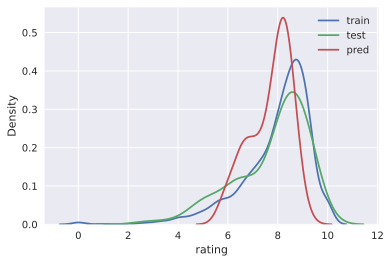

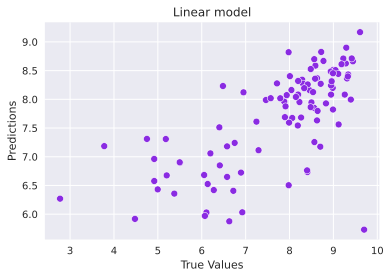

In [92]:
target_distr_linear(y_train, y_test, y_pred)

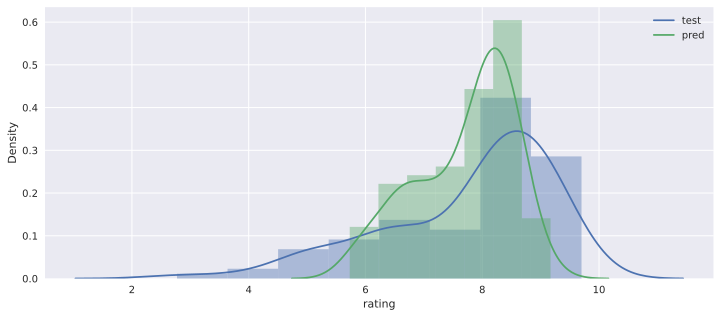

In [93]:
def draw_target_distr(y_test, y_pred, save_fig=False):
    plt.figure(figsize=(12, 5))
    sns.distplot(y_test)
    sns.distplot(y_pred)
    plt.legend(['test', 'pred'])
    plt.savefig('./okko_ratings_test_pred_oscr_kws')
    plt.show()

draw_target_distr(y_test, y_pred)

IMP: [1.55146159e+01 6.33468430e+00 1.78225146e+01 1.08248947e+00
 4.62830187e-02 9.38229557e-01 2.24829538e+00 1.93751553e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.67741372e-02 0.00000000e+00
 8.67187740e-03 0.00000000e+00 2.74404820e-03 0.00000000e+00]


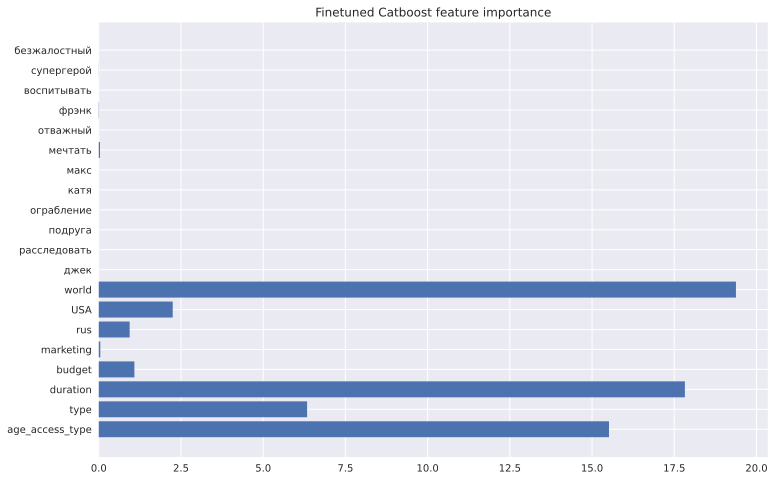

In [94]:
get_feature_imp(best_cat, train_dataset)

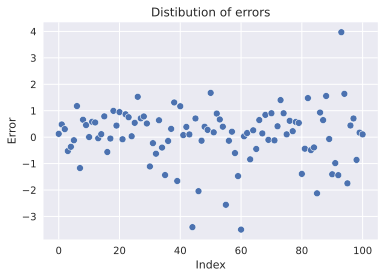

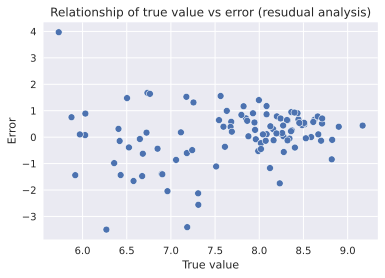

In [95]:
errors = y_test - y_pred
draw_res_analys(errors, y_pred)

In [96]:
calc_metrics(y_test, y_pred)

*** VAL **: 
MSE:   1.1251307130867798
RMSE:  1.0607217887300986
R2:    0.46671685377213523
MAE:   0.7658603972375755
MedAE: 0.5741545849729857
------------------------------


In [98]:
test_df['PREDS_tune'] = y_pred.tolist()
test_df

age_access_type                             name    type  release_year  \
10401               16                    Темное сердце  SERIAL          2022   
10439               18  Жена путешественника во времени  SERIAL          2022   
10435               18                    Хроники пышки  SERIAL          2022   
10457               18                 Бесконечная ночь  SERIAL          2022   
10438               18                        Репетиция  SERIAL          2022   
...                ...                              ...     ...           ...   
3110                16                          Код 355   MOVIE          2022   
2868                12                    Лулу и Бриггс   MOVIE          2022   
2805                16                  Побег из Африки   MOVIE          2022   
3885                18        Крепость 2: Глаз снайпера   MOVIE          2022   
10488                6                   Истоки футбола  SERIAL          2022   

        duration                           element_uid     budget  marketing  \
10401  16.368076  2372e695-5fff-4c68-91c7-73bce33fc9b1        NaN        NaN   
10439  16.626117  7becd8d8-1fb8-4ee6-b903-47817686ddd8        NaN        NaN   
10435  16.558928  17f245d4-d2d2-46de-a974-d7cd427ad1b6        NaN        NaN   
10457  16.200597  952bfe32-7504-4ef5-af22-985379d8637f        NaN        NaN   
10438  16.233209  753d822a-1890-4445-ab54-fe65c900e3fa        NaN        NaN   
...          ...                                   ...        ...        ...   
3110   15.806121  58934f4f-bec0-45db-a8a2-ab90d911a612  18.132999        NaN   
2868   15.617221  1504acff-36a2-4886-b37e-b4a96d51d3f6        NaN        NaN   
2805   15.490736  581115c5-1a7e-466d-9d11-fdd8d128d669  12.388398        NaN   
3885   15.587067  d580669b-3774-4091-8d78-f8cbdf02f8e0        NaN        NaN   
10488  17.518293  6dd86e60-5d6d-475d-9b46-e989ac7a30b6        NaN        NaN   

             rus         USA  ...          producer_4         writer_0  \
10401        NaN         NaN  ...  Каролин Ландерберг  Оскар Сёдерлунд   
10439        NaN         NaN  ...       Стивен Моффат    Стивен Моффат   
10435        NaN         NaN  ...        Ева Лонгория        Шон Уайнс   
10457        NaN         NaN  ...          Лоран Анон      Давид Перро   
10438        NaN         NaN  ...         Рэйчел Хейн    Нэйтан Филдер   
...          ...         ...  ...                 ...              ...   
3110   13.114567  14570455.0  ...        Ричард Хьюит   Ребека Ф. Смит   
2868   15.155431  61778069.0  ...    Грегори Джейкобс    Ченнинг Татум   
2805         NaN         NaN  ...                  Na         Тед Бетц   
3885         NaN         NaN  ...         Луильо Руис    Алан Хорснэйл   
10488        NaN         NaN  ...                  Na         Ши Чуань   

               writer_1  country_0                               genre_0  \
10401   Эрик Хультквист    denmark                              Thriller   
10439  Одри Ниффенеггер        usa                                Sci-Fi   
10435  Мэттью Клэйбрукс        usa                                Comedy   
10457  Эммануэль Вуазен    belgium  9fa28b61-a257-4a3e-945b-a9ef76a146d6   
10438      Кэрри Кемпер        usa                                Comedy   
...                 ...        ...                                   ...   
3110       Тереза Ребек        usa                                Action   
2868      Андреа Дзирио        usa                                Comedy   
2805                 Na        usa                             Adventure   
3885         Эмиль Хирш        usa                                Action   
10488                Na      china  287a1485-7a88-4c2f-bc94-ca418b6c47a1   

         genre_1                               genre_2     PREDS    TARGET  \
10401      Drama  364fdc2e-bdfe-40be-b2c5-d30f43ec432e  8.559833  8.372093   
10439  Melodrama                                 Drama  8.815231  8.990000   
10435     Family                     